# LiH: Confronto FCI e VQE con oo-PUCCD

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# from subroutines import *

# Array distanze e energie
arr_distance = np.arange(0.75, 4., 0.65) # così sono 5 punti
arr_ground_energy = {}


## 1 - Algoritmo classico

### 1.1 - FCI

FCI per comparazione

In [11]:
from pyscf import gto, scf, fci

basis = 'sto-6g'

arr_ground_energy['FCI'] = []

for distance in arr_distance:
    geometry = "Li .0 .0 .0; H .0 .0 " + str(distance)
    
    mol = gto.M(
        atom=geometry,
        charge=0,
        spin=0,
        basis=basis,
        symmetry=True,
        verbose=0
    )
    # per ciascuna molecola calcolo il campo medio con restricted HF 
    cm  = scf.RHF(mol) # campo medio
    e_HF = cm.kernel() # questo va runnato a prescindere
    
    # n_frozen_orbitals = 1 # per congelare il primo orbitale
    
    # per ciascuna molecola calcolo FCI
    fci_calc = fci.FCI(cm) # <- nei metodi correlati passiamo come argomento un conto di campo medio, HF
    e_FCI = fci_calc.kernel()[0]
    # se frozen e_FCI = fci_calc.kernel(frozen=n_frozen_orbitals)[0]
    arr_ground_energy['FCI'].append(e_FCI)

## 2 - VQE: pUCCD e oo-pUCCD (61min)

Spezzetto il problema:
1. dichiarazione del problema
1. costruzione dell'ansatz
1. risoluzione

In [12]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer

# dichiarazione del problema
def generate_LiH_problem (distance: float = .0, basis: str = 'sto-6g', reduce: bool = False):
    
    LiH = "Li .0 .0 .0; H .0 .0 " + str(distance)

    driver = PySCFDriver(
        atom=LiH,
        basis=basis, 
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )    
    
    problem = driver.run()
    
    
    if reduce:
        # riduco il problema, estraendo uno stato iniziale HF dal problema ridotto da usare come initial_state
        # 1s (2e-) di Li in freeze. Restano 2 e- in 1σ e il 1σ* appena sopra, provo a costruirla così:
        transformer = ActiveSpaceTransformer(num_electrons=(1,1), num_spatial_orbitals=2, active_orbitals=[1,2]) 
        problem = transformer.transform(problem)
        
    return [driver, problem]

In [13]:
from qiskit_nature.second_q.circuit.library import HartreeFock, PUCCD
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper

mapper = JordanWignerMapper()
#mapper = ParityMapper()

# costruzione dell'ansatz
def generate_ansatz ( problem, mapper = mapper ):
    
    ansatz = PUCCD(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
        ),
    )
    
    return ansatz

In [14]:
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.optimizers import SLSQP
from qiskit_algorithms.optimizers import NFT
from qiskit.primitives import Estimator 
from qiskit_algorithms.gradients import LinCombEstimatorGradient
from oovqe_algorithm_mio import OrbitalOptimizationVQE as ooVQE
# Estimator was deprecated, warnings suggest to use StatevectorEstimator instead

from qiskit_nature.second_q.algorithms import GroundStateEigensolver
    
# risoluzione
def solve_problem (driver, problem, ansatz, ini: np.ndarray = None, opt=SLSQP(maxiter=1000), mapper = mapper):

    # VQE
    estimator = Estimator()
    gradient = LinCombEstimatorGradient(estimator) 
    vqe_solver = VQE( estimator, ansatz, opt, gradient=gradient ) #, callback=store_intermediate_result)
    
    if ini is None:
        ini = [0.0] * ansatz.num_parameters
    else:
        vqe_solver.initial_point = ini
    
    calc = GroundStateEigensolver(mapper, vqe_solver)

    res = calc.solve(problem)
    
    # OOVQE
    ooVQE_solver = ooVQE(JordanWignerMapper(), vqe_solver, initial_point=None)
    
    oo_res = ooVQE_solver.solve(driver, problem)
    
    return [res, oo_res]

Metto tutto insieme

In [15]:
from qiskit_algorithms import NumPyMinimumEigensolver

# scelgo se congelare orbitali o meno
reduce = False # TRUE DEVO ANCORA VERIFICARE SE FUNZIONA OO
# inizializzo variabile che conterrà i parametri ottimizzati
initial_point = None

# provo diversi ottimizzatori
opt = SLSQP(maxiter=1000)
opt_name = 'pUCCD - SLSQP'

arr_ground_energy['pUCCD'] = []
arr_ground_energy['oo-pUCCD'] = []

# Esecuzione algoritmo
for distance in arr_distance:

    # Problema da Driver della molecola 
    LiH = generate_LiH_problem (distance, reduce=reduce)
    driver=LiH[0]
    problem=LiH[1]
    
    # Ansatz da problema con mapper default (JW)
    ansatz = generate_ansatz (problem)

    # Soluzione con VQE
    result = solve_problem (driver, problem, ansatz, opt=opt,ini=initial_point)

    # Estraggo l'energia del sistema
    # TODO: per ora se false non va ritoccato
    if reduce: 
        computed_part = result.groundenergy
        active_space_energy_part = result.extracted_transformer_energies.get("ActiveSpaceTransformer", 0)
        nuclear_repulsion_energy = result.nuclear_repulsion_energy
        total_ground_energy = computed_part + active_space_energy_part + nuclear_repulsion_energy
    else:
        total_ground_energy = result[0].groundenergy + result[0].nuclear_repulsion_energy
        oo_total_ground_energy = result[1].groundenergy + result[1].nuclear_repulsion_energy

    arr_ground_energy['pUCCD'].append(total_ground_energy)
    arr_ground_energy['oo-pUCCD'].append(oo_total_ground_energy)

    # salvo i parametri ottimizzati, da usare come pt iniziale del passo successivo
    initial_point = result[0].raw_result.optimal_point
    
    # stessa cosa è da fare per ooVQE, ma stando attenti a passare sia parametri dell'ansatz che della rotazione 

# optimal_parameters è il dict dei valori, point contiene solo i valori

/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_13220/572062692.py:16: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin

parameters:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1]
Parameters of wavefunction are: 
%s array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
Parameters of orbital rotation are: 
%s array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Nature matrix a:  [[ 0.97526959  0.0787423   0.08765007  0.09718668  0.10738465  0.1182778 ]
 [-0.1182778   0.97526959  0.0787423   0.08765007  0.09718668  0.10738465]
 [-0.10738465 -0.1182778   0.97526959  0.0787423   0.08765007  0.09718668]
 [-0.09718668 -0.10738465 -0.1182778   0.97526959  0.0787423   0.08765007]
 [-0.08765007 -0.09718668 -0.10738465 -0.1182778   0.97526959  0.0787423 ]
 [-0.0787423  -0.08765007 -0.09718668 -0.10738465 -0.

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.10001 0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.09999 0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.10001 0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.09999 0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.10001 0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.09999 0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.10001 0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.09999 0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.10001 0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.09999 0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.10001 0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.09999 0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.10001 0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.09999 0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.10001 0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.09999 0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.10001
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.09999
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.10001 0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.09999 0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.10001 0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.09999 0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.10001 0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.09999 0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.10001 0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.09999 0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.10001 0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.09999 0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.10001]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.09999]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-1.04524621 -1.04376688 -1.04345512 -1.23476999 -0.05956318 -0.08524127
 -0.08574234 -0.38412149 -6.28318531 -3.28092197 -3.23711435 -3.96862274
 -6.28318531  0.29941101  0.39325528 -0.93537009 -0.90311841  0.09103453
 -0.58283066  0.03482976 -0.62270709 -0.06294358 -0.27761736]
Parameters of wavefunction are: 
%s array([-1.04524621, -1.04376688, -1.04345512, -1.23476999, -0.05956318,
       -0.08524127, -0.08574234, -0.38412149])
Parameters of orbital rotation are: 
%s array([-6.28318531, -3.28092197, -3.23711435, -3.96862274, -6.28318531,
        0.29941101,  0.39325528, -0.93537009, -0.90311841,  0.09103453,
       -0.58283066,  0.03482976, -0.62270709, -0.06294358, -0.27761736])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.28318531 -3.28092197 -3.23711435 -3.96862274 -6.28318531  0.29941101
  0.39325528 -0.93537009 -0.90311841  0.09103453 -0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[11.04304707+0.j        , -3.65529955+0.j        ,  0.        -0.29569583j,
 -0.11677428+0.j        , -0.11677428+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s 3.240439908905358 144.87910270690918
parameters:  [-0.43657887 -0.43588576 -0.43573969 -0.52537589  0.02524033  0.01320945
  0.01297468 -0.12682403 -2.89069519 -1.48405351 -1.46352845 -1.80625994
 -2.89069519  0.19342946  0.23739804 -0.38509893 -0.36998814  0.09579943
 -0.21992466  0.06946598 -0.23860784  0.02365652 -0.07692396]
Parameters of wavefunction are: 
%s array([-0.43657887, -0.43588576, -0.43573969, -0.52537589,  0.02524033,
        0.01320945,  0.01297468, -0.12682403])
Parameters of orbital rotation are: 
%s array([-2.89069519, -1.48405351, -1.46352845, -1.80625994, -2.89069519,
        0.19342946,  0.23739804, -0.38509893, -0.36998814,  0.09579943,
       -

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[ 8.78034238+0.j        , -3.99738346+0.j        ,  0.        +0.87063861j,
 -0.62168105+0.j        , -0.62168105+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s 7.879357191309067 167.14024543762207
parameters:  [-0.12248103 -0.12219365 -0.12213308 -0.15929883  0.06900249  0.06401414
  0.0639168   0.00595223 -1.14002823 -0.55679414 -0.54828386 -0.69039019
 -1.14002823  0.13873854  0.15696918 -0.10113596 -0.0948706   0.09825832
 -0.03264996  0.08733972 -0.04039655  0.0683458   0.02664224]
Parameters of wavefunction are: 
%s array([-0.12248103, -0.12219365, -0.12213308, -0.15929883,  0.06900249,
        0.06401414,  0.0639168 ,  0.00595223])
Parameters of orbital rotation are: 
%s array([-1.14002823, -0.55679414, -0.54828386, -0.69039019, -1.14002823,
        0.13873854,  0.15696918, -0.10113596, -0.0948706 ,  0.09825832,
       -

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[ 7.30782715+0.j        , -3.88297807+0.j        ,  0.        +1.08590037j,
 -0.65419823+0.j        , -0.65419823+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s 13.816297226766482 128.00884246826172
parameters:  [ 0.03416071  0.03424575  0.03426368  0.02326514  0.09082684  0.08935063
  0.08932182  0.07216824 -0.26696424 -0.09436651 -0.09184805 -0.13390188
 -0.26696424  0.11146398  0.11685901  0.0404774   0.04233152  0.09948458
  0.06074461  0.09625341  0.05845214  0.0906325   0.07829108]
Parameters of wavefunction are: 
%s array([0.03416071, 0.03424575, 0.03426368, 0.02326514, 0.09082684,
       0.08935063, 0.08932182, 0.07216824])
Parameters of orbital rotation are: 
%s array([-0.26696424, -0.09436651, -0.09184805, -0.13390188, -0.26696424,
        0.11146398,  0.11685901,  0.0404774 ,  0.04233152,  0.09948458,
        0.06074

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.21475372+0.j        ,  0.86677735+0.j        ,  0.        -1.18727476j,
  0.47486372+0.j        ,  0.47486372+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -7.024764996168156 128.45396995544434
parameters:  [ 0.068373    0.06841385  0.06842246  0.06313913  0.09559352  0.0948844
  0.09487056  0.08663055 -0.07627738  0.00663281  0.0078426  -0.01235866
 -0.07627738  0.10550691  0.10809851  0.07140733  0.07229799  0.09975241
  0.08114302  0.09820027  0.0800418   0.09550017  0.08957176]
Parameters of wavefunction are: 
%s array([0.068373  , 0.06841385, 0.06842246, 0.06313913, 0.09559352,
       0.0948844 , 0.09487056, 0.08663055])
Parameters of orbital rotation are: 
%s array([-0.07627738,  0.00663281,  0.0078426 , -0.01235866, -0.07627738,
        0.10550691,  0.10809851,  0.07140733,  0.07229799,  0.09975241,
        0.081143

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07626738  0.00663281  0.0078426  -0.01235866 -0.07627738  0.10550691
  0.10809851  0.07140733  0.07229799  0.09975241  0.08114302  0.09820027
  0.0800418   0.09550017  0.08957176]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07628738  0.00663281  0.0078426  -0.01235866 -0.07627738  0.10550691
  0.10809851  0.07140733  0.07229799  0.09975241  0.08114302  0.09820027
  0.0800418   0.09550017  0.08957176]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07627738  0.00664281  0.0078426  -0.01235866 -0.07627738  0.10550691
  0.10809851  0.07140733  0.07229799  0.09975241  0.08114302  0.09820027
  0.0800418   0.09550017  0.08957176]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07627738  0.00662281  0.0078426  -0.01235866 -0.07627738  0.10550691
  0.10809851  0.07140733  0.07229799  0.09975241  0.08114302  0.09820027
  0.0800418   0.09550017  0.08957176]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07627738  0.00663281  0.0078526  -0.01235866 -0.07627738  0.10550691
  0.10809851  0.07140733  0.07229799  0.09975241  0.08114302  0.09820027
  0.0800418   0.09550017  0.08957176]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07627738  0.00663281  0.0078326  -0.01235866 -0.07627738  0.10550691
  0.10809851  0.07140733  0.07229799  0.09975241  0.08114302  0.09820027
  0.0800418   0.09550017  0.08957176]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07627738  0.00663281  0.0078426  -0.01234866 -0.07627738  0.10550691
  0.10809851  0.07140733  0.07229799  0.09975241  0.08114302  0.09820027
  0.0800418   0.09550017  0.08957176]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07627738  0.00663281  0.0078426  -0.01236866 -0.07627738  0.10550691
  0.10809851  0.07140733  0.07229799  0.09975241  0.08114302  0.09820027
  0.0800418   0.09550017  0.08957176]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07627738  0.00663281  0.0078426  -0.01235866 -0.07626738  0.10550691
  0.10809851  0.07140733  0.07229799  0.09975241  0.08114302  0.09820027
  0.0800418   0.09550017  0.08957176]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07627738  0.00663281  0.0078426  -0.01235866 -0.07628738  0.10550691
  0.10809851  0.07140733  0.07229799  0.09975241  0.08114302  0.09820027
  0.0800418   0.09550017  0.08957176]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07627738  0.00663281  0.0078426  -0.01235866 -0.07627738  0.10551691
  0.10809851  0.07140733  0.07229799  0.09975241  0.08114302  0.09820027
  0.0800418   0.09550017  0.08957176]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07627738  0.00663281  0.0078426  -0.01235866 -0.07627738  0.10549691
  0.10809851  0.07140733  0.07229799  0.09975241  0.08114302  0.09820027
  0.0800418   0.09550017  0.08957176]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07627738  0.00663281  0.0078426  -0.01235866 -0.07627738  0.10550691
  0.10810851  0.07140733  0.07229799  0.09975241  0.08114302  0.09820027
  0.0800418   0.09550017  0.08957176]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07627738  0.00663281  0.0078426  -0.01235866 -0.07627738  0.10550691
  0.10808851  0.07140733  0.07229799  0.09975241  0.08114302  0.09820027
  0.0800418   0.09550017  0.08957176]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07627738  0.00663281  0.0078426  -0.01235866 -0.07627738  0.10550691
  0.10809851  0.07141733  0.07229799  0.09975241  0.08114302  0.09820027
  0.0800418   0.09550017  0.08957176]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07627738  0.00663281  0.0078426  -0.01235866 -0.07627738  0.10550691
  0.10809851  0.07139733  0.07229799  0.09975241  0.08114302  0.09820027
  0.0800418   0.09550017  0.08957176]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07627738  0.00663281  0.0078426  -0.01235866 -0.07627738  0.10550691
  0.10809851  0.07140733  0.07230799  0.09975241  0.08114302  0.09820027
  0.0800418   0.09550017  0.08957176]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07627738  0.00663281  0.0078426  -0.01235866 -0.07627738  0.10550691
  0.10809851  0.07140733  0.07228799  0.09975241  0.08114302  0.09820027
  0.0800418   0.09550017  0.08957176]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07627738  0.00663281  0.0078426  -0.01235866 -0.07627738  0.10550691
  0.10809851  0.07140733  0.07229799  0.09976241  0.08114302  0.09820027
  0.0800418   0.09550017  0.08957176]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07627738  0.00663281  0.0078426  -0.01235866 -0.07627738  0.10550691
  0.10809851  0.07140733  0.07229799  0.09974241  0.08114302  0.09820027
  0.0800418   0.09550017  0.08957176]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07627738  0.00663281  0.0078426  -0.01235866 -0.07627738  0.10550691
  0.10809851  0.07140733  0.07229799  0.09975241  0.08115302  0.09820027
  0.0800418   0.09550017  0.08957176]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07627738  0.00663281  0.0078426  -0.01235866 -0.07627738  0.10550691
  0.10809851  0.07140733  0.07229799  0.09975241  0.08113302  0.09820027
  0.0800418   0.09550017  0.08957176]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07627738  0.00663281  0.0078426  -0.01235866 -0.07627738  0.10550691
  0.10809851  0.07140733  0.07229799  0.09975241  0.08114302  0.09821027
  0.0800418   0.09550017  0.08957176]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07627738  0.00663281  0.0078426  -0.01235866 -0.07627738  0.10550691
  0.10809851  0.07140733  0.07229799  0.09975241  0.08114302  0.09819027
  0.0800418   0.09550017  0.08957176]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07627738  0.00663281  0.0078426  -0.01235866 -0.07627738  0.10550691
  0.10809851  0.07140733  0.07229799  0.09975241  0.08114302  0.09820027
  0.0800518   0.09550017  0.08957176]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07627738  0.00663281  0.0078426  -0.01235866 -0.07627738  0.10550691
  0.10809851  0.07140733  0.07229799  0.09975241  0.08114302  0.09820027
  0.0800318   0.09550017  0.08957176]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07627738  0.00663281  0.0078426  -0.01235866 -0.07627738  0.10550691
  0.10809851  0.07140733  0.07229799  0.09975241  0.08114302  0.09820027
  0.0800418   0.09551017  0.08957176]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07627738  0.00663281  0.0078426  -0.01235866 -0.07627738  0.10550691
  0.10809851  0.07140733  0.07229799  0.09975241  0.08114302  0.09820027
  0.0800418   0.09549017  0.08957176]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07627738  0.00663281  0.0078426  -0.01235866 -0.07627738  0.10550691
  0.10809851  0.07140733  0.07229799  0.09975241  0.08114302  0.09820027
  0.0800418   0.09550017  0.08958176]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07627738  0.00663281  0.0078426  -0.01235866 -0.07627738  0.10550691
  0.10809851  0.07140733  0.07229799  0.09975241  0.08114302  0.09820027
  0.0800418   0.09550017  0.08956176]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.83000092 -0.8247136  -0.82442663 -0.92410758 -0.06445457 -0.0931337
 -0.09359388 -0.4018433  -0.21149643 -0.31303868 -0.38438939  1.46357816
 -0.76872783  0.49221144  0.48800671 -0.32743256 -1.62332326  0.07749913
 -0.45082958 -0.55406563 -0.44377191 -0.52113233 -1.25728336]
Parameters of wavefunction are: 
%s array([-0.83000092, -0.8247136 , -0.82442663, -0.92410758, -0.06445457,
       -0.0931337 , -0.09359388, -0.4018433 ])
Parameters of orbital rotation are: 
%s array([-0.21149643, -0.31303868, -0.38438939,  1.46357816, -0.76872783,
        0.49221144,  0.48800671, -0.32743256, -1.62332326,  0.07749913,
       -0.45082958, -0.55406563, -0.44377191, -0.52113233, -1.25728336])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.21149643 -0.31303868 -0.38438939  1.46357816 -0.76872783  0.49221144
  0.48800671 -0.32743256 -1.62332326  0.07749913 -0.

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[ 6.95195341+0.j        , -2.9477696 +0.j        ,  0.        +0.15679161j,
 -0.93109026+0.j        , -0.93109026+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s 1.8506148403958564 129.58812713623047
parameters:  [-0.16404985 -0.16265165 -0.16257103 -0.19227644  0.05418667  0.04624129
  0.04611197 -0.03974498 -0.11126058 -0.07607101 -0.09363372  0.3694884
 -0.25542473  0.20555319  0.20638647 -0.03177855 -0.36638473  0.09399515
 -0.05648629 -0.07055073 -0.05547669 -0.06403193 -0.25887992]
Parameters of wavefunction are: 
%s array([-0.16404985, -0.16265165, -0.16257103, -0.19227644,  0.05418667,
        0.04624129,  0.04611197, -0.03974498])
Parameters of orbital rotation are: 
%s array([-0.11126058, -0.07607101, -0.09363372,  0.3694884 , -0.25542473,
        0.20555319,  0.20638647, -0.03177855, -0.36638473,  0.09399515,
       -

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-1.57244432+0.j       ,  0.208373  +0.j       ,  0.        -0.1040184j,
  0.22602424+0.j       ,  0.22602424+0.j       ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -4.527598193384695 126.27601623535156
parameters:  [ 0.02387273  0.02417346  0.02419586  0.01423661  0.08766566  0.08557106
  0.08553512  0.06243437 -0.08297535 -0.00920187 -0.01158632  0.06075076
 -0.11057739  0.12466203  0.12691697  0.0516511  -0.01169333  0.09865011
  0.05479216  0.06589077  0.05409508  0.06495574  0.02285631]
Parameters of wavefunction are: 
%s array([0.02387273, 0.02417346, 0.02419586, 0.01423661, 0.08766566,
       0.08557106, 0.08553512, 0.06243437])
Parameters of orbital rotation are: 
%s array([-0.08297535, -0.00920187, -0.01158632,  0.06075076, -0.11057739,
        0.12466203,  0.12691697,  0.0516511 , -0.01169333,  0.09865011,
        0.05479216, 

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08296535 -0.00920187 -0.01158632  0.06075076 -0.11057739  0.12466203
  0.12691697  0.0516511  -0.01169333  0.09865011  0.05479216  0.06589077
  0.05409508  0.06495574  0.02285631]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08298535 -0.00920187 -0.01158632  0.06075076 -0.11057739  0.12466203
  0.12691697  0.0516511  -0.01169333  0.09865011  0.05479216  0.06589077
  0.05409508  0.06495574  0.02285631]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08297535 -0.00919187 -0.01158632  0.06075076 -0.11057739  0.12466203
  0.12691697  0.0516511  -0.01169333  0.09865011  0.05479216  0.06589077
  0.05409508  0.06495574  0.02285631]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08297535 -0.00921187 -0.01158632  0.06075076 -0.11057739  0.12466203
  0.12691697  0.0516511  -0.01169333  0.09865011  0.05479216  0.06589077
  0.05409508  0.06495574  0.02285631]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08297535 -0.00920187 -0.01157632  0.06075076 -0.11057739  0.12466203
  0.12691697  0.0516511  -0.01169333  0.09865011  0.05479216  0.06589077
  0.05409508  0.06495574  0.02285631]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08297535 -0.00920187 -0.01159632  0.06075076 -0.11057739  0.12466203
  0.12691697  0.0516511  -0.01169333  0.09865011  0.05479216  0.06589077
  0.05409508  0.06495574  0.02285631]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08297535 -0.00920187 -0.01158632  0.06076076 -0.11057739  0.12466203
  0.12691697  0.0516511  -0.01169333  0.09865011  0.05479216  0.06589077
  0.05409508  0.06495574  0.02285631]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08297535 -0.00920187 -0.01158632  0.06074076 -0.11057739  0.12466203
  0.12691697  0.0516511  -0.01169333  0.09865011  0.05479216  0.06589077
  0.05409508  0.06495574  0.02285631]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08297535 -0.00920187 -0.01158632  0.06075076 -0.11056739  0.12466203
  0.12691697  0.0516511  -0.01169333  0.09865011  0.05479216  0.06589077
  0.05409508  0.06495574  0.02285631]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08297535 -0.00920187 -0.01158632  0.06075076 -0.11058739  0.12466203
  0.12691697  0.0516511  -0.01169333  0.09865011  0.05479216  0.06589077
  0.05409508  0.06495574  0.02285631]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08297535 -0.00920187 -0.01158632  0.06075076 -0.11057739  0.12467203
  0.12691697  0.0516511  -0.01169333  0.09865011  0.05479216  0.06589077
  0.05409508  0.06495574  0.02285631]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08297535 -0.00920187 -0.01158632  0.06075076 -0.11057739  0.12465203
  0.12691697  0.0516511  -0.01169333  0.09865011  0.05479216  0.06589077
  0.05409508  0.06495574  0.02285631]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08297535 -0.00920187 -0.01158632  0.06075076 -0.11057739  0.12466203
  0.12692697  0.0516511  -0.01169333  0.09865011  0.05479216  0.06589077
  0.05409508  0.06495574  0.02285631]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08297535 -0.00920187 -0.01158632  0.06075076 -0.11057739  0.12466203
  0.12690697  0.0516511  -0.01169333  0.09865011  0.05479216  0.06589077
  0.05409508  0.06495574  0.02285631]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08297535 -0.00920187 -0.01158632  0.06075076 -0.11057739  0.12466203
  0.12691697  0.0516611  -0.01169333  0.09865011  0.05479216  0.06589077
  0.05409508  0.06495574  0.02285631]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08297535 -0.00920187 -0.01158632  0.06075076 -0.11057739  0.12466203
  0.12691697  0.0516411  -0.01169333  0.09865011  0.05479216  0.06589077
  0.05409508  0.06495574  0.02285631]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08297535 -0.00920187 -0.01158632  0.06075076 -0.11057739  0.12466203
  0.12691697  0.0516511  -0.01168333  0.09865011  0.05479216  0.06589077
  0.05409508  0.06495574  0.02285631]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08297535 -0.00920187 -0.01158632  0.06075076 -0.11057739  0.12466203
  0.12691697  0.0516511  -0.01170333  0.09865011  0.05479216  0.06589077
  0.05409508  0.06495574  0.02285631]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08297535 -0.00920187 -0.01158632  0.06075076 -0.11057739  0.12466203
  0.12691697  0.0516511  -0.01169333  0.09866011  0.05479216  0.06589077
  0.05409508  0.06495574  0.02285631]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08297535 -0.00920187 -0.01158632  0.06075076 -0.11057739  0.12466203
  0.12691697  0.0516511  -0.01169333  0.09864011  0.05479216  0.06589077
  0.05409508  0.06495574  0.02285631]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08297535 -0.00920187 -0.01158632  0.06075076 -0.11057739  0.12466203
  0.12691697  0.0516511  -0.01169333  0.09865011  0.05480216  0.06589077
  0.05409508  0.06495574  0.02285631]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08297535 -0.00920187 -0.01158632  0.06075076 -0.11057739  0.12466203
  0.12691697  0.0516511  -0.01169333  0.09865011  0.05478216  0.06589077
  0.05409508  0.06495574  0.02285631]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08297535 -0.00920187 -0.01158632  0.06075076 -0.11057739  0.12466203
  0.12691697  0.0516511  -0.01169333  0.09865011  0.05479216  0.06590077
  0.05409508  0.06495574  0.02285631]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08297535 -0.00920187 -0.01158632  0.06075076 -0.11057739  0.12466203
  0.12691697  0.0516511  -0.01169333  0.09865011  0.05479216  0.06588077
  0.05409508  0.06495574  0.02285631]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08297535 -0.00920187 -0.01158632  0.06075076 -0.11057739  0.12466203
  0.12691697  0.0516511  -0.01169333  0.09865011  0.05479216  0.06589077
  0.05410508  0.06495574  0.02285631]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08297535 -0.00920187 -0.01158632  0.06075076 -0.11057739  0.12466203
  0.12691697  0.0516511  -0.01169333  0.09865011  0.05479216  0.06589077
  0.05408508  0.06495574  0.02285631]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08297535 -0.00920187 -0.01158632  0.06075076 -0.11057739  0.12466203
  0.12691697  0.0516511  -0.01169333  0.09865011  0.05479216  0.06589077
  0.05409508  0.06496574  0.02285631]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08297535 -0.00920187 -0.01158632  0.06075076 -0.11057739  0.12466203
  0.12691697  0.0516511  -0.01169333  0.09865011  0.05479216  0.06589077
  0.05409508  0.06494574  0.02285631]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08297535 -0.00920187 -0.01158632  0.06075076 -0.11057739  0.12466203
  0.12691697  0.0516511  -0.01169333  0.09865011  0.05479216  0.06589077
  0.05409508  0.06495574  0.02286631]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08297535 -0.00920187 -0.01158632  0.06075076 -0.11057739  0.12466203
  0.12691697  0.0516511  -0.01169333  0.09865011  0.05479216  0.06589077
  0.05409508  0.06495574  0.02284631]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.69531742 -0.68540573 -0.68523277 -0.6987144  -0.11008464 -0.14982894
 -0.15031523 -0.53260213 -0.2220167   0.1151377   0.15159605 -0.95276245
  0.51721408  0.42668966  0.42124242 -0.4307582  -1.14505171  0.07556658
 -0.33235856 -0.47576733 -0.3158069  -0.45518613 -0.58792788]
Parameters of wavefunction are: 
%s array([-0.69531742, -0.68540573, -0.68523277, -0.6987144 , -0.11008464,
       -0.14982894, -0.15031523, -0.53260213])
Parameters of orbital rotation are: 
%s array([-0.2220167 ,  0.1151377 ,  0.15159605, -0.95276245,  0.51721408,
        0.42668966,  0.42124242, -0.4307582 , -1.14505171,  0.07556658,
       -0.33235856, -0.47576733, -0.3158069 , -0.45518613, -0.58792788])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.2220167   0.1151377   0.15159605 -0.95276245  0.51721408  0.42668966
  0.42124242 -0.4307582  -1.14505171  0.07556658 -0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[ 8.60368049+0.j        , -2.81542356+0.j        ,  0.        +0.12759783j,
 -0.25771988+0.j        , -0.25771988+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s 4.0957784218999596 128.72600555419922
parameters:  [-0.06749076 -0.06596908 -0.06592756 -0.07633427  0.06254413  0.05566664
  0.05557349 -0.01315706 -0.10063869  0.00659381  0.00914382 -0.06800253
 -0.03082488  0.1630306   0.16430708 -0.00963255 -0.15567135  0.09571766
  0.00560984 -0.00291965  0.00710398 -0.00112132 -0.05473565]
Parameters of wavefunction are: 
%s array([-0.06749076, -0.06596908, -0.06592756, -0.07633427,  0.06254413,
        0.05566664,  0.05557349, -0.01315706])
Parameters of orbital rotation are: 
%s array([-0.10063869,  0.00659381,  0.00914382, -0.06800253, -0.03082488,
        0.1630306 ,  0.16430708, -0.00963255, -0.15567135,  0.09571766,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.15775754+0.j        ,  1.20581914+0.j        ,  0.        -0.32829646j,
  0.14270913+0.j        ,  0.14270913+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -9.589045105039707 136.26503944396973
parameters:  [-0.00401142 -0.00333806 -0.00330982 -0.01340564  0.07999856  0.07644423
  0.07639082  0.03936385 -0.08836621 -0.00438103 -0.00525948  0.02145523
 -0.08623691  0.13637212  0.13832844  0.03294732 -0.05563545  0.09775513
  0.03978171  0.04488982  0.03975339  0.04478901 -0.00082477]
Parameters of wavefunction are: 
%s array([-0.00401142, -0.00333806, -0.00330982, -0.01340564,  0.07999856,
        0.07644423,  0.07639082,  0.03936385])
Parameters of orbital rotation are: 
%s array([-0.08836621, -0.00438103, -0.00525948,  0.02145523, -0.08623691,
        0.13637212,  0.13832844,  0.03294732, -0.05563545,  0.09775513,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08835621 -0.00438103 -0.00525948  0.02145523 -0.08623691  0.13637212
  0.13832844  0.03294732 -0.05563545  0.09775513  0.03978171  0.04488982
  0.03975339  0.04478901 -0.00082477]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08837621 -0.00438103 -0.00525948  0.02145523 -0.08623691  0.13637212
  0.13832844  0.03294732 -0.05563545  0.09775513  0.03978171  0.04488982
  0.03975339  0.04478901 -0.00082477]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08836621 -0.00437103 -0.00525948  0.02145523 -0.08623691  0.13637212
  0.13832844  0.03294732 -0.05563545  0.09775513  0.03978171  0.04488982
  0.03975339  0.04478901 -0.00082477]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08836621 -0.00439103 -0.00525948  0.02145523 -0.08623691  0.13637212
  0.13832844  0.03294732 -0.05563545  0.09775513  0.03978171  0.04488982
  0.03975339  0.04478901 -0.00082477]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08836621 -0.00438103 -0.00524948  0.02145523 -0.08623691  0.13637212
  0.13832844  0.03294732 -0.05563545  0.09775513  0.03978171  0.04488982
  0.03975339  0.04478901 -0.00082477]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08836621 -0.00438103 -0.00526948  0.02145523 -0.08623691  0.13637212
  0.13832844  0.03294732 -0.05563545  0.09775513  0.03978171  0.04488982
  0.03975339  0.04478901 -0.00082477]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08836621 -0.00438103 -0.00525948  0.02146523 -0.08623691  0.13637212
  0.13832844  0.03294732 -0.05563545  0.09775513  0.03978171  0.04488982
  0.03975339  0.04478901 -0.00082477]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08836621 -0.00438103 -0.00525948  0.02144523 -0.08623691  0.13637212
  0.13832844  0.03294732 -0.05563545  0.09775513  0.03978171  0.04488982
  0.03975339  0.04478901 -0.00082477]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08836621 -0.00438103 -0.00525948  0.02145523 -0.08622691  0.13637212
  0.13832844  0.03294732 -0.05563545  0.09775513  0.03978171  0.04488982
  0.03975339  0.04478901 -0.00082477]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08836621 -0.00438103 -0.00525948  0.02145523 -0.08624691  0.13637212
  0.13832844  0.03294732 -0.05563545  0.09775513  0.03978171  0.04488982
  0.03975339  0.04478901 -0.00082477]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08836621 -0.00438103 -0.00525948  0.02145523 -0.08623691  0.13638212
  0.13832844  0.03294732 -0.05563545  0.09775513  0.03978171  0.04488982
  0.03975339  0.04478901 -0.00082477]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08836621 -0.00438103 -0.00525948  0.02145523 -0.08623691  0.13636212
  0.13832844  0.03294732 -0.05563545  0.09775513  0.03978171  0.04488982
  0.03975339  0.04478901 -0.00082477]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08836621 -0.00438103 -0.00525948  0.02145523 -0.08623691  0.13637212
  0.13833844  0.03294732 -0.05563545  0.09775513  0.03978171  0.04488982
  0.03975339  0.04478901 -0.00082477]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08836621 -0.00438103 -0.00525948  0.02145523 -0.08623691  0.13637212
  0.13831844  0.03294732 -0.05563545  0.09775513  0.03978171  0.04488982
  0.03975339  0.04478901 -0.00082477]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08836621 -0.00438103 -0.00525948  0.02145523 -0.08623691  0.13637212
  0.13832844  0.03295732 -0.05563545  0.09775513  0.03978171  0.04488982
  0.03975339  0.04478901 -0.00082477]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08836621 -0.00438103 -0.00525948  0.02145523 -0.08623691  0.13637212
  0.13832844  0.03293732 -0.05563545  0.09775513  0.03978171  0.04488982
  0.03975339  0.04478901 -0.00082477]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08836621 -0.00438103 -0.00525948  0.02145523 -0.08623691  0.13637212
  0.13832844  0.03294732 -0.05562545  0.09775513  0.03978171  0.04488982
  0.03975339  0.04478901 -0.00082477]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08836621 -0.00438103 -0.00525948  0.02145523 -0.08623691  0.13637212
  0.13832844  0.03294732 -0.05564545  0.09775513  0.03978171  0.04488982
  0.03975339  0.04478901 -0.00082477]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08836621 -0.00438103 -0.00525948  0.02145523 -0.08623691  0.13637212
  0.13832844  0.03294732 -0.05563545  0.09776513  0.03978171  0.04488982
  0.03975339  0.04478901 -0.00082477]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08836621 -0.00438103 -0.00525948  0.02145523 -0.08623691  0.13637212
  0.13832844  0.03294732 -0.05563545  0.09774513  0.03978171  0.04488982
  0.03975339  0.04478901 -0.00082477]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08836621 -0.00438103 -0.00525948  0.02145523 -0.08623691  0.13637212
  0.13832844  0.03294732 -0.05563545  0.09775513  0.03979171  0.04488982
  0.03975339  0.04478901 -0.00082477]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08836621 -0.00438103 -0.00525948  0.02145523 -0.08623691  0.13637212
  0.13832844  0.03294732 -0.05563545  0.09775513  0.03977171  0.04488982
  0.03975339  0.04478901 -0.00082477]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08836621 -0.00438103 -0.00525948  0.02145523 -0.08623691  0.13637212
  0.13832844  0.03294732 -0.05563545  0.09775513  0.03978171  0.04489982
  0.03975339  0.04478901 -0.00082477]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08836621 -0.00438103 -0.00525948  0.02145523 -0.08623691  0.13637212
  0.13832844  0.03294732 -0.05563545  0.09775513  0.03978171  0.04487982
  0.03975339  0.04478901 -0.00082477]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08836621 -0.00438103 -0.00525948  0.02145523 -0.08623691  0.13637212
  0.13832844  0.03294732 -0.05563545  0.09775513  0.03978171  0.04488982
  0.03976339  0.04478901 -0.00082477]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08836621 -0.00438103 -0.00525948  0.02145523 -0.08623691  0.13637212
  0.13832844  0.03294732 -0.05563545  0.09775513  0.03978171  0.04488982
  0.03974339  0.04478901 -0.00082477]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08836621 -0.00438103 -0.00525948  0.02145523 -0.08623691  0.13637212
  0.13832844  0.03294732 -0.05563545  0.09775513  0.03978171  0.04488982
  0.03975339  0.04479901 -0.00082477]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08836621 -0.00438103 -0.00525948  0.02145523 -0.08623691  0.13637212
  0.13832844  0.03294732 -0.05563545  0.09775513  0.03978171  0.04488982
  0.03975339  0.04477901 -0.00082477]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08836621 -0.00438103 -0.00525948  0.02145523 -0.08623691  0.13637212
  0.13832844  0.03294732 -0.05563545  0.09775513  0.03978171  0.04488982
  0.03975339  0.04478901 -0.00081477]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08836621 -0.00438103 -0.00525948  0.02145523 -0.08623691  0.13637212
  0.13832844  0.03294732 -0.05563545  0.09775513  0.03978171  0.04488982
  0.03975339  0.04478901 -0.00083477]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.06554193 -0.05757089 -0.0576593   0.01317894 -0.04976881 -0.08165254
 -0.08188866 -0.33056156 -0.09773768 -0.05366453 -0.05438869  0.02786014
 -0.02752599  0.10346707  0.10016316  0.04755067 -0.00798052  0.08574973
  0.04635204  0.07311057  0.05352538  0.08329335  0.02024227]
Parameters of wavefunction are: 
%s array([-0.06554193, -0.05757089, -0.0576593 ,  0.01317894, -0.04976881,
       -0.08165254, -0.08188866, -0.33056156])
Parameters of orbital rotation are: 
%s array([-0.09773768, -0.05366453, -0.05438869,  0.02786014, -0.02752599,
        0.10346707,  0.10016316,  0.04755067, -0.00798052,  0.08574973,
        0.04635204,  0.07311057,  0.05352538,  0.08329335,  0.02024227])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09773768 -0.05366453 -0.05438869  0.02786014 -0.02752599  0.10346707
  0.10016316  0.04755067 -0.00798052  0.08574973  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.68762241+0.j        ,  1.15807015+0.j        ,  0.        -0.16973674j,
  0.10454334+0.j        ,  0.10454334+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -9.758572680635938 132.21025466918945
parameters:  [-0.01672232 -0.01454141 -0.01453727 -0.00791383  0.05319139  0.04378481
  0.04369365 -0.03705485 -0.09030215 -0.01456195 -0.01540852  0.02277835
 -0.07410848  0.12957464  0.13044431  0.03596406 -0.04579095  0.09527507
  0.041139    0.05071962  0.04259839  0.05274319  0.00352723]
Parameters of wavefunction are: 
%s array([-0.01672232, -0.01454141, -0.01453727, -0.00791383,  0.05319139,
        0.04378481,  0.04369365, -0.03705485])
Parameters of orbital rotation are: 
%s array([-0.09030215, -0.01456195, -0.01540852,  0.02277835, -0.07410848,
        0.12957464,  0.13044431,  0.03596406, -0.04579095,  0.09527507,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09029215 -0.01456195 -0.01540852  0.02277835 -0.07410848  0.12957464
  0.13044431  0.03596406 -0.04579095  0.09527507  0.041139    0.05071962
  0.04259839  0.05274319  0.00352723]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09031215 -0.01456195 -0.01540852  0.02277835 -0.07410848  0.12957464
  0.13044431  0.03596406 -0.04579095  0.09527507  0.041139    0.05071962
  0.04259839  0.05274319  0.00352723]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09030215 -0.01455195 -0.01540852  0.02277835 -0.07410848  0.12957464
  0.13044431  0.03596406 -0.04579095  0.09527507  0.041139    0.05071962
  0.04259839  0.05274319  0.00352723]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09030215 -0.01457195 -0.01540852  0.02277835 -0.07410848  0.12957464
  0.13044431  0.03596406 -0.04579095  0.09527507  0.041139    0.05071962
  0.04259839  0.05274319  0.00352723]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09030215 -0.01456195 -0.01539852  0.02277835 -0.07410848  0.12957464
  0.13044431  0.03596406 -0.04579095  0.09527507  0.041139    0.05071962
  0.04259839  0.05274319  0.00352723]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09030215 -0.01456195 -0.01541852  0.02277835 -0.07410848  0.12957464
  0.13044431  0.03596406 -0.04579095  0.09527507  0.041139    0.05071962
  0.04259839  0.05274319  0.00352723]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09030215 -0.01456195 -0.01540852  0.02278835 -0.07410848  0.12957464
  0.13044431  0.03596406 -0.04579095  0.09527507  0.041139    0.05071962
  0.04259839  0.05274319  0.00352723]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09030215 -0.01456195 -0.01540852  0.02276835 -0.07410848  0.12957464
  0.13044431  0.03596406 -0.04579095  0.09527507  0.041139    0.05071962
  0.04259839  0.05274319  0.00352723]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09030215 -0.01456195 -0.01540852  0.02277835 -0.07409848  0.12957464
  0.13044431  0.03596406 -0.04579095  0.09527507  0.041139    0.05071962
  0.04259839  0.05274319  0.00352723]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09030215 -0.01456195 -0.01540852  0.02277835 -0.07411848  0.12957464
  0.13044431  0.03596406 -0.04579095  0.09527507  0.041139    0.05071962
  0.04259839  0.05274319  0.00352723]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09030215 -0.01456195 -0.01540852  0.02277835 -0.07410848  0.12958464
  0.13044431  0.03596406 -0.04579095  0.09527507  0.041139    0.05071962
  0.04259839  0.05274319  0.00352723]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09030215 -0.01456195 -0.01540852  0.02277835 -0.07410848  0.12956464
  0.13044431  0.03596406 -0.04579095  0.09527507  0.041139    0.05071962
  0.04259839  0.05274319  0.00352723]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09030215 -0.01456195 -0.01540852  0.02277835 -0.07410848  0.12957464
  0.13045431  0.03596406 -0.04579095  0.09527507  0.041139    0.05071962
  0.04259839  0.05274319  0.00352723]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09030215 -0.01456195 -0.01540852  0.02277835 -0.07410848  0.12957464
  0.13043431  0.03596406 -0.04579095  0.09527507  0.041139    0.05071962
  0.04259839  0.05274319  0.00352723]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09030215 -0.01456195 -0.01540852  0.02277835 -0.07410848  0.12957464
  0.13044431  0.03597406 -0.04579095  0.09527507  0.041139    0.05071962
  0.04259839  0.05274319  0.00352723]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09030215 -0.01456195 -0.01540852  0.02277835 -0.07410848  0.12957464
  0.13044431  0.03595406 -0.04579095  0.09527507  0.041139    0.05071962
  0.04259839  0.05274319  0.00352723]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09030215 -0.01456195 -0.01540852  0.02277835 -0.07410848  0.12957464
  0.13044431  0.03596406 -0.04578095  0.09527507  0.041139    0.05071962
  0.04259839  0.05274319  0.00352723]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09030215 -0.01456195 -0.01540852  0.02277835 -0.07410848  0.12957464
  0.13044431  0.03596406 -0.04580095  0.09527507  0.041139    0.05071962
  0.04259839  0.05274319  0.00352723]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09030215 -0.01456195 -0.01540852  0.02277835 -0.07410848  0.12957464
  0.13044431  0.03596406 -0.04579095  0.09528507  0.041139    0.05071962
  0.04259839  0.05274319  0.00352723]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09030215 -0.01456195 -0.01540852  0.02277835 -0.07410848  0.12957464
  0.13044431  0.03596406 -0.04579095  0.09526507  0.041139    0.05071962
  0.04259839  0.05274319  0.00352723]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09030215 -0.01456195 -0.01540852  0.02277835 -0.07410848  0.12957464
  0.13044431  0.03596406 -0.04579095  0.09527507  0.041149    0.05071962
  0.04259839  0.05274319  0.00352723]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09030215 -0.01456195 -0.01540852  0.02277835 -0.07410848  0.12957464
  0.13044431  0.03596406 -0.04579095  0.09527507  0.041129    0.05071962
  0.04259839  0.05274319  0.00352723]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09030215 -0.01456195 -0.01540852  0.02277835 -0.07410848  0.12957464
  0.13044431  0.03596406 -0.04579095  0.09527507  0.041139    0.05072962
  0.04259839  0.05274319  0.00352723]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09030215 -0.01456195 -0.01540852  0.02277835 -0.07410848  0.12957464
  0.13044431  0.03596406 -0.04579095  0.09527507  0.041139    0.05070962
  0.04259839  0.05274319  0.00352723]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09030215 -0.01456195 -0.01540852  0.02277835 -0.07410848  0.12957464
  0.13044431  0.03596406 -0.04579095  0.09527507  0.041139    0.05071962
  0.04260839  0.05274319  0.00352723]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09030215 -0.01456195 -0.01540852  0.02277835 -0.07410848  0.12957464
  0.13044431  0.03596406 -0.04579095  0.09527507  0.041139    0.05071962
  0.04258839  0.05274319  0.00352723]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09030215 -0.01456195 -0.01540852  0.02277835 -0.07410848  0.12957464
  0.13044431  0.03596406 -0.04579095  0.09527507  0.041139    0.05071962
  0.04259839  0.05275319  0.00352723]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09030215 -0.01456195 -0.01540852  0.02277835 -0.07410848  0.12957464
  0.13044431  0.03596406 -0.04579095  0.09527507  0.041139    0.05071962
  0.04259839  0.05273319  0.00352723]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09030215 -0.01456195 -0.01540852  0.02277835 -0.07410848  0.12957464
  0.13044431  0.03596406 -0.04579095  0.09527507  0.041139    0.05071962
  0.04259839  0.05274319  0.00353723]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09030215 -0.01456195 -0.01540852  0.02277835 -0.07410848  0.12957464
  0.13044431  0.03596406 -0.04579095  0.09527507  0.041139    0.05071962
  0.04259839  0.05274319  0.00351723]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-1.02283084e-01 -8.10256670e-02 -8.14335284e-02  1.09645634e-01
 -5.03736352e-01 -6.43172672e-01 -6.43893846e-01 -1.55149077e+00
  2.54834543e-02  2.68073111e-01  2.87780578e-01 -1.10832974e-04
 -3.15951525e-01  4.60226092e-02  3.89917448e-02  8.57889741e-02
  6.44351404e-02  4.79325410e-02  7.00442573e-02  6.32200471e-02
  8.38526368e-02  8.33783745e-02  1.14316340e-01]
Parameters of wavefunction are: 
%s array([-0.10228308, -0.08102567, -0.08143353,  0.10964563, -0.50373635,
       -0.64317267, -0.64389385, -1.55149077])
Parameters of orbital rotation are: 
%s array([ 2.54834543e-02,  2.68073111e-01,  2.87780578e-01, -1.10832974e-04,
       -3.15951525e-01,  4.60226092e-02,  3.89917448e-02,  8.57889741e-02,
        6.44351404e-02,  4.79325410e-02,  7.00442573e-02,  6.32200471e-02,
        8.38526368e-02,  8.33783745e-02,  1.14316340e-01])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3,

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-3.39989698+0.j       ,  0.39038269+0.j       ,  0.        -0.4878223j,
 -0.08892444+0.j       , -0.08892444+0.j       ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -5.8197832018802655 136.14606857299805
parameters:  [-0.02527839 -0.02118983 -0.02122689  0.00384212 -0.00250138 -0.02491094
 -0.0250651  -0.18849845 -0.07872359  0.01370155  0.01491039  0.02048943
 -0.09829279  0.12121944  0.12129905  0.04094655 -0.03476834  0.09054081
  0.04402952  0.05196967  0.04672381  0.05580671  0.01460614]
Parameters of wavefunction are: 
%s array([-0.02527839, -0.02118983, -0.02122689,  0.00384212, -0.00250138,
       -0.02491094, -0.0250651 , -0.18849845])
Parameters of orbital rotation are: 
%s array([-0.07872359,  0.01370155,  0.01491039,  0.02048943, -0.09829279,
        0.12121944,  0.12129905,  0.04094655, -0.03476834,  0.09054081,
        0.0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.75478234+0.j       ,  1.24659295+0.j       ,  0.        -0.3255403j,
  0.14820238+0.j       ,  0.14820238+0.j       ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -10.088190089223735 127.93898582458496
parameters:  [-0.02064796 -0.0175918  -0.01760656 -0.00252004  0.02763878  0.01226626
  0.01214619 -0.10653925 -0.08498975 -0.00159427 -0.00149779  0.02172816
 -0.08520457  0.12574116  0.12624834  0.03825009 -0.04073363  0.09310293
  0.04246521  0.05129316  0.04449119  0.05414877  0.00861039]
Parameters of wavefunction are: 
%s array([-0.02064796, -0.0175918 , -0.01760656, -0.00252004,  0.02763878,
        0.01226626,  0.01214619, -0.10653925])
Parameters of orbital rotation are: 
%s array([-0.08498975, -0.00159427, -0.00149779,  0.02172816, -0.08520457,
        0.12574116,  0.12624834,  0.03825009, -0.04073363,  0.09310293,
        0.0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08497975 -0.00159427 -0.00149779  0.02172816 -0.08520457  0.12574116
  0.12624834  0.03825009 -0.04073363  0.09310293  0.04246521  0.05129316
  0.04449119  0.05414877  0.00861039]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08499975 -0.00159427 -0.00149779  0.02172816 -0.08520457  0.12574116
  0.12624834  0.03825009 -0.04073363  0.09310293  0.04246521  0.05129316
  0.04449119  0.05414877  0.00861039]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08498975 -0.00158427 -0.00149779  0.02172816 -0.08520457  0.12574116
  0.12624834  0.03825009 -0.04073363  0.09310293  0.04246521  0.05129316
  0.04449119  0.05414877  0.00861039]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08498975 -0.00160427 -0.00149779  0.02172816 -0.08520457  0.12574116
  0.12624834  0.03825009 -0.04073363  0.09310293  0.04246521  0.05129316
  0.04449119  0.05414877  0.00861039]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08498975 -0.00159427 -0.00148779  0.02172816 -0.08520457  0.12574116
  0.12624834  0.03825009 -0.04073363  0.09310293  0.04246521  0.05129316
  0.04449119  0.05414877  0.00861039]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08498975 -0.00159427 -0.00150779  0.02172816 -0.08520457  0.12574116
  0.12624834  0.03825009 -0.04073363  0.09310293  0.04246521  0.05129316
  0.04449119  0.05414877  0.00861039]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08498975 -0.00159427 -0.00149779  0.02173816 -0.08520457  0.12574116
  0.12624834  0.03825009 -0.04073363  0.09310293  0.04246521  0.05129316
  0.04449119  0.05414877  0.00861039]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08498975 -0.00159427 -0.00149779  0.02171816 -0.08520457  0.12574116
  0.12624834  0.03825009 -0.04073363  0.09310293  0.04246521  0.05129316
  0.04449119  0.05414877  0.00861039]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08498975 -0.00159427 -0.00149779  0.02172816 -0.08519457  0.12574116
  0.12624834  0.03825009 -0.04073363  0.09310293  0.04246521  0.05129316
  0.04449119  0.05414877  0.00861039]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08498975 -0.00159427 -0.00149779  0.02172816 -0.08521457  0.12574116
  0.12624834  0.03825009 -0.04073363  0.09310293  0.04246521  0.05129316
  0.04449119  0.05414877  0.00861039]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08498975 -0.00159427 -0.00149779  0.02172816 -0.08520457  0.12575116
  0.12624834  0.03825009 -0.04073363  0.09310293  0.04246521  0.05129316
  0.04449119  0.05414877  0.00861039]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08498975 -0.00159427 -0.00149779  0.02172816 -0.08520457  0.12573116
  0.12624834  0.03825009 -0.04073363  0.09310293  0.04246521  0.05129316
  0.04449119  0.05414877  0.00861039]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08498975 -0.00159427 -0.00149779  0.02172816 -0.08520457  0.12574116
  0.12625834  0.03825009 -0.04073363  0.09310293  0.04246521  0.05129316
  0.04449119  0.05414877  0.00861039]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08498975 -0.00159427 -0.00149779  0.02172816 -0.08520457  0.12574116
  0.12623834  0.03825009 -0.04073363  0.09310293  0.04246521  0.05129316
  0.04449119  0.05414877  0.00861039]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08498975 -0.00159427 -0.00149779  0.02172816 -0.08520457  0.12574116
  0.12624834  0.03826009 -0.04073363  0.09310293  0.04246521  0.05129316
  0.04449119  0.05414877  0.00861039]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08498975 -0.00159427 -0.00149779  0.02172816 -0.08520457  0.12574116
  0.12624834  0.03824009 -0.04073363  0.09310293  0.04246521  0.05129316
  0.04449119  0.05414877  0.00861039]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08498975 -0.00159427 -0.00149779  0.02172816 -0.08520457  0.12574116
  0.12624834  0.03825009 -0.04072363  0.09310293  0.04246521  0.05129316
  0.04449119  0.05414877  0.00861039]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08498975 -0.00159427 -0.00149779  0.02172816 -0.08520457  0.12574116
  0.12624834  0.03825009 -0.04074363  0.09310293  0.04246521  0.05129316
  0.04449119  0.05414877  0.00861039]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08498975 -0.00159427 -0.00149779  0.02172816 -0.08520457  0.12574116
  0.12624834  0.03825009 -0.04073363  0.09311293  0.04246521  0.05129316
  0.04449119  0.05414877  0.00861039]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08498975 -0.00159427 -0.00149779  0.02172816 -0.08520457  0.12574116
  0.12624834  0.03825009 -0.04073363  0.09309293  0.04246521  0.05129316
  0.04449119  0.05414877  0.00861039]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08498975 -0.00159427 -0.00149779  0.02172816 -0.08520457  0.12574116
  0.12624834  0.03825009 -0.04073363  0.09310293  0.04247521  0.05129316
  0.04449119  0.05414877  0.00861039]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08498975 -0.00159427 -0.00149779  0.02172816 -0.08520457  0.12574116
  0.12624834  0.03825009 -0.04073363  0.09310293  0.04245521  0.05129316
  0.04449119  0.05414877  0.00861039]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08498975 -0.00159427 -0.00149779  0.02172816 -0.08520457  0.12574116
  0.12624834  0.03825009 -0.04073363  0.09310293  0.04246521  0.05130316
  0.04449119  0.05414877  0.00861039]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08498975 -0.00159427 -0.00149779  0.02172816 -0.08520457  0.12574116
  0.12624834  0.03825009 -0.04073363  0.09310293  0.04246521  0.05128316
  0.04449119  0.05414877  0.00861039]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08498975 -0.00159427 -0.00149779  0.02172816 -0.08520457  0.12574116
  0.12624834  0.03825009 -0.04073363  0.09310293  0.04246521  0.05129316
  0.04450119  0.05414877  0.00861039]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08498975 -0.00159427 -0.00149779  0.02172816 -0.08520457  0.12574116
  0.12624834  0.03825009 -0.04073363  0.09310293  0.04246521  0.05129316
  0.04448119  0.05414877  0.00861039]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08498975 -0.00159427 -0.00149779  0.02172816 -0.08520457  0.12574116
  0.12624834  0.03825009 -0.04073363  0.09310293  0.04246521  0.05129316
  0.04449119  0.05415877  0.00861039]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08498975 -0.00159427 -0.00149779  0.02172816 -0.08520457  0.12574116
  0.12624834  0.03825009 -0.04073363  0.09310293  0.04246521  0.05129316
  0.04449119  0.05413877  0.00861039]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08498975 -0.00159427 -0.00149779  0.02172816 -0.08520457  0.12574116
  0.12624834  0.03825009 -0.04073363  0.09310293  0.04246521  0.05129316
  0.04449119  0.05414877  0.00862039]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08498975 -0.00159427 -0.00149779  0.02172816 -0.08520457  0.12574116
  0.12624834  0.03825009 -0.04073363  0.09310293  0.04246521  0.05129316
  0.04449119  0.05414877  0.00860039]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [ 0.13850275  0.12869559  0.12880272 -0.03800898 -0.11197776 -0.17491954
 -0.17502461 -0.36199282 -0.09891848 -0.02287056 -0.03264005  0.01459711
 -0.06238662  0.1391075   0.15753751  0.00126647 -0.07325388  0.08410155
  0.00436241  0.00235598 -0.01506391 -0.02148759 -0.00454659]
Parameters of wavefunction are: 
%s array([ 0.13850275,  0.12869559,  0.12880272, -0.03800898, -0.11197776,
       -0.17491954, -0.17502461, -0.36199282])
Parameters of orbital rotation are: 
%s array([-0.09891848, -0.02287056, -0.03264005,  0.01459711, -0.06238662,
        0.1391075 ,  0.15753751,  0.00126647, -0.07325388,  0.08410155,
        0.00436241,  0.00235598, -0.01506391, -0.02148759, -0.00454659])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09891848 -0.02287056 -0.03264005  0.01459711 -0.06238662  0.1391075
  0.15753751  0.00126647 -0.07325388  0.08410155  0.

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.62564483+0.j        ,  1.23711133+0.j        ,  0.        -0.28057319j,
  0.12741327+0.j        ,  0.12741327+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -9.569014259575258 122.97391891479492
parameters:  [-0.00462895 -0.00286752 -0.00287001 -0.00609211  0.01358594 -0.00657458
 -0.00669313 -0.13225144 -0.08639172 -0.00373579 -0.00463236  0.0210104
 -0.08290788  0.12708652  0.12939769  0.03452758 -0.04400689  0.09219691
  0.03863005  0.04636748  0.03849679  0.04653574  0.0072861 ]
Parameters of wavefunction are: 
%s array([-0.00462895, -0.00286752, -0.00287001, -0.00609211,  0.01358594,
       -0.00657458, -0.00669313, -0.13225144])
Parameters of orbital rotation are: 
%s array([-0.08639172, -0.00373579, -0.00463236,  0.0210104 , -0.08290788,
        0.12708652,  0.12939769,  0.03452758, -0.04400689,  0.09219691,
        

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08638172 -0.00373579 -0.00463236  0.0210104  -0.08290788  0.12708652
  0.12939769  0.03452758 -0.04400689  0.09219691  0.03863005  0.04636748
  0.03849679  0.04653574  0.0072861 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08640172 -0.00373579 -0.00463236  0.0210104  -0.08290788  0.12708652
  0.12939769  0.03452758 -0.04400689  0.09219691  0.03863005  0.04636748
  0.03849679  0.04653574  0.0072861 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08639172 -0.00372579 -0.00463236  0.0210104  -0.08290788  0.12708652
  0.12939769  0.03452758 -0.04400689  0.09219691  0.03863005  0.04636748
  0.03849679  0.04653574  0.0072861 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08639172 -0.00374579 -0.00463236  0.0210104  -0.08290788  0.12708652
  0.12939769  0.03452758 -0.04400689  0.09219691  0.03863005  0.04636748
  0.03849679  0.04653574  0.0072861 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08639172 -0.00373579 -0.00462236  0.0210104  -0.08290788  0.12708652
  0.12939769  0.03452758 -0.04400689  0.09219691  0.03863005  0.04636748
  0.03849679  0.04653574  0.0072861 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08639172 -0.00373579 -0.00464236  0.0210104  -0.08290788  0.12708652
  0.12939769  0.03452758 -0.04400689  0.09219691  0.03863005  0.04636748
  0.03849679  0.04653574  0.0072861 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08639172 -0.00373579 -0.00463236  0.0210204  -0.08290788  0.12708652
  0.12939769  0.03452758 -0.04400689  0.09219691  0.03863005  0.04636748
  0.03849679  0.04653574  0.0072861 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08639172 -0.00373579 -0.00463236  0.0210004  -0.08290788  0.12708652
  0.12939769  0.03452758 -0.04400689  0.09219691  0.03863005  0.04636748
  0.03849679  0.04653574  0.0072861 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08639172 -0.00373579 -0.00463236  0.0210104  -0.08289788  0.12708652
  0.12939769  0.03452758 -0.04400689  0.09219691  0.03863005  0.04636748
  0.03849679  0.04653574  0.0072861 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08639172 -0.00373579 -0.00463236  0.0210104  -0.08291788  0.12708652
  0.12939769  0.03452758 -0.04400689  0.09219691  0.03863005  0.04636748
  0.03849679  0.04653574  0.0072861 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08639172 -0.00373579 -0.00463236  0.0210104  -0.08290788  0.12709652
  0.12939769  0.03452758 -0.04400689  0.09219691  0.03863005  0.04636748
  0.03849679  0.04653574  0.0072861 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08639172 -0.00373579 -0.00463236  0.0210104  -0.08290788  0.12707652
  0.12939769  0.03452758 -0.04400689  0.09219691  0.03863005  0.04636748
  0.03849679  0.04653574  0.0072861 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08639172 -0.00373579 -0.00463236  0.0210104  -0.08290788  0.12708652
  0.12940769  0.03452758 -0.04400689  0.09219691  0.03863005  0.04636748
  0.03849679  0.04653574  0.0072861 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08639172 -0.00373579 -0.00463236  0.0210104  -0.08290788  0.12708652
  0.12938769  0.03452758 -0.04400689  0.09219691  0.03863005  0.04636748
  0.03849679  0.04653574  0.0072861 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08639172 -0.00373579 -0.00463236  0.0210104  -0.08290788  0.12708652
  0.12939769  0.03453758 -0.04400689  0.09219691  0.03863005  0.04636748
  0.03849679  0.04653574  0.0072861 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08639172 -0.00373579 -0.00463236  0.0210104  -0.08290788  0.12708652
  0.12939769  0.03451758 -0.04400689  0.09219691  0.03863005  0.04636748
  0.03849679  0.04653574  0.0072861 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08639172 -0.00373579 -0.00463236  0.0210104  -0.08290788  0.12708652
  0.12939769  0.03452758 -0.04399689  0.09219691  0.03863005  0.04636748
  0.03849679  0.04653574  0.0072861 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08639172 -0.00373579 -0.00463236  0.0210104  -0.08290788  0.12708652
  0.12939769  0.03452758 -0.04401689  0.09219691  0.03863005  0.04636748
  0.03849679  0.04653574  0.0072861 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08639172 -0.00373579 -0.00463236  0.0210104  -0.08290788  0.12708652
  0.12939769  0.03452758 -0.04400689  0.09220691  0.03863005  0.04636748
  0.03849679  0.04653574  0.0072861 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08639172 -0.00373579 -0.00463236  0.0210104  -0.08290788  0.12708652
  0.12939769  0.03452758 -0.04400689  0.09218691  0.03863005  0.04636748
  0.03849679  0.04653574  0.0072861 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08639172 -0.00373579 -0.00463236  0.0210104  -0.08290788  0.12708652
  0.12939769  0.03452758 -0.04400689  0.09219691  0.03864005  0.04636748
  0.03849679  0.04653574  0.0072861 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08639172 -0.00373579 -0.00463236  0.0210104  -0.08290788  0.12708652
  0.12939769  0.03452758 -0.04400689  0.09219691  0.03862005  0.04636748
  0.03849679  0.04653574  0.0072861 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08639172 -0.00373579 -0.00463236  0.0210104  -0.08290788  0.12708652
  0.12939769  0.03452758 -0.04400689  0.09219691  0.03863005  0.04637748
  0.03849679  0.04653574  0.0072861 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08639172 -0.00373579 -0.00463236  0.0210104  -0.08290788  0.12708652
  0.12939769  0.03452758 -0.04400689  0.09219691  0.03863005  0.04635748
  0.03849679  0.04653574  0.0072861 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08639172 -0.00373579 -0.00463236  0.0210104  -0.08290788  0.12708652
  0.12939769  0.03452758 -0.04400689  0.09219691  0.03863005  0.04636748
  0.03850679  0.04653574  0.0072861 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08639172 -0.00373579 -0.00463236  0.0210104  -0.08290788  0.12708652
  0.12939769  0.03452758 -0.04400689  0.09219691  0.03863005  0.04636748
  0.03848679  0.04653574  0.0072861 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08639172 -0.00373579 -0.00463236  0.0210104  -0.08290788  0.12708652
  0.12939769  0.03452758 -0.04400689  0.09219691  0.03863005  0.04636748
  0.03849679  0.04654574  0.0072861 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08639172 -0.00373579 -0.00463236  0.0210104  -0.08290788  0.12708652
  0.12939769  0.03452758 -0.04400689  0.09219691  0.03863005  0.04636748
  0.03849679  0.04652574  0.0072861 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08639172 -0.00373579 -0.00463236  0.0210104  -0.08290788  0.12708652
  0.12939769  0.03452758 -0.04400689  0.09219691  0.03863005  0.04636748
  0.03849679  0.04653574  0.0072961 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08639172 -0.00373579 -0.00463236  0.0210104  -0.08290788  0.12708652
  0.12939769  0.03452758 -0.04400689  0.09219691  0.03863005  0.04636748
  0.03849679  0.04653574  0.0072761 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [ 0.00074102 -0.00226303 -0.00220329 -0.01526696 -0.02448511 -0.07199638
 -0.07199253 -0.09064839 -0.0718026  -0.01069575 -0.00258531  0.01580672
 -0.08586642  0.12269927  0.12155833  0.01949987 -0.02648207  0.09112444
  0.04191297  0.04093323  0.047124    0.0473652   0.00782526]
Parameters of wavefunction are: 
%s array([ 0.00074102, -0.00226303, -0.00220329, -0.01526696, -0.02448511,
       -0.07199638, -0.07199253, -0.09064839])
Parameters of orbital rotation are: 
%s array([-0.0718026 , -0.01069575, -0.00258531,  0.01580672, -0.08586642,
        0.12269927,  0.12155833,  0.01949987, -0.02648207,  0.09112444,
        0.04191297,  0.04093323,  0.047124  ,  0.0473652 ,  0.00782526])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0718026  -0.01069575 -0.00258531  0.01580672 -0.08586642  0.12269927
  0.12155833  0.01949987 -0.02648207  0.09112444  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.78202623+0.j        ,  1.24227862+0.j        ,  0.        -0.29562377j,
  0.13881325+0.j        ,  0.13881325+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -10.118843395148119 129.9741268157959
parameters:  [-0.00230721 -0.00260616 -0.00258175 -0.01005891 -0.00287427 -0.03486003
 -0.03492566 -0.11426415 -0.08008404 -0.00674496 -0.00374731  0.01876056
 -0.08418702  0.12518967  0.1260083   0.02803027 -0.03642995  0.09173322
  0.04004944  0.04401795  0.0422268   0.04689436  0.00751921]
Parameters of wavefunction are: 
%s array([-0.00230721, -0.00260616, -0.00258175, -0.01005891, -0.00287427,
       -0.03486003, -0.03492566, -0.11426415])
Parameters of orbital rotation are: 
%s array([-0.08008404, -0.00674496, -0.00374731,  0.01876056, -0.08418702,
        0.12518967,  0.1260083 ,  0.02803027, -0.03642995,  0.09173322,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08007404 -0.00674496 -0.00374731  0.01876056 -0.08418702  0.12518967
  0.1260083   0.02803027 -0.03642995  0.09173322  0.04004944  0.04401795
  0.0422268   0.04689436  0.00751921]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08009404 -0.00674496 -0.00374731  0.01876056 -0.08418702  0.12518967
  0.1260083   0.02803027 -0.03642995  0.09173322  0.04004944  0.04401795
  0.0422268   0.04689436  0.00751921]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08008404 -0.00673496 -0.00374731  0.01876056 -0.08418702  0.12518967
  0.1260083   0.02803027 -0.03642995  0.09173322  0.04004944  0.04401795
  0.0422268   0.04689436  0.00751921]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08008404 -0.00675496 -0.00374731  0.01876056 -0.08418702  0.12518967
  0.1260083   0.02803027 -0.03642995  0.09173322  0.04004944  0.04401795
  0.0422268   0.04689436  0.00751921]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08008404 -0.00674496 -0.00373731  0.01876056 -0.08418702  0.12518967
  0.1260083   0.02803027 -0.03642995  0.09173322  0.04004944  0.04401795
  0.0422268   0.04689436  0.00751921]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08008404 -0.00674496 -0.00375731  0.01876056 -0.08418702  0.12518967
  0.1260083   0.02803027 -0.03642995  0.09173322  0.04004944  0.04401795
  0.0422268   0.04689436  0.00751921]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08008404 -0.00674496 -0.00374731  0.01877056 -0.08418702  0.12518967
  0.1260083   0.02803027 -0.03642995  0.09173322  0.04004944  0.04401795
  0.0422268   0.04689436  0.00751921]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08008404 -0.00674496 -0.00374731  0.01875056 -0.08418702  0.12518967
  0.1260083   0.02803027 -0.03642995  0.09173322  0.04004944  0.04401795
  0.0422268   0.04689436  0.00751921]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08008404 -0.00674496 -0.00374731  0.01876056 -0.08417702  0.12518967
  0.1260083   0.02803027 -0.03642995  0.09173322  0.04004944  0.04401795
  0.0422268   0.04689436  0.00751921]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08008404 -0.00674496 -0.00374731  0.01876056 -0.08419702  0.12518967
  0.1260083   0.02803027 -0.03642995  0.09173322  0.04004944  0.04401795
  0.0422268   0.04689436  0.00751921]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08008404 -0.00674496 -0.00374731  0.01876056 -0.08418702  0.12519967
  0.1260083   0.02803027 -0.03642995  0.09173322  0.04004944  0.04401795
  0.0422268   0.04689436  0.00751921]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08008404 -0.00674496 -0.00374731  0.01876056 -0.08418702  0.12517967
  0.1260083   0.02803027 -0.03642995  0.09173322  0.04004944  0.04401795
  0.0422268   0.04689436  0.00751921]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08008404 -0.00674496 -0.00374731  0.01876056 -0.08418702  0.12518967
  0.1260183   0.02803027 -0.03642995  0.09173322  0.04004944  0.04401795
  0.0422268   0.04689436  0.00751921]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08008404 -0.00674496 -0.00374731  0.01876056 -0.08418702  0.12518967
  0.1259983   0.02803027 -0.03642995  0.09173322  0.04004944  0.04401795
  0.0422268   0.04689436  0.00751921]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08008404 -0.00674496 -0.00374731  0.01876056 -0.08418702  0.12518967
  0.1260083   0.02804027 -0.03642995  0.09173322  0.04004944  0.04401795
  0.0422268   0.04689436  0.00751921]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08008404 -0.00674496 -0.00374731  0.01876056 -0.08418702  0.12518967
  0.1260083   0.02802027 -0.03642995  0.09173322  0.04004944  0.04401795
  0.0422268   0.04689436  0.00751921]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08008404 -0.00674496 -0.00374731  0.01876056 -0.08418702  0.12518967
  0.1260083   0.02803027 -0.03641995  0.09173322  0.04004944  0.04401795
  0.0422268   0.04689436  0.00751921]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08008404 -0.00674496 -0.00374731  0.01876056 -0.08418702  0.12518967
  0.1260083   0.02803027 -0.03643995  0.09173322  0.04004944  0.04401795
  0.0422268   0.04689436  0.00751921]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08008404 -0.00674496 -0.00374731  0.01876056 -0.08418702  0.12518967
  0.1260083   0.02803027 -0.03642995  0.09174322  0.04004944  0.04401795
  0.0422268   0.04689436  0.00751921]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08008404 -0.00674496 -0.00374731  0.01876056 -0.08418702  0.12518967
  0.1260083   0.02803027 -0.03642995  0.09172322  0.04004944  0.04401795
  0.0422268   0.04689436  0.00751921]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08008404 -0.00674496 -0.00374731  0.01876056 -0.08418702  0.12518967
  0.1260083   0.02803027 -0.03642995  0.09173322  0.04005944  0.04401795
  0.0422268   0.04689436  0.00751921]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08008404 -0.00674496 -0.00374731  0.01876056 -0.08418702  0.12518967
  0.1260083   0.02803027 -0.03642995  0.09173322  0.04003944  0.04401795
  0.0422268   0.04689436  0.00751921]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08008404 -0.00674496 -0.00374731  0.01876056 -0.08418702  0.12518967
  0.1260083   0.02803027 -0.03642995  0.09173322  0.04004944  0.04402795
  0.0422268   0.04689436  0.00751921]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08008404 -0.00674496 -0.00374731  0.01876056 -0.08418702  0.12518967
  0.1260083   0.02803027 -0.03642995  0.09173322  0.04004944  0.04400795
  0.0422268   0.04689436  0.00751921]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08008404 -0.00674496 -0.00374731  0.01876056 -0.08418702  0.12518967
  0.1260083   0.02803027 -0.03642995  0.09173322  0.04004944  0.04401795
  0.0422368   0.04689436  0.00751921]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08008404 -0.00674496 -0.00374731  0.01876056 -0.08418702  0.12518967
  0.1260083   0.02803027 -0.03642995  0.09173322  0.04004944  0.04401795
  0.0422168   0.04689436  0.00751921]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08008404 -0.00674496 -0.00374731  0.01876056 -0.08418702  0.12518967
  0.1260083   0.02803027 -0.03642995  0.09173322  0.04004944  0.04401795
  0.0422268   0.04690436  0.00751921]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08008404 -0.00674496 -0.00374731  0.01876056 -0.08418702  0.12518967
  0.1260083   0.02803027 -0.03642995  0.09173322  0.04004944  0.04401795
  0.0422268   0.04688436  0.00751921]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08008404 -0.00674496 -0.00374731  0.01876056 -0.08418702  0.12518967
  0.1260083   0.02803027 -0.03642995  0.09173322  0.04004944  0.04401795
  0.0422268   0.04689436  0.00752921]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08008404 -0.00674496 -0.00374731  0.01876056 -0.08418702  0.12518967
  0.1260083   0.02803027 -0.03642995  0.09173322  0.04004944  0.04401795
  0.0422268   0.04689436  0.00750921]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [ 0.00722504  0.0038102   0.00388903  0.00829572 -0.18435543 -0.35709821
 -0.3565547   0.10445945 -0.17697118  0.08502859  0.00372632  0.04297985
 -0.03554155  0.0987017   0.09187997 -0.04283107  0.06918587  0.08424797
  0.07828589  0.01460333  0.07922904  0.03781518 -0.04308766]
Parameters of wavefunction are: 
%s array([ 0.00722504,  0.0038102 ,  0.00388903,  0.00829572, -0.18435543,
       -0.35709821, -0.3565547 ,  0.10445945])
Parameters of orbital rotation are: 
%s array([-0.17697118,  0.08502859,  0.00372632,  0.04297985, -0.03554155,
        0.0987017 ,  0.09187997, -0.04283107,  0.06918587,  0.08424797,
        0.07828589,  0.01460333,  0.07922904,  0.03781518, -0.04308766])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.17697118  0.08502859  0.00372632  0.04297985 -0.03554155  0.0987017
  0.09187997 -0.04283107  0.06918587  0.08424797  0.

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.48748044+0.j        ,  1.11029811+0.j        ,  0.        -0.26614648j,
  0.12514159+0.j        ,  0.12514159+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -9.453137195778881 131.41989707946777
parameters:  [-0.00135399 -0.00196453 -0.00193467 -0.00822344 -0.02102239 -0.06708385
 -0.06708857 -0.09239179 -0.08977275  0.00243239 -0.00299994  0.02118249
 -0.07932247  0.12254087  0.12259547  0.02094414 -0.02586836  0.0909847
  0.04387308  0.04107649  0.04592703  0.04598644  0.00245852]
Parameters of wavefunction are: 
%s array([-0.00135399, -0.00196453, -0.00193467, -0.00822344, -0.02102239,
       -0.06708385, -0.06708857, -0.09239179])
Parameters of orbital rotation are: 
%s array([-0.08977275,  0.00243239, -0.00299994,  0.02118249, -0.07932247,
        0.12254087,  0.12259547,  0.02094414, -0.02586836,  0.0909847 ,
        

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.76681803+0.j        ,  1.24242908+0.j        ,  0.        -0.29517358j,
  0.13903078+0.j        ,  0.13903078+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -10.12213753139352 126.11913681030273
parameters:  [-0.00192208 -0.00234692 -0.00232031 -0.00931732 -0.0102067  -0.04787949
 -0.04792051 -0.10542701 -0.08399859 -0.00303702 -0.00344535  0.0197391
 -0.08222158  0.12411947  0.12462941  0.02516724 -0.03216273  0.0914308
  0.04159431  0.04282951  0.04372181  0.04652753  0.00547452]
Parameters of wavefunction are: 
%s array([-0.00192208, -0.00234692, -0.00232031, -0.00931732, -0.0102067 ,
       -0.04787949, -0.04792051, -0.10542701])
Parameters of orbital rotation are: 
%s array([-0.08399859, -0.00303702, -0.00344535,  0.0197391 , -0.08222158,
        0.12411947,  0.12462941,  0.02516724, -0.03216273,  0.0914308 ,
        0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08398859 -0.00303702 -0.00344535  0.0197391  -0.08222158  0.12411947
  0.12462941  0.02516724 -0.03216273  0.0914308   0.04159431  0.04282951
  0.04372181  0.04652753  0.00547452]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08400859 -0.00303702 -0.00344535  0.0197391  -0.08222158  0.12411947
  0.12462941  0.02516724 -0.03216273  0.0914308   0.04159431  0.04282951
  0.04372181  0.04652753  0.00547452]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08399859 -0.00302702 -0.00344535  0.0197391  -0.08222158  0.12411947
  0.12462941  0.02516724 -0.03216273  0.0914308   0.04159431  0.04282951
  0.04372181  0.04652753  0.00547452]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08399859 -0.00304702 -0.00344535  0.0197391  -0.08222158  0.12411947
  0.12462941  0.02516724 -0.03216273  0.0914308   0.04159431  0.04282951
  0.04372181  0.04652753  0.00547452]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08399859 -0.00303702 -0.00343535  0.0197391  -0.08222158  0.12411947
  0.12462941  0.02516724 -0.03216273  0.0914308   0.04159431  0.04282951
  0.04372181  0.04652753  0.00547452]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08399859 -0.00303702 -0.00345535  0.0197391  -0.08222158  0.12411947
  0.12462941  0.02516724 -0.03216273  0.0914308   0.04159431  0.04282951
  0.04372181  0.04652753  0.00547452]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08399859 -0.00303702 -0.00344535  0.0197491  -0.08222158  0.12411947
  0.12462941  0.02516724 -0.03216273  0.0914308   0.04159431  0.04282951
  0.04372181  0.04652753  0.00547452]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08399859 -0.00303702 -0.00344535  0.0197291  -0.08222158  0.12411947
  0.12462941  0.02516724 -0.03216273  0.0914308   0.04159431  0.04282951
  0.04372181  0.04652753  0.00547452]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08399859 -0.00303702 -0.00344535  0.0197391  -0.08221158  0.12411947
  0.12462941  0.02516724 -0.03216273  0.0914308   0.04159431  0.04282951
  0.04372181  0.04652753  0.00547452]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08399859 -0.00303702 -0.00344535  0.0197391  -0.08223158  0.12411947
  0.12462941  0.02516724 -0.03216273  0.0914308   0.04159431  0.04282951
  0.04372181  0.04652753  0.00547452]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08399859 -0.00303702 -0.00344535  0.0197391  -0.08222158  0.12412947
  0.12462941  0.02516724 -0.03216273  0.0914308   0.04159431  0.04282951
  0.04372181  0.04652753  0.00547452]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08399859 -0.00303702 -0.00344535  0.0197391  -0.08222158  0.12410947
  0.12462941  0.02516724 -0.03216273  0.0914308   0.04159431  0.04282951
  0.04372181  0.04652753  0.00547452]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08399859 -0.00303702 -0.00344535  0.0197391  -0.08222158  0.12411947
  0.12463941  0.02516724 -0.03216273  0.0914308   0.04159431  0.04282951
  0.04372181  0.04652753  0.00547452]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08399859 -0.00303702 -0.00344535  0.0197391  -0.08222158  0.12411947
  0.12461941  0.02516724 -0.03216273  0.0914308   0.04159431  0.04282951
  0.04372181  0.04652753  0.00547452]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08399859 -0.00303702 -0.00344535  0.0197391  -0.08222158  0.12411947
  0.12462941  0.02517724 -0.03216273  0.0914308   0.04159431  0.04282951
  0.04372181  0.04652753  0.00547452]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08399859 -0.00303702 -0.00344535  0.0197391  -0.08222158  0.12411947
  0.12462941  0.02515724 -0.03216273  0.0914308   0.04159431  0.04282951
  0.04372181  0.04652753  0.00547452]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08399859 -0.00303702 -0.00344535  0.0197391  -0.08222158  0.12411947
  0.12462941  0.02516724 -0.03215273  0.0914308   0.04159431  0.04282951
  0.04372181  0.04652753  0.00547452]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08399859 -0.00303702 -0.00344535  0.0197391  -0.08222158  0.12411947
  0.12462941  0.02516724 -0.03217273  0.0914308   0.04159431  0.04282951
  0.04372181  0.04652753  0.00547452]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08399859 -0.00303702 -0.00344535  0.0197391  -0.08222158  0.12411947
  0.12462941  0.02516724 -0.03216273  0.0914408   0.04159431  0.04282951
  0.04372181  0.04652753  0.00547452]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08399859 -0.00303702 -0.00344535  0.0197391  -0.08222158  0.12411947
  0.12462941  0.02516724 -0.03216273  0.0914208   0.04159431  0.04282951
  0.04372181  0.04652753  0.00547452]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08399859 -0.00303702 -0.00344535  0.0197391  -0.08222158  0.12411947
  0.12462941  0.02516724 -0.03216273  0.0914308   0.04160431  0.04282951
  0.04372181  0.04652753  0.00547452]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08399859 -0.00303702 -0.00344535  0.0197391  -0.08222158  0.12411947
  0.12462941  0.02516724 -0.03216273  0.0914308   0.04158431  0.04282951
  0.04372181  0.04652753  0.00547452]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08399859 -0.00303702 -0.00344535  0.0197391  -0.08222158  0.12411947
  0.12462941  0.02516724 -0.03216273  0.0914308   0.04159431  0.04283951
  0.04372181  0.04652753  0.00547452]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08399859 -0.00303702 -0.00344535  0.0197391  -0.08222158  0.12411947
  0.12462941  0.02516724 -0.03216273  0.0914308   0.04159431  0.04281951
  0.04372181  0.04652753  0.00547452]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08399859 -0.00303702 -0.00344535  0.0197391  -0.08222158  0.12411947
  0.12462941  0.02516724 -0.03216273  0.0914308   0.04159431  0.04282951
  0.04373181  0.04652753  0.00547452]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08399859 -0.00303702 -0.00344535  0.0197391  -0.08222158  0.12411947
  0.12462941  0.02516724 -0.03216273  0.0914308   0.04159431  0.04282951
  0.04371181  0.04652753  0.00547452]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08399859 -0.00303702 -0.00344535  0.0197391  -0.08222158  0.12411947
  0.12462941  0.02516724 -0.03216273  0.0914308   0.04159431  0.04282951
  0.04372181  0.04653753  0.00547452]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08399859 -0.00303702 -0.00344535  0.0197391  -0.08222158  0.12411947
  0.12462941  0.02516724 -0.03216273  0.0914308   0.04159431  0.04282951
  0.04372181  0.04651753  0.00547452]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08399859 -0.00303702 -0.00344535  0.0197391  -0.08222158  0.12411947
  0.12462941  0.02516724 -0.03216273  0.0914308   0.04159431  0.04282951
  0.04372181  0.04652753  0.00548452]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08399859 -0.00303702 -0.00344535  0.0197391  -0.08222158  0.12411947
  0.12462941  0.02516724 -0.03216273  0.0914308   0.04159431  0.04282951
  0.04372181  0.04652753  0.00546452]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.01312019  0.00706149  0.00684123  0.05319585 -0.02874787 -0.09373204
 -0.09370235 -0.07086125 -0.07857639 -0.00588498 -0.00508979  0.00699734
 -0.08291886  0.10154353  0.12329001  0.01222111 -0.03893292  0.08654469
  0.06373459  0.05900301  0.04096599  0.02834272 -0.04063742]
Parameters of wavefunction are: 
%s array([-0.01312019,  0.00706149,  0.00684123,  0.05319585, -0.02874787,
       -0.09373204, -0.09370235, -0.07086125])
Parameters of orbital rotation are: 
%s array([-0.07857639, -0.00588498, -0.00508979,  0.00699734, -0.08291886,
        0.10154353,  0.12329001,  0.01222111, -0.03893292,  0.08654469,
        0.06373459,  0.05900301,  0.04096599,  0.02834272, -0.04063742])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07857639 -0.00588498 -0.00508979  0.00699734 -0.08291886  0.10154353
  0.12329001  0.01222111 -0.03893292  0.08654469  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.67409064+0.j        ,  1.24283323+0.j        ,  0.        -0.29743268j,
  0.14038891+0.j        ,  0.14038891+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -10.078152774984291 129.78720664978027
parameters:  [-0.00304189 -0.00140608 -0.00140416 -0.003066   -0.01206082 -0.05246475
 -0.0524987  -0.10197043 -0.08345637 -0.00332181 -0.00360979  0.01846492
 -0.08229131  0.12186188  0.12449547  0.02387263 -0.03283975  0.09094218
  0.04380834  0.04444686  0.04344623  0.04470905  0.00086333]
Parameters of wavefunction are: 
%s array([-0.00304189, -0.00140608, -0.00140416, -0.003066  , -0.01206082,
       -0.05246475, -0.0524987 , -0.10197043])
Parameters of orbital rotation are: 
%s array([-0.08345637, -0.00332181, -0.00360979,  0.01846492, -0.08229131,
        0.12186188,  0.12449547,  0.02387263, -0.03283975,  0.09094218,
      

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08344637 -0.00332181 -0.00360979  0.01846492 -0.08229131  0.12186188
  0.12449547  0.02387263 -0.03283975  0.09094218  0.04380834  0.04444686
  0.04344623  0.04470905  0.00086333]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08346637 -0.00332181 -0.00360979  0.01846492 -0.08229131  0.12186188
  0.12449547  0.02387263 -0.03283975  0.09094218  0.04380834  0.04444686
  0.04344623  0.04470905  0.00086333]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08345637 -0.00331181 -0.00360979  0.01846492 -0.08229131  0.12186188
  0.12449547  0.02387263 -0.03283975  0.09094218  0.04380834  0.04444686
  0.04344623  0.04470905  0.00086333]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08345637 -0.00333181 -0.00360979  0.01846492 -0.08229131  0.12186188
  0.12449547  0.02387263 -0.03283975  0.09094218  0.04380834  0.04444686
  0.04344623  0.04470905  0.00086333]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08345637 -0.00332181 -0.00359979  0.01846492 -0.08229131  0.12186188
  0.12449547  0.02387263 -0.03283975  0.09094218  0.04380834  0.04444686
  0.04344623  0.04470905  0.00086333]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08345637 -0.00332181 -0.00361979  0.01846492 -0.08229131  0.12186188
  0.12449547  0.02387263 -0.03283975  0.09094218  0.04380834  0.04444686
  0.04344623  0.04470905  0.00086333]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08345637 -0.00332181 -0.00360979  0.01847492 -0.08229131  0.12186188
  0.12449547  0.02387263 -0.03283975  0.09094218  0.04380834  0.04444686
  0.04344623  0.04470905  0.00086333]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08345637 -0.00332181 -0.00360979  0.01845492 -0.08229131  0.12186188
  0.12449547  0.02387263 -0.03283975  0.09094218  0.04380834  0.04444686
  0.04344623  0.04470905  0.00086333]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08345637 -0.00332181 -0.00360979  0.01846492 -0.08228131  0.12186188
  0.12449547  0.02387263 -0.03283975  0.09094218  0.04380834  0.04444686
  0.04344623  0.04470905  0.00086333]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08345637 -0.00332181 -0.00360979  0.01846492 -0.08230131  0.12186188
  0.12449547  0.02387263 -0.03283975  0.09094218  0.04380834  0.04444686
  0.04344623  0.04470905  0.00086333]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08345637 -0.00332181 -0.00360979  0.01846492 -0.08229131  0.12187188
  0.12449547  0.02387263 -0.03283975  0.09094218  0.04380834  0.04444686
  0.04344623  0.04470905  0.00086333]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08345637 -0.00332181 -0.00360979  0.01846492 -0.08229131  0.12185188
  0.12449547  0.02387263 -0.03283975  0.09094218  0.04380834  0.04444686
  0.04344623  0.04470905  0.00086333]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08345637 -0.00332181 -0.00360979  0.01846492 -0.08229131  0.12186188
  0.12450547  0.02387263 -0.03283975  0.09094218  0.04380834  0.04444686
  0.04344623  0.04470905  0.00086333]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08345637 -0.00332181 -0.00360979  0.01846492 -0.08229131  0.12186188
  0.12448547  0.02387263 -0.03283975  0.09094218  0.04380834  0.04444686
  0.04344623  0.04470905  0.00086333]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08345637 -0.00332181 -0.00360979  0.01846492 -0.08229131  0.12186188
  0.12449547  0.02388263 -0.03283975  0.09094218  0.04380834  0.04444686
  0.04344623  0.04470905  0.00086333]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08345637 -0.00332181 -0.00360979  0.01846492 -0.08229131  0.12186188
  0.12449547  0.02386263 -0.03283975  0.09094218  0.04380834  0.04444686
  0.04344623  0.04470905  0.00086333]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08345637 -0.00332181 -0.00360979  0.01846492 -0.08229131  0.12186188
  0.12449547  0.02387263 -0.03282975  0.09094218  0.04380834  0.04444686
  0.04344623  0.04470905  0.00086333]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08345637 -0.00332181 -0.00360979  0.01846492 -0.08229131  0.12186188
  0.12449547  0.02387263 -0.03284975  0.09094218  0.04380834  0.04444686
  0.04344623  0.04470905  0.00086333]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08345637 -0.00332181 -0.00360979  0.01846492 -0.08229131  0.12186188
  0.12449547  0.02387263 -0.03283975  0.09095218  0.04380834  0.04444686
  0.04344623  0.04470905  0.00086333]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08345637 -0.00332181 -0.00360979  0.01846492 -0.08229131  0.12186188
  0.12449547  0.02387263 -0.03283975  0.09093218  0.04380834  0.04444686
  0.04344623  0.04470905  0.00086333]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08345637 -0.00332181 -0.00360979  0.01846492 -0.08229131  0.12186188
  0.12449547  0.02387263 -0.03283975  0.09094218  0.04381834  0.04444686
  0.04344623  0.04470905  0.00086333]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08345637 -0.00332181 -0.00360979  0.01846492 -0.08229131  0.12186188
  0.12449547  0.02387263 -0.03283975  0.09094218  0.04379834  0.04444686
  0.04344623  0.04470905  0.00086333]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08345637 -0.00332181 -0.00360979  0.01846492 -0.08229131  0.12186188
  0.12449547  0.02387263 -0.03283975  0.09094218  0.04380834  0.04445686
  0.04344623  0.04470905  0.00086333]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08345637 -0.00332181 -0.00360979  0.01846492 -0.08229131  0.12186188
  0.12449547  0.02387263 -0.03283975  0.09094218  0.04380834  0.04443686
  0.04344623  0.04470905  0.00086333]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08345637 -0.00332181 -0.00360979  0.01846492 -0.08229131  0.12186188
  0.12449547  0.02387263 -0.03283975  0.09094218  0.04380834  0.04444686
  0.04345623  0.04470905  0.00086333]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08345637 -0.00332181 -0.00360979  0.01846492 -0.08229131  0.12186188
  0.12449547  0.02387263 -0.03283975  0.09094218  0.04380834  0.04444686
  0.04343623  0.04470905  0.00086333]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08345637 -0.00332181 -0.00360979  0.01846492 -0.08229131  0.12186188
  0.12449547  0.02387263 -0.03283975  0.09094218  0.04380834  0.04444686
  0.04344623  0.04471905  0.00086333]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08345637 -0.00332181 -0.00360979  0.01846492 -0.08229131  0.12186188
  0.12449547  0.02387263 -0.03283975  0.09094218  0.04380834  0.04444686
  0.04344623  0.04469905  0.00086333]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08345637 -0.00332181 -0.00360979  0.01846492 -0.08229131  0.12186188
  0.12449547  0.02387263 -0.03283975  0.09094218  0.04380834  0.04444686
  0.04344623  0.04470905  0.00087333]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08345637 -0.00332181 -0.00360979  0.01846492 -0.08229131  0.12186188
  0.12449547  0.02387263 -0.03283975  0.09094218  0.04380834  0.04444686
  0.04344623  0.04470905  0.00085333]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-5.55717466e-03  1.18430651e-04  8.02687850e-05 -2.62867476e-03
 -2.89927815e-03 -4.93936800e-02 -4.94538648e-02 -1.03270628e-01
 -8.05362564e-02 -8.60078089e-04 -8.15056101e-03  1.76202260e-02
 -8.36673662e-02  1.18602697e-01  1.19364131e-01  1.54556435e-02
 -2.74394835e-02  8.64379290e-02  4.39229808e-02  3.77310478e-02
  4.47094744e-02  4.12075419e-02 -1.99730064e-03]
Parameters of wavefunction are: 
%s array([-5.55717466e-03,  1.18430651e-04,  8.02687850e-05, -2.62867476e-03,
       -2.89927815e-03, -4.93936800e-02, -4.94538648e-02, -1.03270628e-01])
Parameters of orbital rotation are: 
%s array([-0.08053626, -0.00086008, -0.00815056,  0.01762023, -0.08366737,
        0.1186027 ,  0.11936413,  0.01545564, -0.02743948,  0.08643793,
        0.04392298,  0.03773105,  0.04470947,  0.04120754, -0.0019973 ])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.77689422+0.j        ,  1.24340204+0.j        ,  0.        -0.29740546j,
  0.13972991+0.j        ,  0.13972991+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -10.124668065548228 128.28993797302246
parameters:  [-0.00361143 -0.00106089 -0.00106804 -0.00296698 -0.00998637 -0.05176936
 -0.05180926 -0.10226484 -0.08279517 -0.0027644  -0.00463796  0.01827366
 -0.08260289  0.1211239   0.12333358  0.02196677 -0.03161696  0.08992229
  0.0438343   0.0429262   0.04373227  0.0439162   0.0002156 ]
Parameters of wavefunction are: 
%s array([-0.00361143, -0.00106089, -0.00106804, -0.00296698, -0.00998637,
       -0.05176936, -0.05180926, -0.10226484])
Parameters of orbital rotation are: 
%s array([-0.08279517, -0.0027644 , -0.00463796,  0.01827366, -0.08260289,
        0.1211239 ,  0.12333358,  0.02196677, -0.03161696,  0.08992229,
      

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08278517 -0.0027644  -0.00463796  0.01827366 -0.08260289  0.1211239
  0.12333358  0.02196677 -0.03161696  0.08992229  0.0438343   0.0429262
  0.04373227  0.0439162   0.0002156 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08280517 -0.0027644  -0.00463796  0.01827366 -0.08260289  0.1211239
  0.12333358  0.02196677 -0.03161696  0.08992229  0.0438343   0.0429262
  0.04373227  0.0439162   0.0002156 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08279517 -0.0027544  -0.00463796  0.01827366 -0.08260289  0.1211239
  0.12333358  0.02196677 -0.03161696  0.08992229  0.0438343   0.0429262
  0.04373227  0.0439162   0.0002156 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08279517 -0.0027744  -0.00463796  0.01827366 -0.08260289  0.1211239
  0.12333358  0.02196677 -0.03161696  0.08992229  0.0438343   0.0429262
  0.04373227  0.0439162   0.0002156 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08279517 -0.0027644  -0.00462796  0.01827366 -0.08260289  0.1211239
  0.12333358  0.02196677 -0.03161696  0.08992229  0.0438343   0.0429262
  0.04373227  0.0439162   0.0002156 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08279517 -0.0027644  -0.00464796  0.01827366 -0.08260289  0.1211239
  0.12333358  0.02196677 -0.03161696  0.08992229  0.0438343   0.0429262
  0.04373227  0.0439162   0.0002156 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08279517 -0.0027644  -0.00463796  0.01828366 -0.08260289  0.1211239
  0.12333358  0.02196677 -0.03161696  0.08992229  0.0438343   0.0429262
  0.04373227  0.0439162   0.0002156 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08279517 -0.0027644  -0.00463796  0.01826366 -0.08260289  0.1211239
  0.12333358  0.02196677 -0.03161696  0.08992229  0.0438343   0.0429262
  0.04373227  0.0439162   0.0002156 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08279517 -0.0027644  -0.00463796  0.01827366 -0.08259289  0.1211239
  0.12333358  0.02196677 -0.03161696  0.08992229  0.0438343   0.0429262
  0.04373227  0.0439162   0.0002156 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08279517 -0.0027644  -0.00463796  0.01827366 -0.08261289  0.1211239
  0.12333358  0.02196677 -0.03161696  0.08992229  0.0438343   0.0429262
  0.04373227  0.0439162   0.0002156 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08279517 -0.0027644  -0.00463796  0.01827366 -0.08260289  0.1211339
  0.12333358  0.02196677 -0.03161696  0.08992229  0.0438343   0.0429262
  0.04373227  0.0439162   0.0002156 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08279517 -0.0027644  -0.00463796  0.01827366 -0.08260289  0.1211139
  0.12333358  0.02196677 -0.03161696  0.08992229  0.0438343   0.0429262
  0.04373227  0.0439162   0.0002156 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08279517 -0.0027644  -0.00463796  0.01827366 -0.08260289  0.1211239
  0.12334358  0.02196677 -0.03161696  0.08992229  0.0438343   0.0429262
  0.04373227  0.0439162   0.0002156 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08279517 -0.0027644  -0.00463796  0.01827366 -0.08260289  0.1211239
  0.12332358  0.02196677 -0.03161696  0.08992229  0.0438343   0.0429262
  0.04373227  0.0439162   0.0002156 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08279517 -0.0027644  -0.00463796  0.01827366 -0.08260289  0.1211239
  0.12333358  0.02197677 -0.03161696  0.08992229  0.0438343   0.0429262
  0.04373227  0.0439162   0.0002156 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08279517 -0.0027644  -0.00463796  0.01827366 -0.08260289  0.1211239
  0.12333358  0.02195677 -0.03161696  0.08992229  0.0438343   0.0429262
  0.04373227  0.0439162   0.0002156 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08279517 -0.0027644  -0.00463796  0.01827366 -0.08260289  0.1211239
  0.12333358  0.02196677 -0.03160696  0.08992229  0.0438343   0.0429262
  0.04373227  0.0439162   0.0002156 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08279517 -0.0027644  -0.00463796  0.01827366 -0.08260289  0.1211239
  0.12333358  0.02196677 -0.03162696  0.08992229  0.0438343   0.0429262
  0.04373227  0.0439162   0.0002156 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08279517 -0.0027644  -0.00463796  0.01827366 -0.08260289  0.1211239
  0.12333358  0.02196677 -0.03161696  0.08993229  0.0438343   0.0429262
  0.04373227  0.0439162   0.0002156 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08279517 -0.0027644  -0.00463796  0.01827366 -0.08260289  0.1211239
  0.12333358  0.02196677 -0.03161696  0.08991229  0.0438343   0.0429262
  0.04373227  0.0439162   0.0002156 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08279517 -0.0027644  -0.00463796  0.01827366 -0.08260289  0.1211239
  0.12333358  0.02196677 -0.03161696  0.08992229  0.0438443   0.0429262
  0.04373227  0.0439162   0.0002156 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08279517 -0.0027644  -0.00463796  0.01827366 -0.08260289  0.1211239
  0.12333358  0.02196677 -0.03161696  0.08992229  0.0438243   0.0429262
  0.04373227  0.0439162   0.0002156 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08279517 -0.0027644  -0.00463796  0.01827366 -0.08260289  0.1211239
  0.12333358  0.02196677 -0.03161696  0.08992229  0.0438343   0.0429362
  0.04373227  0.0439162   0.0002156 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08279517 -0.0027644  -0.00463796  0.01827366 -0.08260289  0.1211239
  0.12333358  0.02196677 -0.03161696  0.08992229  0.0438343   0.0429162
  0.04373227  0.0439162   0.0002156 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08279517 -0.0027644  -0.00463796  0.01827366 -0.08260289  0.1211239
  0.12333358  0.02196677 -0.03161696  0.08992229  0.0438343   0.0429262
  0.04374227  0.0439162   0.0002156 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08279517 -0.0027644  -0.00463796  0.01827366 -0.08260289  0.1211239
  0.12333358  0.02196677 -0.03161696  0.08992229  0.0438343   0.0429262
  0.04372227  0.0439162   0.0002156 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08279517 -0.0027644  -0.00463796  0.01827366 -0.08260289  0.1211239
  0.12333358  0.02196677 -0.03161696  0.08992229  0.0438343   0.0429262
  0.04373227  0.0439262   0.0002156 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08279517 -0.0027644  -0.00463796  0.01827366 -0.08260289  0.1211239
  0.12333358  0.02196677 -0.03161696  0.08992229  0.0438343   0.0429262
  0.04373227  0.0439062   0.0002156 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08279517 -0.0027644  -0.00463796  0.01827366 -0.08260289  0.1211239
  0.12333358  0.02196677 -0.03161696  0.08992229  0.0438343   0.0429262
  0.04373227  0.0439162   0.0002256 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08279517 -0.0027644  -0.00463796  0.01827366 -0.08260289  0.1211239
  0.12333358  0.02196677 -0.03161696  0.08992229  0.0438343   0.0429262
  0.04373227  0.0439162   0.0002056 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.01570783  0.00751444  0.00730986 -0.00735046  0.06441694 -0.02480874
 -0.02506105 -0.11463847 -0.07755316 -0.01337113  0.0020207   0.0194462
 -0.08645711  0.08956364  0.08489142 -0.04489579  0.01690257  0.05312341
  0.04697779 -0.00242205  0.05553994  0.00789879 -0.02654698]
Parameters of wavefunction are: 
%s array([-0.01570783,  0.00751444,  0.00730986, -0.00735046,  0.06441694,
       -0.02480874, -0.02506105, -0.11463847])
Parameters of orbital rotation are: 
%s array([-0.07755316, -0.01337113,  0.0020207 ,  0.0194462 , -0.08645711,
        0.08956364,  0.08489142, -0.04489579,  0.01690257,  0.05312341,
        0.04697779, -0.00242205,  0.05553994,  0.00789879, -0.02654698])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07755316 -0.01337113  0.0020207   0.0194462  -0.08645711  0.08956364
  0.08489142 -0.04489579  0.01690257  0.05312341  0.

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.87037903+0.j        ,  1.24389152+0.j        ,  0.        -0.30136119j,
  0.14104919+0.j        ,  0.14104919+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -10.114874770353694 130.7668685913086
parameters:  [-5.08263388e-03 -1.79248185e-05 -4.90890673e-05 -3.50011353e-03
 -9.37178749e-04 -4.84903193e-02 -4.85560457e-02 -1.03769761e-01
 -8.21576188e-02 -4.05442893e-03 -3.82810963e-03  1.84162682e-02
 -8.30716542e-02  1.17285432e-01  1.18658109e-01  1.38347130e-02
 -2.57158488e-02  8.54466785e-02  4.42166205e-02  3.74107850e-02
  4.51683582e-02  3.95356397e-02 -3.03936097e-03]
Parameters of wavefunction are: 
%s array([-5.08263388e-03, -1.79248185e-05, -4.90890673e-05, -3.50011353e-03,
       -9.37178749e-04, -4.84903193e-02, -4.85560457e-02, -1.03769761e-01])
Parameters of orbital rotation are: 
%s array([-0.08215762, -0.00

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08214762 -0.00405443 -0.00382811  0.01841627 -0.08307165  0.11728543
  0.11865811  0.01383471 -0.02571585  0.08544668  0.04421662  0.03741078
  0.04516836  0.03953564 -0.00303936]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08216762 -0.00405443 -0.00382811  0.01841627 -0.08307165  0.11728543
  0.11865811  0.01383471 -0.02571585  0.08544668  0.04421662  0.03741078
  0.04516836  0.03953564 -0.00303936]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08215762 -0.00404443 -0.00382811  0.01841627 -0.08307165  0.11728543
  0.11865811  0.01383471 -0.02571585  0.08544668  0.04421662  0.03741078
  0.04516836  0.03953564 -0.00303936]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08215762 -0.00406443 -0.00382811  0.01841627 -0.08307165  0.11728543
  0.11865811  0.01383471 -0.02571585  0.08544668  0.04421662  0.03741078
  0.04516836  0.03953564 -0.00303936]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08215762 -0.00405443 -0.00381811  0.01841627 -0.08307165  0.11728543
  0.11865811  0.01383471 -0.02571585  0.08544668  0.04421662  0.03741078
  0.04516836  0.03953564 -0.00303936]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08215762 -0.00405443 -0.00383811  0.01841627 -0.08307165  0.11728543
  0.11865811  0.01383471 -0.02571585  0.08544668  0.04421662  0.03741078
  0.04516836  0.03953564 -0.00303936]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08215762 -0.00405443 -0.00382811  0.01842627 -0.08307165  0.11728543
  0.11865811  0.01383471 -0.02571585  0.08544668  0.04421662  0.03741078
  0.04516836  0.03953564 -0.00303936]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08215762 -0.00405443 -0.00382811  0.01840627 -0.08307165  0.11728543
  0.11865811  0.01383471 -0.02571585  0.08544668  0.04421662  0.03741078
  0.04516836  0.03953564 -0.00303936]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08215762 -0.00405443 -0.00382811  0.01841627 -0.08306165  0.11728543
  0.11865811  0.01383471 -0.02571585  0.08544668  0.04421662  0.03741078
  0.04516836  0.03953564 -0.00303936]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08215762 -0.00405443 -0.00382811  0.01841627 -0.08308165  0.11728543
  0.11865811  0.01383471 -0.02571585  0.08544668  0.04421662  0.03741078
  0.04516836  0.03953564 -0.00303936]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08215762 -0.00405443 -0.00382811  0.01841627 -0.08307165  0.11729543
  0.11865811  0.01383471 -0.02571585  0.08544668  0.04421662  0.03741078
  0.04516836  0.03953564 -0.00303936]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08215762 -0.00405443 -0.00382811  0.01841627 -0.08307165  0.11727543
  0.11865811  0.01383471 -0.02571585  0.08544668  0.04421662  0.03741078
  0.04516836  0.03953564 -0.00303936]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08215762 -0.00405443 -0.00382811  0.01841627 -0.08307165  0.11728543
  0.11866811  0.01383471 -0.02571585  0.08544668  0.04421662  0.03741078
  0.04516836  0.03953564 -0.00303936]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08215762 -0.00405443 -0.00382811  0.01841627 -0.08307165  0.11728543
  0.11864811  0.01383471 -0.02571585  0.08544668  0.04421662  0.03741078
  0.04516836  0.03953564 -0.00303936]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08215762 -0.00405443 -0.00382811  0.01841627 -0.08307165  0.11728543
  0.11865811  0.01384471 -0.02571585  0.08544668  0.04421662  0.03741078
  0.04516836  0.03953564 -0.00303936]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08215762 -0.00405443 -0.00382811  0.01841627 -0.08307165  0.11728543
  0.11865811  0.01382471 -0.02571585  0.08544668  0.04421662  0.03741078
  0.04516836  0.03953564 -0.00303936]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08215762 -0.00405443 -0.00382811  0.01841627 -0.08307165  0.11728543
  0.11865811  0.01383471 -0.02570585  0.08544668  0.04421662  0.03741078
  0.04516836  0.03953564 -0.00303936]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08215762 -0.00405443 -0.00382811  0.01841627 -0.08307165  0.11728543
  0.11865811  0.01383471 -0.02572585  0.08544668  0.04421662  0.03741078
  0.04516836  0.03953564 -0.00303936]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08215762 -0.00405443 -0.00382811  0.01841627 -0.08307165  0.11728543
  0.11865811  0.01383471 -0.02571585  0.08545668  0.04421662  0.03741078
  0.04516836  0.03953564 -0.00303936]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08215762 -0.00405443 -0.00382811  0.01841627 -0.08307165  0.11728543
  0.11865811  0.01383471 -0.02571585  0.08543668  0.04421662  0.03741078
  0.04516836  0.03953564 -0.00303936]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08215762 -0.00405443 -0.00382811  0.01841627 -0.08307165  0.11728543
  0.11865811  0.01383471 -0.02571585  0.08544668  0.04422662  0.03741078
  0.04516836  0.03953564 -0.00303936]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08215762 -0.00405443 -0.00382811  0.01841627 -0.08307165  0.11728543
  0.11865811  0.01383471 -0.02571585  0.08544668  0.04420662  0.03741078
  0.04516836  0.03953564 -0.00303936]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08215762 -0.00405443 -0.00382811  0.01841627 -0.08307165  0.11728543
  0.11865811  0.01383471 -0.02571585  0.08544668  0.04421662  0.03742078
  0.04516836  0.03953564 -0.00303936]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08215762 -0.00405443 -0.00382811  0.01841627 -0.08307165  0.11728543
  0.11865811  0.01383471 -0.02571585  0.08544668  0.04421662  0.03740078
  0.04516836  0.03953564 -0.00303936]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08215762 -0.00405443 -0.00382811  0.01841627 -0.08307165  0.11728543
  0.11865811  0.01383471 -0.02571585  0.08544668  0.04421662  0.03741078
  0.04517836  0.03953564 -0.00303936]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08215762 -0.00405443 -0.00382811  0.01841627 -0.08307165  0.11728543
  0.11865811  0.01383471 -0.02571585  0.08544668  0.04421662  0.03741078
  0.04515836  0.03953564 -0.00303936]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08215762 -0.00405443 -0.00382811  0.01841627 -0.08307165  0.11728543
  0.11865811  0.01383471 -0.02571585  0.08544668  0.04421662  0.03741078
  0.04516836  0.03954564 -0.00303936]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08215762 -0.00405443 -0.00382811  0.01841627 -0.08307165  0.11728543
  0.11865811  0.01383471 -0.02571585  0.08544668  0.04421662  0.03741078
  0.04516836  0.03952564 -0.00303936]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08215762 -0.00405443 -0.00382811  0.01841627 -0.08307165  0.11728543
  0.11865811  0.01383471 -0.02571585  0.08544668  0.04421662  0.03741078
  0.04516836  0.03953564 -0.00302936]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08215762 -0.00405443 -0.00382811  0.01841627 -0.08307165  0.11728543
  0.11865811  0.01383471 -0.02571585  0.08544668  0.04421662  0.03741078
  0.04516836  0.03953564 -0.00304936]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [ 0.01401589 -0.00595656 -0.00571869 -0.02035674  0.05062623 -0.02862484
 -0.02883176 -0.11382815 -0.07449343 -0.00265659 -0.00690613  0.0148209
 -0.08723234  0.07983618  0.08473396 -0.03626086  0.01081492  0.05461674
  0.06109839  0.01732436  0.05606664  0.01274187 -0.04012264]
Parameters of wavefunction are: 
%s array([ 0.01401589, -0.00595656, -0.00571869, -0.02035674,  0.05062623,
       -0.02862484, -0.02883176, -0.11382815])
Parameters of orbital rotation are: 
%s array([-0.07449343, -0.00265659, -0.00690613,  0.0148209 , -0.08723234,
        0.07983618,  0.08473396, -0.03626086,  0.01081492,  0.05461674,
        0.06109839,  0.01732436,  0.05606664,  0.01274187, -0.04012264])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07449343 -0.00265659 -0.00690613  0.0148209  -0.08723234  0.07983618
  0.08473396 -0.03626086  0.01081492  0.05461674  0.

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.83723648+0.j        ,  1.24402404+0.j        ,  0.        -0.29942148j,
  0.14041392+0.j        ,  0.14041392+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -10.118853459189268 181.229829788208
parameters:  [-0.00250934 -0.00081808 -0.000813   -0.00577134  0.00601036 -0.04581369
 -0.04589844 -0.10512501 -0.08112496 -0.00386609 -0.00424283  0.01793184
 -0.08363226  0.11223961  0.11408725  0.00708495 -0.02079378  0.08129272
  0.04649123  0.03470439  0.04663677  0.03592551 -0.00803588]
Parameters of wavefunction are: 
%s array([-0.00250934, -0.00081808, -0.000813  , -0.00577134,  0.00601036,
       -0.04581369, -0.04589844, -0.10512501])
Parameters of orbital rotation are: 
%s array([-0.08112496, -0.00386609, -0.00424283,  0.01793184, -0.08363226,
        0.11223961,  0.11408725,  0.00708495, -0.02079378,  0.08129272,
        

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08111496 -0.00386609 -0.00424283  0.01793184 -0.08363226  0.11223961
  0.11408725  0.00708495 -0.02079378  0.08129272  0.04649123  0.03470439
  0.04663677  0.03592551 -0.00803588]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08113496 -0.00386609 -0.00424283  0.01793184 -0.08363226  0.11223961
  0.11408725  0.00708495 -0.02079378  0.08129272  0.04649123  0.03470439
  0.04663677  0.03592551 -0.00803588]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08112496 -0.00385609 -0.00424283  0.01793184 -0.08363226  0.11223961
  0.11408725  0.00708495 -0.02079378  0.08129272  0.04649123  0.03470439
  0.04663677  0.03592551 -0.00803588]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08112496 -0.00387609 -0.00424283  0.01793184 -0.08363226  0.11223961
  0.11408725  0.00708495 -0.02079378  0.08129272  0.04649123  0.03470439
  0.04663677  0.03592551 -0.00803588]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08112496 -0.00386609 -0.00423283  0.01793184 -0.08363226  0.11223961
  0.11408725  0.00708495 -0.02079378  0.08129272  0.04649123  0.03470439
  0.04663677  0.03592551 -0.00803588]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08112496 -0.00386609 -0.00425283  0.01793184 -0.08363226  0.11223961
  0.11408725  0.00708495 -0.02079378  0.08129272  0.04649123  0.03470439
  0.04663677  0.03592551 -0.00803588]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08112496 -0.00386609 -0.00424283  0.01794184 -0.08363226  0.11223961
  0.11408725  0.00708495 -0.02079378  0.08129272  0.04649123  0.03470439
  0.04663677  0.03592551 -0.00803588]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08112496 -0.00386609 -0.00424283  0.01792184 -0.08363226  0.11223961
  0.11408725  0.00708495 -0.02079378  0.08129272  0.04649123  0.03470439
  0.04663677  0.03592551 -0.00803588]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08112496 -0.00386609 -0.00424283  0.01793184 -0.08362226  0.11223961
  0.11408725  0.00708495 -0.02079378  0.08129272  0.04649123  0.03470439
  0.04663677  0.03592551 -0.00803588]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08112496 -0.00386609 -0.00424283  0.01793184 -0.08364226  0.11223961
  0.11408725  0.00708495 -0.02079378  0.08129272  0.04649123  0.03470439
  0.04663677  0.03592551 -0.00803588]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08112496 -0.00386609 -0.00424283  0.01793184 -0.08363226  0.11224961
  0.11408725  0.00708495 -0.02079378  0.08129272  0.04649123  0.03470439
  0.04663677  0.03592551 -0.00803588]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08112496 -0.00386609 -0.00424283  0.01793184 -0.08363226  0.11222961
  0.11408725  0.00708495 -0.02079378  0.08129272  0.04649123  0.03470439
  0.04663677  0.03592551 -0.00803588]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08112496 -0.00386609 -0.00424283  0.01793184 -0.08363226  0.11223961
  0.11409725  0.00708495 -0.02079378  0.08129272  0.04649123  0.03470439
  0.04663677  0.03592551 -0.00803588]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08112496 -0.00386609 -0.00424283  0.01793184 -0.08363226  0.11223961
  0.11407725  0.00708495 -0.02079378  0.08129272  0.04649123  0.03470439
  0.04663677  0.03592551 -0.00803588]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08112496 -0.00386609 -0.00424283  0.01793184 -0.08363226  0.11223961
  0.11408725  0.00709495 -0.02079378  0.08129272  0.04649123  0.03470439
  0.04663677  0.03592551 -0.00803588]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08112496 -0.00386609 -0.00424283  0.01793184 -0.08363226  0.11223961
  0.11408725  0.00707495 -0.02079378  0.08129272  0.04649123  0.03470439
  0.04663677  0.03592551 -0.00803588]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08112496 -0.00386609 -0.00424283  0.01793184 -0.08363226  0.11223961
  0.11408725  0.00708495 -0.02078378  0.08129272  0.04649123  0.03470439
  0.04663677  0.03592551 -0.00803588]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08112496 -0.00386609 -0.00424283  0.01793184 -0.08363226  0.11223961
  0.11408725  0.00708495 -0.02080378  0.08129272  0.04649123  0.03470439
  0.04663677  0.03592551 -0.00803588]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08112496 -0.00386609 -0.00424283  0.01793184 -0.08363226  0.11223961
  0.11408725  0.00708495 -0.02079378  0.08130272  0.04649123  0.03470439
  0.04663677  0.03592551 -0.00803588]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08112496 -0.00386609 -0.00424283  0.01793184 -0.08363226  0.11223961
  0.11408725  0.00708495 -0.02079378  0.08128272  0.04649123  0.03470439
  0.04663677  0.03592551 -0.00803588]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08112496 -0.00386609 -0.00424283  0.01793184 -0.08363226  0.11223961
  0.11408725  0.00708495 -0.02079378  0.08129272  0.04650123  0.03470439
  0.04663677  0.03592551 -0.00803588]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08112496 -0.00386609 -0.00424283  0.01793184 -0.08363226  0.11223961
  0.11408725  0.00708495 -0.02079378  0.08129272  0.04648123  0.03470439
  0.04663677  0.03592551 -0.00803588]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08112496 -0.00386609 -0.00424283  0.01793184 -0.08363226  0.11223961
  0.11408725  0.00708495 -0.02079378  0.08129272  0.04649123  0.03471439
  0.04663677  0.03592551 -0.00803588]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08112496 -0.00386609 -0.00424283  0.01793184 -0.08363226  0.11223961
  0.11408725  0.00708495 -0.02079378  0.08129272  0.04649123  0.03469439
  0.04663677  0.03592551 -0.00803588]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08112496 -0.00386609 -0.00424283  0.01793184 -0.08363226  0.11223961
  0.11408725  0.00708495 -0.02079378  0.08129272  0.04649123  0.03470439
  0.04664677  0.03592551 -0.00803588]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08112496 -0.00386609 -0.00424283  0.01793184 -0.08363226  0.11223961
  0.11408725  0.00708495 -0.02079378  0.08129272  0.04649123  0.03470439
  0.04662677  0.03592551 -0.00803588]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08112496 -0.00386609 -0.00424283  0.01793184 -0.08363226  0.11223961
  0.11408725  0.00708495 -0.02079378  0.08129272  0.04649123  0.03470439
  0.04663677  0.03593551 -0.00803588]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08112496 -0.00386609 -0.00424283  0.01793184 -0.08363226  0.11223961
  0.11408725  0.00708495 -0.02079378  0.08129272  0.04649123  0.03470439
  0.04663677  0.03591551 -0.00803588]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08112496 -0.00386609 -0.00424283  0.01793184 -0.08363226  0.11223961
  0.11408725  0.00708495 -0.02079378  0.08129272  0.04649123  0.03470439
  0.04663677  0.03592551 -0.00802588]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08112496 -0.00386609 -0.00424283  0.01793184 -0.08363226  0.11223961
  0.11408725  0.00708495 -0.02079378  0.08129272  0.04649123  0.03470439
  0.04663677  0.03592551 -0.00804588]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [ 0.00169107 -0.00379482 -0.00373108 -0.0023642   0.00565138 -0.04492827
 -0.04500635 -0.10532865 -0.07833929 -0.00521943 -0.00519679  0.01784076
 -0.08502929  0.10272543  0.10315104 -0.0122854  -0.00762581  0.07097536
  0.04828729  0.02296898  0.04976841  0.02610122 -0.01811251]
Parameters of wavefunction are: 
%s array([ 0.00169107, -0.00379482, -0.00373108, -0.0023642 ,  0.00565138,
       -0.04492827, -0.04500635, -0.10532865])
Parameters of orbital rotation are: 
%s array([-0.07833929, -0.00521943, -0.00519679,  0.01784076, -0.08502929,
        0.10272543,  0.10315104, -0.0122854 , -0.00762581,  0.07097536,
        0.04828729,  0.02296898,  0.04976841,  0.02610122, -0.01811251])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07833929 -0.00521943 -0.00519679  0.01784076 -0.08502929  0.10272543
  0.10315104 -0.0122854  -0.00762581  0.07097536  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.82495572+0.j        ,  1.24355358+0.j        ,  0.        -0.29735961j,
  0.13972358+0.j        ,  0.13972358+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -10.125566270274494 124.83692169189453
parameters:  [-0.00021503 -0.002444   -0.00240688 -0.00391032  0.00581428 -0.04533007
 -0.04541117 -0.10523624 -0.0796034  -0.00460529 -0.00476389  0.01788209
 -0.08439533  0.10704287  0.10811378 -0.00349532 -0.0136013   0.07565728
  0.04747226  0.02829439  0.0483473   0.03055939 -0.01353983]
Parameters of wavefunction are: 
%s array([-0.00021503, -0.002444  , -0.00240688, -0.00391032,  0.00581428,
       -0.04533007, -0.04541117, -0.10523624])
Parameters of orbital rotation are: 
%s array([-0.0796034 , -0.00460529, -0.00476389,  0.01788209, -0.08439533,
        0.10704287,  0.10811378, -0.00349532, -0.0136013 ,  0.07565728,
      

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0795934  -0.00460529 -0.00476389  0.01788209 -0.08439533  0.10704287
  0.10811378 -0.00349532 -0.0136013   0.07565728  0.04747226  0.02829439
  0.0483473   0.03055939 -0.01353983]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0796134  -0.00460529 -0.00476389  0.01788209 -0.08439533  0.10704287
  0.10811378 -0.00349532 -0.0136013   0.07565728  0.04747226  0.02829439
  0.0483473   0.03055939 -0.01353983]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0796034  -0.00459529 -0.00476389  0.01788209 -0.08439533  0.10704287
  0.10811378 -0.00349532 -0.0136013   0.07565728  0.04747226  0.02829439
  0.0483473   0.03055939 -0.01353983]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0796034  -0.00461529 -0.00476389  0.01788209 -0.08439533  0.10704287
  0.10811378 -0.00349532 -0.0136013   0.07565728  0.04747226  0.02829439
  0.0483473   0.03055939 -0.01353983]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0796034  -0.00460529 -0.00475389  0.01788209 -0.08439533  0.10704287
  0.10811378 -0.00349532 -0.0136013   0.07565728  0.04747226  0.02829439
  0.0483473   0.03055939 -0.01353983]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0796034  -0.00460529 -0.00477389  0.01788209 -0.08439533  0.10704287
  0.10811378 -0.00349532 -0.0136013   0.07565728  0.04747226  0.02829439
  0.0483473   0.03055939 -0.01353983]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0796034  -0.00460529 -0.00476389  0.01789209 -0.08439533  0.10704287
  0.10811378 -0.00349532 -0.0136013   0.07565728  0.04747226  0.02829439
  0.0483473   0.03055939 -0.01353983]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0796034  -0.00460529 -0.00476389  0.01787209 -0.08439533  0.10704287
  0.10811378 -0.00349532 -0.0136013   0.07565728  0.04747226  0.02829439
  0.0483473   0.03055939 -0.01353983]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0796034  -0.00460529 -0.00476389  0.01788209 -0.08438533  0.10704287
  0.10811378 -0.00349532 -0.0136013   0.07565728  0.04747226  0.02829439
  0.0483473   0.03055939 -0.01353983]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0796034  -0.00460529 -0.00476389  0.01788209 -0.08440533  0.10704287
  0.10811378 -0.00349532 -0.0136013   0.07565728  0.04747226  0.02829439
  0.0483473   0.03055939 -0.01353983]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0796034  -0.00460529 -0.00476389  0.01788209 -0.08439533  0.10705287
  0.10811378 -0.00349532 -0.0136013   0.07565728  0.04747226  0.02829439
  0.0483473   0.03055939 -0.01353983]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0796034  -0.00460529 -0.00476389  0.01788209 -0.08439533  0.10703287
  0.10811378 -0.00349532 -0.0136013   0.07565728  0.04747226  0.02829439
  0.0483473   0.03055939 -0.01353983]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0796034  -0.00460529 -0.00476389  0.01788209 -0.08439533  0.10704287
  0.10812378 -0.00349532 -0.0136013   0.07565728  0.04747226  0.02829439
  0.0483473   0.03055939 -0.01353983]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0796034  -0.00460529 -0.00476389  0.01788209 -0.08439533  0.10704287
  0.10810378 -0.00349532 -0.0136013   0.07565728  0.04747226  0.02829439
  0.0483473   0.03055939 -0.01353983]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0796034  -0.00460529 -0.00476389  0.01788209 -0.08439533  0.10704287
  0.10811378 -0.00348532 -0.0136013   0.07565728  0.04747226  0.02829439
  0.0483473   0.03055939 -0.01353983]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0796034  -0.00460529 -0.00476389  0.01788209 -0.08439533  0.10704287
  0.10811378 -0.00350532 -0.0136013   0.07565728  0.04747226  0.02829439
  0.0483473   0.03055939 -0.01353983]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0796034  -0.00460529 -0.00476389  0.01788209 -0.08439533  0.10704287
  0.10811378 -0.00349532 -0.0135913   0.07565728  0.04747226  0.02829439
  0.0483473   0.03055939 -0.01353983]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0796034  -0.00460529 -0.00476389  0.01788209 -0.08439533  0.10704287
  0.10811378 -0.00349532 -0.0136113   0.07565728  0.04747226  0.02829439
  0.0483473   0.03055939 -0.01353983]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0796034  -0.00460529 -0.00476389  0.01788209 -0.08439533  0.10704287
  0.10811378 -0.00349532 -0.0136013   0.07566728  0.04747226  0.02829439
  0.0483473   0.03055939 -0.01353983]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0796034  -0.00460529 -0.00476389  0.01788209 -0.08439533  0.10704287
  0.10811378 -0.00349532 -0.0136013   0.07564728  0.04747226  0.02829439
  0.0483473   0.03055939 -0.01353983]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0796034  -0.00460529 -0.00476389  0.01788209 -0.08439533  0.10704287
  0.10811378 -0.00349532 -0.0136013   0.07565728  0.04748226  0.02829439
  0.0483473   0.03055939 -0.01353983]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0796034  -0.00460529 -0.00476389  0.01788209 -0.08439533  0.10704287
  0.10811378 -0.00349532 -0.0136013   0.07565728  0.04746226  0.02829439
  0.0483473   0.03055939 -0.01353983]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0796034  -0.00460529 -0.00476389  0.01788209 -0.08439533  0.10704287
  0.10811378 -0.00349532 -0.0136013   0.07565728  0.04747226  0.02830439
  0.0483473   0.03055939 -0.01353983]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0796034  -0.00460529 -0.00476389  0.01788209 -0.08439533  0.10704287
  0.10811378 -0.00349532 -0.0136013   0.07565728  0.04747226  0.02828439
  0.0483473   0.03055939 -0.01353983]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0796034  -0.00460529 -0.00476389  0.01788209 -0.08439533  0.10704287
  0.10811378 -0.00349532 -0.0136013   0.07565728  0.04747226  0.02829439
  0.0483573   0.03055939 -0.01353983]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0796034  -0.00460529 -0.00476389  0.01788209 -0.08439533  0.10704287
  0.10811378 -0.00349532 -0.0136013   0.07565728  0.04747226  0.02829439
  0.0483373   0.03055939 -0.01353983]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0796034  -0.00460529 -0.00476389  0.01788209 -0.08439533  0.10704287
  0.10811378 -0.00349532 -0.0136013   0.07565728  0.04747226  0.02829439
  0.0483473   0.03056939 -0.01353983]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0796034  -0.00460529 -0.00476389  0.01788209 -0.08439533  0.10704287
  0.10811378 -0.00349532 -0.0136013   0.07565728  0.04747226  0.02829439
  0.0483473   0.03054939 -0.01353983]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0796034  -0.00460529 -0.00476389  0.01788209 -0.08439533  0.10704287
  0.10811378 -0.00349532 -0.0136013   0.07565728  0.04747226  0.02829439
  0.0483473   0.03055939 -0.01352983]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0796034  -0.00460529 -0.00476389  0.01788209 -0.08439533  0.10704287
  0.10811378 -0.00349532 -0.0136013   0.07565728  0.04747226  0.02829439
  0.0483473   0.03055939 -0.01354983]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.00458381 -0.00157886 -0.00160111 -0.00724616 -0.00631656 -0.04409021
 -0.04410961 -0.10491522 -0.06417998 -0.00877352 -0.00935609  0.01573506
 -0.09169901  0.04581697  0.04632809 -0.10538628  0.05855926  0.01892612
  0.06798333 -0.02129163  0.06736193 -0.02038884 -0.07722303]
Parameters of wavefunction are: 
%s array([-0.00458381, -0.00157886, -0.00160111, -0.00724616, -0.00631656,
       -0.04409021, -0.04410961, -0.10491522])
Parameters of orbital rotation are: 
%s array([-0.06417998, -0.00877352, -0.00935609,  0.01573506, -0.09169901,
        0.04581697,  0.04632809, -0.10538628,  0.05855926,  0.01892612,
        0.06798333, -0.02129163,  0.06736193, -0.02038884, -0.07722303])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06417998 -0.00877352 -0.00935609  0.01573506 -0.09169901  0.04581697
  0.04632809 -0.10538628  0.05855926  0.01892612  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06416998 -0.00877352 -0.00935609  0.01573506 -0.09169901  0.04581697
  0.04632809 -0.10538628  0.05855926  0.01892612  0.06798333 -0.02129163
  0.06736193 -0.02038884 -0.07722303]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06418998 -0.00877352 -0.00935609  0.01573506 -0.09169901  0.04581697
  0.04632809 -0.10538628  0.05855926  0.01892612  0.06798333 -0.02129163
  0.06736193 -0.02038884 -0.07722303]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06417998 -0.00876352 -0.00935609  0.01573506 -0.09169901  0.04581697
  0.04632809 -0.10538628  0.05855926  0.01892612  0.06798333 -0.02129163
  0.06736193 -0.02038884 -0.07722303]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06417998 -0.00878352 -0.00935609  0.01573506 -0.09169901  0.04581697
  0.04632809 -0.10538628  0.05855926  0.01892612  0.06798333 -0.02129163
  0.06736193 -0.02038884 -0.07722303]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06417998 -0.00877352 -0.00934609  0.01573506 -0.09169901  0.04581697
  0.04632809 -0.10538628  0.05855926  0.01892612  0.06798333 -0.02129163
  0.06736193 -0.02038884 -0.07722303]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06417998 -0.00877352 -0.00936609  0.01573506 -0.09169901  0.04581697
  0.04632809 -0.10538628  0.05855926  0.01892612  0.06798333 -0.02129163
  0.06736193 -0.02038884 -0.07722303]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06417998 -0.00877352 -0.00935609  0.01574506 -0.09169901  0.04581697
  0.04632809 -0.10538628  0.05855926  0.01892612  0.06798333 -0.02129163
  0.06736193 -0.02038884 -0.07722303]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06417998 -0.00877352 -0.00935609  0.01572506 -0.09169901  0.04581697
  0.04632809 -0.10538628  0.05855926  0.01892612  0.06798333 -0.02129163
  0.06736193 -0.02038884 -0.07722303]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06417998 -0.00877352 -0.00935609  0.01573506 -0.09168901  0.04581697
  0.04632809 -0.10538628  0.05855926  0.01892612  0.06798333 -0.02129163
  0.06736193 -0.02038884 -0.07722303]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06417998 -0.00877352 -0.00935609  0.01573506 -0.09170901  0.04581697
  0.04632809 -0.10538628  0.05855926  0.01892612  0.06798333 -0.02129163
  0.06736193 -0.02038884 -0.07722303]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06417998 -0.00877352 -0.00935609  0.01573506 -0.09169901  0.04582697
  0.04632809 -0.10538628  0.05855926  0.01892612  0.06798333 -0.02129163
  0.06736193 -0.02038884 -0.07722303]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06417998 -0.00877352 -0.00935609  0.01573506 -0.09169901  0.04580697
  0.04632809 -0.10538628  0.05855926  0.01892612  0.06798333 -0.02129163
  0.06736193 -0.02038884 -0.07722303]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06417998 -0.00877352 -0.00935609  0.01573506 -0.09169901  0.04581697
  0.04633809 -0.10538628  0.05855926  0.01892612  0.06798333 -0.02129163
  0.06736193 -0.02038884 -0.07722303]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06417998 -0.00877352 -0.00935609  0.01573506 -0.09169901  0.04581697
  0.04631809 -0.10538628  0.05855926  0.01892612  0.06798333 -0.02129163
  0.06736193 -0.02038884 -0.07722303]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06417998 -0.00877352 -0.00935609  0.01573506 -0.09169901  0.04581697
  0.04632809 -0.10537628  0.05855926  0.01892612  0.06798333 -0.02129163
  0.06736193 -0.02038884 -0.07722303]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06417998 -0.00877352 -0.00935609  0.01573506 -0.09169901  0.04581697
  0.04632809 -0.10539628  0.05855926  0.01892612  0.06798333 -0.02129163
  0.06736193 -0.02038884 -0.07722303]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06417998 -0.00877352 -0.00935609  0.01573506 -0.09169901  0.04581697
  0.04632809 -0.10538628  0.05856926  0.01892612  0.06798333 -0.02129163
  0.06736193 -0.02038884 -0.07722303]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06417998 -0.00877352 -0.00935609  0.01573506 -0.09169901  0.04581697
  0.04632809 -0.10538628  0.05854926  0.01892612  0.06798333 -0.02129163
  0.06736193 -0.02038884 -0.07722303]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06417998 -0.00877352 -0.00935609  0.01573506 -0.09169901  0.04581697
  0.04632809 -0.10538628  0.05855926  0.01893612  0.06798333 -0.02129163
  0.06736193 -0.02038884 -0.07722303]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06417998 -0.00877352 -0.00935609  0.01573506 -0.09169901  0.04581697
  0.04632809 -0.10538628  0.05855926  0.01891612  0.06798333 -0.02129163
  0.06736193 -0.02038884 -0.07722303]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06417998 -0.00877352 -0.00935609  0.01573506 -0.09169901  0.04581697
  0.04632809 -0.10538628  0.05855926  0.01892612  0.06799333 -0.02129163
  0.06736193 -0.02038884 -0.07722303]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06417998 -0.00877352 -0.00935609  0.01573506 -0.09169901  0.04581697
  0.04632809 -0.10538628  0.05855926  0.01892612  0.06797333 -0.02129163
  0.06736193 -0.02038884 -0.07722303]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06417998 -0.00877352 -0.00935609  0.01573506 -0.09169901  0.04581697
  0.04632809 -0.10538628  0.05855926  0.01892612  0.06798333 -0.02128163
  0.06736193 -0.02038884 -0.07722303]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06417998 -0.00877352 -0.00935609  0.01573506 -0.09169901  0.04581697
  0.04632809 -0.10538628  0.05855926  0.01892612  0.06798333 -0.02130163
  0.06736193 -0.02038884 -0.07722303]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06417998 -0.00877352 -0.00935609  0.01573506 -0.09169901  0.04581697
  0.04632809 -0.10538628  0.05855926  0.01892612  0.06798333 -0.02129163
  0.06737193 -0.02038884 -0.07722303]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06417998 -0.00877352 -0.00935609  0.01573506 -0.09169901  0.04581697
  0.04632809 -0.10538628  0.05855926  0.01892612  0.06798333 -0.02129163
  0.06735193 -0.02038884 -0.07722303]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06417998 -0.00877352 -0.00935609  0.01573506 -0.09169901  0.04581697
  0.04632809 -0.10538628  0.05855926  0.01892612  0.06798333 -0.02129163
  0.06736193 -0.02037884 -0.07722303]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06417998 -0.00877352 -0.00935609  0.01573506 -0.09169901  0.04581697
  0.04632809 -0.10538628  0.05855926  0.01892612  0.06798333 -0.02129163
  0.06736193 -0.02039884 -0.07722303]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06417998 -0.00877352 -0.00935609  0.01573506 -0.09169901  0.04581697
  0.04632809 -0.10538628  0.05855926  0.01892612  0.06798333 -0.02129163
  0.06736193 -0.02038884 -0.07721303]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06417998 -0.00877352 -0.00935609  0.01573506 -0.09169901  0.04581697
  0.04632809 -0.10538628  0.05855926  0.01892612  0.06798333 -0.02129163
  0.06736193 -0.02038884 -0.07723303]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.00311607 -0.00151998 -0.00141664 -0.00460374 -0.00321958 -0.04777328
 -0.0478246  -0.10377836 -0.06886082 -0.0074448  -0.0076171   0.01560493
 -0.08928966  0.06463188  0.06567957 -0.07074554  0.03619755  0.03574431
  0.05964477 -0.00392285  0.05902858 -0.00339609 -0.05661786]
Parameters of wavefunction are: 
%s array([-0.00311607, -0.00151998, -0.00141664, -0.00460374, -0.00321958,
       -0.04777328, -0.0478246 , -0.10377836])
Parameters of orbital rotation are: 
%s array([-0.06886082, -0.0074448 , -0.0076171 ,  0.01560493, -0.08928966,
        0.06463188,  0.06567957, -0.07074554,  0.03619755,  0.03574431,
        0.05964477, -0.00392285,  0.05902858, -0.00339609, -0.05661786])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06886082 -0.0074448  -0.0076171   0.01560493 -0.08928966  0.06463188
  0.06567957 -0.07074554  0.03619755  0.03574431  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06885082 -0.0074448  -0.0076171   0.01560493 -0.08928966  0.06463188
  0.06567957 -0.07074554  0.03619755  0.03574431  0.05964477 -0.00392285
  0.05902858 -0.00339609 -0.05661786]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06887082 -0.0074448  -0.0076171   0.01560493 -0.08928966  0.06463188
  0.06567957 -0.07074554  0.03619755  0.03574431  0.05964477 -0.00392285
  0.05902858 -0.00339609 -0.05661786]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06886082 -0.0074348  -0.0076171   0.01560493 -0.08928966  0.06463188
  0.06567957 -0.07074554  0.03619755  0.03574431  0.05964477 -0.00392285
  0.05902858 -0.00339609 -0.05661786]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06886082 -0.0074548  -0.0076171   0.01560493 -0.08928966  0.06463188
  0.06567957 -0.07074554  0.03619755  0.03574431  0.05964477 -0.00392285
  0.05902858 -0.00339609 -0.05661786]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06886082 -0.0074448  -0.0076071   0.01560493 -0.08928966  0.06463188
  0.06567957 -0.07074554  0.03619755  0.03574431  0.05964477 -0.00392285
  0.05902858 -0.00339609 -0.05661786]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06886082 -0.0074448  -0.0076271   0.01560493 -0.08928966  0.06463188
  0.06567957 -0.07074554  0.03619755  0.03574431  0.05964477 -0.00392285
  0.05902858 -0.00339609 -0.05661786]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06886082 -0.0074448  -0.0076171   0.01561493 -0.08928966  0.06463188
  0.06567957 -0.07074554  0.03619755  0.03574431  0.05964477 -0.00392285
  0.05902858 -0.00339609 -0.05661786]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06886082 -0.0074448  -0.0076171   0.01559493 -0.08928966  0.06463188
  0.06567957 -0.07074554  0.03619755  0.03574431  0.05964477 -0.00392285
  0.05902858 -0.00339609 -0.05661786]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06886082 -0.0074448  -0.0076171   0.01560493 -0.08927966  0.06463188
  0.06567957 -0.07074554  0.03619755  0.03574431  0.05964477 -0.00392285
  0.05902858 -0.00339609 -0.05661786]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06886082 -0.0074448  -0.0076171   0.01560493 -0.08929966  0.06463188
  0.06567957 -0.07074554  0.03619755  0.03574431  0.05964477 -0.00392285
  0.05902858 -0.00339609 -0.05661786]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06886082 -0.0074448  -0.0076171   0.01560493 -0.08928966  0.06464188
  0.06567957 -0.07074554  0.03619755  0.03574431  0.05964477 -0.00392285
  0.05902858 -0.00339609 -0.05661786]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06886082 -0.0074448  -0.0076171   0.01560493 -0.08928966  0.06462188
  0.06567957 -0.07074554  0.03619755  0.03574431  0.05964477 -0.00392285
  0.05902858 -0.00339609 -0.05661786]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06886082 -0.0074448  -0.0076171   0.01560493 -0.08928966  0.06463188
  0.06568957 -0.07074554  0.03619755  0.03574431  0.05964477 -0.00392285
  0.05902858 -0.00339609 -0.05661786]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06886082 -0.0074448  -0.0076171   0.01560493 -0.08928966  0.06463188
  0.06566957 -0.07074554  0.03619755  0.03574431  0.05964477 -0.00392285
  0.05902858 -0.00339609 -0.05661786]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06886082 -0.0074448  -0.0076171   0.01560493 -0.08928966  0.06463188
  0.06567957 -0.07073554  0.03619755  0.03574431  0.05964477 -0.00392285
  0.05902858 -0.00339609 -0.05661786]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06886082 -0.0074448  -0.0076171   0.01560493 -0.08928966  0.06463188
  0.06567957 -0.07075554  0.03619755  0.03574431  0.05964477 -0.00392285
  0.05902858 -0.00339609 -0.05661786]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06886082 -0.0074448  -0.0076171   0.01560493 -0.08928966  0.06463188
  0.06567957 -0.07074554  0.03620755  0.03574431  0.05964477 -0.00392285
  0.05902858 -0.00339609 -0.05661786]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06886082 -0.0074448  -0.0076171   0.01560493 -0.08928966  0.06463188
  0.06567957 -0.07074554  0.03618755  0.03574431  0.05964477 -0.00392285
  0.05902858 -0.00339609 -0.05661786]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06886082 -0.0074448  -0.0076171   0.01560493 -0.08928966  0.06463188
  0.06567957 -0.07074554  0.03619755  0.03575431  0.05964477 -0.00392285
  0.05902858 -0.00339609 -0.05661786]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06886082 -0.0074448  -0.0076171   0.01560493 -0.08928966  0.06463188
  0.06567957 -0.07074554  0.03619755  0.03573431  0.05964477 -0.00392285
  0.05902858 -0.00339609 -0.05661786]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06886082 -0.0074448  -0.0076171   0.01560493 -0.08928966  0.06463188
  0.06567957 -0.07074554  0.03619755  0.03574431  0.05965477 -0.00392285
  0.05902858 -0.00339609 -0.05661786]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06886082 -0.0074448  -0.0076171   0.01560493 -0.08928966  0.06463188
  0.06567957 -0.07074554  0.03619755  0.03574431  0.05963477 -0.00392285
  0.05902858 -0.00339609 -0.05661786]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06886082 -0.0074448  -0.0076171   0.01560493 -0.08928966  0.06463188
  0.06567957 -0.07074554  0.03619755  0.03574431  0.05964477 -0.00391285
  0.05902858 -0.00339609 -0.05661786]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06886082 -0.0074448  -0.0076171   0.01560493 -0.08928966  0.06463188
  0.06567957 -0.07074554  0.03619755  0.03574431  0.05964477 -0.00393285
  0.05902858 -0.00339609 -0.05661786]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06886082 -0.0074448  -0.0076171   0.01560493 -0.08928966  0.06463188
  0.06567957 -0.07074554  0.03619755  0.03574431  0.05964477 -0.00392285
  0.05903858 -0.00339609 -0.05661786]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06886082 -0.0074448  -0.0076171   0.01560493 -0.08928966  0.06463188
  0.06567957 -0.07074554  0.03619755  0.03574431  0.05964477 -0.00392285
  0.05901858 -0.00339609 -0.05661786]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06886082 -0.0074448  -0.0076171   0.01560493 -0.08928966  0.06463188
  0.06567957 -0.07074554  0.03619755  0.03574431  0.05964477 -0.00392285
  0.05902858 -0.00338609 -0.05661786]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06886082 -0.0074448  -0.0076171   0.01560493 -0.08928966  0.06463188
  0.06567957 -0.07074554  0.03619755  0.03574431  0.05964477 -0.00392285
  0.05902858 -0.00340609 -0.05661786]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06886082 -0.0074448  -0.0076171   0.01560493 -0.08928966  0.06463188
  0.06567957 -0.07074554  0.03619755  0.03574431  0.05964477 -0.00392285
  0.05902858 -0.00339609 -0.05660786]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06886082 -0.0074448  -0.0076171   0.01560493 -0.08928966  0.06463188
  0.06567957 -0.07074554  0.03619755  0.03574431  0.05964477 -0.00392285
  0.05902858 -0.00339609 -0.05662786]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.00096249  0.00013437 -0.00074388 -0.00167048 -0.00122668 -0.0501403
 -0.05022359 -0.10303346 -0.0735459  -0.00615053 -0.00508108  0.01738523
 -0.08703374  0.07249046  0.07147791 -0.06200017  0.01382476  0.04356878
  0.05502024  0.00941119  0.05730958  0.0133755  -0.03990611]
Parameters of wavefunction are: 
%s array([-0.00096249,  0.00013437, -0.00074388, -0.00167048, -0.00122668,
       -0.0501403 , -0.05022359, -0.10303346])
Parameters of orbital rotation are: 
%s array([-0.0735459 , -0.00615053, -0.00508108,  0.01738523, -0.08703374,
        0.07249046,  0.07147791, -0.06200017,  0.01382476,  0.04356878,
        0.05502024,  0.00941119,  0.05730958,  0.0133755 , -0.03990611])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0735459  -0.00615053 -0.00508108  0.01738523 -0.08703374  0.07249046
  0.07147791 -0.06200017  0.01382476  0.04356878  0.

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.85192738+0.j        ,  1.24369602+0.j        ,  0.        -0.29804357j,
  0.14001527+0.j        ,  0.14001527+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -10.124727973010213 125.14376640319824
parameters:  [-0.00290071 -0.00135454 -0.00134937 -0.00431041 -0.00302029 -0.04800998
 -0.0480645  -0.10370387 -0.06932932 -0.00731537 -0.0073635   0.01578296
 -0.08906407  0.06541773  0.06625941 -0.069871    0.03396027  0.03652676
  0.05918232 -0.00258944  0.05885668 -0.00171894 -0.05494668]
Parameters of wavefunction are: 
%s array([-0.00290071, -0.00135454, -0.00134937, -0.00431041, -0.00302029,
       -0.04800998, -0.0480645 , -0.10370387])
Parameters of orbital rotation are: 
%s array([-0.06932932, -0.00731537, -0.0073635 ,  0.01578296, -0.08906407,
        0.06541773,  0.06625941, -0.069871  ,  0.03396027,  0.03652676,
      

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06931932 -0.00731537 -0.0073635   0.01578296 -0.08906407  0.06541773
  0.06625941 -0.069871    0.03396027  0.03652676  0.05918232 -0.00258944
  0.05885668 -0.00171894 -0.05494668]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06933932 -0.00731537 -0.0073635   0.01578296 -0.08906407  0.06541773
  0.06625941 -0.069871    0.03396027  0.03652676  0.05918232 -0.00258944
  0.05885668 -0.00171894 -0.05494668]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06932932 -0.00730537 -0.0073635   0.01578296 -0.08906407  0.06541773
  0.06625941 -0.069871    0.03396027  0.03652676  0.05918232 -0.00258944
  0.05885668 -0.00171894 -0.05494668]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06932932 -0.00732537 -0.0073635   0.01578296 -0.08906407  0.06541773
  0.06625941 -0.069871    0.03396027  0.03652676  0.05918232 -0.00258944
  0.05885668 -0.00171894 -0.05494668]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06932932 -0.00731537 -0.0073535   0.01578296 -0.08906407  0.06541773
  0.06625941 -0.069871    0.03396027  0.03652676  0.05918232 -0.00258944
  0.05885668 -0.00171894 -0.05494668]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06932932 -0.00731537 -0.0073735   0.01578296 -0.08906407  0.06541773
  0.06625941 -0.069871    0.03396027  0.03652676  0.05918232 -0.00258944
  0.05885668 -0.00171894 -0.05494668]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06932932 -0.00731537 -0.0073635   0.01579296 -0.08906407  0.06541773
  0.06625941 -0.069871    0.03396027  0.03652676  0.05918232 -0.00258944
  0.05885668 -0.00171894 -0.05494668]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06932932 -0.00731537 -0.0073635   0.01577296 -0.08906407  0.06541773
  0.06625941 -0.069871    0.03396027  0.03652676  0.05918232 -0.00258944
  0.05885668 -0.00171894 -0.05494668]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06932932 -0.00731537 -0.0073635   0.01578296 -0.08905407  0.06541773
  0.06625941 -0.069871    0.03396027  0.03652676  0.05918232 -0.00258944
  0.05885668 -0.00171894 -0.05494668]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06932932 -0.00731537 -0.0073635   0.01578296 -0.08907407  0.06541773
  0.06625941 -0.069871    0.03396027  0.03652676  0.05918232 -0.00258944
  0.05885668 -0.00171894 -0.05494668]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06932932 -0.00731537 -0.0073635   0.01578296 -0.08906407  0.06542773
  0.06625941 -0.069871    0.03396027  0.03652676  0.05918232 -0.00258944
  0.05885668 -0.00171894 -0.05494668]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06932932 -0.00731537 -0.0073635   0.01578296 -0.08906407  0.06540773
  0.06625941 -0.069871    0.03396027  0.03652676  0.05918232 -0.00258944
  0.05885668 -0.00171894 -0.05494668]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06932932 -0.00731537 -0.0073635   0.01578296 -0.08906407  0.06541773
  0.06626941 -0.069871    0.03396027  0.03652676  0.05918232 -0.00258944
  0.05885668 -0.00171894 -0.05494668]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06932932 -0.00731537 -0.0073635   0.01578296 -0.08906407  0.06541773
  0.06624941 -0.069871    0.03396027  0.03652676  0.05918232 -0.00258944
  0.05885668 -0.00171894 -0.05494668]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06932932 -0.00731537 -0.0073635   0.01578296 -0.08906407  0.06541773
  0.06625941 -0.069861    0.03396027  0.03652676  0.05918232 -0.00258944
  0.05885668 -0.00171894 -0.05494668]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06932932 -0.00731537 -0.0073635   0.01578296 -0.08906407  0.06541773
  0.06625941 -0.069881    0.03396027  0.03652676  0.05918232 -0.00258944
  0.05885668 -0.00171894 -0.05494668]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06932932 -0.00731537 -0.0073635   0.01578296 -0.08906407  0.06541773
  0.06625941 -0.069871    0.03397027  0.03652676  0.05918232 -0.00258944
  0.05885668 -0.00171894 -0.05494668]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06932932 -0.00731537 -0.0073635   0.01578296 -0.08906407  0.06541773
  0.06625941 -0.069871    0.03395027  0.03652676  0.05918232 -0.00258944
  0.05885668 -0.00171894 -0.05494668]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06932932 -0.00731537 -0.0073635   0.01578296 -0.08906407  0.06541773
  0.06625941 -0.069871    0.03396027  0.03653676  0.05918232 -0.00258944
  0.05885668 -0.00171894 -0.05494668]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06932932 -0.00731537 -0.0073635   0.01578296 -0.08906407  0.06541773
  0.06625941 -0.069871    0.03396027  0.03651676  0.05918232 -0.00258944
  0.05885668 -0.00171894 -0.05494668]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06932932 -0.00731537 -0.0073635   0.01578296 -0.08906407  0.06541773
  0.06625941 -0.069871    0.03396027  0.03652676  0.05919232 -0.00258944
  0.05885668 -0.00171894 -0.05494668]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06932932 -0.00731537 -0.0073635   0.01578296 -0.08906407  0.06541773
  0.06625941 -0.069871    0.03396027  0.03652676  0.05917232 -0.00258944
  0.05885668 -0.00171894 -0.05494668]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06932932 -0.00731537 -0.0073635   0.01578296 -0.08906407  0.06541773
  0.06625941 -0.069871    0.03396027  0.03652676  0.05918232 -0.00257944
  0.05885668 -0.00171894 -0.05494668]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06932932 -0.00731537 -0.0073635   0.01578296 -0.08906407  0.06541773
  0.06625941 -0.069871    0.03396027  0.03652676  0.05918232 -0.00259944
  0.05885668 -0.00171894 -0.05494668]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06932932 -0.00731537 -0.0073635   0.01578296 -0.08906407  0.06541773
  0.06625941 -0.069871    0.03396027  0.03652676  0.05918232 -0.00258944
  0.05886668 -0.00171894 -0.05494668]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06932932 -0.00731537 -0.0073635   0.01578296 -0.08906407  0.06541773
  0.06625941 -0.069871    0.03396027  0.03652676  0.05918232 -0.00258944
  0.05884668 -0.00171894 -0.05494668]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06932932 -0.00731537 -0.0073635   0.01578296 -0.08906407  0.06541773
  0.06625941 -0.069871    0.03396027  0.03652676  0.05918232 -0.00258944
  0.05885668 -0.00170894 -0.05494668]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06932932 -0.00731537 -0.0073635   0.01578296 -0.08906407  0.06541773
  0.06625941 -0.069871    0.03396027  0.03652676  0.05918232 -0.00258944
  0.05885668 -0.00172894 -0.05494668]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06932932 -0.00731537 -0.0073635   0.01578296 -0.08906407  0.06541773
  0.06625941 -0.069871    0.03396027  0.03652676  0.05918232 -0.00258944
  0.05885668 -0.00171894 -0.05493668]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06932932 -0.00731537 -0.0073635   0.01578296 -0.08906407  0.06541773
  0.06625941 -0.069871    0.03396027  0.03652676  0.05918232 -0.00258944
  0.05885668 -0.00171894 -0.05495668]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.00296891 -0.00129278 -0.00147791 -0.00436831 -0.0031834  -0.04803329
 -0.04809074 -0.10354123 -0.06878037 -0.00715844 -0.00720157  0.01574524
 -0.08938149  0.06218755  0.06295574 -0.073536    0.03681977  0.03281659
  0.05787904 -0.00371569  0.05756547 -0.00298483 -0.0573846 ]
Parameters of wavefunction are: 
%s array([-0.00296891, -0.00129278, -0.00147791, -0.00436831, -0.0031834 ,
       -0.04803329, -0.04809074, -0.10354123])
Parameters of orbital rotation are: 
%s array([-0.06878037, -0.00715844, -0.00720157,  0.01574524, -0.08938149,
        0.06218755,  0.06295574, -0.073536  ,  0.03681977,  0.03281659,
        0.05787904, -0.00371569,  0.05756547, -0.00298483, -0.0573846 ])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06878037 -0.00715844 -0.00720157  0.01574524 -0.08938149  0.06218755
  0.06295574 -0.073536    0.03681977  0.03281659  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06877037 -0.00715844 -0.00720157  0.01574524 -0.08938149  0.06218755
  0.06295574 -0.073536    0.03681977  0.03281659  0.05787904 -0.00371569
  0.05756547 -0.00298483 -0.0573846 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06879037 -0.00715844 -0.00720157  0.01574524 -0.08938149  0.06218755
  0.06295574 -0.073536    0.03681977  0.03281659  0.05787904 -0.00371569
  0.05756547 -0.00298483 -0.0573846 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06878037 -0.00714844 -0.00720157  0.01574524 -0.08938149  0.06218755
  0.06295574 -0.073536    0.03681977  0.03281659  0.05787904 -0.00371569
  0.05756547 -0.00298483 -0.0573846 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06878037 -0.00716844 -0.00720157  0.01574524 -0.08938149  0.06218755
  0.06295574 -0.073536    0.03681977  0.03281659  0.05787904 -0.00371569
  0.05756547 -0.00298483 -0.0573846 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06878037 -0.00715844 -0.00719157  0.01574524 -0.08938149  0.06218755
  0.06295574 -0.073536    0.03681977  0.03281659  0.05787904 -0.00371569
  0.05756547 -0.00298483 -0.0573846 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06878037 -0.00715844 -0.00721157  0.01574524 -0.08938149  0.06218755
  0.06295574 -0.073536    0.03681977  0.03281659  0.05787904 -0.00371569
  0.05756547 -0.00298483 -0.0573846 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06878037 -0.00715844 -0.00720157  0.01575524 -0.08938149  0.06218755
  0.06295574 -0.073536    0.03681977  0.03281659  0.05787904 -0.00371569
  0.05756547 -0.00298483 -0.0573846 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06878037 -0.00715844 -0.00720157  0.01573524 -0.08938149  0.06218755
  0.06295574 -0.073536    0.03681977  0.03281659  0.05787904 -0.00371569
  0.05756547 -0.00298483 -0.0573846 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06878037 -0.00715844 -0.00720157  0.01574524 -0.08937149  0.06218755
  0.06295574 -0.073536    0.03681977  0.03281659  0.05787904 -0.00371569
  0.05756547 -0.00298483 -0.0573846 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06878037 -0.00715844 -0.00720157  0.01574524 -0.08939149  0.06218755
  0.06295574 -0.073536    0.03681977  0.03281659  0.05787904 -0.00371569
  0.05756547 -0.00298483 -0.0573846 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06878037 -0.00715844 -0.00720157  0.01574524 -0.08938149  0.06219755
  0.06295574 -0.073536    0.03681977  0.03281659  0.05787904 -0.00371569
  0.05756547 -0.00298483 -0.0573846 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06878037 -0.00715844 -0.00720157  0.01574524 -0.08938149  0.06217755
  0.06295574 -0.073536    0.03681977  0.03281659  0.05787904 -0.00371569
  0.05756547 -0.00298483 -0.0573846 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06878037 -0.00715844 -0.00720157  0.01574524 -0.08938149  0.06218755
  0.06296574 -0.073536    0.03681977  0.03281659  0.05787904 -0.00371569
  0.05756547 -0.00298483 -0.0573846 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06878037 -0.00715844 -0.00720157  0.01574524 -0.08938149  0.06218755
  0.06294574 -0.073536    0.03681977  0.03281659  0.05787904 -0.00371569
  0.05756547 -0.00298483 -0.0573846 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06878037 -0.00715844 -0.00720157  0.01574524 -0.08938149  0.06218755
  0.06295574 -0.073526    0.03681977  0.03281659  0.05787904 -0.00371569
  0.05756547 -0.00298483 -0.0573846 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06878037 -0.00715844 -0.00720157  0.01574524 -0.08938149  0.06218755
  0.06295574 -0.073546    0.03681977  0.03281659  0.05787904 -0.00371569
  0.05756547 -0.00298483 -0.0573846 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06878037 -0.00715844 -0.00720157  0.01574524 -0.08938149  0.06218755
  0.06295574 -0.073536    0.03682977  0.03281659  0.05787904 -0.00371569
  0.05756547 -0.00298483 -0.0573846 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06878037 -0.00715844 -0.00720157  0.01574524 -0.08938149  0.06218755
  0.06295574 -0.073536    0.03680977  0.03281659  0.05787904 -0.00371569
  0.05756547 -0.00298483 -0.0573846 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06878037 -0.00715844 -0.00720157  0.01574524 -0.08938149  0.06218755
  0.06295574 -0.073536    0.03681977  0.03282659  0.05787904 -0.00371569
  0.05756547 -0.00298483 -0.0573846 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06878037 -0.00715844 -0.00720157  0.01574524 -0.08938149  0.06218755
  0.06295574 -0.073536    0.03681977  0.03280659  0.05787904 -0.00371569
  0.05756547 -0.00298483 -0.0573846 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06878037 -0.00715844 -0.00720157  0.01574524 -0.08938149  0.06218755
  0.06295574 -0.073536    0.03681977  0.03281659  0.05788904 -0.00371569
  0.05756547 -0.00298483 -0.0573846 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06878037 -0.00715844 -0.00720157  0.01574524 -0.08938149  0.06218755
  0.06295574 -0.073536    0.03681977  0.03281659  0.05786904 -0.00371569
  0.05756547 -0.00298483 -0.0573846 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06878037 -0.00715844 -0.00720157  0.01574524 -0.08938149  0.06218755
  0.06295574 -0.073536    0.03681977  0.03281659  0.05787904 -0.00370569
  0.05756547 -0.00298483 -0.0573846 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06878037 -0.00715844 -0.00720157  0.01574524 -0.08938149  0.06218755
  0.06295574 -0.073536    0.03681977  0.03281659  0.05787904 -0.00372569
  0.05756547 -0.00298483 -0.0573846 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06878037 -0.00715844 -0.00720157  0.01574524 -0.08938149  0.06218755
  0.06295574 -0.073536    0.03681977  0.03281659  0.05787904 -0.00371569
  0.05757547 -0.00298483 -0.0573846 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06878037 -0.00715844 -0.00720157  0.01574524 -0.08938149  0.06218755
  0.06295574 -0.073536    0.03681977  0.03281659  0.05787904 -0.00371569
  0.05755547 -0.00298483 -0.0573846 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06878037 -0.00715844 -0.00720157  0.01574524 -0.08938149  0.06218755
  0.06295574 -0.073536    0.03681977  0.03281659  0.05787904 -0.00371569
  0.05756547 -0.00297483 -0.0573846 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06878037 -0.00715844 -0.00720157  0.01574524 -0.08938149  0.06218755
  0.06295574 -0.073536    0.03681977  0.03281659  0.05787904 -0.00371569
  0.05756547 -0.00299483 -0.0573846 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06878037 -0.00715844 -0.00720157  0.01574524 -0.08938149  0.06218755
  0.06295574 -0.073536    0.03681977  0.03281659  0.05787904 -0.00371569
  0.05756547 -0.00298483 -0.0573746 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06878037 -0.00715844 -0.00720157  0.01574524 -0.08938149  0.06218755
  0.06295574 -0.073536    0.03681977  0.03281659  0.05787904 -0.00371569
  0.05756547 -0.00298483 -0.0573946 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.00327195 -0.00461247  0.00162386 -0.0045828  -0.00382075 -0.0481212
 -0.04812365 -0.10301844 -0.06671907 -0.00580101 -0.00585935  0.01564777
 -0.09056969  0.04671449  0.04713197 -0.08774131  0.04755611  0.01411255
  0.04734143 -0.00568654  0.04711813 -0.00582341 -0.06648292]
Parameters of wavefunction are: 
%s array([-0.00327195, -0.00461247,  0.00162386, -0.0045828 , -0.00382075,
       -0.0481212 , -0.04812365, -0.10301844])
Parameters of orbital rotation are: 
%s array([-0.06671907, -0.00580101, -0.00585935,  0.01564777, -0.09056969,
        0.04671449,  0.04713197, -0.08774131,  0.04755611,  0.01411255,
        0.04734143, -0.00568654,  0.04711813, -0.00582341, -0.06648292])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06671907 -0.00580101 -0.00585935  0.01564777 -0.09056969  0.04671449
  0.04713197 -0.08774131  0.04755611  0.01411255  0.

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.86076189+0.j        ,  1.24331008+0.j        ,  0.        -0.29632434j,
  0.13933827+0.j        ,  0.13933827+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -10.126508103135743 138.43917846679688
parameters:  [-0.00305216 -0.00220477 -0.00062579 -0.00442724 -0.00335849 -0.04805744
 -0.04809978 -0.10339761 -0.06821409 -0.00678552 -0.00683284  0.01571846
 -0.08970791  0.05793679  0.05860863 -0.07743848  0.03976926  0.02767821
  0.05498415 -0.00425712  0.05469538 -0.00376464 -0.05988409]
Parameters of wavefunction are: 
%s array([-0.00305216, -0.00220477, -0.00062579, -0.00442724, -0.00335849,
       -0.04805744, -0.04809978, -0.10339761])
Parameters of orbital rotation are: 
%s array([-0.06821409, -0.00678552, -0.00683284,  0.01571846, -0.08970791,
        0.05793679,  0.05860863, -0.07743848,  0.03976926,  0.02767821,
      

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06820409 -0.00678552 -0.00683284  0.01571846 -0.08970791  0.05793679
  0.05860863 -0.07743848  0.03976926  0.02767821  0.05498415 -0.00425712
  0.05469538 -0.00376464 -0.05988409]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06822409 -0.00678552 -0.00683284  0.01571846 -0.08970791  0.05793679
  0.05860863 -0.07743848  0.03976926  0.02767821  0.05498415 -0.00425712
  0.05469538 -0.00376464 -0.05988409]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06821409 -0.00677552 -0.00683284  0.01571846 -0.08970791  0.05793679
  0.05860863 -0.07743848  0.03976926  0.02767821  0.05498415 -0.00425712
  0.05469538 -0.00376464 -0.05988409]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06821409 -0.00679552 -0.00683284  0.01571846 -0.08970791  0.05793679
  0.05860863 -0.07743848  0.03976926  0.02767821  0.05498415 -0.00425712
  0.05469538 -0.00376464 -0.05988409]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06821409 -0.00678552 -0.00682284  0.01571846 -0.08970791  0.05793679
  0.05860863 -0.07743848  0.03976926  0.02767821  0.05498415 -0.00425712
  0.05469538 -0.00376464 -0.05988409]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06821409 -0.00678552 -0.00684284  0.01571846 -0.08970791  0.05793679
  0.05860863 -0.07743848  0.03976926  0.02767821  0.05498415 -0.00425712
  0.05469538 -0.00376464 -0.05988409]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06821409 -0.00678552 -0.00683284  0.01572846 -0.08970791  0.05793679
  0.05860863 -0.07743848  0.03976926  0.02767821  0.05498415 -0.00425712
  0.05469538 -0.00376464 -0.05988409]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06821409 -0.00678552 -0.00683284  0.01570846 -0.08970791  0.05793679
  0.05860863 -0.07743848  0.03976926  0.02767821  0.05498415 -0.00425712
  0.05469538 -0.00376464 -0.05988409]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06821409 -0.00678552 -0.00683284  0.01571846 -0.08969791  0.05793679
  0.05860863 -0.07743848  0.03976926  0.02767821  0.05498415 -0.00425712
  0.05469538 -0.00376464 -0.05988409]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06821409 -0.00678552 -0.00683284  0.01571846 -0.08971791  0.05793679
  0.05860863 -0.07743848  0.03976926  0.02767821  0.05498415 -0.00425712
  0.05469538 -0.00376464 -0.05988409]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06821409 -0.00678552 -0.00683284  0.01571846 -0.08970791  0.05794679
  0.05860863 -0.07743848  0.03976926  0.02767821  0.05498415 -0.00425712
  0.05469538 -0.00376464 -0.05988409]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06821409 -0.00678552 -0.00683284  0.01571846 -0.08970791  0.05792679
  0.05860863 -0.07743848  0.03976926  0.02767821  0.05498415 -0.00425712
  0.05469538 -0.00376464 -0.05988409]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06821409 -0.00678552 -0.00683284  0.01571846 -0.08970791  0.05793679
  0.05861863 -0.07743848  0.03976926  0.02767821  0.05498415 -0.00425712
  0.05469538 -0.00376464 -0.05988409]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06821409 -0.00678552 -0.00683284  0.01571846 -0.08970791  0.05793679
  0.05859863 -0.07743848  0.03976926  0.02767821  0.05498415 -0.00425712
  0.05469538 -0.00376464 -0.05988409]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06821409 -0.00678552 -0.00683284  0.01571846 -0.08970791  0.05793679
  0.05860863 -0.07742848  0.03976926  0.02767821  0.05498415 -0.00425712
  0.05469538 -0.00376464 -0.05988409]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06821409 -0.00678552 -0.00683284  0.01571846 -0.08970791  0.05793679
  0.05860863 -0.07744848  0.03976926  0.02767821  0.05498415 -0.00425712
  0.05469538 -0.00376464 -0.05988409]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06821409 -0.00678552 -0.00683284  0.01571846 -0.08970791  0.05793679
  0.05860863 -0.07743848  0.03977926  0.02767821  0.05498415 -0.00425712
  0.05469538 -0.00376464 -0.05988409]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06821409 -0.00678552 -0.00683284  0.01571846 -0.08970791  0.05793679
  0.05860863 -0.07743848  0.03975926  0.02767821  0.05498415 -0.00425712
  0.05469538 -0.00376464 -0.05988409]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06821409 -0.00678552 -0.00683284  0.01571846 -0.08970791  0.05793679
  0.05860863 -0.07743848  0.03976926  0.02768821  0.05498415 -0.00425712
  0.05469538 -0.00376464 -0.05988409]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06821409 -0.00678552 -0.00683284  0.01571846 -0.08970791  0.05793679
  0.05860863 -0.07743848  0.03976926  0.02766821  0.05498415 -0.00425712
  0.05469538 -0.00376464 -0.05988409]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06821409 -0.00678552 -0.00683284  0.01571846 -0.08970791  0.05793679
  0.05860863 -0.07743848  0.03976926  0.02767821  0.05499415 -0.00425712
  0.05469538 -0.00376464 -0.05988409]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06821409 -0.00678552 -0.00683284  0.01571846 -0.08970791  0.05793679
  0.05860863 -0.07743848  0.03976926  0.02767821  0.05497415 -0.00425712
  0.05469538 -0.00376464 -0.05988409]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06821409 -0.00678552 -0.00683284  0.01571846 -0.08970791  0.05793679
  0.05860863 -0.07743848  0.03976926  0.02767821  0.05498415 -0.00424712
  0.05469538 -0.00376464 -0.05988409]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06821409 -0.00678552 -0.00683284  0.01571846 -0.08970791  0.05793679
  0.05860863 -0.07743848  0.03976926  0.02767821  0.05498415 -0.00426712
  0.05469538 -0.00376464 -0.05988409]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06821409 -0.00678552 -0.00683284  0.01571846 -0.08970791  0.05793679
  0.05860863 -0.07743848  0.03976926  0.02767821  0.05498415 -0.00425712
  0.05470538 -0.00376464 -0.05988409]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06821409 -0.00678552 -0.00683284  0.01571846 -0.08970791  0.05793679
  0.05860863 -0.07743848  0.03976926  0.02767821  0.05498415 -0.00425712
  0.05468538 -0.00376464 -0.05988409]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06821409 -0.00678552 -0.00683284  0.01571846 -0.08970791  0.05793679
  0.05860863 -0.07743848  0.03976926  0.02767821  0.05498415 -0.00425712
  0.05469538 -0.00375464 -0.05988409]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06821409 -0.00678552 -0.00683284  0.01571846 -0.08970791  0.05793679
  0.05860863 -0.07743848  0.03976926  0.02767821  0.05498415 -0.00425712
  0.05469538 -0.00377464 -0.05988409]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06821409 -0.00678552 -0.00683284  0.01571846 -0.08970791  0.05793679
  0.05860863 -0.07743848  0.03976926  0.02767821  0.05498415 -0.00425712
  0.05469538 -0.00376464 -0.05987409]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06821409 -0.00678552 -0.00683284  0.01571846 -0.08970791  0.05793679
  0.05860863 -0.07743848  0.03976926  0.02767821  0.05498415 -0.00425712
  0.05469538 -0.00376464 -0.05989409]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.00343885 -0.00048801 -0.00265133 -0.00478322 -0.00439836 -0.04810967
 -0.0481868  -0.10267353 -0.06483047 -0.00347175 -0.00344412  0.01545475
 -0.09166351  0.02779855  0.02739275 -0.10054925  0.05745801 -0.01009784
  0.02883356 -0.00436417  0.02924236 -0.00516789 -0.07521889]
Parameters of wavefunction are: 
%s array([-0.00343885, -0.00048801, -0.00265133, -0.00478322, -0.00439836,
       -0.04810967, -0.0481868 , -0.10267353])
Parameters of orbital rotation are: 
%s array([-0.06483047, -0.00347175, -0.00344412,  0.01545475, -0.09166351,
        0.02779855,  0.02739275, -0.10054925,  0.05745801, -0.01009784,
        0.02883356, -0.00436417,  0.02924236, -0.00516789, -0.07521889])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06483047 -0.00347175 -0.00344412  0.01545475 -0.09166351  0.02779855
  0.02739275 -0.10054925  0.05745801 -0.01009784  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.86509615+0.j        ,  1.24327192+0.j        ,  0.        -0.29617664j,
  0.13928482+0.j        ,  0.13928482+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -10.126606923360415 134.34600830078125
parameters:  [-0.0032502  -0.00132554 -0.00166315 -0.00460955 -0.00389105 -0.04808419
 -0.04814435 -0.10302678 -0.0664812  -0.0050884  -0.00509734  0.0155834
 -0.09070945  0.04250176  0.0426217  -0.08927445  0.04882839  0.00833155
  0.04159136 -0.00431195  0.04165985 -0.0044833  -0.06773767]
Parameters of wavefunction are: 
%s array([-0.0032502 , -0.00132554, -0.00166315, -0.00460955, -0.00389105,
       -0.04808419, -0.04814435, -0.10302678])
Parameters of orbital rotation are: 
%s array([-0.0664812 , -0.0050884 , -0.00509734,  0.0155834 , -0.09070945,
        0.04250176,  0.0426217 , -0.08927445,  0.04882839,  0.00833155,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0664712  -0.0050884  -0.00509734  0.0155834  -0.09070945  0.04250176
  0.0426217  -0.08927445  0.04882839  0.00833155  0.04159136 -0.00431195
  0.04165985 -0.0044833  -0.06773767]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0664912  -0.0050884  -0.00509734  0.0155834  -0.09070945  0.04250176
  0.0426217  -0.08927445  0.04882839  0.00833155  0.04159136 -0.00431195
  0.04165985 -0.0044833  -0.06773767]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0664812  -0.0050784  -0.00509734  0.0155834  -0.09070945  0.04250176
  0.0426217  -0.08927445  0.04882839  0.00833155  0.04159136 -0.00431195
  0.04165985 -0.0044833  -0.06773767]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0664812  -0.0050984  -0.00509734  0.0155834  -0.09070945  0.04250176
  0.0426217  -0.08927445  0.04882839  0.00833155  0.04159136 -0.00431195
  0.04165985 -0.0044833  -0.06773767]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0664812  -0.0050884  -0.00508734  0.0155834  -0.09070945  0.04250176
  0.0426217  -0.08927445  0.04882839  0.00833155  0.04159136 -0.00431195
  0.04165985 -0.0044833  -0.06773767]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0664812  -0.0050884  -0.00510734  0.0155834  -0.09070945  0.04250176
  0.0426217  -0.08927445  0.04882839  0.00833155  0.04159136 -0.00431195
  0.04165985 -0.0044833  -0.06773767]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0664812  -0.0050884  -0.00509734  0.0155934  -0.09070945  0.04250176
  0.0426217  -0.08927445  0.04882839  0.00833155  0.04159136 -0.00431195
  0.04165985 -0.0044833  -0.06773767]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0664812  -0.0050884  -0.00509734  0.0155734  -0.09070945  0.04250176
  0.0426217  -0.08927445  0.04882839  0.00833155  0.04159136 -0.00431195
  0.04165985 -0.0044833  -0.06773767]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0664812  -0.0050884  -0.00509734  0.0155834  -0.09069945  0.04250176
  0.0426217  -0.08927445  0.04882839  0.00833155  0.04159136 -0.00431195
  0.04165985 -0.0044833  -0.06773767]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0664812  -0.0050884  -0.00509734  0.0155834  -0.09071945  0.04250176
  0.0426217  -0.08927445  0.04882839  0.00833155  0.04159136 -0.00431195
  0.04165985 -0.0044833  -0.06773767]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0664812  -0.0050884  -0.00509734  0.0155834  -0.09070945  0.04251176
  0.0426217  -0.08927445  0.04882839  0.00833155  0.04159136 -0.00431195
  0.04165985 -0.0044833  -0.06773767]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0664812  -0.0050884  -0.00509734  0.0155834  -0.09070945  0.04249176
  0.0426217  -0.08927445  0.04882839  0.00833155  0.04159136 -0.00431195
  0.04165985 -0.0044833  -0.06773767]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0664812  -0.0050884  -0.00509734  0.0155834  -0.09070945  0.04250176
  0.0426317  -0.08927445  0.04882839  0.00833155  0.04159136 -0.00431195
  0.04165985 -0.0044833  -0.06773767]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0664812  -0.0050884  -0.00509734  0.0155834  -0.09070945  0.04250176
  0.0426117  -0.08927445  0.04882839  0.00833155  0.04159136 -0.00431195
  0.04165985 -0.0044833  -0.06773767]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0664812  -0.0050884  -0.00509734  0.0155834  -0.09070945  0.04250176
  0.0426217  -0.08926445  0.04882839  0.00833155  0.04159136 -0.00431195
  0.04165985 -0.0044833  -0.06773767]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0664812  -0.0050884  -0.00509734  0.0155834  -0.09070945  0.04250176
  0.0426217  -0.08928445  0.04882839  0.00833155  0.04159136 -0.00431195
  0.04165985 -0.0044833  -0.06773767]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0664812  -0.0050884  -0.00509734  0.0155834  -0.09070945  0.04250176
  0.0426217  -0.08927445  0.04883839  0.00833155  0.04159136 -0.00431195
  0.04165985 -0.0044833  -0.06773767]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0664812  -0.0050884  -0.00509734  0.0155834  -0.09070945  0.04250176
  0.0426217  -0.08927445  0.04881839  0.00833155  0.04159136 -0.00431195
  0.04165985 -0.0044833  -0.06773767]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0664812  -0.0050884  -0.00509734  0.0155834  -0.09070945  0.04250176
  0.0426217  -0.08927445  0.04882839  0.00834155  0.04159136 -0.00431195
  0.04165985 -0.0044833  -0.06773767]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0664812  -0.0050884  -0.00509734  0.0155834  -0.09070945  0.04250176
  0.0426217  -0.08927445  0.04882839  0.00832155  0.04159136 -0.00431195
  0.04165985 -0.0044833  -0.06773767]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0664812  -0.0050884  -0.00509734  0.0155834  -0.09070945  0.04250176
  0.0426217  -0.08927445  0.04882839  0.00833155  0.04160136 -0.00431195
  0.04165985 -0.0044833  -0.06773767]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0664812  -0.0050884  -0.00509734  0.0155834  -0.09070945  0.04250176
  0.0426217  -0.08927445  0.04882839  0.00833155  0.04158136 -0.00431195
  0.04165985 -0.0044833  -0.06773767]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0664812  -0.0050884  -0.00509734  0.0155834  -0.09070945  0.04250176
  0.0426217  -0.08927445  0.04882839  0.00833155  0.04159136 -0.00430195
  0.04165985 -0.0044833  -0.06773767]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0664812  -0.0050884  -0.00509734  0.0155834  -0.09070945  0.04250176
  0.0426217  -0.08927445  0.04882839  0.00833155  0.04159136 -0.00432195
  0.04165985 -0.0044833  -0.06773767]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0664812  -0.0050884  -0.00509734  0.0155834  -0.09070945  0.04250176
  0.0426217  -0.08927445  0.04882839  0.00833155  0.04159136 -0.00431195
  0.04166985 -0.0044833  -0.06773767]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0664812  -0.0050884  -0.00509734  0.0155834  -0.09070945  0.04250176
  0.0426217  -0.08927445  0.04882839  0.00833155  0.04159136 -0.00431195
  0.04164985 -0.0044833  -0.06773767]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0664812  -0.0050884  -0.00509734  0.0155834  -0.09070945  0.04250176
  0.0426217  -0.08927445  0.04882839  0.00833155  0.04159136 -0.00431195
  0.04165985 -0.0044733  -0.06773767]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0664812  -0.0050884  -0.00509734  0.0155834  -0.09070945  0.04250176
  0.0426217  -0.08927445  0.04882839  0.00833155  0.04159136 -0.00431195
  0.04165985 -0.0044933  -0.06773767]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0664812  -0.0050884  -0.00509734  0.0155834  -0.09070945  0.04250176
  0.0426217  -0.08927445  0.04882839  0.00833155  0.04159136 -0.00431195
  0.04165985 -0.0044833  -0.06772767]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0664812  -0.0050884  -0.00509734  0.0155834  -0.09070945  0.04250176
  0.0426217  -0.08927445  0.04882839  0.00833155  0.04159136 -0.00431195
  0.04165985 -0.0044833  -0.06774767]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.00331396 -0.00139275 -0.00178888 -0.00462386 -0.00375964 -0.04804446
 -0.04810492 -0.10315107 -0.06657295 -0.00372926 -0.00399411  0.01575256
 -0.09065492  0.03712458  0.03760192 -0.08896132  0.04832789  0.00118139
  0.03254757 -0.000332    0.03210065 -0.00173665 -0.06657446]
Parameters of wavefunction are: 
%s array([-0.00331396, -0.00139275, -0.00178888, -0.00462386, -0.00375964,
       -0.04804446, -0.04810492, -0.10315107])
Parameters of orbital rotation are: 
%s array([-0.06657295, -0.00372926, -0.00399411,  0.01575256, -0.09065492,
        0.03712458,  0.03760192, -0.08896132,  0.04832789,  0.00118139,
        0.03254757, -0.000332  ,  0.03210065, -0.00173665, -0.06657446])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06657295 -0.00372926 -0.00399411  0.01575256 -0.09065492  0.03712458
  0.03760192 -0.08896132  0.04832789  0.00118139  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06656295 -0.00372926 -0.00399411  0.01575256 -0.09065492  0.03712458
  0.03760192 -0.08896132  0.04832789  0.00118139  0.03254757 -0.000332
  0.03210065 -0.00173665 -0.06657446]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06658295 -0.00372926 -0.00399411  0.01575256 -0.09065492  0.03712458
  0.03760192 -0.08896132  0.04832789  0.00118139  0.03254757 -0.000332
  0.03210065 -0.00173665 -0.06657446]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06657295 -0.00371926 -0.00399411  0.01575256 -0.09065492  0.03712458
  0.03760192 -0.08896132  0.04832789  0.00118139  0.03254757 -0.000332
  0.03210065 -0.00173665 -0.06657446]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06657295 -0.00373926 -0.00399411  0.01575256 -0.09065492  0.03712458
  0.03760192 -0.08896132  0.04832789  0.00118139  0.03254757 -0.000332
  0.03210065 -0.00173665 -0.06657446]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06657295 -0.00372926 -0.00398411  0.01575256 -0.09065492  0.03712458
  0.03760192 -0.08896132  0.04832789  0.00118139  0.03254757 -0.000332
  0.03210065 -0.00173665 -0.06657446]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06657295 -0.00372926 -0.00400411  0.01575256 -0.09065492  0.03712458
  0.03760192 -0.08896132  0.04832789  0.00118139  0.03254757 -0.000332
  0.03210065 -0.00173665 -0.06657446]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06657295 -0.00372926 -0.00399411  0.01576256 -0.09065492  0.03712458
  0.03760192 -0.08896132  0.04832789  0.00118139  0.03254757 -0.000332
  0.03210065 -0.00173665 -0.06657446]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06657295 -0.00372926 -0.00399411  0.01574256 -0.09065492  0.03712458
  0.03760192 -0.08896132  0.04832789  0.00118139  0.03254757 -0.000332
  0.03210065 -0.00173665 -0.06657446]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06657295 -0.00372926 -0.00399411  0.01575256 -0.09064492  0.03712458
  0.03760192 -0.08896132  0.04832789  0.00118139  0.03254757 -0.000332
  0.03210065 -0.00173665 -0.06657446]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06657295 -0.00372926 -0.00399411  0.01575256 -0.09066492  0.03712458
  0.03760192 -0.08896132  0.04832789  0.00118139  0.03254757 -0.000332
  0.03210065 -0.00173665 -0.06657446]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06657295 -0.00372926 -0.00399411  0.01575256 -0.09065492  0.03713458
  0.03760192 -0.08896132  0.04832789  0.00118139  0.03254757 -0.000332
  0.03210065 -0.00173665 -0.06657446]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06657295 -0.00372926 -0.00399411  0.01575256 -0.09065492  0.03711458
  0.03760192 -0.08896132  0.04832789  0.00118139  0.03254757 -0.000332
  0.03210065 -0.00173665 -0.06657446]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06657295 -0.00372926 -0.00399411  0.01575256 -0.09065492  0.03712458
  0.03761192 -0.08896132  0.04832789  0.00118139  0.03254757 -0.000332
  0.03210065 -0.00173665 -0.06657446]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06657295 -0.00372926 -0.00399411  0.01575256 -0.09065492  0.03712458
  0.03759192 -0.08896132  0.04832789  0.00118139  0.03254757 -0.000332
  0.03210065 -0.00173665 -0.06657446]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06657295 -0.00372926 -0.00399411  0.01575256 -0.09065492  0.03712458
  0.03760192 -0.08895132  0.04832789  0.00118139  0.03254757 -0.000332
  0.03210065 -0.00173665 -0.06657446]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06657295 -0.00372926 -0.00399411  0.01575256 -0.09065492  0.03712458
  0.03760192 -0.08897132  0.04832789  0.00118139  0.03254757 -0.000332
  0.03210065 -0.00173665 -0.06657446]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06657295 -0.00372926 -0.00399411  0.01575256 -0.09065492  0.03712458
  0.03760192 -0.08896132  0.04833789  0.00118139  0.03254757 -0.000332
  0.03210065 -0.00173665 -0.06657446]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06657295 -0.00372926 -0.00399411  0.01575256 -0.09065492  0.03712458
  0.03760192 -0.08896132  0.04831789  0.00118139  0.03254757 -0.000332
  0.03210065 -0.00173665 -0.06657446]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06657295 -0.00372926 -0.00399411  0.01575256 -0.09065492  0.03712458
  0.03760192 -0.08896132  0.04832789  0.00119139  0.03254757 -0.000332
  0.03210065 -0.00173665 -0.06657446]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06657295 -0.00372926 -0.00399411  0.01575256 -0.09065492  0.03712458
  0.03760192 -0.08896132  0.04832789  0.00117139  0.03254757 -0.000332
  0.03210065 -0.00173665 -0.06657446]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06657295 -0.00372926 -0.00399411  0.01575256 -0.09065492  0.03712458
  0.03760192 -0.08896132  0.04832789  0.00118139  0.03255757 -0.000332
  0.03210065 -0.00173665 -0.06657446]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06657295 -0.00372926 -0.00399411  0.01575256 -0.09065492  0.03712458
  0.03760192 -0.08896132  0.04832789  0.00118139  0.03253757 -0.000332
  0.03210065 -0.00173665 -0.06657446]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06657295 -0.00372926 -0.00399411  0.01575256 -0.09065492  0.03712458
  0.03760192 -0.08896132  0.04832789  0.00118139  0.03254757 -0.000322
  0.03210065 -0.00173665 -0.06657446]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06657295 -0.00372926 -0.00399411  0.01575256 -0.09065492  0.03712458
  0.03760192 -0.08896132  0.04832789  0.00118139  0.03254757 -0.000342
  0.03210065 -0.00173665 -0.06657446]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06657295 -0.00372926 -0.00399411  0.01575256 -0.09065492  0.03712458
  0.03760192 -0.08896132  0.04832789  0.00118139  0.03254757 -0.000332
  0.03211065 -0.00173665 -0.06657446]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06657295 -0.00372926 -0.00399411  0.01575256 -0.09065492  0.03712458
  0.03760192 -0.08896132  0.04832789  0.00118139  0.03254757 -0.000332
  0.03209065 -0.00173665 -0.06657446]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06657295 -0.00372926 -0.00399411  0.01575256 -0.09065492  0.03712458
  0.03760192 -0.08896132  0.04832789  0.00118139  0.03254757 -0.000332
  0.03210065 -0.00172665 -0.06657446]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06657295 -0.00372926 -0.00399411  0.01575256 -0.09065492  0.03712458
  0.03760192 -0.08896132  0.04832789  0.00118139  0.03254757 -0.000332
  0.03210065 -0.00174665 -0.06657446]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06657295 -0.00372926 -0.00399411  0.01575256 -0.09065492  0.03712458
  0.03760192 -0.08896132  0.04832789  0.00118139  0.03254757 -0.000332
  0.03210065 -0.00173665 -0.06656446]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06657295 -0.00372926 -0.00399411  0.01575256 -0.09065492  0.03712458
  0.03760192 -0.08896132  0.04832789  0.00118139  0.03254757 -0.000332
  0.03210065 -0.00173665 -0.06658446]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.0019792  -0.00116877  0.00021464 -0.00402643 -0.00201089 -0.04756865
 -0.04761017 -0.10505404 -0.06892278  0.00917841  0.01023789  0.01494723
 -0.08956965 -0.0142084  -0.02046694 -0.07406433  0.03717173 -0.0723695
 -0.07028941  0.03814419 -0.06321927  0.04095381 -0.06166667]
Parameters of wavefunction are: 
%s array([-0.0019792 , -0.00116877,  0.00021464, -0.00402643, -0.00201089,
       -0.04756865, -0.04761017, -0.10505404])
Parameters of orbital rotation are: 
%s array([-0.06892278,  0.00917841,  0.01023789,  0.01494723, -0.08956965,
       -0.0142084 , -0.02046694, -0.07406433,  0.03717173, -0.0723695 ,
       -0.07028941,  0.03814419, -0.06321927,  0.04095381, -0.06166667])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06892278  0.00917841  0.01023789  0.01494723 -0.08956965 -0.0142084
 -0.02046694 -0.07406433  0.03717173 -0.0723695  -0.0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.83188332+0.j        ,  1.24348647+0.j        ,  0.        -0.29708577j,
  0.13961747+0.j        ,  0.13961747+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -10.125805240420648 124.03583526611328
parameters:  [-0.00306143 -0.00135037 -0.00140982 -0.00451083 -0.00342879 -0.04795444
 -0.04801131 -0.1035111  -0.06701753 -0.00128719 -0.00130148  0.01560019
 -0.09044959  0.02741262  0.02661556 -0.08614288  0.04621719 -0.01273409
  0.0130913   0.00694752  0.01406657  0.00634018 -0.06564593]
Parameters of wavefunction are: 
%s array([-0.00306143, -0.00135037, -0.00140982, -0.00451083, -0.00342879,
       -0.04795444, -0.04801131, -0.1035111 ])
Parameters of orbital rotation are: 
%s array([-0.06701753, -0.00128719, -0.00130148,  0.01560019, -0.09044959,
        0.02741262,  0.02661556, -0.08614288,  0.04621719, -0.01273409,
      

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06700753 -0.00128719 -0.00130148  0.01560019 -0.09044959  0.02741262
  0.02661556 -0.08614288  0.04621719 -0.01273409  0.0130913   0.00694752
  0.01406657  0.00634018 -0.06564593]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06702753 -0.00128719 -0.00130148  0.01560019 -0.09044959  0.02741262
  0.02661556 -0.08614288  0.04621719 -0.01273409  0.0130913   0.00694752
  0.01406657  0.00634018 -0.06564593]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06701753 -0.00127719 -0.00130148  0.01560019 -0.09044959  0.02741262
  0.02661556 -0.08614288  0.04621719 -0.01273409  0.0130913   0.00694752
  0.01406657  0.00634018 -0.06564593]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06701753 -0.00129719 -0.00130148  0.01560019 -0.09044959  0.02741262
  0.02661556 -0.08614288  0.04621719 -0.01273409  0.0130913   0.00694752
  0.01406657  0.00634018 -0.06564593]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06701753 -0.00128719 -0.00129148  0.01560019 -0.09044959  0.02741262
  0.02661556 -0.08614288  0.04621719 -0.01273409  0.0130913   0.00694752
  0.01406657  0.00634018 -0.06564593]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06701753 -0.00128719 -0.00131148  0.01560019 -0.09044959  0.02741262
  0.02661556 -0.08614288  0.04621719 -0.01273409  0.0130913   0.00694752
  0.01406657  0.00634018 -0.06564593]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06701753 -0.00128719 -0.00130148  0.01561019 -0.09044959  0.02741262
  0.02661556 -0.08614288  0.04621719 -0.01273409  0.0130913   0.00694752
  0.01406657  0.00634018 -0.06564593]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06701753 -0.00128719 -0.00130148  0.01559019 -0.09044959  0.02741262
  0.02661556 -0.08614288  0.04621719 -0.01273409  0.0130913   0.00694752
  0.01406657  0.00634018 -0.06564593]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06701753 -0.00128719 -0.00130148  0.01560019 -0.09043959  0.02741262
  0.02661556 -0.08614288  0.04621719 -0.01273409  0.0130913   0.00694752
  0.01406657  0.00634018 -0.06564593]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06701753 -0.00128719 -0.00130148  0.01560019 -0.09045959  0.02741262
  0.02661556 -0.08614288  0.04621719 -0.01273409  0.0130913   0.00694752
  0.01406657  0.00634018 -0.06564593]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06701753 -0.00128719 -0.00130148  0.01560019 -0.09044959  0.02742262
  0.02661556 -0.08614288  0.04621719 -0.01273409  0.0130913   0.00694752
  0.01406657  0.00634018 -0.06564593]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06701753 -0.00128719 -0.00130148  0.01560019 -0.09044959  0.02740262
  0.02661556 -0.08614288  0.04621719 -0.01273409  0.0130913   0.00694752
  0.01406657  0.00634018 -0.06564593]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06701753 -0.00128719 -0.00130148  0.01560019 -0.09044959  0.02741262
  0.02662556 -0.08614288  0.04621719 -0.01273409  0.0130913   0.00694752
  0.01406657  0.00634018 -0.06564593]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06701753 -0.00128719 -0.00130148  0.01560019 -0.09044959  0.02741262
  0.02660556 -0.08614288  0.04621719 -0.01273409  0.0130913   0.00694752
  0.01406657  0.00634018 -0.06564593]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06701753 -0.00128719 -0.00130148  0.01560019 -0.09044959  0.02741262
  0.02661556 -0.08613288  0.04621719 -0.01273409  0.0130913   0.00694752
  0.01406657  0.00634018 -0.06564593]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06701753 -0.00128719 -0.00130148  0.01560019 -0.09044959  0.02741262
  0.02661556 -0.08615288  0.04621719 -0.01273409  0.0130913   0.00694752
  0.01406657  0.00634018 -0.06564593]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06701753 -0.00128719 -0.00130148  0.01560019 -0.09044959  0.02741262
  0.02661556 -0.08614288  0.04622719 -0.01273409  0.0130913   0.00694752
  0.01406657  0.00634018 -0.06564593]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06701753 -0.00128719 -0.00130148  0.01560019 -0.09044959  0.02741262
  0.02661556 -0.08614288  0.04620719 -0.01273409  0.0130913   0.00694752
  0.01406657  0.00634018 -0.06564593]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06701753 -0.00128719 -0.00130148  0.01560019 -0.09044959  0.02741262
  0.02661556 -0.08614288  0.04621719 -0.01272409  0.0130913   0.00694752
  0.01406657  0.00634018 -0.06564593]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06701753 -0.00128719 -0.00130148  0.01560019 -0.09044959  0.02741262
  0.02661556 -0.08614288  0.04621719 -0.01274409  0.0130913   0.00694752
  0.01406657  0.00634018 -0.06564593]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06701753 -0.00128719 -0.00130148  0.01560019 -0.09044959  0.02741262
  0.02661556 -0.08614288  0.04621719 -0.01273409  0.0131013   0.00694752
  0.01406657  0.00634018 -0.06564593]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06701753 -0.00128719 -0.00130148  0.01560019 -0.09044959  0.02741262
  0.02661556 -0.08614288  0.04621719 -0.01273409  0.0130813   0.00694752
  0.01406657  0.00634018 -0.06564593]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06701753 -0.00128719 -0.00130148  0.01560019 -0.09044959  0.02741262
  0.02661556 -0.08614288  0.04621719 -0.01273409  0.0130913   0.00695752
  0.01406657  0.00634018 -0.06564593]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06701753 -0.00128719 -0.00130148  0.01560019 -0.09044959  0.02741262
  0.02661556 -0.08614288  0.04621719 -0.01273409  0.0130913   0.00693752
  0.01406657  0.00634018 -0.06564593]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06701753 -0.00128719 -0.00130148  0.01560019 -0.09044959  0.02741262
  0.02661556 -0.08614288  0.04621719 -0.01273409  0.0130913   0.00694752
  0.01407657  0.00634018 -0.06564593]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06701753 -0.00128719 -0.00130148  0.01560019 -0.09044959  0.02741262
  0.02661556 -0.08614288  0.04621719 -0.01273409  0.0130913   0.00694752
  0.01405657  0.00634018 -0.06564593]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06701753 -0.00128719 -0.00130148  0.01560019 -0.09044959  0.02741262
  0.02661556 -0.08614288  0.04621719 -0.01273409  0.0130913   0.00694752
  0.01406657  0.00635018 -0.06564593]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06701753 -0.00128719 -0.00130148  0.01560019 -0.09044959  0.02741262
  0.02661556 -0.08614288  0.04621719 -0.01273409  0.0130913   0.00694752
  0.01406657  0.00633018 -0.06564593]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06701753 -0.00128719 -0.00130148  0.01560019 -0.09044959  0.02741262
  0.02661556 -0.08614288  0.04621719 -0.01273409  0.0130913   0.00694752
  0.01406657  0.00634018 -0.06563593]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06701753 -0.00128719 -0.00130148  0.01560019 -0.09044959  0.02741262
  0.02661556 -0.08614288  0.04621719 -0.01273409  0.0130913   0.00694752
  0.01406657  0.00634018 -0.06565593]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.00301474 -0.00138946 -0.00138566 -0.00445524 -0.00319826 -0.04793087
 -0.0479858  -0.10368604 -0.06771055 -0.00113725 -0.0012567   0.01569659
 -0.09004075  0.02820849  0.02770117 -0.08172655  0.04273238 -0.01034126
  0.01251248  0.00817653  0.01318107  0.00740421 -0.06240356]
Parameters of wavefunction are: 
%s array([-0.00301474, -0.00138946, -0.00138566, -0.00445524, -0.00319826,
       -0.04793087, -0.0479858 , -0.10368604])
Parameters of orbital rotation are: 
%s array([-0.06771055, -0.00113725, -0.0012567 ,  0.01569659, -0.09004075,
        0.02820849,  0.02770117, -0.08172655,  0.04273238, -0.01034126,
        0.01251248,  0.00817653,  0.01318107,  0.00740421, -0.06240356])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06771055 -0.00113725 -0.0012567   0.01569659 -0.09004075  0.02820849
  0.02770117 -0.08172655  0.04273238 -0.01034126  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06770055 -0.00113725 -0.0012567   0.01569659 -0.09004075  0.02820849
  0.02770117 -0.08172655  0.04273238 -0.01034126  0.01251248  0.00817653
  0.01318107  0.00740421 -0.06240356]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06772055 -0.00113725 -0.0012567   0.01569659 -0.09004075  0.02820849
  0.02770117 -0.08172655  0.04273238 -0.01034126  0.01251248  0.00817653
  0.01318107  0.00740421 -0.06240356]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06771055 -0.00112725 -0.0012567   0.01569659 -0.09004075  0.02820849
  0.02770117 -0.08172655  0.04273238 -0.01034126  0.01251248  0.00817653
  0.01318107  0.00740421 -0.06240356]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06771055 -0.00114725 -0.0012567   0.01569659 -0.09004075  0.02820849
  0.02770117 -0.08172655  0.04273238 -0.01034126  0.01251248  0.00817653
  0.01318107  0.00740421 -0.06240356]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06771055 -0.00113725 -0.0012467   0.01569659 -0.09004075  0.02820849
  0.02770117 -0.08172655  0.04273238 -0.01034126  0.01251248  0.00817653
  0.01318107  0.00740421 -0.06240356]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06771055 -0.00113725 -0.0012667   0.01569659 -0.09004075  0.02820849
  0.02770117 -0.08172655  0.04273238 -0.01034126  0.01251248  0.00817653
  0.01318107  0.00740421 -0.06240356]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06771055 -0.00113725 -0.0012567   0.01570659 -0.09004075  0.02820849
  0.02770117 -0.08172655  0.04273238 -0.01034126  0.01251248  0.00817653
  0.01318107  0.00740421 -0.06240356]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06771055 -0.00113725 -0.0012567   0.01568659 -0.09004075  0.02820849
  0.02770117 -0.08172655  0.04273238 -0.01034126  0.01251248  0.00817653
  0.01318107  0.00740421 -0.06240356]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06771055 -0.00113725 -0.0012567   0.01569659 -0.09003075  0.02820849
  0.02770117 -0.08172655  0.04273238 -0.01034126  0.01251248  0.00817653
  0.01318107  0.00740421 -0.06240356]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06771055 -0.00113725 -0.0012567   0.01569659 -0.09005075  0.02820849
  0.02770117 -0.08172655  0.04273238 -0.01034126  0.01251248  0.00817653
  0.01318107  0.00740421 -0.06240356]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06771055 -0.00113725 -0.0012567   0.01569659 -0.09004075  0.02821849
  0.02770117 -0.08172655  0.04273238 -0.01034126  0.01251248  0.00817653
  0.01318107  0.00740421 -0.06240356]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06771055 -0.00113725 -0.0012567   0.01569659 -0.09004075  0.02819849
  0.02770117 -0.08172655  0.04273238 -0.01034126  0.01251248  0.00817653
  0.01318107  0.00740421 -0.06240356]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06771055 -0.00113725 -0.0012567   0.01569659 -0.09004075  0.02820849
  0.02771117 -0.08172655  0.04273238 -0.01034126  0.01251248  0.00817653
  0.01318107  0.00740421 -0.06240356]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06771055 -0.00113725 -0.0012567   0.01569659 -0.09004075  0.02820849
  0.02769117 -0.08172655  0.04273238 -0.01034126  0.01251248  0.00817653
  0.01318107  0.00740421 -0.06240356]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06771055 -0.00113725 -0.0012567   0.01569659 -0.09004075  0.02820849
  0.02770117 -0.08171655  0.04273238 -0.01034126  0.01251248  0.00817653
  0.01318107  0.00740421 -0.06240356]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06771055 -0.00113725 -0.0012567   0.01569659 -0.09004075  0.02820849
  0.02770117 -0.08173655  0.04273238 -0.01034126  0.01251248  0.00817653
  0.01318107  0.00740421 -0.06240356]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06771055 -0.00113725 -0.0012567   0.01569659 -0.09004075  0.02820849
  0.02770117 -0.08172655  0.04274238 -0.01034126  0.01251248  0.00817653
  0.01318107  0.00740421 -0.06240356]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06771055 -0.00113725 -0.0012567   0.01569659 -0.09004075  0.02820849
  0.02770117 -0.08172655  0.04272238 -0.01034126  0.01251248  0.00817653
  0.01318107  0.00740421 -0.06240356]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06771055 -0.00113725 -0.0012567   0.01569659 -0.09004075  0.02820849
  0.02770117 -0.08172655  0.04273238 -0.01033126  0.01251248  0.00817653
  0.01318107  0.00740421 -0.06240356]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06771055 -0.00113725 -0.0012567   0.01569659 -0.09004075  0.02820849
  0.02770117 -0.08172655  0.04273238 -0.01035126  0.01251248  0.00817653
  0.01318107  0.00740421 -0.06240356]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06771055 -0.00113725 -0.0012567   0.01569659 -0.09004075  0.02820849
  0.02770117 -0.08172655  0.04273238 -0.01034126  0.01252248  0.00817653
  0.01318107  0.00740421 -0.06240356]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06771055 -0.00113725 -0.0012567   0.01569659 -0.09004075  0.02820849
  0.02770117 -0.08172655  0.04273238 -0.01034126  0.01250248  0.00817653
  0.01318107  0.00740421 -0.06240356]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06771055 -0.00113725 -0.0012567   0.01569659 -0.09004075  0.02820849
  0.02770117 -0.08172655  0.04273238 -0.01034126  0.01251248  0.00818653
  0.01318107  0.00740421 -0.06240356]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06771055 -0.00113725 -0.0012567   0.01569659 -0.09004075  0.02820849
  0.02770117 -0.08172655  0.04273238 -0.01034126  0.01251248  0.00816653
  0.01318107  0.00740421 -0.06240356]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06771055 -0.00113725 -0.0012567   0.01569659 -0.09004075  0.02820849
  0.02770117 -0.08172655  0.04273238 -0.01034126  0.01251248  0.00817653
  0.01319107  0.00740421 -0.06240356]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06771055 -0.00113725 -0.0012567   0.01569659 -0.09004075  0.02820849
  0.02770117 -0.08172655  0.04273238 -0.01034126  0.01251248  0.00817653
  0.01317107  0.00740421 -0.06240356]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06771055 -0.00113725 -0.0012567   0.01569659 -0.09004075  0.02820849
  0.02770117 -0.08172655  0.04273238 -0.01034126  0.01251248  0.00817653
  0.01318107  0.00741421 -0.06240356]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06771055 -0.00113725 -0.0012567   0.01569659 -0.09004075  0.02820849
  0.02770117 -0.08172655  0.04273238 -0.01034126  0.01251248  0.00817653
  0.01318107  0.00739421 -0.06240356]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06771055 -0.00113725 -0.0012567   0.01569659 -0.09004075  0.02820849
  0.02770117 -0.08172655  0.04273238 -0.01034126  0.01251248  0.00817653
  0.01318107  0.00740421 -0.06239356]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06771055 -0.00113725 -0.0012567   0.01569659 -0.09004075  0.02820849
  0.02770117 -0.08172655  0.04273238 -0.01034126  0.01251248  0.00817653
  0.01318107  0.00740421 -0.06241356]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.00299389 -0.00140751 -0.00137201 -0.00443165 -0.00310359 -0.04792332
 -0.04797746 -0.1037657  -0.06816366 -0.00104863 -0.00117602  0.01577891
 -0.08980028  0.02655749  0.02621175 -0.07899152  0.04064135 -0.00952471
  0.01166396  0.00790927  0.01213436  0.00715757 -0.06051865]
Parameters of wavefunction are: 
%s array([-0.00299389, -0.00140751, -0.00137201, -0.00443165, -0.00310359,
       -0.04792332, -0.04797746, -0.1037657 ])
Parameters of orbital rotation are: 
%s array([-0.06816366, -0.00104863, -0.00117602,  0.01577891, -0.08980028,
        0.02655749,  0.02621175, -0.07899152,  0.04064135, -0.00952471,
        0.01166396,  0.00790927,  0.01213436,  0.00715757, -0.06051865])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06816366 -0.00104863 -0.00117602  0.01577891 -0.08980028  0.02655749
  0.02621175 -0.07899152  0.04064135 -0.00952471  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06815366 -0.00104863 -0.00117602  0.01577891 -0.08980028  0.02655749
  0.02621175 -0.07899152  0.04064135 -0.00952471  0.01166396  0.00790927
  0.01213436  0.00715757 -0.06051865]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06817366 -0.00104863 -0.00117602  0.01577891 -0.08980028  0.02655749
  0.02621175 -0.07899152  0.04064135 -0.00952471  0.01166396  0.00790927
  0.01213436  0.00715757 -0.06051865]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06816366 -0.00103863 -0.00117602  0.01577891 -0.08980028  0.02655749
  0.02621175 -0.07899152  0.04064135 -0.00952471  0.01166396  0.00790927
  0.01213436  0.00715757 -0.06051865]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06816366 -0.00105863 -0.00117602  0.01577891 -0.08980028  0.02655749
  0.02621175 -0.07899152  0.04064135 -0.00952471  0.01166396  0.00790927
  0.01213436  0.00715757 -0.06051865]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06816366 -0.00104863 -0.00116602  0.01577891 -0.08980028  0.02655749
  0.02621175 -0.07899152  0.04064135 -0.00952471  0.01166396  0.00790927
  0.01213436  0.00715757 -0.06051865]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06816366 -0.00104863 -0.00118602  0.01577891 -0.08980028  0.02655749
  0.02621175 -0.07899152  0.04064135 -0.00952471  0.01166396  0.00790927
  0.01213436  0.00715757 -0.06051865]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06816366 -0.00104863 -0.00117602  0.01578891 -0.08980028  0.02655749
  0.02621175 -0.07899152  0.04064135 -0.00952471  0.01166396  0.00790927
  0.01213436  0.00715757 -0.06051865]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06816366 -0.00104863 -0.00117602  0.01576891 -0.08980028  0.02655749
  0.02621175 -0.07899152  0.04064135 -0.00952471  0.01166396  0.00790927
  0.01213436  0.00715757 -0.06051865]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06816366 -0.00104863 -0.00117602  0.01577891 -0.08979028  0.02655749
  0.02621175 -0.07899152  0.04064135 -0.00952471  0.01166396  0.00790927
  0.01213436  0.00715757 -0.06051865]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06816366 -0.00104863 -0.00117602  0.01577891 -0.08981028  0.02655749
  0.02621175 -0.07899152  0.04064135 -0.00952471  0.01166396  0.00790927
  0.01213436  0.00715757 -0.06051865]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06816366 -0.00104863 -0.00117602  0.01577891 -0.08980028  0.02656749
  0.02621175 -0.07899152  0.04064135 -0.00952471  0.01166396  0.00790927
  0.01213436  0.00715757 -0.06051865]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06816366 -0.00104863 -0.00117602  0.01577891 -0.08980028  0.02654749
  0.02621175 -0.07899152  0.04064135 -0.00952471  0.01166396  0.00790927
  0.01213436  0.00715757 -0.06051865]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06816366 -0.00104863 -0.00117602  0.01577891 -0.08980028  0.02655749
  0.02622175 -0.07899152  0.04064135 -0.00952471  0.01166396  0.00790927
  0.01213436  0.00715757 -0.06051865]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06816366 -0.00104863 -0.00117602  0.01577891 -0.08980028  0.02655749
  0.02620175 -0.07899152  0.04064135 -0.00952471  0.01166396  0.00790927
  0.01213436  0.00715757 -0.06051865]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06816366 -0.00104863 -0.00117602  0.01577891 -0.08980028  0.02655749
  0.02621175 -0.07898152  0.04064135 -0.00952471  0.01166396  0.00790927
  0.01213436  0.00715757 -0.06051865]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06816366 -0.00104863 -0.00117602  0.01577891 -0.08980028  0.02655749
  0.02621175 -0.07900152  0.04064135 -0.00952471  0.01166396  0.00790927
  0.01213436  0.00715757 -0.06051865]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06816366 -0.00104863 -0.00117602  0.01577891 -0.08980028  0.02655749
  0.02621175 -0.07899152  0.04065135 -0.00952471  0.01166396  0.00790927
  0.01213436  0.00715757 -0.06051865]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06816366 -0.00104863 -0.00117602  0.01577891 -0.08980028  0.02655749
  0.02621175 -0.07899152  0.04063135 -0.00952471  0.01166396  0.00790927
  0.01213436  0.00715757 -0.06051865]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06816366 -0.00104863 -0.00117602  0.01577891 -0.08980028  0.02655749
  0.02621175 -0.07899152  0.04064135 -0.00951471  0.01166396  0.00790927
  0.01213436  0.00715757 -0.06051865]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06816366 -0.00104863 -0.00117602  0.01577891 -0.08980028  0.02655749
  0.02621175 -0.07899152  0.04064135 -0.00953471  0.01166396  0.00790927
  0.01213436  0.00715757 -0.06051865]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06816366 -0.00104863 -0.00117602  0.01577891 -0.08980028  0.02655749
  0.02621175 -0.07899152  0.04064135 -0.00952471  0.01167396  0.00790927
  0.01213436  0.00715757 -0.06051865]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06816366 -0.00104863 -0.00117602  0.01577891 -0.08980028  0.02655749
  0.02621175 -0.07899152  0.04064135 -0.00952471  0.01165396  0.00790927
  0.01213436  0.00715757 -0.06051865]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06816366 -0.00104863 -0.00117602  0.01577891 -0.08980028  0.02655749
  0.02621175 -0.07899152  0.04064135 -0.00952471  0.01166396  0.00791927
  0.01213436  0.00715757 -0.06051865]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06816366 -0.00104863 -0.00117602  0.01577891 -0.08980028  0.02655749
  0.02621175 -0.07899152  0.04064135 -0.00952471  0.01166396  0.00789927
  0.01213436  0.00715757 -0.06051865]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06816366 -0.00104863 -0.00117602  0.01577891 -0.08980028  0.02655749
  0.02621175 -0.07899152  0.04064135 -0.00952471  0.01166396  0.00790927
  0.01214436  0.00715757 -0.06051865]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06816366 -0.00104863 -0.00117602  0.01577891 -0.08980028  0.02655749
  0.02621175 -0.07899152  0.04064135 -0.00952471  0.01166396  0.00790927
  0.01212436  0.00715757 -0.06051865]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06816366 -0.00104863 -0.00117602  0.01577891 -0.08980028  0.02655749
  0.02621175 -0.07899152  0.04064135 -0.00952471  0.01166396  0.00790927
  0.01213436  0.00716757 -0.06051865]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06816366 -0.00104863 -0.00117602  0.01577891 -0.08980028  0.02655749
  0.02621175 -0.07899152  0.04064135 -0.00952471  0.01166396  0.00790927
  0.01213436  0.00714757 -0.06051865]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06816366 -0.00104863 -0.00117602  0.01577891 -0.08980028  0.02655749
  0.02621175 -0.07899152  0.04064135 -0.00952471  0.01166396  0.00790927
  0.01213436  0.00715757 -0.06050865]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06816366 -0.00104863 -0.00117602  0.01577891 -0.08980028  0.02655749
  0.02621175 -0.07899152  0.04064135 -0.00952471  0.01166396  0.00790927
  0.01213436  0.00715757 -0.06052865]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.0029692  -0.00142935 -0.00135441 -0.00440273 -0.00298669 -0.04791107
 -0.0479643  -0.10388205 -0.06926166 -0.00078939 -0.00088187  0.01600133
 -0.08924655  0.01811037  0.01812831 -0.07227999  0.03565888 -0.00877574
  0.00845643  0.00523737  0.00842135  0.00478414 -0.05615893]
Parameters of wavefunction are: 
%s array([-0.0029692 , -0.00142935, -0.00135441, -0.00440273, -0.00298669,
       -0.04791107, -0.0479643 , -0.10388205])
Parameters of orbital rotation are: 
%s array([-0.06926166, -0.00078939, -0.00088187,  0.01600133, -0.08924655,
        0.01811037,  0.01812831, -0.07227999,  0.03565888, -0.00877574,
        0.00845643,  0.00523737,  0.00842135,  0.00478414, -0.05615893])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06926166 -0.00078939 -0.00088187  0.01600133 -0.08924655  0.01811037
  0.01812831 -0.07227999  0.03565888 -0.00877574  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06925166 -0.00078939 -0.00088187  0.01600133 -0.08924655  0.01811037
  0.01812831 -0.07227999  0.03565888 -0.00877574  0.00845643  0.00523737
  0.00842135  0.00478414 -0.05615893]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06927166 -0.00078939 -0.00088187  0.01600133 -0.08924655  0.01811037
  0.01812831 -0.07227999  0.03565888 -0.00877574  0.00845643  0.00523737
  0.00842135  0.00478414 -0.05615893]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06926166 -0.00077939 -0.00088187  0.01600133 -0.08924655  0.01811037
  0.01812831 -0.07227999  0.03565888 -0.00877574  0.00845643  0.00523737
  0.00842135  0.00478414 -0.05615893]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06926166 -0.00079939 -0.00088187  0.01600133 -0.08924655  0.01811037
  0.01812831 -0.07227999  0.03565888 -0.00877574  0.00845643  0.00523737
  0.00842135  0.00478414 -0.05615893]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06926166 -0.00078939 -0.00087187  0.01600133 -0.08924655  0.01811037
  0.01812831 -0.07227999  0.03565888 -0.00877574  0.00845643  0.00523737
  0.00842135  0.00478414 -0.05615893]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06926166 -0.00078939 -0.00089187  0.01600133 -0.08924655  0.01811037
  0.01812831 -0.07227999  0.03565888 -0.00877574  0.00845643  0.00523737
  0.00842135  0.00478414 -0.05615893]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06926166 -0.00078939 -0.00088187  0.01601133 -0.08924655  0.01811037
  0.01812831 -0.07227999  0.03565888 -0.00877574  0.00845643  0.00523737
  0.00842135  0.00478414 -0.05615893]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06926166 -0.00078939 -0.00088187  0.01599133 -0.08924655  0.01811037
  0.01812831 -0.07227999  0.03565888 -0.00877574  0.00845643  0.00523737
  0.00842135  0.00478414 -0.05615893]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06926166 -0.00078939 -0.00088187  0.01600133 -0.08923655  0.01811037
  0.01812831 -0.07227999  0.03565888 -0.00877574  0.00845643  0.00523737
  0.00842135  0.00478414 -0.05615893]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06926166 -0.00078939 -0.00088187  0.01600133 -0.08925655  0.01811037
  0.01812831 -0.07227999  0.03565888 -0.00877574  0.00845643  0.00523737
  0.00842135  0.00478414 -0.05615893]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06926166 -0.00078939 -0.00088187  0.01600133 -0.08924655  0.01812037
  0.01812831 -0.07227999  0.03565888 -0.00877574  0.00845643  0.00523737
  0.00842135  0.00478414 -0.05615893]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06926166 -0.00078939 -0.00088187  0.01600133 -0.08924655  0.01810037
  0.01812831 -0.07227999  0.03565888 -0.00877574  0.00845643  0.00523737
  0.00842135  0.00478414 -0.05615893]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06926166 -0.00078939 -0.00088187  0.01600133 -0.08924655  0.01811037
  0.01813831 -0.07227999  0.03565888 -0.00877574  0.00845643  0.00523737
  0.00842135  0.00478414 -0.05615893]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06926166 -0.00078939 -0.00088187  0.01600133 -0.08924655  0.01811037
  0.01811831 -0.07227999  0.03565888 -0.00877574  0.00845643  0.00523737
  0.00842135  0.00478414 -0.05615893]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06926166 -0.00078939 -0.00088187  0.01600133 -0.08924655  0.01811037
  0.01812831 -0.07226999  0.03565888 -0.00877574  0.00845643  0.00523737
  0.00842135  0.00478414 -0.05615893]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06926166 -0.00078939 -0.00088187  0.01600133 -0.08924655  0.01811037
  0.01812831 -0.07228999  0.03565888 -0.00877574  0.00845643  0.00523737
  0.00842135  0.00478414 -0.05615893]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06926166 -0.00078939 -0.00088187  0.01600133 -0.08924655  0.01811037
  0.01812831 -0.07227999  0.03566888 -0.00877574  0.00845643  0.00523737
  0.00842135  0.00478414 -0.05615893]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06926166 -0.00078939 -0.00088187  0.01600133 -0.08924655  0.01811037
  0.01812831 -0.07227999  0.03564888 -0.00877574  0.00845643  0.00523737
  0.00842135  0.00478414 -0.05615893]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06926166 -0.00078939 -0.00088187  0.01600133 -0.08924655  0.01811037
  0.01812831 -0.07227999  0.03565888 -0.00876574  0.00845643  0.00523737
  0.00842135  0.00478414 -0.05615893]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06926166 -0.00078939 -0.00088187  0.01600133 -0.08924655  0.01811037
  0.01812831 -0.07227999  0.03565888 -0.00878574  0.00845643  0.00523737
  0.00842135  0.00478414 -0.05615893]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06926166 -0.00078939 -0.00088187  0.01600133 -0.08924655  0.01811037
  0.01812831 -0.07227999  0.03565888 -0.00877574  0.00846643  0.00523737
  0.00842135  0.00478414 -0.05615893]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06926166 -0.00078939 -0.00088187  0.01600133 -0.08924655  0.01811037
  0.01812831 -0.07227999  0.03565888 -0.00877574  0.00844643  0.00523737
  0.00842135  0.00478414 -0.05615893]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06926166 -0.00078939 -0.00088187  0.01600133 -0.08924655  0.01811037
  0.01812831 -0.07227999  0.03565888 -0.00877574  0.00845643  0.00524737
  0.00842135  0.00478414 -0.05615893]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06926166 -0.00078939 -0.00088187  0.01600133 -0.08924655  0.01811037
  0.01812831 -0.07227999  0.03565888 -0.00877574  0.00845643  0.00522737
  0.00842135  0.00478414 -0.05615893]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06926166 -0.00078939 -0.00088187  0.01600133 -0.08924655  0.01811037
  0.01812831 -0.07227999  0.03565888 -0.00877574  0.00845643  0.00523737
  0.00843135  0.00478414 -0.05615893]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06926166 -0.00078939 -0.00088187  0.01600133 -0.08924655  0.01811037
  0.01812831 -0.07227999  0.03565888 -0.00877574  0.00845643  0.00523737
  0.00841135  0.00478414 -0.05615893]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06926166 -0.00078939 -0.00088187  0.01600133 -0.08924655  0.01811037
  0.01812831 -0.07227999  0.03565888 -0.00877574  0.00845643  0.00523737
  0.00842135  0.00479414 -0.05615893]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06926166 -0.00078939 -0.00088187  0.01600133 -0.08924655  0.01811037
  0.01812831 -0.07227999  0.03565888 -0.00877574  0.00845643  0.00523737
  0.00842135  0.00477414 -0.05615893]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06926166 -0.00078939 -0.00088187  0.01600133 -0.08924655  0.01811037
  0.01812831 -0.07227999  0.03565888 -0.00877574  0.00845643  0.00523737
  0.00842135  0.00478414 -0.05614893]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06926166 -0.00078939 -0.00088187  0.01600133 -0.08924655  0.01811037
  0.01812831 -0.07227999  0.03565888 -0.00877574  0.00845643  0.00523737
  0.00842135  0.00478414 -0.05616893]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.00298118 -0.00141899 -0.00136134 -0.00441596 -0.00304135 -0.04791592
 -0.04796968 -0.10385933 -0.06976053 -0.00059068 -0.00061232  0.01612234
 -0.08902539  0.00931057  0.00946578 -0.069132    0.0334703  -0.00961038
  0.00554096  0.00190677  0.00524719  0.00183552 -0.0543744 ]
Parameters of wavefunction are: 
%s array([-0.00298118, -0.00141899, -0.00136134, -0.00441596, -0.00304135,
       -0.04791592, -0.04796968, -0.10385933])
Parameters of orbital rotation are: 
%s array([-0.06976053, -0.00059068, -0.00061232,  0.01612234, -0.08902539,
        0.00931057,  0.00946578, -0.069132  ,  0.0334703 , -0.00961038,
        0.00554096,  0.00190677,  0.00524719,  0.00183552, -0.0543744 ])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06976053 -0.00059068 -0.00061232  0.01612234 -0.08902539  0.00931057
  0.00946578 -0.069132    0.0334703  -0.00961038  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06975053 -0.00059068 -0.00061232  0.01612234 -0.08902539  0.00931057
  0.00946578 -0.069132    0.0334703  -0.00961038  0.00554096  0.00190677
  0.00524719  0.00183552 -0.0543744 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06977053 -0.00059068 -0.00061232  0.01612234 -0.08902539  0.00931057
  0.00946578 -0.069132    0.0334703  -0.00961038  0.00554096  0.00190677
  0.00524719  0.00183552 -0.0543744 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06976053 -0.00058068 -0.00061232  0.01612234 -0.08902539  0.00931057
  0.00946578 -0.069132    0.0334703  -0.00961038  0.00554096  0.00190677
  0.00524719  0.00183552 -0.0543744 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06976053 -0.00060068 -0.00061232  0.01612234 -0.08902539  0.00931057
  0.00946578 -0.069132    0.0334703  -0.00961038  0.00554096  0.00190677
  0.00524719  0.00183552 -0.0543744 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06976053 -0.00059068 -0.00060232  0.01612234 -0.08902539  0.00931057
  0.00946578 -0.069132    0.0334703  -0.00961038  0.00554096  0.00190677
  0.00524719  0.00183552 -0.0543744 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06976053 -0.00059068 -0.00062232  0.01612234 -0.08902539  0.00931057
  0.00946578 -0.069132    0.0334703  -0.00961038  0.00554096  0.00190677
  0.00524719  0.00183552 -0.0543744 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06976053 -0.00059068 -0.00061232  0.01613234 -0.08902539  0.00931057
  0.00946578 -0.069132    0.0334703  -0.00961038  0.00554096  0.00190677
  0.00524719  0.00183552 -0.0543744 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06976053 -0.00059068 -0.00061232  0.01611234 -0.08902539  0.00931057
  0.00946578 -0.069132    0.0334703  -0.00961038  0.00554096  0.00190677
  0.00524719  0.00183552 -0.0543744 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06976053 -0.00059068 -0.00061232  0.01612234 -0.08901539  0.00931057
  0.00946578 -0.069132    0.0334703  -0.00961038  0.00554096  0.00190677
  0.00524719  0.00183552 -0.0543744 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06976053 -0.00059068 -0.00061232  0.01612234 -0.08903539  0.00931057
  0.00946578 -0.069132    0.0334703  -0.00961038  0.00554096  0.00190677
  0.00524719  0.00183552 -0.0543744 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06976053 -0.00059068 -0.00061232  0.01612234 -0.08902539  0.00932057
  0.00946578 -0.069132    0.0334703  -0.00961038  0.00554096  0.00190677
  0.00524719  0.00183552 -0.0543744 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06976053 -0.00059068 -0.00061232  0.01612234 -0.08902539  0.00930057
  0.00946578 -0.069132    0.0334703  -0.00961038  0.00554096  0.00190677
  0.00524719  0.00183552 -0.0543744 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06976053 -0.00059068 -0.00061232  0.01612234 -0.08902539  0.00931057
  0.00947578 -0.069132    0.0334703  -0.00961038  0.00554096  0.00190677
  0.00524719  0.00183552 -0.0543744 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06976053 -0.00059068 -0.00061232  0.01612234 -0.08902539  0.00931057
  0.00945578 -0.069132    0.0334703  -0.00961038  0.00554096  0.00190677
  0.00524719  0.00183552 -0.0543744 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06976053 -0.00059068 -0.00061232  0.01612234 -0.08902539  0.00931057
  0.00946578 -0.069122    0.0334703  -0.00961038  0.00554096  0.00190677
  0.00524719  0.00183552 -0.0543744 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06976053 -0.00059068 -0.00061232  0.01612234 -0.08902539  0.00931057
  0.00946578 -0.069142    0.0334703  -0.00961038  0.00554096  0.00190677
  0.00524719  0.00183552 -0.0543744 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06976053 -0.00059068 -0.00061232  0.01612234 -0.08902539  0.00931057
  0.00946578 -0.069132    0.0334803  -0.00961038  0.00554096  0.00190677
  0.00524719  0.00183552 -0.0543744 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06976053 -0.00059068 -0.00061232  0.01612234 -0.08902539  0.00931057
  0.00946578 -0.069132    0.0334603  -0.00961038  0.00554096  0.00190677
  0.00524719  0.00183552 -0.0543744 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06976053 -0.00059068 -0.00061232  0.01612234 -0.08902539  0.00931057
  0.00946578 -0.069132    0.0334703  -0.00960038  0.00554096  0.00190677
  0.00524719  0.00183552 -0.0543744 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06976053 -0.00059068 -0.00061232  0.01612234 -0.08902539  0.00931057
  0.00946578 -0.069132    0.0334703  -0.00962038  0.00554096  0.00190677
  0.00524719  0.00183552 -0.0543744 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06976053 -0.00059068 -0.00061232  0.01612234 -0.08902539  0.00931057
  0.00946578 -0.069132    0.0334703  -0.00961038  0.00555096  0.00190677
  0.00524719  0.00183552 -0.0543744 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06976053 -0.00059068 -0.00061232  0.01612234 -0.08902539  0.00931057
  0.00946578 -0.069132    0.0334703  -0.00961038  0.00553096  0.00190677
  0.00524719  0.00183552 -0.0543744 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06976053 -0.00059068 -0.00061232  0.01612234 -0.08902539  0.00931057
  0.00946578 -0.069132    0.0334703  -0.00961038  0.00554096  0.00191677
  0.00524719  0.00183552 -0.0543744 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06976053 -0.00059068 -0.00061232  0.01612234 -0.08902539  0.00931057
  0.00946578 -0.069132    0.0334703  -0.00961038  0.00554096  0.00189677
  0.00524719  0.00183552 -0.0543744 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06976053 -0.00059068 -0.00061232  0.01612234 -0.08902539  0.00931057
  0.00946578 -0.069132    0.0334703  -0.00961038  0.00554096  0.00190677
  0.00525719  0.00183552 -0.0543744 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06976053 -0.00059068 -0.00061232  0.01612234 -0.08902539  0.00931057
  0.00946578 -0.069132    0.0334703  -0.00961038  0.00554096  0.00190677
  0.00523719  0.00183552 -0.0543744 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06976053 -0.00059068 -0.00061232  0.01612234 -0.08902539  0.00931057
  0.00946578 -0.069132    0.0334703  -0.00961038  0.00554096  0.00190677
  0.00524719  0.00184552 -0.0543744 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06976053 -0.00059068 -0.00061232  0.01612234 -0.08902539  0.00931057
  0.00946578 -0.069132    0.0334703  -0.00961038  0.00554096  0.00190677
  0.00524719  0.00182552 -0.0543744 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06976053 -0.00059068 -0.00061232  0.01612234 -0.08902539  0.00931057
  0.00946578 -0.069132    0.0334703  -0.00961038  0.00554096  0.00190677
  0.00524719  0.00183552 -0.0543644 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06976053 -0.00059068 -0.00061232  0.01612234 -0.08902539  0.00931057
  0.00946578 -0.069132    0.0334703  -0.00961038  0.00554096  0.00190677
  0.00524719  0.00183552 -0.0543844 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-3.00754028e-03 -1.39672480e-03 -1.37845226e-03 -4.44569322e-03
 -3.16178803e-03 -4.79278719e-02 -4.79826835e-02 -1.03773067e-01
 -6.97054589e-02 -4.99122267e-04 -4.67005155e-04  1.61336521e-02
 -8.90858793e-02  4.16791622e-03  4.27554476e-03 -6.93316287e-02
  3.37770560e-02 -1.05358279e-02  3.99080079e-03 -2.70925097e-04
  3.69248548e-03 -9.76584556e-05 -5.47809019e-02]
Parameters of wavefunction are: 
%s array([-0.00300754, -0.00139672, -0.00137845, -0.00444569, -0.00316179,
       -0.04792787, -0.04798268, -0.10377307])
Parameters of orbital rotation are: 
%s array([-6.97054589e-02, -4.99122267e-04, -4.67005155e-04,  1.61336521e-02,
       -8.90858793e-02,  4.16791622e-03,  4.27554476e-03, -6.93316287e-02,
        3.37770560e-02, -1.05358279e-02,  3.99080079e-03, -2.70925097e-04,
        3.69248548e-03, -9.76584556e-05, -5.47809019e-02])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3,

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.96954589e-02 -4.99122267e-04 -4.67005155e-04  1.61336521e-02
 -8.90858793e-02  4.16791622e-03  4.27554476e-03 -6.93316287e-02
  3.37770560e-02 -1.05358279e-02  3.99080079e-03 -2.70925097e-04
  3.69248548e-03 -9.76584556e-05 -5.47809019e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.97154589e-02 -4.99122267e-04 -4.67005155e-04  1.61336521e-02
 -8.90858793e-02  4.16791622e-03  4.27554476e-03 -6.93316287e-02
  3.37770560e-02 -1.05358279e-02  3.99080079e-03 -2.70925097e-04
  3.69248548e-03 -9.76584556e-05 -5.47809019e-02]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.97054589e-02 -4.89122267e-04 -4.67005155e-04  1.61336521e-02
 -8.90858793e-02  4.16791622e-03  4.27554476e-03 -6.93316287e-02
  3.37770560e-02 -1.05358279e-02  3.99080079e-03 -2.70925097e-04
  3.69248548e-03 -9.76584556e-05 -5.47809019e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.97054589e-02 -5.09122267e-04 -4.67005155e-04  1.61336521e-02
 -8.90858793e-02  4.16791622e-03  4.27554476e-03 -6.93316287e-02
  3.37770560e-02 -1.05358279e-02  3.99080079e-03 -2.70925097e-04
  3.69248548e-03 -9.76584556e-05 -5.47809019e-02]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.97054589e-02 -4.99122267e-04 -4.57005155e-04  1.61336521e-02
 -8.90858793e-02  4.16791622e-03  4.27554476e-03 -6.93316287e-02
  3.37770560e-02 -1.05358279e-02  3.99080079e-03 -2.70925097e-04
  3.69248548e-03 -9.76584556e-05 -5.47809019e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.97054589e-02 -4.99122267e-04 -4.77005155e-04  1.61336521e-02
 -8.90858793e-02  4.16791622e-03  4.27554476e-03 -6.93316287e-02
  3.37770560e-02 -1.05358279e-02  3.99080079e-03 -2.70925097e-04
  3.69248548e-03 -9.76584556e-05 -5.47809019e-02]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.97054589e-02 -4.99122267e-04 -4.67005155e-04  1.61436521e-02
 -8.90858793e-02  4.16791622e-03  4.27554476e-03 -6.93316287e-02
  3.37770560e-02 -1.05358279e-02  3.99080079e-03 -2.70925097e-04
  3.69248548e-03 -9.76584556e-05 -5.47809019e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.97054589e-02 -4.99122267e-04 -4.67005155e-04  1.61236521e-02
 -8.90858793e-02  4.16791622e-03  4.27554476e-03 -6.93316287e-02
  3.37770560e-02 -1.05358279e-02  3.99080079e-03 -2.70925097e-04
  3.69248548e-03 -9.76584556e-05 -5.47809019e-02]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.97054589e-02 -4.99122267e-04 -4.67005155e-04  1.61336521e-02
 -8.90758793e-02  4.16791622e-03  4.27554476e-03 -6.93316287e-02
  3.37770560e-02 -1.05358279e-02  3.99080079e-03 -2.70925097e-04
  3.69248548e-03 -9.76584556e-05 -5.47809019e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.97054589e-02 -4.99122267e-04 -4.67005155e-04  1.61336521e-02
 -8.90958793e-02  4.16791622e-03  4.27554476e-03 -6.93316287e-02
  3.37770560e-02 -1.05358279e-02  3.99080079e-03 -2.70925097e-04
  3.69248548e-03 -9.76584556e-05 -5.47809019e-02]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.97054589e-02 -4.99122267e-04 -4.67005155e-04  1.61336521e-02
 -8.90858793e-02  4.17791622e-03  4.27554476e-03 -6.93316287e-02
  3.37770560e-02 -1.05358279e-02  3.99080079e-03 -2.70925097e-04
  3.69248548e-03 -9.76584556e-05 -5.47809019e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.97054589e-02 -4.99122267e-04 -4.67005155e-04  1.61336521e-02
 -8.90858793e-02  4.15791622e-03  4.27554476e-03 -6.93316287e-02
  3.37770560e-02 -1.05358279e-02  3.99080079e-03 -2.70925097e-04
  3.69248548e-03 -9.76584556e-05 -5.47809019e-02]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.97054589e-02 -4.99122267e-04 -4.67005155e-04  1.61336521e-02
 -8.90858793e-02  4.16791622e-03  4.28554476e-03 -6.93316287e-02
  3.37770560e-02 -1.05358279e-02  3.99080079e-03 -2.70925097e-04
  3.69248548e-03 -9.76584556e-05 -5.47809019e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.97054589e-02 -4.99122267e-04 -4.67005155e-04  1.61336521e-02
 -8.90858793e-02  4.16791622e-03  4.26554476e-03 -6.93316287e-02
  3.37770560e-02 -1.05358279e-02  3.99080079e-03 -2.70925097e-04
  3.69248548e-03 -9.76584556e-05 -5.47809019e-02]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.97054589e-02 -4.99122267e-04 -4.67005155e-04  1.61336521e-02
 -8.90858793e-02  4.16791622e-03  4.27554476e-03 -6.93216287e-02
  3.37770560e-02 -1.05358279e-02  3.99080079e-03 -2.70925097e-04
  3.69248548e-03 -9.76584556e-05 -5.47809019e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.97054589e-02 -4.99122267e-04 -4.67005155e-04  1.61336521e-02
 -8.90858793e-02  4.16791622e-03  4.27554476e-03 -6.93416287e-02
  3.37770560e-02 -1.05358279e-02  3.99080079e-03 -2.70925097e-04
  3.69248548e-03 -9.76584556e-05 -5.47809019e-02]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.97054589e-02 -4.99122267e-04 -4.67005155e-04  1.61336521e-02
 -8.90858793e-02  4.16791622e-03  4.27554476e-03 -6.93316287e-02
  3.37870560e-02 -1.05358279e-02  3.99080079e-03 -2.70925097e-04
  3.69248548e-03 -9.76584556e-05 -5.47809019e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.97054589e-02 -4.99122267e-04 -4.67005155e-04  1.61336521e-02
 -8.90858793e-02  4.16791622e-03  4.27554476e-03 -6.93316287e-02
  3.37670560e-02 -1.05358279e-02  3.99080079e-03 -2.70925097e-04
  3.69248548e-03 -9.76584556e-05 -5.47809019e-02]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.97054589e-02 -4.99122267e-04 -4.67005155e-04  1.61336521e-02
 -8.90858793e-02  4.16791622e-03  4.27554476e-03 -6.93316287e-02
  3.37770560e-02 -1.05258279e-02  3.99080079e-03 -2.70925097e-04
  3.69248548e-03 -9.76584556e-05 -5.47809019e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.97054589e-02 -4.99122267e-04 -4.67005155e-04  1.61336521e-02
 -8.90858793e-02  4.16791622e-03  4.27554476e-03 -6.93316287e-02
  3.37770560e-02 -1.05458279e-02  3.99080079e-03 -2.70925097e-04
  3.69248548e-03 -9.76584556e-05 -5.47809019e-02]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.97054589e-02 -4.99122267e-04 -4.67005155e-04  1.61336521e-02
 -8.90858793e-02  4.16791622e-03  4.27554476e-03 -6.93316287e-02
  3.37770560e-02 -1.05358279e-02  4.00080079e-03 -2.70925097e-04
  3.69248548e-03 -9.76584556e-05 -5.47809019e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.97054589e-02 -4.99122267e-04 -4.67005155e-04  1.61336521e-02
 -8.90858793e-02  4.16791622e-03  4.27554476e-03 -6.93316287e-02
  3.37770560e-02 -1.05358279e-02  3.98080079e-03 -2.70925097e-04
  3.69248548e-03 -9.76584556e-05 -5.47809019e-02]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.97054589e-02 -4.99122267e-04 -4.67005155e-04  1.61336521e-02
 -8.90858793e-02  4.16791622e-03  4.27554476e-03 -6.93316287e-02
  3.37770560e-02 -1.05358279e-02  3.99080079e-03 -2.60925097e-04
  3.69248548e-03 -9.76584556e-05 -5.47809019e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.97054589e-02 -4.99122267e-04 -4.67005155e-04  1.61336521e-02
 -8.90858793e-02  4.16791622e-03  4.27554476e-03 -6.93316287e-02
  3.37770560e-02 -1.05358279e-02  3.99080079e-03 -2.80925097e-04
  3.69248548e-03 -9.76584556e-05 -5.47809019e-02]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.97054589e-02 -4.99122267e-04 -4.67005155e-04  1.61336521e-02
 -8.90858793e-02  4.16791622e-03  4.27554476e-03 -6.93316287e-02
  3.37770560e-02 -1.05358279e-02  3.99080079e-03 -2.70925097e-04
  3.70248548e-03 -9.76584556e-05 -5.47809019e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.97054589e-02 -4.99122267e-04 -4.67005155e-04  1.61336521e-02
 -8.90858793e-02  4.16791622e-03  4.27554476e-03 -6.93316287e-02
  3.37770560e-02 -1.05358279e-02  3.99080079e-03 -2.70925097e-04
  3.68248548e-03 -9.76584556e-05 -5.47809019e-02]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.97054589e-02 -4.99122267e-04 -4.67005155e-04  1.61336521e-02
 -8.90858793e-02  4.16791622e-03  4.27554476e-03 -6.93316287e-02
  3.37770560e-02 -1.05358279e-02  3.99080079e-03 -2.70925097e-04
  3.69248548e-03 -8.76584556e-05 -5.47809019e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06970546 -0.00049912 -0.00046701  0.01613365 -0.08908588  0.00416792
  0.00427554 -0.06933163  0.03377706 -0.01053583  0.0039908  -0.00027093
  0.00369249 -0.00010766 -0.0547809 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.97054589e-02 -4.99122267e-04 -4.67005155e-04  1.61336521e-02
 -8.90858793e-02  4.16791622e-03  4.27554476e-03 -6.93316287e-02
  3.37770560e-02 -1.05358279e-02  3.99080079e-03 -2.70925097e-04
  3.69248548e-03 -9.76584556e-05 -5.47709019e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.97054589e-02 -4.99122267e-04 -4.67005155e-04  1.61336521e-02
 -8.90858793e-02  4.16791622e-03  4.27554476e-03 -6.93316287e-02
  3.37770560e-02 -1.05358279e-02  3.99080079e-03 -2.70925097e-04
  3.69248548e-03 -9.76584556e-05 -5.47909019e-02]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 20.07039773714886


result:  {   'aux_operator_eigenvalues': {   'AngularMomentum': (np.float64(0.0), {}),
                                    'Magnetization': (np.float64(-0.0), {}),
                                    'ParticleNumber': (   np.float64(3.9999999999999076),
                                                          {}),
                                    'XDipole': (np.float64(0.0), {}),
                                    'YDipole': (np.float64(-0.0), {}),
                                    'ZDipole': (   np.float64(3.3461088412191007),
                                                   {})},
    'aux_operators_evaluated': None,
    'cost_function_evals': 51,
    'eigenvalue': np.complex128(-10.126788381975917+0j),
    'optimal_circuit': None,
    'optimal_parameters': {   ParameterVectorElement(t[4]): np.float64(-0.003161788033430279),
                              ParameterVectorElement(t[2]): np.float64(-0.001378452263405548),
                              ParameterVectorElement(t[3])

/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_13220/572062692.py:16: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin

parameters:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1]
Parameters of wavefunction are: 
%s array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
Parameters of orbital rotation are: 
%s array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Nature matrix a:  [[ 0.97526959  0.0787423   0.08765007  0.09718668  0.10738465  0.1182778 ]
 [-0.1182778   0.97526959  0.0787423   0.08765007  0.09718668  0.10738465]
 [-0.10738465 -0.1182778   0.97526959  0.0787423   0.08765007  0.09718668]
 [-0.09718668 -0.10738465 -0.1182778   0.97526959  0.0787423   0.08765007]
 [-0.08765007 -0.09718668 -0.10738465 -0.1182778   0.97526959  0.0787423 ]
 [-0.0787423  -0.08765007 -0.09718668 -0.10738465 -0.

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.10001 0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.09999 0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.10001 0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.09999 0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.10001 0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.09999 0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.10001 0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.09999 0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.10001 0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.09999 0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.10001 0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.09999 0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.10001 0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.09999 0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.10001 0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.09999 0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.10001
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.09999
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.10001 0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.09999 0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.10001 0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.09999 0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.10001 0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.09999 0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.10001 0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.09999 0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.10001 0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.09999 0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.10001]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.09999]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

parameters:  [-1.00805522 -1.00149297 -1.00124333 -1.21133288 -0.07902987 -0.0923149
 -0.09270867 -0.37585074 -6.28318531 -3.58429202 -3.57979016 -4.20690331
 -6.05845735  0.13040276  0.23399643 -1.10342039 -1.90690638  0.09655069
 -0.30716501 -0.26180591 -0.34983925 -0.32723746 -0.29000278]
Parameters of wavefunction are: 
%s array([-1.00805522, -1.00149297, -1.00124333, -1.21133288, -0.07902987,
       -0.0923149 , -0.09270867, -0.37585074])
Parameters of orbital rotation are: 
%s array([-6.28318531, -3.58429202, -3.57979016, -4.20690331, -6.05845735,
        0.13040276,  0.23399643, -1.10342039, -1.90690638,  0.09655069,
       -0.30716501, -0.26180591, -0.34983925, -0.32723746, -0.29000278])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.28318531 -3.58429202 -3.57979016 -4.20690331 -6.05845735  0.13040276
  0.23399643 -1.10342039 -1.90690638  0.09655069 -0.

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[10.09385777+0.j        , -3.79864916+0.j        ,  0.        +0.46594604j,
 -0.30229655+0.j        , -0.30229655+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s 2.9799987591838435 127.14219093322754
parameters:  [-0.41825181 -0.41518256 -0.4150658  -0.51332741  0.0162654   0.01005182
  0.00986765 -0.12256157 -2.88549863 -1.6231912  -1.62108563 -1.91439459
 -2.78039044  0.11421977  0.16267187 -0.46285534 -0.83865617  0.09838671
 -0.09043636 -0.06922132 -0.11039566 -0.0998245  -0.08240936]
Parameters of wavefunction are: 
%s array([-0.41825181, -0.41518256, -0.4150658 , -0.51332741,  0.0162654 ,
        0.01005182,  0.00986765, -0.12256157])
Parameters of orbital rotation are: 
%s array([-2.88549863, -1.6231912 , -1.62108563, -1.91439459, -2.78039044,
        0.11421977,  0.16267187, -0.46285534, -0.83865617,  0.09838671,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[ 7.15989566+0.j        , -3.41839794+0.j        ,  0.        +0.94845886j,
 -0.49695037+0.j        , -0.49695037+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s 6.682157527210475 110.7480525970459
parameters:  [-0.11545541 -0.11417942 -0.11413088 -0.15498167  0.0651886   0.0626054
  0.06252883  0.00747337 -1.14117625 -0.61639088 -0.61551552 -0.73745432
 -1.0974791   0.10591165  0.12605489 -0.13399866 -0.29023221  0.0993293
  0.02082894  0.02964878  0.01253116  0.01692596  0.02416605]
Parameters of wavefunction are: 
%s array([-0.11545541, -0.11417942, -0.11413088, -0.15498167,  0.0651886 ,
        0.0626054 ,  0.06252883,  0.00747337])
Parameters of orbital rotation are: 
%s array([-1.14117625, -0.61639088, -0.61551552, -0.73745432, -1.0974791 ,
        0.10591165,  0.12605489, -0.13399866, -0.29023221,  0.0993293 ,
        0.0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[ 6.3189081 +0.j        , -3.3489379 +0.j        ,  0.        +0.98414307j,
 -0.49805613+0.j        , -0.49805613+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s 11.77744895245219 110.70895195007324
parameters:  [ 0.03549001  0.03587206  0.03588659  0.02365536  0.08957704  0.0888036
  0.08878067  0.07229639 -0.27162339 -0.11449622 -0.11423412 -0.15074409
 -0.25853993  0.10177002  0.10780115  0.02993793 -0.01684031  0.09979918
  0.07629521  0.07893598  0.07381076  0.07512661  0.07729438]
Parameters of wavefunction are: 
%s array([0.03549001, 0.03587206, 0.03588659, 0.02365536, 0.08957704,
       0.0888036 , 0.08878067, 0.07229639])
Parameters of orbital rotation are: 
%s array([-0.27162339, -0.11449622, -0.11423412, -0.15074409, -0.25853993,
        0.10177002,  0.10780115,  0.02993793, -0.01684031,  0.09979918,
        0.0762952

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-3.30763638+0.j        ,  0.53104483+0.j        ,  0.        -1.03538166j,
  0.36582782+0.j        ,  0.36582782+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -5.766080856895204 110.84318161010742
parameters:  [ 0.071708    0.07187556  0.07188193  0.06651771  0.09542883  0.09508962
  0.09507957  0.08785009 -0.062982    0.00592889  0.00604384 -0.00996825
 -0.05724402  0.10077627  0.10342133  0.06927304  0.04875762  0.09991193
  0.08960385  0.090762    0.08851424  0.08909134  0.09004205]
Parameters of wavefunction are: 
%s array([0.071708  , 0.07187556, 0.07188193, 0.06651771, 0.09542883,
       0.09508962, 0.09507957, 0.08785009])
Parameters of orbital rotation are: 
%s array([-0.062982  ,  0.00592889,  0.00604384, -0.00996825, -0.05724402,
        0.10077627,  0.10342133,  0.06927304,  0.04875762,  0.09991193,
        0.08960

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.062972    0.00592889  0.00604384 -0.00996825 -0.05724402  0.10077627
  0.10342133  0.06927304  0.04875762  0.09991193  0.08960385  0.090762
  0.08851424  0.08909134  0.09004205]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.062992    0.00592889  0.00604384 -0.00996825 -0.05724402  0.10077627
  0.10342133  0.06927304  0.04875762  0.09991193  0.08960385  0.090762
  0.08851424  0.08909134  0.09004205]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.062982    0.00593889  0.00604384 -0.00996825 -0.05724402  0.10077627
  0.10342133  0.06927304  0.04875762  0.09991193  0.08960385  0.090762
  0.08851424  0.08909134  0.09004205]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.062982    0.00591889  0.00604384 -0.00996825 -0.05724402  0.10077627
  0.10342133  0.06927304  0.04875762  0.09991193  0.08960385  0.090762
  0.08851424  0.08909134  0.09004205]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.062982    0.00592889  0.00605384 -0.00996825 -0.05724402  0.10077627
  0.10342133  0.06927304  0.04875762  0.09991193  0.08960385  0.090762
  0.08851424  0.08909134  0.09004205]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.062982    0.00592889  0.00603384 -0.00996825 -0.05724402  0.10077627
  0.10342133  0.06927304  0.04875762  0.09991193  0.08960385  0.090762
  0.08851424  0.08909134  0.09004205]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.062982    0.00592889  0.00604384 -0.00995825 -0.05724402  0.10077627
  0.10342133  0.06927304  0.04875762  0.09991193  0.08960385  0.090762
  0.08851424  0.08909134  0.09004205]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.062982    0.00592889  0.00604384 -0.00997825 -0.05724402  0.10077627
  0.10342133  0.06927304  0.04875762  0.09991193  0.08960385  0.090762
  0.08851424  0.08909134  0.09004205]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.062982    0.00592889  0.00604384 -0.00996825 -0.05723402  0.10077627
  0.10342133  0.06927304  0.04875762  0.09991193  0.08960385  0.090762
  0.08851424  0.08909134  0.09004205]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.062982    0.00592889  0.00604384 -0.00996825 -0.05725402  0.10077627
  0.10342133  0.06927304  0.04875762  0.09991193  0.08960385  0.090762
  0.08851424  0.08909134  0.09004205]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.062982    0.00592889  0.00604384 -0.00996825 -0.05724402  0.10078627
  0.10342133  0.06927304  0.04875762  0.09991193  0.08960385  0.090762
  0.08851424  0.08909134  0.09004205]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.062982    0.00592889  0.00604384 -0.00996825 -0.05724402  0.10076627
  0.10342133  0.06927304  0.04875762  0.09991193  0.08960385  0.090762
  0.08851424  0.08909134  0.09004205]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.062982    0.00592889  0.00604384 -0.00996825 -0.05724402  0.10077627
  0.10343133  0.06927304  0.04875762  0.09991193  0.08960385  0.090762
  0.08851424  0.08909134  0.09004205]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.062982    0.00592889  0.00604384 -0.00996825 -0.05724402  0.10077627
  0.10341133  0.06927304  0.04875762  0.09991193  0.08960385  0.090762
  0.08851424  0.08909134  0.09004205]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.062982    0.00592889  0.00604384 -0.00996825 -0.05724402  0.10077627
  0.10342133  0.06928304  0.04875762  0.09991193  0.08960385  0.090762
  0.08851424  0.08909134  0.09004205]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.062982    0.00592889  0.00604384 -0.00996825 -0.05724402  0.10077627
  0.10342133  0.06926304  0.04875762  0.09991193  0.08960385  0.090762
  0.08851424  0.08909134  0.09004205]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.062982    0.00592889  0.00604384 -0.00996825 -0.05724402  0.10077627
  0.10342133  0.06927304  0.04876762  0.09991193  0.08960385  0.090762
  0.08851424  0.08909134  0.09004205]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.062982    0.00592889  0.00604384 -0.00996825 -0.05724402  0.10077627
  0.10342133  0.06927304  0.04874762  0.09991193  0.08960385  0.090762
  0.08851424  0.08909134  0.09004205]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.062982    0.00592889  0.00604384 -0.00996825 -0.05724402  0.10077627
  0.10342133  0.06927304  0.04875762  0.09992193  0.08960385  0.090762
  0.08851424  0.08909134  0.09004205]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.062982    0.00592889  0.00604384 -0.00996825 -0.05724402  0.10077627
  0.10342133  0.06927304  0.04875762  0.09990193  0.08960385  0.090762
  0.08851424  0.08909134  0.09004205]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.062982    0.00592889  0.00604384 -0.00996825 -0.05724402  0.10077627
  0.10342133  0.06927304  0.04875762  0.09991193  0.08961385  0.090762
  0.08851424  0.08909134  0.09004205]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.062982    0.00592889  0.00604384 -0.00996825 -0.05724402  0.10077627
  0.10342133  0.06927304  0.04875762  0.09991193  0.08959385  0.090762
  0.08851424  0.08909134  0.09004205]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.062982    0.00592889  0.00604384 -0.00996825 -0.05724402  0.10077627
  0.10342133  0.06927304  0.04875762  0.09991193  0.08960385  0.090772
  0.08851424  0.08909134  0.09004205]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.062982    0.00592889  0.00604384 -0.00996825 -0.05724402  0.10077627
  0.10342133  0.06927304  0.04875762  0.09991193  0.08960385  0.090752
  0.08851424  0.08909134  0.09004205]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.062982    0.00592889  0.00604384 -0.00996825 -0.05724402  0.10077627
  0.10342133  0.06927304  0.04875762  0.09991193  0.08960385  0.090762
  0.08852424  0.08909134  0.09004205]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.062982    0.00592889  0.00604384 -0.00996825 -0.05724402  0.10077627
  0.10342133  0.06927304  0.04875762  0.09991193  0.08960385  0.090762
  0.08850424  0.08909134  0.09004205]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.062982    0.00592889  0.00604384 -0.00996825 -0.05724402  0.10077627
  0.10342133  0.06927304  0.04875762  0.09991193  0.08960385  0.090762
  0.08851424  0.08910134  0.09004205]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.062982    0.00592889  0.00604384 -0.00996825 -0.05724402  0.10077627
  0.10342133  0.06927304  0.04875762  0.09991193  0.08960385  0.090762
  0.08851424  0.08908134  0.09004205]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.062982    0.00592889  0.00604384 -0.00996825 -0.05724402  0.10077627
  0.10342133  0.06927304  0.04875762  0.09991193  0.08960385  0.090762
  0.08851424  0.08909134  0.09005205]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.062982    0.00592889  0.00604384 -0.00996825 -0.05724402  0.10077627
  0.10342133  0.06927304  0.04875762  0.09991193  0.08960385  0.090762
  0.08851424  0.08909134  0.09003205]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

parameters:  [-0.82813212 -0.81739197 -0.81716147 -0.91819841 -0.08749968 -0.10229795
 -0.10265785 -0.3944691  -0.84843695 -0.79906355 -0.84943964  0.5972532
  1.22395564  0.3748249   0.38170332 -0.54962125 -1.3849042   0.07757022
 -0.27043306 -0.39654447 -0.266123   -0.38470792 -0.48081684]
Parameters of wavefunction are: 
%s array([-0.82813212, -0.81739197, -0.81716147, -0.91819841, -0.08749968,
       -0.10229795, -0.10265785, -0.3944691 ])
Parameters of orbital rotation are: 
%s array([-0.84843695, -0.79906355, -0.84943964,  0.5972532 ,  1.22395564,
        0.3748249 ,  0.38170332, -0.54962125, -1.3849042 ,  0.07757022,
       -0.27043306, -0.39654447, -0.266123  , -0.38470792, -0.48081684])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.84843695 -0.79906355 -0.84943964  0.5972532   1.22395564  0.3748249
  0.38170332 -0.54962125 -1.3849042   0.07757022 -0.2

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-2.42401378+0.j        ,  0.29569917+0.j        ,  0.        -0.26196615j,
 -0.12899396+0.j        , -0.12899396+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -1.936536036967986 126.67703628540039
parameters:  [-0.20106566 -0.19769317 -0.19761886 -0.2319849   0.03997666  0.0352544
  0.0351383  -0.05835807 -0.30108144 -0.23809305 -0.25328374  0.17410224
  0.33113333  0.1838502   0.18777854 -0.11833591 -0.38583646  0.09313936
 -0.01953619 -0.05695798 -0.01898896 -0.05453413 -0.08300566]
Parameters of wavefunction are: 
%s array([-0.20106566, -0.19769317, -0.19761886, -0.2319849 ,  0.03997666,
        0.0352544 ,  0.0351383 , -0.05835807])
Parameters of orbital rotation are: 
%s array([-0.30108144, -0.23809305, -0.25328374,  0.17410224,  0.33113333,
        0.1838502 ,  0.18777854, -0.11833591, -0.38583646,  0.09313936,
       -

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.00704365+0.j        ,  1.06202394+0.j        ,  0.        -0.10621364j,
  0.06795809+0.j        ,  0.06795809+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -9.106818354592466 133.7568759918213


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10682459 -0.03901449 -0.0417185   0.02393341  0.01428639  0.11607663
  0.11895804  0.03471967 -0.03128488  0.09866457  0.06950269  0.06355529
  0.06871456  0.06263874  0.05817054]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10684459 -0.03901449 -0.0417185   0.02393341  0.01428639  0.11607663
  0.11895804  0.03471967 -0.03128488  0.09866457  0.06950269  0.06355529
  0.06871456  0.06263874  0.05817054]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10683459 -0.03900449 -0.0417185   0.02393341  0.01428639  0.11607663
  0.11895804  0.03471967 -0.03128488  0.09866457  0.06950269  0.06355529
  0.06871456  0.06263874  0.05817054]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10683459 -0.03902449 -0.0417185   0.02393341  0.01428639  0.11607663
  0.11895804  0.03471967 -0.03128488  0.09866457  0.06950269  0.06355529
  0.06871456  0.06263874  0.05817054]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10683459 -0.03901449 -0.0417085   0.02393341  0.01428639  0.11607663
  0.11895804  0.03471967 -0.03128488  0.09866457  0.06950269  0.06355529
  0.06871456  0.06263874  0.05817054]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10683459 -0.03901449 -0.0417285   0.02393341  0.01428639  0.11607663
  0.11895804  0.03471967 -0.03128488  0.09866457  0.06950269  0.06355529
  0.06871456  0.06263874  0.05817054]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10683459 -0.03901449 -0.0417185   0.02394341  0.01428639  0.11607663
  0.11895804  0.03471967 -0.03128488  0.09866457  0.06950269  0.06355529
  0.06871456  0.06263874  0.05817054]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10683459 -0.03901449 -0.0417185   0.02392341  0.01428639  0.11607663
  0.11895804  0.03471967 -0.03128488  0.09866457  0.06950269  0.06355529
  0.06871456  0.06263874  0.05817054]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10683459 -0.03901449 -0.0417185   0.02393341  0.01429639  0.11607663
  0.11895804  0.03471967 -0.03128488  0.09866457  0.06950269  0.06355529
  0.06871456  0.06263874  0.05817054]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10683459 -0.03901449 -0.0417185   0.02393341  0.01427639  0.11607663
  0.11895804  0.03471967 -0.03128488  0.09866457  0.06950269  0.06355529
  0.06871456  0.06263874  0.05817054]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10683459 -0.03901449 -0.0417185   0.02393341  0.01428639  0.11608663
  0.11895804  0.03471967 -0.03128488  0.09866457  0.06950269  0.06355529
  0.06871456  0.06263874  0.05817054]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10683459 -0.03901449 -0.0417185   0.02393341  0.01428639  0.11606663
  0.11895804  0.03471967 -0.03128488  0.09866457  0.06950269  0.06355529
  0.06871456  0.06263874  0.05817054]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10683459 -0.03901449 -0.0417185   0.02393341  0.01428639  0.11607663
  0.11896804  0.03471967 -0.03128488  0.09866457  0.06950269  0.06355529
  0.06871456  0.06263874  0.05817054]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10683459 -0.03901449 -0.0417185   0.02393341  0.01428639  0.11607663
  0.11894804  0.03471967 -0.03128488  0.09866457  0.06950269  0.06355529
  0.06871456  0.06263874  0.05817054]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10683459 -0.03901449 -0.0417185   0.02393341  0.01428639  0.11607663
  0.11895804  0.03472967 -0.03128488  0.09866457  0.06950269  0.06355529
  0.06871456  0.06263874  0.05817054]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10683459 -0.03901449 -0.0417185   0.02393341  0.01428639  0.11607663
  0.11895804  0.03470967 -0.03128488  0.09866457  0.06950269  0.06355529
  0.06871456  0.06263874  0.05817054]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10683459 -0.03901449 -0.0417185   0.02393341  0.01428639  0.11607663
  0.11895804  0.03471967 -0.03127488  0.09866457  0.06950269  0.06355529
  0.06871456  0.06263874  0.05817054]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10683459 -0.03901449 -0.0417185   0.02393341  0.01428639  0.11607663
  0.11895804  0.03471967 -0.03129488  0.09866457  0.06950269  0.06355529
  0.06871456  0.06263874  0.05817054]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10683459 -0.03901449 -0.0417185   0.02393341  0.01428639  0.11607663
  0.11895804  0.03471967 -0.03128488  0.09867457  0.06950269  0.06355529
  0.06871456  0.06263874  0.05817054]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10683459 -0.03901449 -0.0417185   0.02393341  0.01428639  0.11607663
  0.11895804  0.03471967 -0.03128488  0.09865457  0.06950269  0.06355529
  0.06871456  0.06263874  0.05817054]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10683459 -0.03901449 -0.0417185   0.02393341  0.01428639  0.11607663
  0.11895804  0.03471967 -0.03128488  0.09866457  0.06951269  0.06355529
  0.06871456  0.06263874  0.05817054]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10683459 -0.03901449 -0.0417185   0.02393341  0.01428639  0.11607663
  0.11895804  0.03471967 -0.03128488  0.09866457  0.06949269  0.06355529
  0.06871456  0.06263874  0.05817054]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10683459 -0.03901449 -0.0417185   0.02393341  0.01428639  0.11607663
  0.11895804  0.03471967 -0.03128488  0.09866457  0.06950269  0.06356529
  0.06871456  0.06263874  0.05817054]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10683459 -0.03901449 -0.0417185   0.02393341  0.01428639  0.11607663
  0.11895804  0.03471967 -0.03128488  0.09866457  0.06950269  0.06354529
  0.06871456  0.06263874  0.05817054]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10683459 -0.03901449 -0.0417185   0.02393341  0.01428639  0.11607663
  0.11895804  0.03471967 -0.03128488  0.09866457  0.06950269  0.06355529
  0.06872456  0.06263874  0.05817054]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10683459 -0.03901449 -0.0417185   0.02393341  0.01428639  0.11607663
  0.11895804  0.03471967 -0.03128488  0.09866457  0.06950269  0.06355529
  0.06870456  0.06263874  0.05817054]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10683459 -0.03901449 -0.0417185   0.02393341  0.01428639  0.11607663
  0.11895804  0.03471967 -0.03128488  0.09866457  0.06950269  0.06355529
  0.06871456  0.06264874  0.05817054]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10683459 -0.03901449 -0.0417185   0.02393341  0.01428639  0.11607663
  0.11895804  0.03471967 -0.03128488  0.09866457  0.06950269  0.06355529
  0.06871456  0.06262874  0.05817054]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10683459 -0.03901449 -0.0417185   0.02393341  0.01428639  0.11607663
  0.11895804  0.03471967 -0.03128488  0.09866457  0.06950269  0.06355529
  0.06871456  0.06263874  0.05818054]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10683459 -0.03901449 -0.0417185   0.02393341  0.01428639  0.11607663
  0.11895804  0.03471967 -0.03128488  0.09866457  0.06950269  0.06355529
  0.06871456  0.06263874  0.05816054]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

parameters:  [-0.69911627 -0.68173921 -0.68161062 -0.65842674 -0.14312261 -0.16401734
 -0.16439819 -0.52810934  0.27256346  0.42022541  0.46437712 -0.16337273
 -0.32924089  0.43419581  0.43504978 -0.51778452 -1.32900346  0.07764706
 -0.19987593 -0.35749694 -0.18733735 -0.33648244 -0.33163746]
Parameters of wavefunction are: 
%s array([-0.69911627, -0.68173921, -0.68161062, -0.65842674, -0.14312261,
       -0.16401734, -0.16439819, -0.52810934])
Parameters of orbital rotation are: 
%s array([ 0.27256346,  0.42022541,  0.46437712, -0.16337273, -0.32924089,
        0.43419581,  0.43504978, -0.51778452, -1.32900346,  0.07764706,
       -0.19987593, -0.35749694, -0.18733735, -0.33648244, -0.33163746])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [ 0.27256346  0.42022541  0.46437712 -0.16337273 -0.32924089  0.43419581
  0.43504978 -0.51778452 -1.32900346  0.07764706 -0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[ 1.99151139+0.j        , -0.39268311+0.j        ,  0.        -0.24199193j,
  0.95034525+0.j        ,  0.95034525+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s 1.1710392941671512 115.50617218017578
parameters:  [-0.08443103 -0.08123077 -0.08119576 -0.08692091  0.05165822  0.04760947
  0.04752826 -0.02564464 -0.05107668  0.02847732  0.03265942 -0.00359387
 -0.0361998   0.16282875  0.1654122  -0.04647864 -0.22200299  0.09557575
  0.02991369  0.0016757   0.03108411  0.00398223  0.00088273]
Parameters of wavefunction are: 
%s array([-0.08443103, -0.08123077, -0.08119576, -0.08692091,  0.05165822,
        0.04760947,  0.04752826, -0.02564464])
Parameters of orbital rotation are: 
%s array([-0.05107668,  0.02847732,  0.03265942, -0.00359387, -0.0361998 ,
        0.16282875,  0.1654122 , -0.04647864, -0.22200299,  0.09557575,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.67169014+0.j        ,  1.05130262+0.j        ,  0.        -0.22571759j,
  0.13753028+0.j        ,  0.13753028+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.714116880024976 126.68800354003906
parameters:  [-0.01112484 -0.00961528 -0.00959143 -0.01876421  0.07488741  0.07284768
  0.0728022   0.03427834 -0.08967339 -0.01824182 -0.01882642  0.01546105
 -0.00125228  0.13046603  0.13325573  0.00972841 -0.08998422  0.09771389
  0.05731797  0.04450995  0.05713264  0.0445854   0.04053846]
Parameters of wavefunction are: 
%s array([-0.01112484, -0.00961528, -0.00959143, -0.01876421,  0.07488741,
        0.07284768,  0.0728022 ,  0.03427834])
Parameters of orbital rotation are: 
%s array([-0.08967339, -0.01824182, -0.01882642,  0.01546105, -0.00125228,
        0.13046603,  0.13325573,  0.00972841, -0.08998422,  0.09771389,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08966339 -0.01824182 -0.01882642  0.01546105 -0.00125228  0.13046603
  0.13325573  0.00972841 -0.08998422  0.09771389  0.05731797  0.04450995
  0.05713264  0.0445854   0.04053846]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08968339 -0.01824182 -0.01882642  0.01546105 -0.00125228  0.13046603
  0.13325573  0.00972841 -0.08998422  0.09771389  0.05731797  0.04450995
  0.05713264  0.0445854   0.04053846]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08967339 -0.01823182 -0.01882642  0.01546105 -0.00125228  0.13046603
  0.13325573  0.00972841 -0.08998422  0.09771389  0.05731797  0.04450995
  0.05713264  0.0445854   0.04053846]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08967339 -0.01825182 -0.01882642  0.01546105 -0.00125228  0.13046603
  0.13325573  0.00972841 -0.08998422  0.09771389  0.05731797  0.04450995
  0.05713264  0.0445854   0.04053846]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08967339 -0.01824182 -0.01881642  0.01546105 -0.00125228  0.13046603
  0.13325573  0.00972841 -0.08998422  0.09771389  0.05731797  0.04450995
  0.05713264  0.0445854   0.04053846]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08967339 -0.01824182 -0.01883642  0.01546105 -0.00125228  0.13046603
  0.13325573  0.00972841 -0.08998422  0.09771389  0.05731797  0.04450995
  0.05713264  0.0445854   0.04053846]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08967339 -0.01824182 -0.01882642  0.01547105 -0.00125228  0.13046603
  0.13325573  0.00972841 -0.08998422  0.09771389  0.05731797  0.04450995
  0.05713264  0.0445854   0.04053846]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08967339 -0.01824182 -0.01882642  0.01545105 -0.00125228  0.13046603
  0.13325573  0.00972841 -0.08998422  0.09771389  0.05731797  0.04450995
  0.05713264  0.0445854   0.04053846]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08967339 -0.01824182 -0.01882642  0.01546105 -0.00124228  0.13046603
  0.13325573  0.00972841 -0.08998422  0.09771389  0.05731797  0.04450995
  0.05713264  0.0445854   0.04053846]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08967339 -0.01824182 -0.01882642  0.01546105 -0.00126228  0.13046603
  0.13325573  0.00972841 -0.08998422  0.09771389  0.05731797  0.04450995
  0.05713264  0.0445854   0.04053846]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08967339 -0.01824182 -0.01882642  0.01546105 -0.00125228  0.13047603
  0.13325573  0.00972841 -0.08998422  0.09771389  0.05731797  0.04450995
  0.05713264  0.0445854   0.04053846]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08967339 -0.01824182 -0.01882642  0.01546105 -0.00125228  0.13045603
  0.13325573  0.00972841 -0.08998422  0.09771389  0.05731797  0.04450995
  0.05713264  0.0445854   0.04053846]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08967339 -0.01824182 -0.01882642  0.01546105 -0.00125228  0.13046603
  0.13326573  0.00972841 -0.08998422  0.09771389  0.05731797  0.04450995
  0.05713264  0.0445854   0.04053846]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08967339 -0.01824182 -0.01882642  0.01546105 -0.00125228  0.13046603
  0.13324573  0.00972841 -0.08998422  0.09771389  0.05731797  0.04450995
  0.05713264  0.0445854   0.04053846]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08967339 -0.01824182 -0.01882642  0.01546105 -0.00125228  0.13046603
  0.13325573  0.00973841 -0.08998422  0.09771389  0.05731797  0.04450995
  0.05713264  0.0445854   0.04053846]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08967339 -0.01824182 -0.01882642  0.01546105 -0.00125228  0.13046603
  0.13325573  0.00971841 -0.08998422  0.09771389  0.05731797  0.04450995
  0.05713264  0.0445854   0.04053846]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08967339 -0.01824182 -0.01882642  0.01546105 -0.00125228  0.13046603
  0.13325573  0.00972841 -0.08997422  0.09771389  0.05731797  0.04450995
  0.05713264  0.0445854   0.04053846]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08967339 -0.01824182 -0.01882642  0.01546105 -0.00125228  0.13046603
  0.13325573  0.00972841 -0.08999422  0.09771389  0.05731797  0.04450995
  0.05713264  0.0445854   0.04053846]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08967339 -0.01824182 -0.01882642  0.01546105 -0.00125228  0.13046603
  0.13325573  0.00972841 -0.08998422  0.09772389  0.05731797  0.04450995
  0.05713264  0.0445854   0.04053846]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08967339 -0.01824182 -0.01882642  0.01546105 -0.00125228  0.13046603
  0.13325573  0.00972841 -0.08998422  0.09770389  0.05731797  0.04450995
  0.05713264  0.0445854   0.04053846]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08967339 -0.01824182 -0.01882642  0.01546105 -0.00125228  0.13046603
  0.13325573  0.00972841 -0.08998422  0.09771389  0.05732797  0.04450995
  0.05713264  0.0445854   0.04053846]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08967339 -0.01824182 -0.01882642  0.01546105 -0.00125228  0.13046603
  0.13325573  0.00972841 -0.08998422  0.09771389  0.05730797  0.04450995
  0.05713264  0.0445854   0.04053846]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08967339 -0.01824182 -0.01882642  0.01546105 -0.00125228  0.13046603
  0.13325573  0.00972841 -0.08998422  0.09771389  0.05731797  0.04451995
  0.05713264  0.0445854   0.04053846]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08967339 -0.01824182 -0.01882642  0.01546105 -0.00125228  0.13046603
  0.13325573  0.00972841 -0.08998422  0.09771389  0.05731797  0.04449995
  0.05713264  0.0445854   0.04053846]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08967339 -0.01824182 -0.01882642  0.01546105 -0.00125228  0.13046603
  0.13325573  0.00972841 -0.08998422  0.09771389  0.05731797  0.04450995
  0.05714264  0.0445854   0.04053846]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08967339 -0.01824182 -0.01882642  0.01546105 -0.00125228  0.13046603
  0.13325573  0.00972841 -0.08998422  0.09771389  0.05731797  0.04450995
  0.05712264  0.0445854   0.04053846]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08967339 -0.01824182 -0.01882642  0.01546105 -0.00125228  0.13046603
  0.13325573  0.00972841 -0.08998422  0.09771389  0.05731797  0.04450995
  0.05713264  0.0445954   0.04053846]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08967339 -0.01824182 -0.01882642  0.01546105 -0.00125228  0.13046603
  0.13325573  0.00972841 -0.08998422  0.09771389  0.05731797  0.04450995
  0.05713264  0.0445754   0.04053846]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08967339 -0.01824182 -0.01882642  0.01546105 -0.00125228  0.13046603
  0.13325573  0.00972841 -0.08998422  0.09771389  0.05731797  0.04450995
  0.05713264  0.0445854   0.04054846]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08967339 -0.01824182 -0.01882642  0.01546105 -0.00125228  0.13046603
  0.13325573  0.00972841 -0.08998422  0.09771389  0.05731797  0.04450995
  0.05713264  0.0445854   0.04052846]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

parameters:  [-0.04696132 -0.03444382 -0.03453727  0.08343692 -0.0759526  -0.09352431
 -0.09370588 -0.3322396   0.00045041 -0.05039976 -0.07674844  0.00896741
 -0.03942717  0.11178482  0.10654268  0.01459465 -0.07567645  0.08613497
  0.05042891  0.04478274  0.05575591  0.05563695  0.05064225]
Parameters of wavefunction are: 
%s array([-0.04696132, -0.03444382, -0.03453727,  0.08343692, -0.0759526 ,
       -0.09352431, -0.09370588, -0.3322396 ])
Parameters of orbital rotation are: 
%s array([ 0.00045041, -0.05039976, -0.07674844,  0.00896741, -0.03942717,
        0.11178482,  0.10654268,  0.01459465, -0.07567645,  0.08613497,
        0.05042891,  0.04478274,  0.05575591,  0.05563695,  0.05064225])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [ 0.00045041 -0.05039976 -0.07674844  0.00896741 -0.03942717  0.11178482
  0.10654268  0.01459465 -0.07567645  0.08613497  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.94482577+0.j        ,  1.01310753+0.j        ,  0.        -0.08493938j,
  0.05264619+0.j        ,  0.05264619+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.857294391996835 123.4428882598877
parameters:  [-0.01845992 -0.01469723 -0.01469739  0.0021545   0.04401321  0.03879436
  0.03872103 -0.04074122 -0.07122668 -0.02482396 -0.030682    0.01413192
 -0.00906598  0.12664232  0.12778806  0.01072444 -0.08705568  0.0953439
  0.0559079   0.04456579  0.05685084  0.04684746  0.04260652]
Parameters of wavefunction are: 
%s array([-0.01845992, -0.01469723, -0.01469739,  0.0021545 ,  0.04401321,
        0.03879436,  0.03872103, -0.04074122])
Parameters of orbital rotation are: 
%s array([-0.07122668, -0.02482396, -0.030682  ,  0.01413192, -0.00906598,
        0.12664232,  0.12778806,  0.01072444, -0.08705568,  0.0953439 ,
        0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07121668 -0.02482396 -0.030682    0.01413192 -0.00906598  0.12664232
  0.12778806  0.01072444 -0.08705568  0.0953439   0.0559079   0.04456579
  0.05685084  0.04684746  0.04260652]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07123668 -0.02482396 -0.030682    0.01413192 -0.00906598  0.12664232
  0.12778806  0.01072444 -0.08705568  0.0953439   0.0559079   0.04456579
  0.05685084  0.04684746  0.04260652]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122668 -0.02481396 -0.030682    0.01413192 -0.00906598  0.12664232
  0.12778806  0.01072444 -0.08705568  0.0953439   0.0559079   0.04456579
  0.05685084  0.04684746  0.04260652]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122668 -0.02483396 -0.030682    0.01413192 -0.00906598  0.12664232
  0.12778806  0.01072444 -0.08705568  0.0953439   0.0559079   0.04456579
  0.05685084  0.04684746  0.04260652]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122668 -0.02482396 -0.030672    0.01413192 -0.00906598  0.12664232
  0.12778806  0.01072444 -0.08705568  0.0953439   0.0559079   0.04456579
  0.05685084  0.04684746  0.04260652]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122668 -0.02482396 -0.030692    0.01413192 -0.00906598  0.12664232
  0.12778806  0.01072444 -0.08705568  0.0953439   0.0559079   0.04456579
  0.05685084  0.04684746  0.04260652]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122668 -0.02482396 -0.030682    0.01414192 -0.00906598  0.12664232
  0.12778806  0.01072444 -0.08705568  0.0953439   0.0559079   0.04456579
  0.05685084  0.04684746  0.04260652]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122668 -0.02482396 -0.030682    0.01412192 -0.00906598  0.12664232
  0.12778806  0.01072444 -0.08705568  0.0953439   0.0559079   0.04456579
  0.05685084  0.04684746  0.04260652]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122668 -0.02482396 -0.030682    0.01413192 -0.00905598  0.12664232
  0.12778806  0.01072444 -0.08705568  0.0953439   0.0559079   0.04456579
  0.05685084  0.04684746  0.04260652]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122668 -0.02482396 -0.030682    0.01413192 -0.00907598  0.12664232
  0.12778806  0.01072444 -0.08705568  0.0953439   0.0559079   0.04456579
  0.05685084  0.04684746  0.04260652]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122668 -0.02482396 -0.030682    0.01413192 -0.00906598  0.12665232
  0.12778806  0.01072444 -0.08705568  0.0953439   0.0559079   0.04456579
  0.05685084  0.04684746  0.04260652]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122668 -0.02482396 -0.030682    0.01413192 -0.00906598  0.12663232
  0.12778806  0.01072444 -0.08705568  0.0953439   0.0559079   0.04456579
  0.05685084  0.04684746  0.04260652]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122668 -0.02482396 -0.030682    0.01413192 -0.00906598  0.12664232
  0.12779806  0.01072444 -0.08705568  0.0953439   0.0559079   0.04456579
  0.05685084  0.04684746  0.04260652]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122668 -0.02482396 -0.030682    0.01413192 -0.00906598  0.12664232
  0.12777806  0.01072444 -0.08705568  0.0953439   0.0559079   0.04456579
  0.05685084  0.04684746  0.04260652]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122668 -0.02482396 -0.030682    0.01413192 -0.00906598  0.12664232
  0.12778806  0.01073444 -0.08705568  0.0953439   0.0559079   0.04456579
  0.05685084  0.04684746  0.04260652]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122668 -0.02482396 -0.030682    0.01413192 -0.00906598  0.12664232
  0.12778806  0.01071444 -0.08705568  0.0953439   0.0559079   0.04456579
  0.05685084  0.04684746  0.04260652]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122668 -0.02482396 -0.030682    0.01413192 -0.00906598  0.12664232
  0.12778806  0.01072444 -0.08704568  0.0953439   0.0559079   0.04456579
  0.05685084  0.04684746  0.04260652]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122668 -0.02482396 -0.030682    0.01413192 -0.00906598  0.12664232
  0.12778806  0.01072444 -0.08706568  0.0953439   0.0559079   0.04456579
  0.05685084  0.04684746  0.04260652]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122668 -0.02482396 -0.030682    0.01413192 -0.00906598  0.12664232
  0.12778806  0.01072444 -0.08705568  0.0953539   0.0559079   0.04456579
  0.05685084  0.04684746  0.04260652]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122668 -0.02482396 -0.030682    0.01413192 -0.00906598  0.12664232
  0.12778806  0.01072444 -0.08705568  0.0953339   0.0559079   0.04456579
  0.05685084  0.04684746  0.04260652]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122668 -0.02482396 -0.030682    0.01413192 -0.00906598  0.12664232
  0.12778806  0.01072444 -0.08705568  0.0953439   0.0559179   0.04456579
  0.05685084  0.04684746  0.04260652]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122668 -0.02482396 -0.030682    0.01413192 -0.00906598  0.12664232
  0.12778806  0.01072444 -0.08705568  0.0953439   0.0558979   0.04456579
  0.05685084  0.04684746  0.04260652]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122668 -0.02482396 -0.030682    0.01413192 -0.00906598  0.12664232
  0.12778806  0.01072444 -0.08705568  0.0953439   0.0559079   0.04457579
  0.05685084  0.04684746  0.04260652]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122668 -0.02482396 -0.030682    0.01413192 -0.00906598  0.12664232
  0.12778806  0.01072444 -0.08705568  0.0953439   0.0559079   0.04455579
  0.05685084  0.04684746  0.04260652]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122668 -0.02482396 -0.030682    0.01413192 -0.00906598  0.12664232
  0.12778806  0.01072444 -0.08705568  0.0953439   0.0559079   0.04456579
  0.05686084  0.04684746  0.04260652]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122668 -0.02482396 -0.030682    0.01413192 -0.00906598  0.12664232
  0.12778806  0.01072444 -0.08705568  0.0953439   0.0559079   0.04456579
  0.05684084  0.04684746  0.04260652]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122668 -0.02482396 -0.030682    0.01413192 -0.00906598  0.12664232
  0.12778806  0.01072444 -0.08705568  0.0953439   0.0559079   0.04456579
  0.05685084  0.04685746  0.04260652]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122668 -0.02482396 -0.030682    0.01413192 -0.00906598  0.12664232
  0.12778806  0.01072444 -0.08705568  0.0953439   0.0559079   0.04456579
  0.05685084  0.04683746  0.04260652]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122668 -0.02482396 -0.030682    0.01413192 -0.00906598  0.12664232
  0.12778806  0.01072444 -0.08705568  0.0953439   0.0559079   0.04456579
  0.05685084  0.04684746  0.04261652]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122668 -0.02482396 -0.030682    0.01413192 -0.00906598  0.12664232
  0.12778806  0.01072444 -0.08705568  0.0953439   0.0559079   0.04456579
  0.05685084  0.04684746  0.04259652]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

parameters:  [-0.03208678 -0.00432111 -0.00465944  0.23387609 -0.54958289 -0.6224035
 -0.62288318 -1.42679582 -0.35253074  0.15800228  0.25063475  0.0118087
  0.06802937  0.07585928  0.07892573  0.05322156  0.07589689  0.05409422
  0.05534532  0.0651547   0.06747474  0.08361728  0.09499919]
Parameters of wavefunction are: 
%s array([-0.03208678, -0.00432111, -0.00465944,  0.23387609, -0.54958289,
       -0.6224035 , -0.62288318, -1.42679582])
Parameters of orbital rotation are: 
%s array([-0.35253074,  0.15800228,  0.25063475,  0.0118087 ,  0.06802937,
        0.07585928,  0.07892573,  0.05322156,  0.07589689,  0.05409422,
        0.05534532,  0.0651547 ,  0.06747474,  0.08361728,  0.09499919])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.35253074  0.15800228  0.25063475  0.0118087   0.06802937  0.07585928
  0.07892573  0.05322156  0.07589689  0.05409422  0.0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


Energy evaluation returned %s - %.5f (ms), eval count: %s -4.852972060568424 239.9749755859375
parameters:  [-0.0198226  -0.01365962 -0.01369359  0.02532666 -0.0153464  -0.02732543
 -0.02743939 -0.17934668 -0.09935709 -0.00654134 -0.00255032  0.0138996
 -0.00135645  0.12156402  0.12290182  0.01497415 -0.07076042  0.09121893
  0.05585164  0.04662468  0.05791323  0.05052444  0.04784579]
Parameters of wavefunction are: 
%s array([-0.0198226 , -0.01365962, -0.01369359,  0.02532666, -0.0153464 ,
       -0.02732543, -0.02743939, -0.17934668])
Parameters of orbital rotation are: 
%s array([-0.09935709, -0.00654134, -0.00255032,  0.0138996 , -0.00135645,
        0.12156402,  0.12290182,  0.01497415, -0.07076042,  0.09121893,
        0.05585164,  0.04662468,  0.05791323,  0.05052444,  0.04784579])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09935709 -0.00654134 -0.00

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.05911415+0.j        ,  1.08201324+0.j        ,  0.        -0.15123256j,
  0.07627194+0.j        ,  0.07627194+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -9.236167643891687 149.71375465393066
parameters:  [-0.01917913 -0.01414959 -0.0141676   0.0143845   0.01268387  0.00389708
  0.0038023  -0.11389561 -0.08607359 -0.0151746  -0.01583442  0.0140093
 -0.00499698  0.12396205  0.12520916  0.01296739 -0.07845523  0.09316679
  0.05587821  0.04565245  0.05741156  0.04878813  0.04537175]
Parameters of wavefunction are: 
%s array([-0.01917913, -0.01414959, -0.0141676 ,  0.0143845 ,  0.01268387,
        0.00389708,  0.0038023 , -0.11389561])
Parameters of orbital rotation are: 
%s array([-0.08607359, -0.0151746 , -0.01583442,  0.0140093 , -0.00499698,
        0.12396205,  0.12520916,  0.01296739, -0.07845523,  0.09316679,
        

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08606359 -0.0151746  -0.01583442  0.0140093  -0.00499698  0.12396205
  0.12520916  0.01296739 -0.07845523  0.09316679  0.05587821  0.04565245
  0.05741156  0.04878813  0.04537175]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08608359 -0.0151746  -0.01583442  0.0140093  -0.00499698  0.12396205
  0.12520916  0.01296739 -0.07845523  0.09316679  0.05587821  0.04565245
  0.05741156  0.04878813  0.04537175]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08607359 -0.0151646  -0.01583442  0.0140093  -0.00499698  0.12396205
  0.12520916  0.01296739 -0.07845523  0.09316679  0.05587821  0.04565245
  0.05741156  0.04878813  0.04537175]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08607359 -0.0151846  -0.01583442  0.0140093  -0.00499698  0.12396205
  0.12520916  0.01296739 -0.07845523  0.09316679  0.05587821  0.04565245
  0.05741156  0.04878813  0.04537175]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08607359 -0.0151746  -0.01582442  0.0140093  -0.00499698  0.12396205
  0.12520916  0.01296739 -0.07845523  0.09316679  0.05587821  0.04565245
  0.05741156  0.04878813  0.04537175]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08607359 -0.0151746  -0.01584442  0.0140093  -0.00499698  0.12396205
  0.12520916  0.01296739 -0.07845523  0.09316679  0.05587821  0.04565245
  0.05741156  0.04878813  0.04537175]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08607359 -0.0151746  -0.01583442  0.0140193  -0.00499698  0.12396205
  0.12520916  0.01296739 -0.07845523  0.09316679  0.05587821  0.04565245
  0.05741156  0.04878813  0.04537175]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08607359 -0.0151746  -0.01583442  0.0139993  -0.00499698  0.12396205
  0.12520916  0.01296739 -0.07845523  0.09316679  0.05587821  0.04565245
  0.05741156  0.04878813  0.04537175]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08607359 -0.0151746  -0.01583442  0.0140093  -0.00498698  0.12396205
  0.12520916  0.01296739 -0.07845523  0.09316679  0.05587821  0.04565245
  0.05741156  0.04878813  0.04537175]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08607359 -0.0151746  -0.01583442  0.0140093  -0.00500698  0.12396205
  0.12520916  0.01296739 -0.07845523  0.09316679  0.05587821  0.04565245
  0.05741156  0.04878813  0.04537175]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08607359 -0.0151746  -0.01583442  0.0140093  -0.00499698  0.12397205
  0.12520916  0.01296739 -0.07845523  0.09316679  0.05587821  0.04565245
  0.05741156  0.04878813  0.04537175]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08607359 -0.0151746  -0.01583442  0.0140093  -0.00499698  0.12395205
  0.12520916  0.01296739 -0.07845523  0.09316679  0.05587821  0.04565245
  0.05741156  0.04878813  0.04537175]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08607359 -0.0151746  -0.01583442  0.0140093  -0.00499698  0.12396205
  0.12521916  0.01296739 -0.07845523  0.09316679  0.05587821  0.04565245
  0.05741156  0.04878813  0.04537175]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08607359 -0.0151746  -0.01583442  0.0140093  -0.00499698  0.12396205
  0.12519916  0.01296739 -0.07845523  0.09316679  0.05587821  0.04565245
  0.05741156  0.04878813  0.04537175]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08607359 -0.0151746  -0.01583442  0.0140093  -0.00499698  0.12396205
  0.12520916  0.01297739 -0.07845523  0.09316679  0.05587821  0.04565245
  0.05741156  0.04878813  0.04537175]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08607359 -0.0151746  -0.01583442  0.0140093  -0.00499698  0.12396205
  0.12520916  0.01295739 -0.07845523  0.09316679  0.05587821  0.04565245
  0.05741156  0.04878813  0.04537175]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08607359 -0.0151746  -0.01583442  0.0140093  -0.00499698  0.12396205
  0.12520916  0.01296739 -0.07844523  0.09316679  0.05587821  0.04565245
  0.05741156  0.04878813  0.04537175]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08607359 -0.0151746  -0.01583442  0.0140093  -0.00499698  0.12396205
  0.12520916  0.01296739 -0.07846523  0.09316679  0.05587821  0.04565245
  0.05741156  0.04878813  0.04537175]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08607359 -0.0151746  -0.01583442  0.0140093  -0.00499698  0.12396205
  0.12520916  0.01296739 -0.07845523  0.09317679  0.05587821  0.04565245
  0.05741156  0.04878813  0.04537175]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08607359 -0.0151746  -0.01583442  0.0140093  -0.00499698  0.12396205
  0.12520916  0.01296739 -0.07845523  0.09315679  0.05587821  0.04565245
  0.05741156  0.04878813  0.04537175]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08607359 -0.0151746  -0.01583442  0.0140093  -0.00499698  0.12396205
  0.12520916  0.01296739 -0.07845523  0.09316679  0.05588821  0.04565245
  0.05741156  0.04878813  0.04537175]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08607359 -0.0151746  -0.01583442  0.0140093  -0.00499698  0.12396205
  0.12520916  0.01296739 -0.07845523  0.09316679  0.05586821  0.04565245
  0.05741156  0.04878813  0.04537175]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08607359 -0.0151746  -0.01583442  0.0140093  -0.00499698  0.12396205
  0.12520916  0.01296739 -0.07845523  0.09316679  0.05587821  0.04566245
  0.05741156  0.04878813  0.04537175]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08607359 -0.0151746  -0.01583442  0.0140093  -0.00499698  0.12396205
  0.12520916  0.01296739 -0.07845523  0.09316679  0.05587821  0.04564245
  0.05741156  0.04878813  0.04537175]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08607359 -0.0151746  -0.01583442  0.0140093  -0.00499698  0.12396205
  0.12520916  0.01296739 -0.07845523  0.09316679  0.05587821  0.04565245
  0.05742156  0.04878813  0.04537175]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08607359 -0.0151746  -0.01583442  0.0140093  -0.00499698  0.12396205
  0.12520916  0.01296739 -0.07845523  0.09316679  0.05587821  0.04565245
  0.05740156  0.04878813  0.04537175]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08607359 -0.0151746  -0.01583442  0.0140093  -0.00499698  0.12396205
  0.12520916  0.01296739 -0.07845523  0.09316679  0.05587821  0.04565245
  0.05741156  0.04879813  0.04537175]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08607359 -0.0151746  -0.01583442  0.0140093  -0.00499698  0.12396205
  0.12520916  0.01296739 -0.07845523  0.09316679  0.05587821  0.04565245
  0.05741156  0.04877813  0.04537175]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08607359 -0.0151746  -0.01583442  0.0140093  -0.00499698  0.12396205
  0.12520916  0.01296739 -0.07845523  0.09316679  0.05587821  0.04565245
  0.05741156  0.04878813  0.04538175]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08607359 -0.0151746  -0.01583442  0.0140093  -0.00499698  0.12396205
  0.12520916  0.01296739 -0.07845523  0.09316679  0.05587821  0.04565245
  0.05741156  0.04878813  0.04536175]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

parameters:  [ 0.09968249  0.08238815  0.08253756 -0.20762143 -0.10822446 -0.1426908
 -0.14272694 -0.29903441 -0.05657708 -0.01806014 -0.01491757  0.0178056
 -0.02857954  0.10213533  0.12100173  0.01955181 -0.04948714  0.08610014
  0.06474413  0.05713806  0.05109652  0.03773304  0.05087206]
Parameters of wavefunction are: 
%s array([ 0.09968249,  0.08238815,  0.08253756, -0.20762143, -0.10822446,
       -0.1426908 , -0.14272694, -0.29903441])
Parameters of orbital rotation are: 
%s array([-0.05657708, -0.01806014, -0.01491757,  0.0178056 , -0.02857954,
        0.10213533,  0.12100173,  0.01955181, -0.04948714,  0.08610014,
        0.06474413,  0.05713806,  0.05109652,  0.03773304,  0.05087206])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.05657708 -0.01806014 -0.01491757  0.0178056  -0.02857954  0.10213533
  0.12100173  0.01955181 -0.04948714  0.08610014  0.0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.10252669+0.j        ,  1.07843797+0.j        ,  0.        -0.13394265j,
  0.06914175+0.j        ,  0.06914175+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.74314130951591 154.7679901123047
parameters:  [-0.00729296 -0.00449581 -0.00449708 -0.00781609  0.00059304 -0.01076171
 -0.01085062 -0.13240949 -0.08312394 -0.01546315 -0.01574273  0.01438893
 -0.00735523  0.12177938  0.12478841  0.01362583 -0.07555842  0.09246012
  0.0567648   0.04680101  0.05678006  0.04768262  0.04592178]
Parameters of wavefunction are: 
%s array([-0.00729296, -0.00449581, -0.00449708, -0.00781609,  0.00059304,
       -0.01076171, -0.01085062, -0.13240949])
Parameters of orbital rotation are: 
%s array([-0.08312394, -0.01546315, -0.01574273,  0.01438893, -0.00735523,
        0.12177938,  0.12478841,  0.01362583, -0.07555842,  0.09246012,
        0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08311394 -0.01546315 -0.01574273  0.01438893 -0.00735523  0.12177938
  0.12478841  0.01362583 -0.07555842  0.09246012  0.0567648   0.04680101
  0.05678006  0.04768262  0.04592178]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08313394 -0.01546315 -0.01574273  0.01438893 -0.00735523  0.12177938
  0.12478841  0.01362583 -0.07555842  0.09246012  0.0567648   0.04680101
  0.05678006  0.04768262  0.04592178]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08312394 -0.01545315 -0.01574273  0.01438893 -0.00735523  0.12177938
  0.12478841  0.01362583 -0.07555842  0.09246012  0.0567648   0.04680101
  0.05678006  0.04768262  0.04592178]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08312394 -0.01547315 -0.01574273  0.01438893 -0.00735523  0.12177938
  0.12478841  0.01362583 -0.07555842  0.09246012  0.0567648   0.04680101
  0.05678006  0.04768262  0.04592178]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08312394 -0.01546315 -0.01573273  0.01438893 -0.00735523  0.12177938
  0.12478841  0.01362583 -0.07555842  0.09246012  0.0567648   0.04680101
  0.05678006  0.04768262  0.04592178]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08312394 -0.01546315 -0.01575273  0.01438893 -0.00735523  0.12177938
  0.12478841  0.01362583 -0.07555842  0.09246012  0.0567648   0.04680101
  0.05678006  0.04768262  0.04592178]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08312394 -0.01546315 -0.01574273  0.01439893 -0.00735523  0.12177938
  0.12478841  0.01362583 -0.07555842  0.09246012  0.0567648   0.04680101
  0.05678006  0.04768262  0.04592178]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08312394 -0.01546315 -0.01574273  0.01437893 -0.00735523  0.12177938
  0.12478841  0.01362583 -0.07555842  0.09246012  0.0567648   0.04680101
  0.05678006  0.04768262  0.04592178]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08312394 -0.01546315 -0.01574273  0.01438893 -0.00734523  0.12177938
  0.12478841  0.01362583 -0.07555842  0.09246012  0.0567648   0.04680101
  0.05678006  0.04768262  0.04592178]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08312394 -0.01546315 -0.01574273  0.01438893 -0.00736523  0.12177938
  0.12478841  0.01362583 -0.07555842  0.09246012  0.0567648   0.04680101
  0.05678006  0.04768262  0.04592178]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08312394 -0.01546315 -0.01574273  0.01438893 -0.00735523  0.12178938
  0.12478841  0.01362583 -0.07555842  0.09246012  0.0567648   0.04680101
  0.05678006  0.04768262  0.04592178]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08312394 -0.01546315 -0.01574273  0.01438893 -0.00735523  0.12176938
  0.12478841  0.01362583 -0.07555842  0.09246012  0.0567648   0.04680101
  0.05678006  0.04768262  0.04592178]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08312394 -0.01546315 -0.01574273  0.01438893 -0.00735523  0.12177938
  0.12479841  0.01362583 -0.07555842  0.09246012  0.0567648   0.04680101
  0.05678006  0.04768262  0.04592178]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08312394 -0.01546315 -0.01574273  0.01438893 -0.00735523  0.12177938
  0.12477841  0.01362583 -0.07555842  0.09246012  0.0567648   0.04680101
  0.05678006  0.04768262  0.04592178]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08312394 -0.01546315 -0.01574273  0.01438893 -0.00735523  0.12177938
  0.12478841  0.01363583 -0.07555842  0.09246012  0.0567648   0.04680101
  0.05678006  0.04768262  0.04592178]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08312394 -0.01546315 -0.01574273  0.01438893 -0.00735523  0.12177938
  0.12478841  0.01361583 -0.07555842  0.09246012  0.0567648   0.04680101
  0.05678006  0.04768262  0.04592178]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08312394 -0.01546315 -0.01574273  0.01438893 -0.00735523  0.12177938
  0.12478841  0.01362583 -0.07554842  0.09246012  0.0567648   0.04680101
  0.05678006  0.04768262  0.04592178]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08312394 -0.01546315 -0.01574273  0.01438893 -0.00735523  0.12177938
  0.12478841  0.01362583 -0.07556842  0.09246012  0.0567648   0.04680101
  0.05678006  0.04768262  0.04592178]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08312394 -0.01546315 -0.01574273  0.01438893 -0.00735523  0.12177938
  0.12478841  0.01362583 -0.07555842  0.09247012  0.0567648   0.04680101
  0.05678006  0.04768262  0.04592178]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08312394 -0.01546315 -0.01574273  0.01438893 -0.00735523  0.12177938
  0.12478841  0.01362583 -0.07555842  0.09245012  0.0567648   0.04680101
  0.05678006  0.04768262  0.04592178]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08312394 -0.01546315 -0.01574273  0.01438893 -0.00735523  0.12177938
  0.12478841  0.01362583 -0.07555842  0.09246012  0.0567748   0.04680101
  0.05678006  0.04768262  0.04592178]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08312394 -0.01546315 -0.01574273  0.01438893 -0.00735523  0.12177938
  0.12478841  0.01362583 -0.07555842  0.09246012  0.0567548   0.04680101
  0.05678006  0.04768262  0.04592178]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08312394 -0.01546315 -0.01574273  0.01438893 -0.00735523  0.12177938
  0.12478841  0.01362583 -0.07555842  0.09246012  0.0567648   0.04681101
  0.05678006  0.04768262  0.04592178]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08312394 -0.01546315 -0.01574273  0.01438893 -0.00735523  0.12177938
  0.12478841  0.01362583 -0.07555842  0.09246012  0.0567648   0.04679101
  0.05678006  0.04768262  0.04592178]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08312394 -0.01546315 -0.01574273  0.01438893 -0.00735523  0.12177938
  0.12478841  0.01362583 -0.07555842  0.09246012  0.0567648   0.04680101
  0.05679006  0.04768262  0.04592178]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08312394 -0.01546315 -0.01574273  0.01438893 -0.00735523  0.12177938
  0.12478841  0.01362583 -0.07555842  0.09246012  0.0567648   0.04680101
  0.05677006  0.04768262  0.04592178]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08312394 -0.01546315 -0.01574273  0.01438893 -0.00735523  0.12177938
  0.12478841  0.01362583 -0.07555842  0.09246012  0.0567648   0.04680101
  0.05678006  0.04769262  0.04592178]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08312394 -0.01546315 -0.01574273  0.01438893 -0.00735523  0.12177938
  0.12478841  0.01362583 -0.07555842  0.09246012  0.0567648   0.04680101
  0.05678006  0.04767262  0.04592178]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08312394 -0.01546315 -0.01574273  0.01438893 -0.00735523  0.12177938
  0.12478841  0.01362583 -0.07555842  0.09246012  0.0567648   0.04680101
  0.05678006  0.04768262  0.04593178]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08312394 -0.01546315 -0.01574273  0.01438893 -0.00735523  0.12177938
  0.12478841  0.01362583 -0.07555842  0.09246012  0.0567648   0.04680101
  0.05678006  0.04768262  0.04591178]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

parameters:  [ 0.01102573  0.00662973  0.00668611  0.00681518 -0.02478013 -0.05272307
 -0.05269802 -0.08795436 -0.07890222  0.00412981 -0.02638842 -0.00920089
  0.00145531  0.12175483  0.12197539  0.00066826 -0.07504298  0.09100461
  0.05861022  0.03865306  0.05803105  0.04042878  0.04123813]
Parameters of wavefunction are: 
%s array([ 0.01102573,  0.00662973,  0.00668611,  0.00681518, -0.02478013,
       -0.05272307, -0.05269802, -0.08795436])
Parameters of orbital rotation are: 
%s array([-0.07890222,  0.00412981, -0.02638842, -0.00920089,  0.00145531,
        0.12175483,  0.12197539,  0.00066826, -0.07504298,  0.09100461,
        0.05861022,  0.03865306,  0.05803105,  0.04042878,  0.04123813])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07890222  0.00412981 -0.02638842 -0.00920089  0.00145531  0.12175483
  0.12197539  0.00066826 -0.07504298  0.09100461  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.06107279+0.j        ,  1.07923691+0.j        ,  0.        -0.14946313j,
  0.07564588+0.j        ,  0.07564588+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -9.235884464238215 128.9060115814209
parameters:  [-0.00438188 -0.00272782 -0.00271992 -0.00549099 -0.00343909 -0.01742992
 -0.01750073 -0.12534498 -0.08245305 -0.01234957 -0.01743447  0.0106402
 -0.00595512  0.12177548  0.12434139  0.0115667  -0.07547651  0.09222882
  0.05705806  0.04550619  0.05697886  0.04652989  0.04517749]
Parameters of wavefunction are: 
%s array([-0.00438188, -0.00272782, -0.00271992, -0.00549099, -0.00343909,
       -0.01742992, -0.01750073, -0.12534498])
Parameters of orbital rotation are: 
%s array([-0.08245305, -0.01234957, -0.01743447,  0.0106402 , -0.00595512,
        0.12177548,  0.12434139,  0.0115667 , -0.07547651,  0.09222882,
        0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08244305 -0.01234957 -0.01743447  0.0106402  -0.00595512  0.12177548
  0.12434139  0.0115667  -0.07547651  0.09222882  0.05705806  0.04550619
  0.05697886  0.04652989  0.04517749]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08246305 -0.01234957 -0.01743447  0.0106402  -0.00595512  0.12177548
  0.12434139  0.0115667  -0.07547651  0.09222882  0.05705806  0.04550619
  0.05697886  0.04652989  0.04517749]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245305 -0.01233957 -0.01743447  0.0106402  -0.00595512  0.12177548
  0.12434139  0.0115667  -0.07547651  0.09222882  0.05705806  0.04550619
  0.05697886  0.04652989  0.04517749]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245305 -0.01235957 -0.01743447  0.0106402  -0.00595512  0.12177548
  0.12434139  0.0115667  -0.07547651  0.09222882  0.05705806  0.04550619
  0.05697886  0.04652989  0.04517749]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245305 -0.01234957 -0.01742447  0.0106402  -0.00595512  0.12177548
  0.12434139  0.0115667  -0.07547651  0.09222882  0.05705806  0.04550619
  0.05697886  0.04652989  0.04517749]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245305 -0.01234957 -0.01744447  0.0106402  -0.00595512  0.12177548
  0.12434139  0.0115667  -0.07547651  0.09222882  0.05705806  0.04550619
  0.05697886  0.04652989  0.04517749]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245305 -0.01234957 -0.01743447  0.0106502  -0.00595512  0.12177548
  0.12434139  0.0115667  -0.07547651  0.09222882  0.05705806  0.04550619
  0.05697886  0.04652989  0.04517749]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245305 -0.01234957 -0.01743447  0.0106302  -0.00595512  0.12177548
  0.12434139  0.0115667  -0.07547651  0.09222882  0.05705806  0.04550619
  0.05697886  0.04652989  0.04517749]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245305 -0.01234957 -0.01743447  0.0106402  -0.00594512  0.12177548
  0.12434139  0.0115667  -0.07547651  0.09222882  0.05705806  0.04550619
  0.05697886  0.04652989  0.04517749]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245305 -0.01234957 -0.01743447  0.0106402  -0.00596512  0.12177548
  0.12434139  0.0115667  -0.07547651  0.09222882  0.05705806  0.04550619
  0.05697886  0.04652989  0.04517749]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245305 -0.01234957 -0.01743447  0.0106402  -0.00595512  0.12178548
  0.12434139  0.0115667  -0.07547651  0.09222882  0.05705806  0.04550619
  0.05697886  0.04652989  0.04517749]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245305 -0.01234957 -0.01743447  0.0106402  -0.00595512  0.12176548
  0.12434139  0.0115667  -0.07547651  0.09222882  0.05705806  0.04550619
  0.05697886  0.04652989  0.04517749]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245305 -0.01234957 -0.01743447  0.0106402  -0.00595512  0.12177548
  0.12435139  0.0115667  -0.07547651  0.09222882  0.05705806  0.04550619
  0.05697886  0.04652989  0.04517749]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245305 -0.01234957 -0.01743447  0.0106402  -0.00595512  0.12177548
  0.12433139  0.0115667  -0.07547651  0.09222882  0.05705806  0.04550619
  0.05697886  0.04652989  0.04517749]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245305 -0.01234957 -0.01743447  0.0106402  -0.00595512  0.12177548
  0.12434139  0.0115767  -0.07547651  0.09222882  0.05705806  0.04550619
  0.05697886  0.04652989  0.04517749]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245305 -0.01234957 -0.01743447  0.0106402  -0.00595512  0.12177548
  0.12434139  0.0115567  -0.07547651  0.09222882  0.05705806  0.04550619
  0.05697886  0.04652989  0.04517749]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245305 -0.01234957 -0.01743447  0.0106402  -0.00595512  0.12177548
  0.12434139  0.0115667  -0.07546651  0.09222882  0.05705806  0.04550619
  0.05697886  0.04652989  0.04517749]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245305 -0.01234957 -0.01743447  0.0106402  -0.00595512  0.12177548
  0.12434139  0.0115667  -0.07548651  0.09222882  0.05705806  0.04550619
  0.05697886  0.04652989  0.04517749]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245305 -0.01234957 -0.01743447  0.0106402  -0.00595512  0.12177548
  0.12434139  0.0115667  -0.07547651  0.09223882  0.05705806  0.04550619
  0.05697886  0.04652989  0.04517749]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245305 -0.01234957 -0.01743447  0.0106402  -0.00595512  0.12177548
  0.12434139  0.0115667  -0.07547651  0.09221882  0.05705806  0.04550619
  0.05697886  0.04652989  0.04517749]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245305 -0.01234957 -0.01743447  0.0106402  -0.00595512  0.12177548
  0.12434139  0.0115667  -0.07547651  0.09222882  0.05706806  0.04550619
  0.05697886  0.04652989  0.04517749]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245305 -0.01234957 -0.01743447  0.0106402  -0.00595512  0.12177548
  0.12434139  0.0115667  -0.07547651  0.09222882  0.05704806  0.04550619
  0.05697886  0.04652989  0.04517749]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245305 -0.01234957 -0.01743447  0.0106402  -0.00595512  0.12177548
  0.12434139  0.0115667  -0.07547651  0.09222882  0.05705806  0.04551619
  0.05697886  0.04652989  0.04517749]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245305 -0.01234957 -0.01743447  0.0106402  -0.00595512  0.12177548
  0.12434139  0.0115667  -0.07547651  0.09222882  0.05705806  0.04549619
  0.05697886  0.04652989  0.04517749]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245305 -0.01234957 -0.01743447  0.0106402  -0.00595512  0.12177548
  0.12434139  0.0115667  -0.07547651  0.09222882  0.05705806  0.04550619
  0.05698886  0.04652989  0.04517749]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245305 -0.01234957 -0.01743447  0.0106402  -0.00595512  0.12177548
  0.12434139  0.0115667  -0.07547651  0.09222882  0.05705806  0.04550619
  0.05696886  0.04652989  0.04517749]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245305 -0.01234957 -0.01743447  0.0106402  -0.00595512  0.12177548
  0.12434139  0.0115667  -0.07547651  0.09222882  0.05705806  0.04550619
  0.05697886  0.04653989  0.04517749]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245305 -0.01234957 -0.01743447  0.0106402  -0.00595512  0.12177548
  0.12434139  0.0115667  -0.07547651  0.09222882  0.05705806  0.04550619
  0.05697886  0.04651989  0.04517749]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245305 -0.01234957 -0.01743447  0.0106402  -0.00595512  0.12177548
  0.12434139  0.0115667  -0.07547651  0.09222882  0.05705806  0.04550619
  0.05697886  0.04652989  0.04518749]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245305 -0.01234957 -0.01743447  0.0106402  -0.00595512  0.12177548
  0.12434139  0.0115667  -0.07547651  0.09222882  0.05705806  0.04550619
  0.05697886  0.04652989  0.04516749]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

parameters:  [ 0.03992527  0.02403426  0.02417954  0.05987004 -0.09818755 -0.18058368
 -0.18018109  0.07354857 -0.07207288 -0.02747428  0.02393477  0.04629132
 -0.04666684  0.10647746  0.11531577 -0.01874368 -0.06413041  0.08685138
  0.06898579  0.02109224  0.07095648  0.02246368  0.02408362]
Parameters of wavefunction are: 
%s array([ 0.03992527,  0.02403426,  0.02417954,  0.05987004, -0.09818755,
       -0.18058368, -0.18018109,  0.07354857])
Parameters of orbital rotation are: 
%s array([-0.07207288, -0.02747428,  0.02393477,  0.04629132, -0.04666684,
        0.10647746,  0.11531577, -0.01874368, -0.06413041,  0.08685138,
        0.06898579,  0.02109224,  0.07095648,  0.02246368,  0.02408362])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07207288 -0.02747428  0.02393477  0.04629132 -0.04666684  0.10647746
  0.11531577 -0.01874368 -0.06413041  0.08685138  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.05264603+0.j        ,  1.06744581+0.j        ,  0.        -0.16277575j,
  0.07990374+0.j        ,  0.07990374+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -9.065675470091616 161.99588775634766
parameters:  [ 4.88348740e-05 -5.16098535e-05 -2.99773350e-05  1.04511619e-03
 -1.29139393e-02 -3.37452998e-02 -3.37687643e-02 -1.05455626e-01
 -8.14150367e-02 -1.38620434e-02 -1.32975499e-02  1.42053080e-02
 -1.00262933e-02  1.20245676e-01  1.23438826e-01  8.53566267e-03
 -7.43419003e-02  9.16910777e-02  5.82508353e-02  4.30647963e-02
  5.83766197e-02  4.41232656e-02  4.30680997e-02]
Parameters of wavefunction are: 
%s array([ 4.88348740e-05, -5.16098535e-05, -2.99773350e-05,  1.04511619e-03,
       -1.29139393e-02, -3.37452998e-02, -3.37687643e-02, -1.05455626e-01])
Parameters of orbital rotation are: 
%s array([-0.08141504, -0.01

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08140504 -0.01386204 -0.01329755  0.01420531 -0.01002629  0.12024568
  0.12343883  0.00853566 -0.0743419   0.09169108  0.05825084  0.0430648
  0.05837662  0.04412327  0.0430681 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08142504 -0.01386204 -0.01329755  0.01420531 -0.01002629  0.12024568
  0.12343883  0.00853566 -0.0743419   0.09169108  0.05825084  0.0430648
  0.05837662  0.04412327  0.0430681 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08141504 -0.01385204 -0.01329755  0.01420531 -0.01002629  0.12024568
  0.12343883  0.00853566 -0.0743419   0.09169108  0.05825084  0.0430648
  0.05837662  0.04412327  0.0430681 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08141504 -0.01387204 -0.01329755  0.01420531 -0.01002629  0.12024568
  0.12343883  0.00853566 -0.0743419   0.09169108  0.05825084  0.0430648
  0.05837662  0.04412327  0.0430681 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08141504 -0.01386204 -0.01328755  0.01420531 -0.01002629  0.12024568
  0.12343883  0.00853566 -0.0743419   0.09169108  0.05825084  0.0430648
  0.05837662  0.04412327  0.0430681 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08141504 -0.01386204 -0.01330755  0.01420531 -0.01002629  0.12024568
  0.12343883  0.00853566 -0.0743419   0.09169108  0.05825084  0.0430648
  0.05837662  0.04412327  0.0430681 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08141504 -0.01386204 -0.01329755  0.01421531 -0.01002629  0.12024568
  0.12343883  0.00853566 -0.0743419   0.09169108  0.05825084  0.0430648
  0.05837662  0.04412327  0.0430681 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08141504 -0.01386204 -0.01329755  0.01419531 -0.01002629  0.12024568
  0.12343883  0.00853566 -0.0743419   0.09169108  0.05825084  0.0430648
  0.05837662  0.04412327  0.0430681 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08141504 -0.01386204 -0.01329755  0.01420531 -0.01001629  0.12024568
  0.12343883  0.00853566 -0.0743419   0.09169108  0.05825084  0.0430648
  0.05837662  0.04412327  0.0430681 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08141504 -0.01386204 -0.01329755  0.01420531 -0.01003629  0.12024568
  0.12343883  0.00853566 -0.0743419   0.09169108  0.05825084  0.0430648
  0.05837662  0.04412327  0.0430681 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08141504 -0.01386204 -0.01329755  0.01420531 -0.01002629  0.12025568
  0.12343883  0.00853566 -0.0743419   0.09169108  0.05825084  0.0430648
  0.05837662  0.04412327  0.0430681 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08141504 -0.01386204 -0.01329755  0.01420531 -0.01002629  0.12023568
  0.12343883  0.00853566 -0.0743419   0.09169108  0.05825084  0.0430648
  0.05837662  0.04412327  0.0430681 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08141504 -0.01386204 -0.01329755  0.01420531 -0.01002629  0.12024568
  0.12344883  0.00853566 -0.0743419   0.09169108  0.05825084  0.0430648
  0.05837662  0.04412327  0.0430681 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08141504 -0.01386204 -0.01329755  0.01420531 -0.01002629  0.12024568
  0.12342883  0.00853566 -0.0743419   0.09169108  0.05825084  0.0430648
  0.05837662  0.04412327  0.0430681 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08141504 -0.01386204 -0.01329755  0.01420531 -0.01002629  0.12024568
  0.12343883  0.00854566 -0.0743419   0.09169108  0.05825084  0.0430648
  0.05837662  0.04412327  0.0430681 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08141504 -0.01386204 -0.01329755  0.01420531 -0.01002629  0.12024568
  0.12343883  0.00852566 -0.0743419   0.09169108  0.05825084  0.0430648
  0.05837662  0.04412327  0.0430681 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08141504 -0.01386204 -0.01329755  0.01420531 -0.01002629  0.12024568
  0.12343883  0.00853566 -0.0743319   0.09169108  0.05825084  0.0430648
  0.05837662  0.04412327  0.0430681 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08141504 -0.01386204 -0.01329755  0.01420531 -0.01002629  0.12024568
  0.12343883  0.00853566 -0.0743519   0.09169108  0.05825084  0.0430648
  0.05837662  0.04412327  0.0430681 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08141504 -0.01386204 -0.01329755  0.01420531 -0.01002629  0.12024568
  0.12343883  0.00853566 -0.0743419   0.09170108  0.05825084  0.0430648
  0.05837662  0.04412327  0.0430681 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08141504 -0.01386204 -0.01329755  0.01420531 -0.01002629  0.12024568
  0.12343883  0.00853566 -0.0743419   0.09168108  0.05825084  0.0430648
  0.05837662  0.04412327  0.0430681 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08141504 -0.01386204 -0.01329755  0.01420531 -0.01002629  0.12024568
  0.12343883  0.00853566 -0.0743419   0.09169108  0.05826084  0.0430648
  0.05837662  0.04412327  0.0430681 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08141504 -0.01386204 -0.01329755  0.01420531 -0.01002629  0.12024568
  0.12343883  0.00853566 -0.0743419   0.09169108  0.05824084  0.0430648
  0.05837662  0.04412327  0.0430681 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08141504 -0.01386204 -0.01329755  0.01420531 -0.01002629  0.12024568
  0.12343883  0.00853566 -0.0743419   0.09169108  0.05825084  0.0430748
  0.05837662  0.04412327  0.0430681 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08141504 -0.01386204 -0.01329755  0.01420531 -0.01002629  0.12024568
  0.12343883  0.00853566 -0.0743419   0.09169108  0.05825084  0.0430548
  0.05837662  0.04412327  0.0430681 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08141504 -0.01386204 -0.01329755  0.01420531 -0.01002629  0.12024568
  0.12343883  0.00853566 -0.0743419   0.09169108  0.05825084  0.0430648
  0.05838662  0.04412327  0.0430681 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08141504 -0.01386204 -0.01329755  0.01420531 -0.01002629  0.12024568
  0.12343883  0.00853566 -0.0743419   0.09169108  0.05825084  0.0430648
  0.05836662  0.04412327  0.0430681 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08141504 -0.01386204 -0.01329755  0.01420531 -0.01002629  0.12024568
  0.12343883  0.00853566 -0.0743419   0.09169108  0.05825084  0.0430648
  0.05837662  0.04413327  0.0430681 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08141504 -0.01386204 -0.01329755  0.01420531 -0.01002629  0.12024568
  0.12343883  0.00853566 -0.0743419   0.09169108  0.05825084  0.0430648
  0.05837662  0.04411327  0.0430681 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08141504 -0.01386204 -0.01329755  0.01420531 -0.01002629  0.12024568
  0.12343883  0.00853566 -0.0743419   0.09169108  0.05825084  0.0430648
  0.05837662  0.04412327  0.0430781 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08141504 -0.01386204 -0.01329755  0.01420531 -0.01002629  0.12024568
  0.12343883  0.00853566 -0.0743419   0.09169108  0.05825084  0.0430648
  0.05837662  0.04412327  0.0430581 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

parameters:  [-0.03624343 -0.01728858 -0.01741965 -0.01733124 -0.02784244 -0.06853939
 -0.06844304 -0.05292082 -0.0750236  -0.00392578 -0.00762626  0.00785557
 -0.01607168  0.1028332   0.10412519  0.01861154 -0.0274825   0.08870598
  0.07420714  0.05176928  0.07584914  0.05545032  0.04286334]
Parameters of wavefunction are: 
%s array([-0.03624343, -0.01728858, -0.01741965, -0.01733124, -0.02784244,
       -0.06853939, -0.06844304, -0.05292082])
Parameters of orbital rotation are: 
%s array([-0.0750236 , -0.00392578, -0.00762626,  0.00785557, -0.01607168,
        0.1028332 ,  0.10412519,  0.01861154, -0.0274825 ,  0.08870598,
        0.07420714,  0.05176928,  0.07584914,  0.05545032,  0.04286334])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0750236  -0.00392578 -0.00762626  0.00785557 -0.01607168  0.1028332
  0.10412519  0.01861154 -0.0274825   0.08870598  0.

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.11286829+0.j        ,  1.08371787+0.j        ,  0.        -0.14526616j,
  0.07361715+0.j        ,  0.07361715+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -9.227805264739823 135.37883758544922
parameters:  [-0.00371072 -0.00183721 -0.00183139 -0.00085851 -0.0144604  -0.03734966
 -0.03736071 -0.10001348 -0.08075294 -0.01283273 -0.01271005  0.01354753
 -0.01065254  0.1184419   0.1214381   0.00957944 -0.06948768  0.09138185
  0.05990377  0.0439665   0.06018662  0.04529665  0.04304689]
Parameters of wavefunction are: 
%s array([-0.00371072, -0.00183721, -0.00183139, -0.00085851, -0.0144604 ,
       -0.03734966, -0.03736071, -0.10001348])
Parameters of orbital rotation are: 
%s array([-0.08075294, -0.01283273, -0.01271005,  0.01354753, -0.01065254,
        0.1184419 ,  0.1214381 ,  0.00957944, -0.06948768,  0.09138185,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08074294 -0.01283273 -0.01271005  0.01354753 -0.01065254  0.1184419
  0.1214381   0.00957944 -0.06948768  0.09138185  0.05990377  0.0439665
  0.06018662  0.04529665  0.04304689]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076294 -0.01283273 -0.01271005  0.01354753 -0.01065254  0.1184419
  0.1214381   0.00957944 -0.06948768  0.09138185  0.05990377  0.0439665
  0.06018662  0.04529665  0.04304689]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08075294 -0.01282273 -0.01271005  0.01354753 -0.01065254  0.1184419
  0.1214381   0.00957944 -0.06948768  0.09138185  0.05990377  0.0439665
  0.06018662  0.04529665  0.04304689]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08075294 -0.01284273 -0.01271005  0.01354753 -0.01065254  0.1184419
  0.1214381   0.00957944 -0.06948768  0.09138185  0.05990377  0.0439665
  0.06018662  0.04529665  0.04304689]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08075294 -0.01283273 -0.01270005  0.01354753 -0.01065254  0.1184419
  0.1214381   0.00957944 -0.06948768  0.09138185  0.05990377  0.0439665
  0.06018662  0.04529665  0.04304689]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08075294 -0.01283273 -0.01272005  0.01354753 -0.01065254  0.1184419
  0.1214381   0.00957944 -0.06948768  0.09138185  0.05990377  0.0439665
  0.06018662  0.04529665  0.04304689]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08075294 -0.01283273 -0.01271005  0.01355753 -0.01065254  0.1184419
  0.1214381   0.00957944 -0.06948768  0.09138185  0.05990377  0.0439665
  0.06018662  0.04529665  0.04304689]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08075294 -0.01283273 -0.01271005  0.01353753 -0.01065254  0.1184419
  0.1214381   0.00957944 -0.06948768  0.09138185  0.05990377  0.0439665
  0.06018662  0.04529665  0.04304689]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08075294 -0.01283273 -0.01271005  0.01354753 -0.01064254  0.1184419
  0.1214381   0.00957944 -0.06948768  0.09138185  0.05990377  0.0439665
  0.06018662  0.04529665  0.04304689]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08075294 -0.01283273 -0.01271005  0.01354753 -0.01066254  0.1184419
  0.1214381   0.00957944 -0.06948768  0.09138185  0.05990377  0.0439665
  0.06018662  0.04529665  0.04304689]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08075294 -0.01283273 -0.01271005  0.01354753 -0.01065254  0.1184519
  0.1214381   0.00957944 -0.06948768  0.09138185  0.05990377  0.0439665
  0.06018662  0.04529665  0.04304689]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08075294 -0.01283273 -0.01271005  0.01354753 -0.01065254  0.1184319
  0.1214381   0.00957944 -0.06948768  0.09138185  0.05990377  0.0439665
  0.06018662  0.04529665  0.04304689]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08075294 -0.01283273 -0.01271005  0.01354753 -0.01065254  0.1184419
  0.1214481   0.00957944 -0.06948768  0.09138185  0.05990377  0.0439665
  0.06018662  0.04529665  0.04304689]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08075294 -0.01283273 -0.01271005  0.01354753 -0.01065254  0.1184419
  0.1214281   0.00957944 -0.06948768  0.09138185  0.05990377  0.0439665
  0.06018662  0.04529665  0.04304689]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08075294 -0.01283273 -0.01271005  0.01354753 -0.01065254  0.1184419
  0.1214381   0.00958944 -0.06948768  0.09138185  0.05990377  0.0439665
  0.06018662  0.04529665  0.04304689]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08075294 -0.01283273 -0.01271005  0.01354753 -0.01065254  0.1184419
  0.1214381   0.00956944 -0.06948768  0.09138185  0.05990377  0.0439665
  0.06018662  0.04529665  0.04304689]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08075294 -0.01283273 -0.01271005  0.01354753 -0.01065254  0.1184419
  0.1214381   0.00957944 -0.06947768  0.09138185  0.05990377  0.0439665
  0.06018662  0.04529665  0.04304689]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08075294 -0.01283273 -0.01271005  0.01354753 -0.01065254  0.1184419
  0.1214381   0.00957944 -0.06949768  0.09138185  0.05990377  0.0439665
  0.06018662  0.04529665  0.04304689]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08075294 -0.01283273 -0.01271005  0.01354753 -0.01065254  0.1184419
  0.1214381   0.00957944 -0.06948768  0.09139185  0.05990377  0.0439665
  0.06018662  0.04529665  0.04304689]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08075294 -0.01283273 -0.01271005  0.01354753 -0.01065254  0.1184419
  0.1214381   0.00957944 -0.06948768  0.09137185  0.05990377  0.0439665
  0.06018662  0.04529665  0.04304689]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08075294 -0.01283273 -0.01271005  0.01354753 -0.01065254  0.1184419
  0.1214381   0.00957944 -0.06948768  0.09138185  0.05991377  0.0439665
  0.06018662  0.04529665  0.04304689]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08075294 -0.01283273 -0.01271005  0.01354753 -0.01065254  0.1184419
  0.1214381   0.00957944 -0.06948768  0.09138185  0.05989377  0.0439665
  0.06018662  0.04529665  0.04304689]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08075294 -0.01283273 -0.01271005  0.01354753 -0.01065254  0.1184419
  0.1214381   0.00957944 -0.06948768  0.09138185  0.05990377  0.0439765
  0.06018662  0.04529665  0.04304689]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08075294 -0.01283273 -0.01271005  0.01354753 -0.01065254  0.1184419
  0.1214381   0.00957944 -0.06948768  0.09138185  0.05990377  0.0439565
  0.06018662  0.04529665  0.04304689]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08075294 -0.01283273 -0.01271005  0.01354753 -0.01065254  0.1184419
  0.1214381   0.00957944 -0.06948768  0.09138185  0.05990377  0.0439665
  0.06019662  0.04529665  0.04304689]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08075294 -0.01283273 -0.01271005  0.01354753 -0.01065254  0.1184419
  0.1214381   0.00957944 -0.06948768  0.09138185  0.05990377  0.0439665
  0.06017662  0.04529665  0.04304689]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08075294 -0.01283273 -0.01271005  0.01354753 -0.01065254  0.1184419
  0.1214381   0.00957944 -0.06948768  0.09138185  0.05990377  0.0439665
  0.06018662  0.04530665  0.04304689]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08075294 -0.01283273 -0.01271005  0.01354753 -0.01065254  0.1184419
  0.1214381   0.00957944 -0.06948768  0.09138185  0.05990377  0.0439665
  0.06018662  0.04528665  0.04304689]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08075294 -0.01283273 -0.01271005  0.01354753 -0.01065254  0.1184419
  0.1214381   0.00957944 -0.06948768  0.09138185  0.05990377  0.0439665
  0.06018662  0.04529665  0.04305689]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08075294 -0.01283273 -0.01271005  0.01354753 -0.01065254  0.1184419
  0.1214381   0.00957944 -0.06948768  0.09138185  0.05990377  0.0439665
  0.06018662  0.04529665  0.04303689]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

parameters:  [-0.00569143 -0.0003555  -0.00036724 -0.00041504 -0.00490203 -0.0302623
 -0.03027932 -0.1041946  -0.08027896 -0.01114399 -0.0126781   0.01319163
 -0.01125188  0.11491097  0.11840366  0.00616097 -0.06584099  0.08913311
  0.06167339  0.04164601  0.06129783  0.04197603  0.04095052]
Parameters of wavefunction are: 
%s array([-0.00569143, -0.0003555 , -0.00036724, -0.00041504, -0.00490203,
       -0.0302623 , -0.03027932, -0.1041946 ])
Parameters of orbital rotation are: 
%s array([-0.08027896, -0.01114399, -0.0126781 ,  0.01319163, -0.01125188,
        0.11491097,  0.11840366,  0.00616097, -0.06584099,  0.08913311,
        0.06167339,  0.04164601,  0.06129783,  0.04197603,  0.04095052])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08027896 -0.01114399 -0.0126781   0.01319163 -0.01125188  0.11491097
  0.11840366  0.00616097 -0.06584099  0.08913311  0.

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08026896 -0.01114399 -0.0126781   0.01319163 -0.01125188  0.11491097
  0.11840366  0.00616097 -0.06584099  0.08913311  0.06167339  0.04164601
  0.06129783  0.04197603  0.04095052]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08028896 -0.01114399 -0.0126781   0.01319163 -0.01125188  0.11491097
  0.11840366  0.00616097 -0.06584099  0.08913311  0.06167339  0.04164601
  0.06129783  0.04197603  0.04095052]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08027896 -0.01113399 -0.0126781   0.01319163 -0.01125188  0.11491097
  0.11840366  0.00616097 -0.06584099  0.08913311  0.06167339  0.04164601
  0.06129783  0.04197603  0.04095052]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08027896 -0.01115399 -0.0126781   0.01319163 -0.01125188  0.11491097
  0.11840366  0.00616097 -0.06584099  0.08913311  0.06167339  0.04164601
  0.06129783  0.04197603  0.04095052]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08027896 -0.01114399 -0.0126681   0.01319163 -0.01125188  0.11491097
  0.11840366  0.00616097 -0.06584099  0.08913311  0.06167339  0.04164601
  0.06129783  0.04197603  0.04095052]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08027896 -0.01114399 -0.0126881   0.01319163 -0.01125188  0.11491097
  0.11840366  0.00616097 -0.06584099  0.08913311  0.06167339  0.04164601
  0.06129783  0.04197603  0.04095052]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08027896 -0.01114399 -0.0126781   0.01320163 -0.01125188  0.11491097
  0.11840366  0.00616097 -0.06584099  0.08913311  0.06167339  0.04164601
  0.06129783  0.04197603  0.04095052]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08027896 -0.01114399 -0.0126781   0.01318163 -0.01125188  0.11491097
  0.11840366  0.00616097 -0.06584099  0.08913311  0.06167339  0.04164601
  0.06129783  0.04197603  0.04095052]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08027896 -0.01114399 -0.0126781   0.01319163 -0.01124188  0.11491097
  0.11840366  0.00616097 -0.06584099  0.08913311  0.06167339  0.04164601
  0.06129783  0.04197603  0.04095052]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08027896 -0.01114399 -0.0126781   0.01319163 -0.01126188  0.11491097
  0.11840366  0.00616097 -0.06584099  0.08913311  0.06167339  0.04164601
  0.06129783  0.04197603  0.04095052]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08027896 -0.01114399 -0.0126781   0.01319163 -0.01125188  0.11492097
  0.11840366  0.00616097 -0.06584099  0.08913311  0.06167339  0.04164601
  0.06129783  0.04197603  0.04095052]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08027896 -0.01114399 -0.0126781   0.01319163 -0.01125188  0.11490097
  0.11840366  0.00616097 -0.06584099  0.08913311  0.06167339  0.04164601
  0.06129783  0.04197603  0.04095052]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08027896 -0.01114399 -0.0126781   0.01319163 -0.01125188  0.11491097
  0.11841366  0.00616097 -0.06584099  0.08913311  0.06167339  0.04164601
  0.06129783  0.04197603  0.04095052]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08027896 -0.01114399 -0.0126781   0.01319163 -0.01125188  0.11491097
  0.11839366  0.00616097 -0.06584099  0.08913311  0.06167339  0.04164601
  0.06129783  0.04197603  0.04095052]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08027896 -0.01114399 -0.0126781   0.01319163 -0.01125188  0.11491097
  0.11840366  0.00617097 -0.06584099  0.08913311  0.06167339  0.04164601
  0.06129783  0.04197603  0.04095052]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08027896 -0.01114399 -0.0126781   0.01319163 -0.01125188  0.11491097
  0.11840366  0.00615097 -0.06584099  0.08913311  0.06167339  0.04164601
  0.06129783  0.04197603  0.04095052]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08027896 -0.01114399 -0.0126781   0.01319163 -0.01125188  0.11491097
  0.11840366  0.00616097 -0.06583099  0.08913311  0.06167339  0.04164601
  0.06129783  0.04197603  0.04095052]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08027896 -0.01114399 -0.0126781   0.01319163 -0.01125188  0.11491097
  0.11840366  0.00616097 -0.06585099  0.08913311  0.06167339  0.04164601
  0.06129783  0.04197603  0.04095052]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08027896 -0.01114399 -0.0126781   0.01319163 -0.01125188  0.11491097
  0.11840366  0.00616097 -0.06584099  0.08914311  0.06167339  0.04164601
  0.06129783  0.04197603  0.04095052]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08027896 -0.01114399 -0.0126781   0.01319163 -0.01125188  0.11491097
  0.11840366  0.00616097 -0.06584099  0.08912311  0.06167339  0.04164601
  0.06129783  0.04197603  0.04095052]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08027896 -0.01114399 -0.0126781   0.01319163 -0.01125188  0.11491097
  0.11840366  0.00616097 -0.06584099  0.08913311  0.06168339  0.04164601
  0.06129783  0.04197603  0.04095052]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08027896 -0.01114399 -0.0126781   0.01319163 -0.01125188  0.11491097
  0.11840366  0.00616097 -0.06584099  0.08913311  0.06166339  0.04164601
  0.06129783  0.04197603  0.04095052]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08027896 -0.01114399 -0.0126781   0.01319163 -0.01125188  0.11491097
  0.11840366  0.00616097 -0.06584099  0.08913311  0.06167339  0.04165601
  0.06129783  0.04197603  0.04095052]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08027896 -0.01114399 -0.0126781   0.01319163 -0.01125188  0.11491097
  0.11840366  0.00616097 -0.06584099  0.08913311  0.06167339  0.04163601
  0.06129783  0.04197603  0.04095052]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08027896 -0.01114399 -0.0126781   0.01319163 -0.01125188  0.11491097
  0.11840366  0.00616097 -0.06584099  0.08913311  0.06167339  0.04164601
  0.06130783  0.04197603  0.04095052]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08027896 -0.01114399 -0.0126781   0.01319163 -0.01125188  0.11491097
  0.11840366  0.00616097 -0.06584099  0.08913311  0.06167339  0.04164601
  0.06128783  0.04197603  0.04095052]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08027896 -0.01114399 -0.0126781   0.01319163 -0.01125188  0.11491097
  0.11840366  0.00616097 -0.06584099  0.08913311  0.06167339  0.04164601
  0.06129783  0.04198603  0.04095052]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08027896 -0.01114399 -0.0126781   0.01319163 -0.01125188  0.11491097
  0.11840366  0.00616097 -0.06584099  0.08913311  0.06167339  0.04164601
  0.06129783  0.04196603  0.04095052]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08027896 -0.01114399 -0.0126781   0.01319163 -0.01125188  0.11491097
  0.11840366  0.00616097 -0.06584099  0.08913311  0.06167339  0.04164601
  0.06129783  0.04197603  0.04096052]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08027896 -0.01114399 -0.0126781   0.01319163 -0.01125188  0.11491097
  0.11840366  0.00616097 -0.06584099  0.08913311  0.06167339  0.04164601
  0.06129783  0.04197603  0.04094052]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

parameters:  [ 0.00569065 -0.00747205 -0.0074002  -0.00076969  0.01099033 -0.0169597
 -0.01698576 -0.11237566 -0.07660514 -0.0192237  -0.00393725  0.0028517
 -0.00724701  0.10720115  0.10698918 -0.00340545 -0.05638438  0.08374098
  0.06392214  0.03226145  0.06889522  0.03947446  0.03400901]
Parameters of wavefunction are: 
%s array([ 0.00569065, -0.00747205, -0.0074002 , -0.00076969,  0.01099033,
       -0.0169597 , -0.01698576, -0.11237566])
Parameters of orbital rotation are: 
%s array([-0.07660514, -0.0192237 , -0.00393725,  0.0028517 , -0.00724701,
        0.10720115,  0.10698918, -0.00340545, -0.05638438,  0.08374098,
        0.06392214,  0.03226145,  0.06889522,  0.03947446,  0.03400901])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07660514 -0.0192237  -0.00393725  0.0028517  -0.00724701  0.10720115
  0.10698918 -0.00340545 -0.05638438  0.08374098  0.0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.11320568+0.j       ,  1.08259783+0.j       ,  0.        -0.1443567j,
  0.0739124 +0.j       ,  0.0739124 +0.j       ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -9.255365600331304 130.75518608093262
parameters:  [-0.00455322 -0.00106715 -0.00107053 -0.00045051 -0.00331279 -0.02893204
 -0.02894997 -0.10501271 -0.07991158 -0.01195196 -0.01180402  0.01215763
 -0.01085139  0.11413999  0.11726221  0.00520433 -0.06489533  0.0885939
  0.06189827  0.04070756  0.06205757  0.04172587  0.04025637]
Parameters of wavefunction are: 
%s array([-0.00455322, -0.00106715, -0.00107053, -0.00045051, -0.00331279,
       -0.02893204, -0.02894997, -0.10501271])
Parameters of orbital rotation are: 
%s array([-0.07991158, -0.01195196, -0.01180402,  0.01215763, -0.01085139,
        0.11413999,  0.11726221,  0.00520433, -0.06489533,  0.0885939 ,
        0.061

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07990158 -0.01195196 -0.01180402  0.01215763 -0.01085139  0.11413999
  0.11726221  0.00520433 -0.06489533  0.0885939   0.06189827  0.04070756
  0.06205757  0.04172587  0.04025637]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07992158 -0.01195196 -0.01180402  0.01215763 -0.01085139  0.11413999
  0.11726221  0.00520433 -0.06489533  0.0885939   0.06189827  0.04070756
  0.06205757  0.04172587  0.04025637]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07991158 -0.01194196 -0.01180402  0.01215763 -0.01085139  0.11413999
  0.11726221  0.00520433 -0.06489533  0.0885939   0.06189827  0.04070756
  0.06205757  0.04172587  0.04025637]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07991158 -0.01196196 -0.01180402  0.01215763 -0.01085139  0.11413999
  0.11726221  0.00520433 -0.06489533  0.0885939   0.06189827  0.04070756
  0.06205757  0.04172587  0.04025637]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07991158 -0.01195196 -0.01179402  0.01215763 -0.01085139  0.11413999
  0.11726221  0.00520433 -0.06489533  0.0885939   0.06189827  0.04070756
  0.06205757  0.04172587  0.04025637]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07991158 -0.01195196 -0.01181402  0.01215763 -0.01085139  0.11413999
  0.11726221  0.00520433 -0.06489533  0.0885939   0.06189827  0.04070756
  0.06205757  0.04172587  0.04025637]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07991158 -0.01195196 -0.01180402  0.01216763 -0.01085139  0.11413999
  0.11726221  0.00520433 -0.06489533  0.0885939   0.06189827  0.04070756
  0.06205757  0.04172587  0.04025637]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07991158 -0.01195196 -0.01180402  0.01214763 -0.01085139  0.11413999
  0.11726221  0.00520433 -0.06489533  0.0885939   0.06189827  0.04070756
  0.06205757  0.04172587  0.04025637]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07991158 -0.01195196 -0.01180402  0.01215763 -0.01084139  0.11413999
  0.11726221  0.00520433 -0.06489533  0.0885939   0.06189827  0.04070756
  0.06205757  0.04172587  0.04025637]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07991158 -0.01195196 -0.01180402  0.01215763 -0.01086139  0.11413999
  0.11726221  0.00520433 -0.06489533  0.0885939   0.06189827  0.04070756
  0.06205757  0.04172587  0.04025637]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07991158 -0.01195196 -0.01180402  0.01215763 -0.01085139  0.11414999
  0.11726221  0.00520433 -0.06489533  0.0885939   0.06189827  0.04070756
  0.06205757  0.04172587  0.04025637]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07991158 -0.01195196 -0.01180402  0.01215763 -0.01085139  0.11412999
  0.11726221  0.00520433 -0.06489533  0.0885939   0.06189827  0.04070756
  0.06205757  0.04172587  0.04025637]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07991158 -0.01195196 -0.01180402  0.01215763 -0.01085139  0.11413999
  0.11727221  0.00520433 -0.06489533  0.0885939   0.06189827  0.04070756
  0.06205757  0.04172587  0.04025637]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07991158 -0.01195196 -0.01180402  0.01215763 -0.01085139  0.11413999
  0.11725221  0.00520433 -0.06489533  0.0885939   0.06189827  0.04070756
  0.06205757  0.04172587  0.04025637]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07991158 -0.01195196 -0.01180402  0.01215763 -0.01085139  0.11413999
  0.11726221  0.00521433 -0.06489533  0.0885939   0.06189827  0.04070756
  0.06205757  0.04172587  0.04025637]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07991158 -0.01195196 -0.01180402  0.01215763 -0.01085139  0.11413999
  0.11726221  0.00519433 -0.06489533  0.0885939   0.06189827  0.04070756
  0.06205757  0.04172587  0.04025637]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07991158 -0.01195196 -0.01180402  0.01215763 -0.01085139  0.11413999
  0.11726221  0.00520433 -0.06488533  0.0885939   0.06189827  0.04070756
  0.06205757  0.04172587  0.04025637]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07991158 -0.01195196 -0.01180402  0.01215763 -0.01085139  0.11413999
  0.11726221  0.00520433 -0.06490533  0.0885939   0.06189827  0.04070756
  0.06205757  0.04172587  0.04025637]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07991158 -0.01195196 -0.01180402  0.01215763 -0.01085139  0.11413999
  0.11726221  0.00520433 -0.06489533  0.0886039   0.06189827  0.04070756
  0.06205757  0.04172587  0.04025637]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07991158 -0.01195196 -0.01180402  0.01215763 -0.01085139  0.11413999
  0.11726221  0.00520433 -0.06489533  0.0885839   0.06189827  0.04070756
  0.06205757  0.04172587  0.04025637]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07991158 -0.01195196 -0.01180402  0.01215763 -0.01085139  0.11413999
  0.11726221  0.00520433 -0.06489533  0.0885939   0.06190827  0.04070756
  0.06205757  0.04172587  0.04025637]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07991158 -0.01195196 -0.01180402  0.01215763 -0.01085139  0.11413999
  0.11726221  0.00520433 -0.06489533  0.0885939   0.06188827  0.04070756
  0.06205757  0.04172587  0.04025637]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07991158 -0.01195196 -0.01180402  0.01215763 -0.01085139  0.11413999
  0.11726221  0.00520433 -0.06489533  0.0885939   0.06189827  0.04071756
  0.06205757  0.04172587  0.04025637]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07991158 -0.01195196 -0.01180402  0.01215763 -0.01085139  0.11413999
  0.11726221  0.00520433 -0.06489533  0.0885939   0.06189827  0.04069756
  0.06205757  0.04172587  0.04025637]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07991158 -0.01195196 -0.01180402  0.01215763 -0.01085139  0.11413999
  0.11726221  0.00520433 -0.06489533  0.0885939   0.06189827  0.04070756
  0.06206757  0.04172587  0.04025637]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07991158 -0.01195196 -0.01180402  0.01215763 -0.01085139  0.11413999
  0.11726221  0.00520433 -0.06489533  0.0885939   0.06189827  0.04070756
  0.06204757  0.04172587  0.04025637]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07991158 -0.01195196 -0.01180402  0.01215763 -0.01085139  0.11413999
  0.11726221  0.00520433 -0.06489533  0.0885939   0.06189827  0.04070756
  0.06205757  0.04173587  0.04025637]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07991158 -0.01195196 -0.01180402  0.01215763 -0.01085139  0.11413999
  0.11726221  0.00520433 -0.06489533  0.0885939   0.06189827  0.04070756
  0.06205757  0.04171587  0.04025637]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07991158 -0.01195196 -0.01180402  0.01215763 -0.01085139  0.11413999
  0.11726221  0.00520433 -0.06489533  0.0885939   0.06189827  0.04070756
  0.06205757  0.04172587  0.04026637]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07991158 -0.01195196 -0.01180402  0.01215763 -0.01085139  0.11413999
  0.11726221  0.00520433 -0.06489533  0.0885939   0.06189827  0.04070756
  0.06205757  0.04172587  0.04024637]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

parameters:  [ 0.01081565 -0.01123201 -0.01111956 -0.00144469  0.0022465  -0.02237314
 -0.02239251 -0.10913567 -0.08076142 -0.00563882 -0.01487727  0.01682544
 -0.01404927  0.10983701  0.10519959 -0.00195594 -0.05778095  0.08416681
  0.0636616   0.03095144  0.06986993  0.04136953  0.03310295]
Parameters of wavefunction are: 
%s array([ 0.01081565, -0.01123201, -0.01111956, -0.00144469,  0.0022465 ,
       -0.02237314, -0.02239251, -0.10913567])
Parameters of orbital rotation are: 
%s array([-0.08076142, -0.00563882, -0.01487727,  0.01682544, -0.01404927,
        0.10983701,  0.10519959, -0.00195594, -0.05778095,  0.08416681,
        0.0636616 ,  0.03095144,  0.06986993,  0.04136953,  0.03310295])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076142 -0.00563882 -0.01487727  0.01682544 -0.01404927  0.10983701
  0.10519959 -0.00195594 -0.05778095  0.08416681  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.10985105+0.j        ,  1.08373249+0.j        ,  0.        -0.14566353j,
  0.07471082+0.j        ,  0.07471082+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -9.258256254831405 127.64477729797363
parameters:  [-0.00301634 -0.00208364 -0.00207544 -0.00054992 -0.00275686 -0.02827615
 -0.02829422 -0.105425   -0.07999656 -0.01132065 -0.01211134  0.01262442
 -0.01117118  0.11370969  0.11605595  0.0044883  -0.06418389  0.08815119
  0.0620746   0.03973195  0.0628388   0.04169024  0.03954103]
Parameters of wavefunction are: 
%s array([-0.00301634, -0.00208364, -0.00207544, -0.00054992, -0.00275686,
       -0.02827615, -0.02829422, -0.105425  ])
Parameters of orbital rotation are: 
%s array([-0.07999656, -0.01132065, -0.01211134,  0.01262442, -0.01117118,
        0.11370969,  0.11605595,  0.0044883 , -0.06418389,  0.08815119,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07998656 -0.01132065 -0.01211134  0.01262442 -0.01117118  0.11370969
  0.11605595  0.0044883  -0.06418389  0.08815119  0.0620746   0.03973195
  0.0628388   0.04169024  0.03954103]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08000656 -0.01132065 -0.01211134  0.01262442 -0.01117118  0.11370969
  0.11605595  0.0044883  -0.06418389  0.08815119  0.0620746   0.03973195
  0.0628388   0.04169024  0.03954103]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07999656 -0.01131065 -0.01211134  0.01262442 -0.01117118  0.11370969
  0.11605595  0.0044883  -0.06418389  0.08815119  0.0620746   0.03973195
  0.0628388   0.04169024  0.03954103]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07999656 -0.01133065 -0.01211134  0.01262442 -0.01117118  0.11370969
  0.11605595  0.0044883  -0.06418389  0.08815119  0.0620746   0.03973195
  0.0628388   0.04169024  0.03954103]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07999656 -0.01132065 -0.01210134  0.01262442 -0.01117118  0.11370969
  0.11605595  0.0044883  -0.06418389  0.08815119  0.0620746   0.03973195
  0.0628388   0.04169024  0.03954103]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07999656 -0.01132065 -0.01212134  0.01262442 -0.01117118  0.11370969
  0.11605595  0.0044883  -0.06418389  0.08815119  0.0620746   0.03973195
  0.0628388   0.04169024  0.03954103]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07999656 -0.01132065 -0.01211134  0.01263442 -0.01117118  0.11370969
  0.11605595  0.0044883  -0.06418389  0.08815119  0.0620746   0.03973195
  0.0628388   0.04169024  0.03954103]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07999656 -0.01132065 -0.01211134  0.01261442 -0.01117118  0.11370969
  0.11605595  0.0044883  -0.06418389  0.08815119  0.0620746   0.03973195
  0.0628388   0.04169024  0.03954103]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07999656 -0.01132065 -0.01211134  0.01262442 -0.01116118  0.11370969
  0.11605595  0.0044883  -0.06418389  0.08815119  0.0620746   0.03973195
  0.0628388   0.04169024  0.03954103]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07999656 -0.01132065 -0.01211134  0.01262442 -0.01118118  0.11370969
  0.11605595  0.0044883  -0.06418389  0.08815119  0.0620746   0.03973195
  0.0628388   0.04169024  0.03954103]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07999656 -0.01132065 -0.01211134  0.01262442 -0.01117118  0.11371969
  0.11605595  0.0044883  -0.06418389  0.08815119  0.0620746   0.03973195
  0.0628388   0.04169024  0.03954103]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07999656 -0.01132065 -0.01211134  0.01262442 -0.01117118  0.11369969
  0.11605595  0.0044883  -0.06418389  0.08815119  0.0620746   0.03973195
  0.0628388   0.04169024  0.03954103]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07999656 -0.01132065 -0.01211134  0.01262442 -0.01117118  0.11370969
  0.11606595  0.0044883  -0.06418389  0.08815119  0.0620746   0.03973195
  0.0628388   0.04169024  0.03954103]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07999656 -0.01132065 -0.01211134  0.01262442 -0.01117118  0.11370969
  0.11604595  0.0044883  -0.06418389  0.08815119  0.0620746   0.03973195
  0.0628388   0.04169024  0.03954103]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07999656 -0.01132065 -0.01211134  0.01262442 -0.01117118  0.11370969
  0.11605595  0.0044983  -0.06418389  0.08815119  0.0620746   0.03973195
  0.0628388   0.04169024  0.03954103]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07999656 -0.01132065 -0.01211134  0.01262442 -0.01117118  0.11370969
  0.11605595  0.0044783  -0.06418389  0.08815119  0.0620746   0.03973195
  0.0628388   0.04169024  0.03954103]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07999656 -0.01132065 -0.01211134  0.01262442 -0.01117118  0.11370969
  0.11605595  0.0044883  -0.06417389  0.08815119  0.0620746   0.03973195
  0.0628388   0.04169024  0.03954103]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07999656 -0.01132065 -0.01211134  0.01262442 -0.01117118  0.11370969
  0.11605595  0.0044883  -0.06419389  0.08815119  0.0620746   0.03973195
  0.0628388   0.04169024  0.03954103]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07999656 -0.01132065 -0.01211134  0.01262442 -0.01117118  0.11370969
  0.11605595  0.0044883  -0.06418389  0.08816119  0.0620746   0.03973195
  0.0628388   0.04169024  0.03954103]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07999656 -0.01132065 -0.01211134  0.01262442 -0.01117118  0.11370969
  0.11605595  0.0044883  -0.06418389  0.08814119  0.0620746   0.03973195
  0.0628388   0.04169024  0.03954103]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07999656 -0.01132065 -0.01211134  0.01262442 -0.01117118  0.11370969
  0.11605595  0.0044883  -0.06418389  0.08815119  0.0620846   0.03973195
  0.0628388   0.04169024  0.03954103]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07999656 -0.01132065 -0.01211134  0.01262442 -0.01117118  0.11370969
  0.11605595  0.0044883  -0.06418389  0.08815119  0.0620646   0.03973195
  0.0628388   0.04169024  0.03954103]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07999656 -0.01132065 -0.01211134  0.01262442 -0.01117118  0.11370969
  0.11605595  0.0044883  -0.06418389  0.08815119  0.0620746   0.03974195
  0.0628388   0.04169024  0.03954103]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07999656 -0.01132065 -0.01211134  0.01262442 -0.01117118  0.11370969
  0.11605595  0.0044883  -0.06418389  0.08815119  0.0620746   0.03972195
  0.0628388   0.04169024  0.03954103]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07999656 -0.01132065 -0.01211134  0.01262442 -0.01117118  0.11370969
  0.11605595  0.0044883  -0.06418389  0.08815119  0.0620746   0.03973195
  0.0628488   0.04169024  0.03954103]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07999656 -0.01132065 -0.01211134  0.01262442 -0.01117118  0.11370969
  0.11605595  0.0044883  -0.06418389  0.08815119  0.0620746   0.03973195
  0.0628288   0.04169024  0.03954103]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07999656 -0.01132065 -0.01211134  0.01262442 -0.01117118  0.11370969
  0.11605595  0.0044883  -0.06418389  0.08815119  0.0620746   0.03973195
  0.0628388   0.04170024  0.03954103]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07999656 -0.01132065 -0.01211134  0.01262442 -0.01117118  0.11370969
  0.11605595  0.0044883  -0.06418389  0.08815119  0.0620746   0.03973195
  0.0628388   0.04168024  0.03954103]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07999656 -0.01132065 -0.01211134  0.01262442 -0.01117118  0.11370969
  0.11605595  0.0044883  -0.06418389  0.08815119  0.0620746   0.03973195
  0.0628388   0.04169024  0.03955103]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07999656 -0.01132065 -0.01211134  0.01262442 -0.01117118  0.11370969
  0.11605595  0.0044883  -0.06418389  0.08815119  0.0620746   0.03973195
  0.0628388   0.04169024  0.03953103]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

parameters:  [-0.00373956 -0.0022093  -0.0022068  -0.00075267 -0.00774964 -0.03021212
 -0.03022508 -0.10417579 -0.08013099 -0.0112535  -0.01244106  0.01347714
 -0.01136717  0.11058732  0.11402918  0.00015938 -0.0619133   0.08653962
  0.06409518  0.03725244  0.06374052  0.03732733  0.03671675]
Parameters of wavefunction are: 
%s array([-0.00373956, -0.0022093 , -0.0022068 , -0.00075267, -0.00774964,
       -0.03021212, -0.03022508, -0.10417579])
Parameters of orbital rotation are: 
%s array([-0.08013099, -0.0112535 , -0.01244106,  0.01347714, -0.01136717,
        0.11058732,  0.11402918,  0.00015938, -0.0619133 ,  0.08653962,
        0.06409518,  0.03725244,  0.06374052,  0.03732733,  0.03671675])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08013099 -0.0112535  -0.01244106  0.01347714 -0.01136717  0.11058732
  0.11402918  0.00015938 -0.0619133   0.08653962  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08012099 -0.0112535  -0.01244106  0.01347714 -0.01136717  0.11058732
  0.11402918  0.00015938 -0.0619133   0.08653962  0.06409518  0.03725244
  0.06374052  0.03732733  0.03671675]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08014099 -0.0112535  -0.01244106  0.01347714 -0.01136717  0.11058732
  0.11402918  0.00015938 -0.0619133   0.08653962  0.06409518  0.03725244
  0.06374052  0.03732733  0.03671675]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08013099 -0.0112435  -0.01244106  0.01347714 -0.01136717  0.11058732
  0.11402918  0.00015938 -0.0619133   0.08653962  0.06409518  0.03725244
  0.06374052  0.03732733  0.03671675]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08013099 -0.0112635  -0.01244106  0.01347714 -0.01136717  0.11058732
  0.11402918  0.00015938 -0.0619133   0.08653962  0.06409518  0.03725244
  0.06374052  0.03732733  0.03671675]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08013099 -0.0112535  -0.01243106  0.01347714 -0.01136717  0.11058732
  0.11402918  0.00015938 -0.0619133   0.08653962  0.06409518  0.03725244
  0.06374052  0.03732733  0.03671675]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08013099 -0.0112535  -0.01245106  0.01347714 -0.01136717  0.11058732
  0.11402918  0.00015938 -0.0619133   0.08653962  0.06409518  0.03725244
  0.06374052  0.03732733  0.03671675]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08013099 -0.0112535  -0.01244106  0.01348714 -0.01136717  0.11058732
  0.11402918  0.00015938 -0.0619133   0.08653962  0.06409518  0.03725244
  0.06374052  0.03732733  0.03671675]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08013099 -0.0112535  -0.01244106  0.01346714 -0.01136717  0.11058732
  0.11402918  0.00015938 -0.0619133   0.08653962  0.06409518  0.03725244
  0.06374052  0.03732733  0.03671675]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08013099 -0.0112535  -0.01244106  0.01347714 -0.01135717  0.11058732
  0.11402918  0.00015938 -0.0619133   0.08653962  0.06409518  0.03725244
  0.06374052  0.03732733  0.03671675]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08013099 -0.0112535  -0.01244106  0.01347714 -0.01137717  0.11058732
  0.11402918  0.00015938 -0.0619133   0.08653962  0.06409518  0.03725244
  0.06374052  0.03732733  0.03671675]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08013099 -0.0112535  -0.01244106  0.01347714 -0.01136717  0.11059732
  0.11402918  0.00015938 -0.0619133   0.08653962  0.06409518  0.03725244
  0.06374052  0.03732733  0.03671675]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08013099 -0.0112535  -0.01244106  0.01347714 -0.01136717  0.11057732
  0.11402918  0.00015938 -0.0619133   0.08653962  0.06409518  0.03725244
  0.06374052  0.03732733  0.03671675]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08013099 -0.0112535  -0.01244106  0.01347714 -0.01136717  0.11058732
  0.11403918  0.00015938 -0.0619133   0.08653962  0.06409518  0.03725244
  0.06374052  0.03732733  0.03671675]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08013099 -0.0112535  -0.01244106  0.01347714 -0.01136717  0.11058732
  0.11401918  0.00015938 -0.0619133   0.08653962  0.06409518  0.03725244
  0.06374052  0.03732733  0.03671675]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08013099 -0.0112535  -0.01244106  0.01347714 -0.01136717  0.11058732
  0.11402918  0.00016938 -0.0619133   0.08653962  0.06409518  0.03725244
  0.06374052  0.03732733  0.03671675]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08013099 -0.0112535  -0.01244106  0.01347714 -0.01136717  0.11058732
  0.11402918  0.00014938 -0.0619133   0.08653962  0.06409518  0.03725244
  0.06374052  0.03732733  0.03671675]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08013099 -0.0112535  -0.01244106  0.01347714 -0.01136717  0.11058732
  0.11402918  0.00015938 -0.0619033   0.08653962  0.06409518  0.03725244
  0.06374052  0.03732733  0.03671675]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08013099 -0.0112535  -0.01244106  0.01347714 -0.01136717  0.11058732
  0.11402918  0.00015938 -0.0619233   0.08653962  0.06409518  0.03725244
  0.06374052  0.03732733  0.03671675]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08013099 -0.0112535  -0.01244106  0.01347714 -0.01136717  0.11058732
  0.11402918  0.00015938 -0.0619133   0.08654962  0.06409518  0.03725244
  0.06374052  0.03732733  0.03671675]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08013099 -0.0112535  -0.01244106  0.01347714 -0.01136717  0.11058732
  0.11402918  0.00015938 -0.0619133   0.08652962  0.06409518  0.03725244
  0.06374052  0.03732733  0.03671675]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08013099 -0.0112535  -0.01244106  0.01347714 -0.01136717  0.11058732
  0.11402918  0.00015938 -0.0619133   0.08653962  0.06410518  0.03725244
  0.06374052  0.03732733  0.03671675]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08013099 -0.0112535  -0.01244106  0.01347714 -0.01136717  0.11058732
  0.11402918  0.00015938 -0.0619133   0.08653962  0.06408518  0.03725244
  0.06374052  0.03732733  0.03671675]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08013099 -0.0112535  -0.01244106  0.01347714 -0.01136717  0.11058732
  0.11402918  0.00015938 -0.0619133   0.08653962  0.06409518  0.03726244
  0.06374052  0.03732733  0.03671675]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08013099 -0.0112535  -0.01244106  0.01347714 -0.01136717  0.11058732
  0.11402918  0.00015938 -0.0619133   0.08653962  0.06409518  0.03724244
  0.06374052  0.03732733  0.03671675]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08013099 -0.0112535  -0.01244106  0.01347714 -0.01136717  0.11058732
  0.11402918  0.00015938 -0.0619133   0.08653962  0.06409518  0.03725244
  0.06375052  0.03732733  0.03671675]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08013099 -0.0112535  -0.01244106  0.01347714 -0.01136717  0.11058732
  0.11402918  0.00015938 -0.0619133   0.08653962  0.06409518  0.03725244
  0.06373052  0.03732733  0.03671675]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08013099 -0.0112535  -0.01244106  0.01347714 -0.01136717  0.11058732
  0.11402918  0.00015938 -0.0619133   0.08653962  0.06409518  0.03725244
  0.06374052  0.03733733  0.03671675]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08013099 -0.0112535  -0.01244106  0.01347714 -0.01136717  0.11058732
  0.11402918  0.00015938 -0.0619133   0.08653962  0.06409518  0.03725244
  0.06374052  0.03731733  0.03671675]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08013099 -0.0112535  -0.01244106  0.01347714 -0.01136717  0.11058732
  0.11402918  0.00015938 -0.0619133   0.08653962  0.06409518  0.03725244
  0.06374052  0.03732733  0.03672675]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08013099 -0.0112535  -0.01244106  0.01347714 -0.01136717  0.11058732
  0.11402918  0.00015938 -0.0619133   0.08653962  0.06409518  0.03725244
  0.06374052  0.03732733  0.03670675]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

parameters:  [-0.01146866  0.00285685  0.00283224 -0.0017995  -0.02194656 -0.03664278
 -0.03664178 -0.10024626 -0.08057152 -0.01173389 -0.01220944  0.01640812
 -0.01231005  0.10259291  0.09669369 -0.01832348 -0.0540515   0.07905501
  0.06702253  0.0174663   0.07523666  0.02966217  0.021003  ]
Parameters of wavefunction are: 
%s array([-0.01146866,  0.00285685,  0.00283224, -0.0017995 , -0.02194656,
       -0.03664278, -0.03664178, -0.10024626])
Parameters of orbital rotation are: 
%s array([-0.08057152, -0.01173389, -0.01220944,  0.01640812, -0.01231005,
        0.10259291,  0.09669369, -0.01832348, -0.0540515 ,  0.07905501,
        0.06702253,  0.0174663 ,  0.07523666,  0.02966217,  0.021003  ])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08057152 -0.01173389 -0.01220944  0.01640812 -0.01231005  0.10259291
  0.09669369 -0.01832348 -0.0540515   0.07905501  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.1272243 +0.j        ,  1.08376303+0.j        ,  0.        -0.14352045j,
  0.07390711+0.j        ,  0.07390711+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -9.260760989611677 142.73786544799805
parameters:  [-0.00465342 -0.00161029 -0.001611   -0.00087645 -0.00942824 -0.03097246
 -0.03098377 -0.10371118 -0.08018307 -0.0113103  -0.01241368  0.01382369
 -0.01147865  0.10964209  0.11197949 -0.00202597 -0.06098375  0.08565467
  0.0644413   0.034913    0.06509978  0.03642102  0.03485881]
Parameters of wavefunction are: 
%s array([-0.00465342, -0.00161029, -0.001611  , -0.00087645, -0.00942824,
       -0.03097246, -0.03098377, -0.10371118])
Parameters of orbital rotation are: 
%s array([-0.08018307, -0.0113103 , -0.01241368,  0.01382369, -0.01147865,
        0.10964209,  0.11197949, -0.00202597, -0.06098375,  0.08565467,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08017307 -0.0113103  -0.01241368  0.01382369 -0.01147865  0.10964209
  0.11197949 -0.00202597 -0.06098375  0.08565467  0.0644413   0.034913
  0.06509978  0.03642102  0.03485881]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08019307 -0.0113103  -0.01241368  0.01382369 -0.01147865  0.10964209
  0.11197949 -0.00202597 -0.06098375  0.08565467  0.0644413   0.034913
  0.06509978  0.03642102  0.03485881]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08018307 -0.0113003  -0.01241368  0.01382369 -0.01147865  0.10964209
  0.11197949 -0.00202597 -0.06098375  0.08565467  0.0644413   0.034913
  0.06509978  0.03642102  0.03485881]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08018307 -0.0113203  -0.01241368  0.01382369 -0.01147865  0.10964209
  0.11197949 -0.00202597 -0.06098375  0.08565467  0.0644413   0.034913
  0.06509978  0.03642102  0.03485881]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08018307 -0.0113103  -0.01240368  0.01382369 -0.01147865  0.10964209
  0.11197949 -0.00202597 -0.06098375  0.08565467  0.0644413   0.034913
  0.06509978  0.03642102  0.03485881]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08018307 -0.0113103  -0.01242368  0.01382369 -0.01147865  0.10964209
  0.11197949 -0.00202597 -0.06098375  0.08565467  0.0644413   0.034913
  0.06509978  0.03642102  0.03485881]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08018307 -0.0113103  -0.01241368  0.01383369 -0.01147865  0.10964209
  0.11197949 -0.00202597 -0.06098375  0.08565467  0.0644413   0.034913
  0.06509978  0.03642102  0.03485881]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08018307 -0.0113103  -0.01241368  0.01381369 -0.01147865  0.10964209
  0.11197949 -0.00202597 -0.06098375  0.08565467  0.0644413   0.034913
  0.06509978  0.03642102  0.03485881]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08018307 -0.0113103  -0.01241368  0.01382369 -0.01146865  0.10964209
  0.11197949 -0.00202597 -0.06098375  0.08565467  0.0644413   0.034913
  0.06509978  0.03642102  0.03485881]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08018307 -0.0113103  -0.01241368  0.01382369 -0.01148865  0.10964209
  0.11197949 -0.00202597 -0.06098375  0.08565467  0.0644413   0.034913
  0.06509978  0.03642102  0.03485881]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08018307 -0.0113103  -0.01241368  0.01382369 -0.01147865  0.10965209
  0.11197949 -0.00202597 -0.06098375  0.08565467  0.0644413   0.034913
  0.06509978  0.03642102  0.03485881]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08018307 -0.0113103  -0.01241368  0.01382369 -0.01147865  0.10963209
  0.11197949 -0.00202597 -0.06098375  0.08565467  0.0644413   0.034913
  0.06509978  0.03642102  0.03485881]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08018307 -0.0113103  -0.01241368  0.01382369 -0.01147865  0.10964209
  0.11198949 -0.00202597 -0.06098375  0.08565467  0.0644413   0.034913
  0.06509978  0.03642102  0.03485881]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08018307 -0.0113103  -0.01241368  0.01382369 -0.01147865  0.10964209
  0.11196949 -0.00202597 -0.06098375  0.08565467  0.0644413   0.034913
  0.06509978  0.03642102  0.03485881]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08018307 -0.0113103  -0.01241368  0.01382369 -0.01147865  0.10964209
  0.11197949 -0.00201597 -0.06098375  0.08565467  0.0644413   0.034913
  0.06509978  0.03642102  0.03485881]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08018307 -0.0113103  -0.01241368  0.01382369 -0.01147865  0.10964209
  0.11197949 -0.00203597 -0.06098375  0.08565467  0.0644413   0.034913
  0.06509978  0.03642102  0.03485881]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08018307 -0.0113103  -0.01241368  0.01382369 -0.01147865  0.10964209
  0.11197949 -0.00202597 -0.06097375  0.08565467  0.0644413   0.034913
  0.06509978  0.03642102  0.03485881]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08018307 -0.0113103  -0.01241368  0.01382369 -0.01147865  0.10964209
  0.11197949 -0.00202597 -0.06099375  0.08565467  0.0644413   0.034913
  0.06509978  0.03642102  0.03485881]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08018307 -0.0113103  -0.01241368  0.01382369 -0.01147865  0.10964209
  0.11197949 -0.00202597 -0.06098375  0.08566467  0.0644413   0.034913
  0.06509978  0.03642102  0.03485881]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08018307 -0.0113103  -0.01241368  0.01382369 -0.01147865  0.10964209
  0.11197949 -0.00202597 -0.06098375  0.08564467  0.0644413   0.034913
  0.06509978  0.03642102  0.03485881]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08018307 -0.0113103  -0.01241368  0.01382369 -0.01147865  0.10964209
  0.11197949 -0.00202597 -0.06098375  0.08565467  0.0644513   0.034913
  0.06509978  0.03642102  0.03485881]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08018307 -0.0113103  -0.01241368  0.01382369 -0.01147865  0.10964209
  0.11197949 -0.00202597 -0.06098375  0.08565467  0.0644313   0.034913
  0.06509978  0.03642102  0.03485881]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08018307 -0.0113103  -0.01241368  0.01382369 -0.01147865  0.10964209
  0.11197949 -0.00202597 -0.06098375  0.08565467  0.0644413   0.034923
  0.06509978  0.03642102  0.03485881]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08018307 -0.0113103  -0.01241368  0.01382369 -0.01147865  0.10964209
  0.11197949 -0.00202597 -0.06098375  0.08565467  0.0644413   0.034903
  0.06509978  0.03642102  0.03485881]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08018307 -0.0113103  -0.01241368  0.01382369 -0.01147865  0.10964209
  0.11197949 -0.00202597 -0.06098375  0.08565467  0.0644413   0.034913
  0.06510978  0.03642102  0.03485881]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08018307 -0.0113103  -0.01241368  0.01382369 -0.01147865  0.10964209
  0.11197949 -0.00202597 -0.06098375  0.08565467  0.0644413   0.034913
  0.06508978  0.03642102  0.03485881]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08018307 -0.0113103  -0.01241368  0.01382369 -0.01147865  0.10964209
  0.11197949 -0.00202597 -0.06098375  0.08565467  0.0644413   0.034913
  0.06509978  0.03643102  0.03485881]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08018307 -0.0113103  -0.01241368  0.01382369 -0.01147865  0.10964209
  0.11197949 -0.00202597 -0.06098375  0.08565467  0.0644413   0.034913
  0.06509978  0.03641102  0.03485881]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08018307 -0.0113103  -0.01241368  0.01382369 -0.01147865  0.10964209
  0.11197949 -0.00202597 -0.06098375  0.08565467  0.0644413   0.034913
  0.06509978  0.03642102  0.03486881]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08018307 -0.0113103  -0.01241368  0.01382369 -0.01147865  0.10964209
  0.11197949 -0.00202597 -0.06098375  0.08565467  0.0644413   0.034913
  0.06509978  0.03642102  0.03484881]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

parameters:  [-0.00487232 -0.0015268  -0.0015225  -0.00086224 -0.0096035  -0.03204828
 -0.03205995 -0.10327648 -0.07990995 -0.01090452 -0.01189425  0.01491543
 -0.01228376  0.10156065  0.10406901 -0.01325335 -0.05397725  0.08059202
  0.06866097  0.02687838  0.06908226  0.02751488  0.0271792 ]
Parameters of wavefunction are: 
%s array([-0.00487232, -0.0015268 , -0.0015225 , -0.00086224, -0.0096035 ,
       -0.03204828, -0.03205995, -0.10327648])
Parameters of orbital rotation are: 
%s array([-0.07990995, -0.01090452, -0.01189425,  0.01491543, -0.01228376,
        0.10156065,  0.10406901, -0.01325335, -0.05397725,  0.08059202,
        0.06866097,  0.02687838,  0.06908226,  0.02751488,  0.0271792 ])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07990995 -0.01090452 -0.01189425  0.01491543 -0.01228376  0.10156065
  0.10406901 -0.01325335 -0.05397725  0.08059202  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07989995 -0.01090452 -0.01189425  0.01491543 -0.01228376  0.10156065
  0.10406901 -0.01325335 -0.05397725  0.08059202  0.06866097  0.02687838
  0.06908226  0.02751488  0.0271792 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07991995 -0.01090452 -0.01189425  0.01491543 -0.01228376  0.10156065
  0.10406901 -0.01325335 -0.05397725  0.08059202  0.06866097  0.02687838
  0.06908226  0.02751488  0.0271792 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07990995 -0.01089452 -0.01189425  0.01491543 -0.01228376  0.10156065
  0.10406901 -0.01325335 -0.05397725  0.08059202  0.06866097  0.02687838
  0.06908226  0.02751488  0.0271792 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07990995 -0.01091452 -0.01189425  0.01491543 -0.01228376  0.10156065
  0.10406901 -0.01325335 -0.05397725  0.08059202  0.06866097  0.02687838
  0.06908226  0.02751488  0.0271792 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07990995 -0.01090452 -0.01188425  0.01491543 -0.01228376  0.10156065
  0.10406901 -0.01325335 -0.05397725  0.08059202  0.06866097  0.02687838
  0.06908226  0.02751488  0.0271792 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07990995 -0.01090452 -0.01190425  0.01491543 -0.01228376  0.10156065
  0.10406901 -0.01325335 -0.05397725  0.08059202  0.06866097  0.02687838
  0.06908226  0.02751488  0.0271792 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07990995 -0.01090452 -0.01189425  0.01492543 -0.01228376  0.10156065
  0.10406901 -0.01325335 -0.05397725  0.08059202  0.06866097  0.02687838
  0.06908226  0.02751488  0.0271792 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07990995 -0.01090452 -0.01189425  0.01490543 -0.01228376  0.10156065
  0.10406901 -0.01325335 -0.05397725  0.08059202  0.06866097  0.02687838
  0.06908226  0.02751488  0.0271792 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07990995 -0.01090452 -0.01189425  0.01491543 -0.01227376  0.10156065
  0.10406901 -0.01325335 -0.05397725  0.08059202  0.06866097  0.02687838
  0.06908226  0.02751488  0.0271792 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07990995 -0.01090452 -0.01189425  0.01491543 -0.01229376  0.10156065
  0.10406901 -0.01325335 -0.05397725  0.08059202  0.06866097  0.02687838
  0.06908226  0.02751488  0.0271792 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07990995 -0.01090452 -0.01189425  0.01491543 -0.01228376  0.10157065
  0.10406901 -0.01325335 -0.05397725  0.08059202  0.06866097  0.02687838
  0.06908226  0.02751488  0.0271792 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07990995 -0.01090452 -0.01189425  0.01491543 -0.01228376  0.10155065
  0.10406901 -0.01325335 -0.05397725  0.08059202  0.06866097  0.02687838
  0.06908226  0.02751488  0.0271792 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07990995 -0.01090452 -0.01189425  0.01491543 -0.01228376  0.10156065
  0.10407901 -0.01325335 -0.05397725  0.08059202  0.06866097  0.02687838
  0.06908226  0.02751488  0.0271792 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07990995 -0.01090452 -0.01189425  0.01491543 -0.01228376  0.10156065
  0.10405901 -0.01325335 -0.05397725  0.08059202  0.06866097  0.02687838
  0.06908226  0.02751488  0.0271792 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07990995 -0.01090452 -0.01189425  0.01491543 -0.01228376  0.10156065
  0.10406901 -0.01324335 -0.05397725  0.08059202  0.06866097  0.02687838
  0.06908226  0.02751488  0.0271792 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07990995 -0.01090452 -0.01189425  0.01491543 -0.01228376  0.10156065
  0.10406901 -0.01326335 -0.05397725  0.08059202  0.06866097  0.02687838
  0.06908226  0.02751488  0.0271792 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07990995 -0.01090452 -0.01189425  0.01491543 -0.01228376  0.10156065
  0.10406901 -0.01325335 -0.05396725  0.08059202  0.06866097  0.02687838
  0.06908226  0.02751488  0.0271792 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07990995 -0.01090452 -0.01189425  0.01491543 -0.01228376  0.10156065
  0.10406901 -0.01325335 -0.05398725  0.08059202  0.06866097  0.02687838
  0.06908226  0.02751488  0.0271792 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07990995 -0.01090452 -0.01189425  0.01491543 -0.01228376  0.10156065
  0.10406901 -0.01325335 -0.05397725  0.08060202  0.06866097  0.02687838
  0.06908226  0.02751488  0.0271792 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07990995 -0.01090452 -0.01189425  0.01491543 -0.01228376  0.10156065
  0.10406901 -0.01325335 -0.05397725  0.08058202  0.06866097  0.02687838
  0.06908226  0.02751488  0.0271792 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07990995 -0.01090452 -0.01189425  0.01491543 -0.01228376  0.10156065
  0.10406901 -0.01325335 -0.05397725  0.08059202  0.06867097  0.02687838
  0.06908226  0.02751488  0.0271792 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07990995 -0.01090452 -0.01189425  0.01491543 -0.01228376  0.10156065
  0.10406901 -0.01325335 -0.05397725  0.08059202  0.06865097  0.02687838
  0.06908226  0.02751488  0.0271792 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07990995 -0.01090452 -0.01189425  0.01491543 -0.01228376  0.10156065
  0.10406901 -0.01325335 -0.05397725  0.08059202  0.06866097  0.02688838
  0.06908226  0.02751488  0.0271792 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07990995 -0.01090452 -0.01189425  0.01491543 -0.01228376  0.10156065
  0.10406901 -0.01325335 -0.05397725  0.08059202  0.06866097  0.02686838
  0.06908226  0.02751488  0.0271792 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07990995 -0.01090452 -0.01189425  0.01491543 -0.01228376  0.10156065
  0.10406901 -0.01325335 -0.05397725  0.08059202  0.06866097  0.02687838
  0.06909226  0.02751488  0.0271792 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07990995 -0.01090452 -0.01189425  0.01491543 -0.01228376  0.10156065
  0.10406901 -0.01325335 -0.05397725  0.08059202  0.06866097  0.02687838
  0.06907226  0.02751488  0.0271792 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07990995 -0.01090452 -0.01189425  0.01491543 -0.01228376  0.10156065
  0.10406901 -0.01325335 -0.05397725  0.08059202  0.06866097  0.02687838
  0.06908226  0.02752488  0.0271792 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07990995 -0.01090452 -0.01189425  0.01491543 -0.01228376  0.10156065
  0.10406901 -0.01325335 -0.05397725  0.08059202  0.06866097  0.02687838
  0.06908226  0.02750488  0.0271792 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07990995 -0.01090452 -0.01189425  0.01491543 -0.01228376  0.10156065
  0.10406901 -0.01325335 -0.05397725  0.08059202  0.06866097  0.02687838
  0.06908226  0.02751488  0.0271892 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07990995 -0.01090452 -0.01189425  0.01491543 -0.01228376  0.10156065
  0.10406901 -0.01325335 -0.05397725  0.08059202  0.06866097  0.02687838
  0.06908226  0.02751488  0.0271692 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

parameters:  [-0.00446246 -0.00159915 -0.00179195 -0.00066057 -0.00880414 -0.03162723
 -0.03164256 -0.10333335 -0.07889268 -0.00972345 -0.01027315  0.01690386
 -0.01472077  0.08099522  0.08292895 -0.03959274 -0.0331949   0.06595545
  0.07752483  0.00344022  0.0783213   0.00323189  0.00403039]
Parameters of wavefunction are: 
%s array([-0.00446246, -0.00159915, -0.00179195, -0.00066057, -0.00880414,
       -0.03162723, -0.03164256, -0.10333335])
Parameters of orbital rotation are: 
%s array([-0.07889268, -0.00972345, -0.01027315,  0.01690386, -0.01472077,
        0.08099522,  0.08292895, -0.03959274, -0.0331949 ,  0.06595545,
        0.07752483,  0.00344022,  0.0783213 ,  0.00323189,  0.00403039])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07889268 -0.00972345 -0.01027315  0.01690386 -0.01472077  0.08099522
  0.08292895 -0.03959274 -0.0331949   0.06595545  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.16519552+0.j       ,  1.0838532 +0.j       ,  0.        -0.1440314j,
  0.07405076+0.j       ,  0.07405076+0.j       ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -9.262614130924643 130.5232048034668
parameters:  [-0.00467044 -0.00156243 -0.00165522 -0.0007629  -0.00920977 -0.03184088
 -0.03185436 -0.10330449 -0.07940888 -0.01032277 -0.01109576  0.01589485
 -0.01348414  0.09143092  0.09365624 -0.02622711 -0.04374067  0.07338262
  0.07302696  0.01533366  0.07363305  0.01555402  0.015777  ]
Parameters of wavefunction are: 
%s array([-0.00467044, -0.00156243, -0.00165522, -0.0007629 , -0.00920977,
       -0.03184088, -0.03185436, -0.10330449])
Parameters of orbital rotation are: 
%s array([-0.07940888, -0.01032277, -0.01109576,  0.01589485, -0.01348414,
        0.09143092,  0.09365624, -0.02622711, -0.04374067,  0.07338262,
        0.073

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07939888 -0.01032277 -0.01109576  0.01589485 -0.01348414  0.09143092
  0.09365624 -0.02622711 -0.04374067  0.07338262  0.07302696  0.01533366
  0.07363305  0.01555402  0.015777  ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07941888 -0.01032277 -0.01109576  0.01589485 -0.01348414  0.09143092
  0.09365624 -0.02622711 -0.04374067  0.07338262  0.07302696  0.01533366
  0.07363305  0.01555402  0.015777  ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07940888 -0.01031277 -0.01109576  0.01589485 -0.01348414  0.09143092
  0.09365624 -0.02622711 -0.04374067  0.07338262  0.07302696  0.01533366
  0.07363305  0.01555402  0.015777  ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07940888 -0.01033277 -0.01109576  0.01589485 -0.01348414  0.09143092
  0.09365624 -0.02622711 -0.04374067  0.07338262  0.07302696  0.01533366
  0.07363305  0.01555402  0.015777  ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07940888 -0.01032277 -0.01108576  0.01589485 -0.01348414  0.09143092
  0.09365624 -0.02622711 -0.04374067  0.07338262  0.07302696  0.01533366
  0.07363305  0.01555402  0.015777  ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07940888 -0.01032277 -0.01110576  0.01589485 -0.01348414  0.09143092
  0.09365624 -0.02622711 -0.04374067  0.07338262  0.07302696  0.01533366
  0.07363305  0.01555402  0.015777  ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07940888 -0.01032277 -0.01109576  0.01590485 -0.01348414  0.09143092
  0.09365624 -0.02622711 -0.04374067  0.07338262  0.07302696  0.01533366
  0.07363305  0.01555402  0.015777  ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07940888 -0.01032277 -0.01109576  0.01588485 -0.01348414  0.09143092
  0.09365624 -0.02622711 -0.04374067  0.07338262  0.07302696  0.01533366
  0.07363305  0.01555402  0.015777  ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07940888 -0.01032277 -0.01109576  0.01589485 -0.01347414  0.09143092
  0.09365624 -0.02622711 -0.04374067  0.07338262  0.07302696  0.01533366
  0.07363305  0.01555402  0.015777  ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07940888 -0.01032277 -0.01109576  0.01589485 -0.01349414  0.09143092
  0.09365624 -0.02622711 -0.04374067  0.07338262  0.07302696  0.01533366
  0.07363305  0.01555402  0.015777  ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07940888 -0.01032277 -0.01109576  0.01589485 -0.01348414  0.09144092
  0.09365624 -0.02622711 -0.04374067  0.07338262  0.07302696  0.01533366
  0.07363305  0.01555402  0.015777  ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07940888 -0.01032277 -0.01109576  0.01589485 -0.01348414  0.09142092
  0.09365624 -0.02622711 -0.04374067  0.07338262  0.07302696  0.01533366
  0.07363305  0.01555402  0.015777  ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07940888 -0.01032277 -0.01109576  0.01589485 -0.01348414  0.09143092
  0.09366624 -0.02622711 -0.04374067  0.07338262  0.07302696  0.01533366
  0.07363305  0.01555402  0.015777  ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07940888 -0.01032277 -0.01109576  0.01589485 -0.01348414  0.09143092
  0.09364624 -0.02622711 -0.04374067  0.07338262  0.07302696  0.01533366
  0.07363305  0.01555402  0.015777  ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07940888 -0.01032277 -0.01109576  0.01589485 -0.01348414  0.09143092
  0.09365624 -0.02621711 -0.04374067  0.07338262  0.07302696  0.01533366
  0.07363305  0.01555402  0.015777  ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07940888 -0.01032277 -0.01109576  0.01589485 -0.01348414  0.09143092
  0.09365624 -0.02623711 -0.04374067  0.07338262  0.07302696  0.01533366
  0.07363305  0.01555402  0.015777  ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07940888 -0.01032277 -0.01109576  0.01589485 -0.01348414  0.09143092
  0.09365624 -0.02622711 -0.04373067  0.07338262  0.07302696  0.01533366
  0.07363305  0.01555402  0.015777  ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07940888 -0.01032277 -0.01109576  0.01589485 -0.01348414  0.09143092
  0.09365624 -0.02622711 -0.04375067  0.07338262  0.07302696  0.01533366
  0.07363305  0.01555402  0.015777  ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07940888 -0.01032277 -0.01109576  0.01589485 -0.01348414  0.09143092
  0.09365624 -0.02622711 -0.04374067  0.07339262  0.07302696  0.01533366
  0.07363305  0.01555402  0.015777  ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07940888 -0.01032277 -0.01109576  0.01589485 -0.01348414  0.09143092
  0.09365624 -0.02622711 -0.04374067  0.07337262  0.07302696  0.01533366
  0.07363305  0.01555402  0.015777  ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07940888 -0.01032277 -0.01109576  0.01589485 -0.01348414  0.09143092
  0.09365624 -0.02622711 -0.04374067  0.07338262  0.07303696  0.01533366
  0.07363305  0.01555402  0.015777  ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07940888 -0.01032277 -0.01109576  0.01589485 -0.01348414  0.09143092
  0.09365624 -0.02622711 -0.04374067  0.07338262  0.07301696  0.01533366
  0.07363305  0.01555402  0.015777  ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07940888 -0.01032277 -0.01109576  0.01589485 -0.01348414  0.09143092
  0.09365624 -0.02622711 -0.04374067  0.07338262  0.07302696  0.01534366
  0.07363305  0.01555402  0.015777  ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07940888 -0.01032277 -0.01109576  0.01589485 -0.01348414  0.09143092
  0.09365624 -0.02622711 -0.04374067  0.07338262  0.07302696  0.01532366
  0.07363305  0.01555402  0.015777  ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07940888 -0.01032277 -0.01109576  0.01589485 -0.01348414  0.09143092
  0.09365624 -0.02622711 -0.04374067  0.07338262  0.07302696  0.01533366
  0.07364305  0.01555402  0.015777  ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07940888 -0.01032277 -0.01109576  0.01589485 -0.01348414  0.09143092
  0.09365624 -0.02622711 -0.04374067  0.07338262  0.07302696  0.01533366
  0.07362305  0.01555402  0.015777  ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07940888 -0.01032277 -0.01109576  0.01589485 -0.01348414  0.09143092
  0.09365624 -0.02622711 -0.04374067  0.07338262  0.07302696  0.01533366
  0.07363305  0.01556402  0.015777  ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07940888 -0.01032277 -0.01109576  0.01589485 -0.01348414  0.09143092
  0.09365624 -0.02622711 -0.04374067  0.07338262  0.07302696  0.01533366
  0.07363305  0.01554402  0.015777  ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07940888 -0.01032277 -0.01109576  0.01589485 -0.01348414  0.09143092
  0.09365624 -0.02622711 -0.04374067  0.07338262  0.07302696  0.01533366
  0.07363305  0.01555402  0.015787  ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07940888 -0.01032277 -0.01109576  0.01589485 -0.01348414  0.09143092
  0.09365624 -0.02622711 -0.04374067  0.07338262  0.07302696  0.01533366
  0.07363305  0.01555402  0.015767  ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

parameters:  [-0.00330577 -0.00182734 -0.00154768 -0.00049672 -0.00594187 -0.02901594
 -0.02903685 -0.10406373 -0.07681213 -0.00619562 -0.00568281  0.02328291
 -0.01931193  0.02715269  0.02772592 -0.11527115  0.00598299  0.03124819
  0.10289824 -0.04149805  0.10456818 -0.04366042 -0.03536314]
Parameters of wavefunction are: 
%s array([-0.00330577, -0.00182734, -0.00154768, -0.00049672, -0.00594187,
       -0.02901594, -0.02903685, -0.10406373])
Parameters of orbital rotation are: 
%s array([-0.07681213, -0.00619562, -0.00568281,  0.02328291, -0.01931193,
        0.02715269,  0.02772592, -0.11527115,  0.00598299,  0.03124819,
        0.10289824, -0.04149805,  0.10456818, -0.04366042, -0.03536314])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07681213 -0.00619562 -0.00568281  0.02328291 -0.01931193  0.02715269
  0.02772592 -0.11527115  0.00598299  0.03124819  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.12550842+0.j        ,  1.08394135+0.j        ,  0.        -0.14476897j,
  0.07428806+0.j        ,  0.07428806+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -9.261222112834592 112.90907859802246
parameters:  [-0.0044196  -0.00161113 -0.00163546 -0.00071397 -0.00860908 -0.03132162
 -0.03133646 -0.10344405 -0.07893156 -0.00956414 -0.01010078  0.01725288
 -0.01455537  0.07961565  0.08153729 -0.0425947  -0.03460074  0.0656377
  0.07851774  0.00488716  0.07931938  0.00466955  0.00637669]
Parameters of wavefunction are: 
%s array([-0.0044196 , -0.00161113, -0.00163546, -0.00071397, -0.00860908,
       -0.03132162, -0.03133646, -0.10344405])
Parameters of orbital rotation are: 
%s array([-0.07893156, -0.00956414, -0.01010078,  0.01725288, -0.01455537,
        0.07961565,  0.08153729, -0.0425947 , -0.03460074,  0.0656377 ,
        

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07892156 -0.00956414 -0.01010078  0.01725288 -0.01455537  0.07961565
  0.08153729 -0.0425947  -0.03460074  0.0656377   0.07851774  0.00488716
  0.07931938  0.00466955  0.00637669]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07894156 -0.00956414 -0.01010078  0.01725288 -0.01455537  0.07961565
  0.08153729 -0.0425947  -0.03460074  0.0656377   0.07851774  0.00488716
  0.07931938  0.00466955  0.00637669]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893156 -0.00955414 -0.01010078  0.01725288 -0.01455537  0.07961565
  0.08153729 -0.0425947  -0.03460074  0.0656377   0.07851774  0.00488716
  0.07931938  0.00466955  0.00637669]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893156 -0.00957414 -0.01010078  0.01725288 -0.01455537  0.07961565
  0.08153729 -0.0425947  -0.03460074  0.0656377   0.07851774  0.00488716
  0.07931938  0.00466955  0.00637669]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893156 -0.00956414 -0.01009078  0.01725288 -0.01455537  0.07961565
  0.08153729 -0.0425947  -0.03460074  0.0656377   0.07851774  0.00488716
  0.07931938  0.00466955  0.00637669]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893156 -0.00956414 -0.01011078  0.01725288 -0.01455537  0.07961565
  0.08153729 -0.0425947  -0.03460074  0.0656377   0.07851774  0.00488716
  0.07931938  0.00466955  0.00637669]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893156 -0.00956414 -0.01010078  0.01726288 -0.01455537  0.07961565
  0.08153729 -0.0425947  -0.03460074  0.0656377   0.07851774  0.00488716
  0.07931938  0.00466955  0.00637669]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893156 -0.00956414 -0.01010078  0.01724288 -0.01455537  0.07961565
  0.08153729 -0.0425947  -0.03460074  0.0656377   0.07851774  0.00488716
  0.07931938  0.00466955  0.00637669]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893156 -0.00956414 -0.01010078  0.01725288 -0.01454537  0.07961565
  0.08153729 -0.0425947  -0.03460074  0.0656377   0.07851774  0.00488716
  0.07931938  0.00466955  0.00637669]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893156 -0.00956414 -0.01010078  0.01725288 -0.01456537  0.07961565
  0.08153729 -0.0425947  -0.03460074  0.0656377   0.07851774  0.00488716
  0.07931938  0.00466955  0.00637669]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893156 -0.00956414 -0.01010078  0.01725288 -0.01455537  0.07962565
  0.08153729 -0.0425947  -0.03460074  0.0656377   0.07851774  0.00488716
  0.07931938  0.00466955  0.00637669]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893156 -0.00956414 -0.01010078  0.01725288 -0.01455537  0.07960565
  0.08153729 -0.0425947  -0.03460074  0.0656377   0.07851774  0.00488716
  0.07931938  0.00466955  0.00637669]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893156 -0.00956414 -0.01010078  0.01725288 -0.01455537  0.07961565
  0.08154729 -0.0425947  -0.03460074  0.0656377   0.07851774  0.00488716
  0.07931938  0.00466955  0.00637669]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893156 -0.00956414 -0.01010078  0.01725288 -0.01455537  0.07961565
  0.08152729 -0.0425947  -0.03460074  0.0656377   0.07851774  0.00488716
  0.07931938  0.00466955  0.00637669]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893156 -0.00956414 -0.01010078  0.01725288 -0.01455537  0.07961565
  0.08153729 -0.0425847  -0.03460074  0.0656377   0.07851774  0.00488716
  0.07931938  0.00466955  0.00637669]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893156 -0.00956414 -0.01010078  0.01725288 -0.01455537  0.07961565
  0.08153729 -0.0426047  -0.03460074  0.0656377   0.07851774  0.00488716
  0.07931938  0.00466955  0.00637669]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893156 -0.00956414 -0.01010078  0.01725288 -0.01455537  0.07961565
  0.08153729 -0.0425947  -0.03459074  0.0656377   0.07851774  0.00488716
  0.07931938  0.00466955  0.00637669]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893156 -0.00956414 -0.01010078  0.01725288 -0.01455537  0.07961565
  0.08153729 -0.0425947  -0.03461074  0.0656377   0.07851774  0.00488716
  0.07931938  0.00466955  0.00637669]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893156 -0.00956414 -0.01010078  0.01725288 -0.01455537  0.07961565
  0.08153729 -0.0425947  -0.03460074  0.0656477   0.07851774  0.00488716
  0.07931938  0.00466955  0.00637669]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893156 -0.00956414 -0.01010078  0.01725288 -0.01455537  0.07961565
  0.08153729 -0.0425947  -0.03460074  0.0656277   0.07851774  0.00488716
  0.07931938  0.00466955  0.00637669]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893156 -0.00956414 -0.01010078  0.01725288 -0.01455537  0.07961565
  0.08153729 -0.0425947  -0.03460074  0.0656377   0.07852774  0.00488716
  0.07931938  0.00466955  0.00637669]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893156 -0.00956414 -0.01010078  0.01725288 -0.01455537  0.07961565
  0.08153729 -0.0425947  -0.03460074  0.0656377   0.07850774  0.00488716
  0.07931938  0.00466955  0.00637669]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893156 -0.00956414 -0.01010078  0.01725288 -0.01455537  0.07961565
  0.08153729 -0.0425947  -0.03460074  0.0656377   0.07851774  0.00489716
  0.07931938  0.00466955  0.00637669]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893156 -0.00956414 -0.01010078  0.01725288 -0.01455537  0.07961565
  0.08153729 -0.0425947  -0.03460074  0.0656377   0.07851774  0.00487716
  0.07931938  0.00466955  0.00637669]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893156 -0.00956414 -0.01010078  0.01725288 -0.01455537  0.07961565
  0.08153729 -0.0425947  -0.03460074  0.0656377   0.07851774  0.00488716
  0.07932938  0.00466955  0.00637669]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893156 -0.00956414 -0.01010078  0.01725288 -0.01455537  0.07961565
  0.08153729 -0.0425947  -0.03460074  0.0656377   0.07851774  0.00488716
  0.07930938  0.00466955  0.00637669]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893156 -0.00956414 -0.01010078  0.01725288 -0.01455537  0.07961565
  0.08153729 -0.0425947  -0.03460074  0.0656377   0.07851774  0.00488716
  0.07931938  0.00467955  0.00637669]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893156 -0.00956414 -0.01010078  0.01725288 -0.01455537  0.07961565
  0.08153729 -0.0425947  -0.03460074  0.0656377   0.07851774  0.00488716
  0.07931938  0.00465955  0.00637669]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893156 -0.00956414 -0.01010078  0.01725288 -0.01455537  0.07961565
  0.08153729 -0.0425947  -0.03460074  0.0656377   0.07851774  0.00488716
  0.07931938  0.00466955  0.00638669]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893156 -0.00956414 -0.01010078  0.01725288 -0.01455537  0.07961565
  0.08153729 -0.0425947  -0.03460074  0.0656377   0.07851774  0.00488716
  0.07931938  0.00466955  0.00636669]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

parameters:  [-0.00419032 -0.00180247 -0.00156768 -0.00068342 -0.00740668 -0.03108542
 -0.03109844 -0.10372467 -0.07884131 -0.00950114 -0.01000488  0.01711281
 -0.01456312  0.07939598  0.08111244 -0.04200622 -0.0348916   0.06468088
  0.07736411  0.00539489  0.07835144  0.005452    0.00678209]
Parameters of wavefunction are: 
%s array([-0.00419032, -0.00180247, -0.00156768, -0.00068342, -0.00740668,
       -0.03108542, -0.03109844, -0.10372467])
Parameters of orbital rotation are: 
%s array([-0.07884131, -0.00950114, -0.01000488,  0.01711281, -0.01456312,
        0.07939598,  0.08111244, -0.04200622, -0.0348916 ,  0.06468088,
        0.07736411,  0.00539489,  0.07835144,  0.005452  ,  0.00678209])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07884131 -0.00950114 -0.01000488  0.01711281 -0.01456312  0.07939598
  0.08111244 -0.04200622 -0.0348916   0.06468088  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07883131 -0.00950114 -0.01000488  0.01711281 -0.01456312  0.07939598
  0.08111244 -0.04200622 -0.0348916   0.06468088  0.07736411  0.00539489
  0.07835144  0.005452    0.00678209]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07885131 -0.00950114 -0.01000488  0.01711281 -0.01456312  0.07939598
  0.08111244 -0.04200622 -0.0348916   0.06468088  0.07736411  0.00539489
  0.07835144  0.005452    0.00678209]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07884131 -0.00949114 -0.01000488  0.01711281 -0.01456312  0.07939598
  0.08111244 -0.04200622 -0.0348916   0.06468088  0.07736411  0.00539489
  0.07835144  0.005452    0.00678209]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07884131 -0.00951114 -0.01000488  0.01711281 -0.01456312  0.07939598
  0.08111244 -0.04200622 -0.0348916   0.06468088  0.07736411  0.00539489
  0.07835144  0.005452    0.00678209]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07884131 -0.00950114 -0.00999488  0.01711281 -0.01456312  0.07939598
  0.08111244 -0.04200622 -0.0348916   0.06468088  0.07736411  0.00539489
  0.07835144  0.005452    0.00678209]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07884131 -0.00950114 -0.01001488  0.01711281 -0.01456312  0.07939598
  0.08111244 -0.04200622 -0.0348916   0.06468088  0.07736411  0.00539489
  0.07835144  0.005452    0.00678209]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07884131 -0.00950114 -0.01000488  0.01712281 -0.01456312  0.07939598
  0.08111244 -0.04200622 -0.0348916   0.06468088  0.07736411  0.00539489
  0.07835144  0.005452    0.00678209]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07884131 -0.00950114 -0.01000488  0.01710281 -0.01456312  0.07939598
  0.08111244 -0.04200622 -0.0348916   0.06468088  0.07736411  0.00539489
  0.07835144  0.005452    0.00678209]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07884131 -0.00950114 -0.01000488  0.01711281 -0.01455312  0.07939598
  0.08111244 -0.04200622 -0.0348916   0.06468088  0.07736411  0.00539489
  0.07835144  0.005452    0.00678209]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07884131 -0.00950114 -0.01000488  0.01711281 -0.01457312  0.07939598
  0.08111244 -0.04200622 -0.0348916   0.06468088  0.07736411  0.00539489
  0.07835144  0.005452    0.00678209]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07884131 -0.00950114 -0.01000488  0.01711281 -0.01456312  0.07940598
  0.08111244 -0.04200622 -0.0348916   0.06468088  0.07736411  0.00539489
  0.07835144  0.005452    0.00678209]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07884131 -0.00950114 -0.01000488  0.01711281 -0.01456312  0.07938598
  0.08111244 -0.04200622 -0.0348916   0.06468088  0.07736411  0.00539489
  0.07835144  0.005452    0.00678209]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07884131 -0.00950114 -0.01000488  0.01711281 -0.01456312  0.07939598
  0.08112244 -0.04200622 -0.0348916   0.06468088  0.07736411  0.00539489
  0.07835144  0.005452    0.00678209]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07884131 -0.00950114 -0.01000488  0.01711281 -0.01456312  0.07939598
  0.08110244 -0.04200622 -0.0348916   0.06468088  0.07736411  0.00539489
  0.07835144  0.005452    0.00678209]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07884131 -0.00950114 -0.01000488  0.01711281 -0.01456312  0.07939598
  0.08111244 -0.04199622 -0.0348916   0.06468088  0.07736411  0.00539489
  0.07835144  0.005452    0.00678209]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07884131 -0.00950114 -0.01000488  0.01711281 -0.01456312  0.07939598
  0.08111244 -0.04201622 -0.0348916   0.06468088  0.07736411  0.00539489
  0.07835144  0.005452    0.00678209]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07884131 -0.00950114 -0.01000488  0.01711281 -0.01456312  0.07939598
  0.08111244 -0.04200622 -0.0348816   0.06468088  0.07736411  0.00539489
  0.07835144  0.005452    0.00678209]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07884131 -0.00950114 -0.01000488  0.01711281 -0.01456312  0.07939598
  0.08111244 -0.04200622 -0.0349016   0.06468088  0.07736411  0.00539489
  0.07835144  0.005452    0.00678209]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07884131 -0.00950114 -0.01000488  0.01711281 -0.01456312  0.07939598
  0.08111244 -0.04200622 -0.0348916   0.06469088  0.07736411  0.00539489
  0.07835144  0.005452    0.00678209]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07884131 -0.00950114 -0.01000488  0.01711281 -0.01456312  0.07939598
  0.08111244 -0.04200622 -0.0348916   0.06467088  0.07736411  0.00539489
  0.07835144  0.005452    0.00678209]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07884131 -0.00950114 -0.01000488  0.01711281 -0.01456312  0.07939598
  0.08111244 -0.04200622 -0.0348916   0.06468088  0.07737411  0.00539489
  0.07835144  0.005452    0.00678209]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07884131 -0.00950114 -0.01000488  0.01711281 -0.01456312  0.07939598
  0.08111244 -0.04200622 -0.0348916   0.06468088  0.07735411  0.00539489
  0.07835144  0.005452    0.00678209]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07884131 -0.00950114 -0.01000488  0.01711281 -0.01456312  0.07939598
  0.08111244 -0.04200622 -0.0348916   0.06468088  0.07736411  0.00540489
  0.07835144  0.005452    0.00678209]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07884131 -0.00950114 -0.01000488  0.01711281 -0.01456312  0.07939598
  0.08111244 -0.04200622 -0.0348916   0.06468088  0.07736411  0.00538489
  0.07835144  0.005452    0.00678209]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07884131 -0.00950114 -0.01000488  0.01711281 -0.01456312  0.07939598
  0.08111244 -0.04200622 -0.0348916   0.06468088  0.07736411  0.00539489
  0.07836144  0.005452    0.00678209]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07884131 -0.00950114 -0.01000488  0.01711281 -0.01456312  0.07939598
  0.08111244 -0.04200622 -0.0348916   0.06468088  0.07736411  0.00539489
  0.07834144  0.005452    0.00678209]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07884131 -0.00950114 -0.01000488  0.01711281 -0.01456312  0.07939598
  0.08111244 -0.04200622 -0.0348916   0.06468088  0.07736411  0.00539489
  0.07835144  0.005462    0.00678209]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07884131 -0.00950114 -0.01000488  0.01711281 -0.01456312  0.07939598
  0.08111244 -0.04200622 -0.0348916   0.06468088  0.07736411  0.00539489
  0.07835144  0.005442    0.00678209]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07884131 -0.00950114 -0.01000488  0.01711281 -0.01456312  0.07939598
  0.08111244 -0.04200622 -0.0348916   0.06468088  0.07736411  0.00539489
  0.07835144  0.005452    0.00679209]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07884131 -0.00950114 -0.01000488  0.01711281 -0.01456312  0.07939598
  0.08111244 -0.04200622 -0.0348916   0.06468088  0.07736411  0.00539489
  0.07835144  0.005452    0.00677209]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

parameters:  [-0.00375755  0.00014391 -0.00379836 -0.00065732 -0.00549223 -0.03036592
 -0.03039335 -0.10425832 -0.07870008 -0.0092506  -0.0096587   0.01688161
 -0.01457978  0.07810296  0.07929039 -0.04106367 -0.03526995  0.06105456
  0.0737072   0.00633845  0.07514847  0.00703653  0.00785521]
Parameters of wavefunction are: 
%s array([-0.00375755,  0.00014391, -0.00379836, -0.00065732, -0.00549223,
       -0.03036592, -0.03039335, -0.10425832])
Parameters of orbital rotation are: 
%s array([-0.07870008, -0.0092506 , -0.0096587 ,  0.01688161, -0.01457978,
        0.07810296,  0.07929039, -0.04106367, -0.03526995,  0.06105456,
        0.0737072 ,  0.00633845,  0.07514847,  0.00703653,  0.00785521])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07870008 -0.0092506  -0.0096587   0.01688161 -0.01457978  0.07810296
  0.07929039 -0.04106367 -0.03526995  0.06105456  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.17650489+0.j       ,  1.08389765+0.j       ,  0.        -0.1443827j,
  0.07416159+0.j       ,  0.07416159+0.j       ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -9.262768778172978 117.14482307434082
parameters:  [-0.00409796 -0.00138709 -0.00204373 -0.00067785 -0.00699812 -0.03093188
 -0.03094797 -0.10383856 -0.07881117 -0.00944767 -0.009931    0.01706347
 -0.01456668  0.07912004  0.0807236  -0.04180507 -0.03497234  0.06390699
  0.07658369  0.00559626  0.0776679   0.00579016  0.0070111 ]
Parameters of wavefunction are: 
%s array([-0.00409796, -0.00138709, -0.00204373, -0.00067785, -0.00699812,
       -0.03093188, -0.03094797, -0.10383856])
Parameters of orbital rotation are: 
%s array([-0.07881117, -0.00944767, -0.009931  ,  0.01706347, -0.01456668,
        0.07912004,  0.0807236 , -0.04180507, -0.03497234,  0.06390699,
        0.07

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07880117 -0.00944767 -0.009931    0.01706347 -0.01456668  0.07912004
  0.0807236  -0.04180507 -0.03497234  0.06390699  0.07658369  0.00559626
  0.0776679   0.00579016  0.0070111 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07882117 -0.00944767 -0.009931    0.01706347 -0.01456668  0.07912004
  0.0807236  -0.04180507 -0.03497234  0.06390699  0.07658369  0.00559626
  0.0776679   0.00579016  0.0070111 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07881117 -0.00943767 -0.009931    0.01706347 -0.01456668  0.07912004
  0.0807236  -0.04180507 -0.03497234  0.06390699  0.07658369  0.00559626
  0.0776679   0.00579016  0.0070111 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07881117 -0.00945767 -0.009931    0.01706347 -0.01456668  0.07912004
  0.0807236  -0.04180507 -0.03497234  0.06390699  0.07658369  0.00559626
  0.0776679   0.00579016  0.0070111 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07881117 -0.00944767 -0.009921    0.01706347 -0.01456668  0.07912004
  0.0807236  -0.04180507 -0.03497234  0.06390699  0.07658369  0.00559626
  0.0776679   0.00579016  0.0070111 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07881117 -0.00944767 -0.009941    0.01706347 -0.01456668  0.07912004
  0.0807236  -0.04180507 -0.03497234  0.06390699  0.07658369  0.00559626
  0.0776679   0.00579016  0.0070111 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07881117 -0.00944767 -0.009931    0.01707347 -0.01456668  0.07912004
  0.0807236  -0.04180507 -0.03497234  0.06390699  0.07658369  0.00559626
  0.0776679   0.00579016  0.0070111 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07881117 -0.00944767 -0.009931    0.01705347 -0.01456668  0.07912004
  0.0807236  -0.04180507 -0.03497234  0.06390699  0.07658369  0.00559626
  0.0776679   0.00579016  0.0070111 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07881117 -0.00944767 -0.009931    0.01706347 -0.01455668  0.07912004
  0.0807236  -0.04180507 -0.03497234  0.06390699  0.07658369  0.00559626
  0.0776679   0.00579016  0.0070111 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07881117 -0.00944767 -0.009931    0.01706347 -0.01457668  0.07912004
  0.0807236  -0.04180507 -0.03497234  0.06390699  0.07658369  0.00559626
  0.0776679   0.00579016  0.0070111 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07881117 -0.00944767 -0.009931    0.01706347 -0.01456668  0.07913004
  0.0807236  -0.04180507 -0.03497234  0.06390699  0.07658369  0.00559626
  0.0776679   0.00579016  0.0070111 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07881117 -0.00944767 -0.009931    0.01706347 -0.01456668  0.07911004
  0.0807236  -0.04180507 -0.03497234  0.06390699  0.07658369  0.00559626
  0.0776679   0.00579016  0.0070111 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07881117 -0.00944767 -0.009931    0.01706347 -0.01456668  0.07912004
  0.0807336  -0.04180507 -0.03497234  0.06390699  0.07658369  0.00559626
  0.0776679   0.00579016  0.0070111 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07881117 -0.00944767 -0.009931    0.01706347 -0.01456668  0.07912004
  0.0807136  -0.04180507 -0.03497234  0.06390699  0.07658369  0.00559626
  0.0776679   0.00579016  0.0070111 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07881117 -0.00944767 -0.009931    0.01706347 -0.01456668  0.07912004
  0.0807236  -0.04179507 -0.03497234  0.06390699  0.07658369  0.00559626
  0.0776679   0.00579016  0.0070111 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07881117 -0.00944767 -0.009931    0.01706347 -0.01456668  0.07912004
  0.0807236  -0.04181507 -0.03497234  0.06390699  0.07658369  0.00559626
  0.0776679   0.00579016  0.0070111 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07881117 -0.00944767 -0.009931    0.01706347 -0.01456668  0.07912004
  0.0807236  -0.04180507 -0.03496234  0.06390699  0.07658369  0.00559626
  0.0776679   0.00579016  0.0070111 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07881117 -0.00944767 -0.009931    0.01706347 -0.01456668  0.07912004
  0.0807236  -0.04180507 -0.03498234  0.06390699  0.07658369  0.00559626
  0.0776679   0.00579016  0.0070111 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07881117 -0.00944767 -0.009931    0.01706347 -0.01456668  0.07912004
  0.0807236  -0.04180507 -0.03497234  0.06391699  0.07658369  0.00559626
  0.0776679   0.00579016  0.0070111 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07881117 -0.00944767 -0.009931    0.01706347 -0.01456668  0.07912004
  0.0807236  -0.04180507 -0.03497234  0.06389699  0.07658369  0.00559626
  0.0776679   0.00579016  0.0070111 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07881117 -0.00944767 -0.009931    0.01706347 -0.01456668  0.07912004
  0.0807236  -0.04180507 -0.03497234  0.06390699  0.07659369  0.00559626
  0.0776679   0.00579016  0.0070111 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07881117 -0.00944767 -0.009931    0.01706347 -0.01456668  0.07912004
  0.0807236  -0.04180507 -0.03497234  0.06390699  0.07657369  0.00559626
  0.0776679   0.00579016  0.0070111 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07881117 -0.00944767 -0.009931    0.01706347 -0.01456668  0.07912004
  0.0807236  -0.04180507 -0.03497234  0.06390699  0.07658369  0.00560626
  0.0776679   0.00579016  0.0070111 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07881117 -0.00944767 -0.009931    0.01706347 -0.01456668  0.07912004
  0.0807236  -0.04180507 -0.03497234  0.06390699  0.07658369  0.00558626
  0.0776679   0.00579016  0.0070111 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07881117 -0.00944767 -0.009931    0.01706347 -0.01456668  0.07912004
  0.0807236  -0.04180507 -0.03497234  0.06390699  0.07658369  0.00559626
  0.0776779   0.00579016  0.0070111 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07881117 -0.00944767 -0.009931    0.01706347 -0.01456668  0.07912004
  0.0807236  -0.04180507 -0.03497234  0.06390699  0.07658369  0.00559626
  0.0776579   0.00579016  0.0070111 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07881117 -0.00944767 -0.009931    0.01706347 -0.01456668  0.07912004
  0.0807236  -0.04180507 -0.03497234  0.06390699  0.07658369  0.00559626
  0.0776679   0.00580016  0.0070111 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07881117 -0.00944767 -0.009931    0.01706347 -0.01456668  0.07912004
  0.0807236  -0.04180507 -0.03497234  0.06390699  0.07658369  0.00559626
  0.0776679   0.00578016  0.0070111 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07881117 -0.00944767 -0.009931    0.01706347 -0.01456668  0.07912004
  0.0807236  -0.04180507 -0.03497234  0.06390699  0.07658369  0.00559626
  0.0776679   0.00579016  0.0070211 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07881117 -0.00944767 -0.009931    0.01706347 -0.01456668  0.07912004
  0.0807236  -0.04180507 -0.03497234  0.06390699  0.07658369  0.00559626
  0.0776679   0.00579016  0.0070011 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

parameters:  [-0.00379848 -0.00182252 -0.00174684 -0.00063375 -0.00614697 -0.03019801
 -0.03021431 -0.10419198 -0.07876155 -0.00908179 -0.00948938  0.01690866
 -0.01456812  0.07682201  0.07809824 -0.04122631 -0.03523634  0.05924808
  0.072698    0.00647569  0.07402216  0.00695567  0.00724564]
Parameters of wavefunction are: 
%s array([-0.00379848, -0.00182252, -0.00174684, -0.00063375, -0.00614697,
       -0.03019801, -0.03021431, -0.10419198])
Parameters of orbital rotation are: 
%s array([-0.07876155, -0.00908179, -0.00948938,  0.01690866, -0.01456812,
        0.07682201,  0.07809824, -0.04122631, -0.03523634,  0.05924808,
        0.072698  ,  0.00647569,  0.07402216,  0.00695567,  0.00724564])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07876155 -0.00908179 -0.00948938  0.01690866 -0.01456812  0.07682201
  0.07809824 -0.04122631 -0.03523634  0.05924808  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07875155 -0.00908179 -0.00948938  0.01690866 -0.01456812  0.07682201
  0.07809824 -0.04122631 -0.03523634  0.05924808  0.072698    0.00647569
  0.07402216  0.00695567  0.00724564]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07877155 -0.00908179 -0.00948938  0.01690866 -0.01456812  0.07682201
  0.07809824 -0.04122631 -0.03523634  0.05924808  0.072698    0.00647569
  0.07402216  0.00695567  0.00724564]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07876155 -0.00907179 -0.00948938  0.01690866 -0.01456812  0.07682201
  0.07809824 -0.04122631 -0.03523634  0.05924808  0.072698    0.00647569
  0.07402216  0.00695567  0.00724564]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07876155 -0.00909179 -0.00948938  0.01690866 -0.01456812  0.07682201
  0.07809824 -0.04122631 -0.03523634  0.05924808  0.072698    0.00647569
  0.07402216  0.00695567  0.00724564]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07876155 -0.00908179 -0.00947938  0.01690866 -0.01456812  0.07682201
  0.07809824 -0.04122631 -0.03523634  0.05924808  0.072698    0.00647569
  0.07402216  0.00695567  0.00724564]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07876155 -0.00908179 -0.00949938  0.01690866 -0.01456812  0.07682201
  0.07809824 -0.04122631 -0.03523634  0.05924808  0.072698    0.00647569
  0.07402216  0.00695567  0.00724564]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07876155 -0.00908179 -0.00948938  0.01691866 -0.01456812  0.07682201
  0.07809824 -0.04122631 -0.03523634  0.05924808  0.072698    0.00647569
  0.07402216  0.00695567  0.00724564]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07876155 -0.00908179 -0.00948938  0.01689866 -0.01456812  0.07682201
  0.07809824 -0.04122631 -0.03523634  0.05924808  0.072698    0.00647569
  0.07402216  0.00695567  0.00724564]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07876155 -0.00908179 -0.00948938  0.01690866 -0.01455812  0.07682201
  0.07809824 -0.04122631 -0.03523634  0.05924808  0.072698    0.00647569
  0.07402216  0.00695567  0.00724564]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07876155 -0.00908179 -0.00948938  0.01690866 -0.01457812  0.07682201
  0.07809824 -0.04122631 -0.03523634  0.05924808  0.072698    0.00647569
  0.07402216  0.00695567  0.00724564]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07876155 -0.00908179 -0.00948938  0.01690866 -0.01456812  0.07683201
  0.07809824 -0.04122631 -0.03523634  0.05924808  0.072698    0.00647569
  0.07402216  0.00695567  0.00724564]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07876155 -0.00908179 -0.00948938  0.01690866 -0.01456812  0.07681201
  0.07809824 -0.04122631 -0.03523634  0.05924808  0.072698    0.00647569
  0.07402216  0.00695567  0.00724564]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07876155 -0.00908179 -0.00948938  0.01690866 -0.01456812  0.07682201
  0.07810824 -0.04122631 -0.03523634  0.05924808  0.072698    0.00647569
  0.07402216  0.00695567  0.00724564]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07876155 -0.00908179 -0.00948938  0.01690866 -0.01456812  0.07682201
  0.07808824 -0.04122631 -0.03523634  0.05924808  0.072698    0.00647569
  0.07402216  0.00695567  0.00724564]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07876155 -0.00908179 -0.00948938  0.01690866 -0.01456812  0.07682201
  0.07809824 -0.04121631 -0.03523634  0.05924808  0.072698    0.00647569
  0.07402216  0.00695567  0.00724564]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07876155 -0.00908179 -0.00948938  0.01690866 -0.01456812  0.07682201
  0.07809824 -0.04123631 -0.03523634  0.05924808  0.072698    0.00647569
  0.07402216  0.00695567  0.00724564]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07876155 -0.00908179 -0.00948938  0.01690866 -0.01456812  0.07682201
  0.07809824 -0.04122631 -0.03522634  0.05924808  0.072698    0.00647569
  0.07402216  0.00695567  0.00724564]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07876155 -0.00908179 -0.00948938  0.01690866 -0.01456812  0.07682201
  0.07809824 -0.04122631 -0.03524634  0.05924808  0.072698    0.00647569
  0.07402216  0.00695567  0.00724564]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07876155 -0.00908179 -0.00948938  0.01690866 -0.01456812  0.07682201
  0.07809824 -0.04122631 -0.03523634  0.05925808  0.072698    0.00647569
  0.07402216  0.00695567  0.00724564]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07876155 -0.00908179 -0.00948938  0.01690866 -0.01456812  0.07682201
  0.07809824 -0.04122631 -0.03523634  0.05923808  0.072698    0.00647569
  0.07402216  0.00695567  0.00724564]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07876155 -0.00908179 -0.00948938  0.01690866 -0.01456812  0.07682201
  0.07809824 -0.04122631 -0.03523634  0.05924808  0.072708    0.00647569
  0.07402216  0.00695567  0.00724564]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07876155 -0.00908179 -0.00948938  0.01690866 -0.01456812  0.07682201
  0.07809824 -0.04122631 -0.03523634  0.05924808  0.072688    0.00647569
  0.07402216  0.00695567  0.00724564]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07876155 -0.00908179 -0.00948938  0.01690866 -0.01456812  0.07682201
  0.07809824 -0.04122631 -0.03523634  0.05924808  0.072698    0.00648569
  0.07402216  0.00695567  0.00724564]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07876155 -0.00908179 -0.00948938  0.01690866 -0.01456812  0.07682201
  0.07809824 -0.04122631 -0.03523634  0.05924808  0.072698    0.00646569
  0.07402216  0.00695567  0.00724564]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07876155 -0.00908179 -0.00948938  0.01690866 -0.01456812  0.07682201
  0.07809824 -0.04122631 -0.03523634  0.05924808  0.072698    0.00647569
  0.07403216  0.00695567  0.00724564]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07876155 -0.00908179 -0.00948938  0.01690866 -0.01456812  0.07682201
  0.07809824 -0.04122631 -0.03523634  0.05924808  0.072698    0.00647569
  0.07401216  0.00695567  0.00724564]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07876155 -0.00908179 -0.00948938  0.01690866 -0.01456812  0.07682201
  0.07809824 -0.04122631 -0.03523634  0.05924808  0.072698    0.00647569
  0.07402216  0.00696567  0.00724564]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07876155 -0.00908179 -0.00948938  0.01690866 -0.01456812  0.07682201
  0.07809824 -0.04122631 -0.03523634  0.05924808  0.072698    0.00647569
  0.07402216  0.00694567  0.00724564]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07876155 -0.00908179 -0.00948938  0.01690866 -0.01456812  0.07682201
  0.07809824 -0.04122631 -0.03523634  0.05924808  0.072698    0.00647569
  0.07402216  0.00695567  0.00725564]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07876155 -0.00908179 -0.00948938  0.01690866 -0.01456812  0.07682201
  0.07809824 -0.04122631 -0.03523634  0.05924808  0.072698    0.00647569
  0.07402216  0.00695567  0.00723564]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

parameters:  [-0.00376805 -0.00235107 -0.00143771 -0.00072777 -0.00569155 -0.03002329
 -0.03003549 -0.10431272 -0.07874735 -0.00862238 -0.00890418  0.01700712
 -0.01463442  0.07331452  0.0740269  -0.04176107 -0.03453132  0.05214482
  0.06694973  0.00631843  0.06868493  0.00729407  0.00827305]
Parameters of wavefunction are: 
%s array([-0.00376805, -0.00235107, -0.00143771, -0.00072777, -0.00569155,
       -0.03002329, -0.03003549, -0.10431272])
Parameters of orbital rotation are: 
%s array([-0.07874735, -0.00862238, -0.00890418,  0.01700712, -0.01463442,
        0.07331452,  0.0740269 , -0.04176107, -0.03453132,  0.05214482,
        0.06694973,  0.00631843,  0.06868493,  0.00729407,  0.00827305])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07874735 -0.00862238 -0.00890418  0.01700712 -0.01463442  0.07331452
  0.0740269  -0.04176107 -0.03453132  0.05214482  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.19670175+0.j        ,  1.08390307+0.j        ,  0.        -0.14442691j,
  0.07417667+0.j        ,  0.07417667+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -9.262819904269401 128.7240982055664
parameters:  [-0.00378379 -0.00207773 -0.00159758 -0.00067915 -0.00592707 -0.03011365
 -0.03012797 -0.10425028 -0.0787547  -0.00885997 -0.00920682  0.0169562
 -0.01460014  0.07512846  0.07613244 -0.04148451 -0.03489593  0.05581835
  0.06992251  0.00639976  0.07144514  0.00711907  0.00774172]
Parameters of wavefunction are: 
%s array([-0.00378379, -0.00207773, -0.00159758, -0.00067915, -0.00592707,
       -0.03011365, -0.03012797, -0.10425028])
Parameters of orbital rotation are: 
%s array([-0.0787547 , -0.00885997, -0.00920682,  0.0169562 , -0.01460014,
        0.07512846,  0.07613244, -0.04148451, -0.03489593,  0.05581835,
        0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0787447  -0.00885997 -0.00920682  0.0169562  -0.01460014  0.07512846
  0.07613244 -0.04148451 -0.03489593  0.05581835  0.06992251  0.00639976
  0.07144514  0.00711907  0.00774172]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0787647  -0.00885997 -0.00920682  0.0169562  -0.01460014  0.07512846
  0.07613244 -0.04148451 -0.03489593  0.05581835  0.06992251  0.00639976
  0.07144514  0.00711907  0.00774172]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0787547  -0.00884997 -0.00920682  0.0169562  -0.01460014  0.07512846
  0.07613244 -0.04148451 -0.03489593  0.05581835  0.06992251  0.00639976
  0.07144514  0.00711907  0.00774172]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0787547  -0.00886997 -0.00920682  0.0169562  -0.01460014  0.07512846
  0.07613244 -0.04148451 -0.03489593  0.05581835  0.06992251  0.00639976
  0.07144514  0.00711907  0.00774172]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0787547  -0.00885997 -0.00919682  0.0169562  -0.01460014  0.07512846
  0.07613244 -0.04148451 -0.03489593  0.05581835  0.06992251  0.00639976
  0.07144514  0.00711907  0.00774172]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0787547  -0.00885997 -0.00921682  0.0169562  -0.01460014  0.07512846
  0.07613244 -0.04148451 -0.03489593  0.05581835  0.06992251  0.00639976
  0.07144514  0.00711907  0.00774172]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0787547  -0.00885997 -0.00920682  0.0169662  -0.01460014  0.07512846
  0.07613244 -0.04148451 -0.03489593  0.05581835  0.06992251  0.00639976
  0.07144514  0.00711907  0.00774172]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0787547  -0.00885997 -0.00920682  0.0169462  -0.01460014  0.07512846
  0.07613244 -0.04148451 -0.03489593  0.05581835  0.06992251  0.00639976
  0.07144514  0.00711907  0.00774172]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0787547  -0.00885997 -0.00920682  0.0169562  -0.01459014  0.07512846
  0.07613244 -0.04148451 -0.03489593  0.05581835  0.06992251  0.00639976
  0.07144514  0.00711907  0.00774172]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0787547  -0.00885997 -0.00920682  0.0169562  -0.01461014  0.07512846
  0.07613244 -0.04148451 -0.03489593  0.05581835  0.06992251  0.00639976
  0.07144514  0.00711907  0.00774172]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0787547  -0.00885997 -0.00920682  0.0169562  -0.01460014  0.07513846
  0.07613244 -0.04148451 -0.03489593  0.05581835  0.06992251  0.00639976
  0.07144514  0.00711907  0.00774172]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0787547  -0.00885997 -0.00920682  0.0169562  -0.01460014  0.07511846
  0.07613244 -0.04148451 -0.03489593  0.05581835  0.06992251  0.00639976
  0.07144514  0.00711907  0.00774172]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0787547  -0.00885997 -0.00920682  0.0169562  -0.01460014  0.07512846
  0.07614244 -0.04148451 -0.03489593  0.05581835  0.06992251  0.00639976
  0.07144514  0.00711907  0.00774172]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0787547  -0.00885997 -0.00920682  0.0169562  -0.01460014  0.07512846
  0.07612244 -0.04148451 -0.03489593  0.05581835  0.06992251  0.00639976
  0.07144514  0.00711907  0.00774172]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0787547  -0.00885997 -0.00920682  0.0169562  -0.01460014  0.07512846
  0.07613244 -0.04147451 -0.03489593  0.05581835  0.06992251  0.00639976
  0.07144514  0.00711907  0.00774172]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0787547  -0.00885997 -0.00920682  0.0169562  -0.01460014  0.07512846
  0.07613244 -0.04149451 -0.03489593  0.05581835  0.06992251  0.00639976
  0.07144514  0.00711907  0.00774172]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0787547  -0.00885997 -0.00920682  0.0169562  -0.01460014  0.07512846
  0.07613244 -0.04148451 -0.03488593  0.05581835  0.06992251  0.00639976
  0.07144514  0.00711907  0.00774172]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0787547  -0.00885997 -0.00920682  0.0169562  -0.01460014  0.07512846
  0.07613244 -0.04148451 -0.03490593  0.05581835  0.06992251  0.00639976
  0.07144514  0.00711907  0.00774172]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0787547  -0.00885997 -0.00920682  0.0169562  -0.01460014  0.07512846
  0.07613244 -0.04148451 -0.03489593  0.05582835  0.06992251  0.00639976
  0.07144514  0.00711907  0.00774172]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0787547  -0.00885997 -0.00920682  0.0169562  -0.01460014  0.07512846
  0.07613244 -0.04148451 -0.03489593  0.05580835  0.06992251  0.00639976
  0.07144514  0.00711907  0.00774172]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0787547  -0.00885997 -0.00920682  0.0169562  -0.01460014  0.07512846
  0.07613244 -0.04148451 -0.03489593  0.05581835  0.06993251  0.00639976
  0.07144514  0.00711907  0.00774172]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0787547  -0.00885997 -0.00920682  0.0169562  -0.01460014  0.07512846
  0.07613244 -0.04148451 -0.03489593  0.05581835  0.06991251  0.00639976
  0.07144514  0.00711907  0.00774172]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0787547  -0.00885997 -0.00920682  0.0169562  -0.01460014  0.07512846
  0.07613244 -0.04148451 -0.03489593  0.05581835  0.06992251  0.00640976
  0.07144514  0.00711907  0.00774172]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0787547  -0.00885997 -0.00920682  0.0169562  -0.01460014  0.07512846
  0.07613244 -0.04148451 -0.03489593  0.05581835  0.06992251  0.00638976
  0.07144514  0.00711907  0.00774172]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0787547  -0.00885997 -0.00920682  0.0169562  -0.01460014  0.07512846
  0.07613244 -0.04148451 -0.03489593  0.05581835  0.06992251  0.00639976
  0.07145514  0.00711907  0.00774172]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0787547  -0.00885997 -0.00920682  0.0169562  -0.01460014  0.07512846
  0.07613244 -0.04148451 -0.03489593  0.05581835  0.06992251  0.00639976
  0.07143514  0.00711907  0.00774172]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0787547  -0.00885997 -0.00920682  0.0169562  -0.01460014  0.07512846
  0.07613244 -0.04148451 -0.03489593  0.05581835  0.06992251  0.00639976
  0.07144514  0.00712907  0.00774172]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0787547  -0.00885997 -0.00920682  0.0169562  -0.01460014  0.07512846
  0.07613244 -0.04148451 -0.03489593  0.05581835  0.06992251  0.00639976
  0.07144514  0.00710907  0.00774172]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0787547  -0.00885997 -0.00920682  0.0169562  -0.01460014  0.07512846
  0.07613244 -0.04148451 -0.03489593  0.05581835  0.06992251  0.00639976
  0.07144514  0.00711907  0.00775172]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0787547  -0.00885997 -0.00920682  0.0169562  -0.01460014  0.07512846
  0.07613244 -0.04148451 -0.03489593  0.05581835  0.06992251  0.00639976
  0.07144514  0.00711907  0.00773172]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

parameters:  [-0.00354535 -0.00268304 -0.00104257 -0.00060305 -0.00461034 -0.03002856
 -0.03003042 -0.10454396 -0.07886003 -0.00652225 -0.00657243  0.01716215
 -0.01468559  0.05677623  0.05699435 -0.04273358 -0.03431276  0.02456153
  0.0475248   0.00855557  0.04922028  0.00899052  0.00624225]
Parameters of wavefunction are: 
%s array([-0.00354535, -0.00268304, -0.00104257, -0.00060305, -0.00461034,
       -0.03002856, -0.03003042, -0.10454396])
Parameters of orbital rotation are: 
%s array([-0.07886003, -0.00652225, -0.00657243,  0.01716215, -0.01468559,
        0.05677623,  0.05699435, -0.04273358, -0.03431276,  0.02456153,
        0.0475248 ,  0.00855557,  0.04922028,  0.00899052,  0.00624225])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07886003 -0.00652225 -0.00657243  0.01716215 -0.01468559  0.05677623
  0.05699435 -0.04273358 -0.03431276  0.02456153  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07885003 -0.00652225 -0.00657243  0.01716215 -0.01468559  0.05677623
  0.05699435 -0.04273358 -0.03431276  0.02456153  0.0475248   0.00855557
  0.04922028  0.00899052  0.00624225]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07887003 -0.00652225 -0.00657243  0.01716215 -0.01468559  0.05677623
  0.05699435 -0.04273358 -0.03431276  0.02456153  0.0475248   0.00855557
  0.04922028  0.00899052  0.00624225]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07886003 -0.00651225 -0.00657243  0.01716215 -0.01468559  0.05677623
  0.05699435 -0.04273358 -0.03431276  0.02456153  0.0475248   0.00855557
  0.04922028  0.00899052  0.00624225]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07886003 -0.00653225 -0.00657243  0.01716215 -0.01468559  0.05677623
  0.05699435 -0.04273358 -0.03431276  0.02456153  0.0475248   0.00855557
  0.04922028  0.00899052  0.00624225]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07886003 -0.00652225 -0.00656243  0.01716215 -0.01468559  0.05677623
  0.05699435 -0.04273358 -0.03431276  0.02456153  0.0475248   0.00855557
  0.04922028  0.00899052  0.00624225]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07886003 -0.00652225 -0.00658243  0.01716215 -0.01468559  0.05677623
  0.05699435 -0.04273358 -0.03431276  0.02456153  0.0475248   0.00855557
  0.04922028  0.00899052  0.00624225]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07886003 -0.00652225 -0.00657243  0.01717215 -0.01468559  0.05677623
  0.05699435 -0.04273358 -0.03431276  0.02456153  0.0475248   0.00855557
  0.04922028  0.00899052  0.00624225]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07886003 -0.00652225 -0.00657243  0.01715215 -0.01468559  0.05677623
  0.05699435 -0.04273358 -0.03431276  0.02456153  0.0475248   0.00855557
  0.04922028  0.00899052  0.00624225]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07886003 -0.00652225 -0.00657243  0.01716215 -0.01467559  0.05677623
  0.05699435 -0.04273358 -0.03431276  0.02456153  0.0475248   0.00855557
  0.04922028  0.00899052  0.00624225]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07886003 -0.00652225 -0.00657243  0.01716215 -0.01469559  0.05677623
  0.05699435 -0.04273358 -0.03431276  0.02456153  0.0475248   0.00855557
  0.04922028  0.00899052  0.00624225]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07886003 -0.00652225 -0.00657243  0.01716215 -0.01468559  0.05678623
  0.05699435 -0.04273358 -0.03431276  0.02456153  0.0475248   0.00855557
  0.04922028  0.00899052  0.00624225]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07886003 -0.00652225 -0.00657243  0.01716215 -0.01468559  0.05676623
  0.05699435 -0.04273358 -0.03431276  0.02456153  0.0475248   0.00855557
  0.04922028  0.00899052  0.00624225]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07886003 -0.00652225 -0.00657243  0.01716215 -0.01468559  0.05677623
  0.05700435 -0.04273358 -0.03431276  0.02456153  0.0475248   0.00855557
  0.04922028  0.00899052  0.00624225]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07886003 -0.00652225 -0.00657243  0.01716215 -0.01468559  0.05677623
  0.05698435 -0.04273358 -0.03431276  0.02456153  0.0475248   0.00855557
  0.04922028  0.00899052  0.00624225]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07886003 -0.00652225 -0.00657243  0.01716215 -0.01468559  0.05677623
  0.05699435 -0.04272358 -0.03431276  0.02456153  0.0475248   0.00855557
  0.04922028  0.00899052  0.00624225]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07886003 -0.00652225 -0.00657243  0.01716215 -0.01468559  0.05677623
  0.05699435 -0.04274358 -0.03431276  0.02456153  0.0475248   0.00855557
  0.04922028  0.00899052  0.00624225]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07886003 -0.00652225 -0.00657243  0.01716215 -0.01468559  0.05677623
  0.05699435 -0.04273358 -0.03430276  0.02456153  0.0475248   0.00855557
  0.04922028  0.00899052  0.00624225]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07886003 -0.00652225 -0.00657243  0.01716215 -0.01468559  0.05677623
  0.05699435 -0.04273358 -0.03432276  0.02456153  0.0475248   0.00855557
  0.04922028  0.00899052  0.00624225]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07886003 -0.00652225 -0.00657243  0.01716215 -0.01468559  0.05677623
  0.05699435 -0.04273358 -0.03431276  0.02457153  0.0475248   0.00855557
  0.04922028  0.00899052  0.00624225]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07886003 -0.00652225 -0.00657243  0.01716215 -0.01468559  0.05677623
  0.05699435 -0.04273358 -0.03431276  0.02455153  0.0475248   0.00855557
  0.04922028  0.00899052  0.00624225]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07886003 -0.00652225 -0.00657243  0.01716215 -0.01468559  0.05677623
  0.05699435 -0.04273358 -0.03431276  0.02456153  0.0475348   0.00855557
  0.04922028  0.00899052  0.00624225]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07886003 -0.00652225 -0.00657243  0.01716215 -0.01468559  0.05677623
  0.05699435 -0.04273358 -0.03431276  0.02456153  0.0475148   0.00855557
  0.04922028  0.00899052  0.00624225]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07886003 -0.00652225 -0.00657243  0.01716215 -0.01468559  0.05677623
  0.05699435 -0.04273358 -0.03431276  0.02456153  0.0475248   0.00856557
  0.04922028  0.00899052  0.00624225]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07886003 -0.00652225 -0.00657243  0.01716215 -0.01468559  0.05677623
  0.05699435 -0.04273358 -0.03431276  0.02456153  0.0475248   0.00854557
  0.04922028  0.00899052  0.00624225]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07886003 -0.00652225 -0.00657243  0.01716215 -0.01468559  0.05677623
  0.05699435 -0.04273358 -0.03431276  0.02456153  0.0475248   0.00855557
  0.04923028  0.00899052  0.00624225]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07886003 -0.00652225 -0.00657243  0.01716215 -0.01468559  0.05677623
  0.05699435 -0.04273358 -0.03431276  0.02456153  0.0475248   0.00855557
  0.04921028  0.00899052  0.00624225]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07886003 -0.00652225 -0.00657243  0.01716215 -0.01468559  0.05677623
  0.05699435 -0.04273358 -0.03431276  0.02456153  0.0475248   0.00855557
  0.04922028  0.00900052  0.00624225]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07886003 -0.00652225 -0.00657243  0.01716215 -0.01468559  0.05677623
  0.05699435 -0.04273358 -0.03431276  0.02456153  0.0475248   0.00855557
  0.04922028  0.00898052  0.00624225]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07886003 -0.00652225 -0.00657243  0.01716215 -0.01468559  0.05677623
  0.05699435 -0.04273358 -0.03431276  0.02456153  0.0475248   0.00855557
  0.04922028  0.00899052  0.00625225]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07886003 -0.00652225 -0.00657243  0.01716215 -0.01468559  0.05677623
  0.05699435 -0.04273358 -0.03431276  0.02456153  0.0475248   0.00855557
  0.04922028  0.00899052  0.00623225]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

parameters:  [-0.00376156 -0.00231587 -0.00127223 -0.00061962 -0.00587784 -0.0301855
 -0.0301977  -0.10429192 -0.07893652 -0.00446131 -0.00437291  0.01761567
 -0.01487878  0.03949361  0.0393111  -0.04577011 -0.03257021 -0.00250985
  0.02956383  0.00834889  0.0310778   0.00812141  0.00419133]
Parameters of wavefunction are: 
%s array([-0.00376156, -0.00231587, -0.00127223, -0.00061962, -0.00587784,
       -0.0301855 , -0.0301977 , -0.10429192])
Parameters of orbital rotation are: 
%s array([-0.07893652, -0.00446131, -0.00437291,  0.01761567, -0.01487878,
        0.03949361,  0.0393111 , -0.04577011, -0.03257021, -0.00250985,
        0.02956383,  0.00834889,  0.0310778 ,  0.00812141,  0.00419133])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893652 -0.00446131 -0.00437291  0.01761567 -0.01487878  0.03949361
  0.0393111  -0.04577011 -0.03257021 -0.00250985  0.

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07892652 -0.00446131 -0.00437291  0.01761567 -0.01487878  0.03949361
  0.0393111  -0.04577011 -0.03257021 -0.00250985  0.02956383  0.00834889
  0.0310778   0.00812141  0.00419133]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07894652 -0.00446131 -0.00437291  0.01761567 -0.01487878  0.03949361
  0.0393111  -0.04577011 -0.03257021 -0.00250985  0.02956383  0.00834889
  0.0310778   0.00812141  0.00419133]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893652 -0.00445131 -0.00437291  0.01761567 -0.01487878  0.03949361
  0.0393111  -0.04577011 -0.03257021 -0.00250985  0.02956383  0.00834889
  0.0310778   0.00812141  0.00419133]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893652 -0.00447131 -0.00437291  0.01761567 -0.01487878  0.03949361
  0.0393111  -0.04577011 -0.03257021 -0.00250985  0.02956383  0.00834889
  0.0310778   0.00812141  0.00419133]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893652 -0.00446131 -0.00436291  0.01761567 -0.01487878  0.03949361
  0.0393111  -0.04577011 -0.03257021 -0.00250985  0.02956383  0.00834889
  0.0310778   0.00812141  0.00419133]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893652 -0.00446131 -0.00438291  0.01761567 -0.01487878  0.03949361
  0.0393111  -0.04577011 -0.03257021 -0.00250985  0.02956383  0.00834889
  0.0310778   0.00812141  0.00419133]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893652 -0.00446131 -0.00437291  0.01762567 -0.01487878  0.03949361
  0.0393111  -0.04577011 -0.03257021 -0.00250985  0.02956383  0.00834889
  0.0310778   0.00812141  0.00419133]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893652 -0.00446131 -0.00437291  0.01760567 -0.01487878  0.03949361
  0.0393111  -0.04577011 -0.03257021 -0.00250985  0.02956383  0.00834889
  0.0310778   0.00812141  0.00419133]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893652 -0.00446131 -0.00437291  0.01761567 -0.01486878  0.03949361
  0.0393111  -0.04577011 -0.03257021 -0.00250985  0.02956383  0.00834889
  0.0310778   0.00812141  0.00419133]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893652 -0.00446131 -0.00437291  0.01761567 -0.01488878  0.03949361
  0.0393111  -0.04577011 -0.03257021 -0.00250985  0.02956383  0.00834889
  0.0310778   0.00812141  0.00419133]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893652 -0.00446131 -0.00437291  0.01761567 -0.01487878  0.03950361
  0.0393111  -0.04577011 -0.03257021 -0.00250985  0.02956383  0.00834889
  0.0310778   0.00812141  0.00419133]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893652 -0.00446131 -0.00437291  0.01761567 -0.01487878  0.03948361
  0.0393111  -0.04577011 -0.03257021 -0.00250985  0.02956383  0.00834889
  0.0310778   0.00812141  0.00419133]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893652 -0.00446131 -0.00437291  0.01761567 -0.01487878  0.03949361
  0.0393211  -0.04577011 -0.03257021 -0.00250985  0.02956383  0.00834889
  0.0310778   0.00812141  0.00419133]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893652 -0.00446131 -0.00437291  0.01761567 -0.01487878  0.03949361
  0.0393011  -0.04577011 -0.03257021 -0.00250985  0.02956383  0.00834889
  0.0310778   0.00812141  0.00419133]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893652 -0.00446131 -0.00437291  0.01761567 -0.01487878  0.03949361
  0.0393111  -0.04576011 -0.03257021 -0.00250985  0.02956383  0.00834889
  0.0310778   0.00812141  0.00419133]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893652 -0.00446131 -0.00437291  0.01761567 -0.01487878  0.03949361
  0.0393111  -0.04578011 -0.03257021 -0.00250985  0.02956383  0.00834889
  0.0310778   0.00812141  0.00419133]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893652 -0.00446131 -0.00437291  0.01761567 -0.01487878  0.03949361
  0.0393111  -0.04577011 -0.03256021 -0.00250985  0.02956383  0.00834889
  0.0310778   0.00812141  0.00419133]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893652 -0.00446131 -0.00437291  0.01761567 -0.01487878  0.03949361
  0.0393111  -0.04577011 -0.03258021 -0.00250985  0.02956383  0.00834889
  0.0310778   0.00812141  0.00419133]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893652 -0.00446131 -0.00437291  0.01761567 -0.01487878  0.03949361
  0.0393111  -0.04577011 -0.03257021 -0.00249985  0.02956383  0.00834889
  0.0310778   0.00812141  0.00419133]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893652 -0.00446131 -0.00437291  0.01761567 -0.01487878  0.03949361
  0.0393111  -0.04577011 -0.03257021 -0.00251985  0.02956383  0.00834889
  0.0310778   0.00812141  0.00419133]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893652 -0.00446131 -0.00437291  0.01761567 -0.01487878  0.03949361
  0.0393111  -0.04577011 -0.03257021 -0.00250985  0.02957383  0.00834889
  0.0310778   0.00812141  0.00419133]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893652 -0.00446131 -0.00437291  0.01761567 -0.01487878  0.03949361
  0.0393111  -0.04577011 -0.03257021 -0.00250985  0.02955383  0.00834889
  0.0310778   0.00812141  0.00419133]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893652 -0.00446131 -0.00437291  0.01761567 -0.01487878  0.03949361
  0.0393111  -0.04577011 -0.03257021 -0.00250985  0.02956383  0.00835889
  0.0310778   0.00812141  0.00419133]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893652 -0.00446131 -0.00437291  0.01761567 -0.01487878  0.03949361
  0.0393111  -0.04577011 -0.03257021 -0.00250985  0.02956383  0.00833889
  0.0310778   0.00812141  0.00419133]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893652 -0.00446131 -0.00437291  0.01761567 -0.01487878  0.03949361
  0.0393111  -0.04577011 -0.03257021 -0.00250985  0.02956383  0.00834889
  0.0310878   0.00812141  0.00419133]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893652 -0.00446131 -0.00437291  0.01761567 -0.01487878  0.03949361
  0.0393111  -0.04577011 -0.03257021 -0.00250985  0.02956383  0.00834889
  0.0310678   0.00812141  0.00419133]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893652 -0.00446131 -0.00437291  0.01761567 -0.01487878  0.03949361
  0.0393111  -0.04577011 -0.03257021 -0.00250985  0.02956383  0.00834889
  0.0310778   0.00813141  0.00419133]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893652 -0.00446131 -0.00437291  0.01761567 -0.01487878  0.03949361
  0.0393111  -0.04577011 -0.03257021 -0.00250985  0.02956383  0.00834889
  0.0310778   0.00811141  0.00419133]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893652 -0.00446131 -0.00437291  0.01761567 -0.01487878  0.03949361
  0.0393111  -0.04577011 -0.03257021 -0.00250985  0.02956383  0.00834889
  0.0310778   0.00812141  0.00420133]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07893652 -0.00446131 -0.00437291  0.01761567 -0.01487878  0.03949361
  0.0393111  -0.04577011 -0.03257021 -0.00250985  0.02956383  0.00834889
  0.0310778   0.00812141  0.00418133]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

parameters:  [-0.00412491 -0.0017323  -0.00167936 -0.00067486 -0.00725133 -0.03086338
 -0.03087492 -0.10387246 -0.07899186 -0.00293108 -0.00289524  0.01792153
 -0.01496005  0.02664546  0.02638834 -0.04753577 -0.03157869 -0.02116769
  0.0173107   0.00742617  0.01842454  0.00657935  0.0031965 ]
Parameters of wavefunction are: 
%s array([-0.00412491, -0.0017323 , -0.00167936, -0.00067486, -0.00725133,
       -0.03086338, -0.03087492, -0.10387246])
Parameters of orbital rotation are: 
%s array([-0.07899186, -0.00293108, -0.00289524,  0.01792153, -0.01496005,
        0.02664546,  0.02638834, -0.04753577, -0.03157869, -0.02116769,
        0.0173107 ,  0.00742617,  0.01842454,  0.00657935,  0.0031965 ])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07899186 -0.00293108 -0.00289524  0.01792153 -0.01496005  0.02664546
  0.02638834 -0.04753577 -0.03157869 -0.02116769  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07898186 -0.00293108 -0.00289524  0.01792153 -0.01496005  0.02664546
  0.02638834 -0.04753577 -0.03157869 -0.02116769  0.0173107   0.00742617
  0.01842454  0.00657935  0.0031965 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07900186 -0.00293108 -0.00289524  0.01792153 -0.01496005  0.02664546
  0.02638834 -0.04753577 -0.03157869 -0.02116769  0.0173107   0.00742617
  0.01842454  0.00657935  0.0031965 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07899186 -0.00292108 -0.00289524  0.01792153 -0.01496005  0.02664546
  0.02638834 -0.04753577 -0.03157869 -0.02116769  0.0173107   0.00742617
  0.01842454  0.00657935  0.0031965 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07899186 -0.00294108 -0.00289524  0.01792153 -0.01496005  0.02664546
  0.02638834 -0.04753577 -0.03157869 -0.02116769  0.0173107   0.00742617
  0.01842454  0.00657935  0.0031965 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07899186 -0.00293108 -0.00288524  0.01792153 -0.01496005  0.02664546
  0.02638834 -0.04753577 -0.03157869 -0.02116769  0.0173107   0.00742617
  0.01842454  0.00657935  0.0031965 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07899186 -0.00293108 -0.00290524  0.01792153 -0.01496005  0.02664546
  0.02638834 -0.04753577 -0.03157869 -0.02116769  0.0173107   0.00742617
  0.01842454  0.00657935  0.0031965 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07899186 -0.00293108 -0.00289524  0.01793153 -0.01496005  0.02664546
  0.02638834 -0.04753577 -0.03157869 -0.02116769  0.0173107   0.00742617
  0.01842454  0.00657935  0.0031965 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07899186 -0.00293108 -0.00289524  0.01791153 -0.01496005  0.02664546
  0.02638834 -0.04753577 -0.03157869 -0.02116769  0.0173107   0.00742617
  0.01842454  0.00657935  0.0031965 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07899186 -0.00293108 -0.00289524  0.01792153 -0.01495005  0.02664546
  0.02638834 -0.04753577 -0.03157869 -0.02116769  0.0173107   0.00742617
  0.01842454  0.00657935  0.0031965 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07899186 -0.00293108 -0.00289524  0.01792153 -0.01497005  0.02664546
  0.02638834 -0.04753577 -0.03157869 -0.02116769  0.0173107   0.00742617
  0.01842454  0.00657935  0.0031965 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07899186 -0.00293108 -0.00289524  0.01792153 -0.01496005  0.02665546
  0.02638834 -0.04753577 -0.03157869 -0.02116769  0.0173107   0.00742617
  0.01842454  0.00657935  0.0031965 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07899186 -0.00293108 -0.00289524  0.01792153 -0.01496005  0.02663546
  0.02638834 -0.04753577 -0.03157869 -0.02116769  0.0173107   0.00742617
  0.01842454  0.00657935  0.0031965 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07899186 -0.00293108 -0.00289524  0.01792153 -0.01496005  0.02664546
  0.02639834 -0.04753577 -0.03157869 -0.02116769  0.0173107   0.00742617
  0.01842454  0.00657935  0.0031965 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07899186 -0.00293108 -0.00289524  0.01792153 -0.01496005  0.02664546
  0.02637834 -0.04753577 -0.03157869 -0.02116769  0.0173107   0.00742617
  0.01842454  0.00657935  0.0031965 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07899186 -0.00293108 -0.00289524  0.01792153 -0.01496005  0.02664546
  0.02638834 -0.04752577 -0.03157869 -0.02116769  0.0173107   0.00742617
  0.01842454  0.00657935  0.0031965 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07899186 -0.00293108 -0.00289524  0.01792153 -0.01496005  0.02664546
  0.02638834 -0.04754577 -0.03157869 -0.02116769  0.0173107   0.00742617
  0.01842454  0.00657935  0.0031965 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07899186 -0.00293108 -0.00289524  0.01792153 -0.01496005  0.02664546
  0.02638834 -0.04753577 -0.03156869 -0.02116769  0.0173107   0.00742617
  0.01842454  0.00657935  0.0031965 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07899186 -0.00293108 -0.00289524  0.01792153 -0.01496005  0.02664546
  0.02638834 -0.04753577 -0.03158869 -0.02116769  0.0173107   0.00742617
  0.01842454  0.00657935  0.0031965 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07899186 -0.00293108 -0.00289524  0.01792153 -0.01496005  0.02664546
  0.02638834 -0.04753577 -0.03157869 -0.02115769  0.0173107   0.00742617
  0.01842454  0.00657935  0.0031965 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07899186 -0.00293108 -0.00289524  0.01792153 -0.01496005  0.02664546
  0.02638834 -0.04753577 -0.03157869 -0.02117769  0.0173107   0.00742617
  0.01842454  0.00657935  0.0031965 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07899186 -0.00293108 -0.00289524  0.01792153 -0.01496005  0.02664546
  0.02638834 -0.04753577 -0.03157869 -0.02116769  0.0173207   0.00742617
  0.01842454  0.00657935  0.0031965 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07899186 -0.00293108 -0.00289524  0.01792153 -0.01496005  0.02664546
  0.02638834 -0.04753577 -0.03157869 -0.02116769  0.0173007   0.00742617
  0.01842454  0.00657935  0.0031965 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07899186 -0.00293108 -0.00289524  0.01792153 -0.01496005  0.02664546
  0.02638834 -0.04753577 -0.03157869 -0.02116769  0.0173107   0.00743617
  0.01842454  0.00657935  0.0031965 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07899186 -0.00293108 -0.00289524  0.01792153 -0.01496005  0.02664546
  0.02638834 -0.04753577 -0.03157869 -0.02116769  0.0173107   0.00741617
  0.01842454  0.00657935  0.0031965 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07899186 -0.00293108 -0.00289524  0.01792153 -0.01496005  0.02664546
  0.02638834 -0.04753577 -0.03157869 -0.02116769  0.0173107   0.00742617
  0.01843454  0.00657935  0.0031965 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07899186 -0.00293108 -0.00289524  0.01792153 -0.01496005  0.02664546
  0.02638834 -0.04753577 -0.03157869 -0.02116769  0.0173107   0.00742617
  0.01841454  0.00657935  0.0031965 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07899186 -0.00293108 -0.00289524  0.01792153 -0.01496005  0.02664546
  0.02638834 -0.04753577 -0.03157869 -0.02116769  0.0173107   0.00742617
  0.01842454  0.00658935  0.0031965 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07899186 -0.00293108 -0.00289524  0.01792153 -0.01496005  0.02664546
  0.02638834 -0.04753577 -0.03157869 -0.02116769  0.0173107   0.00742617
  0.01842454  0.00656935  0.0031965 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07899186 -0.00293108 -0.00289524  0.01792153 -0.01496005  0.02664546
  0.02638834 -0.04753577 -0.03157869 -0.02116769  0.0173107   0.00742617
  0.01842454  0.00657935  0.0032065 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07899186 -0.00293108 -0.00289524  0.01792153 -0.01496005  0.02664546
  0.02638834 -0.04753577 -0.03157869 -0.02116769  0.0173107   0.00742617
  0.01842454  0.00657935  0.0031865 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

parameters:  [-0.00416685 -0.00166072 -0.00172913 -0.00068273 -0.00747593 -0.03090322
 -0.03091936 -0.10382089 -0.07900879 -0.00284881 -0.00285285  0.01786578
 -0.0149083   0.02584571  0.02567532 -0.04690723 -0.03198233 -0.02112245
  0.01724483  0.006916    0.0182316   0.00609549  0.00367365]
Parameters of wavefunction are: 
%s array([-0.00416685, -0.00166072, -0.00172913, -0.00068273, -0.00747593,
       -0.03090322, -0.03091936, -0.10382089])
Parameters of orbital rotation are: 
%s array([-0.07900879, -0.00284881, -0.00285285,  0.01786578, -0.0149083 ,
        0.02584571,  0.02567532, -0.04690723, -0.03198233, -0.02112245,
        0.01724483,  0.006916  ,  0.0182316 ,  0.00609549,  0.00367365])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07900879 -0.00284881 -0.00285285  0.01786578 -0.0149083   0.02584571
  0.02567532 -0.04690723 -0.03198233 -0.02112245  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07899879 -0.00284881 -0.00285285  0.01786578 -0.0149083   0.02584571
  0.02567532 -0.04690723 -0.03198233 -0.02112245  0.01724483  0.006916
  0.0182316   0.00609549  0.00367365]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07901879 -0.00284881 -0.00285285  0.01786578 -0.0149083   0.02584571
  0.02567532 -0.04690723 -0.03198233 -0.02112245  0.01724483  0.006916
  0.0182316   0.00609549  0.00367365]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07900879 -0.00283881 -0.00285285  0.01786578 -0.0149083   0.02584571
  0.02567532 -0.04690723 -0.03198233 -0.02112245  0.01724483  0.006916
  0.0182316   0.00609549  0.00367365]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07900879 -0.00285881 -0.00285285  0.01786578 -0.0149083   0.02584571
  0.02567532 -0.04690723 -0.03198233 -0.02112245  0.01724483  0.006916
  0.0182316   0.00609549  0.00367365]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07900879 -0.00284881 -0.00284285  0.01786578 -0.0149083   0.02584571
  0.02567532 -0.04690723 -0.03198233 -0.02112245  0.01724483  0.006916
  0.0182316   0.00609549  0.00367365]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07900879 -0.00284881 -0.00286285  0.01786578 -0.0149083   0.02584571
  0.02567532 -0.04690723 -0.03198233 -0.02112245  0.01724483  0.006916
  0.0182316   0.00609549  0.00367365]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07900879 -0.00284881 -0.00285285  0.01787578 -0.0149083   0.02584571
  0.02567532 -0.04690723 -0.03198233 -0.02112245  0.01724483  0.006916
  0.0182316   0.00609549  0.00367365]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07900879 -0.00284881 -0.00285285  0.01785578 -0.0149083   0.02584571
  0.02567532 -0.04690723 -0.03198233 -0.02112245  0.01724483  0.006916
  0.0182316   0.00609549  0.00367365]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07900879 -0.00284881 -0.00285285  0.01786578 -0.0148983   0.02584571
  0.02567532 -0.04690723 -0.03198233 -0.02112245  0.01724483  0.006916
  0.0182316   0.00609549  0.00367365]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07900879 -0.00284881 -0.00285285  0.01786578 -0.0149183   0.02584571
  0.02567532 -0.04690723 -0.03198233 -0.02112245  0.01724483  0.006916
  0.0182316   0.00609549  0.00367365]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07900879 -0.00284881 -0.00285285  0.01786578 -0.0149083   0.02585571
  0.02567532 -0.04690723 -0.03198233 -0.02112245  0.01724483  0.006916
  0.0182316   0.00609549  0.00367365]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07900879 -0.00284881 -0.00285285  0.01786578 -0.0149083   0.02583571
  0.02567532 -0.04690723 -0.03198233 -0.02112245  0.01724483  0.006916
  0.0182316   0.00609549  0.00367365]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07900879 -0.00284881 -0.00285285  0.01786578 -0.0149083   0.02584571
  0.02568532 -0.04690723 -0.03198233 -0.02112245  0.01724483  0.006916
  0.0182316   0.00609549  0.00367365]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07900879 -0.00284881 -0.00285285  0.01786578 -0.0149083   0.02584571
  0.02566532 -0.04690723 -0.03198233 -0.02112245  0.01724483  0.006916
  0.0182316   0.00609549  0.00367365]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07900879 -0.00284881 -0.00285285  0.01786578 -0.0149083   0.02584571
  0.02567532 -0.04689723 -0.03198233 -0.02112245  0.01724483  0.006916
  0.0182316   0.00609549  0.00367365]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07900879 -0.00284881 -0.00285285  0.01786578 -0.0149083   0.02584571
  0.02567532 -0.04691723 -0.03198233 -0.02112245  0.01724483  0.006916
  0.0182316   0.00609549  0.00367365]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07900879 -0.00284881 -0.00285285  0.01786578 -0.0149083   0.02584571
  0.02567532 -0.04690723 -0.03197233 -0.02112245  0.01724483  0.006916
  0.0182316   0.00609549  0.00367365]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07900879 -0.00284881 -0.00285285  0.01786578 -0.0149083   0.02584571
  0.02567532 -0.04690723 -0.03199233 -0.02112245  0.01724483  0.006916
  0.0182316   0.00609549  0.00367365]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07900879 -0.00284881 -0.00285285  0.01786578 -0.0149083   0.02584571
  0.02567532 -0.04690723 -0.03198233 -0.02111245  0.01724483  0.006916
  0.0182316   0.00609549  0.00367365]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07900879 -0.00284881 -0.00285285  0.01786578 -0.0149083   0.02584571
  0.02567532 -0.04690723 -0.03198233 -0.02113245  0.01724483  0.006916
  0.0182316   0.00609549  0.00367365]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07900879 -0.00284881 -0.00285285  0.01786578 -0.0149083   0.02584571
  0.02567532 -0.04690723 -0.03198233 -0.02112245  0.01725483  0.006916
  0.0182316   0.00609549  0.00367365]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07900879 -0.00284881 -0.00285285  0.01786578 -0.0149083   0.02584571
  0.02567532 -0.04690723 -0.03198233 -0.02112245  0.01723483  0.006916
  0.0182316   0.00609549  0.00367365]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07900879 -0.00284881 -0.00285285  0.01786578 -0.0149083   0.02584571
  0.02567532 -0.04690723 -0.03198233 -0.02112245  0.01724483  0.006926
  0.0182316   0.00609549  0.00367365]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07900879 -0.00284881 -0.00285285  0.01786578 -0.0149083   0.02584571
  0.02567532 -0.04690723 -0.03198233 -0.02112245  0.01724483  0.006906
  0.0182316   0.00609549  0.00367365]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07900879 -0.00284881 -0.00285285  0.01786578 -0.0149083   0.02584571
  0.02567532 -0.04690723 -0.03198233 -0.02112245  0.01724483  0.006916
  0.0182416   0.00609549  0.00367365]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07900879 -0.00284881 -0.00285285  0.01786578 -0.0149083   0.02584571
  0.02567532 -0.04690723 -0.03198233 -0.02112245  0.01724483  0.006916
  0.0182216   0.00609549  0.00367365]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07900879 -0.00284881 -0.00285285  0.01786578 -0.0149083   0.02584571
  0.02567532 -0.04690723 -0.03198233 -0.02112245  0.01724483  0.006916
  0.0182316   0.00610549  0.00367365]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07900879 -0.00284881 -0.00285285  0.01786578 -0.0149083   0.02584571
  0.02567532 -0.04690723 -0.03198233 -0.02112245  0.01724483  0.006916
  0.0182316   0.00608549  0.00367365]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07900879 -0.00284881 -0.00285285  0.01786578 -0.0149083   0.02584571
  0.02567532 -0.04690723 -0.03198233 -0.02112245  0.01724483  0.006916
  0.0182316   0.00609549  0.00368365]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07900879 -0.00284881 -0.00285285  0.01786578 -0.0149083   0.02584571
  0.02567532 -0.04690723 -0.03198233 -0.02112245  0.01724483  0.006916
  0.0182316   0.00609549  0.00366365]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

parameters:  [-0.00426941 -0.00148349 -0.00185448 -0.0007045  -0.00794861 -0.03105577
 -0.03107679 -0.10369235 -0.07917596 -0.00231736 -0.00239927  0.01754457
 -0.01456556  0.02026701  0.02046427 -0.04285244 -0.03465027 -0.02149656
  0.01607511  0.00373826  0.01645063  0.00332452  0.00666083]
Parameters of wavefunction are: 
%s array([-0.00426941, -0.00148349, -0.00185448, -0.0007045 , -0.00794861,
       -0.03105577, -0.03107679, -0.10369235])
Parameters of orbital rotation are: 
%s array([-0.07917596, -0.00231736, -0.00239927,  0.01754457, -0.01456556,
        0.02026701,  0.02046427, -0.04285244, -0.03465027, -0.02149656,
        0.01607511,  0.00373826,  0.01645063,  0.00332452,  0.00666083])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07917596 -0.00231736 -0.00239927  0.01754457 -0.01456556  0.02026701
  0.02046427 -0.04285244 -0.03465027 -0.02149656  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07916596 -0.00231736 -0.00239927  0.01754457 -0.01456556  0.02026701
  0.02046427 -0.04285244 -0.03465027 -0.02149656  0.01607511  0.00373826
  0.01645063  0.00332452  0.00666083]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07918596 -0.00231736 -0.00239927  0.01754457 -0.01456556  0.02026701
  0.02046427 -0.04285244 -0.03465027 -0.02149656  0.01607511  0.00373826
  0.01645063  0.00332452  0.00666083]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07917596 -0.00230736 -0.00239927  0.01754457 -0.01456556  0.02026701
  0.02046427 -0.04285244 -0.03465027 -0.02149656  0.01607511  0.00373826
  0.01645063  0.00332452  0.00666083]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07917596 -0.00232736 -0.00239927  0.01754457 -0.01456556  0.02026701
  0.02046427 -0.04285244 -0.03465027 -0.02149656  0.01607511  0.00373826
  0.01645063  0.00332452  0.00666083]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07917596 -0.00231736 -0.00238927  0.01754457 -0.01456556  0.02026701
  0.02046427 -0.04285244 -0.03465027 -0.02149656  0.01607511  0.00373826
  0.01645063  0.00332452  0.00666083]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07917596 -0.00231736 -0.00240927  0.01754457 -0.01456556  0.02026701
  0.02046427 -0.04285244 -0.03465027 -0.02149656  0.01607511  0.00373826
  0.01645063  0.00332452  0.00666083]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07917596 -0.00231736 -0.00239927  0.01755457 -0.01456556  0.02026701
  0.02046427 -0.04285244 -0.03465027 -0.02149656  0.01607511  0.00373826
  0.01645063  0.00332452  0.00666083]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07917596 -0.00231736 -0.00239927  0.01753457 -0.01456556  0.02026701
  0.02046427 -0.04285244 -0.03465027 -0.02149656  0.01607511  0.00373826
  0.01645063  0.00332452  0.00666083]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07917596 -0.00231736 -0.00239927  0.01754457 -0.01455556  0.02026701
  0.02046427 -0.04285244 -0.03465027 -0.02149656  0.01607511  0.00373826
  0.01645063  0.00332452  0.00666083]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07917596 -0.00231736 -0.00239927  0.01754457 -0.01457556  0.02026701
  0.02046427 -0.04285244 -0.03465027 -0.02149656  0.01607511  0.00373826
  0.01645063  0.00332452  0.00666083]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07917596 -0.00231736 -0.00239927  0.01754457 -0.01456556  0.02027701
  0.02046427 -0.04285244 -0.03465027 -0.02149656  0.01607511  0.00373826
  0.01645063  0.00332452  0.00666083]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07917596 -0.00231736 -0.00239927  0.01754457 -0.01456556  0.02025701
  0.02046427 -0.04285244 -0.03465027 -0.02149656  0.01607511  0.00373826
  0.01645063  0.00332452  0.00666083]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07917596 -0.00231736 -0.00239927  0.01754457 -0.01456556  0.02026701
  0.02047427 -0.04285244 -0.03465027 -0.02149656  0.01607511  0.00373826
  0.01645063  0.00332452  0.00666083]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07917596 -0.00231736 -0.00239927  0.01754457 -0.01456556  0.02026701
  0.02045427 -0.04285244 -0.03465027 -0.02149656  0.01607511  0.00373826
  0.01645063  0.00332452  0.00666083]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07917596 -0.00231736 -0.00239927  0.01754457 -0.01456556  0.02026701
  0.02046427 -0.04284244 -0.03465027 -0.02149656  0.01607511  0.00373826
  0.01645063  0.00332452  0.00666083]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07917596 -0.00231736 -0.00239927  0.01754457 -0.01456556  0.02026701
  0.02046427 -0.04286244 -0.03465027 -0.02149656  0.01607511  0.00373826
  0.01645063  0.00332452  0.00666083]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07917596 -0.00231736 -0.00239927  0.01754457 -0.01456556  0.02026701
  0.02046427 -0.04285244 -0.03464027 -0.02149656  0.01607511  0.00373826
  0.01645063  0.00332452  0.00666083]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07917596 -0.00231736 -0.00239927  0.01754457 -0.01456556  0.02026701
  0.02046427 -0.04285244 -0.03466027 -0.02149656  0.01607511  0.00373826
  0.01645063  0.00332452  0.00666083]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07917596 -0.00231736 -0.00239927  0.01754457 -0.01456556  0.02026701
  0.02046427 -0.04285244 -0.03465027 -0.02148656  0.01607511  0.00373826
  0.01645063  0.00332452  0.00666083]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07917596 -0.00231736 -0.00239927  0.01754457 -0.01456556  0.02026701
  0.02046427 -0.04285244 -0.03465027 -0.02150656  0.01607511  0.00373826
  0.01645063  0.00332452  0.00666083]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07917596 -0.00231736 -0.00239927  0.01754457 -0.01456556  0.02026701
  0.02046427 -0.04285244 -0.03465027 -0.02149656  0.01608511  0.00373826
  0.01645063  0.00332452  0.00666083]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07917596 -0.00231736 -0.00239927  0.01754457 -0.01456556  0.02026701
  0.02046427 -0.04285244 -0.03465027 -0.02149656  0.01606511  0.00373826
  0.01645063  0.00332452  0.00666083]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07917596 -0.00231736 -0.00239927  0.01754457 -0.01456556  0.02026701
  0.02046427 -0.04285244 -0.03465027 -0.02149656  0.01607511  0.00374826
  0.01645063  0.00332452  0.00666083]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07917596 -0.00231736 -0.00239927  0.01754457 -0.01456556  0.02026701
  0.02046427 -0.04285244 -0.03465027 -0.02149656  0.01607511  0.00372826
  0.01645063  0.00332452  0.00666083]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07917596 -0.00231736 -0.00239927  0.01754457 -0.01456556  0.02026701
  0.02046427 -0.04285244 -0.03465027 -0.02149656  0.01607511  0.00373826
  0.01646063  0.00332452  0.00666083]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07917596 -0.00231736 -0.00239927  0.01754457 -0.01456556  0.02026701
  0.02046427 -0.04285244 -0.03465027 -0.02149656  0.01607511  0.00373826
  0.01644063  0.00332452  0.00666083]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07917596 -0.00231736 -0.00239927  0.01754457 -0.01456556  0.02026701
  0.02046427 -0.04285244 -0.03465027 -0.02149656  0.01607511  0.00373826
  0.01645063  0.00333452  0.00666083]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07917596 -0.00231736 -0.00239927  0.01754457 -0.01456556  0.02026701
  0.02046427 -0.04285244 -0.03465027 -0.02149656  0.01607511  0.00373826
  0.01645063  0.00331452  0.00666083]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07917596 -0.00231736 -0.00239927  0.01754457 -0.01456556  0.02026701
  0.02046427 -0.04285244 -0.03465027 -0.02149656  0.01607511  0.00373826
  0.01645063  0.00332452  0.00667083]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07917596 -0.00231736 -0.00239927  0.01754457 -0.01456556  0.02026701
  0.02046427 -0.04285244 -0.03465027 -0.02149656  0.01607511  0.00373826
  0.01645063  0.00332452  0.00665083]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

parameters:  [-0.00424284 -0.00152631 -0.00182559 -0.00069852 -0.00784955 -0.03099765
 -0.03102034 -0.1037316  -0.07930772 -0.0019205  -0.001996    0.01727458
 -0.01429094  0.01608395  0.01647092 -0.03958112 -0.03681444 -0.02150396
  0.01490577  0.0015487   0.01492426  0.00156604  0.00896172]
Parameters of wavefunction are: 
%s array([-0.00424284, -0.00152631, -0.00182559, -0.00069852, -0.00784955,
       -0.03099765, -0.03102034, -0.1037316 ])
Parameters of orbital rotation are: 
%s array([-0.07930772, -0.0019205 , -0.001996  ,  0.01727458, -0.01429094,
        0.01608395,  0.01647092, -0.03958112, -0.03681444, -0.02150396,
        0.01490577,  0.0015487 ,  0.01492426,  0.00156604,  0.00896172])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07930772 -0.0019205  -0.001996    0.01727458 -0.01429094  0.01608395
  0.01647092 -0.03958112 -0.03681444 -0.02150396  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07929772 -0.0019205  -0.001996    0.01727458 -0.01429094  0.01608395
  0.01647092 -0.03958112 -0.03681444 -0.02150396  0.01490577  0.0015487
  0.01492426  0.00156604  0.00896172]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07931772 -0.0019205  -0.001996    0.01727458 -0.01429094  0.01608395
  0.01647092 -0.03958112 -0.03681444 -0.02150396  0.01490577  0.0015487
  0.01492426  0.00156604  0.00896172]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07930772 -0.0019105  -0.001996    0.01727458 -0.01429094  0.01608395
  0.01647092 -0.03958112 -0.03681444 -0.02150396  0.01490577  0.0015487
  0.01492426  0.00156604  0.00896172]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07930772 -0.0019305  -0.001996    0.01727458 -0.01429094  0.01608395
  0.01647092 -0.03958112 -0.03681444 -0.02150396  0.01490577  0.0015487
  0.01492426  0.00156604  0.00896172]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07930772 -0.0019205  -0.001986    0.01727458 -0.01429094  0.01608395
  0.01647092 -0.03958112 -0.03681444 -0.02150396  0.01490577  0.0015487
  0.01492426  0.00156604  0.00896172]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07930772 -0.0019205  -0.002006    0.01727458 -0.01429094  0.01608395
  0.01647092 -0.03958112 -0.03681444 -0.02150396  0.01490577  0.0015487
  0.01492426  0.00156604  0.00896172]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07930772 -0.0019205  -0.001996    0.01728458 -0.01429094  0.01608395
  0.01647092 -0.03958112 -0.03681444 -0.02150396  0.01490577  0.0015487
  0.01492426  0.00156604  0.00896172]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07930772 -0.0019205  -0.001996    0.01726458 -0.01429094  0.01608395
  0.01647092 -0.03958112 -0.03681444 -0.02150396  0.01490577  0.0015487
  0.01492426  0.00156604  0.00896172]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07930772 -0.0019205  -0.001996    0.01727458 -0.01428094  0.01608395
  0.01647092 -0.03958112 -0.03681444 -0.02150396  0.01490577  0.0015487
  0.01492426  0.00156604  0.00896172]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07930772 -0.0019205  -0.001996    0.01727458 -0.01430094  0.01608395
  0.01647092 -0.03958112 -0.03681444 -0.02150396  0.01490577  0.0015487
  0.01492426  0.00156604  0.00896172]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07930772 -0.0019205  -0.001996    0.01727458 -0.01429094  0.01609395
  0.01647092 -0.03958112 -0.03681444 -0.02150396  0.01490577  0.0015487
  0.01492426  0.00156604  0.00896172]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07930772 -0.0019205  -0.001996    0.01727458 -0.01429094  0.01607395
  0.01647092 -0.03958112 -0.03681444 -0.02150396  0.01490577  0.0015487
  0.01492426  0.00156604  0.00896172]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07930772 -0.0019205  -0.001996    0.01727458 -0.01429094  0.01608395
  0.01648092 -0.03958112 -0.03681444 -0.02150396  0.01490577  0.0015487
  0.01492426  0.00156604  0.00896172]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07930772 -0.0019205  -0.001996    0.01727458 -0.01429094  0.01608395
  0.01646092 -0.03958112 -0.03681444 -0.02150396  0.01490577  0.0015487
  0.01492426  0.00156604  0.00896172]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07930772 -0.0019205  -0.001996    0.01727458 -0.01429094  0.01608395
  0.01647092 -0.03957112 -0.03681444 -0.02150396  0.01490577  0.0015487
  0.01492426  0.00156604  0.00896172]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07930772 -0.0019205  -0.001996    0.01727458 -0.01429094  0.01608395
  0.01647092 -0.03959112 -0.03681444 -0.02150396  0.01490577  0.0015487
  0.01492426  0.00156604  0.00896172]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07930772 -0.0019205  -0.001996    0.01727458 -0.01429094  0.01608395
  0.01647092 -0.03958112 -0.03680444 -0.02150396  0.01490577  0.0015487
  0.01492426  0.00156604  0.00896172]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07930772 -0.0019205  -0.001996    0.01727458 -0.01429094  0.01608395
  0.01647092 -0.03958112 -0.03682444 -0.02150396  0.01490577  0.0015487
  0.01492426  0.00156604  0.00896172]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07930772 -0.0019205  -0.001996    0.01727458 -0.01429094  0.01608395
  0.01647092 -0.03958112 -0.03681444 -0.02149396  0.01490577  0.0015487
  0.01492426  0.00156604  0.00896172]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07930772 -0.0019205  -0.001996    0.01727458 -0.01429094  0.01608395
  0.01647092 -0.03958112 -0.03681444 -0.02151396  0.01490577  0.0015487
  0.01492426  0.00156604  0.00896172]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07930772 -0.0019205  -0.001996    0.01727458 -0.01429094  0.01608395
  0.01647092 -0.03958112 -0.03681444 -0.02150396  0.01491577  0.0015487
  0.01492426  0.00156604  0.00896172]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07930772 -0.0019205  -0.001996    0.01727458 -0.01429094  0.01608395
  0.01647092 -0.03958112 -0.03681444 -0.02150396  0.01489577  0.0015487
  0.01492426  0.00156604  0.00896172]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07930772 -0.0019205  -0.001996    0.01727458 -0.01429094  0.01608395
  0.01647092 -0.03958112 -0.03681444 -0.02150396  0.01490577  0.0015587
  0.01492426  0.00156604  0.00896172]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07930772 -0.0019205  -0.001996    0.01727458 -0.01429094  0.01608395
  0.01647092 -0.03958112 -0.03681444 -0.02150396  0.01490577  0.0015387
  0.01492426  0.00156604  0.00896172]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07930772 -0.0019205  -0.001996    0.01727458 -0.01429094  0.01608395
  0.01647092 -0.03958112 -0.03681444 -0.02150396  0.01490577  0.0015487
  0.01493426  0.00156604  0.00896172]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07930772 -0.0019205  -0.001996    0.01727458 -0.01429094  0.01608395
  0.01647092 -0.03958112 -0.03681444 -0.02150396  0.01490577  0.0015487
  0.01491426  0.00156604  0.00896172]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07930772 -0.0019205  -0.001996    0.01727458 -0.01429094  0.01608395
  0.01647092 -0.03958112 -0.03681444 -0.02150396  0.01490577  0.0015487
  0.01492426  0.00157604  0.00896172]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07930772 -0.0019205  -0.001996    0.01727458 -0.01429094  0.01608395
  0.01647092 -0.03958112 -0.03681444 -0.02150396  0.01490577  0.0015487
  0.01492426  0.00155604  0.00896172]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07930772 -0.0019205  -0.001996    0.01727458 -0.01429094  0.01608395
  0.01647092 -0.03958112 -0.03681444 -0.02150396  0.01490577  0.0015487
  0.01492426  0.00156604  0.00897172]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07930772 -0.0019205  -0.001996    0.01727458 -0.01429094  0.01608395
  0.01647092 -0.03958112 -0.03681444 -0.02150396  0.01490577  0.0015487
  0.01492426  0.00156604  0.00895172]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

parameters:  [-0.004166   -0.00165437 -0.00173646 -0.00068341 -0.00747634 -0.03089864
 -0.03091492 -0.10383088 -0.07938082 -0.00165481 -0.00168474  0.01712446
 -0.01414451  0.01338645  0.01380252 -0.03781971 -0.03798703 -0.02156664
  0.01365429  0.00045948  0.01355013  0.00076834  0.01014161]
Parameters of wavefunction are: 
%s array([-0.004166  , -0.00165437, -0.00173646, -0.00068341, -0.00747634,
       -0.03089864, -0.03091492, -0.10383088])
Parameters of orbital rotation are: 
%s array([-0.07938082, -0.00165481, -0.00168474,  0.01712446, -0.01414451,
        0.01338645,  0.01380252, -0.03781971, -0.03798703, -0.02156664,
        0.01365429,  0.00045948,  0.01355013,  0.00076834,  0.01014161])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07938082 -0.00165481 -0.00168474  0.01712446 -0.01414451  0.01338645
  0.01380252 -0.03781971 -0.03798703 -0.02156664  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07937082 -0.00165481 -0.00168474  0.01712446 -0.01414451  0.01338645
  0.01380252 -0.03781971 -0.03798703 -0.02156664  0.01365429  0.00045948
  0.01355013  0.00076834  0.01014161]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07939082 -0.00165481 -0.00168474  0.01712446 -0.01414451  0.01338645
  0.01380252 -0.03781971 -0.03798703 -0.02156664  0.01365429  0.00045948
  0.01355013  0.00076834  0.01014161]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07938082 -0.00164481 -0.00168474  0.01712446 -0.01414451  0.01338645
  0.01380252 -0.03781971 -0.03798703 -0.02156664  0.01365429  0.00045948
  0.01355013  0.00076834  0.01014161]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07938082 -0.00166481 -0.00168474  0.01712446 -0.01414451  0.01338645
  0.01380252 -0.03781971 -0.03798703 -0.02156664  0.01365429  0.00045948
  0.01355013  0.00076834  0.01014161]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07938082 -0.00165481 -0.00167474  0.01712446 -0.01414451  0.01338645
  0.01380252 -0.03781971 -0.03798703 -0.02156664  0.01365429  0.00045948
  0.01355013  0.00076834  0.01014161]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07938082 -0.00165481 -0.00169474  0.01712446 -0.01414451  0.01338645
  0.01380252 -0.03781971 -0.03798703 -0.02156664  0.01365429  0.00045948
  0.01355013  0.00076834  0.01014161]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07938082 -0.00165481 -0.00168474  0.01713446 -0.01414451  0.01338645
  0.01380252 -0.03781971 -0.03798703 -0.02156664  0.01365429  0.00045948
  0.01355013  0.00076834  0.01014161]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07938082 -0.00165481 -0.00168474  0.01711446 -0.01414451  0.01338645
  0.01380252 -0.03781971 -0.03798703 -0.02156664  0.01365429  0.00045948
  0.01355013  0.00076834  0.01014161]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07938082 -0.00165481 -0.00168474  0.01712446 -0.01413451  0.01338645
  0.01380252 -0.03781971 -0.03798703 -0.02156664  0.01365429  0.00045948
  0.01355013  0.00076834  0.01014161]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07938082 -0.00165481 -0.00168474  0.01712446 -0.01415451  0.01338645
  0.01380252 -0.03781971 -0.03798703 -0.02156664  0.01365429  0.00045948
  0.01355013  0.00076834  0.01014161]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07938082 -0.00165481 -0.00168474  0.01712446 -0.01414451  0.01339645
  0.01380252 -0.03781971 -0.03798703 -0.02156664  0.01365429  0.00045948
  0.01355013  0.00076834  0.01014161]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07938082 -0.00165481 -0.00168474  0.01712446 -0.01414451  0.01337645
  0.01380252 -0.03781971 -0.03798703 -0.02156664  0.01365429  0.00045948
  0.01355013  0.00076834  0.01014161]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07938082 -0.00165481 -0.00168474  0.01712446 -0.01414451  0.01338645
  0.01381252 -0.03781971 -0.03798703 -0.02156664  0.01365429  0.00045948
  0.01355013  0.00076834  0.01014161]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07938082 -0.00165481 -0.00168474  0.01712446 -0.01414451  0.01338645
  0.01379252 -0.03781971 -0.03798703 -0.02156664  0.01365429  0.00045948
  0.01355013  0.00076834  0.01014161]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07938082 -0.00165481 -0.00168474  0.01712446 -0.01414451  0.01338645
  0.01380252 -0.03780971 -0.03798703 -0.02156664  0.01365429  0.00045948
  0.01355013  0.00076834  0.01014161]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07938082 -0.00165481 -0.00168474  0.01712446 -0.01414451  0.01338645
  0.01380252 -0.03782971 -0.03798703 -0.02156664  0.01365429  0.00045948
  0.01355013  0.00076834  0.01014161]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07938082 -0.00165481 -0.00168474  0.01712446 -0.01414451  0.01338645
  0.01380252 -0.03781971 -0.03797703 -0.02156664  0.01365429  0.00045948
  0.01355013  0.00076834  0.01014161]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07938082 -0.00165481 -0.00168474  0.01712446 -0.01414451  0.01338645
  0.01380252 -0.03781971 -0.03799703 -0.02156664  0.01365429  0.00045948
  0.01355013  0.00076834  0.01014161]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07938082 -0.00165481 -0.00168474  0.01712446 -0.01414451  0.01338645
  0.01380252 -0.03781971 -0.03798703 -0.02155664  0.01365429  0.00045948
  0.01355013  0.00076834  0.01014161]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07938082 -0.00165481 -0.00168474  0.01712446 -0.01414451  0.01338645
  0.01380252 -0.03781971 -0.03798703 -0.02157664  0.01365429  0.00045948
  0.01355013  0.00076834  0.01014161]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07938082 -0.00165481 -0.00168474  0.01712446 -0.01414451  0.01338645
  0.01380252 -0.03781971 -0.03798703 -0.02156664  0.01366429  0.00045948
  0.01355013  0.00076834  0.01014161]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07938082 -0.00165481 -0.00168474  0.01712446 -0.01414451  0.01338645
  0.01380252 -0.03781971 -0.03798703 -0.02156664  0.01364429  0.00045948
  0.01355013  0.00076834  0.01014161]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07938082 -0.00165481 -0.00168474  0.01712446 -0.01414451  0.01338645
  0.01380252 -0.03781971 -0.03798703 -0.02156664  0.01365429  0.00046948
  0.01355013  0.00076834  0.01014161]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07938082 -0.00165481 -0.00168474  0.01712446 -0.01414451  0.01338645
  0.01380252 -0.03781971 -0.03798703 -0.02156664  0.01365429  0.00044948
  0.01355013  0.00076834  0.01014161]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07938082 -0.00165481 -0.00168474  0.01712446 -0.01414451  0.01338645
  0.01380252 -0.03781971 -0.03798703 -0.02156664  0.01365429  0.00045948
  0.01356013  0.00076834  0.01014161]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07938082 -0.00165481 -0.00168474  0.01712446 -0.01414451  0.01338645
  0.01380252 -0.03781971 -0.03798703 -0.02156664  0.01365429  0.00045948
  0.01354013  0.00076834  0.01014161]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07938082 -0.00165481 -0.00168474  0.01712446 -0.01414451  0.01338645
  0.01380252 -0.03781971 -0.03798703 -0.02156664  0.01365429  0.00045948
  0.01355013  0.00077834  0.01014161]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07938082 -0.00165481 -0.00168474  0.01712446 -0.01414451  0.01338645
  0.01380252 -0.03781971 -0.03798703 -0.02156664  0.01365429  0.00045948
  0.01355013  0.00075834  0.01014161]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07938082 -0.00165481 -0.00168474  0.01712446 -0.01414451  0.01338645
  0.01380252 -0.03781971 -0.03798703 -0.02156664  0.01365429  0.00045948
  0.01355013  0.00076834  0.01015161]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07938082 -0.00165481 -0.00168474  0.01712446 -0.01414451  0.01338645
  0.01380252 -0.03781971 -0.03798703 -0.02156664  0.01365429  0.00045948
  0.01355013  0.00076834  0.01013161]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 14.785098861800204


result:  {   'aux_operator_eigenvalues': {   'AngularMomentum': (np.float64(0.0), {}),
                                    'Magnetization': (np.float64(0.0), {}),
                                    'ParticleNumber': (   np.float64(3.9999999999999076),
                                                          {}),
                                    'XDipole': (np.float64(-0.0), {}),
                                    'YDipole': (np.float64(-0.0), {}),
                                    'ZDipole': (   np.float64(4.536828891548191),
                                                   {})},
    'aux_operators_evaluated': None,
    'cost_function_evals': 51,
    'eigenvalue': np.complex128(-9.262950204016219+0j),
    'optimal_circuit': None,
    'optimal_parameters': {   ParameterVectorElement(t[0]): np.float64(-0.0041660031841189524),
                              ParameterVectorElement(t[6]): np.float64(-0.03091492222156254),
                              ParameterVectorElement(t[7]): 

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


parameters:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1]
Parameters of wavefunction are: 
%s array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
Parameters of orbital rotation are: 
%s array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Nature matrix a:  [[ 0.97526959  0.0787423   0.08765007  0.09718668  0.10738465  0.1182778 ]
 [-0.1182778   0.97526959  0.0787423   0.08765007  0.09718668  0.10738465]
 [-0.10738465 -0.1182778   0.97526959  0.0787423   0.08765007  0.09718668]
 [-0.09718668 -0.10738465 -0.1182778   0.97526959  0.0787423   0.08765007]
 [-0.08765007 -0.09718668 -0.10738465 -0.1182778   0.97526959  0.0787423 ]
 [-0.0787423  -0.08765007 -0.09718668 -0.10738465 -0.

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.10001 0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.09999 0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.10001 0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.09999 0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.10001 0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.09999 0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.10001 0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.09999 0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.10001 0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.09999 0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.10001 0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.09999 0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.10001 0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.09999 0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.10001 0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.09999 0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.10001
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.09999
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.10001 0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.09999 0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.10001 0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.09999 0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.10001 0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.09999 0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.10001 0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.09999 0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.10001 0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.09999 0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.10001]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.09999]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-1.01281222 -1.00511364 -1.00487771 -1.15687473 -0.07193742 -0.07523075
 -0.07558032 -0.30905806 -6.28318531 -3.59525104 -3.60423737 -4.18290978
 -4.89919162  0.04154368  0.14113585 -1.00697348 -1.66891682  0.09799001
 -0.17251579 -0.26760869 -0.21238045 -0.31835644 -0.09806917]
Parameters of wavefunction are: 
%s array([-1.01281222, -1.00511364, -1.00487771, -1.15687473, -0.07193742,
       -0.07523075, -0.07558032, -0.30905806])
Parameters of orbital rotation are: 
%s array([-6.28318531, -3.59525104, -3.60423737, -4.18290978, -4.89919162,
        0.04154368,  0.14113585, -1.00697348, -1.66891682,  0.09799001,
       -0.17251579, -0.26760869, -0.21238045, -0.31835644, -0.09806917])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.28318531 -3.59525104 -3.60423737 -4.18290978 -4.89919162  0.04154368
  0.14113585 -1.00697348 -1.66891682  0.09799001 -0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[ 5.92596282+0.j        , -2.42435446+0.j        ,  0.        -0.94515834j,
  0.34759735+0.j        ,  0.34759735+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s 1.6444811381496145 115.45491218566895
parameters:  [-0.42249839 -0.41888368 -0.4187729  -0.49014002  0.01927028  0.01772396
  0.01755982 -0.09206491 -2.89709509 -1.63503011 -1.63924946 -1.91095334
 -2.24726894  0.07255302  0.11931451 -0.41975693 -0.73055899  0.09905625
 -0.02795426 -0.0726032  -0.0466719  -0.09643077  0.00700064]
Parameters of wavefunction are: 
%s array([-0.42249839, -0.41888368, -0.4187729 , -0.49014002,  0.01927028,
        0.01772396,  0.01755982, -0.09206491])
Parameters of orbital rotation are: 
%s array([-2.89709509, -1.63503011, -1.63924946, -1.91095334, -2.24726894,
        0.07255302,  0.11931451, -0.41975693, -0.73055899,  0.09905625,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[ 7.67727632+0.j        , -3.69960951+0.j        ,  0.        +0.27714147j,
 -0.28582741+0.j        , -0.28582741+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s 7.339040097073828 122.43199348449707
parameters:  [-0.11197004 -0.1105036  -0.11045866 -0.13941127  0.06724912  0.0666218
  0.06655521  0.02208205 -1.11587813 -0.60387662 -0.60558835 -0.71581469
 -0.85225306  0.08886516  0.10783562 -0.11085787 -0.23694577  0.09961713
  0.04809081  0.02997738  0.04049733  0.02031088  0.06227151]
Parameters of wavefunction are: 
%s array([-0.11197004, -0.1105036 , -0.11045866, -0.13941127,  0.06724912,
        0.0666218 ,  0.06655521,  0.02208205])
Parameters of orbital rotation are: 
%s array([-1.11587813, -0.60387662, -0.60558835, -0.71581469, -0.85225306,
        0.08886516,  0.10783562, -0.11085787, -0.23694577,  0.09961713,
        0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[ 6.87866729+0.j       , -3.58394892+0.j       ,  0.        +0.5733594j,
 -0.3905979 +0.j       , -0.3905979 +0.j       ])
Energy evaluation returned %s - %.5f (ms), eval count: %s 12.753296864672972 124.47404861450195
parameters:  [ 0.04092214  0.04133084  0.04134337  0.03327403  0.09087205  0.09069721
  0.09067865  0.0782836  -0.23887565 -0.09617644 -0.09665352 -0.12737454
 -0.16540108  0.09689662  0.10218385  0.04123211  0.00609033  0.09989329
  0.08553246  0.0804841   0.0834161   0.07778996  0.08948475]
Parameters of wavefunction are: 
%s array([0.04092214, 0.04133084, 0.04134337, 0.03327403, 0.09087205,
       0.09069721, 0.09067865, 0.0782836 ])
Parameters of orbital rotation are: 
%s array([-0.23887565, -0.09617644, -0.09665352, -0.12737454, -0.16540108,
        0.09689662,  0.10218385,  0.04123211,  0.00609033,  0.09989329,
        0.08553246, 

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-3.83548138+0.j        ,  0.7257407 +0.j        ,  0.        -0.79201729j,
  0.37323767+0.j        ,  0.37323767+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -6.8259275706177815 112.40291595458984
parameters:  [ 0.06992747  0.07013551  0.07014189  0.06603434  0.09535358  0.09526458
  0.09525513  0.08894565 -0.07249859  0.00013989 -0.00010296 -0.01574095
 -0.03509768  0.09842028  0.10111165  0.07008525  0.05219696  0.09994568
  0.09263556  0.09006578  0.09155826  0.08869438  0.0946474 ]
Parameters of wavefunction are: 
%s array([0.06992747, 0.07013551, 0.07014189, 0.06603434, 0.09535358,
       0.09526458, 0.09525513, 0.08894565])
Parameters of orbital rotation are: 
%s array([-0.07249859,  0.00013989, -0.00010296, -0.01574095, -0.03509768,
        0.09842028,  0.10111165,  0.07008525,  0.05219696,  0.09994568,
        0.0926

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07248859  0.00013989 -0.00010296 -0.01574095 -0.03509768  0.09842028
  0.10111165  0.07008525  0.05219696  0.09994568  0.09263556  0.09006578
  0.09155826  0.08869438  0.0946474 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07250859  0.00013989 -0.00010296 -0.01574095 -0.03509768  0.09842028
  0.10111165  0.07008525  0.05219696  0.09994568  0.09263556  0.09006578
  0.09155826  0.08869438  0.0946474 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07249859  0.00014989 -0.00010296 -0.01574095 -0.03509768  0.09842028
  0.10111165  0.07008525  0.05219696  0.09994568  0.09263556  0.09006578
  0.09155826  0.08869438  0.0946474 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07249859  0.00012989 -0.00010296 -0.01574095 -0.03509768  0.09842028
  0.10111165  0.07008525  0.05219696  0.09994568  0.09263556  0.09006578
  0.09155826  0.08869438  0.0946474 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-7.24985925e-02  1.39887452e-04 -9.29583278e-05 -1.57409463e-02
 -3.50976786e-02  9.84202819e-02  1.01111651e-01  7.00852539e-02
  5.21969601e-02  9.99456822e-02  9.26355592e-02  9.00657777e-02
  9.15582603e-02  8.86943754e-02  9.46473976e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07249859  0.00013989 -0.00011296 -0.01574095 -0.03509768  0.09842028
  0.10111165  0.07008525  0.05219696  0.09994568  0.09263556  0.09006578
  0.09155826  0.08869438  0.0946474 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07249859  0.00013989 -0.00010296 -0.01573095 -0.03509768  0.09842028
  0.10111165  0.07008525  0.05219696  0.09994568  0.09263556  0.09006578
  0.09155826  0.08869438  0.0946474 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07249859  0.00013989 -0.00010296 -0.01575095 -0.03509768  0.09842028
  0.10111165  0.07008525  0.05219696  0.09994568  0.09263556  0.09006578
  0.09155826  0.08869438  0.0946474 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07249859  0.00013989 -0.00010296 -0.01574095 -0.03508768  0.09842028
  0.10111165  0.07008525  0.05219696  0.09994568  0.09263556  0.09006578
  0.09155826  0.08869438  0.0946474 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07249859  0.00013989 -0.00010296 -0.01574095 -0.03510768  0.09842028
  0.10111165  0.07008525  0.05219696  0.09994568  0.09263556  0.09006578
  0.09155826  0.08869438  0.0946474 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07249859  0.00013989 -0.00010296 -0.01574095 -0.03509768  0.09843028
  0.10111165  0.07008525  0.05219696  0.09994568  0.09263556  0.09006578
  0.09155826  0.08869438  0.0946474 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07249859  0.00013989 -0.00010296 -0.01574095 -0.03509768  0.09841028
  0.10111165  0.07008525  0.05219696  0.09994568  0.09263556  0.09006578
  0.09155826  0.08869438  0.0946474 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07249859  0.00013989 -0.00010296 -0.01574095 -0.03509768  0.09842028
  0.10112165  0.07008525  0.05219696  0.09994568  0.09263556  0.09006578
  0.09155826  0.08869438  0.0946474 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07249859  0.00013989 -0.00010296 -0.01574095 -0.03509768  0.09842028
  0.10110165  0.07008525  0.05219696  0.09994568  0.09263556  0.09006578
  0.09155826  0.08869438  0.0946474 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07249859  0.00013989 -0.00010296 -0.01574095 -0.03509768  0.09842028
  0.10111165  0.07009525  0.05219696  0.09994568  0.09263556  0.09006578
  0.09155826  0.08869438  0.0946474 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07249859  0.00013989 -0.00010296 -0.01574095 -0.03509768  0.09842028
  0.10111165  0.07007525  0.05219696  0.09994568  0.09263556  0.09006578
  0.09155826  0.08869438  0.0946474 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07249859  0.00013989 -0.00010296 -0.01574095 -0.03509768  0.09842028
  0.10111165  0.07008525  0.05220696  0.09994568  0.09263556  0.09006578
  0.09155826  0.08869438  0.0946474 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07249859  0.00013989 -0.00010296 -0.01574095 -0.03509768  0.09842028
  0.10111165  0.07008525  0.05218696  0.09994568  0.09263556  0.09006578
  0.09155826  0.08869438  0.0946474 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07249859  0.00013989 -0.00010296 -0.01574095 -0.03509768  0.09842028
  0.10111165  0.07008525  0.05219696  0.09995568  0.09263556  0.09006578
  0.09155826  0.08869438  0.0946474 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07249859  0.00013989 -0.00010296 -0.01574095 -0.03509768  0.09842028
  0.10111165  0.07008525  0.05219696  0.09993568  0.09263556  0.09006578
  0.09155826  0.08869438  0.0946474 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07249859  0.00013989 -0.00010296 -0.01574095 -0.03509768  0.09842028
  0.10111165  0.07008525  0.05219696  0.09994568  0.09264556  0.09006578
  0.09155826  0.08869438  0.0946474 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07249859  0.00013989 -0.00010296 -0.01574095 -0.03509768  0.09842028
  0.10111165  0.07008525  0.05219696  0.09994568  0.09262556  0.09006578
  0.09155826  0.08869438  0.0946474 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07249859  0.00013989 -0.00010296 -0.01574095 -0.03509768  0.09842028
  0.10111165  0.07008525  0.05219696  0.09994568  0.09263556  0.09007578
  0.09155826  0.08869438  0.0946474 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07249859  0.00013989 -0.00010296 -0.01574095 -0.03509768  0.09842028
  0.10111165  0.07008525  0.05219696  0.09994568  0.09263556  0.09005578
  0.09155826  0.08869438  0.0946474 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07249859  0.00013989 -0.00010296 -0.01574095 -0.03509768  0.09842028
  0.10111165  0.07008525  0.05219696  0.09994568  0.09263556  0.09006578
  0.09156826  0.08869438  0.0946474 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07249859  0.00013989 -0.00010296 -0.01574095 -0.03509768  0.09842028
  0.10111165  0.07008525  0.05219696  0.09994568  0.09263556  0.09006578
  0.09154826  0.08869438  0.0946474 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07249859  0.00013989 -0.00010296 -0.01574095 -0.03509768  0.09842028
  0.10111165  0.07008525  0.05219696  0.09994568  0.09263556  0.09006578
  0.09155826  0.08870438  0.0946474 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07249859  0.00013989 -0.00010296 -0.01574095 -0.03509768  0.09842028
  0.10111165  0.07008525  0.05219696  0.09994568  0.09263556  0.09006578
  0.09155826  0.08868438  0.0946474 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07249859  0.00013989 -0.00010296 -0.01574095 -0.03509768  0.09842028
  0.10111165  0.07008525  0.05219696  0.09994568  0.09263556  0.09006578
  0.09155826  0.08869438  0.0946574 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07249859  0.00013989 -0.00010296 -0.01574095 -0.03509768  0.09842028
  0.10111165  0.07008525  0.05219696  0.09994568  0.09263556  0.09006578
  0.09155826  0.08869438  0.0946374 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.80516523 -0.79325794 -0.79304145 -0.86467321 -0.08056531 -0.08399012
 -0.084308   -0.33072335 -0.65933563 -0.64310772 -0.68233574  0.49538627
  1.22878316  0.32005734  0.32549153 -0.502474   -1.06177094  0.07839463
 -0.16557356 -0.30196766 -0.16151697 -0.29415438 -0.13359691]
Parameters of wavefunction are: 
%s array([-0.80516523, -0.79325794, -0.79304145, -0.86467321, -0.08056531,
       -0.08399012, -0.084308  , -0.33072335])
Parameters of orbital rotation are: 
%s array([-0.65933563, -0.64310772, -0.68233574,  0.49538627,  1.22878316,
        0.32005734,  0.32549153, -0.502474  , -1.06177094,  0.07839463,
       -0.16557356, -0.30196766, -0.16151697, -0.29415438, -0.13359691])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.65933563 -0.64310772 -0.68233574  0.49538627  1.22878316  0.32005734
  0.32549153 -0.502474   -1.06177094  0.07839463 -0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[ 0.7854185 +0.j        , -0.68548419+0.j        ,  0.        +0.00956756j,
 -0.74490045+0.j        , -0.74490045+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -0.24738086915146668 117.50411987304688
parameters:  [-0.14742858 -0.14431466 -0.1442561  -0.16513536  0.05165874  0.05074119
  0.05065514 -0.01529198 -0.21825752 -0.15963034 -0.16955634  0.11121313
  0.2788258   0.15347063  0.15684326 -0.07212735 -0.22449105  0.09459282
  0.02850142 -0.00730772  0.02869928 -0.00639783  0.03795594]
Parameters of wavefunction are: 
%s array([-0.14742858, -0.14431466, -0.1442561 , -0.16513536,  0.05165874,
        0.05074119,  0.05065514, -0.01529198])
Parameters of orbital rotation are: 
%s array([-0.21825752, -0.15963034, -0.16955634,  0.11121313,  0.2788258 ,
        0.15347063,  0.15684326, -0.07212735, -0.22449105,  0.09459282,
     

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-3.01310706+0.j        ,  0.46323787+0.j        ,  0.        +0.35045428j,
 -0.31697483+0.j        , -0.31697483+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -5.788029677619628 119.85898017883301
parameters:  [ 0.02357575  0.02440348  0.02442099  0.01673683  0.08603555  0.08576986
  0.08574407  0.06671672 -0.10358205 -0.03393151 -0.03623931  0.01133233
  0.03184728  0.1101599   0.11299655  0.03975806 -0.00680744  0.09880417
  0.0789588   0.06930064  0.07815343  0.06841573  0.0825578 ]
Parameters of wavefunction are: 
%s array([0.02357575, 0.02440348, 0.02442099, 0.01673683, 0.08603555,
       0.08576986, 0.08574407, 0.06671672])
Parameters of orbital rotation are: 
%s array([-0.10358205, -0.03393151, -0.03623931,  0.01133233,  0.03184728,
        0.1101599 ,  0.11299655,  0.03975806, -0.00680744,  0.09880417,
        0.07895

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10357205 -0.03393151 -0.03623931  0.01133233  0.03184728  0.1101599
  0.11299655  0.03975806 -0.00680744  0.09880417  0.0789588   0.06930064
  0.07815343  0.06841573  0.0825578 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10359205 -0.03393151 -0.03623931  0.01133233  0.03184728  0.1101599
  0.11299655  0.03975806 -0.00680744  0.09880417  0.0789588   0.06930064
  0.07815343  0.06841573  0.0825578 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10358205 -0.03392151 -0.03623931  0.01133233  0.03184728  0.1101599
  0.11299655  0.03975806 -0.00680744  0.09880417  0.0789588   0.06930064
  0.07815343  0.06841573  0.0825578 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10358205 -0.03394151 -0.03623931  0.01133233  0.03184728  0.1101599
  0.11299655  0.03975806 -0.00680744  0.09880417  0.0789588   0.06930064
  0.07815343  0.06841573  0.0825578 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10358205 -0.03393151 -0.03622931  0.01133233  0.03184728  0.1101599
  0.11299655  0.03975806 -0.00680744  0.09880417  0.0789588   0.06930064
  0.07815343  0.06841573  0.0825578 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10358205 -0.03393151 -0.03624931  0.01133233  0.03184728  0.1101599
  0.11299655  0.03975806 -0.00680744  0.09880417  0.0789588   0.06930064
  0.07815343  0.06841573  0.0825578 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10358205 -0.03393151 -0.03623931  0.01134233  0.03184728  0.1101599
  0.11299655  0.03975806 -0.00680744  0.09880417  0.0789588   0.06930064
  0.07815343  0.06841573  0.0825578 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10358205 -0.03393151 -0.03623931  0.01132233  0.03184728  0.1101599
  0.11299655  0.03975806 -0.00680744  0.09880417  0.0789588   0.06930064
  0.07815343  0.06841573  0.0825578 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10358205 -0.03393151 -0.03623931  0.01133233  0.03185728  0.1101599
  0.11299655  0.03975806 -0.00680744  0.09880417  0.0789588   0.06930064
  0.07815343  0.06841573  0.0825578 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10358205 -0.03393151 -0.03623931  0.01133233  0.03183728  0.1101599
  0.11299655  0.03975806 -0.00680744  0.09880417  0.0789588   0.06930064
  0.07815343  0.06841573  0.0825578 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10358205 -0.03393151 -0.03623931  0.01133233  0.03184728  0.1101699
  0.11299655  0.03975806 -0.00680744  0.09880417  0.0789588   0.06930064
  0.07815343  0.06841573  0.0825578 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10358205 -0.03393151 -0.03623931  0.01133233  0.03184728  0.1101499
  0.11299655  0.03975806 -0.00680744  0.09880417  0.0789588   0.06930064
  0.07815343  0.06841573  0.0825578 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10358205 -0.03393151 -0.03623931  0.01133233  0.03184728  0.1101599
  0.11300655  0.03975806 -0.00680744  0.09880417  0.0789588   0.06930064
  0.07815343  0.06841573  0.0825578 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10358205 -0.03393151 -0.03623931  0.01133233  0.03184728  0.1101599
  0.11298655  0.03975806 -0.00680744  0.09880417  0.0789588   0.06930064
  0.07815343  0.06841573  0.0825578 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10358205 -0.03393151 -0.03623931  0.01133233  0.03184728  0.1101599
  0.11299655  0.03976806 -0.00680744  0.09880417  0.0789588   0.06930064
  0.07815343  0.06841573  0.0825578 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10358205 -0.03393151 -0.03623931  0.01133233  0.03184728  0.1101599
  0.11299655  0.03974806 -0.00680744  0.09880417  0.0789588   0.06930064
  0.07815343  0.06841573  0.0825578 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10358205 -0.03393151 -0.03623931  0.01133233  0.03184728  0.1101599
  0.11299655  0.03975806 -0.00679744  0.09880417  0.0789588   0.06930064
  0.07815343  0.06841573  0.0825578 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10358205 -0.03393151 -0.03623931  0.01133233  0.03184728  0.1101599
  0.11299655  0.03975806 -0.00681744  0.09880417  0.0789588   0.06930064
  0.07815343  0.06841573  0.0825578 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10358205 -0.03393151 -0.03623931  0.01133233  0.03184728  0.1101599
  0.11299655  0.03975806 -0.00680744  0.09881417  0.0789588   0.06930064
  0.07815343  0.06841573  0.0825578 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10358205 -0.03393151 -0.03623931  0.01133233  0.03184728  0.1101599
  0.11299655  0.03975806 -0.00680744  0.09879417  0.0789588   0.06930064
  0.07815343  0.06841573  0.0825578 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10358205 -0.03393151 -0.03623931  0.01133233  0.03184728  0.1101599
  0.11299655  0.03975806 -0.00680744  0.09880417  0.0789688   0.06930064
  0.07815343  0.06841573  0.0825578 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10358205 -0.03393151 -0.03623931  0.01133233  0.03184728  0.1101599
  0.11299655  0.03975806 -0.00680744  0.09880417  0.0789488   0.06930064
  0.07815343  0.06841573  0.0825578 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10358205 -0.03393151 -0.03623931  0.01133233  0.03184728  0.1101599
  0.11299655  0.03975806 -0.00680744  0.09880417  0.0789588   0.06931064
  0.07815343  0.06841573  0.0825578 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10358205 -0.03393151 -0.03623931  0.01133233  0.03184728  0.1101599
  0.11299655  0.03975806 -0.00680744  0.09880417  0.0789588   0.06929064
  0.07815343  0.06841573  0.0825578 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10358205 -0.03393151 -0.03623931  0.01133233  0.03184728  0.1101599
  0.11299655  0.03975806 -0.00680744  0.09880417  0.0789588   0.06930064
  0.07816343  0.06841573  0.0825578 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10358205 -0.03393151 -0.03623931  0.01133233  0.03184728  0.1101599
  0.11299655  0.03975806 -0.00680744  0.09880417  0.0789588   0.06930064
  0.07814343  0.06841573  0.0825578 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10358205 -0.03393151 -0.03623931  0.01133233  0.03184728  0.1101599
  0.11299655  0.03975806 -0.00680744  0.09880417  0.0789588   0.06930064
  0.07815343  0.06842573  0.0825578 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10358205 -0.03393151 -0.03623931  0.01133233  0.03184728  0.1101599
  0.11299655  0.03975806 -0.00680744  0.09880417  0.0789588   0.06930064
  0.07815343  0.06840573  0.0825578 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10358205 -0.03393151 -0.03623931  0.01133233  0.03184728  0.1101599
  0.11299655  0.03975806 -0.00680744  0.09880417  0.0789588   0.06930064
  0.07815343  0.06841573  0.0825678 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10358205 -0.03393151 -0.03623931  0.01133233  0.03184728  0.1101599
  0.11299655  0.03975806 -0.00680744  0.09880417  0.0789588   0.06930064
  0.07815343  0.06841573  0.0825478 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.70460431 -0.68572065 -0.68559314 -0.67542307 -0.14512799 -0.14999795
 -0.15035235 -0.48416266  0.22347311  0.34421452  0.38177233 -0.07582072
 -0.33829448  0.40199826  0.40236234 -0.53704546 -1.16422376  0.07737394
 -0.14682704 -0.28661396 -0.1369183  -0.27017095 -0.09778698]
Parameters of wavefunction are: 
%s array([-0.70460431, -0.68572065, -0.68559314, -0.67542307, -0.14512799,
       -0.14999795, -0.15035235, -0.48416266])
Parameters of orbital rotation are: 
%s array([ 0.22347311,  0.34421452,  0.38177233, -0.07582072, -0.33829448,
        0.40199826,  0.40236234, -0.53704546, -1.16422376,  0.07737394,
       -0.14682704, -0.28661396, -0.1369183 , -0.27017095, -0.09778698])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [ 0.22347311  0.34421452  0.38177233 -0.07582072 -0.33829448  0.40199826
  0.40236234 -0.53704546 -1.16422376  0.07737394 -0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[ 1.5866677 +0.j        , -0.20069006+0.j        ,  0.        -0.45116507j,
  1.02528412+0.j        ,  1.02528412+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s 1.122080680485681 155.86519241333008
parameters:  [-0.07371241 -0.07047233 -0.07044013 -0.07573888  0.05515105  0.05427021
  0.05420052 -0.00688327 -0.05988599  0.01659052  0.01960894 -0.00031172
 -0.01760534  0.14915083  0.15165714 -0.03730551 -0.16144352  0.09594099
  0.04879278  0.02174883  0.04941887  0.02317901  0.05846292]
Parameters of wavefunction are: 
%s array([-0.07371241, -0.07047233, -0.07044013, -0.07573888,  0.05515105,
        0.05427021,  0.05420052, -0.00688327])
Parameters of orbital rotation are: 
%s array([-0.05988599,  0.01659052,  0.01960894, -0.00031172, -0.01760534,
        0.14915083,  0.15165714, -0.03730551, -0.16144352,  0.09594099,
        

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.73235098+0.j        ,  1.03913135+0.j        ,  0.        -0.18428143j,
  0.11805141+0.j        ,  0.11805141+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.549319657326507 115.05794525146484
parameters:  [-0.0121485  -0.01043495 -0.01041205 -0.01722029  0.07469475  0.07420318
  0.07416127  0.03969078 -0.08753684 -0.0153798  -0.01573181  0.00705663
  0.01368826  0.12447739  0.12719273  0.01146029 -0.06358987  0.09775281
  0.06788183  0.0518396   0.06760209  0.05180479  0.07371015]
Parameters of wavefunction are: 
%s array([-0.0121485 , -0.01043495, -0.01041205, -0.01722029,  0.07469475,
        0.07420318,  0.07416127,  0.03969078])
Parameters of orbital rotation are: 
%s array([-0.08753684, -0.0153798 , -0.01573181,  0.00705663,  0.01368826,
        0.12447739,  0.12719273,  0.01146029, -0.06358987,  0.09775281,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08752684 -0.0153798  -0.01573181  0.00705663  0.01368826  0.12447739
  0.12719273  0.01146029 -0.06358987  0.09775281  0.06788183  0.0518396
  0.06760209  0.05180479  0.07371015]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08754684 -0.0153798  -0.01573181  0.00705663  0.01368826  0.12447739
  0.12719273  0.01146029 -0.06358987  0.09775281  0.06788183  0.0518396
  0.06760209  0.05180479  0.07371015]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08753684 -0.0153698  -0.01573181  0.00705663  0.01368826  0.12447739
  0.12719273  0.01146029 -0.06358987  0.09775281  0.06788183  0.0518396
  0.06760209  0.05180479  0.07371015]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08753684 -0.0153898  -0.01573181  0.00705663  0.01368826  0.12447739
  0.12719273  0.01146029 -0.06358987  0.09775281  0.06788183  0.0518396
  0.06760209  0.05180479  0.07371015]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08753684 -0.0153798  -0.01572181  0.00705663  0.01368826  0.12447739
  0.12719273  0.01146029 -0.06358987  0.09775281  0.06788183  0.0518396
  0.06760209  0.05180479  0.07371015]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08753684 -0.0153798  -0.01574181  0.00705663  0.01368826  0.12447739
  0.12719273  0.01146029 -0.06358987  0.09775281  0.06788183  0.0518396
  0.06760209  0.05180479  0.07371015]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08753684 -0.0153798  -0.01573181  0.00706663  0.01368826  0.12447739
  0.12719273  0.01146029 -0.06358987  0.09775281  0.06788183  0.0518396
  0.06760209  0.05180479  0.07371015]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08753684 -0.0153798  -0.01573181  0.00704663  0.01368826  0.12447739
  0.12719273  0.01146029 -0.06358987  0.09775281  0.06788183  0.0518396
  0.06760209  0.05180479  0.07371015]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08753684 -0.0153798  -0.01573181  0.00705663  0.01369826  0.12447739
  0.12719273  0.01146029 -0.06358987  0.09775281  0.06788183  0.0518396
  0.06760209  0.05180479  0.07371015]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08753684 -0.0153798  -0.01573181  0.00705663  0.01367826  0.12447739
  0.12719273  0.01146029 -0.06358987  0.09775281  0.06788183  0.0518396
  0.06760209  0.05180479  0.07371015]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08753684 -0.0153798  -0.01573181  0.00705663  0.01368826  0.12448739
  0.12719273  0.01146029 -0.06358987  0.09775281  0.06788183  0.0518396
  0.06760209  0.05180479  0.07371015]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08753684 -0.0153798  -0.01573181  0.00705663  0.01368826  0.12446739
  0.12719273  0.01146029 -0.06358987  0.09775281  0.06788183  0.0518396
  0.06760209  0.05180479  0.07371015]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08753684 -0.0153798  -0.01573181  0.00705663  0.01368826  0.12447739
  0.12720273  0.01146029 -0.06358987  0.09775281  0.06788183  0.0518396
  0.06760209  0.05180479  0.07371015]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08753684 -0.0153798  -0.01573181  0.00705663  0.01368826  0.12447739
  0.12718273  0.01146029 -0.06358987  0.09775281  0.06788183  0.0518396
  0.06760209  0.05180479  0.07371015]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08753684 -0.0153798  -0.01573181  0.00705663  0.01368826  0.12447739
  0.12719273  0.01147029 -0.06358987  0.09775281  0.06788183  0.0518396
  0.06760209  0.05180479  0.07371015]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08753684 -0.0153798  -0.01573181  0.00705663  0.01368826  0.12447739
  0.12719273  0.01145029 -0.06358987  0.09775281  0.06788183  0.0518396
  0.06760209  0.05180479  0.07371015]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08753684 -0.0153798  -0.01573181  0.00705663  0.01368826  0.12447739
  0.12719273  0.01146029 -0.06357987  0.09775281  0.06788183  0.0518396
  0.06760209  0.05180479  0.07371015]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08753684 -0.0153798  -0.01573181  0.00705663  0.01368826  0.12447739
  0.12719273  0.01146029 -0.06359987  0.09775281  0.06788183  0.0518396
  0.06760209  0.05180479  0.07371015]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08753684 -0.0153798  -0.01573181  0.00705663  0.01368826  0.12447739
  0.12719273  0.01146029 -0.06358987  0.09776281  0.06788183  0.0518396
  0.06760209  0.05180479  0.07371015]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08753684 -0.0153798  -0.01573181  0.00705663  0.01368826  0.12447739
  0.12719273  0.01146029 -0.06358987  0.09774281  0.06788183  0.0518396
  0.06760209  0.05180479  0.07371015]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08753684 -0.0153798  -0.01573181  0.00705663  0.01368826  0.12447739
  0.12719273  0.01146029 -0.06358987  0.09775281  0.06789183  0.0518396
  0.06760209  0.05180479  0.07371015]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08753684 -0.0153798  -0.01573181  0.00705663  0.01368826  0.12447739
  0.12719273  0.01146029 -0.06358987  0.09775281  0.06787183  0.0518396
  0.06760209  0.05180479  0.07371015]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08753684 -0.0153798  -0.01573181  0.00705663  0.01368826  0.12447739
  0.12719273  0.01146029 -0.06358987  0.09775281  0.06788183  0.0518496
  0.06760209  0.05180479  0.07371015]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08753684 -0.0153798  -0.01573181  0.00705663  0.01368826  0.12447739
  0.12719273  0.01146029 -0.06358987  0.09775281  0.06788183  0.0518296
  0.06760209  0.05180479  0.07371015]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08753684 -0.0153798  -0.01573181  0.00705663  0.01368826  0.12447739
  0.12719273  0.01146029 -0.06358987  0.09775281  0.06788183  0.0518396
  0.06761209  0.05180479  0.07371015]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08753684 -0.0153798  -0.01573181  0.00705663  0.01368826  0.12447739
  0.12719273  0.01146029 -0.06358987  0.09775281  0.06788183  0.0518396
  0.06759209  0.05180479  0.07371015]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08753684 -0.0153798  -0.01573181  0.00705663  0.01368826  0.12447739
  0.12719273  0.01146029 -0.06358987  0.09775281  0.06788183  0.0518396
  0.06760209  0.05181479  0.07371015]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08753684 -0.0153798  -0.01573181  0.00705663  0.01368826  0.12447739
  0.12719273  0.01146029 -0.06358987  0.09775281  0.06788183  0.0518396
  0.06760209  0.05179479  0.07371015]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08753684 -0.0153798  -0.01573181  0.00705663  0.01368826  0.12447739
  0.12719273  0.01146029 -0.06358987  0.09775281  0.06788183  0.0518396
  0.06760209  0.05180479  0.07372015]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08753684 -0.0153798  -0.01573181  0.00705663  0.01368826  0.12447739
  0.12719273  0.01146029 -0.06358987  0.09775281  0.06788183  0.0518396
  0.06760209  0.05180479  0.07370015]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.00235554  0.01021121  0.01010544  0.09562517 -0.07768998 -0.08183514
 -0.08200164 -0.32028239 -0.00074212 -0.05712682 -0.08437264 -0.01574194
 -0.00060666  0.12646734  0.12059593 -0.03018706 -0.12939425  0.08679925
  0.04348046  0.02172998  0.04821887  0.03051444  0.06585915]
Parameters of wavefunction are: 
%s array([-0.00235554,  0.01021121,  0.01010544,  0.09562517, -0.07768998,
       -0.08183514, -0.08200164, -0.32028239])
Parameters of orbital rotation are: 
%s array([-0.00074212, -0.05712682, -0.08437264, -0.01574194, -0.00060666,
        0.12646734,  0.12059593, -0.03018706, -0.12939425,  0.08679925,
        0.04348046,  0.02172998,  0.04821887,  0.03051444,  0.06585915])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.00074212 -0.05712682 -0.08437264 -0.01574194 -0.00060666  0.12646734
  0.12059593 -0.03018706 -0.12939425  0.08679925  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.70309186+0.j        ,  0.98637688+0.j        ,  0.        -0.06790162j,
  0.0565833 +0.j        ,  0.0565833 +0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.472212510427694 123.90804290771484
parameters:  [-0.01021484 -0.00635828 -0.00636079  0.0050615   0.04460578  0.04339279
  0.04332629 -0.03138735 -0.07039888 -0.02362292 -0.02928522  0.00255496
  0.01086567  0.12487031  0.12589017  0.00323686 -0.0765832   0.09558999
  0.06306368  0.04589433  0.06377479  0.04760092  0.07215994]
Parameters of wavefunction are: 
%s array([-0.01021484, -0.00635828, -0.00636079,  0.0050615 ,  0.04460578,
        0.04339279,  0.04332629, -0.03138735])
Parameters of orbital rotation are: 
%s array([-0.07039888, -0.02362292, -0.02928522,  0.00255496,  0.01086567,
        0.12487031,  0.12589017,  0.00323686, -0.0765832 ,  0.09558999,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07038888 -0.02362292 -0.02928522  0.00255496  0.01086567  0.12487031
  0.12589017  0.00323686 -0.0765832   0.09558999  0.06306368  0.04589433
  0.06377479  0.04760092  0.07215994]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07040888 -0.02362292 -0.02928522  0.00255496  0.01086567  0.12487031
  0.12589017  0.00323686 -0.0765832   0.09558999  0.06306368  0.04589433
  0.06377479  0.04760092  0.07215994]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07039888 -0.02361292 -0.02928522  0.00255496  0.01086567  0.12487031
  0.12589017  0.00323686 -0.0765832   0.09558999  0.06306368  0.04589433
  0.06377479  0.04760092  0.07215994]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07039888 -0.02363292 -0.02928522  0.00255496  0.01086567  0.12487031
  0.12589017  0.00323686 -0.0765832   0.09558999  0.06306368  0.04589433
  0.06377479  0.04760092  0.07215994]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07039888 -0.02362292 -0.02927522  0.00255496  0.01086567  0.12487031
  0.12589017  0.00323686 -0.0765832   0.09558999  0.06306368  0.04589433
  0.06377479  0.04760092  0.07215994]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07039888 -0.02362292 -0.02929522  0.00255496  0.01086567  0.12487031
  0.12589017  0.00323686 -0.0765832   0.09558999  0.06306368  0.04589433
  0.06377479  0.04760092  0.07215994]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07039888 -0.02362292 -0.02928522  0.00256496  0.01086567  0.12487031
  0.12589017  0.00323686 -0.0765832   0.09558999  0.06306368  0.04589433
  0.06377479  0.04760092  0.07215994]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07039888 -0.02362292 -0.02928522  0.00254496  0.01086567  0.12487031
  0.12589017  0.00323686 -0.0765832   0.09558999  0.06306368  0.04589433
  0.06377479  0.04760092  0.07215994]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07039888 -0.02362292 -0.02928522  0.00255496  0.01087567  0.12487031
  0.12589017  0.00323686 -0.0765832   0.09558999  0.06306368  0.04589433
  0.06377479  0.04760092  0.07215994]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07039888 -0.02362292 -0.02928522  0.00255496  0.01085567  0.12487031
  0.12589017  0.00323686 -0.0765832   0.09558999  0.06306368  0.04589433
  0.06377479  0.04760092  0.07215994]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07039888 -0.02362292 -0.02928522  0.00255496  0.01086567  0.12488031
  0.12589017  0.00323686 -0.0765832   0.09558999  0.06306368  0.04589433
  0.06377479  0.04760092  0.07215994]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07039888 -0.02362292 -0.02928522  0.00255496  0.01086567  0.12486031
  0.12589017  0.00323686 -0.0765832   0.09558999  0.06306368  0.04589433
  0.06377479  0.04760092  0.07215994]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07039888 -0.02362292 -0.02928522  0.00255496  0.01086567  0.12487031
  0.12590017  0.00323686 -0.0765832   0.09558999  0.06306368  0.04589433
  0.06377479  0.04760092  0.07215994]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07039888 -0.02362292 -0.02928522  0.00255496  0.01086567  0.12487031
  0.12588017  0.00323686 -0.0765832   0.09558999  0.06306368  0.04589433
  0.06377479  0.04760092  0.07215994]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07039888 -0.02362292 -0.02928522  0.00255496  0.01086567  0.12487031
  0.12589017  0.00324686 -0.0765832   0.09558999  0.06306368  0.04589433
  0.06377479  0.04760092  0.07215994]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07039888 -0.02362292 -0.02928522  0.00255496  0.01086567  0.12487031
  0.12589017  0.00322686 -0.0765832   0.09558999  0.06306368  0.04589433
  0.06377479  0.04760092  0.07215994]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07039888 -0.02362292 -0.02928522  0.00255496  0.01086567  0.12487031
  0.12589017  0.00323686 -0.0765732   0.09558999  0.06306368  0.04589433
  0.06377479  0.04760092  0.07215994]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07039888 -0.02362292 -0.02928522  0.00255496  0.01086567  0.12487031
  0.12589017  0.00323686 -0.0765932   0.09558999  0.06306368  0.04589433
  0.06377479  0.04760092  0.07215994]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07039888 -0.02362292 -0.02928522  0.00255496  0.01086567  0.12487031
  0.12589017  0.00323686 -0.0765832   0.09559999  0.06306368  0.04589433
  0.06377479  0.04760092  0.07215994]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07039888 -0.02362292 -0.02928522  0.00255496  0.01086567  0.12487031
  0.12589017  0.00323686 -0.0765832   0.09557999  0.06306368  0.04589433
  0.06377479  0.04760092  0.07215994]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07039888 -0.02362292 -0.02928522  0.00255496  0.01086567  0.12487031
  0.12589017  0.00323686 -0.0765832   0.09558999  0.06307368  0.04589433
  0.06377479  0.04760092  0.07215994]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07039888 -0.02362292 -0.02928522  0.00255496  0.01086567  0.12487031
  0.12589017  0.00323686 -0.0765832   0.09558999  0.06305368  0.04589433
  0.06377479  0.04760092  0.07215994]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07039888 -0.02362292 -0.02928522  0.00255496  0.01086567  0.12487031
  0.12589017  0.00323686 -0.0765832   0.09558999  0.06306368  0.04590433
  0.06377479  0.04760092  0.07215994]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07039888 -0.02362292 -0.02928522  0.00255496  0.01086567  0.12487031
  0.12589017  0.00323686 -0.0765832   0.09558999  0.06306368  0.04588433
  0.06377479  0.04760092  0.07215994]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07039888 -0.02362292 -0.02928522  0.00255496  0.01086567  0.12487031
  0.12589017  0.00323686 -0.0765832   0.09558999  0.06306368  0.04589433
  0.06378479  0.04760092  0.07215994]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07039888 -0.02362292 -0.02928522  0.00255496  0.01086567  0.12487031
  0.12589017  0.00323686 -0.0765832   0.09558999  0.06306368  0.04589433
  0.06376479  0.04760092  0.07215994]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07039888 -0.02362292 -0.02928522  0.00255496  0.01086567  0.12487031
  0.12589017  0.00323686 -0.0765832   0.09558999  0.06306368  0.04589433
  0.06377479  0.04761092  0.07215994]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07039888 -0.02362292 -0.02928522  0.00255496  0.01086567  0.12487031
  0.12589017  0.00323686 -0.0765832   0.09558999  0.06306368  0.04589433
  0.06377479  0.04759092  0.07215994]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07039888 -0.02362292 -0.02928522  0.00255496  0.01086567  0.12487031
  0.12589017  0.00323686 -0.0765832   0.09558999  0.06306368  0.04589433
  0.06377479  0.04760092  0.07216994]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07039888 -0.02362292 -0.02928522  0.00255496  0.01086567  0.12487031
  0.12589017  0.00323686 -0.0765832   0.09558999  0.06306368  0.04589433
  0.06377479  0.04760092  0.07214994]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [ 0.06689702  0.0945329   0.09416021  0.28231237 -0.58110316 -0.59921156
 -0.59967493 -1.50114769 -0.32997907  0.11307883  0.18781645  0.08311102
  0.07321559  0.12506558  0.11985874 -0.05337527 -0.14512146  0.05538544
  0.01292796 -0.0058039   0.02726161  0.01898787  0.06575244]
Parameters of wavefunction are: 
%s array([ 0.06689702,  0.0945329 ,  0.09416021,  0.28231237, -0.58110316,
       -0.59921156, -0.59967493, -1.50114769])
Parameters of orbital rotation are: 
%s array([-0.32997907,  0.11307883,  0.18781645,  0.08311102,  0.07321559,
        0.12506558,  0.11985874, -0.05337527, -0.14512146,  0.05538544,
        0.01292796, -0.0058039 ,  0.02726161,  0.01898787,  0.06575244])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.32997907  0.11307883  0.18781645  0.08311102  0.07321559  0.12506558
  0.11985874 -0.05337527 -0.14512146  0.05538544  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-3.44785792+0.j        ,  0.50497668+0.j        ,  0.        -0.22596106j,
  0.06867195+0.j        ,  0.06867195+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -5.303718290162397 123.06809425354004
parameters:  [-0.00250365  0.00373084  0.00369131  0.03278658 -0.01796511 -0.02086764
 -0.02097384 -0.17836338 -0.0963569  -0.00995274 -0.00757505  0.01061057
  0.01710066  0.12488984  0.12528703 -0.00242435 -0.08343703  0.09156953
  0.05805011  0.04072451  0.06012348  0.04473962  0.07151919]
Parameters of wavefunction are: 
%s array([-0.00250365,  0.00373084,  0.00369131,  0.03278658, -0.01796511,
       -0.02086764, -0.02097384, -0.17836338])
Parameters of orbital rotation are: 
%s array([-0.0963569 , -0.00995274, -0.00757505,  0.01061057,  0.01710066,
        0.12488984,  0.12528703, -0.00242435, -0.08343703,  0.09156953,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0963469  -0.00995274 -0.00757505  0.01061057  0.01710066  0.12488984
  0.12528703 -0.00242435 -0.08343703  0.09156953  0.05805011  0.04072451
  0.06012348  0.04473962  0.07151919]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0963669  -0.00995274 -0.00757505  0.01061057  0.01710066  0.12488984
  0.12528703 -0.00242435 -0.08343703  0.09156953  0.05805011  0.04072451
  0.06012348  0.04473962  0.07151919]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0963569  -0.00994274 -0.00757505  0.01061057  0.01710066  0.12488984
  0.12528703 -0.00242435 -0.08343703  0.09156953  0.05805011  0.04072451
  0.06012348  0.04473962  0.07151919]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0963569  -0.00996274 -0.00757505  0.01061057  0.01710066  0.12488984
  0.12528703 -0.00242435 -0.08343703  0.09156953  0.05805011  0.04072451
  0.06012348  0.04473962  0.07151919]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0963569  -0.00995274 -0.00756505  0.01061057  0.01710066  0.12488984
  0.12528703 -0.00242435 -0.08343703  0.09156953  0.05805011  0.04072451
  0.06012348  0.04473962  0.07151919]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0963569  -0.00995274 -0.00758505  0.01061057  0.01710066  0.12488984
  0.12528703 -0.00242435 -0.08343703  0.09156953  0.05805011  0.04072451
  0.06012348  0.04473962  0.07151919]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0963569  -0.00995274 -0.00757505  0.01062057  0.01710066  0.12488984
  0.12528703 -0.00242435 -0.08343703  0.09156953  0.05805011  0.04072451
  0.06012348  0.04473962  0.07151919]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0963569  -0.00995274 -0.00757505  0.01060057  0.01710066  0.12488984
  0.12528703 -0.00242435 -0.08343703  0.09156953  0.05805011  0.04072451
  0.06012348  0.04473962  0.07151919]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0963569  -0.00995274 -0.00757505  0.01061057  0.01711066  0.12488984
  0.12528703 -0.00242435 -0.08343703  0.09156953  0.05805011  0.04072451
  0.06012348  0.04473962  0.07151919]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0963569  -0.00995274 -0.00757505  0.01061057  0.01709066  0.12488984
  0.12528703 -0.00242435 -0.08343703  0.09156953  0.05805011  0.04072451
  0.06012348  0.04473962  0.07151919]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0963569  -0.00995274 -0.00757505  0.01061057  0.01710066  0.12489984
  0.12528703 -0.00242435 -0.08343703  0.09156953  0.05805011  0.04072451
  0.06012348  0.04473962  0.07151919]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0963569  -0.00995274 -0.00757505  0.01061057  0.01710066  0.12487984
  0.12528703 -0.00242435 -0.08343703  0.09156953  0.05805011  0.04072451
  0.06012348  0.04473962  0.07151919]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0963569  -0.00995274 -0.00757505  0.01061057  0.01710066  0.12488984
  0.12529703 -0.00242435 -0.08343703  0.09156953  0.05805011  0.04072451
  0.06012348  0.04473962  0.07151919]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0963569  -0.00995274 -0.00757505  0.01061057  0.01710066  0.12488984
  0.12527703 -0.00242435 -0.08343703  0.09156953  0.05805011  0.04072451
  0.06012348  0.04473962  0.07151919]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0963569  -0.00995274 -0.00757505  0.01061057  0.01710066  0.12488984
  0.12528703 -0.00241435 -0.08343703  0.09156953  0.05805011  0.04072451
  0.06012348  0.04473962  0.07151919]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0963569  -0.00995274 -0.00757505  0.01061057  0.01710066  0.12488984
  0.12528703 -0.00243435 -0.08343703  0.09156953  0.05805011  0.04072451
  0.06012348  0.04473962  0.07151919]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0963569  -0.00995274 -0.00757505  0.01061057  0.01710066  0.12488984
  0.12528703 -0.00242435 -0.08342703  0.09156953  0.05805011  0.04072451
  0.06012348  0.04473962  0.07151919]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0963569  -0.00995274 -0.00757505  0.01061057  0.01710066  0.12488984
  0.12528703 -0.00242435 -0.08344703  0.09156953  0.05805011  0.04072451
  0.06012348  0.04473962  0.07151919]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0963569  -0.00995274 -0.00757505  0.01061057  0.01710066  0.12488984
  0.12528703 -0.00242435 -0.08343703  0.09157953  0.05805011  0.04072451
  0.06012348  0.04473962  0.07151919]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0963569  -0.00995274 -0.00757505  0.01061057  0.01710066  0.12488984
  0.12528703 -0.00242435 -0.08343703  0.09155953  0.05805011  0.04072451
  0.06012348  0.04473962  0.07151919]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0963569  -0.00995274 -0.00757505  0.01061057  0.01710066  0.12488984
  0.12528703 -0.00242435 -0.08343703  0.09156953  0.05806011  0.04072451
  0.06012348  0.04473962  0.07151919]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0963569  -0.00995274 -0.00757505  0.01061057  0.01710066  0.12488984
  0.12528703 -0.00242435 -0.08343703  0.09156953  0.05804011  0.04072451
  0.06012348  0.04473962  0.07151919]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0963569  -0.00995274 -0.00757505  0.01061057  0.01710066  0.12488984
  0.12528703 -0.00242435 -0.08343703  0.09156953  0.05805011  0.04073451
  0.06012348  0.04473962  0.07151919]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0963569  -0.00995274 -0.00757505  0.01061057  0.01710066  0.12488984
  0.12528703 -0.00242435 -0.08343703  0.09156953  0.05805011  0.04071451
  0.06012348  0.04473962  0.07151919]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0963569  -0.00995274 -0.00757505  0.01061057  0.01710066  0.12488984
  0.12528703 -0.00242435 -0.08343703  0.09156953  0.05805011  0.04072451
  0.06013348  0.04473962  0.07151919]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0963569  -0.00995274 -0.00757505  0.01061057  0.01710066  0.12488984
  0.12528703 -0.00242435 -0.08343703  0.09156953  0.05805011  0.04072451
  0.06011348  0.04473962  0.07151919]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0963569  -0.00995274 -0.00757505  0.01061057  0.01710066  0.12488984
  0.12528703 -0.00242435 -0.08343703  0.09156953  0.05805011  0.04072451
  0.06012348  0.04474962  0.07151919]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0963569  -0.00995274 -0.00757505  0.01061057  0.01710066  0.12488984
  0.12528703 -0.00242435 -0.08343703  0.09156953  0.05805011  0.04072451
  0.06012348  0.04472962  0.07151919]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0963569  -0.00995274 -0.00757505  0.01061057  0.01710066  0.12488984
  0.12528703 -0.00242435 -0.08343703  0.09156953  0.05805011  0.04072451
  0.06012348  0.04473962  0.07152919]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0963569  -0.00995274 -0.00757505  0.01061057  0.01710066  0.12488984
  0.12528703 -0.00242435 -0.08343703  0.09156953  0.05805011  0.04072451
  0.06012348  0.04473962  0.07150919]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [ 0.00555832 -0.0131906  -0.0130027  -0.23191402 -0.19873212 -0.21060863
 -0.21071678 -0.5887697  -0.04684527 -0.02015355 -0.01690086  0.00514892
 -0.02031062  0.05791956  0.07173413  0.08085094  0.09753852  0.08062562
  0.09552749  0.09838424  0.08665969  0.08626428  0.07849531]
Parameters of wavefunction are: 
%s array([ 0.00555832, -0.0131906 , -0.0130027 , -0.23191402, -0.19873212,
       -0.21060863, -0.21071678, -0.5887697 ])
Parameters of orbital rotation are: 
%s array([-0.04684527, -0.02015355, -0.01690086,  0.00514892, -0.02031062,
        0.05791956,  0.07173413,  0.08085094,  0.09753852,  0.08062562,
        0.09552749,  0.09838424,  0.08665969,  0.08626428,  0.07849531])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.04684527 -0.02015355 -0.01690086  0.00514892 -0.02031062  0.05791956
  0.07173413  0.08085094  0.09753852  0.08062562  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.80543116+0.j        ,  1.04639834+0.j        ,  0.        -0.07455531j,
  0.04483806+0.j        ,  0.04483806+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.131492645430123 121.43111228942871
parameters:  [-0.00155019  0.0017296   0.00171697  0.00148138 -0.03934379 -0.04330764
 -0.04341406 -0.22690069 -0.09050133 -0.01115915 -0.00867798  0.00996464
  0.01267616  0.1169695   0.11895351  0.00742432 -0.06203369  0.09027523
  0.06248242  0.04754372  0.06326182  0.04965059  0.07234423]
Parameters of wavefunction are: 
%s array([-0.00155019,  0.0017296 ,  0.00171697,  0.00148138, -0.03934379,
       -0.04330764, -0.04341406, -0.22690069])
Parameters of orbital rotation are: 
%s array([-0.09050133, -0.01115915, -0.00867798,  0.00996464,  0.01267616,
        0.1169695 ,  0.11895351,  0.00742432, -0.06203369,  0.09027523,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09049133 -0.01115915 -0.00867798  0.00996464  0.01267616  0.1169695
  0.11895351  0.00742432 -0.06203369  0.09027523  0.06248242  0.04754372
  0.06326182  0.04965059  0.07234423]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09051133 -0.01115915 -0.00867798  0.00996464  0.01267616  0.1169695
  0.11895351  0.00742432 -0.06203369  0.09027523  0.06248242  0.04754372
  0.06326182  0.04965059  0.07234423]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09050133 -0.01114915 -0.00867798  0.00996464  0.01267616  0.1169695
  0.11895351  0.00742432 -0.06203369  0.09027523  0.06248242  0.04754372
  0.06326182  0.04965059  0.07234423]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09050133 -0.01116915 -0.00867798  0.00996464  0.01267616  0.1169695
  0.11895351  0.00742432 -0.06203369  0.09027523  0.06248242  0.04754372
  0.06326182  0.04965059  0.07234423]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09050133 -0.01115915 -0.00866798  0.00996464  0.01267616  0.1169695
  0.11895351  0.00742432 -0.06203369  0.09027523  0.06248242  0.04754372
  0.06326182  0.04965059  0.07234423]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09050133 -0.01115915 -0.00868798  0.00996464  0.01267616  0.1169695
  0.11895351  0.00742432 -0.06203369  0.09027523  0.06248242  0.04754372
  0.06326182  0.04965059  0.07234423]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09050133 -0.01115915 -0.00867798  0.00997464  0.01267616  0.1169695
  0.11895351  0.00742432 -0.06203369  0.09027523  0.06248242  0.04754372
  0.06326182  0.04965059  0.07234423]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09050133 -0.01115915 -0.00867798  0.00995464  0.01267616  0.1169695
  0.11895351  0.00742432 -0.06203369  0.09027523  0.06248242  0.04754372
  0.06326182  0.04965059  0.07234423]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09050133 -0.01115915 -0.00867798  0.00996464  0.01268616  0.1169695
  0.11895351  0.00742432 -0.06203369  0.09027523  0.06248242  0.04754372
  0.06326182  0.04965059  0.07234423]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09050133 -0.01115915 -0.00867798  0.00996464  0.01266616  0.1169695
  0.11895351  0.00742432 -0.06203369  0.09027523  0.06248242  0.04754372
  0.06326182  0.04965059  0.07234423]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09050133 -0.01115915 -0.00867798  0.00996464  0.01267616  0.1169795
  0.11895351  0.00742432 -0.06203369  0.09027523  0.06248242  0.04754372
  0.06326182  0.04965059  0.07234423]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09050133 -0.01115915 -0.00867798  0.00996464  0.01267616  0.1169595
  0.11895351  0.00742432 -0.06203369  0.09027523  0.06248242  0.04754372
  0.06326182  0.04965059  0.07234423]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09050133 -0.01115915 -0.00867798  0.00996464  0.01267616  0.1169695
  0.11896351  0.00742432 -0.06203369  0.09027523  0.06248242  0.04754372
  0.06326182  0.04965059  0.07234423]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09050133 -0.01115915 -0.00867798  0.00996464  0.01267616  0.1169695
  0.11894351  0.00742432 -0.06203369  0.09027523  0.06248242  0.04754372
  0.06326182  0.04965059  0.07234423]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09050133 -0.01115915 -0.00867798  0.00996464  0.01267616  0.1169695
  0.11895351  0.00743432 -0.06203369  0.09027523  0.06248242  0.04754372
  0.06326182  0.04965059  0.07234423]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09050133 -0.01115915 -0.00867798  0.00996464  0.01267616  0.1169695
  0.11895351  0.00741432 -0.06203369  0.09027523  0.06248242  0.04754372
  0.06326182  0.04965059  0.07234423]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09050133 -0.01115915 -0.00867798  0.00996464  0.01267616  0.1169695
  0.11895351  0.00742432 -0.06202369  0.09027523  0.06248242  0.04754372
  0.06326182  0.04965059  0.07234423]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09050133 -0.01115915 -0.00867798  0.00996464  0.01267616  0.1169695
  0.11895351  0.00742432 -0.06204369  0.09027523  0.06248242  0.04754372
  0.06326182  0.04965059  0.07234423]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09050133 -0.01115915 -0.00867798  0.00996464  0.01267616  0.1169695
  0.11895351  0.00742432 -0.06203369  0.09028523  0.06248242  0.04754372
  0.06326182  0.04965059  0.07234423]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09050133 -0.01115915 -0.00867798  0.00996464  0.01267616  0.1169695
  0.11895351  0.00742432 -0.06203369  0.09026523  0.06248242  0.04754372
  0.06326182  0.04965059  0.07234423]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09050133 -0.01115915 -0.00867798  0.00996464  0.01267616  0.1169695
  0.11895351  0.00742432 -0.06203369  0.09027523  0.06249242  0.04754372
  0.06326182  0.04965059  0.07234423]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09050133 -0.01115915 -0.00867798  0.00996464  0.01267616  0.1169695
  0.11895351  0.00742432 -0.06203369  0.09027523  0.06247242  0.04754372
  0.06326182  0.04965059  0.07234423]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09050133 -0.01115915 -0.00867798  0.00996464  0.01267616  0.1169695
  0.11895351  0.00742432 -0.06203369  0.09027523  0.06248242  0.04755372
  0.06326182  0.04965059  0.07234423]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09050133 -0.01115915 -0.00867798  0.00996464  0.01267616  0.1169695
  0.11895351  0.00742432 -0.06203369  0.09027523  0.06248242  0.04753372
  0.06326182  0.04965059  0.07234423]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09050133 -0.01115915 -0.00867798  0.00996464  0.01267616  0.1169695
  0.11895351  0.00742432 -0.06203369  0.09027523  0.06248242  0.04754372
  0.06327182  0.04965059  0.07234423]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09050133 -0.01115915 -0.00867798  0.00996464  0.01267616  0.1169695
  0.11895351  0.00742432 -0.06203369  0.09027523  0.06248242  0.04754372
  0.06325182  0.04965059  0.07234423]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09050133 -0.01115915 -0.00867798  0.00996464  0.01267616  0.1169695
  0.11895351  0.00742432 -0.06203369  0.09027523  0.06248242  0.04754372
  0.06326182  0.04966059  0.07234423]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09050133 -0.01115915 -0.00867798  0.00996464  0.01267616  0.1169695
  0.11895351  0.00742432 -0.06203369  0.09027523  0.06248242  0.04754372
  0.06326182  0.04964059  0.07234423]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09050133 -0.01115915 -0.00867798  0.00996464  0.01267616  0.1169695
  0.11895351  0.00742432 -0.06203369  0.09027523  0.06248242  0.04754372
  0.06326182  0.04965059  0.07235423]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09050133 -0.01115915 -0.00867798  0.00996464  0.01267616  0.1169695
  0.11895351  0.00742432 -0.06203369  0.09027523  0.06248242  0.04754372
  0.06326182  0.04965059  0.07233423]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.01744955 -0.01919572 -0.0190996   0.00876556 -0.02158323 -0.03028002
 -0.03028986 -0.16793871 -0.08280441  0.01583172 -0.02613745 -0.02558974
  0.02668512  0.10439139  0.10581963 -0.00180481 -0.02969682  0.08763484
  0.07537945  0.04954572  0.07183346  0.04540448  0.04792297]
Parameters of wavefunction are: 
%s array([-0.01744955, -0.01919572, -0.0190996 ,  0.00876556, -0.02158323,
       -0.03028002, -0.03028986, -0.16793871])
Parameters of orbital rotation are: 
%s array([-0.08280441,  0.01583172, -0.02613745, -0.02558974,  0.02668512,
        0.10439139,  0.10581963, -0.00180481, -0.02969682,  0.08763484,
        0.07537945,  0.04954572,  0.07183346,  0.04540448,  0.04792297])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08280441  0.01583172 -0.02613745 -0.02558974  0.02668512  0.10439139
  0.10581963 -0.00180481 -0.02969682  0.08763484  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.90920631+0.j        ,  1.04609742+0.j        ,  0.        -0.11729422j,
  0.07080529+0.j        ,  0.07080529+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.818737226807285 114.07208442687988
parameters:  [-0.00390176 -0.00136533 -0.00136187  0.00255873 -0.03671694 -0.04138081
 -0.04147295 -0.21818002 -0.08936293 -0.00716712 -0.01126029  0.00470603
  0.01474813  0.11510916  0.11701097  0.0060593  -0.05725096  0.08988471
  0.06438994  0.04783983  0.06452959  0.04902258  0.06873225]
Parameters of wavefunction are: 
%s array([-0.00390176, -0.00136533, -0.00136187,  0.00255873, -0.03671694,
       -0.04138081, -0.04147295, -0.21818002])
Parameters of orbital rotation are: 
%s array([-0.08936293, -0.00716712, -0.01126029,  0.00470603,  0.01474813,
        0.11510916,  0.11701097,  0.0060593 , -0.05725096,  0.08988471,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08935293 -0.00716712 -0.01126029  0.00470603  0.01474813  0.11510916
  0.11701097  0.0060593  -0.05725096  0.08988471  0.06438994  0.04783983
  0.06452959  0.04902258  0.06873225]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08937293 -0.00716712 -0.01126029  0.00470603  0.01474813  0.11510916
  0.11701097  0.0060593  -0.05725096  0.08988471  0.06438994  0.04783983
  0.06452959  0.04902258  0.06873225]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08936293 -0.00715712 -0.01126029  0.00470603  0.01474813  0.11510916
  0.11701097  0.0060593  -0.05725096  0.08988471  0.06438994  0.04783983
  0.06452959  0.04902258  0.06873225]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08936293 -0.00717712 -0.01126029  0.00470603  0.01474813  0.11510916
  0.11701097  0.0060593  -0.05725096  0.08988471  0.06438994  0.04783983
  0.06452959  0.04902258  0.06873225]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08936293 -0.00716712 -0.01125029  0.00470603  0.01474813  0.11510916
  0.11701097  0.0060593  -0.05725096  0.08988471  0.06438994  0.04783983
  0.06452959  0.04902258  0.06873225]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08936293 -0.00716712 -0.01127029  0.00470603  0.01474813  0.11510916
  0.11701097  0.0060593  -0.05725096  0.08988471  0.06438994  0.04783983
  0.06452959  0.04902258  0.06873225]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08936293 -0.00716712 -0.01126029  0.00471603  0.01474813  0.11510916
  0.11701097  0.0060593  -0.05725096  0.08988471  0.06438994  0.04783983
  0.06452959  0.04902258  0.06873225]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08936293 -0.00716712 -0.01126029  0.00469603  0.01474813  0.11510916
  0.11701097  0.0060593  -0.05725096  0.08988471  0.06438994  0.04783983
  0.06452959  0.04902258  0.06873225]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08936293 -0.00716712 -0.01126029  0.00470603  0.01475813  0.11510916
  0.11701097  0.0060593  -0.05725096  0.08988471  0.06438994  0.04783983
  0.06452959  0.04902258  0.06873225]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08936293 -0.00716712 -0.01126029  0.00470603  0.01473813  0.11510916
  0.11701097  0.0060593  -0.05725096  0.08988471  0.06438994  0.04783983
  0.06452959  0.04902258  0.06873225]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08936293 -0.00716712 -0.01126029  0.00470603  0.01474813  0.11511916
  0.11701097  0.0060593  -0.05725096  0.08988471  0.06438994  0.04783983
  0.06452959  0.04902258  0.06873225]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08936293 -0.00716712 -0.01126029  0.00470603  0.01474813  0.11509916
  0.11701097  0.0060593  -0.05725096  0.08988471  0.06438994  0.04783983
  0.06452959  0.04902258  0.06873225]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08936293 -0.00716712 -0.01126029  0.00470603  0.01474813  0.11510916
  0.11702097  0.0060593  -0.05725096  0.08988471  0.06438994  0.04783983
  0.06452959  0.04902258  0.06873225]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08936293 -0.00716712 -0.01126029  0.00470603  0.01474813  0.11510916
  0.11700097  0.0060593  -0.05725096  0.08988471  0.06438994  0.04783983
  0.06452959  0.04902258  0.06873225]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08936293 -0.00716712 -0.01126029  0.00470603  0.01474813  0.11510916
  0.11701097  0.0060693  -0.05725096  0.08988471  0.06438994  0.04783983
  0.06452959  0.04902258  0.06873225]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08936293 -0.00716712 -0.01126029  0.00470603  0.01474813  0.11510916
  0.11701097  0.0060493  -0.05725096  0.08988471  0.06438994  0.04783983
  0.06452959  0.04902258  0.06873225]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08936293 -0.00716712 -0.01126029  0.00470603  0.01474813  0.11510916
  0.11701097  0.0060593  -0.05724096  0.08988471  0.06438994  0.04783983
  0.06452959  0.04902258  0.06873225]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08936293 -0.00716712 -0.01126029  0.00470603  0.01474813  0.11510916
  0.11701097  0.0060593  -0.05726096  0.08988471  0.06438994  0.04783983
  0.06452959  0.04902258  0.06873225]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08936293 -0.00716712 -0.01126029  0.00470603  0.01474813  0.11510916
  0.11701097  0.0060593  -0.05725096  0.08989471  0.06438994  0.04783983
  0.06452959  0.04902258  0.06873225]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08936293 -0.00716712 -0.01126029  0.00470603  0.01474813  0.11510916
  0.11701097  0.0060593  -0.05725096  0.08987471  0.06438994  0.04783983
  0.06452959  0.04902258  0.06873225]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08936293 -0.00716712 -0.01126029  0.00470603  0.01474813  0.11510916
  0.11701097  0.0060593  -0.05725096  0.08988471  0.06439994  0.04783983
  0.06452959  0.04902258  0.06873225]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08936293 -0.00716712 -0.01126029  0.00470603  0.01474813  0.11510916
  0.11701097  0.0060593  -0.05725096  0.08988471  0.06437994  0.04783983
  0.06452959  0.04902258  0.06873225]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08936293 -0.00716712 -0.01126029  0.00470603  0.01474813  0.11510916
  0.11701097  0.0060593  -0.05725096  0.08988471  0.06438994  0.04784983
  0.06452959  0.04902258  0.06873225]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08936293 -0.00716712 -0.01126029  0.00470603  0.01474813  0.11510916
  0.11701097  0.0060593  -0.05725096  0.08988471  0.06438994  0.04782983
  0.06452959  0.04902258  0.06873225]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08936293 -0.00716712 -0.01126029  0.00470603  0.01474813  0.11510916
  0.11701097  0.0060593  -0.05725096  0.08988471  0.06438994  0.04783983
  0.06453959  0.04902258  0.06873225]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08936293 -0.00716712 -0.01126029  0.00470603  0.01474813  0.11510916
  0.11701097  0.0060593  -0.05725096  0.08988471  0.06438994  0.04783983
  0.06451959  0.04902258  0.06873225]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08936293 -0.00716712 -0.01126029  0.00470603  0.01474813  0.11510916
  0.11701097  0.0060593  -0.05725096  0.08988471  0.06438994  0.04783983
  0.06452959  0.04903258  0.06873225]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08936293 -0.00716712 -0.01126029  0.00470603  0.01474813  0.11510916
  0.11701097  0.0060593  -0.05725096  0.08988471  0.06438994  0.04783983
  0.06452959  0.04901258  0.06873225]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08936293 -0.00716712 -0.01126029  0.00470603  0.01474813  0.11510916
  0.11701097  0.0060593  -0.05725096  0.08988471  0.06438994  0.04783983
  0.06452959  0.04902258  0.06874225]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08936293 -0.00716712 -0.01126029  0.00470603  0.01474813  0.11510916
  0.11701097  0.0060593  -0.05725096  0.08988471  0.06438994  0.04783983
  0.06452959  0.04902258  0.06872225]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.05006517 -0.05968234 -0.05939144  0.03228887  0.05197752  0.02836897
  0.02868133  0.0598437  -0.05310859 -0.04791068 -0.01276422  0.04120593
 -0.03128238  0.06060202  0.07884585 -0.03947724  0.03380363  0.08023688
  0.10648213  0.03775551  0.09633014  0.02142674 -0.02244503]
Parameters of wavefunction are: 
%s array([-0.05006517, -0.05968234, -0.05939144,  0.03228887,  0.05197752,
        0.02836897,  0.02868133,  0.0598437 ])
Parameters of orbital rotation are: 
%s array([-0.05310859, -0.04791068, -0.01276422,  0.04120593, -0.03128238,
        0.06060202,  0.07884585, -0.03947724,  0.03380363,  0.08023688,
        0.10648213,  0.03775551,  0.09633014,  0.02142674, -0.02244503])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.05310859 -0.04791068 -0.01276422  0.04120593 -0.03128238  0.06060202
  0.07884585 -0.03947724  0.03380363  0.08023688  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.90652095+0.j        ,  1.03513043+0.j        ,  0.        -0.09452691j,
  0.06478174+0.j        ,  0.06478174+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.65796116278616 111.58299446105957
parameters:  [-0.00936089 -0.0082617  -0.00822425  0.00607452 -0.02622824 -0.03313244
 -0.03317675 -0.18530189 -0.08507562 -0.01198531 -0.01143814  0.00902238
  0.00930472  0.10866333  0.11249769  0.00067431 -0.04648316  0.08874379
  0.06936762  0.04664729  0.06829022  0.04575919  0.05794994]
Parameters of wavefunction are: 
%s array([-0.00936089, -0.0082617 , -0.00822425,  0.00607452, -0.02622824,
       -0.03313244, -0.03317675, -0.18530189])
Parameters of orbital rotation are: 
%s array([-0.08507562, -0.01198531, -0.01143814,  0.00902238,  0.00930472,
        0.10866333,  0.11249769,  0.00067431, -0.04648316,  0.08874379,
        

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08506562 -0.01198531 -0.01143814  0.00902238  0.00930472  0.10866333
  0.11249769  0.00067431 -0.04648316  0.08874379  0.06936762  0.04664729
  0.06829022  0.04575919  0.05794994]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08508562 -0.01198531 -0.01143814  0.00902238  0.00930472  0.10866333
  0.11249769  0.00067431 -0.04648316  0.08874379  0.06936762  0.04664729
  0.06829022  0.04575919  0.05794994]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08507562 -0.01197531 -0.01143814  0.00902238  0.00930472  0.10866333
  0.11249769  0.00067431 -0.04648316  0.08874379  0.06936762  0.04664729
  0.06829022  0.04575919  0.05794994]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08507562 -0.01199531 -0.01143814  0.00902238  0.00930472  0.10866333
  0.11249769  0.00067431 -0.04648316  0.08874379  0.06936762  0.04664729
  0.06829022  0.04575919  0.05794994]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08507562 -0.01198531 -0.01142814  0.00902238  0.00930472  0.10866333
  0.11249769  0.00067431 -0.04648316  0.08874379  0.06936762  0.04664729
  0.06829022  0.04575919  0.05794994]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08507562 -0.01198531 -0.01144814  0.00902238  0.00930472  0.10866333
  0.11249769  0.00067431 -0.04648316  0.08874379  0.06936762  0.04664729
  0.06829022  0.04575919  0.05794994]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08507562 -0.01198531 -0.01143814  0.00903238  0.00930472  0.10866333
  0.11249769  0.00067431 -0.04648316  0.08874379  0.06936762  0.04664729
  0.06829022  0.04575919  0.05794994]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08507562 -0.01198531 -0.01143814  0.00901238  0.00930472  0.10866333
  0.11249769  0.00067431 -0.04648316  0.08874379  0.06936762  0.04664729
  0.06829022  0.04575919  0.05794994]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08507562 -0.01198531 -0.01143814  0.00902238  0.00931472  0.10866333
  0.11249769  0.00067431 -0.04648316  0.08874379  0.06936762  0.04664729
  0.06829022  0.04575919  0.05794994]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08507562 -0.01198531 -0.01143814  0.00902238  0.00929472  0.10866333
  0.11249769  0.00067431 -0.04648316  0.08874379  0.06936762  0.04664729
  0.06829022  0.04575919  0.05794994]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08507562 -0.01198531 -0.01143814  0.00902238  0.00930472  0.10867333
  0.11249769  0.00067431 -0.04648316  0.08874379  0.06936762  0.04664729
  0.06829022  0.04575919  0.05794994]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08507562 -0.01198531 -0.01143814  0.00902238  0.00930472  0.10865333
  0.11249769  0.00067431 -0.04648316  0.08874379  0.06936762  0.04664729
  0.06829022  0.04575919  0.05794994]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08507562 -0.01198531 -0.01143814  0.00902238  0.00930472  0.10866333
  0.11250769  0.00067431 -0.04648316  0.08874379  0.06936762  0.04664729
  0.06829022  0.04575919  0.05794994]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08507562 -0.01198531 -0.01143814  0.00902238  0.00930472  0.10866333
  0.11248769  0.00067431 -0.04648316  0.08874379  0.06936762  0.04664729
  0.06829022  0.04575919  0.05794994]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08507562 -0.01198531 -0.01143814  0.00902238  0.00930472  0.10866333
  0.11249769  0.00068431 -0.04648316  0.08874379  0.06936762  0.04664729
  0.06829022  0.04575919  0.05794994]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08507562 -0.01198531 -0.01143814  0.00902238  0.00930472  0.10866333
  0.11249769  0.00066431 -0.04648316  0.08874379  0.06936762  0.04664729
  0.06829022  0.04575919  0.05794994]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08507562 -0.01198531 -0.01143814  0.00902238  0.00930472  0.10866333
  0.11249769  0.00067431 -0.04647316  0.08874379  0.06936762  0.04664729
  0.06829022  0.04575919  0.05794994]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08507562 -0.01198531 -0.01143814  0.00902238  0.00930472  0.10866333
  0.11249769  0.00067431 -0.04649316  0.08874379  0.06936762  0.04664729
  0.06829022  0.04575919  0.05794994]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08507562 -0.01198531 -0.01143814  0.00902238  0.00930472  0.10866333
  0.11249769  0.00067431 -0.04648316  0.08875379  0.06936762  0.04664729
  0.06829022  0.04575919  0.05794994]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08507562 -0.01198531 -0.01143814  0.00902238  0.00930472  0.10866333
  0.11249769  0.00067431 -0.04648316  0.08873379  0.06936762  0.04664729
  0.06829022  0.04575919  0.05794994]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08507562 -0.01198531 -0.01143814  0.00902238  0.00930472  0.10866333
  0.11249769  0.00067431 -0.04648316  0.08874379  0.06937762  0.04664729
  0.06829022  0.04575919  0.05794994]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08507562 -0.01198531 -0.01143814  0.00902238  0.00930472  0.10866333
  0.11249769  0.00067431 -0.04648316  0.08874379  0.06935762  0.04664729
  0.06829022  0.04575919  0.05794994]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08507562 -0.01198531 -0.01143814  0.00902238  0.00930472  0.10866333
  0.11249769  0.00067431 -0.04648316  0.08874379  0.06936762  0.04665729
  0.06829022  0.04575919  0.05794994]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08507562 -0.01198531 -0.01143814  0.00902238  0.00930472  0.10866333
  0.11249769  0.00067431 -0.04648316  0.08874379  0.06936762  0.04663729
  0.06829022  0.04575919  0.05794994]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08507562 -0.01198531 -0.01143814  0.00902238  0.00930472  0.10866333
  0.11249769  0.00067431 -0.04648316  0.08874379  0.06936762  0.04664729
  0.06830022  0.04575919  0.05794994]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08507562 -0.01198531 -0.01143814  0.00902238  0.00930472  0.10866333
  0.11249769  0.00067431 -0.04648316  0.08874379  0.06936762  0.04664729
  0.06828022  0.04575919  0.05794994]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08507562 -0.01198531 -0.01143814  0.00902238  0.00930472  0.10866333
  0.11249769  0.00067431 -0.04648316  0.08874379  0.06936762  0.04664729
  0.06829022  0.04576919  0.05794994]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08507562 -0.01198531 -0.01143814  0.00902238  0.00930472  0.10866333
  0.11249769  0.00067431 -0.04648316  0.08874379  0.06936762  0.04664729
  0.06829022  0.04574919  0.05794994]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08507562 -0.01198531 -0.01143814  0.00902238  0.00930472  0.10866333
  0.11249769  0.00067431 -0.04648316  0.08874379  0.06936762  0.04664729
  0.06829022  0.04575919  0.05795994]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08507562 -0.01198531 -0.01143814  0.00902238  0.00930472  0.10866333
  0.11249769  0.00067431 -0.04648316  0.08874379  0.06936762  0.04664729
  0.06829022  0.04575919  0.05793994]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [ 0.02626533  0.03875295  0.03853093 -0.0553224   0.03359088  0.01626909
  0.01647201 -0.00876253 -0.06547019 -0.01855598 -0.02449904  0.00537756
  0.00445539  0.10510368  0.09878146 -0.09148661 -0.03406539  0.0824782
  0.07333473  0.00186555  0.07951543  0.01196865  0.03428311]
Parameters of wavefunction are: 
%s array([ 0.02626533,  0.03875295,  0.03853093, -0.0553224 ,  0.03359088,
        0.01626909,  0.01647201, -0.00876253])
Parameters of orbital rotation are: 
%s array([-0.06547019, -0.01855598, -0.02449904,  0.00537756,  0.00445539,
        0.10510368,  0.09878146, -0.09148661, -0.03406539,  0.0824782 ,
        0.07333473,  0.00186555,  0.07951543,  0.01196865,  0.03428311])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06547019 -0.01855598 -0.02449904  0.00537756  0.00445539  0.10510368
  0.09878146 -0.09148661 -0.03406539  0.0824782   0.

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.91892955+0.j        ,  1.05409637+0.j        ,  0.        -0.11410772j,
  0.07237565+0.j        ,  0.07237565+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.78411388658013 115.62395095825195
parameters:  [-0.00437798 -0.00168593 -0.00168478 -0.00251284 -0.01786157 -0.02622283
 -0.02623256 -0.16060999 -0.08233348 -0.01290432 -0.01326492  0.00851259
  0.00862646  0.10816545  0.11057926 -0.01221589 -0.04474633  0.08786745
  0.06992248  0.04038384  0.06986025  0.04103303  0.05463975]
Parameters of wavefunction are: 
%s array([-0.00437798, -0.00168593, -0.00168478, -0.00251284, -0.01786157,
       -0.02622283, -0.02623256, -0.16060999])
Parameters of orbital rotation are: 
%s array([-0.08233348, -0.01290432, -0.01326492,  0.00851259,  0.00862646,
        0.10816545,  0.11057926, -0.01221589, -0.04474633,  0.08786745,
        

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08232348 -0.01290432 -0.01326492  0.00851259  0.00862646  0.10816545
  0.11057926 -0.01221589 -0.04474633  0.08786745  0.06992248  0.04038384
  0.06986025  0.04103303  0.05463975]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08234348 -0.01290432 -0.01326492  0.00851259  0.00862646  0.10816545
  0.11057926 -0.01221589 -0.04474633  0.08786745  0.06992248  0.04038384
  0.06986025  0.04103303  0.05463975]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08233348 -0.01289432 -0.01326492  0.00851259  0.00862646  0.10816545
  0.11057926 -0.01221589 -0.04474633  0.08786745  0.06992248  0.04038384
  0.06986025  0.04103303  0.05463975]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08233348 -0.01291432 -0.01326492  0.00851259  0.00862646  0.10816545
  0.11057926 -0.01221589 -0.04474633  0.08786745  0.06992248  0.04038384
  0.06986025  0.04103303  0.05463975]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08233348 -0.01290432 -0.01325492  0.00851259  0.00862646  0.10816545
  0.11057926 -0.01221589 -0.04474633  0.08786745  0.06992248  0.04038384
  0.06986025  0.04103303  0.05463975]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08233348 -0.01290432 -0.01327492  0.00851259  0.00862646  0.10816545
  0.11057926 -0.01221589 -0.04474633  0.08786745  0.06992248  0.04038384
  0.06986025  0.04103303  0.05463975]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08233348 -0.01290432 -0.01326492  0.00852259  0.00862646  0.10816545
  0.11057926 -0.01221589 -0.04474633  0.08786745  0.06992248  0.04038384
  0.06986025  0.04103303  0.05463975]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08233348 -0.01290432 -0.01326492  0.00850259  0.00862646  0.10816545
  0.11057926 -0.01221589 -0.04474633  0.08786745  0.06992248  0.04038384
  0.06986025  0.04103303  0.05463975]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08233348 -0.01290432 -0.01326492  0.00851259  0.00863646  0.10816545
  0.11057926 -0.01221589 -0.04474633  0.08786745  0.06992248  0.04038384
  0.06986025  0.04103303  0.05463975]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08233348 -0.01290432 -0.01326492  0.00851259  0.00861646  0.10816545
  0.11057926 -0.01221589 -0.04474633  0.08786745  0.06992248  0.04038384
  0.06986025  0.04103303  0.05463975]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08233348 -0.01290432 -0.01326492  0.00851259  0.00862646  0.10817545
  0.11057926 -0.01221589 -0.04474633  0.08786745  0.06992248  0.04038384
  0.06986025  0.04103303  0.05463975]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08233348 -0.01290432 -0.01326492  0.00851259  0.00862646  0.10815545
  0.11057926 -0.01221589 -0.04474633  0.08786745  0.06992248  0.04038384
  0.06986025  0.04103303  0.05463975]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08233348 -0.01290432 -0.01326492  0.00851259  0.00862646  0.10816545
  0.11058926 -0.01221589 -0.04474633  0.08786745  0.06992248  0.04038384
  0.06986025  0.04103303  0.05463975]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08233348 -0.01290432 -0.01326492  0.00851259  0.00862646  0.10816545
  0.11056926 -0.01221589 -0.04474633  0.08786745  0.06992248  0.04038384
  0.06986025  0.04103303  0.05463975]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08233348 -0.01290432 -0.01326492  0.00851259  0.00862646  0.10816545
  0.11057926 -0.01220589 -0.04474633  0.08786745  0.06992248  0.04038384
  0.06986025  0.04103303  0.05463975]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08233348 -0.01290432 -0.01326492  0.00851259  0.00862646  0.10816545
  0.11057926 -0.01222589 -0.04474633  0.08786745  0.06992248  0.04038384
  0.06986025  0.04103303  0.05463975]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08233348 -0.01290432 -0.01326492  0.00851259  0.00862646  0.10816545
  0.11057926 -0.01221589 -0.04473633  0.08786745  0.06992248  0.04038384
  0.06986025  0.04103303  0.05463975]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08233348 -0.01290432 -0.01326492  0.00851259  0.00862646  0.10816545
  0.11057926 -0.01221589 -0.04475633  0.08786745  0.06992248  0.04038384
  0.06986025  0.04103303  0.05463975]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08233348 -0.01290432 -0.01326492  0.00851259  0.00862646  0.10816545
  0.11057926 -0.01221589 -0.04474633  0.08787745  0.06992248  0.04038384
  0.06986025  0.04103303  0.05463975]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08233348 -0.01290432 -0.01326492  0.00851259  0.00862646  0.10816545
  0.11057926 -0.01221589 -0.04474633  0.08785745  0.06992248  0.04038384
  0.06986025  0.04103303  0.05463975]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08233348 -0.01290432 -0.01326492  0.00851259  0.00862646  0.10816545
  0.11057926 -0.01221589 -0.04474633  0.08786745  0.06993248  0.04038384
  0.06986025  0.04103303  0.05463975]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08233348 -0.01290432 -0.01326492  0.00851259  0.00862646  0.10816545
  0.11057926 -0.01221589 -0.04474633  0.08786745  0.06991248  0.04038384
  0.06986025  0.04103303  0.05463975]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08233348 -0.01290432 -0.01326492  0.00851259  0.00862646  0.10816545
  0.11057926 -0.01221589 -0.04474633  0.08786745  0.06992248  0.04039384
  0.06986025  0.04103303  0.05463975]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08233348 -0.01290432 -0.01326492  0.00851259  0.00862646  0.10816545
  0.11057926 -0.01221589 -0.04474633  0.08786745  0.06992248  0.04037384
  0.06986025  0.04103303  0.05463975]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08233348 -0.01290432 -0.01326492  0.00851259  0.00862646  0.10816545
  0.11057926 -0.01221589 -0.04474633  0.08786745  0.06992248  0.04038384
  0.06987025  0.04103303  0.05463975]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08233348 -0.01290432 -0.01326492  0.00851259  0.00862646  0.10816545
  0.11057926 -0.01221589 -0.04474633  0.08786745  0.06992248  0.04038384
  0.06985025  0.04103303  0.05463975]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08233348 -0.01290432 -0.01326492  0.00851259  0.00862646  0.10816545
  0.11057926 -0.01221589 -0.04474633  0.08786745  0.06992248  0.04038384
  0.06986025  0.04104303  0.05463975]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08233348 -0.01290432 -0.01326492  0.00851259  0.00862646  0.10816545
  0.11057926 -0.01221589 -0.04474633  0.08786745  0.06992248  0.04038384
  0.06986025  0.04102303  0.05463975]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08233348 -0.01290432 -0.01326492  0.00851259  0.00862646  0.10816545
  0.11057926 -0.01221589 -0.04474633  0.08786745  0.06992248  0.04038384
  0.06986025  0.04103303  0.05464975]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08233348 -0.01290432 -0.01326492  0.00851259  0.00862646  0.10816545
  0.11057926 -0.01221589 -0.04474633  0.08786745  0.06992248  0.04038384
  0.06986025  0.04103303  0.05462975]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.00272901 -0.00294785 -0.00293854 -0.00185286 -0.01639628 -0.02374759
 -0.02374961 -0.16416422 -0.08362999 -0.00487139 -0.02113584  0.01739538
  0.00419327  0.10768651  0.10630083 -0.0245025  -0.03744793  0.08680958
  0.0717541   0.03426332  0.07319066  0.03733483  0.05205508]
Parameters of wavefunction are: 
%s array([-0.00272901, -0.00294785, -0.00293854, -0.00185286, -0.01639628,
       -0.02374759, -0.02374961, -0.16416422])
Parameters of orbital rotation are: 
%s array([-0.08362999, -0.00487139, -0.02113584,  0.01739538,  0.00419327,
        0.10768651,  0.10630083, -0.0245025 , -0.03744793,  0.08680958,
        0.0717541 ,  0.03426332,  0.07319066,  0.03733483,  0.05205508])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08362999 -0.00487139 -0.02113584  0.01739538  0.00419327  0.10768651
  0.10630083 -0.0245025  -0.03744793  0.08680958  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.93021264+0.j        ,  1.05636111+0.j        ,  0.        -0.11654372j,
  0.07224238+0.j        ,  0.07224238+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.870100728141917 118.79801750183105
parameters:  [-0.00421308 -0.00181213 -0.00181015 -0.00244684 -0.01771504 -0.02597531
 -0.02598427 -0.16096541 -0.08246313 -0.01210103 -0.01405201  0.00940087
  0.00818315  0.10811756  0.11015141 -0.01344456 -0.04401649  0.08776166
  0.07010564  0.03977178  0.07019329  0.04066321  0.05438128]
Parameters of wavefunction are: 
%s array([-0.00421308, -0.00181213, -0.00181015, -0.00244684, -0.01771504,
       -0.02597531, -0.02598427, -0.16096541])
Parameters of orbital rotation are: 
%s array([-0.08246313, -0.01210103, -0.01405201,  0.00940087,  0.00818315,
        0.10811756,  0.11015141, -0.01344456, -0.04401649,  0.08776166,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245313 -0.01210103 -0.01405201  0.00940087  0.00818315  0.10811756
  0.11015141 -0.01344456 -0.04401649  0.08776166  0.07010564  0.03977178
  0.07019329  0.04066321  0.05438128]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08247313 -0.01210103 -0.01405201  0.00940087  0.00818315  0.10811756
  0.11015141 -0.01344456 -0.04401649  0.08776166  0.07010564  0.03977178
  0.07019329  0.04066321  0.05438128]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08246313 -0.01209103 -0.01405201  0.00940087  0.00818315  0.10811756
  0.11015141 -0.01344456 -0.04401649  0.08776166  0.07010564  0.03977178
  0.07019329  0.04066321  0.05438128]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08246313 -0.01211103 -0.01405201  0.00940087  0.00818315  0.10811756
  0.11015141 -0.01344456 -0.04401649  0.08776166  0.07010564  0.03977178
  0.07019329  0.04066321  0.05438128]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08246313 -0.01210103 -0.01404201  0.00940087  0.00818315  0.10811756
  0.11015141 -0.01344456 -0.04401649  0.08776166  0.07010564  0.03977178
  0.07019329  0.04066321  0.05438128]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08246313 -0.01210103 -0.01406201  0.00940087  0.00818315  0.10811756
  0.11015141 -0.01344456 -0.04401649  0.08776166  0.07010564  0.03977178
  0.07019329  0.04066321  0.05438128]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08246313 -0.01210103 -0.01405201  0.00941087  0.00818315  0.10811756
  0.11015141 -0.01344456 -0.04401649  0.08776166  0.07010564  0.03977178
  0.07019329  0.04066321  0.05438128]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08246313 -0.01210103 -0.01405201  0.00939087  0.00818315  0.10811756
  0.11015141 -0.01344456 -0.04401649  0.08776166  0.07010564  0.03977178
  0.07019329  0.04066321  0.05438128]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08246313 -0.01210103 -0.01405201  0.00940087  0.00819315  0.10811756
  0.11015141 -0.01344456 -0.04401649  0.08776166  0.07010564  0.03977178
  0.07019329  0.04066321  0.05438128]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08246313 -0.01210103 -0.01405201  0.00940087  0.00817315  0.10811756
  0.11015141 -0.01344456 -0.04401649  0.08776166  0.07010564  0.03977178
  0.07019329  0.04066321  0.05438128]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08246313 -0.01210103 -0.01405201  0.00940087  0.00818315  0.10812756
  0.11015141 -0.01344456 -0.04401649  0.08776166  0.07010564  0.03977178
  0.07019329  0.04066321  0.05438128]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08246313 -0.01210103 -0.01405201  0.00940087  0.00818315  0.10810756
  0.11015141 -0.01344456 -0.04401649  0.08776166  0.07010564  0.03977178
  0.07019329  0.04066321  0.05438128]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08246313 -0.01210103 -0.01405201  0.00940087  0.00818315  0.10811756
  0.11016141 -0.01344456 -0.04401649  0.08776166  0.07010564  0.03977178
  0.07019329  0.04066321  0.05438128]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08246313 -0.01210103 -0.01405201  0.00940087  0.00818315  0.10811756
  0.11014141 -0.01344456 -0.04401649  0.08776166  0.07010564  0.03977178
  0.07019329  0.04066321  0.05438128]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08246313 -0.01210103 -0.01405201  0.00940087  0.00818315  0.10811756
  0.11015141 -0.01343456 -0.04401649  0.08776166  0.07010564  0.03977178
  0.07019329  0.04066321  0.05438128]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08246313 -0.01210103 -0.01405201  0.00940087  0.00818315  0.10811756
  0.11015141 -0.01345456 -0.04401649  0.08776166  0.07010564  0.03977178
  0.07019329  0.04066321  0.05438128]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08246313 -0.01210103 -0.01405201  0.00940087  0.00818315  0.10811756
  0.11015141 -0.01344456 -0.04400649  0.08776166  0.07010564  0.03977178
  0.07019329  0.04066321  0.05438128]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08246313 -0.01210103 -0.01405201  0.00940087  0.00818315  0.10811756
  0.11015141 -0.01344456 -0.04402649  0.08776166  0.07010564  0.03977178
  0.07019329  0.04066321  0.05438128]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08246313 -0.01210103 -0.01405201  0.00940087  0.00818315  0.10811756
  0.11015141 -0.01344456 -0.04401649  0.08777166  0.07010564  0.03977178
  0.07019329  0.04066321  0.05438128]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08246313 -0.01210103 -0.01405201  0.00940087  0.00818315  0.10811756
  0.11015141 -0.01344456 -0.04401649  0.08775166  0.07010564  0.03977178
  0.07019329  0.04066321  0.05438128]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08246313 -0.01210103 -0.01405201  0.00940087  0.00818315  0.10811756
  0.11015141 -0.01344456 -0.04401649  0.08776166  0.07011564  0.03977178
  0.07019329  0.04066321  0.05438128]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08246313 -0.01210103 -0.01405201  0.00940087  0.00818315  0.10811756
  0.11015141 -0.01344456 -0.04401649  0.08776166  0.07009564  0.03977178
  0.07019329  0.04066321  0.05438128]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08246313 -0.01210103 -0.01405201  0.00940087  0.00818315  0.10811756
  0.11015141 -0.01344456 -0.04401649  0.08776166  0.07010564  0.03978178
  0.07019329  0.04066321  0.05438128]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08246313 -0.01210103 -0.01405201  0.00940087  0.00818315  0.10811756
  0.11015141 -0.01344456 -0.04401649  0.08776166  0.07010564  0.03976178
  0.07019329  0.04066321  0.05438128]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08246313 -0.01210103 -0.01405201  0.00940087  0.00818315  0.10811756
  0.11015141 -0.01344456 -0.04401649  0.08776166  0.07010564  0.03977178
  0.07020329  0.04066321  0.05438128]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08246313 -0.01210103 -0.01405201  0.00940087  0.00818315  0.10811756
  0.11015141 -0.01344456 -0.04401649  0.08776166  0.07010564  0.03977178
  0.07018329  0.04066321  0.05438128]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08246313 -0.01210103 -0.01405201  0.00940087  0.00818315  0.10811756
  0.11015141 -0.01344456 -0.04401649  0.08776166  0.07010564  0.03977178
  0.07019329  0.04067321  0.05438128]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08246313 -0.01210103 -0.01405201  0.00940087  0.00818315  0.10811756
  0.11015141 -0.01344456 -0.04401649  0.08776166  0.07010564  0.03977178
  0.07019329  0.04065321  0.05438128]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08246313 -0.01210103 -0.01405201  0.00940087  0.00818315  0.10811756
  0.11015141 -0.01344456 -0.04401649  0.08776166  0.07010564  0.03977178
  0.07019329  0.04066321  0.05439128]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08246313 -0.01210103 -0.01405201  0.00940087  0.00818315  0.10811756
  0.11015141 -0.01344456 -0.04401649  0.08776166  0.07010564  0.03977178
  0.07019329  0.04066321  0.05437128]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.00204257 -0.00456074 -0.00454213 -0.00018113 -0.01541181 -0.02118823
 -0.02118366 -0.17202537 -0.08226868 -0.01295697 -0.01176777  0.01153389
  0.00814753  0.10388729  0.10291259 -0.04099561 -0.02721495  0.08549826
  0.07482742  0.02734203  0.07772521  0.0321504   0.04496137]
Parameters of wavefunction are: 
%s array([-0.00204257, -0.00456074, -0.00454213, -0.00018113, -0.01541181,
       -0.02118823, -0.02118366, -0.17202537])
Parameters of orbital rotation are: 
%s array([-0.08226868, -0.01295697, -0.01176777,  0.01153389,  0.00814753,
        0.10388729,  0.10291259, -0.04099561, -0.02721495,  0.08549826,
        0.07482742,  0.02734203,  0.07772521,  0.0321504 ,  0.04496137])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08226868 -0.01295697 -0.01176777  0.01153389  0.00814753  0.10388729
  0.10291259 -0.04099561 -0.02721495  0.08549826  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.93934058+0.j        ,  1.05708414+0.j        ,  0.        -0.11423012j,
  0.07131609+0.j        ,  0.07131609+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.873367157100672 109.54523086547852
parameters:  [-0.00346609 -0.00275807 -0.00275037 -0.00166709 -0.01692237 -0.02432782
 -0.02433212 -0.16477173 -0.08239621 -0.0123956  -0.01326588  0.01013496
  0.00817089  0.1066617   0.10766015 -0.02292633 -0.03823419  0.08698271
  0.07173066  0.03549405  0.07278542  0.03773351  0.05113939]
Parameters of wavefunction are: 
%s array([-0.00346609, -0.00275807, -0.00275037, -0.00166709, -0.01692237,
       -0.02432782, -0.02433212, -0.16477173])
Parameters of orbital rotation are: 
%s array([-0.08239621, -0.0123956 , -0.01326588,  0.01013496,  0.00817089,
        0.1066617 ,  0.10766015, -0.02292633, -0.03823419,  0.08698271,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08238621 -0.0123956  -0.01326588  0.01013496  0.00817089  0.1066617
  0.10766015 -0.02292633 -0.03823419  0.08698271  0.07173066  0.03549405
  0.07278542  0.03773351  0.05113939]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08240621 -0.0123956  -0.01326588  0.01013496  0.00817089  0.1066617
  0.10766015 -0.02292633 -0.03823419  0.08698271  0.07173066  0.03549405
  0.07278542  0.03773351  0.05113939]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08239621 -0.0123856  -0.01326588  0.01013496  0.00817089  0.1066617
  0.10766015 -0.02292633 -0.03823419  0.08698271  0.07173066  0.03549405
  0.07278542  0.03773351  0.05113939]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08239621 -0.0124056  -0.01326588  0.01013496  0.00817089  0.1066617
  0.10766015 -0.02292633 -0.03823419  0.08698271  0.07173066  0.03549405
  0.07278542  0.03773351  0.05113939]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08239621 -0.0123956  -0.01325588  0.01013496  0.00817089  0.1066617
  0.10766015 -0.02292633 -0.03823419  0.08698271  0.07173066  0.03549405
  0.07278542  0.03773351  0.05113939]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08239621 -0.0123956  -0.01327588  0.01013496  0.00817089  0.1066617
  0.10766015 -0.02292633 -0.03823419  0.08698271  0.07173066  0.03549405
  0.07278542  0.03773351  0.05113939]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08239621 -0.0123956  -0.01326588  0.01014496  0.00817089  0.1066617
  0.10766015 -0.02292633 -0.03823419  0.08698271  0.07173066  0.03549405
  0.07278542  0.03773351  0.05113939]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08239621 -0.0123956  -0.01326588  0.01012496  0.00817089  0.1066617
  0.10766015 -0.02292633 -0.03823419  0.08698271  0.07173066  0.03549405
  0.07278542  0.03773351  0.05113939]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08239621 -0.0123956  -0.01326588  0.01013496  0.00818089  0.1066617
  0.10766015 -0.02292633 -0.03823419  0.08698271  0.07173066  0.03549405
  0.07278542  0.03773351  0.05113939]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08239621 -0.0123956  -0.01326588  0.01013496  0.00816089  0.1066617
  0.10766015 -0.02292633 -0.03823419  0.08698271  0.07173066  0.03549405
  0.07278542  0.03773351  0.05113939]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08239621 -0.0123956  -0.01326588  0.01013496  0.00817089  0.1066717
  0.10766015 -0.02292633 -0.03823419  0.08698271  0.07173066  0.03549405
  0.07278542  0.03773351  0.05113939]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08239621 -0.0123956  -0.01326588  0.01013496  0.00817089  0.1066517
  0.10766015 -0.02292633 -0.03823419  0.08698271  0.07173066  0.03549405
  0.07278542  0.03773351  0.05113939]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08239621 -0.0123956  -0.01326588  0.01013496  0.00817089  0.1066617
  0.10767015 -0.02292633 -0.03823419  0.08698271  0.07173066  0.03549405
  0.07278542  0.03773351  0.05113939]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08239621 -0.0123956  -0.01326588  0.01013496  0.00817089  0.1066617
  0.10765015 -0.02292633 -0.03823419  0.08698271  0.07173066  0.03549405
  0.07278542  0.03773351  0.05113939]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08239621 -0.0123956  -0.01326588  0.01013496  0.00817089  0.1066617
  0.10766015 -0.02291633 -0.03823419  0.08698271  0.07173066  0.03549405
  0.07278542  0.03773351  0.05113939]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08239621 -0.0123956  -0.01326588  0.01013496  0.00817089  0.1066617
  0.10766015 -0.02293633 -0.03823419  0.08698271  0.07173066  0.03549405
  0.07278542  0.03773351  0.05113939]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08239621 -0.0123956  -0.01326588  0.01013496  0.00817089  0.1066617
  0.10766015 -0.02292633 -0.03822419  0.08698271  0.07173066  0.03549405
  0.07278542  0.03773351  0.05113939]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08239621 -0.0123956  -0.01326588  0.01013496  0.00817089  0.1066617
  0.10766015 -0.02292633 -0.03824419  0.08698271  0.07173066  0.03549405
  0.07278542  0.03773351  0.05113939]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08239621 -0.0123956  -0.01326588  0.01013496  0.00817089  0.1066617
  0.10766015 -0.02292633 -0.03823419  0.08699271  0.07173066  0.03549405
  0.07278542  0.03773351  0.05113939]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08239621 -0.0123956  -0.01326588  0.01013496  0.00817089  0.1066617
  0.10766015 -0.02292633 -0.03823419  0.08697271  0.07173066  0.03549405
  0.07278542  0.03773351  0.05113939]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08239621 -0.0123956  -0.01326588  0.01013496  0.00817089  0.1066617
  0.10766015 -0.02292633 -0.03823419  0.08698271  0.07174066  0.03549405
  0.07278542  0.03773351  0.05113939]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08239621 -0.0123956  -0.01326588  0.01013496  0.00817089  0.1066617
  0.10766015 -0.02292633 -0.03823419  0.08698271  0.07172066  0.03549405
  0.07278542  0.03773351  0.05113939]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08239621 -0.0123956  -0.01326588  0.01013496  0.00817089  0.1066617
  0.10766015 -0.02292633 -0.03823419  0.08698271  0.07173066  0.03550405
  0.07278542  0.03773351  0.05113939]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08239621 -0.0123956  -0.01326588  0.01013496  0.00817089  0.1066617
  0.10766015 -0.02292633 -0.03823419  0.08698271  0.07173066  0.03548405
  0.07278542  0.03773351  0.05113939]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08239621 -0.0123956  -0.01326588  0.01013496  0.00817089  0.1066617
  0.10766015 -0.02292633 -0.03823419  0.08698271  0.07173066  0.03549405
  0.07279542  0.03773351  0.05113939]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08239621 -0.0123956  -0.01326588  0.01013496  0.00817089  0.1066617
  0.10766015 -0.02292633 -0.03823419  0.08698271  0.07173066  0.03549405
  0.07277542  0.03773351  0.05113939]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08239621 -0.0123956  -0.01326588  0.01013496  0.00817089  0.1066617
  0.10766015 -0.02292633 -0.03823419  0.08698271  0.07173066  0.03549405
  0.07278542  0.03774351  0.05113939]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08239621 -0.0123956  -0.01326588  0.01013496  0.00817089  0.1066617
  0.10766015 -0.02292633 -0.03823419  0.08698271  0.07173066  0.03549405
  0.07278542  0.03772351  0.05113939]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08239621 -0.0123956  -0.01326588  0.01013496  0.00817089  0.1066617
  0.10766015 -0.02292633 -0.03823419  0.08698271  0.07173066  0.03549405
  0.07278542  0.03773351  0.05114939]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08239621 -0.0123956  -0.01326588  0.01013496  0.00817089  0.1066617
  0.10766015 -0.02292633 -0.03823419  0.08698271  0.07173066  0.03549405
  0.07278542  0.03773351  0.05112939]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-5.41481279e-03  1.65474845e-03  1.63296873e-03  9.98260544e-05
 -1.23467371e-02 -1.35760996e-02 -1.35503531e-02 -1.92973340e-01
 -8.28268662e-02 -1.03821999e-02 -1.06020390e-02  1.74825324e-02
  7.16456826e-03  8.71123902e-02  9.03644583e-02 -8.37320933e-02
 -5.28958257e-03  8.05078843e-02  9.13808350e-02  1.14514032e-02
  9.07296076e-02  9.52542404e-03 -6.93143259e-03]
Parameters of wavefunction are: 
%s array([-5.41481279e-03,  1.65474845e-03,  1.63296873e-03,  9.98260544e-05,
       -1.23467371e-02, -1.35760996e-02, -1.35503531e-02, -1.92973340e-01])
Parameters of orbital rotation are: 
%s array([-0.08282687, -0.0103822 , -0.01060204,  0.01748253,  0.00716457,
        0.08711239,  0.09036446, -0.08373209, -0.00528958,  0.08050788,
        0.09138084,  0.0114514 ,  0.09072961,  0.00952542, -0.00693143])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.93984079+0.j        ,  1.05675487+0.j        ,  0.        -0.11039143j,
  0.06960841+0.j        ,  0.06960841+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.872579977835308 117.27404594421387
parameters:  [-0.00405234 -0.00143053 -0.0014317  -0.00113554 -0.01554585 -0.02109331
 -0.02108857 -0.17325582 -0.08252577 -0.0117899  -0.0124645   0.01234538
  0.00786815  0.10078054  0.10245697 -0.04121895 -0.02832324  0.08503484
  0.07764216  0.02826113  0.0781837   0.02924747  0.03366954]
Parameters of wavefunction are: 
%s array([-0.00405234, -0.00143053, -0.0014317 , -0.00113554, -0.01554585,
       -0.02109331, -0.02108857, -0.17325582])
Parameters of orbital rotation are: 
%s array([-0.08252577, -0.0117899 , -0.0124645 ,  0.01234538,  0.00786815,
        0.10078054,  0.10245697, -0.04121895, -0.02832324,  0.08503484,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08251577 -0.0117899  -0.0124645   0.01234538  0.00786815  0.10078054
  0.10245697 -0.04121895 -0.02832324  0.08503484  0.07764216  0.02826113
  0.0781837   0.02924747  0.03366954]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08253577 -0.0117899  -0.0124645   0.01234538  0.00786815  0.10078054
  0.10245697 -0.04121895 -0.02832324  0.08503484  0.07764216  0.02826113
  0.0781837   0.02924747  0.03366954]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08252577 -0.0117799  -0.0124645   0.01234538  0.00786815  0.10078054
  0.10245697 -0.04121895 -0.02832324  0.08503484  0.07764216  0.02826113
  0.0781837   0.02924747  0.03366954]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08252577 -0.0117999  -0.0124645   0.01234538  0.00786815  0.10078054
  0.10245697 -0.04121895 -0.02832324  0.08503484  0.07764216  0.02826113
  0.0781837   0.02924747  0.03366954]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08252577 -0.0117899  -0.0124545   0.01234538  0.00786815  0.10078054
  0.10245697 -0.04121895 -0.02832324  0.08503484  0.07764216  0.02826113
  0.0781837   0.02924747  0.03366954]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08252577 -0.0117899  -0.0124745   0.01234538  0.00786815  0.10078054
  0.10245697 -0.04121895 -0.02832324  0.08503484  0.07764216  0.02826113
  0.0781837   0.02924747  0.03366954]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08252577 -0.0117899  -0.0124645   0.01235538  0.00786815  0.10078054
  0.10245697 -0.04121895 -0.02832324  0.08503484  0.07764216  0.02826113
  0.0781837   0.02924747  0.03366954]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08252577 -0.0117899  -0.0124645   0.01233538  0.00786815  0.10078054
  0.10245697 -0.04121895 -0.02832324  0.08503484  0.07764216  0.02826113
  0.0781837   0.02924747  0.03366954]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08252577 -0.0117899  -0.0124645   0.01234538  0.00787815  0.10078054
  0.10245697 -0.04121895 -0.02832324  0.08503484  0.07764216  0.02826113
  0.0781837   0.02924747  0.03366954]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08252577 -0.0117899  -0.0124645   0.01234538  0.00785815  0.10078054
  0.10245697 -0.04121895 -0.02832324  0.08503484  0.07764216  0.02826113
  0.0781837   0.02924747  0.03366954]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08252577 -0.0117899  -0.0124645   0.01234538  0.00786815  0.10079054
  0.10245697 -0.04121895 -0.02832324  0.08503484  0.07764216  0.02826113
  0.0781837   0.02924747  0.03366954]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08252577 -0.0117899  -0.0124645   0.01234538  0.00786815  0.10077054
  0.10245697 -0.04121895 -0.02832324  0.08503484  0.07764216  0.02826113
  0.0781837   0.02924747  0.03366954]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08252577 -0.0117899  -0.0124645   0.01234538  0.00786815  0.10078054
  0.10246697 -0.04121895 -0.02832324  0.08503484  0.07764216  0.02826113
  0.0781837   0.02924747  0.03366954]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08252577 -0.0117899  -0.0124645   0.01234538  0.00786815  0.10078054
  0.10244697 -0.04121895 -0.02832324  0.08503484  0.07764216  0.02826113
  0.0781837   0.02924747  0.03366954]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08252577 -0.0117899  -0.0124645   0.01234538  0.00786815  0.10078054
  0.10245697 -0.04120895 -0.02832324  0.08503484  0.07764216  0.02826113
  0.0781837   0.02924747  0.03366954]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08252577 -0.0117899  -0.0124645   0.01234538  0.00786815  0.10078054
  0.10245697 -0.04122895 -0.02832324  0.08503484  0.07764216  0.02826113
  0.0781837   0.02924747  0.03366954]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08252577 -0.0117899  -0.0124645   0.01234538  0.00786815  0.10078054
  0.10245697 -0.04121895 -0.02831324  0.08503484  0.07764216  0.02826113
  0.0781837   0.02924747  0.03366954]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08252577 -0.0117899  -0.0124645   0.01234538  0.00786815  0.10078054
  0.10245697 -0.04121895 -0.02833324  0.08503484  0.07764216  0.02826113
  0.0781837   0.02924747  0.03366954]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08252577 -0.0117899  -0.0124645   0.01234538  0.00786815  0.10078054
  0.10245697 -0.04121895 -0.02832324  0.08504484  0.07764216  0.02826113
  0.0781837   0.02924747  0.03366954]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08252577 -0.0117899  -0.0124645   0.01234538  0.00786815  0.10078054
  0.10245697 -0.04121895 -0.02832324  0.08502484  0.07764216  0.02826113
  0.0781837   0.02924747  0.03366954]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08252577 -0.0117899  -0.0124645   0.01234538  0.00786815  0.10078054
  0.10245697 -0.04121895 -0.02832324  0.08503484  0.07765216  0.02826113
  0.0781837   0.02924747  0.03366954]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08252577 -0.0117899  -0.0124645   0.01234538  0.00786815  0.10078054
  0.10245697 -0.04121895 -0.02832324  0.08503484  0.07763216  0.02826113
  0.0781837   0.02924747  0.03366954]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08252577 -0.0117899  -0.0124645   0.01234538  0.00786815  0.10078054
  0.10245697 -0.04121895 -0.02832324  0.08503484  0.07764216  0.02827113
  0.0781837   0.02924747  0.03366954]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08252577 -0.0117899  -0.0124645   0.01234538  0.00786815  0.10078054
  0.10245697 -0.04121895 -0.02832324  0.08503484  0.07764216  0.02825113
  0.0781837   0.02924747  0.03366954]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08252577 -0.0117899  -0.0124645   0.01234538  0.00786815  0.10078054
  0.10245697 -0.04121895 -0.02832324  0.08503484  0.07764216  0.02826113
  0.0781937   0.02924747  0.03366954]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08252577 -0.0117899  -0.0124645   0.01234538  0.00786815  0.10078054
  0.10245697 -0.04121895 -0.02832324  0.08503484  0.07764216  0.02826113
  0.0781737   0.02924747  0.03366954]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08252577 -0.0117899  -0.0124645   0.01234538  0.00786815  0.10078054
  0.10245697 -0.04121895 -0.02832324  0.08503484  0.07764216  0.02826113
  0.0781837   0.02925747  0.03366954]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08252577 -0.0117899  -0.0124645   0.01234538  0.00786815  0.10078054
  0.10245697 -0.04121895 -0.02832324  0.08503484  0.07764216  0.02826113
  0.0781837   0.02923747  0.03366954]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08252577 -0.0117899  -0.0124645   0.01234538  0.00786815  0.10078054
  0.10245697 -0.04121895 -0.02832324  0.08503484  0.07764216  0.02826113
  0.0781837   0.02924747  0.03367954]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08252577 -0.0117899  -0.0124645   0.01234538  0.00786815  0.10078054
  0.10245697 -0.04121895 -0.02832324  0.08503484  0.07764216  0.02826113
  0.0781837   0.02924747  0.03365954]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.00340155 -0.00179954 -0.00179759 -0.00120818 -0.0183214  -0.025065
 -0.02507032 -0.16762777 -0.08245648 -0.01142326 -0.01197639  0.01368672
  0.00643634  0.09601852  0.0983433  -0.05480053 -0.01925606  0.08319068
  0.08155499  0.02279842  0.0815934   0.02248073  0.02261684]
Parameters of wavefunction are: 
%s array([-0.00340155, -0.00179954, -0.00179759, -0.00120818, -0.0183214 ,
       -0.025065  , -0.02507032, -0.16762777])
Parameters of orbital rotation are: 
%s array([-0.08245648, -0.01142326, -0.01197639,  0.01368672,  0.00643634,
        0.09601852,  0.0983433 , -0.05480053, -0.01925606,  0.08319068,
        0.08155499,  0.02279842,  0.0815934 ,  0.02248073,  0.02261684])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245648 -0.01142326 -0.01197639  0.01368672  0.00643634  0.09601852
  0.0983433  -0.05480053 -0.01925606  0.08319068  0.0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08244648 -0.01142326 -0.01197639  0.01368672  0.00643634  0.09601852
  0.0983433  -0.05480053 -0.01925606  0.08319068  0.08155499  0.02279842
  0.0815934   0.02248073  0.02261684]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08246648 -0.01142326 -0.01197639  0.01368672  0.00643634  0.09601852
  0.0983433  -0.05480053 -0.01925606  0.08319068  0.08155499  0.02279842
  0.0815934   0.02248073  0.02261684]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245648 -0.01141326 -0.01197639  0.01368672  0.00643634  0.09601852
  0.0983433  -0.05480053 -0.01925606  0.08319068  0.08155499  0.02279842
  0.0815934   0.02248073  0.02261684]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245648 -0.01143326 -0.01197639  0.01368672  0.00643634  0.09601852
  0.0983433  -0.05480053 -0.01925606  0.08319068  0.08155499  0.02279842
  0.0815934   0.02248073  0.02261684]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245648 -0.01142326 -0.01196639  0.01368672  0.00643634  0.09601852
  0.0983433  -0.05480053 -0.01925606  0.08319068  0.08155499  0.02279842
  0.0815934   0.02248073  0.02261684]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245648 -0.01142326 -0.01198639  0.01368672  0.00643634  0.09601852
  0.0983433  -0.05480053 -0.01925606  0.08319068  0.08155499  0.02279842
  0.0815934   0.02248073  0.02261684]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245648 -0.01142326 -0.01197639  0.01369672  0.00643634  0.09601852
  0.0983433  -0.05480053 -0.01925606  0.08319068  0.08155499  0.02279842
  0.0815934   0.02248073  0.02261684]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245648 -0.01142326 -0.01197639  0.01367672  0.00643634  0.09601852
  0.0983433  -0.05480053 -0.01925606  0.08319068  0.08155499  0.02279842
  0.0815934   0.02248073  0.02261684]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245648 -0.01142326 -0.01197639  0.01368672  0.00644634  0.09601852
  0.0983433  -0.05480053 -0.01925606  0.08319068  0.08155499  0.02279842
  0.0815934   0.02248073  0.02261684]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245648 -0.01142326 -0.01197639  0.01368672  0.00642634  0.09601852
  0.0983433  -0.05480053 -0.01925606  0.08319068  0.08155499  0.02279842
  0.0815934   0.02248073  0.02261684]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245648 -0.01142326 -0.01197639  0.01368672  0.00643634  0.09602852
  0.0983433  -0.05480053 -0.01925606  0.08319068  0.08155499  0.02279842
  0.0815934   0.02248073  0.02261684]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245648 -0.01142326 -0.01197639  0.01368672  0.00643634  0.09600852
  0.0983433  -0.05480053 -0.01925606  0.08319068  0.08155499  0.02279842
  0.0815934   0.02248073  0.02261684]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245648 -0.01142326 -0.01197639  0.01368672  0.00643634  0.09601852
  0.0983533  -0.05480053 -0.01925606  0.08319068  0.08155499  0.02279842
  0.0815934   0.02248073  0.02261684]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245648 -0.01142326 -0.01197639  0.01368672  0.00643634  0.09601852
  0.0983333  -0.05480053 -0.01925606  0.08319068  0.08155499  0.02279842
  0.0815934   0.02248073  0.02261684]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245648 -0.01142326 -0.01197639  0.01368672  0.00643634  0.09601852
  0.0983433  -0.05479053 -0.01925606  0.08319068  0.08155499  0.02279842
  0.0815934   0.02248073  0.02261684]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245648 -0.01142326 -0.01197639  0.01368672  0.00643634  0.09601852
  0.0983433  -0.05481053 -0.01925606  0.08319068  0.08155499  0.02279842
  0.0815934   0.02248073  0.02261684]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245648 -0.01142326 -0.01197639  0.01368672  0.00643634  0.09601852
  0.0983433  -0.05480053 -0.01924606  0.08319068  0.08155499  0.02279842
  0.0815934   0.02248073  0.02261684]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245648 -0.01142326 -0.01197639  0.01368672  0.00643634  0.09601852
  0.0983433  -0.05480053 -0.01926606  0.08319068  0.08155499  0.02279842
  0.0815934   0.02248073  0.02261684]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245648 -0.01142326 -0.01197639  0.01368672  0.00643634  0.09601852
  0.0983433  -0.05480053 -0.01925606  0.08320068  0.08155499  0.02279842
  0.0815934   0.02248073  0.02261684]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245648 -0.01142326 -0.01197639  0.01368672  0.00643634  0.09601852
  0.0983433  -0.05480053 -0.01925606  0.08318068  0.08155499  0.02279842
  0.0815934   0.02248073  0.02261684]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245648 -0.01142326 -0.01197639  0.01368672  0.00643634  0.09601852
  0.0983433  -0.05480053 -0.01925606  0.08319068  0.08156499  0.02279842
  0.0815934   0.02248073  0.02261684]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245648 -0.01142326 -0.01197639  0.01368672  0.00643634  0.09601852
  0.0983433  -0.05480053 -0.01925606  0.08319068  0.08154499  0.02279842
  0.0815934   0.02248073  0.02261684]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245648 -0.01142326 -0.01197639  0.01368672  0.00643634  0.09601852
  0.0983433  -0.05480053 -0.01925606  0.08319068  0.08155499  0.02280842
  0.0815934   0.02248073  0.02261684]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245648 -0.01142326 -0.01197639  0.01368672  0.00643634  0.09601852
  0.0983433  -0.05480053 -0.01925606  0.08319068  0.08155499  0.02278842
  0.0815934   0.02248073  0.02261684]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245648 -0.01142326 -0.01197639  0.01368672  0.00643634  0.09601852
  0.0983433  -0.05480053 -0.01925606  0.08319068  0.08155499  0.02279842
  0.0816034   0.02248073  0.02261684]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245648 -0.01142326 -0.01197639  0.01368672  0.00643634  0.09601852
  0.0983433  -0.05480053 -0.01925606  0.08319068  0.08155499  0.02279842
  0.0815834   0.02248073  0.02261684]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245648 -0.01142326 -0.01197639  0.01368672  0.00643634  0.09601852
  0.0983433  -0.05480053 -0.01925606  0.08319068  0.08155499  0.02279842
  0.0815934   0.02249073  0.02261684]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245648 -0.01142326 -0.01197639  0.01368672  0.00643634  0.09601852
  0.0983433  -0.05480053 -0.01925606  0.08319068  0.08155499  0.02279842
  0.0815934   0.02247073  0.02261684]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245648 -0.01142326 -0.01197639  0.01368672  0.00643634  0.09601852
  0.0983433  -0.05480053 -0.01925606  0.08319068  0.08155499  0.02279842
  0.0815934   0.02248073  0.02262684]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08245648 -0.01142326 -0.01197639  0.01368672  0.00643634  0.09601852
  0.0983433  -0.05480053 -0.01925606  0.08319068  0.08155499  0.02279842
  0.0815934   0.02248073  0.02260684]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.01174108  0.00071502  0.00069549 -0.00152451 -0.0197849  -0.02825443
 -0.02827287 -0.16006462 -0.08223657 -0.01113652 -0.01101558  0.01508942
  0.00471015  0.09173714  0.08715152 -0.06927396 -0.01137131  0.08045065
  0.08360377  0.01580866  0.08935476  0.02392704  0.01301607]
Parameters of wavefunction are: 
%s array([-0.01174108,  0.00071502,  0.00069549, -0.00152451, -0.0197849 ,
       -0.02825443, -0.02827287, -0.16006462])
Parameters of orbital rotation are: 
%s array([-0.08223657, -0.01113652, -0.01101558,  0.01508942,  0.00471015,
        0.09173714,  0.08715152, -0.06927396, -0.01137131,  0.08045065,
        0.08360377,  0.01580866,  0.08935476,  0.02392704,  0.01301607])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08223657 -0.01113652 -0.01101558  0.01508942  0.00471015  0.09173714
  0.08715152 -0.06927396 -0.01137131  0.08045065  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.952272 +0.j        ,  1.0572949+0.j        ,  0.       -0.11679164j,
  0.0724157+0.j        ,  0.0724157+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.873299301060579 110.19682884216309
parameters:  [-0.0043011  -0.0015283  -0.00152867 -0.00124231 -0.01847926 -0.02540903
 -0.02541576 -0.16681197 -0.08243276 -0.01139233 -0.01187275  0.01383803
  0.00625014  0.09555671  0.09713609 -0.05636172 -0.01840557  0.08289513
  0.08177599  0.02204447  0.08243059  0.02263673  0.02158125]
Parameters of wavefunction are: 
%s array([-0.0043011 , -0.0015283 , -0.00152867, -0.00124231, -0.01847926,
       -0.02540903, -0.02541576, -0.16681197])
Parameters of orbital rotation are: 
%s array([-0.08243276, -0.01139233, -0.01187275,  0.01383803,  0.00625014,
        0.09555671,  0.09713609, -0.05636172, -0.01840557,  0.08289513,
        0.08

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08242276 -0.01139233 -0.01187275  0.01383803  0.00625014  0.09555671
  0.09713609 -0.05636172 -0.01840557  0.08289513  0.08177599  0.02204447
  0.08243059  0.02263673  0.02158125]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08244276 -0.01139233 -0.01187275  0.01383803  0.00625014  0.09555671
  0.09713609 -0.05636172 -0.01840557  0.08289513  0.08177599  0.02204447
  0.08243059  0.02263673  0.02158125]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08243276 -0.01138233 -0.01187275  0.01383803  0.00625014  0.09555671
  0.09713609 -0.05636172 -0.01840557  0.08289513  0.08177599  0.02204447
  0.08243059  0.02263673  0.02158125]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08243276 -0.01140233 -0.01187275  0.01383803  0.00625014  0.09555671
  0.09713609 -0.05636172 -0.01840557  0.08289513  0.08177599  0.02204447
  0.08243059  0.02263673  0.02158125]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08243276 -0.01139233 -0.01186275  0.01383803  0.00625014  0.09555671
  0.09713609 -0.05636172 -0.01840557  0.08289513  0.08177599  0.02204447
  0.08243059  0.02263673  0.02158125]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08243276 -0.01139233 -0.01188275  0.01383803  0.00625014  0.09555671
  0.09713609 -0.05636172 -0.01840557  0.08289513  0.08177599  0.02204447
  0.08243059  0.02263673  0.02158125]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08243276 -0.01139233 -0.01187275  0.01384803  0.00625014  0.09555671
  0.09713609 -0.05636172 -0.01840557  0.08289513  0.08177599  0.02204447
  0.08243059  0.02263673  0.02158125]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08243276 -0.01139233 -0.01187275  0.01382803  0.00625014  0.09555671
  0.09713609 -0.05636172 -0.01840557  0.08289513  0.08177599  0.02204447
  0.08243059  0.02263673  0.02158125]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08243276 -0.01139233 -0.01187275  0.01383803  0.00626014  0.09555671
  0.09713609 -0.05636172 -0.01840557  0.08289513  0.08177599  0.02204447
  0.08243059  0.02263673  0.02158125]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08243276 -0.01139233 -0.01187275  0.01383803  0.00624014  0.09555671
  0.09713609 -0.05636172 -0.01840557  0.08289513  0.08177599  0.02204447
  0.08243059  0.02263673  0.02158125]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08243276 -0.01139233 -0.01187275  0.01383803  0.00625014  0.09556671
  0.09713609 -0.05636172 -0.01840557  0.08289513  0.08177599  0.02204447
  0.08243059  0.02263673  0.02158125]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08243276 -0.01139233 -0.01187275  0.01383803  0.00625014  0.09554671
  0.09713609 -0.05636172 -0.01840557  0.08289513  0.08177599  0.02204447
  0.08243059  0.02263673  0.02158125]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08243276 -0.01139233 -0.01187275  0.01383803  0.00625014  0.09555671
  0.09714609 -0.05636172 -0.01840557  0.08289513  0.08177599  0.02204447
  0.08243059  0.02263673  0.02158125]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08243276 -0.01139233 -0.01187275  0.01383803  0.00625014  0.09555671
  0.09712609 -0.05636172 -0.01840557  0.08289513  0.08177599  0.02204447
  0.08243059  0.02263673  0.02158125]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08243276 -0.01139233 -0.01187275  0.01383803  0.00625014  0.09555671
  0.09713609 -0.05635172 -0.01840557  0.08289513  0.08177599  0.02204447
  0.08243059  0.02263673  0.02158125]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08243276 -0.01139233 -0.01187275  0.01383803  0.00625014  0.09555671
  0.09713609 -0.05637172 -0.01840557  0.08289513  0.08177599  0.02204447
  0.08243059  0.02263673  0.02158125]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08243276 -0.01139233 -0.01187275  0.01383803  0.00625014  0.09555671
  0.09713609 -0.05636172 -0.01839557  0.08289513  0.08177599  0.02204447
  0.08243059  0.02263673  0.02158125]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08243276 -0.01139233 -0.01187275  0.01383803  0.00625014  0.09555671
  0.09713609 -0.05636172 -0.01841557  0.08289513  0.08177599  0.02204447
  0.08243059  0.02263673  0.02158125]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08243276 -0.01139233 -0.01187275  0.01383803  0.00625014  0.09555671
  0.09713609 -0.05636172 -0.01840557  0.08290513  0.08177599  0.02204447
  0.08243059  0.02263673  0.02158125]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08243276 -0.01139233 -0.01187275  0.01383803  0.00625014  0.09555671
  0.09713609 -0.05636172 -0.01840557  0.08288513  0.08177599  0.02204447
  0.08243059  0.02263673  0.02158125]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08243276 -0.01139233 -0.01187275  0.01383803  0.00625014  0.09555671
  0.09713609 -0.05636172 -0.01840557  0.08289513  0.08178599  0.02204447
  0.08243059  0.02263673  0.02158125]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08243276 -0.01139233 -0.01187275  0.01383803  0.00625014  0.09555671
  0.09713609 -0.05636172 -0.01840557  0.08289513  0.08176599  0.02204447
  0.08243059  0.02263673  0.02158125]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08243276 -0.01139233 -0.01187275  0.01383803  0.00625014  0.09555671
  0.09713609 -0.05636172 -0.01840557  0.08289513  0.08177599  0.02205447
  0.08243059  0.02263673  0.02158125]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08243276 -0.01139233 -0.01187275  0.01383803  0.00625014  0.09555671
  0.09713609 -0.05636172 -0.01840557  0.08289513  0.08177599  0.02203447
  0.08243059  0.02263673  0.02158125]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08243276 -0.01139233 -0.01187275  0.01383803  0.00625014  0.09555671
  0.09713609 -0.05636172 -0.01840557  0.08289513  0.08177599  0.02204447
  0.08244059  0.02263673  0.02158125]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08243276 -0.01139233 -0.01187275  0.01383803  0.00625014  0.09555671
  0.09713609 -0.05636172 -0.01840557  0.08289513  0.08177599  0.02204447
  0.08242059  0.02263673  0.02158125]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08243276 -0.01139233 -0.01187275  0.01383803  0.00625014  0.09555671
  0.09713609 -0.05636172 -0.01840557  0.08289513  0.08177599  0.02204447
  0.08243059  0.02264673  0.02158125]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08243276 -0.01139233 -0.01187275  0.01383803  0.00625014  0.09555671
  0.09713609 -0.05636172 -0.01840557  0.08289513  0.08177599  0.02204447
  0.08243059  0.02262673  0.02158125]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08243276 -0.01139233 -0.01187275  0.01383803  0.00625014  0.09555671
  0.09713609 -0.05636172 -0.01840557  0.08289513  0.08177599  0.02204447
  0.08243059  0.02263673  0.02159125]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08243276 -0.01139233 -0.01187275  0.01383803  0.00625014  0.09555671
  0.09713609 -0.05636172 -0.01840557  0.08289513  0.08177599  0.02204447
  0.08243059  0.02263673  0.02157125]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.00404552 -0.00183952 -0.00183707 -0.0015945  -0.01720636 -0.0247372
 -0.02474733 -0.16464523 -0.08223039 -0.0112025  -0.01187006  0.01395523
  0.00566516  0.09384998  0.09540513 -0.05763476 -0.01713544  0.08153474
  0.08144554  0.02146885  0.08209963  0.02184775  0.02026564]
Parameters of wavefunction are: 
%s array([-0.00404552, -0.00183952, -0.00183707, -0.0015945 , -0.01720636,
       -0.0247372 , -0.02474733, -0.16464523])
Parameters of orbital rotation are: 
%s array([-0.08223039, -0.0112025 , -0.01187006,  0.01395523,  0.00566516,
        0.09384998,  0.09540513, -0.05763476, -0.01713544,  0.08153474,
        0.08144554,  0.02146885,  0.08209963,  0.02184775,  0.02026564])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08223039 -0.0112025  -0.01187006  0.01395523  0.00566516  0.09384998
  0.09540513 -0.05763476 -0.01713544  0.08153474  0.

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08222039 -0.0112025  -0.01187006  0.01395523  0.00566516  0.09384998
  0.09540513 -0.05763476 -0.01713544  0.08153474  0.08144554  0.02146885
  0.08209963  0.02184775  0.02026564]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08224039 -0.0112025  -0.01187006  0.01395523  0.00566516  0.09384998
  0.09540513 -0.05763476 -0.01713544  0.08153474  0.08144554  0.02146885
  0.08209963  0.02184775  0.02026564]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08223039 -0.0111925  -0.01187006  0.01395523  0.00566516  0.09384998
  0.09540513 -0.05763476 -0.01713544  0.08153474  0.08144554  0.02146885
  0.08209963  0.02184775  0.02026564]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08223039 -0.0112125  -0.01187006  0.01395523  0.00566516  0.09384998
  0.09540513 -0.05763476 -0.01713544  0.08153474  0.08144554  0.02146885
  0.08209963  0.02184775  0.02026564]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08223039 -0.0112025  -0.01186006  0.01395523  0.00566516  0.09384998
  0.09540513 -0.05763476 -0.01713544  0.08153474  0.08144554  0.02146885
  0.08209963  0.02184775  0.02026564]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08223039 -0.0112025  -0.01188006  0.01395523  0.00566516  0.09384998
  0.09540513 -0.05763476 -0.01713544  0.08153474  0.08144554  0.02146885
  0.08209963  0.02184775  0.02026564]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08223039 -0.0112025  -0.01187006  0.01396523  0.00566516  0.09384998
  0.09540513 -0.05763476 -0.01713544  0.08153474  0.08144554  0.02146885
  0.08209963  0.02184775  0.02026564]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08223039 -0.0112025  -0.01187006  0.01394523  0.00566516  0.09384998
  0.09540513 -0.05763476 -0.01713544  0.08153474  0.08144554  0.02146885
  0.08209963  0.02184775  0.02026564]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08223039 -0.0112025  -0.01187006  0.01395523  0.00567516  0.09384998
  0.09540513 -0.05763476 -0.01713544  0.08153474  0.08144554  0.02146885
  0.08209963  0.02184775  0.02026564]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08223039 -0.0112025  -0.01187006  0.01395523  0.00565516  0.09384998
  0.09540513 -0.05763476 -0.01713544  0.08153474  0.08144554  0.02146885
  0.08209963  0.02184775  0.02026564]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08223039 -0.0112025  -0.01187006  0.01395523  0.00566516  0.09385998
  0.09540513 -0.05763476 -0.01713544  0.08153474  0.08144554  0.02146885
  0.08209963  0.02184775  0.02026564]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08223039 -0.0112025  -0.01187006  0.01395523  0.00566516  0.09383998
  0.09540513 -0.05763476 -0.01713544  0.08153474  0.08144554  0.02146885
  0.08209963  0.02184775  0.02026564]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08223039 -0.0112025  -0.01187006  0.01395523  0.00566516  0.09384998
  0.09541513 -0.05763476 -0.01713544  0.08153474  0.08144554  0.02146885
  0.08209963  0.02184775  0.02026564]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08223039 -0.0112025  -0.01187006  0.01395523  0.00566516  0.09384998
  0.09539513 -0.05763476 -0.01713544  0.08153474  0.08144554  0.02146885
  0.08209963  0.02184775  0.02026564]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08223039 -0.0112025  -0.01187006  0.01395523  0.00566516  0.09384998
  0.09540513 -0.05762476 -0.01713544  0.08153474  0.08144554  0.02146885
  0.08209963  0.02184775  0.02026564]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08223039 -0.0112025  -0.01187006  0.01395523  0.00566516  0.09384998
  0.09540513 -0.05764476 -0.01713544  0.08153474  0.08144554  0.02146885
  0.08209963  0.02184775  0.02026564]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08223039 -0.0112025  -0.01187006  0.01395523  0.00566516  0.09384998
  0.09540513 -0.05763476 -0.01712544  0.08153474  0.08144554  0.02146885
  0.08209963  0.02184775  0.02026564]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08223039 -0.0112025  -0.01187006  0.01395523  0.00566516  0.09384998
  0.09540513 -0.05763476 -0.01714544  0.08153474  0.08144554  0.02146885
  0.08209963  0.02184775  0.02026564]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08223039 -0.0112025  -0.01187006  0.01395523  0.00566516  0.09384998
  0.09540513 -0.05763476 -0.01713544  0.08154474  0.08144554  0.02146885
  0.08209963  0.02184775  0.02026564]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08223039 -0.0112025  -0.01187006  0.01395523  0.00566516  0.09384998
  0.09540513 -0.05763476 -0.01713544  0.08152474  0.08144554  0.02146885
  0.08209963  0.02184775  0.02026564]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08223039 -0.0112025  -0.01187006  0.01395523  0.00566516  0.09384998
  0.09540513 -0.05763476 -0.01713544  0.08153474  0.08145554  0.02146885
  0.08209963  0.02184775  0.02026564]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08223039 -0.0112025  -0.01187006  0.01395523  0.00566516  0.09384998
  0.09540513 -0.05763476 -0.01713544  0.08153474  0.08143554  0.02146885
  0.08209963  0.02184775  0.02026564]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08223039 -0.0112025  -0.01187006  0.01395523  0.00566516  0.09384998
  0.09540513 -0.05763476 -0.01713544  0.08153474  0.08144554  0.02147885
  0.08209963  0.02184775  0.02026564]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08223039 -0.0112025  -0.01187006  0.01395523  0.00566516  0.09384998
  0.09540513 -0.05763476 -0.01713544  0.08153474  0.08144554  0.02145885
  0.08209963  0.02184775  0.02026564]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08223039 -0.0112025  -0.01187006  0.01395523  0.00566516  0.09384998
  0.09540513 -0.05763476 -0.01713544  0.08153474  0.08144554  0.02146885
  0.08210963  0.02184775  0.02026564]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08223039 -0.0112025  -0.01187006  0.01395523  0.00566516  0.09384998
  0.09540513 -0.05763476 -0.01713544  0.08153474  0.08144554  0.02146885
  0.08208963  0.02184775  0.02026564]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08223039 -0.0112025  -0.01187006  0.01395523  0.00566516  0.09384998
  0.09540513 -0.05763476 -0.01713544  0.08153474  0.08144554  0.02146885
  0.08209963  0.02185775  0.02026564]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08223039 -0.0112025  -0.01187006  0.01395523  0.00566516  0.09384998
  0.09540513 -0.05763476 -0.01713544  0.08153474  0.08144554  0.02146885
  0.08209963  0.02183775  0.02026564]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08223039 -0.0112025  -0.01187006  0.01395523  0.00566516  0.09384998
  0.09540513 -0.05763476 -0.01713544  0.08153474  0.08144554  0.02146885
  0.08209963  0.02184775  0.02027564]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08223039 -0.0112025  -0.01187006  0.01395523  0.00566516  0.09384998
  0.09540513 -0.05763476 -0.01713544  0.08153474  0.08144554  0.02146885
  0.08209963  0.02184775  0.02025564]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.00594438 -0.00125909 -0.00126707 -0.00158937 -0.01693663 -0.02456128
 -0.02456977 -0.16393089 -0.08213352 -0.01104632 -0.01186572  0.01403009
  0.00537274  0.09273381  0.09507036 -0.05802635 -0.01546459  0.08013549
  0.08041343  0.02078512  0.08042651  0.01994769  0.02053989]
Parameters of wavefunction are: 
%s array([-0.00594438, -0.00125909, -0.00126707, -0.00158937, -0.01693663,
       -0.02456128, -0.02456977, -0.16393089])
Parameters of orbital rotation are: 
%s array([-0.08213352, -0.01104632, -0.01186572,  0.01403009,  0.00537274,
        0.09273381,  0.09507036, -0.05802635, -0.01546459,  0.08013549,
        0.08041343,  0.02078512,  0.08042651,  0.01994769,  0.02053989])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08213352 -0.01104632 -0.01186572  0.01403009  0.00537274  0.09273381
  0.09507036 -0.05802635 -0.01546459  0.08013549  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 9.743370074357735


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.95921334+0.j        ,  1.05723283+0.j        ,  0.        -0.11598014j,
  0.07206078+0.j        ,  0.07206078+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.874286547195245 128.4317970275879
parameters:  [-0.0042826  -0.00176705 -0.0017659  -0.00159386 -0.01717268 -0.02471524
 -0.02472516 -0.16455604 -0.08221829 -0.011183   -0.01186952  0.01396457
  0.00562865  0.09371063  0.09536333 -0.05768365 -0.01692683  0.08136004
  0.08131668  0.02138348  0.08189074  0.02161052  0.02029988]
Parameters of wavefunction are: 
%s array([-0.0042826 , -0.00176705, -0.0017659 , -0.00159386, -0.01717268,
       -0.02471524, -0.02472516, -0.16455604])
Parameters of orbital rotation are: 
%s array([-0.08221829, -0.011183  , -0.01186952,  0.01396457,  0.00562865,
        0.09371063,  0.09536333, -0.05768365, -0.01692683,  0.08136004,
        

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


parameters:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1]
Parameters of wavefunction are: 
%s array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
Parameters of orbital rotation are: 
%s array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Nature matrix a:  [[ 0.97526959  0.0787423   0.08765007  0.09718668  0.10738465  0.1182778 ]
 [-0.1182778   0.97526959  0.0787423   0.08765007  0.09718668  0.10738465]
 [-0.10738465 -0.1182778   0.97526959  0.0787423   0.08765007  0.09718668]
 [-0.09718668 -0.10738465 -0.1182778   0.97526959  0.0787423   0.08765007]
 [-0.08765007 -0.09718668 -0.10738465 -0.1182778   0.97526959  0.0787423 ]
 [-0.0787423  -0.08765007 -0.09718668 -0.10738465 -0.

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.10001 0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.09999 0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.10001 0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.09999 0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.10001 0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.09999 0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.10001 0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.09999 0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.10001 0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.09999 0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.10001 0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.09999 0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.10001 0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.09999 0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.10001 0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.09999 0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.10001
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.09999
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.10001 0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.09999 0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.10001 0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.09999 0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.10001 0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.09999 0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.10001 0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.09999 0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.10001 0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.09999 0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.10001]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.09999]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-1.02281272 -1.00797626 -1.00774086 -1.10705738 -0.08530358 -0.0616287
 -0.06197421 -0.25769436 -6.28318531 -3.56480498 -3.57759137 -4.0595779
 -4.53720059 -0.02301717  0.07072686 -0.82623782 -1.33197239  0.09826774
 -0.0737088  -0.20231262 -0.10988627 -0.24710069  0.06160634]
Parameters of wavefunction are: 
%s array([-1.02281272, -1.00797626, -1.00774086, -1.10705738, -0.08530358,
       -0.0616287 , -0.06197421, -0.25769436])
Parameters of orbital rotation are: 
%s array([-6.28318531, -3.56480498, -3.57759137, -4.0595779 , -4.53720059,
       -0.02301717,  0.07072686, -0.82623782, -1.33197239,  0.09826774,
       -0.0737088 , -0.20231262, -0.10988627, -0.24710069,  0.06160634])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-6.28318531 -3.56480498 -3.57759137 -4.0595779  -4.53720059 -0.02301717
  0.07072686 -0.82623782 -1.33197239  0.09826774 -0.0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[ 1.83458002+0.j       , -1.0393312 +0.j       ,  0.        -1.1620591j,
  0.6093674 +0.j       ,  0.6093674 +0.j       ])
Energy evaluation returned %s - %.5f (ms), eval count: %s 0.29329586387004547 126.80506706237793
parameters:  [-4.31494361e-01 -4.24471376e-01 -4.24359948e-01 -4.71372393e-01
  1.22847396e-02  2.34914788e-02  2.33279271e-02 -6.93181177e-02
 -2.92154307e+00 -1.63477121e+00 -1.64082377e+00 -1.86897680e+00
 -2.09506416e+00  4.17686234e-02  8.61432733e-02 -3.38443714e-01
 -5.77838108e-01  9.91800187e-02  1.77732418e-02 -4.31026288e-02
  6.48283978e-04 -6.43035003e-02  8.18259864e-02]
Parameters of wavefunction are: 
%s array([-0.43149436, -0.42447138, -0.42435995, -0.47137239,  0.01228474,
        0.02349148,  0.02332793, -0.06931812])
Parameters of orbital rotation are: 
%s array([-2.92154307e+00, -1.63477121e+00, -1.64082377e+00, -1.

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[ 7.26409601+0.j        , -3.62964227+0.j        ,  0.        +0.03171019j,
 -0.14840268+0.j        , -0.14840268+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s 6.894147881227204 173.4468936920166
parameters:  [-0.11540465 -0.11255837 -0.11251321 -0.13156646  0.06445066  0.06899254
  0.06892625  0.03137856 -1.12457447 -0.60307008 -0.60552307 -0.69798919
 -0.78961814  0.07639992  0.09438413 -0.07769298 -0.17471501  0.09966768
  0.06667504  0.0420032   0.05973462  0.03341089  0.09263441]
Parameters of wavefunction are: 
%s array([-0.11540465, -0.11255837, -0.11251321, -0.13156646,  0.06445066,
        0.06899254,  0.06892625,  0.03137856])
Parameters of orbital rotation are: 
%s array([-1.12457447, -0.60307008, -0.60552307, -0.69798919, -0.78961814,
        0.07639992,  0.09438413, -0.07769298, -0.17471501,  0.09966768,
        0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[ 6.73363702+0.j       , -3.56507224+0.j       ,  0.        +0.4600203j,
 -0.34942178+0.j       , -0.34942178+0.j       ])
Energy evaluation returned %s - %.5f (ms), eval count: %s 12.478658692642723 186.3110065460205
parameters:  [ 0.04070399  0.0414875   0.04149993  0.03625501  0.09021407  0.09146435
  0.0914461   0.08111007 -0.23709757 -0.09353925 -0.0942145  -0.11966832
 -0.14489169  0.09350343  0.09845408  0.05108515  0.02437719  0.09990852
  0.0908264   0.0840348   0.08891585  0.08166953  0.09797242]
Parameters of wavefunction are: 
%s array([0.04070399, 0.0414875 , 0.04149993, 0.03625501, 0.09021407,
       0.09146435, 0.0914461 , 0.08111007])
Parameters of orbital rotation are: 
%s array([-0.23709757, -0.09353925, -0.0942145 , -0.11966832, -0.14489169,
        0.09350343,  0.09845408,  0.05108515,  0.02437719,  0.09990852,
        0.0908264 ,  

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-3.8650852 +0.j        ,  0.76472777+0.j        ,  0.        -0.74295625j,
  0.42217051+0.j        ,  0.42217051+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -6.8643559971856325 132.37285614013672
parameters:  [ 0.06878187  0.06919438  0.06920092  0.06643958  0.09484791  0.09550616
  0.09549655  0.09005484 -0.07747492 -0.00189442 -0.00224993 -0.01565084
 -0.02893042  0.09657969  0.0991861   0.07424734  0.06018615  0.09995184
  0.09517029  0.09159465  0.09416443  0.09034938  0.09893252]
Parameters of wavefunction are: 
%s array([0.06878187, 0.06919438, 0.06920092, 0.06643958, 0.09484791,
       0.09550616, 0.09549655, 0.09005484])
Parameters of orbital rotation are: 
%s array([-0.07747492, -0.00189442, -0.00224993, -0.01565084, -0.02893042,
        0.09657969,  0.0991861 ,  0.07424734,  0.06018615,  0.09995184,
        0.0951

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07746492 -0.00189442 -0.00224993 -0.01565084 -0.02893042  0.09657969
  0.0991861   0.07424734  0.06018615  0.09995184  0.09517029  0.09159465
  0.09416443  0.09034938  0.09893252]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07748492 -0.00189442 -0.00224993 -0.01565084 -0.02893042  0.09657969
  0.0991861   0.07424734  0.06018615  0.09995184  0.09517029  0.09159465
  0.09416443  0.09034938  0.09893252]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07747492 -0.00188442 -0.00224993 -0.01565084 -0.02893042  0.09657969
  0.0991861   0.07424734  0.06018615  0.09995184  0.09517029  0.09159465
  0.09416443  0.09034938  0.09893252]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07747492 -0.00190442 -0.00224993 -0.01565084 -0.02893042  0.09657969
  0.0991861   0.07424734  0.06018615  0.09995184  0.09517029  0.09159465
  0.09416443  0.09034938  0.09893252]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07747492 -0.00189442 -0.00223993 -0.01565084 -0.02893042  0.09657969
  0.0991861   0.07424734  0.06018615  0.09995184  0.09517029  0.09159465
  0.09416443  0.09034938  0.09893252]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07747492 -0.00189442 -0.00225993 -0.01565084 -0.02893042  0.09657969
  0.0991861   0.07424734  0.06018615  0.09995184  0.09517029  0.09159465
  0.09416443  0.09034938  0.09893252]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07747492 -0.00189442 -0.00224993 -0.01564084 -0.02893042  0.09657969
  0.0991861   0.07424734  0.06018615  0.09995184  0.09517029  0.09159465
  0.09416443  0.09034938  0.09893252]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07747492 -0.00189442 -0.00224993 -0.01566084 -0.02893042  0.09657969
  0.0991861   0.07424734  0.06018615  0.09995184  0.09517029  0.09159465
  0.09416443  0.09034938  0.09893252]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07747492 -0.00189442 -0.00224993 -0.01565084 -0.02892042  0.09657969
  0.0991861   0.07424734  0.06018615  0.09995184  0.09517029  0.09159465
  0.09416443  0.09034938  0.09893252]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07747492 -0.00189442 -0.00224993 -0.01565084 -0.02894042  0.09657969
  0.0991861   0.07424734  0.06018615  0.09995184  0.09517029  0.09159465
  0.09416443  0.09034938  0.09893252]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07747492 -0.00189442 -0.00224993 -0.01565084 -0.02893042  0.09658969
  0.0991861   0.07424734  0.06018615  0.09995184  0.09517029  0.09159465
  0.09416443  0.09034938  0.09893252]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07747492 -0.00189442 -0.00224993 -0.01565084 -0.02893042  0.09656969
  0.0991861   0.07424734  0.06018615  0.09995184  0.09517029  0.09159465
  0.09416443  0.09034938  0.09893252]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07747492 -0.00189442 -0.00224993 -0.01565084 -0.02893042  0.09657969
  0.0991961   0.07424734  0.06018615  0.09995184  0.09517029  0.09159465
  0.09416443  0.09034938  0.09893252]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07747492 -0.00189442 -0.00224993 -0.01565084 -0.02893042  0.09657969
  0.0991761   0.07424734  0.06018615  0.09995184  0.09517029  0.09159465
  0.09416443  0.09034938  0.09893252]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07747492 -0.00189442 -0.00224993 -0.01565084 -0.02893042  0.09657969
  0.0991861   0.07425734  0.06018615  0.09995184  0.09517029  0.09159465
  0.09416443  0.09034938  0.09893252]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07747492 -0.00189442 -0.00224993 -0.01565084 -0.02893042  0.09657969
  0.0991861   0.07423734  0.06018615  0.09995184  0.09517029  0.09159465
  0.09416443  0.09034938  0.09893252]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07747492 -0.00189442 -0.00224993 -0.01565084 -0.02893042  0.09657969
  0.0991861   0.07424734  0.06019615  0.09995184  0.09517029  0.09159465
  0.09416443  0.09034938  0.09893252]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07747492 -0.00189442 -0.00224993 -0.01565084 -0.02893042  0.09657969
  0.0991861   0.07424734  0.06017615  0.09995184  0.09517029  0.09159465
  0.09416443  0.09034938  0.09893252]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07747492 -0.00189442 -0.00224993 -0.01565084 -0.02893042  0.09657969
  0.0991861   0.07424734  0.06018615  0.09996184  0.09517029  0.09159465
  0.09416443  0.09034938  0.09893252]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07747492 -0.00189442 -0.00224993 -0.01565084 -0.02893042  0.09657969
  0.0991861   0.07424734  0.06018615  0.09994184  0.09517029  0.09159465
  0.09416443  0.09034938  0.09893252]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07747492 -0.00189442 -0.00224993 -0.01565084 -0.02893042  0.09657969
  0.0991861   0.07424734  0.06018615  0.09995184  0.09518029  0.09159465
  0.09416443  0.09034938  0.09893252]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07747492 -0.00189442 -0.00224993 -0.01565084 -0.02893042  0.09657969
  0.0991861   0.07424734  0.06018615  0.09995184  0.09516029  0.09159465
  0.09416443  0.09034938  0.09893252]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07747492 -0.00189442 -0.00224993 -0.01565084 -0.02893042  0.09657969
  0.0991861   0.07424734  0.06018615  0.09995184  0.09517029  0.09160465
  0.09416443  0.09034938  0.09893252]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07747492 -0.00189442 -0.00224993 -0.01565084 -0.02893042  0.09657969
  0.0991861   0.07424734  0.06018615  0.09995184  0.09517029  0.09158465
  0.09416443  0.09034938  0.09893252]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07747492 -0.00189442 -0.00224993 -0.01565084 -0.02893042  0.09657969
  0.0991861   0.07424734  0.06018615  0.09995184  0.09517029  0.09159465
  0.09417443  0.09034938  0.09893252]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07747492 -0.00189442 -0.00224993 -0.01565084 -0.02893042  0.09657969
  0.0991861   0.07424734  0.06018615  0.09995184  0.09517029  0.09159465
  0.09415443  0.09034938  0.09893252]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07747492 -0.00189442 -0.00224993 -0.01565084 -0.02893042  0.09657969
  0.0991861   0.07424734  0.06018615  0.09995184  0.09517029  0.09159465
  0.09416443  0.09035938  0.09893252]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07747492 -0.00189442 -0.00224993 -0.01565084 -0.02893042  0.09657969
  0.0991861   0.07424734  0.06018615  0.09995184  0.09517029  0.09159465
  0.09416443  0.09033938  0.09893252]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07747492 -0.00189442 -0.00224993 -0.01565084 -0.02893042  0.09657969
  0.0991861   0.07424734  0.06018615  0.09995184  0.09517029  0.09159465
  0.09416443  0.09034938  0.09894252]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07747492 -0.00189442 -0.00224993 -0.01565084 -0.02893042  0.09657969
  0.0991861   0.07424734  0.06018615  0.09995184  0.09517029  0.09159465
  0.09416443  0.09034938  0.09892252]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.79071711 -0.77557001 -0.77535612 -0.82038084 -0.09497741 -0.06891961
 -0.06923229 -0.27881112 -0.52187991 -0.53842326 -0.57114485  0.34506511
  1.13852619  0.27370914  0.27615227 -0.39153043 -0.77808918  0.07885037
 -0.08333822 -0.21975498 -0.07966944 -0.21305574  0.0479739 ]
Parameters of wavefunction are: 
%s array([-0.79071711, -0.77557001, -0.77535612, -0.82038084, -0.09497741,
       -0.06891961, -0.06923229, -0.27881112])
Parameters of orbital rotation are: 
%s array([-0.52187991, -0.53842326, -0.57114485,  0.34506511,  1.13852619,
        0.27370914,  0.27615227, -0.39153043, -0.77808918,  0.07885037,
       -0.08333822, -0.21975498, -0.07966944, -0.21305574,  0.0479739 ])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.52187991 -0.53842326 -0.57114485  0.34506511  1.13852619  0.27370914
  0.27615227 -0.39153043 -0.77808918  0.07885037 -0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[ 3.55735415+0.j        , -1.67213349+0.j        ,  0.        +0.44490071j,
 -1.10781369+0.j        , -1.10781369+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s 0.9437435626221125 141.19219779968262
parameters:  [-0.10718691 -0.10375773 -0.10370874 -0.11512284  0.05598419  0.06184259
  0.06177093  0.01453539 -0.16845979 -0.11174019 -0.11872214  0.05820003
  0.2100878   0.13284414  0.13541712 -0.02111327 -0.11143743  0.09563165
  0.0586235   0.02785075  0.0585747   0.028232    0.08849955]
Parameters of wavefunction are: 
%s array([-0.10718691, -0.10375773, -0.10370874, -0.11512284,  0.05598419,
        0.06184259,  0.06177093,  0.01453539])
Parameters of orbital rotation are: 
%s array([-0.16845979, -0.11174019, -0.11872214,  0.05820003,  0.2100878 ,
        0.13284414,  0.13541712, -0.02111327, -0.11143743,  0.09563165,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-3.90721315+0.j        ,  0.75527009+0.j        ,  0.        +0.20560977j,
 -0.15074691+0.j        , -0.15074691+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -7.0761620358532005 131.93607330322266
parameters:  [ 0.02317908  0.02437337  0.02439091  0.01938718  0.08477627  0.08678215
  0.08675646  0.07048377 -0.1010539  -0.03036125 -0.03243402  0.00348781
  0.0330118   0.10597772  0.10857547  0.04953438  0.01570943  0.09883225
  0.08569909  0.07507524  0.08494125  0.07425149  0.09622879]
Parameters of wavefunction are: 
%s array([0.02317908, 0.02437337, 0.02439091, 0.01938718, 0.08477627,
       0.08678215, 0.08675646, 0.07048377])
Parameters of orbital rotation are: 
%s array([-0.1010539 , -0.03036125, -0.03243402,  0.00348781,  0.0330118 ,
        0.10597772,  0.10857547,  0.04953438,  0.01570943,  0.09883225,
        0.0856

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.1010439  -0.03036125 -0.03243402  0.00348781  0.0330118   0.10597772
  0.10857547  0.04953438  0.01570943  0.09883225  0.08569909  0.07507524
  0.08494125  0.07425149  0.09622879]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.1010639  -0.03036125 -0.03243402  0.00348781  0.0330118   0.10597772
  0.10857547  0.04953438  0.01570943  0.09883225  0.08569909  0.07507524
  0.08494125  0.07425149  0.09622879]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.1010539  -0.03035125 -0.03243402  0.00348781  0.0330118   0.10597772
  0.10857547  0.04953438  0.01570943  0.09883225  0.08569909  0.07507524
  0.08494125  0.07425149  0.09622879]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.1010539  -0.03037125 -0.03243402  0.00348781  0.0330118   0.10597772
  0.10857547  0.04953438  0.01570943  0.09883225  0.08569909  0.07507524
  0.08494125  0.07425149  0.09622879]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.1010539  -0.03036125 -0.03242402  0.00348781  0.0330118   0.10597772
  0.10857547  0.04953438  0.01570943  0.09883225  0.08569909  0.07507524
  0.08494125  0.07425149  0.09622879]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.1010539  -0.03036125 -0.03244402  0.00348781  0.0330118   0.10597772
  0.10857547  0.04953438  0.01570943  0.09883225  0.08569909  0.07507524
  0.08494125  0.07425149  0.09622879]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.1010539  -0.03036125 -0.03243402  0.00349781  0.0330118   0.10597772
  0.10857547  0.04953438  0.01570943  0.09883225  0.08569909  0.07507524
  0.08494125  0.07425149  0.09622879]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.1010539  -0.03036125 -0.03243402  0.00347781  0.0330118   0.10597772
  0.10857547  0.04953438  0.01570943  0.09883225  0.08569909  0.07507524
  0.08494125  0.07425149  0.09622879]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.1010539  -0.03036125 -0.03243402  0.00348781  0.0330218   0.10597772
  0.10857547  0.04953438  0.01570943  0.09883225  0.08569909  0.07507524
  0.08494125  0.07425149  0.09622879]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.1010539  -0.03036125 -0.03243402  0.00348781  0.0330018   0.10597772
  0.10857547  0.04953438  0.01570943  0.09883225  0.08569909  0.07507524
  0.08494125  0.07425149  0.09622879]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.1010539  -0.03036125 -0.03243402  0.00348781  0.0330118   0.10598772
  0.10857547  0.04953438  0.01570943  0.09883225  0.08569909  0.07507524
  0.08494125  0.07425149  0.09622879]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.1010539  -0.03036125 -0.03243402  0.00348781  0.0330118   0.10596772
  0.10857547  0.04953438  0.01570943  0.09883225  0.08569909  0.07507524
  0.08494125  0.07425149  0.09622879]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.1010539  -0.03036125 -0.03243402  0.00348781  0.0330118   0.10597772
  0.10858547  0.04953438  0.01570943  0.09883225  0.08569909  0.07507524
  0.08494125  0.07425149  0.09622879]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.1010539  -0.03036125 -0.03243402  0.00348781  0.0330118   0.10597772
  0.10856547  0.04953438  0.01570943  0.09883225  0.08569909  0.07507524
  0.08494125  0.07425149  0.09622879]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.1010539  -0.03036125 -0.03243402  0.00348781  0.0330118   0.10597772
  0.10857547  0.04954438  0.01570943  0.09883225  0.08569909  0.07507524
  0.08494125  0.07425149  0.09622879]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.1010539  -0.03036125 -0.03243402  0.00348781  0.0330118   0.10597772
  0.10857547  0.04952438  0.01570943  0.09883225  0.08569909  0.07507524
  0.08494125  0.07425149  0.09622879]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.1010539  -0.03036125 -0.03243402  0.00348781  0.0330118   0.10597772
  0.10857547  0.04953438  0.01571943  0.09883225  0.08569909  0.07507524
  0.08494125  0.07425149  0.09622879]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.1010539  -0.03036125 -0.03243402  0.00348781  0.0330118   0.10597772
  0.10857547  0.04953438  0.01569943  0.09883225  0.08569909  0.07507524
  0.08494125  0.07425149  0.09622879]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.1010539  -0.03036125 -0.03243402  0.00348781  0.0330118   0.10597772
  0.10857547  0.04953438  0.01570943  0.09884225  0.08569909  0.07507524
  0.08494125  0.07425149  0.09622879]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.1010539  -0.03036125 -0.03243402  0.00348781  0.0330118   0.10597772
  0.10857547  0.04953438  0.01570943  0.09882225  0.08569909  0.07507524
  0.08494125  0.07425149  0.09622879]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.1010539  -0.03036125 -0.03243402  0.00348781  0.0330118   0.10597772
  0.10857547  0.04953438  0.01570943  0.09883225  0.08570909  0.07507524
  0.08494125  0.07425149  0.09622879]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.1010539  -0.03036125 -0.03243402  0.00348781  0.0330118   0.10597772
  0.10857547  0.04953438  0.01570943  0.09883225  0.08568909  0.07507524
  0.08494125  0.07425149  0.09622879]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.1010539  -0.03036125 -0.03243402  0.00348781  0.0330118   0.10597772
  0.10857547  0.04953438  0.01570943  0.09883225  0.08569909  0.07508524
  0.08494125  0.07425149  0.09622879]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.1010539  -0.03036125 -0.03243402  0.00348781  0.0330118   0.10597772
  0.10857547  0.04953438  0.01570943  0.09883225  0.08569909  0.07506524
  0.08494125  0.07425149  0.09622879]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.1010539  -0.03036125 -0.03243402  0.00348781  0.0330118   0.10597772
  0.10857547  0.04953438  0.01570943  0.09883225  0.08569909  0.07507524
  0.08495125  0.07425149  0.09622879]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.1010539  -0.03036125 -0.03243402  0.00348781  0.0330118   0.10597772
  0.10857547  0.04953438  0.01570943  0.09883225  0.08569909  0.07507524
  0.08493125  0.07425149  0.09622879]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.1010539  -0.03036125 -0.03243402  0.00348781  0.0330118   0.10597772
  0.10857547  0.04953438  0.01570943  0.09883225  0.08569909  0.07507524
  0.08494125  0.07426149  0.09622879]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.1010539  -0.03036125 -0.03243402  0.00348781  0.0330118   0.10597772
  0.10857547  0.04953438  0.01570943  0.09883225  0.08569909  0.07507524
  0.08494125  0.07424149  0.09622879]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.1010539  -0.03036125 -0.03243402  0.00348781  0.0330118   0.10597772
  0.10857547  0.04953438  0.01570943  0.09883225  0.08569909  0.07507524
  0.08494125  0.07425149  0.09623879]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.1010539  -0.03036125 -0.03243402  0.00348781  0.0330118   0.10597772
  0.10857547  0.04953438  0.01570943  0.09883225  0.08569909  0.07507524
  0.08494125  0.07425149  0.09621879]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.70006782 -0.68155198 -0.681423   -0.6735822  -0.1745205  -0.13633418
 -0.13669552 -0.43713179  0.16957449  0.30142892  0.33496656 -0.02730061
 -0.3583635   0.36321109  0.36156803 -0.45481897 -0.96200785  0.07719616
 -0.08460966 -0.22740931 -0.0767165  -0.21333068  0.06260523]
Parameters of wavefunction are: 
%s array([-0.70006782, -0.68155198, -0.681423  , -0.6735822 , -0.1745205 ,
       -0.13633418, -0.13669552, -0.43713179])
Parameters of orbital rotation are: 
%s array([ 0.16957449,  0.30142892,  0.33496656, -0.02730061, -0.3583635 ,
        0.36321109,  0.36156803, -0.45481897, -0.96200785,  0.07719616,
       -0.08460966, -0.22740931, -0.0767165 , -0.21333068,  0.06260523])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [ 0.16957449  0.30142892  0.33496656 -0.02730061 -0.3583635   0.36321109
  0.36156803 -0.45481897 -0.96200785  0.07719616 -0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[ 1.24899984+0.j        , -0.28849315+0.j        ,  0.        -0.65269302j,
  1.05848507+0.j        ,  1.05848507+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s 0.7735542556341356 135.91313362121582
parameters:  [-0.06519923 -0.06188831 -0.06185715 -0.06529132  0.05309109  0.05951809
  0.05945139  0.00845487 -0.06798403  0.01018238  0.01246109 -0.00027443
 -0.01481293  0.13741077  0.1394903  -0.01209589 -0.1037643   0.09618839
  0.06488794  0.03811266  0.06518722  0.03910993  0.0921201 ]
Parameters of wavefunction are: 
%s array([-0.06519923, -0.06188831, -0.06185715, -0.06529132,  0.05309109,
        0.05951809,  0.05945139,  0.00845487])
Parameters of orbital rotation are: 
%s array([-0.06798403,  0.01018238,  0.01246109, -0.00027443, -0.01481293,
        0.13741077,  0.1394903 , -0.01209589, -0.1037643 ,  0.09618839,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.71324784+0.j        ,  1.04744834+0.j        ,  0.        -0.17529783j,
  0.11886091+0.j        ,  0.11886091+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.392772238496532 126.0519027709961
parameters:  [-0.0134174  -0.01134664 -0.01132345 -0.01567725  0.07165579  0.07549241
  0.07544974  0.04479829 -0.08736003 -0.01357258 -0.01384345  0.00192991
  0.01320811  0.1189938   0.12137696  0.02401397 -0.03376331  0.09773746
  0.07708142  0.05976945  0.07676133  0.05969976  0.09452743]
Parameters of wavefunction are: 
%s array([-0.0134174 , -0.01134664, -0.01132345, -0.01567725,  0.07165579,
        0.07549241,  0.07544974,  0.04479829])
Parameters of orbital rotation are: 
%s array([-0.08736003, -0.01357258, -0.01384345,  0.00192991,  0.01320811,
        0.1189938 ,  0.12137696,  0.02401397, -0.03376331,  0.09773746,
        

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08735003 -0.01357258 -0.01384345  0.00192991  0.01320811  0.1189938
  0.12137696  0.02401397 -0.03376331  0.09773746  0.07708142  0.05976945
  0.07676133  0.05969976  0.09452743]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08737003 -0.01357258 -0.01384345  0.00192991  0.01320811  0.1189938
  0.12137696  0.02401397 -0.03376331  0.09773746  0.07708142  0.05976945
  0.07676133  0.05969976  0.09452743]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08736003 -0.01356258 -0.01384345  0.00192991  0.01320811  0.1189938
  0.12137696  0.02401397 -0.03376331  0.09773746  0.07708142  0.05976945
  0.07676133  0.05969976  0.09452743]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08736003 -0.01358258 -0.01384345  0.00192991  0.01320811  0.1189938
  0.12137696  0.02401397 -0.03376331  0.09773746  0.07708142  0.05976945
  0.07676133  0.05969976  0.09452743]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08736003 -0.01357258 -0.01383345  0.00192991  0.01320811  0.1189938
  0.12137696  0.02401397 -0.03376331  0.09773746  0.07708142  0.05976945
  0.07676133  0.05969976  0.09452743]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08736003 -0.01357258 -0.01385345  0.00192991  0.01320811  0.1189938
  0.12137696  0.02401397 -0.03376331  0.09773746  0.07708142  0.05976945
  0.07676133  0.05969976  0.09452743]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08736003 -0.01357258 -0.01384345  0.00193991  0.01320811  0.1189938
  0.12137696  0.02401397 -0.03376331  0.09773746  0.07708142  0.05976945
  0.07676133  0.05969976  0.09452743]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08736003 -0.01357258 -0.01384345  0.00191991  0.01320811  0.1189938
  0.12137696  0.02401397 -0.03376331  0.09773746  0.07708142  0.05976945
  0.07676133  0.05969976  0.09452743]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08736003 -0.01357258 -0.01384345  0.00192991  0.01321811  0.1189938
  0.12137696  0.02401397 -0.03376331  0.09773746  0.07708142  0.05976945
  0.07676133  0.05969976  0.09452743]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08736003 -0.01357258 -0.01384345  0.00192991  0.01319811  0.1189938
  0.12137696  0.02401397 -0.03376331  0.09773746  0.07708142  0.05976945
  0.07676133  0.05969976  0.09452743]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08736003 -0.01357258 -0.01384345  0.00192991  0.01320811  0.1190038
  0.12137696  0.02401397 -0.03376331  0.09773746  0.07708142  0.05976945
  0.07676133  0.05969976  0.09452743]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08736003 -0.01357258 -0.01384345  0.00192991  0.01320811  0.1189838
  0.12137696  0.02401397 -0.03376331  0.09773746  0.07708142  0.05976945
  0.07676133  0.05969976  0.09452743]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08736003 -0.01357258 -0.01384345  0.00192991  0.01320811  0.1189938
  0.12138696  0.02401397 -0.03376331  0.09773746  0.07708142  0.05976945
  0.07676133  0.05969976  0.09452743]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08736003 -0.01357258 -0.01384345  0.00192991  0.01320811  0.1189938
  0.12136696  0.02401397 -0.03376331  0.09773746  0.07708142  0.05976945
  0.07676133  0.05969976  0.09452743]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08736003 -0.01357258 -0.01384345  0.00192991  0.01320811  0.1189938
  0.12137696  0.02402397 -0.03376331  0.09773746  0.07708142  0.05976945
  0.07676133  0.05969976  0.09452743]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08736003 -0.01357258 -0.01384345  0.00192991  0.01320811  0.1189938
  0.12137696  0.02400397 -0.03376331  0.09773746  0.07708142  0.05976945
  0.07676133  0.05969976  0.09452743]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08736003 -0.01357258 -0.01384345  0.00192991  0.01320811  0.1189938
  0.12137696  0.02401397 -0.03375331  0.09773746  0.07708142  0.05976945
  0.07676133  0.05969976  0.09452743]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08736003 -0.01357258 -0.01384345  0.00192991  0.01320811  0.1189938
  0.12137696  0.02401397 -0.03377331  0.09773746  0.07708142  0.05976945
  0.07676133  0.05969976  0.09452743]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08736003 -0.01357258 -0.01384345  0.00192991  0.01320811  0.1189938
  0.12137696  0.02401397 -0.03376331  0.09774746  0.07708142  0.05976945
  0.07676133  0.05969976  0.09452743]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08736003 -0.01357258 -0.01384345  0.00192991  0.01320811  0.1189938
  0.12137696  0.02401397 -0.03376331  0.09772746  0.07708142  0.05976945
  0.07676133  0.05969976  0.09452743]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08736003 -0.01357258 -0.01384345  0.00192991  0.01320811  0.1189938
  0.12137696  0.02401397 -0.03376331  0.09773746  0.07709142  0.05976945
  0.07676133  0.05969976  0.09452743]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08736003 -0.01357258 -0.01384345  0.00192991  0.01320811  0.1189938
  0.12137696  0.02401397 -0.03376331  0.09773746  0.07707142  0.05976945
  0.07676133  0.05969976  0.09452743]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08736003 -0.01357258 -0.01384345  0.00192991  0.01320811  0.1189938
  0.12137696  0.02401397 -0.03376331  0.09773746  0.07708142  0.05977945
  0.07676133  0.05969976  0.09452743]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08736003 -0.01357258 -0.01384345  0.00192991  0.01320811  0.1189938
  0.12137696  0.02401397 -0.03376331  0.09773746  0.07708142  0.05975945
  0.07676133  0.05969976  0.09452743]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08736003 -0.01357258 -0.01384345  0.00192991  0.01320811  0.1189938
  0.12137696  0.02401397 -0.03376331  0.09773746  0.07708142  0.05976945
  0.07677133  0.05969976  0.09452743]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08736003 -0.01357258 -0.01384345  0.00192991  0.01320811  0.1189938
  0.12137696  0.02401397 -0.03376331  0.09773746  0.07708142  0.05976945
  0.07675133  0.05969976  0.09452743]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08736003 -0.01357258 -0.01384345  0.00192991  0.01320811  0.1189938
  0.12137696  0.02401397 -0.03376331  0.09773746  0.07708142  0.05976945
  0.07676133  0.05970976  0.09452743]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08736003 -0.01357258 -0.01384345  0.00192991  0.01320811  0.1189938
  0.12137696  0.02401397 -0.03376331  0.09773746  0.07708142  0.05976945
  0.07676133  0.05968976  0.09452743]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08736003 -0.01357258 -0.01384345  0.00192991  0.01320811  0.1189938
  0.12137696  0.02401397 -0.03376331  0.09773746  0.07708142  0.05976945
  0.07676133  0.05969976  0.09453743]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08736003 -0.01357258 -0.01384345  0.00192991  0.01320811  0.1189938
  0.12137696  0.02401397 -0.03376331  0.09773746  0.07708142  0.05976945
  0.07676133  0.05969976  0.09451743]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [ 0.01910743  0.02718482  0.0270732   0.08571976 -0.10470156 -0.07450382
 -0.07467998 -0.30576213 -0.00955066 -0.05412396 -0.07913649 -0.02645281
  0.01303451  0.13937933  0.13351354 -0.05524312 -0.16384207  0.08674085
  0.04388531  0.00807942  0.04761829  0.01567829  0.09171908]
Parameters of wavefunction are: 
%s array([ 0.01910743,  0.02718482,  0.0270732 ,  0.08571976, -0.10470156,
       -0.07450382, -0.07467998, -0.30576213])
Parameters of orbital rotation are: 
%s array([-0.00955066, -0.05412396, -0.07913649, -0.02645281,  0.01303451,
        0.13937933,  0.13351354, -0.05524312, -0.16384207,  0.08674085,
        0.04388531,  0.00807942,  0.04761829,  0.01567829,  0.09171908])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.00955066 -0.05412396 -0.07913649 -0.02645281  0.01303451  0.13937933
  0.13351354 -0.05524312 -0.16384207  0.08674085  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.5541785 +0.j        ,  0.99990063+0.j        ,  0.        -0.08487777j,
  0.07311227+0.j        ,  0.07311227+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.214308197435141 138.97204399108887
parameters:  [-0.00674559 -0.0034427  -0.00344716  0.00512228  0.03547968  0.04472375
  0.0446537  -0.02711201 -0.07139903 -0.02189087 -0.02723699 -0.00389222
  0.0131725   0.12317547  0.12386653  0.007756   -0.06044631  0.09548173
  0.07027192  0.0491663   0.07078323  0.05066966  0.09395135]
Parameters of wavefunction are: 
%s array([-0.00674559, -0.0034427 , -0.00344716,  0.00512228,  0.03547968,
        0.04472375,  0.0446537 , -0.02711201])
Parameters of orbital rotation are: 
%s array([-0.07139903, -0.02189087, -0.02723699, -0.00389222,  0.0131725 ,
        0.12317547,  0.12386653,  0.007756  , -0.06044631,  0.09548173,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07138903 -0.02189087 -0.02723699 -0.00389222  0.0131725   0.12317547
  0.12386653  0.007756   -0.06044631  0.09548173  0.07027192  0.0491663
  0.07078323  0.05066966  0.09395135]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07140903 -0.02189087 -0.02723699 -0.00389222  0.0131725   0.12317547
  0.12386653  0.007756   -0.06044631  0.09548173  0.07027192  0.0491663
  0.07078323  0.05066966  0.09395135]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07139903 -0.02188087 -0.02723699 -0.00389222  0.0131725   0.12317547
  0.12386653  0.007756   -0.06044631  0.09548173  0.07027192  0.0491663
  0.07078323  0.05066966  0.09395135]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07139903 -0.02190087 -0.02723699 -0.00389222  0.0131725   0.12317547
  0.12386653  0.007756   -0.06044631  0.09548173  0.07027192  0.0491663
  0.07078323  0.05066966  0.09395135]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07139903 -0.02189087 -0.02722699 -0.00389222  0.0131725   0.12317547
  0.12386653  0.007756   -0.06044631  0.09548173  0.07027192  0.0491663
  0.07078323  0.05066966  0.09395135]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07139903 -0.02189087 -0.02724699 -0.00389222  0.0131725   0.12317547
  0.12386653  0.007756   -0.06044631  0.09548173  0.07027192  0.0491663
  0.07078323  0.05066966  0.09395135]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07139903 -0.02189087 -0.02723699 -0.00388222  0.0131725   0.12317547
  0.12386653  0.007756   -0.06044631  0.09548173  0.07027192  0.0491663
  0.07078323  0.05066966  0.09395135]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07139903 -0.02189087 -0.02723699 -0.00390222  0.0131725   0.12317547
  0.12386653  0.007756   -0.06044631  0.09548173  0.07027192  0.0491663
  0.07078323  0.05066966  0.09395135]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07139903 -0.02189087 -0.02723699 -0.00389222  0.0131825   0.12317547
  0.12386653  0.007756   -0.06044631  0.09548173  0.07027192  0.0491663
  0.07078323  0.05066966  0.09395135]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07139903 -0.02189087 -0.02723699 -0.00389222  0.0131625   0.12317547
  0.12386653  0.007756   -0.06044631  0.09548173  0.07027192  0.0491663
  0.07078323  0.05066966  0.09395135]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07139903 -0.02189087 -0.02723699 -0.00389222  0.0131725   0.12318547
  0.12386653  0.007756   -0.06044631  0.09548173  0.07027192  0.0491663
  0.07078323  0.05066966  0.09395135]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07139903 -0.02189087 -0.02723699 -0.00389222  0.0131725   0.12316547
  0.12386653  0.007756   -0.06044631  0.09548173  0.07027192  0.0491663
  0.07078323  0.05066966  0.09395135]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07139903 -0.02189087 -0.02723699 -0.00389222  0.0131725   0.12317547
  0.12387653  0.007756   -0.06044631  0.09548173  0.07027192  0.0491663
  0.07078323  0.05066966  0.09395135]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07139903 -0.02189087 -0.02723699 -0.00389222  0.0131725   0.12317547
  0.12385653  0.007756   -0.06044631  0.09548173  0.07027192  0.0491663
  0.07078323  0.05066966  0.09395135]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07139903 -0.02189087 -0.02723699 -0.00389222  0.0131725   0.12317547
  0.12386653  0.007766   -0.06044631  0.09548173  0.07027192  0.0491663
  0.07078323  0.05066966  0.09395135]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07139903 -0.02189087 -0.02723699 -0.00389222  0.0131725   0.12317547
  0.12386653  0.007746   -0.06044631  0.09548173  0.07027192  0.0491663
  0.07078323  0.05066966  0.09395135]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07139903 -0.02189087 -0.02723699 -0.00389222  0.0131725   0.12317547
  0.12386653  0.007756   -0.06043631  0.09548173  0.07027192  0.0491663
  0.07078323  0.05066966  0.09395135]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07139903 -0.02189087 -0.02723699 -0.00389222  0.0131725   0.12317547
  0.12386653  0.007756   -0.06045631  0.09548173  0.07027192  0.0491663
  0.07078323  0.05066966  0.09395135]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07139903 -0.02189087 -0.02723699 -0.00389222  0.0131725   0.12317547
  0.12386653  0.007756   -0.06044631  0.09549173  0.07027192  0.0491663
  0.07078323  0.05066966  0.09395135]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07139903 -0.02189087 -0.02723699 -0.00389222  0.0131725   0.12317547
  0.12386653  0.007756   -0.06044631  0.09547173  0.07027192  0.0491663
  0.07078323  0.05066966  0.09395135]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07139903 -0.02189087 -0.02723699 -0.00389222  0.0131725   0.12317547
  0.12386653  0.007756   -0.06044631  0.09548173  0.07028192  0.0491663
  0.07078323  0.05066966  0.09395135]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07139903 -0.02189087 -0.02723699 -0.00389222  0.0131725   0.12317547
  0.12386653  0.007756   -0.06044631  0.09548173  0.07026192  0.0491663
  0.07078323  0.05066966  0.09395135]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07139903 -0.02189087 -0.02723699 -0.00389222  0.0131725   0.12317547
  0.12386653  0.007756   -0.06044631  0.09548173  0.07027192  0.0491763
  0.07078323  0.05066966  0.09395135]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07139903 -0.02189087 -0.02723699 -0.00389222  0.0131725   0.12317547
  0.12386653  0.007756   -0.06044631  0.09548173  0.07027192  0.0491563
  0.07078323  0.05066966  0.09395135]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07139903 -0.02189087 -0.02723699 -0.00389222  0.0131725   0.12317547
  0.12386653  0.007756   -0.06044631  0.09548173  0.07027192  0.0491663
  0.07079323  0.05066966  0.09395135]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07139903 -0.02189087 -0.02723699 -0.00389222  0.0131725   0.12317547
  0.12386653  0.007756   -0.06044631  0.09548173  0.07027192  0.0491663
  0.07077323  0.05066966  0.09395135]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07139903 -0.02189087 -0.02723699 -0.00389222  0.0131725   0.12317547
  0.12386653  0.007756   -0.06044631  0.09548173  0.07027192  0.0491663
  0.07078323  0.05067966  0.09395135]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07139903 -0.02189087 -0.02723699 -0.00389222  0.0131725   0.12317547
  0.12386653  0.007756   -0.06044631  0.09548173  0.07027192  0.0491663
  0.07078323  0.05065966  0.09395135]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07139903 -0.02189087 -0.02723699 -0.00389222  0.0131725   0.12317547
  0.12386653  0.007756   -0.06044631  0.09548173  0.07027192  0.0491663
  0.07078323  0.05066966  0.09396135]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07139903 -0.02189087 -0.02723699 -0.00389222  0.0131725   0.12317547
  0.12386653  0.007756   -0.06044631  0.09548173  0.07027192  0.0491663
  0.07078323  0.05066966  0.09394135]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [ 0.11328504  0.12624923  0.1259197   0.22978914 -0.6308663  -0.51909344
 -0.51954844 -1.36401093 -0.3560254   0.0989673   0.17761683  0.12918296
  0.09350665  0.16582203  0.16095652 -0.11989456 -0.27504826  0.05909985
  0.00250515 -0.04694612  0.0136596  -0.02482451  0.09107073]
Parameters of wavefunction are: 
%s array([ 0.11328504,  0.12624923,  0.1259197 ,  0.22978914, -0.6308663 ,
       -0.51909344, -0.51954844, -1.36401093])
Parameters of orbital rotation are: 
%s array([-0.3560254 ,  0.0989673 ,  0.17761683,  0.12918296,  0.09350665,
        0.16582203,  0.16095652, -0.11989456, -0.27504826,  0.05909985,
        0.00250515, -0.04694612,  0.0136596 , -0.02482451,  0.09107073])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.3560254   0.0989673   0.17761683  0.12918296  0.09350665  0.16582203
  0.16095652 -0.11989456 -0.27504826  0.05909985  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-2.83105809+0.j        ,  0.44539796+0.j        ,  0.        -0.18399641j,
  0.01604655+0.j        ,  0.01604655+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -4.814406135338538 171.43774032592773
parameters:  [ 0.00525747  0.0095265   0.00948952  0.02758896 -0.03115491 -0.01165797
 -0.01176652 -0.1608019  -0.09986167 -0.00980505 -0.0067516   0.00941529
  0.02120591  0.12744013  0.12757553 -0.00500906 -0.08190651  0.09184354
  0.06349524  0.03955506  0.06507087  0.04312024  0.09366329]
Parameters of wavefunction are: 
%s array([ 0.00525747,  0.0095265 ,  0.00948952,  0.02758896, -0.03115491,
       -0.01165797, -0.01176652, -0.1608019 ])
Parameters of orbital rotation are: 
%s array([-0.09986167, -0.00980505, -0.0067516 ,  0.00941529,  0.02120591,
        0.12744013,  0.12757553, -0.00500906, -0.08190651,  0.09184354,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09985167 -0.00980505 -0.0067516   0.00941529  0.02120591  0.12744013
  0.12757553 -0.00500906 -0.08190651  0.09184354  0.06349524  0.03955506
  0.06507087  0.04312024  0.09366329]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09987167 -0.00980505 -0.0067516   0.00941529  0.02120591  0.12744013
  0.12757553 -0.00500906 -0.08190651  0.09184354  0.06349524  0.03955506
  0.06507087  0.04312024  0.09366329]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09986167 -0.00979505 -0.0067516   0.00941529  0.02120591  0.12744013
  0.12757553 -0.00500906 -0.08190651  0.09184354  0.06349524  0.03955506
  0.06507087  0.04312024  0.09366329]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09986167 -0.00981505 -0.0067516   0.00941529  0.02120591  0.12744013
  0.12757553 -0.00500906 -0.08190651  0.09184354  0.06349524  0.03955506
  0.06507087  0.04312024  0.09366329]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09986167 -0.00980505 -0.0067416   0.00941529  0.02120591  0.12744013
  0.12757553 -0.00500906 -0.08190651  0.09184354  0.06349524  0.03955506
  0.06507087  0.04312024  0.09366329]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09986167 -0.00980505 -0.0067616   0.00941529  0.02120591  0.12744013
  0.12757553 -0.00500906 -0.08190651  0.09184354  0.06349524  0.03955506
  0.06507087  0.04312024  0.09366329]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09986167 -0.00980505 -0.0067516   0.00942529  0.02120591  0.12744013
  0.12757553 -0.00500906 -0.08190651  0.09184354  0.06349524  0.03955506
  0.06507087  0.04312024  0.09366329]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09986167 -0.00980505 -0.0067516   0.00940529  0.02120591  0.12744013
  0.12757553 -0.00500906 -0.08190651  0.09184354  0.06349524  0.03955506
  0.06507087  0.04312024  0.09366329]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09986167 -0.00980505 -0.0067516   0.00941529  0.02121591  0.12744013
  0.12757553 -0.00500906 -0.08190651  0.09184354  0.06349524  0.03955506
  0.06507087  0.04312024  0.09366329]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09986167 -0.00980505 -0.0067516   0.00941529  0.02119591  0.12744013
  0.12757553 -0.00500906 -0.08190651  0.09184354  0.06349524  0.03955506
  0.06507087  0.04312024  0.09366329]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09986167 -0.00980505 -0.0067516   0.00941529  0.02120591  0.12745013
  0.12757553 -0.00500906 -0.08190651  0.09184354  0.06349524  0.03955506
  0.06507087  0.04312024  0.09366329]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09986167 -0.00980505 -0.0067516   0.00941529  0.02120591  0.12743013
  0.12757553 -0.00500906 -0.08190651  0.09184354  0.06349524  0.03955506
  0.06507087  0.04312024  0.09366329]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09986167 -0.00980505 -0.0067516   0.00941529  0.02120591  0.12744013
  0.12758553 -0.00500906 -0.08190651  0.09184354  0.06349524  0.03955506
  0.06507087  0.04312024  0.09366329]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09986167 -0.00980505 -0.0067516   0.00941529  0.02120591  0.12744013
  0.12756553 -0.00500906 -0.08190651  0.09184354  0.06349524  0.03955506
  0.06507087  0.04312024  0.09366329]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09986167 -0.00980505 -0.0067516   0.00941529  0.02120591  0.12744013
  0.12757553 -0.00499906 -0.08190651  0.09184354  0.06349524  0.03955506
  0.06507087  0.04312024  0.09366329]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09986167 -0.00980505 -0.0067516   0.00941529  0.02120591  0.12744013
  0.12757553 -0.00501906 -0.08190651  0.09184354  0.06349524  0.03955506
  0.06507087  0.04312024  0.09366329]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09986167 -0.00980505 -0.0067516   0.00941529  0.02120591  0.12744013
  0.12757553 -0.00500906 -0.08189651  0.09184354  0.06349524  0.03955506
  0.06507087  0.04312024  0.09366329]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09986167 -0.00980505 -0.0067516   0.00941529  0.02120591  0.12744013
  0.12757553 -0.00500906 -0.08191651  0.09184354  0.06349524  0.03955506
  0.06507087  0.04312024  0.09366329]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09986167 -0.00980505 -0.0067516   0.00941529  0.02120591  0.12744013
  0.12757553 -0.00500906 -0.08190651  0.09185354  0.06349524  0.03955506
  0.06507087  0.04312024  0.09366329]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09986167 -0.00980505 -0.0067516   0.00941529  0.02120591  0.12744013
  0.12757553 -0.00500906 -0.08190651  0.09183354  0.06349524  0.03955506
  0.06507087  0.04312024  0.09366329]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09986167 -0.00980505 -0.0067516   0.00941529  0.02120591  0.12744013
  0.12757553 -0.00500906 -0.08190651  0.09184354  0.06350524  0.03955506
  0.06507087  0.04312024  0.09366329]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09986167 -0.00980505 -0.0067516   0.00941529  0.02120591  0.12744013
  0.12757553 -0.00500906 -0.08190651  0.09184354  0.06348524  0.03955506
  0.06507087  0.04312024  0.09366329]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09986167 -0.00980505 -0.0067516   0.00941529  0.02120591  0.12744013
  0.12757553 -0.00500906 -0.08190651  0.09184354  0.06349524  0.03956506
  0.06507087  0.04312024  0.09366329]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09986167 -0.00980505 -0.0067516   0.00941529  0.02120591  0.12744013
  0.12757553 -0.00500906 -0.08190651  0.09184354  0.06349524  0.03954506
  0.06507087  0.04312024  0.09366329]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09986167 -0.00980505 -0.0067516   0.00941529  0.02120591  0.12744013
  0.12757553 -0.00500906 -0.08190651  0.09184354  0.06349524  0.03955506
  0.06508087  0.04312024  0.09366329]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09986167 -0.00980505 -0.0067516   0.00941529  0.02120591  0.12744013
  0.12757553 -0.00500906 -0.08190651  0.09184354  0.06349524  0.03955506
  0.06506087  0.04312024  0.09366329]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09986167 -0.00980505 -0.0067516   0.00941529  0.02120591  0.12744013
  0.12757553 -0.00500906 -0.08190651  0.09184354  0.06349524  0.03955506
  0.06507087  0.04313024  0.09366329]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09986167 -0.00980505 -0.0067516   0.00941529  0.02120591  0.12744013
  0.12757553 -0.00500906 -0.08190651  0.09184354  0.06349524  0.03955506
  0.06507087  0.04311024  0.09366329]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09986167 -0.00980505 -0.0067516   0.00941529  0.02120591  0.12744013
  0.12757553 -0.00500906 -0.08190651  0.09184354  0.06349524  0.03955506
  0.06507087  0.04312024  0.09367329]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09986167 -0.00980505 -0.0067516   0.00941529  0.02120591  0.12744013
  0.12757553 -0.00500906 -0.08190651  0.09184354  0.06349524  0.03955506
  0.06507087  0.04312024  0.09365329]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.01466905 -0.02255677 -0.02243303 -0.14479582 -0.37419322 -0.29640649
 -0.29659023 -0.87515102 -0.04659957 -0.02168287 -0.0193803  -0.00299081
 -0.01528068  0.04938901  0.05645951  0.09603061  0.1284747   0.07537027
  0.0922561   0.10060142  0.0889259   0.09762814  0.07556979]
Parameters of wavefunction are: 
%s array([-0.01466905, -0.02255677, -0.02243303, -0.14479582, -0.37419322,
       -0.29640649, -0.29659023, -0.87515102])
Parameters of orbital rotation are: 
%s array([-0.04659957, -0.02168287, -0.0193803 , -0.00299081, -0.01528068,
        0.04938901,  0.05645951,  0.09603061,  0.1284747 ,  0.07537027,
        0.0922561 ,  0.10060142,  0.0889259 ,  0.09762814,  0.07556979])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.04659957 -0.02168287 -0.0193803  -0.00299081 -0.01528068  0.04938901
  0.05645951  0.09603061  0.1284747   0.07537027  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.68651863+0.j        ,  1.04692355+0.j        ,  0.        -0.06623759j,
  0.0455775 +0.j        ,  0.0455775 +0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -7.9778236861082945 131.72507286071777
parameters:  [ 0.00165508  0.00372636  0.00371844 -0.00357541 -0.09317067 -0.06313588
 -0.06325802 -0.28994462 -0.09023274 -0.01195237 -0.00903467  0.00717247
  0.01460973  0.11332975  0.11471891  0.01325727 -0.043873    0.08886544
  0.06869474  0.05059125  0.06938347  0.05297438  0.09039228]
Parameters of wavefunction are: 
%s array([ 0.00165508,  0.00372636,  0.00371844, -0.00357541, -0.09317067,
       -0.06313588, -0.06325802, -0.28994462])
Parameters of orbital rotation are: 
%s array([-0.09023274, -0.01195237, -0.00903467,  0.00717247,  0.01460973,
        0.11332975,  0.11471891,  0.01325727, -0.043873  ,  0.08886544,
      

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09022274 -0.01195237 -0.00903467  0.00717247  0.01460973  0.11332975
  0.11471891  0.01325727 -0.043873    0.08886544  0.06869474  0.05059125
  0.06938347  0.05297438  0.09039228]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09024274 -0.01195237 -0.00903467  0.00717247  0.01460973  0.11332975
  0.11471891  0.01325727 -0.043873    0.08886544  0.06869474  0.05059125
  0.06938347  0.05297438  0.09039228]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09023274 -0.01194237 -0.00903467  0.00717247  0.01460973  0.11332975
  0.11471891  0.01325727 -0.043873    0.08886544  0.06869474  0.05059125
  0.06938347  0.05297438  0.09039228]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09023274 -0.01196237 -0.00903467  0.00717247  0.01460973  0.11332975
  0.11471891  0.01325727 -0.043873    0.08886544  0.06869474  0.05059125
  0.06938347  0.05297438  0.09039228]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09023274 -0.01195237 -0.00902467  0.00717247  0.01460973  0.11332975
  0.11471891  0.01325727 -0.043873    0.08886544  0.06869474  0.05059125
  0.06938347  0.05297438  0.09039228]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09023274 -0.01195237 -0.00904467  0.00717247  0.01460973  0.11332975
  0.11471891  0.01325727 -0.043873    0.08886544  0.06869474  0.05059125
  0.06938347  0.05297438  0.09039228]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09023274 -0.01195237 -0.00903467  0.00718247  0.01460973  0.11332975
  0.11471891  0.01325727 -0.043873    0.08886544  0.06869474  0.05059125
  0.06938347  0.05297438  0.09039228]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09023274 -0.01195237 -0.00903467  0.00716247  0.01460973  0.11332975
  0.11471891  0.01325727 -0.043873    0.08886544  0.06869474  0.05059125
  0.06938347  0.05297438  0.09039228]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09023274 -0.01195237 -0.00903467  0.00717247  0.01461973  0.11332975
  0.11471891  0.01325727 -0.043873    0.08886544  0.06869474  0.05059125
  0.06938347  0.05297438  0.09039228]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09023274 -0.01195237 -0.00903467  0.00717247  0.01459973  0.11332975
  0.11471891  0.01325727 -0.043873    0.08886544  0.06869474  0.05059125
  0.06938347  0.05297438  0.09039228]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09023274 -0.01195237 -0.00903467  0.00717247  0.01460973  0.11333975
  0.11471891  0.01325727 -0.043873    0.08886544  0.06869474  0.05059125
  0.06938347  0.05297438  0.09039228]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09023274 -0.01195237 -0.00903467  0.00717247  0.01460973  0.11331975
  0.11471891  0.01325727 -0.043873    0.08886544  0.06869474  0.05059125
  0.06938347  0.05297438  0.09039228]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09023274 -0.01195237 -0.00903467  0.00717247  0.01460973  0.11332975
  0.11472891  0.01325727 -0.043873    0.08886544  0.06869474  0.05059125
  0.06938347  0.05297438  0.09039228]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09023274 -0.01195237 -0.00903467  0.00717247  0.01460973  0.11332975
  0.11470891  0.01325727 -0.043873    0.08886544  0.06869474  0.05059125
  0.06938347  0.05297438  0.09039228]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09023274 -0.01195237 -0.00903467  0.00717247  0.01460973  0.11332975
  0.11471891  0.01326727 -0.043873    0.08886544  0.06869474  0.05059125
  0.06938347  0.05297438  0.09039228]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09023274 -0.01195237 -0.00903467  0.00717247  0.01460973  0.11332975
  0.11471891  0.01324727 -0.043873    0.08886544  0.06869474  0.05059125
  0.06938347  0.05297438  0.09039228]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09023274 -0.01195237 -0.00903467  0.00717247  0.01460973  0.11332975
  0.11471891  0.01325727 -0.043863    0.08886544  0.06869474  0.05059125
  0.06938347  0.05297438  0.09039228]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09023274 -0.01195237 -0.00903467  0.00717247  0.01460973  0.11332975
  0.11471891  0.01325727 -0.043883    0.08886544  0.06869474  0.05059125
  0.06938347  0.05297438  0.09039228]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09023274 -0.01195237 -0.00903467  0.00717247  0.01460973  0.11332975
  0.11471891  0.01325727 -0.043873    0.08887544  0.06869474  0.05059125
  0.06938347  0.05297438  0.09039228]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09023274 -0.01195237 -0.00903467  0.00717247  0.01460973  0.11332975
  0.11471891  0.01325727 -0.043873    0.08885544  0.06869474  0.05059125
  0.06938347  0.05297438  0.09039228]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09023274 -0.01195237 -0.00903467  0.00717247  0.01460973  0.11332975
  0.11471891  0.01325727 -0.043873    0.08886544  0.06870474  0.05059125
  0.06938347  0.05297438  0.09039228]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09023274 -0.01195237 -0.00903467  0.00717247  0.01460973  0.11332975
  0.11471891  0.01325727 -0.043873    0.08886544  0.06868474  0.05059125
  0.06938347  0.05297438  0.09039228]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09023274 -0.01195237 -0.00903467  0.00717247  0.01460973  0.11332975
  0.11471891  0.01325727 -0.043873    0.08886544  0.06869474  0.05060125
  0.06938347  0.05297438  0.09039228]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09023274 -0.01195237 -0.00903467  0.00717247  0.01460973  0.11332975
  0.11471891  0.01325727 -0.043873    0.08886544  0.06869474  0.05058125
  0.06938347  0.05297438  0.09039228]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09023274 -0.01195237 -0.00903467  0.00717247  0.01460973  0.11332975
  0.11471891  0.01325727 -0.043873    0.08886544  0.06869474  0.05059125
  0.06939347  0.05297438  0.09039228]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09023274 -0.01195237 -0.00903467  0.00717247  0.01460973  0.11332975
  0.11471891  0.01325727 -0.043873    0.08886544  0.06869474  0.05059125
  0.06937347  0.05297438  0.09039228]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09023274 -0.01195237 -0.00903467  0.00717247  0.01460973  0.11332975
  0.11471891  0.01325727 -0.043873    0.08886544  0.06869474  0.05059125
  0.06938347  0.05298438  0.09039228]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09023274 -0.01195237 -0.00903467  0.00717247  0.01460973  0.11332975
  0.11471891  0.01325727 -0.043873    0.08886544  0.06869474  0.05059125
  0.06938347  0.05296438  0.09039228]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09023274 -0.01195237 -0.00903467  0.00717247  0.01460973  0.11332975
  0.11471891  0.01325727 -0.043873    0.08886544  0.06869474  0.05059125
  0.06938347  0.05297438  0.09040228]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09023274 -0.01195237 -0.00903467  0.00717247  0.01460973  0.11332975
  0.11471891  0.01325727 -0.043873    0.08886544  0.06869474  0.05059125
  0.06938347  0.05297438  0.09038228]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.03402792 -0.02951141 -0.02940535  0.04376403 -0.06707606 -0.03203935
 -0.0320735  -0.28147742 -0.08808471  0.03346044 -0.02706494 -0.03815859
  0.03201478  0.09176549  0.09143034 -0.00033947 -0.00176958  0.08326497
  0.07834044  0.05784985  0.07444008  0.05274087  0.01909146]
Parameters of wavefunction are: 
%s array([-0.03402792, -0.02951141, -0.02940535,  0.04376403, -0.06707606,
       -0.03203935, -0.0320735 , -0.28147742])
Parameters of orbital rotation are: 
%s array([-0.08808471,  0.03346044, -0.02706494, -0.03815859,  0.03201478,
        0.09176549,  0.09143034, -0.00033947, -0.00176958,  0.08326497,
        0.07834044,  0.05784985,  0.07444008,  0.05274087,  0.01909146])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08808471  0.03346044 -0.02706494 -0.03815859  0.03201478  0.09176549
  0.09143034 -0.00033947 -0.00176958  0.08326497  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.81893032+0.j        ,  1.03822612+0.j        ,  0.        -0.12058536j,
  0.07676561+0.j        ,  0.07676561+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.493512044019026 139.7411823272705
parameters:  [-2.24804374e-03  9.07090243e-05  9.52553966e-05  1.60273416e-03
 -9.03163560e-02 -5.97344401e-02 -5.98469565e-02 -2.89018453e-01
 -8.99977851e-02 -6.98496807e-03 -1.10068761e-02  2.21401404e-03
  1.65135511e-02  1.10970984e-01  1.12171529e-01  1.17700186e-02
 -3.92675909e-02  8.82528434e-02  6.97498153e-02  5.13852158e-02
  6.99365775e-02  5.29488409e-02  8.25931656e-02]
Parameters of wavefunction are: 
%s array([-2.24804374e-03,  9.07090243e-05,  9.52553966e-05,  1.60273416e-03,
       -9.03163560e-02, -5.97344401e-02, -5.98469565e-02, -2.89018453e-01])
Parameters of orbital rotation are: 
%s array([-0.08999779, -0.006

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08998779 -0.00698497 -0.01100688  0.00221401  0.01651355  0.11097098
  0.11217153  0.01177002 -0.03926759  0.08825284  0.06974982  0.05138522
  0.06993658  0.05294884  0.08259317]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09000779 -0.00698497 -0.01100688  0.00221401  0.01651355  0.11097098
  0.11217153  0.01177002 -0.03926759  0.08825284  0.06974982  0.05138522
  0.06993658  0.05294884  0.08259317]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08999779 -0.00697497 -0.01100688  0.00221401  0.01651355  0.11097098
  0.11217153  0.01177002 -0.03926759  0.08825284  0.06974982  0.05138522
  0.06993658  0.05294884  0.08259317]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08999779 -0.00699497 -0.01100688  0.00221401  0.01651355  0.11097098
  0.11217153  0.01177002 -0.03926759  0.08825284  0.06974982  0.05138522
  0.06993658  0.05294884  0.08259317]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08999779 -0.00698497 -0.01099688  0.00221401  0.01651355  0.11097098
  0.11217153  0.01177002 -0.03926759  0.08825284  0.06974982  0.05138522
  0.06993658  0.05294884  0.08259317]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08999779 -0.00698497 -0.01101688  0.00221401  0.01651355  0.11097098
  0.11217153  0.01177002 -0.03926759  0.08825284  0.06974982  0.05138522
  0.06993658  0.05294884  0.08259317]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08999779 -0.00698497 -0.01100688  0.00222401  0.01651355  0.11097098
  0.11217153  0.01177002 -0.03926759  0.08825284  0.06974982  0.05138522
  0.06993658  0.05294884  0.08259317]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08999779 -0.00698497 -0.01100688  0.00220401  0.01651355  0.11097098
  0.11217153  0.01177002 -0.03926759  0.08825284  0.06974982  0.05138522
  0.06993658  0.05294884  0.08259317]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08999779 -0.00698497 -0.01100688  0.00221401  0.01652355  0.11097098
  0.11217153  0.01177002 -0.03926759  0.08825284  0.06974982  0.05138522
  0.06993658  0.05294884  0.08259317]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08999779 -0.00698497 -0.01100688  0.00221401  0.01650355  0.11097098
  0.11217153  0.01177002 -0.03926759  0.08825284  0.06974982  0.05138522
  0.06993658  0.05294884  0.08259317]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08999779 -0.00698497 -0.01100688  0.00221401  0.01651355  0.11098098
  0.11217153  0.01177002 -0.03926759  0.08825284  0.06974982  0.05138522
  0.06993658  0.05294884  0.08259317]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08999779 -0.00698497 -0.01100688  0.00221401  0.01651355  0.11096098
  0.11217153  0.01177002 -0.03926759  0.08825284  0.06974982  0.05138522
  0.06993658  0.05294884  0.08259317]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08999779 -0.00698497 -0.01100688  0.00221401  0.01651355  0.11097098
  0.11218153  0.01177002 -0.03926759  0.08825284  0.06974982  0.05138522
  0.06993658  0.05294884  0.08259317]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08999779 -0.00698497 -0.01100688  0.00221401  0.01651355  0.11097098
  0.11216153  0.01177002 -0.03926759  0.08825284  0.06974982  0.05138522
  0.06993658  0.05294884  0.08259317]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08999779 -0.00698497 -0.01100688  0.00221401  0.01651355  0.11097098
  0.11217153  0.01178002 -0.03926759  0.08825284  0.06974982  0.05138522
  0.06993658  0.05294884  0.08259317]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08999779 -0.00698497 -0.01100688  0.00221401  0.01651355  0.11097098
  0.11217153  0.01176002 -0.03926759  0.08825284  0.06974982  0.05138522
  0.06993658  0.05294884  0.08259317]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08999779 -0.00698497 -0.01100688  0.00221401  0.01651355  0.11097098
  0.11217153  0.01177002 -0.03925759  0.08825284  0.06974982  0.05138522
  0.06993658  0.05294884  0.08259317]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08999779 -0.00698497 -0.01100688  0.00221401  0.01651355  0.11097098
  0.11217153  0.01177002 -0.03927759  0.08825284  0.06974982  0.05138522
  0.06993658  0.05294884  0.08259317]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08999779 -0.00698497 -0.01100688  0.00221401  0.01651355  0.11097098
  0.11217153  0.01177002 -0.03926759  0.08826284  0.06974982  0.05138522
  0.06993658  0.05294884  0.08259317]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08999779 -0.00698497 -0.01100688  0.00221401  0.01651355  0.11097098
  0.11217153  0.01177002 -0.03926759  0.08824284  0.06974982  0.05138522
  0.06993658  0.05294884  0.08259317]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08999779 -0.00698497 -0.01100688  0.00221401  0.01651355  0.11097098
  0.11217153  0.01177002 -0.03926759  0.08825284  0.06975982  0.05138522
  0.06993658  0.05294884  0.08259317]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08999779 -0.00698497 -0.01100688  0.00221401  0.01651355  0.11097098
  0.11217153  0.01177002 -0.03926759  0.08825284  0.06973982  0.05138522
  0.06993658  0.05294884  0.08259317]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08999779 -0.00698497 -0.01100688  0.00221401  0.01651355  0.11097098
  0.11217153  0.01177002 -0.03926759  0.08825284  0.06974982  0.05139522
  0.06993658  0.05294884  0.08259317]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08999779 -0.00698497 -0.01100688  0.00221401  0.01651355  0.11097098
  0.11217153  0.01177002 -0.03926759  0.08825284  0.06974982  0.05137522
  0.06993658  0.05294884  0.08259317]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08999779 -0.00698497 -0.01100688  0.00221401  0.01651355  0.11097098
  0.11217153  0.01177002 -0.03926759  0.08825284  0.06974982  0.05138522
  0.06994658  0.05294884  0.08259317]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08999779 -0.00698497 -0.01100688  0.00221401  0.01651355  0.11097098
  0.11217153  0.01177002 -0.03926759  0.08825284  0.06974982  0.05138522
  0.06992658  0.05294884  0.08259317]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08999779 -0.00698497 -0.01100688  0.00221401  0.01651355  0.11097098
  0.11217153  0.01177002 -0.03926759  0.08825284  0.06974982  0.05138522
  0.06993658  0.05295884  0.08259317]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08999779 -0.00698497 -0.01100688  0.00221401  0.01651355  0.11097098
  0.11217153  0.01177002 -0.03926759  0.08825284  0.06974982  0.05138522
  0.06993658  0.05293884  0.08259317]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08999779 -0.00698497 -0.01100688  0.00221401  0.01651355  0.11097098
  0.11217153  0.01177002 -0.03926759  0.08825284  0.06974982  0.05138522
  0.06993658  0.05294884  0.08260317]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08999779 -0.00698497 -0.01100688  0.00221401  0.01651355  0.11097098
  0.11217153  0.01177002 -0.03926759  0.08825284  0.06974982  0.05138522
  0.06993658  0.05294884  0.08258317]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.06789841 -0.05949357 -0.0593025   0.09019155  0.01499899  0.05439212
  0.05454127 -0.20191951 -0.06762804 -0.05765128 -0.00100285  0.05294872
 -0.02773488  0.0461328   0.06466833 -0.04645705  0.04496702  0.07443142
  0.0871228   0.05204871  0.07952812  0.03975148 -0.09085341]
Parameters of wavefunction are: 
%s array([-0.06789841, -0.05949357, -0.0593025 ,  0.09019155,  0.01499899,
        0.05439212,  0.05454127, -0.20191951])
Parameters of orbital rotation are: 
%s array([-0.06762804, -0.05765128, -0.00100285,  0.05294872, -0.02773488,
        0.0461328 ,  0.06466833, -0.04645705,  0.04496702,  0.07443142,
        0.0871228 ,  0.05204871,  0.07952812,  0.03975148, -0.09085341])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06762804 -0.05765128 -0.00100285  0.05294872 -0.02773488  0.0461328
  0.06466833 -0.04645705  0.04496702  0.07443142  0.

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.80286112+0.j        ,  1.03083387+0.j        ,  0.        -0.11179897j,
  0.0888459 +0.j        ,  0.0888459 +0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.341207386784983 136.8999481201172
parameters:  [-0.00881308 -0.00586772 -0.00584452  0.01046162 -0.07978482 -0.04832178
 -0.04840813 -0.28030856 -0.08776081 -0.0120516  -0.01000647  0.00728748
  0.01208871  0.10448717  0.10742121  0.00594731 -0.03084413  0.0868707
  0.07148711  0.05145157  0.07089573  0.0516291   0.06524851]
Parameters of wavefunction are: 
%s array([-0.00881308, -0.00586772, -0.00584452,  0.01046162, -0.07978482,
       -0.04832178, -0.04840813, -0.28030856])
Parameters of orbital rotation are: 
%s array([-0.08776081, -0.0120516 , -0.01000647,  0.00728748,  0.01208871,
        0.10448717,  0.10742121,  0.00594731, -0.03084413,  0.0868707 ,
        0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08775081 -0.0120516  -0.01000647  0.00728748  0.01208871  0.10448717
  0.10742121  0.00594731 -0.03084413  0.0868707   0.07148711  0.05145157
  0.07089573  0.0516291   0.06524851]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08777081 -0.0120516  -0.01000647  0.00728748  0.01208871  0.10448717
  0.10742121  0.00594731 -0.03084413  0.0868707   0.07148711  0.05145157
  0.07089573  0.0516291   0.06524851]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08776081 -0.0120416  -0.01000647  0.00728748  0.01208871  0.10448717
  0.10742121  0.00594731 -0.03084413  0.0868707   0.07148711  0.05145157
  0.07089573  0.0516291   0.06524851]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08776081 -0.0120616  -0.01000647  0.00728748  0.01208871  0.10448717
  0.10742121  0.00594731 -0.03084413  0.0868707   0.07148711  0.05145157
  0.07089573  0.0516291   0.06524851]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08776081 -0.0120516  -0.00999647  0.00728748  0.01208871  0.10448717
  0.10742121  0.00594731 -0.03084413  0.0868707   0.07148711  0.05145157
  0.07089573  0.0516291   0.06524851]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08776081 -0.0120516  -0.01001647  0.00728748  0.01208871  0.10448717
  0.10742121  0.00594731 -0.03084413  0.0868707   0.07148711  0.05145157
  0.07089573  0.0516291   0.06524851]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08776081 -0.0120516  -0.01000647  0.00729748  0.01208871  0.10448717
  0.10742121  0.00594731 -0.03084413  0.0868707   0.07148711  0.05145157
  0.07089573  0.0516291   0.06524851]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08776081 -0.0120516  -0.01000647  0.00727748  0.01208871  0.10448717
  0.10742121  0.00594731 -0.03084413  0.0868707   0.07148711  0.05145157
  0.07089573  0.0516291   0.06524851]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08776081 -0.0120516  -0.01000647  0.00728748  0.01209871  0.10448717
  0.10742121  0.00594731 -0.03084413  0.0868707   0.07148711  0.05145157
  0.07089573  0.0516291   0.06524851]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08776081 -0.0120516  -0.01000647  0.00728748  0.01207871  0.10448717
  0.10742121  0.00594731 -0.03084413  0.0868707   0.07148711  0.05145157
  0.07089573  0.0516291   0.06524851]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08776081 -0.0120516  -0.01000647  0.00728748  0.01208871  0.10449717
  0.10742121  0.00594731 -0.03084413  0.0868707   0.07148711  0.05145157
  0.07089573  0.0516291   0.06524851]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08776081 -0.0120516  -0.01000647  0.00728748  0.01208871  0.10447717
  0.10742121  0.00594731 -0.03084413  0.0868707   0.07148711  0.05145157
  0.07089573  0.0516291   0.06524851]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08776081 -0.0120516  -0.01000647  0.00728748  0.01208871  0.10448717
  0.10743121  0.00594731 -0.03084413  0.0868707   0.07148711  0.05145157
  0.07089573  0.0516291   0.06524851]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08776081 -0.0120516  -0.01000647  0.00728748  0.01208871  0.10448717
  0.10741121  0.00594731 -0.03084413  0.0868707   0.07148711  0.05145157
  0.07089573  0.0516291   0.06524851]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08776081 -0.0120516  -0.01000647  0.00728748  0.01208871  0.10448717
  0.10742121  0.00595731 -0.03084413  0.0868707   0.07148711  0.05145157
  0.07089573  0.0516291   0.06524851]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08776081 -0.0120516  -0.01000647  0.00728748  0.01208871  0.10448717
  0.10742121  0.00593731 -0.03084413  0.0868707   0.07148711  0.05145157
  0.07089573  0.0516291   0.06524851]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08776081 -0.0120516  -0.01000647  0.00728748  0.01208871  0.10448717
  0.10742121  0.00594731 -0.03083413  0.0868707   0.07148711  0.05145157
  0.07089573  0.0516291   0.06524851]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08776081 -0.0120516  -0.01000647  0.00728748  0.01208871  0.10448717
  0.10742121  0.00594731 -0.03085413  0.0868707   0.07148711  0.05145157
  0.07089573  0.0516291   0.06524851]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08776081 -0.0120516  -0.01000647  0.00728748  0.01208871  0.10448717
  0.10742121  0.00594731 -0.03084413  0.0868807   0.07148711  0.05145157
  0.07089573  0.0516291   0.06524851]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08776081 -0.0120516  -0.01000647  0.00728748  0.01208871  0.10448717
  0.10742121  0.00594731 -0.03084413  0.0868607   0.07148711  0.05145157
  0.07089573  0.0516291   0.06524851]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08776081 -0.0120516  -0.01000647  0.00728748  0.01208871  0.10448717
  0.10742121  0.00594731 -0.03084413  0.0868707   0.07149711  0.05145157
  0.07089573  0.0516291   0.06524851]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08776081 -0.0120516  -0.01000647  0.00728748  0.01208871  0.10448717
  0.10742121  0.00594731 -0.03084413  0.0868707   0.07147711  0.05145157
  0.07089573  0.0516291   0.06524851]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08776081 -0.0120516  -0.01000647  0.00728748  0.01208871  0.10448717
  0.10742121  0.00594731 -0.03084413  0.0868707   0.07148711  0.05146157
  0.07089573  0.0516291   0.06524851]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08776081 -0.0120516  -0.01000647  0.00728748  0.01208871  0.10448717
  0.10742121  0.00594731 -0.03084413  0.0868707   0.07148711  0.05144157
  0.07089573  0.0516291   0.06524851]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08776081 -0.0120516  -0.01000647  0.00728748  0.01208871  0.10448717
  0.10742121  0.00594731 -0.03084413  0.0868707   0.07148711  0.05145157
  0.07090573  0.0516291   0.06524851]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08776081 -0.0120516  -0.01000647  0.00728748  0.01208871  0.10448717
  0.10742121  0.00594731 -0.03084413  0.0868707   0.07148711  0.05145157
  0.07088573  0.0516291   0.06524851]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08776081 -0.0120516  -0.01000647  0.00728748  0.01208871  0.10448717
  0.10742121  0.00594731 -0.03084413  0.0868707   0.07148711  0.05145157
  0.07089573  0.0516391   0.06524851]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08776081 -0.0120516  -0.01000647  0.00728748  0.01208871  0.10448717
  0.10742121  0.00594731 -0.03084413  0.0868707   0.07148711  0.05145157
  0.07089573  0.0516191   0.06524851]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08776081 -0.0120516  -0.01000647  0.00728748  0.01208871  0.10448717
  0.10742121  0.00594731 -0.03084413  0.0868707   0.07148711  0.05145157
  0.07089573  0.0516291   0.06525851]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08776081 -0.0120516  -0.01000647  0.00728748  0.01208871  0.10448717
  0.10742121  0.00594731 -0.03084413  0.0868707   0.07148711  0.05145157
  0.07089573  0.0516291   0.06523851]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [ 0.00702868  0.00998774  0.00991354 -0.04565546  0.03639878  0.07185447
  0.07202805 -0.16309626 -0.07247398 -0.01392793 -0.01751825  0.00635157
  0.0019677   0.07266044  0.07475357 -0.1253696   0.039437    0.07474122
  0.07309451  0.02326466  0.07168214  0.02194286 -0.02984646]
Parameters of wavefunction are: 
%s array([ 0.00702868,  0.00998774,  0.00991354, -0.04565546,  0.03639878,
        0.07185447,  0.07202805, -0.16309626])
Parameters of orbital rotation are: 
%s array([-0.07247398, -0.01392793, -0.01751825,  0.00635157,  0.0019677 ,
        0.07266044,  0.07475357, -0.1253696 ,  0.039437  ,  0.07474122,
        0.07309451,  0.02326466,  0.07168214,  0.02194286, -0.02984646])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07247398 -0.01392793 -0.01751825  0.00635157  0.0019677   0.07266044
  0.07475357 -0.1253696   0.039437    0.07474122  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.85032914+0.j        ,  1.05702287+0.j        ,  0.        -0.11853721j,
  0.08146871+0.j        ,  0.08146871+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.577837523237612 128.21006774902344
parameters:  [-0.0043255  -0.00137625 -0.00138064 -0.00543499 -0.04687283 -0.01427877
 -0.01429149 -0.24710516 -0.08343042 -0.01258312 -0.01213438  0.00702236
  0.00922167  0.09547143  0.09816726 -0.03125158 -0.01093519  0.08343471
  0.07194245  0.0434669   0.0711185   0.04321971  0.03831041]
Parameters of wavefunction are: 
%s array([-0.0043255 , -0.00137625, -0.00138064, -0.00543499, -0.04687283,
       -0.01427877, -0.01429149, -0.24710516])
Parameters of orbital rotation are: 
%s array([-0.08343042, -0.01258312, -0.01213438,  0.00702236,  0.00922167,
        0.09547143,  0.09816726, -0.03125158, -0.01093519,  0.08343471,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08342042 -0.01258312 -0.01213438  0.00702236  0.00922167  0.09547143
  0.09816726 -0.03125158 -0.01093519  0.08343471  0.07194245  0.0434669
  0.0711185   0.04321971  0.03831041]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08344042 -0.01258312 -0.01213438  0.00702236  0.00922167  0.09547143
  0.09816726 -0.03125158 -0.01093519  0.08343471  0.07194245  0.0434669
  0.0711185   0.04321971  0.03831041]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08343042 -0.01257312 -0.01213438  0.00702236  0.00922167  0.09547143
  0.09816726 -0.03125158 -0.01093519  0.08343471  0.07194245  0.0434669
  0.0711185   0.04321971  0.03831041]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08343042 -0.01259312 -0.01213438  0.00702236  0.00922167  0.09547143
  0.09816726 -0.03125158 -0.01093519  0.08343471  0.07194245  0.0434669
  0.0711185   0.04321971  0.03831041]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08343042 -0.01258312 -0.01212438  0.00702236  0.00922167  0.09547143
  0.09816726 -0.03125158 -0.01093519  0.08343471  0.07194245  0.0434669
  0.0711185   0.04321971  0.03831041]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08343042 -0.01258312 -0.01214438  0.00702236  0.00922167  0.09547143
  0.09816726 -0.03125158 -0.01093519  0.08343471  0.07194245  0.0434669
  0.0711185   0.04321971  0.03831041]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08343042 -0.01258312 -0.01213438  0.00703236  0.00922167  0.09547143
  0.09816726 -0.03125158 -0.01093519  0.08343471  0.07194245  0.0434669
  0.0711185   0.04321971  0.03831041]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08343042 -0.01258312 -0.01213438  0.00701236  0.00922167  0.09547143
  0.09816726 -0.03125158 -0.01093519  0.08343471  0.07194245  0.0434669
  0.0711185   0.04321971  0.03831041]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08343042 -0.01258312 -0.01213438  0.00702236  0.00923167  0.09547143
  0.09816726 -0.03125158 -0.01093519  0.08343471  0.07194245  0.0434669
  0.0711185   0.04321971  0.03831041]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08343042 -0.01258312 -0.01213438  0.00702236  0.00921167  0.09547143
  0.09816726 -0.03125158 -0.01093519  0.08343471  0.07194245  0.0434669
  0.0711185   0.04321971  0.03831041]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08343042 -0.01258312 -0.01213438  0.00702236  0.00922167  0.09548143
  0.09816726 -0.03125158 -0.01093519  0.08343471  0.07194245  0.0434669
  0.0711185   0.04321971  0.03831041]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08343042 -0.01258312 -0.01213438  0.00702236  0.00922167  0.09546143
  0.09816726 -0.03125158 -0.01093519  0.08343471  0.07194245  0.0434669
  0.0711185   0.04321971  0.03831041]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08343042 -0.01258312 -0.01213438  0.00702236  0.00922167  0.09547143
  0.09817726 -0.03125158 -0.01093519  0.08343471  0.07194245  0.0434669
  0.0711185   0.04321971  0.03831041]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08343042 -0.01258312 -0.01213438  0.00702236  0.00922167  0.09547143
  0.09815726 -0.03125158 -0.01093519  0.08343471  0.07194245  0.0434669
  0.0711185   0.04321971  0.03831041]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08343042 -0.01258312 -0.01213438  0.00702236  0.00922167  0.09547143
  0.09816726 -0.03124158 -0.01093519  0.08343471  0.07194245  0.0434669
  0.0711185   0.04321971  0.03831041]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08343042 -0.01258312 -0.01213438  0.00702236  0.00922167  0.09547143
  0.09816726 -0.03126158 -0.01093519  0.08343471  0.07194245  0.0434669
  0.0711185   0.04321971  0.03831041]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08343042 -0.01258312 -0.01213438  0.00702236  0.00922167  0.09547143
  0.09816726 -0.03125158 -0.01092519  0.08343471  0.07194245  0.0434669
  0.0711185   0.04321971  0.03831041]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08343042 -0.01258312 -0.01213438  0.00702236  0.00922167  0.09547143
  0.09816726 -0.03125158 -0.01094519  0.08343471  0.07194245  0.0434669
  0.0711185   0.04321971  0.03831041]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08343042 -0.01258312 -0.01213438  0.00702236  0.00922167  0.09547143
  0.09816726 -0.03125158 -0.01093519  0.08344471  0.07194245  0.0434669
  0.0711185   0.04321971  0.03831041]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08343042 -0.01258312 -0.01213438  0.00702236  0.00922167  0.09547143
  0.09816726 -0.03125158 -0.01093519  0.08342471  0.07194245  0.0434669
  0.0711185   0.04321971  0.03831041]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08343042 -0.01258312 -0.01213438  0.00702236  0.00922167  0.09547143
  0.09816726 -0.03125158 -0.01093519  0.08343471  0.07195245  0.0434669
  0.0711185   0.04321971  0.03831041]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08343042 -0.01258312 -0.01213438  0.00702236  0.00922167  0.09547143
  0.09816726 -0.03125158 -0.01093519  0.08343471  0.07193245  0.0434669
  0.0711185   0.04321971  0.03831041]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08343042 -0.01258312 -0.01213438  0.00702236  0.00922167  0.09547143
  0.09816726 -0.03125158 -0.01093519  0.08343471  0.07194245  0.0434769
  0.0711185   0.04321971  0.03831041]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08343042 -0.01258312 -0.01213438  0.00702236  0.00922167  0.09547143
  0.09816726 -0.03125158 -0.01093519  0.08343471  0.07194245  0.0434569
  0.0711185   0.04321971  0.03831041]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08343042 -0.01258312 -0.01213438  0.00702236  0.00922167  0.09547143
  0.09816726 -0.03125158 -0.01093519  0.08343471  0.07194245  0.0434669
  0.0711285   0.04321971  0.03831041]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08343042 -0.01258312 -0.01213438  0.00702236  0.00922167  0.09547143
  0.09816726 -0.03125158 -0.01093519  0.08343471  0.07194245  0.0434669
  0.0711085   0.04321971  0.03831041]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08343042 -0.01258312 -0.01213438  0.00702236  0.00922167  0.09547143
  0.09816726 -0.03125158 -0.01093519  0.08343471  0.07194245  0.0434669
  0.0711185   0.04322971  0.03831041]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08343042 -0.01258312 -0.01213438  0.00702236  0.00922167  0.09547143
  0.09816726 -0.03125158 -0.01093519  0.08343471  0.07194245  0.0434669
  0.0711185   0.04320971  0.03831041]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08343042 -0.01258312 -0.01213438  0.00702236  0.00922167  0.09547143
  0.09816726 -0.03125158 -0.01093519  0.08343471  0.07194245  0.0434669
  0.0711185   0.04321971  0.03832041]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08343042 -0.01258312 -0.01213438  0.00702236  0.00922167  0.09547143
  0.09816726 -0.03125158 -0.01093519  0.08343471  0.07194245  0.0434669
  0.0711185   0.04321971  0.03830041]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.00645686 -0.01103686 -0.01098293  0.00657777 -0.03413493 -0.00548115
 -0.00543746 -0.23054635 -0.08481171  0.00790609 -0.03952451  0.03615749
 -0.00648663  0.09836943  0.08865647 -0.08484236  0.02747221  0.08172205
  0.06880719  0.02866031  0.07236585  0.03616237  0.06045314]
Parameters of wavefunction are: 
%s array([-0.00645686, -0.01103686, -0.01098293,  0.00657777, -0.03413493,
       -0.00548115, -0.00543746, -0.23054635])
Parameters of orbital rotation are: 
%s array([-0.08481171,  0.00790609, -0.03952451,  0.03615749, -0.00648663,
        0.09836943,  0.08865647, -0.08484236,  0.02747221,  0.08172205,
        0.06880719,  0.02866031,  0.07236585,  0.03616237,  0.06045314])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08481171  0.00790609 -0.03952451  0.03615749 -0.00648663  0.09836943
  0.08865647 -0.08484236  0.02747221  0.08172205  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.81253612+0.j        ,  1.05053508+0.j        ,  0.        -0.11976118j,
  0.08017638+0.j        ,  0.08017638+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.572918061553683 141.19601249694824
parameters:  [-0.00453863 -0.00234231 -0.00234087 -0.00423371 -0.04559904 -0.01339901
 -0.01340609 -0.24544928 -0.08356855 -0.0105342  -0.01487339  0.00993587
  0.00765084  0.09576123  0.09721618 -0.03661066 -0.00709445  0.08326345
  0.07162892  0.04198624  0.07124324  0.04251398  0.04052469]
Parameters of wavefunction are: 
%s array([-0.00453863, -0.00234231, -0.00234087, -0.00423371, -0.04559904,
       -0.01339901, -0.01340609, -0.24544928])
Parameters of orbital rotation are: 
%s array([-0.08356855, -0.0105342 , -0.01487339,  0.00993587,  0.00765084,
        0.09576123,  0.09721618, -0.03661066, -0.00709445,  0.08326345,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08355855 -0.0105342  -0.01487339  0.00993587  0.00765084  0.09576123
  0.09721618 -0.03661066 -0.00709445  0.08326345  0.07162892  0.04198624
  0.07124324  0.04251398  0.04052469]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08357855 -0.0105342  -0.01487339  0.00993587  0.00765084  0.09576123
  0.09721618 -0.03661066 -0.00709445  0.08326345  0.07162892  0.04198624
  0.07124324  0.04251398  0.04052469]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08356855 -0.0105242  -0.01487339  0.00993587  0.00765084  0.09576123
  0.09721618 -0.03661066 -0.00709445  0.08326345  0.07162892  0.04198624
  0.07124324  0.04251398  0.04052469]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08356855 -0.0105442  -0.01487339  0.00993587  0.00765084  0.09576123
  0.09721618 -0.03661066 -0.00709445  0.08326345  0.07162892  0.04198624
  0.07124324  0.04251398  0.04052469]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08356855 -0.0105342  -0.01486339  0.00993587  0.00765084  0.09576123
  0.09721618 -0.03661066 -0.00709445  0.08326345  0.07162892  0.04198624
  0.07124324  0.04251398  0.04052469]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08356855 -0.0105342  -0.01488339  0.00993587  0.00765084  0.09576123
  0.09721618 -0.03661066 -0.00709445  0.08326345  0.07162892  0.04198624
  0.07124324  0.04251398  0.04052469]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08356855 -0.0105342  -0.01487339  0.00994587  0.00765084  0.09576123
  0.09721618 -0.03661066 -0.00709445  0.08326345  0.07162892  0.04198624
  0.07124324  0.04251398  0.04052469]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08356855 -0.0105342  -0.01487339  0.00992587  0.00765084  0.09576123
  0.09721618 -0.03661066 -0.00709445  0.08326345  0.07162892  0.04198624
  0.07124324  0.04251398  0.04052469]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08356855 -0.0105342  -0.01487339  0.00993587  0.00766084  0.09576123
  0.09721618 -0.03661066 -0.00709445  0.08326345  0.07162892  0.04198624
  0.07124324  0.04251398  0.04052469]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08356855 -0.0105342  -0.01487339  0.00993587  0.00764084  0.09576123
  0.09721618 -0.03661066 -0.00709445  0.08326345  0.07162892  0.04198624
  0.07124324  0.04251398  0.04052469]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08356855 -0.0105342  -0.01487339  0.00993587  0.00765084  0.09577123
  0.09721618 -0.03661066 -0.00709445  0.08326345  0.07162892  0.04198624
  0.07124324  0.04251398  0.04052469]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08356855 -0.0105342  -0.01487339  0.00993587  0.00765084  0.09575123
  0.09721618 -0.03661066 -0.00709445  0.08326345  0.07162892  0.04198624
  0.07124324  0.04251398  0.04052469]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08356855 -0.0105342  -0.01487339  0.00993587  0.00765084  0.09576123
  0.09722618 -0.03661066 -0.00709445  0.08326345  0.07162892  0.04198624
  0.07124324  0.04251398  0.04052469]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08356855 -0.0105342  -0.01487339  0.00993587  0.00765084  0.09576123
  0.09720618 -0.03661066 -0.00709445  0.08326345  0.07162892  0.04198624
  0.07124324  0.04251398  0.04052469]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08356855 -0.0105342  -0.01487339  0.00993587  0.00765084  0.09576123
  0.09721618 -0.03660066 -0.00709445  0.08326345  0.07162892  0.04198624
  0.07124324  0.04251398  0.04052469]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08356855 -0.0105342  -0.01487339  0.00993587  0.00765084  0.09576123
  0.09721618 -0.03662066 -0.00709445  0.08326345  0.07162892  0.04198624
  0.07124324  0.04251398  0.04052469]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08356855 -0.0105342  -0.01487339  0.00993587  0.00765084  0.09576123
  0.09721618 -0.03661066 -0.00708445  0.08326345  0.07162892  0.04198624
  0.07124324  0.04251398  0.04052469]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08356855 -0.0105342  -0.01487339  0.00993587  0.00765084  0.09576123
  0.09721618 -0.03661066 -0.00710445  0.08326345  0.07162892  0.04198624
  0.07124324  0.04251398  0.04052469]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08356855 -0.0105342  -0.01487339  0.00993587  0.00765084  0.09576123
  0.09721618 -0.03661066 -0.00709445  0.08327345  0.07162892  0.04198624
  0.07124324  0.04251398  0.04052469]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08356855 -0.0105342  -0.01487339  0.00993587  0.00765084  0.09576123
  0.09721618 -0.03661066 -0.00709445  0.08325345  0.07162892  0.04198624
  0.07124324  0.04251398  0.04052469]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08356855 -0.0105342  -0.01487339  0.00993587  0.00765084  0.09576123
  0.09721618 -0.03661066 -0.00709445  0.08326345  0.07163892  0.04198624
  0.07124324  0.04251398  0.04052469]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08356855 -0.0105342  -0.01487339  0.00993587  0.00765084  0.09576123
  0.09721618 -0.03661066 -0.00709445  0.08326345  0.07161892  0.04198624
  0.07124324  0.04251398  0.04052469]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08356855 -0.0105342  -0.01487339  0.00993587  0.00765084  0.09576123
  0.09721618 -0.03661066 -0.00709445  0.08326345  0.07162892  0.04199624
  0.07124324  0.04251398  0.04052469]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08356855 -0.0105342  -0.01487339  0.00993587  0.00765084  0.09576123
  0.09721618 -0.03661066 -0.00709445  0.08326345  0.07162892  0.04197624
  0.07124324  0.04251398  0.04052469]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08356855 -0.0105342  -0.01487339  0.00993587  0.00765084  0.09576123
  0.09721618 -0.03661066 -0.00709445  0.08326345  0.07162892  0.04198624
  0.07125324  0.04251398  0.04052469]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08356855 -0.0105342  -0.01487339  0.00993587  0.00765084  0.09576123
  0.09721618 -0.03661066 -0.00709445  0.08326345  0.07162892  0.04198624
  0.07123324  0.04251398  0.04052469]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08356855 -0.0105342  -0.01487339  0.00993587  0.00765084  0.09576123
  0.09721618 -0.03661066 -0.00709445  0.08326345  0.07162892  0.04198624
  0.07124324  0.04252398  0.04052469]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08356855 -0.0105342  -0.01487339  0.00993587  0.00765084  0.09576123
  0.09721618 -0.03661066 -0.00709445  0.08326345  0.07162892  0.04198624
  0.07124324  0.04250398  0.04052469]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08356855 -0.0105342  -0.01487339  0.00993587  0.00765084  0.09576123
  0.09721618 -0.03661066 -0.00709445  0.08326345  0.07162892  0.04198624
  0.07124324  0.04251398  0.04053469]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08356855 -0.0105342  -0.01487339  0.00993587  0.00765084  0.09576123
  0.09721618 -0.03661066 -0.00709445  0.08326345  0.07162892  0.04198624
  0.07124324  0.04251398  0.04051469]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.00915619 -0.01454588 -0.01447139  0.01587068 -0.04259139 -0.01745229
 -0.01740648 -0.23670153 -0.08138556 -0.02412399  0.00349731  0.0015603
  0.01207269  0.09646049  0.09298981 -0.09953434  0.03657059  0.08247446
  0.06767758  0.02530261  0.07353285  0.03575004  0.06575033]
Parameters of wavefunction are: 
%s array([-0.00915619, -0.01454588, -0.01447139,  0.01587068, -0.04259139,
       -0.01745229, -0.01740648, -0.23670153])
Parameters of orbital rotation are: 
%s array([-0.08138556, -0.02412399,  0.00349731,  0.0015603 ,  0.01207269,
        0.09646049,  0.09298981, -0.09953434,  0.03657059,  0.08247446,
        0.06767758,  0.02530261,  0.07353285,  0.03575004,  0.06575033])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08138556 -0.02412399  0.00349731  0.0015603   0.01207269  0.09646049
  0.09298981 -0.09953434  0.03657059  0.08247446  0.

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.86366454+0.j       ,  1.05887846+0.j       ,  0.        -0.1203615j,
  0.08257775+0.j       ,  0.08257775+0.j       ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.620748121679624 133.01706314086914


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08334025 -0.01189318 -0.01303632  0.00909832  0.00809303  0.09583115
  0.09679354 -0.04290303 -0.00272795  0.08318455  0.07123379  0.04031788
  0.0714722   0.04183758  0.04304725]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08336025 -0.01189318 -0.01303632  0.00909832  0.00809303  0.09583115
  0.09679354 -0.04290303 -0.00272795  0.08318455  0.07123379  0.04031788
  0.0714722   0.04183758  0.04304725]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08335025 -0.01188318 -0.01303632  0.00909832  0.00809303  0.09583115
  0.09679354 -0.04290303 -0.00272795  0.08318455  0.07123379  0.04031788
  0.0714722   0.04183758  0.04304725]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08335025 -0.01190318 -0.01303632  0.00909832  0.00809303  0.09583115
  0.09679354 -0.04290303 -0.00272795  0.08318455  0.07123379  0.04031788
  0.0714722   0.04183758  0.04304725]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08335025 -0.01189318 -0.01302632  0.00909832  0.00809303  0.09583115
  0.09679354 -0.04290303 -0.00272795  0.08318455  0.07123379  0.04031788
  0.0714722   0.04183758  0.04304725]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08335025 -0.01189318 -0.01304632  0.00909832  0.00809303  0.09583115
  0.09679354 -0.04290303 -0.00272795  0.08318455  0.07123379  0.04031788
  0.0714722   0.04183758  0.04304725]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08335025 -0.01189318 -0.01303632  0.00910832  0.00809303  0.09583115
  0.09679354 -0.04290303 -0.00272795  0.08318455  0.07123379  0.04031788
  0.0714722   0.04183758  0.04304725]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08335025 -0.01189318 -0.01303632  0.00908832  0.00809303  0.09583115
  0.09679354 -0.04290303 -0.00272795  0.08318455  0.07123379  0.04031788
  0.0714722   0.04183758  0.04304725]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08335025 -0.01189318 -0.01303632  0.00909832  0.00810303  0.09583115
  0.09679354 -0.04290303 -0.00272795  0.08318455  0.07123379  0.04031788
  0.0714722   0.04183758  0.04304725]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08335025 -0.01189318 -0.01303632  0.00909832  0.00808303  0.09583115
  0.09679354 -0.04290303 -0.00272795  0.08318455  0.07123379  0.04031788
  0.0714722   0.04183758  0.04304725]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08335025 -0.01189318 -0.01303632  0.00909832  0.00809303  0.09584115
  0.09679354 -0.04290303 -0.00272795  0.08318455  0.07123379  0.04031788
  0.0714722   0.04183758  0.04304725]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08335025 -0.01189318 -0.01303632  0.00909832  0.00809303  0.09582115
  0.09679354 -0.04290303 -0.00272795  0.08318455  0.07123379  0.04031788
  0.0714722   0.04183758  0.04304725]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08335025 -0.01189318 -0.01303632  0.00909832  0.00809303  0.09583115
  0.09680354 -0.04290303 -0.00272795  0.08318455  0.07123379  0.04031788
  0.0714722   0.04183758  0.04304725]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08335025 -0.01189318 -0.01303632  0.00909832  0.00809303  0.09583115
  0.09678354 -0.04290303 -0.00272795  0.08318455  0.07123379  0.04031788
  0.0714722   0.04183758  0.04304725]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08335025 -0.01189318 -0.01303632  0.00909832  0.00809303  0.09583115
  0.09679354 -0.04289303 -0.00272795  0.08318455  0.07123379  0.04031788
  0.0714722   0.04183758  0.04304725]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08335025 -0.01189318 -0.01303632  0.00909832  0.00809303  0.09583115
  0.09679354 -0.04291303 -0.00272795  0.08318455  0.07123379  0.04031788
  0.0714722   0.04183758  0.04304725]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08335025 -0.01189318 -0.01303632  0.00909832  0.00809303  0.09583115
  0.09679354 -0.04290303 -0.00271795  0.08318455  0.07123379  0.04031788
  0.0714722   0.04183758  0.04304725]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08335025 -0.01189318 -0.01303632  0.00909832  0.00809303  0.09583115
  0.09679354 -0.04290303 -0.00273795  0.08318455  0.07123379  0.04031788
  0.0714722   0.04183758  0.04304725]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08335025 -0.01189318 -0.01303632  0.00909832  0.00809303  0.09583115
  0.09679354 -0.04290303 -0.00272795  0.08319455  0.07123379  0.04031788
  0.0714722   0.04183758  0.04304725]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08335025 -0.01189318 -0.01303632  0.00909832  0.00809303  0.09583115
  0.09679354 -0.04290303 -0.00272795  0.08317455  0.07123379  0.04031788
  0.0714722   0.04183758  0.04304725]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08335025 -0.01189318 -0.01303632  0.00909832  0.00809303  0.09583115
  0.09679354 -0.04290303 -0.00272795  0.08318455  0.07124379  0.04031788
  0.0714722   0.04183758  0.04304725]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08335025 -0.01189318 -0.01303632  0.00909832  0.00809303  0.09583115
  0.09679354 -0.04290303 -0.00272795  0.08318455  0.07122379  0.04031788
  0.0714722   0.04183758  0.04304725]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08335025 -0.01189318 -0.01303632  0.00909832  0.00809303  0.09583115
  0.09679354 -0.04290303 -0.00272795  0.08318455  0.07123379  0.04032788
  0.0714722   0.04183758  0.04304725]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08335025 -0.01189318 -0.01303632  0.00909832  0.00809303  0.09583115
  0.09679354 -0.04290303 -0.00272795  0.08318455  0.07123379  0.04030788
  0.0714722   0.04183758  0.04304725]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08335025 -0.01189318 -0.01303632  0.00909832  0.00809303  0.09583115
  0.09679354 -0.04290303 -0.00272795  0.08318455  0.07123379  0.04031788
  0.0714822   0.04183758  0.04304725]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08335025 -0.01189318 -0.01303632  0.00909832  0.00809303  0.09583115
  0.09679354 -0.04290303 -0.00272795  0.08318455  0.07123379  0.04031788
  0.0714622   0.04183758  0.04304725]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08335025 -0.01189318 -0.01303632  0.00909832  0.00809303  0.09583115
  0.09679354 -0.04290303 -0.00272795  0.08318455  0.07123379  0.04031788
  0.0714722   0.04184758  0.04304725]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08335025 -0.01189318 -0.01303632  0.00909832  0.00809303  0.09583115
  0.09679354 -0.04290303 -0.00272795  0.08318455  0.07123379  0.04031788
  0.0714722   0.04182758  0.04304725]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08335025 -0.01189318 -0.01303632  0.00909832  0.00809303  0.09583115
  0.09679354 -0.04290303 -0.00272795  0.08318455  0.07123379  0.04031788
  0.0714722   0.04183758  0.04305725]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08335025 -0.01189318 -0.01303632  0.00909832  0.00809303  0.09583115
  0.09679354 -0.04290303 -0.00272795  0.08318455  0.07123379  0.04031788
  0.0714722   0.04183758  0.04303725]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.00488321 -0.00103092 -0.00103502 -0.00119213 -0.05159419 -0.0251064
 -0.0250918  -0.24745284 -0.08441341 -0.01112063 -0.01142445  0.01130559
  0.00885416  0.09365349  0.0946675  -0.05733586  0.00028318  0.08318712
  0.07191435  0.03695453  0.07240878  0.03821304  0.02577229]
Parameters of wavefunction are: 
%s array([-0.00488321, -0.00103092, -0.00103502, -0.00119213, -0.05159419,
       -0.0251064 , -0.0250918 , -0.24745284])
Parameters of orbital rotation are: 
%s array([-0.08441341, -0.01112063, -0.01142445,  0.01130559,  0.00885416,
        0.09365349,  0.0946675 , -0.05733586,  0.00028318,  0.08318712,
        0.07191435,  0.03695453,  0.07240878,  0.03821304,  0.02577229])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441341 -0.01112063 -0.01142445  0.01130559  0.00885416  0.09365349
  0.0946675  -0.05733586  0.00028318  0.08318712  0.

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08440341 -0.01112063 -0.01142445  0.01130559  0.00885416  0.09365349
  0.0946675  -0.05733586  0.00028318  0.08318712  0.07191435  0.03695453
  0.07240878  0.03821304  0.02577229]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08442341 -0.01112063 -0.01142445  0.01130559  0.00885416  0.09365349
  0.0946675  -0.05733586  0.00028318  0.08318712  0.07191435  0.03695453
  0.07240878  0.03821304  0.02577229]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441341 -0.01111063 -0.01142445  0.01130559  0.00885416  0.09365349
  0.0946675  -0.05733586  0.00028318  0.08318712  0.07191435  0.03695453
  0.07240878  0.03821304  0.02577229]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441341 -0.01113063 -0.01142445  0.01130559  0.00885416  0.09365349
  0.0946675  -0.05733586  0.00028318  0.08318712  0.07191435  0.03695453
  0.07240878  0.03821304  0.02577229]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441341 -0.01112063 -0.01141445  0.01130559  0.00885416  0.09365349
  0.0946675  -0.05733586  0.00028318  0.08318712  0.07191435  0.03695453
  0.07240878  0.03821304  0.02577229]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441341 -0.01112063 -0.01143445  0.01130559  0.00885416  0.09365349
  0.0946675  -0.05733586  0.00028318  0.08318712  0.07191435  0.03695453
  0.07240878  0.03821304  0.02577229]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441341 -0.01112063 -0.01142445  0.01131559  0.00885416  0.09365349
  0.0946675  -0.05733586  0.00028318  0.08318712  0.07191435  0.03695453
  0.07240878  0.03821304  0.02577229]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441341 -0.01112063 -0.01142445  0.01129559  0.00885416  0.09365349
  0.0946675  -0.05733586  0.00028318  0.08318712  0.07191435  0.03695453
  0.07240878  0.03821304  0.02577229]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441341 -0.01112063 -0.01142445  0.01130559  0.00886416  0.09365349
  0.0946675  -0.05733586  0.00028318  0.08318712  0.07191435  0.03695453
  0.07240878  0.03821304  0.02577229]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441341 -0.01112063 -0.01142445  0.01130559  0.00884416  0.09365349
  0.0946675  -0.05733586  0.00028318  0.08318712  0.07191435  0.03695453
  0.07240878  0.03821304  0.02577229]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441341 -0.01112063 -0.01142445  0.01130559  0.00885416  0.09366349
  0.0946675  -0.05733586  0.00028318  0.08318712  0.07191435  0.03695453
  0.07240878  0.03821304  0.02577229]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441341 -0.01112063 -0.01142445  0.01130559  0.00885416  0.09364349
  0.0946675  -0.05733586  0.00028318  0.08318712  0.07191435  0.03695453
  0.07240878  0.03821304  0.02577229]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441341 -0.01112063 -0.01142445  0.01130559  0.00885416  0.09365349
  0.0946775  -0.05733586  0.00028318  0.08318712  0.07191435  0.03695453
  0.07240878  0.03821304  0.02577229]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441341 -0.01112063 -0.01142445  0.01130559  0.00885416  0.09365349
  0.0946575  -0.05733586  0.00028318  0.08318712  0.07191435  0.03695453
  0.07240878  0.03821304  0.02577229]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441341 -0.01112063 -0.01142445  0.01130559  0.00885416  0.09365349
  0.0946675  -0.05732586  0.00028318  0.08318712  0.07191435  0.03695453
  0.07240878  0.03821304  0.02577229]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441341 -0.01112063 -0.01142445  0.01130559  0.00885416  0.09365349
  0.0946675  -0.05734586  0.00028318  0.08318712  0.07191435  0.03695453
  0.07240878  0.03821304  0.02577229]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441341 -0.01112063 -0.01142445  0.01130559  0.00885416  0.09365349
  0.0946675  -0.05733586  0.00029318  0.08318712  0.07191435  0.03695453
  0.07240878  0.03821304  0.02577229]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441341 -0.01112063 -0.01142445  0.01130559  0.00885416  0.09365349
  0.0946675  -0.05733586  0.00027318  0.08318712  0.07191435  0.03695453
  0.07240878  0.03821304  0.02577229]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441341 -0.01112063 -0.01142445  0.01130559  0.00885416  0.09365349
  0.0946675  -0.05733586  0.00028318  0.08319712  0.07191435  0.03695453
  0.07240878  0.03821304  0.02577229]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441341 -0.01112063 -0.01142445  0.01130559  0.00885416  0.09365349
  0.0946675  -0.05733586  0.00028318  0.08317712  0.07191435  0.03695453
  0.07240878  0.03821304  0.02577229]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441341 -0.01112063 -0.01142445  0.01130559  0.00885416  0.09365349
  0.0946675  -0.05733586  0.00028318  0.08318712  0.07192435  0.03695453
  0.07240878  0.03821304  0.02577229]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441341 -0.01112063 -0.01142445  0.01130559  0.00885416  0.09365349
  0.0946675  -0.05733586  0.00028318  0.08318712  0.07190435  0.03695453
  0.07240878  0.03821304  0.02577229]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441341 -0.01112063 -0.01142445  0.01130559  0.00885416  0.09365349
  0.0946675  -0.05733586  0.00028318  0.08318712  0.07191435  0.03696453
  0.07240878  0.03821304  0.02577229]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441341 -0.01112063 -0.01142445  0.01130559  0.00885416  0.09365349
  0.0946675  -0.05733586  0.00028318  0.08318712  0.07191435  0.03694453
  0.07240878  0.03821304  0.02577229]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441341 -0.01112063 -0.01142445  0.01130559  0.00885416  0.09365349
  0.0946675  -0.05733586  0.00028318  0.08318712  0.07191435  0.03695453
  0.07241878  0.03821304  0.02577229]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441341 -0.01112063 -0.01142445  0.01130559  0.00885416  0.09365349
  0.0946675  -0.05733586  0.00028318  0.08318712  0.07191435  0.03695453
  0.07239878  0.03821304  0.02577229]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441341 -0.01112063 -0.01142445  0.01130559  0.00885416  0.09365349
  0.0946675  -0.05733586  0.00028318  0.08318712  0.07191435  0.03695453
  0.07240878  0.03822304  0.02577229]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441341 -0.01112063 -0.01142445  0.01130559  0.00885416  0.09365349
  0.0946675  -0.05733586  0.00028318  0.08318712  0.07191435  0.03695453
  0.07240878  0.03820304  0.02577229]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441341 -0.01112063 -0.01142445  0.01130559  0.00885416  0.09365349
  0.0946675  -0.05733586  0.00028318  0.08318712  0.07191435  0.03695453
  0.07240878  0.03821304  0.02578229]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441341 -0.01112063 -0.01142445  0.01130559  0.00885416  0.09365349
  0.0946675  -0.05733586  0.00028318  0.08318712  0.07191435  0.03695453
  0.07240878  0.03821304  0.02576229]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [ 0.00455121 -0.00550679 -0.0054683  -0.00112398 -0.05127373 -0.02356676
 -0.02357247 -0.24702304 -0.08444607 -0.010547   -0.01129365  0.01201941
  0.00843225  0.08857338  0.09306091 -0.06240563  0.00211156  0.082341
  0.07201497  0.03749385  0.0702344   0.03414244  0.02038302]
Parameters of wavefunction are: 
%s array([ 0.00455121, -0.00550679, -0.0054683 , -0.00112398, -0.05127373,
       -0.02356676, -0.02357247, -0.24702304])
Parameters of orbital rotation are: 
%s array([-0.08444607, -0.010547  , -0.01129365,  0.01201941,  0.00843225,
        0.08857338,  0.09306091, -0.06240563,  0.00211156,  0.082341  ,
        0.07201497,  0.03749385,  0.0702344 ,  0.03414244,  0.02038302])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08444607 -0.010547   -0.01129365  0.01201941  0.00843225  0.08857338
  0.09306091 -0.06240563  0.00211156  0.082341    0.0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.87402314+0.j        ,  1.05885727+0.j        ,  0.        -0.11972707j,
  0.08225001+0.j        ,  0.08225001+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.620589672523913 137.8788948059082
parameters:  [-0.00347681 -0.00169814 -0.00169589 -0.00118197 -0.05154642 -0.02487688
 -0.02486532 -0.24738877 -0.08441828 -0.01103512 -0.01140495  0.011412
  0.00879126  0.0928962   0.09442801 -0.05809162  0.00055574  0.08306099
  0.07192935  0.03703493  0.07208464  0.03760624  0.02496891]
Parameters of wavefunction are: 
%s array([-0.00347681, -0.00169814, -0.00169589, -0.00118197, -0.05154642,
       -0.02487688, -0.02486532, -0.24738877])
Parameters of orbital rotation are: 
%s array([-0.08441828, -0.01103512, -0.01140495,  0.011412  ,  0.00879126,
        0.0928962 ,  0.09442801, -0.05809162,  0.00055574,  0.08306099,
        0.

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08440828 -0.01103512 -0.01140495  0.011412    0.00879126  0.0928962
  0.09442801 -0.05809162  0.00055574  0.08306099  0.07192935  0.03703493
  0.07208464  0.03760624  0.02496891]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08442828 -0.01103512 -0.01140495  0.011412    0.00879126  0.0928962
  0.09442801 -0.05809162  0.00055574  0.08306099  0.07192935  0.03703493
  0.07208464  0.03760624  0.02496891]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441828 -0.01102512 -0.01140495  0.011412    0.00879126  0.0928962
  0.09442801 -0.05809162  0.00055574  0.08306099  0.07192935  0.03703493
  0.07208464  0.03760624  0.02496891]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441828 -0.01104512 -0.01140495  0.011412    0.00879126  0.0928962
  0.09442801 -0.05809162  0.00055574  0.08306099  0.07192935  0.03703493
  0.07208464  0.03760624  0.02496891]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441828 -0.01103512 -0.01139495  0.011412    0.00879126  0.0928962
  0.09442801 -0.05809162  0.00055574  0.08306099  0.07192935  0.03703493
  0.07208464  0.03760624  0.02496891]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441828 -0.01103512 -0.01141495  0.011412    0.00879126  0.0928962
  0.09442801 -0.05809162  0.00055574  0.08306099  0.07192935  0.03703493
  0.07208464  0.03760624  0.02496891]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441828 -0.01103512 -0.01140495  0.011422    0.00879126  0.0928962
  0.09442801 -0.05809162  0.00055574  0.08306099  0.07192935  0.03703493
  0.07208464  0.03760624  0.02496891]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441828 -0.01103512 -0.01140495  0.011402    0.00879126  0.0928962
  0.09442801 -0.05809162  0.00055574  0.08306099  0.07192935  0.03703493
  0.07208464  0.03760624  0.02496891]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441828 -0.01103512 -0.01140495  0.011412    0.00880126  0.0928962
  0.09442801 -0.05809162  0.00055574  0.08306099  0.07192935  0.03703493
  0.07208464  0.03760624  0.02496891]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441828 -0.01103512 -0.01140495  0.011412    0.00878126  0.0928962
  0.09442801 -0.05809162  0.00055574  0.08306099  0.07192935  0.03703493
  0.07208464  0.03760624  0.02496891]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441828 -0.01103512 -0.01140495  0.011412    0.00879126  0.0929062
  0.09442801 -0.05809162  0.00055574  0.08306099  0.07192935  0.03703493
  0.07208464  0.03760624  0.02496891]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441828 -0.01103512 -0.01140495  0.011412    0.00879126  0.0928862
  0.09442801 -0.05809162  0.00055574  0.08306099  0.07192935  0.03703493
  0.07208464  0.03760624  0.02496891]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441828 -0.01103512 -0.01140495  0.011412    0.00879126  0.0928962
  0.09443801 -0.05809162  0.00055574  0.08306099  0.07192935  0.03703493
  0.07208464  0.03760624  0.02496891]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441828 -0.01103512 -0.01140495  0.011412    0.00879126  0.0928962
  0.09441801 -0.05809162  0.00055574  0.08306099  0.07192935  0.03703493
  0.07208464  0.03760624  0.02496891]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441828 -0.01103512 -0.01140495  0.011412    0.00879126  0.0928962
  0.09442801 -0.05808162  0.00055574  0.08306099  0.07192935  0.03703493
  0.07208464  0.03760624  0.02496891]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441828 -0.01103512 -0.01140495  0.011412    0.00879126  0.0928962
  0.09442801 -0.05810162  0.00055574  0.08306099  0.07192935  0.03703493
  0.07208464  0.03760624  0.02496891]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441828 -0.01103512 -0.01140495  0.011412    0.00879126  0.0928962
  0.09442801 -0.05809162  0.00056574  0.08306099  0.07192935  0.03703493
  0.07208464  0.03760624  0.02496891]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441828 -0.01103512 -0.01140495  0.011412    0.00879126  0.0928962
  0.09442801 -0.05809162  0.00054574  0.08306099  0.07192935  0.03703493
  0.07208464  0.03760624  0.02496891]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441828 -0.01103512 -0.01140495  0.011412    0.00879126  0.0928962
  0.09442801 -0.05809162  0.00055574  0.08307099  0.07192935  0.03703493
  0.07208464  0.03760624  0.02496891]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441828 -0.01103512 -0.01140495  0.011412    0.00879126  0.0928962
  0.09442801 -0.05809162  0.00055574  0.08305099  0.07192935  0.03703493
  0.07208464  0.03760624  0.02496891]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441828 -0.01103512 -0.01140495  0.011412    0.00879126  0.0928962
  0.09442801 -0.05809162  0.00055574  0.08306099  0.07193935  0.03703493
  0.07208464  0.03760624  0.02496891]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441828 -0.01103512 -0.01140495  0.011412    0.00879126  0.0928962
  0.09442801 -0.05809162  0.00055574  0.08306099  0.07191935  0.03703493
  0.07208464  0.03760624  0.02496891]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441828 -0.01103512 -0.01140495  0.011412    0.00879126  0.0928962
  0.09442801 -0.05809162  0.00055574  0.08306099  0.07192935  0.03704493
  0.07208464  0.03760624  0.02496891]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441828 -0.01103512 -0.01140495  0.011412    0.00879126  0.0928962
  0.09442801 -0.05809162  0.00055574  0.08306099  0.07192935  0.03702493
  0.07208464  0.03760624  0.02496891]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441828 -0.01103512 -0.01140495  0.011412    0.00879126  0.0928962
  0.09442801 -0.05809162  0.00055574  0.08306099  0.07192935  0.03703493
  0.07209464  0.03760624  0.02496891]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441828 -0.01103512 -0.01140495  0.011412    0.00879126  0.0928962
  0.09442801 -0.05809162  0.00055574  0.08306099  0.07192935  0.03703493
  0.07207464  0.03760624  0.02496891]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441828 -0.01103512 -0.01140495  0.011412    0.00879126  0.0928962
  0.09442801 -0.05809162  0.00055574  0.08306099  0.07192935  0.03703493
  0.07208464  0.03761624  0.02496891]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441828 -0.01103512 -0.01140495  0.011412    0.00879126  0.0928962
  0.09442801 -0.05809162  0.00055574  0.08306099  0.07192935  0.03703493
  0.07208464  0.03759624  0.02496891]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441828 -0.01103512 -0.01140495  0.011412    0.00879126  0.0928962
  0.09442801 -0.05809162  0.00055574  0.08306099  0.07192935  0.03703493
  0.07208464  0.03760624  0.02497891]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08441828 -0.01103512 -0.01140495  0.011412    0.00879126  0.0928962
  0.09442801 -0.05809162  0.00055574  0.08306099  0.07192935  0.03703493
  0.07208464  0.03760624  0.02495891]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.00433766 -0.00166468 -0.00166569 -0.0012816  -0.05000616 -0.02079354
 -0.02081188 -0.24620615 -0.08428596 -0.01053258 -0.01132627  0.01207831
  0.00793504  0.08814285  0.090329   -0.06299322  0.00380032  0.08180953
  0.0702376   0.03546215  0.07001765  0.03472473  0.02109024]
Parameters of wavefunction are: 
%s array([-0.00433766, -0.00166468, -0.00166569, -0.0012816 , -0.05000616,
       -0.02079354, -0.02081188, -0.24620615])
Parameters of orbital rotation are: 
%s array([-0.08428596, -0.01053258, -0.01132627,  0.01207831,  0.00793504,
        0.08814285,  0.090329  , -0.06299322,  0.00380032,  0.08180953,
        0.0702376 ,  0.03546215,  0.07001765,  0.03472473,  0.02109024])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08428596 -0.01053258 -0.01132627  0.01207831  0.00793504  0.08814285
  0.090329   -0.06299322  0.00380032  0.08180953  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08427596 -0.01053258 -0.01132627  0.01207831  0.00793504  0.08814285
  0.090329   -0.06299322  0.00380032  0.08180953  0.0702376   0.03546215
  0.07001765  0.03472473  0.02109024]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08429596 -0.01053258 -0.01132627  0.01207831  0.00793504  0.08814285
  0.090329   -0.06299322  0.00380032  0.08180953  0.0702376   0.03546215
  0.07001765  0.03472473  0.02109024]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08428596 -0.01052258 -0.01132627  0.01207831  0.00793504  0.08814285
  0.090329   -0.06299322  0.00380032  0.08180953  0.0702376   0.03546215
  0.07001765  0.03472473  0.02109024]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08428596 -0.01054258 -0.01132627  0.01207831  0.00793504  0.08814285
  0.090329   -0.06299322  0.00380032  0.08180953  0.0702376   0.03546215
  0.07001765  0.03472473  0.02109024]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08428596 -0.01053258 -0.01131627  0.01207831  0.00793504  0.08814285
  0.090329   -0.06299322  0.00380032  0.08180953  0.0702376   0.03546215
  0.07001765  0.03472473  0.02109024]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08428596 -0.01053258 -0.01133627  0.01207831  0.00793504  0.08814285
  0.090329   -0.06299322  0.00380032  0.08180953  0.0702376   0.03546215
  0.07001765  0.03472473  0.02109024]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08428596 -0.01053258 -0.01132627  0.01208831  0.00793504  0.08814285
  0.090329   -0.06299322  0.00380032  0.08180953  0.0702376   0.03546215
  0.07001765  0.03472473  0.02109024]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08428596 -0.01053258 -0.01132627  0.01206831  0.00793504  0.08814285
  0.090329   -0.06299322  0.00380032  0.08180953  0.0702376   0.03546215
  0.07001765  0.03472473  0.02109024]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08428596 -0.01053258 -0.01132627  0.01207831  0.00794504  0.08814285
  0.090329   -0.06299322  0.00380032  0.08180953  0.0702376   0.03546215
  0.07001765  0.03472473  0.02109024]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08428596 -0.01053258 -0.01132627  0.01207831  0.00792504  0.08814285
  0.090329   -0.06299322  0.00380032  0.08180953  0.0702376   0.03546215
  0.07001765  0.03472473  0.02109024]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08428596 -0.01053258 -0.01132627  0.01207831  0.00793504  0.08815285
  0.090329   -0.06299322  0.00380032  0.08180953  0.0702376   0.03546215
  0.07001765  0.03472473  0.02109024]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08428596 -0.01053258 -0.01132627  0.01207831  0.00793504  0.08813285
  0.090329   -0.06299322  0.00380032  0.08180953  0.0702376   0.03546215
  0.07001765  0.03472473  0.02109024]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08428596 -0.01053258 -0.01132627  0.01207831  0.00793504  0.08814285
  0.090339   -0.06299322  0.00380032  0.08180953  0.0702376   0.03546215
  0.07001765  0.03472473  0.02109024]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08428596 -0.01053258 -0.01132627  0.01207831  0.00793504  0.08814285
  0.090319   -0.06299322  0.00380032  0.08180953  0.0702376   0.03546215
  0.07001765  0.03472473  0.02109024]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08428596 -0.01053258 -0.01132627  0.01207831  0.00793504  0.08814285
  0.090329   -0.06298322  0.00380032  0.08180953  0.0702376   0.03546215
  0.07001765  0.03472473  0.02109024]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08428596 -0.01053258 -0.01132627  0.01207831  0.00793504  0.08814285
  0.090329   -0.06300322  0.00380032  0.08180953  0.0702376   0.03546215
  0.07001765  0.03472473  0.02109024]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08428596 -0.01053258 -0.01132627  0.01207831  0.00793504  0.08814285
  0.090329   -0.06299322  0.00381032  0.08180953  0.0702376   0.03546215
  0.07001765  0.03472473  0.02109024]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08428596 -0.01053258 -0.01132627  0.01207831  0.00793504  0.08814285
  0.090329   -0.06299322  0.00379032  0.08180953  0.0702376   0.03546215
  0.07001765  0.03472473  0.02109024]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08428596 -0.01053258 -0.01132627  0.01207831  0.00793504  0.08814285
  0.090329   -0.06299322  0.00380032  0.08181953  0.0702376   0.03546215
  0.07001765  0.03472473  0.02109024]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08428596 -0.01053258 -0.01132627  0.01207831  0.00793504  0.08814285
  0.090329   -0.06299322  0.00380032  0.08179953  0.0702376   0.03546215
  0.07001765  0.03472473  0.02109024]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08428596 -0.01053258 -0.01132627  0.01207831  0.00793504  0.08814285
  0.090329   -0.06299322  0.00380032  0.08180953  0.0702476   0.03546215
  0.07001765  0.03472473  0.02109024]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08428596 -0.01053258 -0.01132627  0.01207831  0.00793504  0.08814285
  0.090329   -0.06299322  0.00380032  0.08180953  0.0702276   0.03546215
  0.07001765  0.03472473  0.02109024]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08428596 -0.01053258 -0.01132627  0.01207831  0.00793504  0.08814285
  0.090329   -0.06299322  0.00380032  0.08180953  0.0702376   0.03547215
  0.07001765  0.03472473  0.02109024]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08428596 -0.01053258 -0.01132627  0.01207831  0.00793504  0.08814285
  0.090329   -0.06299322  0.00380032  0.08180953  0.0702376   0.03545215
  0.07001765  0.03472473  0.02109024]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08428596 -0.01053258 -0.01132627  0.01207831  0.00793504  0.08814285
  0.090329   -0.06299322  0.00380032  0.08180953  0.0702376   0.03546215
  0.07002765  0.03472473  0.02109024]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08428596 -0.01053258 -0.01132627  0.01207831  0.00793504  0.08814285
  0.090329   -0.06299322  0.00380032  0.08180953  0.0702376   0.03546215
  0.07000765  0.03472473  0.02109024]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08428596 -0.01053258 -0.01132627  0.01207831  0.00793504  0.08814285
  0.090329   -0.06299322  0.00380032  0.08180953  0.0702376   0.03546215
  0.07001765  0.03473473  0.02109024]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08428596 -0.01053258 -0.01132627  0.01207831  0.00793504  0.08814285
  0.090329   -0.06299322  0.00380032  0.08180953  0.0702376   0.03546215
  0.07001765  0.03471473  0.02109024]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08428596 -0.01053258 -0.01132627  0.01207831  0.00793504  0.08814285
  0.090329   -0.06299322  0.00380032  0.08180953  0.0702376   0.03546215
  0.07001765  0.03472473  0.02110024]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08428596 -0.01053258 -0.01132627  0.01207831  0.00793504  0.08814285
  0.090329   -0.06299322  0.00380032  0.08180953  0.0702376   0.03546215
  0.07001765  0.03472473  0.02108024]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.00284283 -0.00280055 -0.00278381 -0.00149691 -0.0486324  -0.01748416
 -0.0175181  -0.24486008 -0.08418651 -0.01016075 -0.01054696  0.01266584
  0.00709624  0.08509928  0.07999725 -0.06729436  0.00726803  0.07990617
  0.06381218  0.02764929  0.06863738  0.03516572  0.01547508]
Parameters of wavefunction are: 
%s array([-0.00284283, -0.00280055, -0.00278381, -0.00149691, -0.0486324 ,
       -0.01748416, -0.0175181 , -0.24486008])
Parameters of orbital rotation are: 
%s array([-0.08418651, -0.01016075, -0.01054696,  0.01266584,  0.00709624,
        0.08509928,  0.07999725, -0.06729436,  0.00726803,  0.07990617,
        0.06381218,  0.02764929,  0.06863738,  0.03516572,  0.01547508])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08418651 -0.01016075 -0.01054696  0.01266584  0.00709624  0.08509928
  0.07999725 -0.06729436  0.00726803  0.07990617  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.89338019+0.j        ,  1.05890829+0.j        ,  0.        -0.12068995j,
  0.08277582+0.j        ,  0.08277582+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.62109282290304 131.93297386169434
parameters:  [-0.00406119 -0.00187476 -0.00187249 -0.00132142 -0.04975208 -0.02018146
 -0.02020268 -0.24595719 -0.08426757 -0.01046381 -0.01118214  0.01218697
  0.0077799   0.08757993  0.08841811 -0.06378873  0.00444169  0.0814575
  0.06904919  0.03401714  0.06976237  0.03480629  0.0200517 ]
Parameters of wavefunction are: 
%s array([-0.00406119, -0.00187476, -0.00187249, -0.00132142, -0.04975208,
       -0.02018146, -0.02020268, -0.24595719])
Parameters of orbital rotation are: 
%s array([-0.08426757, -0.01046381, -0.01118214,  0.01218697,  0.0077799 ,
        0.08757993,  0.08841811, -0.06378873,  0.00444169,  0.0814575 ,
        0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08425757 -0.01046381 -0.01118214  0.01218697  0.0077799   0.08757993
  0.08841811 -0.06378873  0.00444169  0.0814575   0.06904919  0.03401714
  0.06976237  0.03480629  0.0200517 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08427757 -0.01046381 -0.01118214  0.01218697  0.0077799   0.08757993
  0.08841811 -0.06378873  0.00444169  0.0814575   0.06904919  0.03401714
  0.06976237  0.03480629  0.0200517 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426757 -0.01045381 -0.01118214  0.01218697  0.0077799   0.08757993
  0.08841811 -0.06378873  0.00444169  0.0814575   0.06904919  0.03401714
  0.06976237  0.03480629  0.0200517 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426757 -0.01047381 -0.01118214  0.01218697  0.0077799   0.08757993
  0.08841811 -0.06378873  0.00444169  0.0814575   0.06904919  0.03401714
  0.06976237  0.03480629  0.0200517 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426757 -0.01046381 -0.01117214  0.01218697  0.0077799   0.08757993
  0.08841811 -0.06378873  0.00444169  0.0814575   0.06904919  0.03401714
  0.06976237  0.03480629  0.0200517 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426757 -0.01046381 -0.01119214  0.01218697  0.0077799   0.08757993
  0.08841811 -0.06378873  0.00444169  0.0814575   0.06904919  0.03401714
  0.06976237  0.03480629  0.0200517 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426757 -0.01046381 -0.01118214  0.01219697  0.0077799   0.08757993
  0.08841811 -0.06378873  0.00444169  0.0814575   0.06904919  0.03401714
  0.06976237  0.03480629  0.0200517 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426757 -0.01046381 -0.01118214  0.01217697  0.0077799   0.08757993
  0.08841811 -0.06378873  0.00444169  0.0814575   0.06904919  0.03401714
  0.06976237  0.03480629  0.0200517 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426757 -0.01046381 -0.01118214  0.01218697  0.0077899   0.08757993
  0.08841811 -0.06378873  0.00444169  0.0814575   0.06904919  0.03401714
  0.06976237  0.03480629  0.0200517 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426757 -0.01046381 -0.01118214  0.01218697  0.0077699   0.08757993
  0.08841811 -0.06378873  0.00444169  0.0814575   0.06904919  0.03401714
  0.06976237  0.03480629  0.0200517 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426757 -0.01046381 -0.01118214  0.01218697  0.0077799   0.08758993
  0.08841811 -0.06378873  0.00444169  0.0814575   0.06904919  0.03401714
  0.06976237  0.03480629  0.0200517 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426757 -0.01046381 -0.01118214  0.01218697  0.0077799   0.08756993
  0.08841811 -0.06378873  0.00444169  0.0814575   0.06904919  0.03401714
  0.06976237  0.03480629  0.0200517 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426757 -0.01046381 -0.01118214  0.01218697  0.0077799   0.08757993
  0.08842811 -0.06378873  0.00444169  0.0814575   0.06904919  0.03401714
  0.06976237  0.03480629  0.0200517 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426757 -0.01046381 -0.01118214  0.01218697  0.0077799   0.08757993
  0.08840811 -0.06378873  0.00444169  0.0814575   0.06904919  0.03401714
  0.06976237  0.03480629  0.0200517 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426757 -0.01046381 -0.01118214  0.01218697  0.0077799   0.08757993
  0.08841811 -0.06377873  0.00444169  0.0814575   0.06904919  0.03401714
  0.06976237  0.03480629  0.0200517 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426757 -0.01046381 -0.01118214  0.01218697  0.0077799   0.08757993
  0.08841811 -0.06379873  0.00444169  0.0814575   0.06904919  0.03401714
  0.06976237  0.03480629  0.0200517 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426757 -0.01046381 -0.01118214  0.01218697  0.0077799   0.08757993
  0.08841811 -0.06378873  0.00445169  0.0814575   0.06904919  0.03401714
  0.06976237  0.03480629  0.0200517 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426757 -0.01046381 -0.01118214  0.01218697  0.0077799   0.08757993
  0.08841811 -0.06378873  0.00443169  0.0814575   0.06904919  0.03401714
  0.06976237  0.03480629  0.0200517 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426757 -0.01046381 -0.01118214  0.01218697  0.0077799   0.08757993
  0.08841811 -0.06378873  0.00444169  0.0814675   0.06904919  0.03401714
  0.06976237  0.03480629  0.0200517 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426757 -0.01046381 -0.01118214  0.01218697  0.0077799   0.08757993
  0.08841811 -0.06378873  0.00444169  0.0814475   0.06904919  0.03401714
  0.06976237  0.03480629  0.0200517 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426757 -0.01046381 -0.01118214  0.01218697  0.0077799   0.08757993
  0.08841811 -0.06378873  0.00444169  0.0814575   0.06905919  0.03401714
  0.06976237  0.03480629  0.0200517 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426757 -0.01046381 -0.01118214  0.01218697  0.0077799   0.08757993
  0.08841811 -0.06378873  0.00444169  0.0814575   0.06903919  0.03401714
  0.06976237  0.03480629  0.0200517 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426757 -0.01046381 -0.01118214  0.01218697  0.0077799   0.08757993
  0.08841811 -0.06378873  0.00444169  0.0814575   0.06904919  0.03402714
  0.06976237  0.03480629  0.0200517 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426757 -0.01046381 -0.01118214  0.01218697  0.0077799   0.08757993
  0.08841811 -0.06378873  0.00444169  0.0814575   0.06904919  0.03400714
  0.06976237  0.03480629  0.0200517 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426757 -0.01046381 -0.01118214  0.01218697  0.0077799   0.08757993
  0.08841811 -0.06378873  0.00444169  0.0814575   0.06904919  0.03401714
  0.06977237  0.03480629  0.0200517 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426757 -0.01046381 -0.01118214  0.01218697  0.0077799   0.08757993
  0.08841811 -0.06378873  0.00444169  0.0814575   0.06904919  0.03401714
  0.06975237  0.03480629  0.0200517 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426757 -0.01046381 -0.01118214  0.01218697  0.0077799   0.08757993
  0.08841811 -0.06378873  0.00444169  0.0814575   0.06904919  0.03401714
  0.06976237  0.03481629  0.0200517 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426757 -0.01046381 -0.01118214  0.01218697  0.0077799   0.08757993
  0.08841811 -0.06378873  0.00444169  0.0814575   0.06904919  0.03401714
  0.06976237  0.03479629  0.0200517 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426757 -0.01046381 -0.01118214  0.01218697  0.0077799   0.08757993
  0.08841811 -0.06378873  0.00444169  0.0814575   0.06904919  0.03401714
  0.06976237  0.03480629  0.0200617 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426757 -0.01046381 -0.01118214  0.01218697  0.0077799   0.08757993
  0.08841811 -0.06378873  0.00444169  0.0814575   0.06904919  0.03401714
  0.06976237  0.03480629  0.0200417 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.00413636 -0.00183157 -0.00183349 -0.00125778 -0.04995223 -0.02102611
 -0.02103171 -0.24574598 -0.08426734 -0.01003386 -0.01064121  0.01231428
  0.00781226  0.0837942   0.08473633 -0.0649178   0.00495485  0.0804525
  0.06643609  0.03251602  0.06711133  0.03298046  0.01944052]
Parameters of wavefunction are: 
%s array([-0.00413636, -0.00183157, -0.00183349, -0.00125778, -0.04995223,
       -0.02102611, -0.02103171, -0.24574598])
Parameters of orbital rotation are: 
%s array([-0.08426734, -0.01003386, -0.01064121,  0.01231428,  0.00781226,
        0.0837942 ,  0.08473633, -0.0649178 ,  0.00495485,  0.0804525 ,
        0.06643609,  0.03251602,  0.06711133,  0.03298046,  0.01944052])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426734 -0.01003386 -0.01064121  0.01231428  0.00781226  0.0837942
  0.08473633 -0.0649178   0.00495485  0.0804525   0.0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08425734 -0.01003386 -0.01064121  0.01231428  0.00781226  0.0837942
  0.08473633 -0.0649178   0.00495485  0.0804525   0.06643609  0.03251602
  0.06711133  0.03298046  0.01944052]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08427734 -0.01003386 -0.01064121  0.01231428  0.00781226  0.0837942
  0.08473633 -0.0649178   0.00495485  0.0804525   0.06643609  0.03251602
  0.06711133  0.03298046  0.01944052]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426734 -0.01002386 -0.01064121  0.01231428  0.00781226  0.0837942
  0.08473633 -0.0649178   0.00495485  0.0804525   0.06643609  0.03251602
  0.06711133  0.03298046  0.01944052]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426734 -0.01004386 -0.01064121  0.01231428  0.00781226  0.0837942
  0.08473633 -0.0649178   0.00495485  0.0804525   0.06643609  0.03251602
  0.06711133  0.03298046  0.01944052]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426734 -0.01003386 -0.01063121  0.01231428  0.00781226  0.0837942
  0.08473633 -0.0649178   0.00495485  0.0804525   0.06643609  0.03251602
  0.06711133  0.03298046  0.01944052]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426734 -0.01003386 -0.01065121  0.01231428  0.00781226  0.0837942
  0.08473633 -0.0649178   0.00495485  0.0804525   0.06643609  0.03251602
  0.06711133  0.03298046  0.01944052]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426734 -0.01003386 -0.01064121  0.01232428  0.00781226  0.0837942
  0.08473633 -0.0649178   0.00495485  0.0804525   0.06643609  0.03251602
  0.06711133  0.03298046  0.01944052]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426734 -0.01003386 -0.01064121  0.01230428  0.00781226  0.0837942
  0.08473633 -0.0649178   0.00495485  0.0804525   0.06643609  0.03251602
  0.06711133  0.03298046  0.01944052]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426734 -0.01003386 -0.01064121  0.01231428  0.00782226  0.0837942
  0.08473633 -0.0649178   0.00495485  0.0804525   0.06643609  0.03251602
  0.06711133  0.03298046  0.01944052]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426734 -0.01003386 -0.01064121  0.01231428  0.00780226  0.0837942
  0.08473633 -0.0649178   0.00495485  0.0804525   0.06643609  0.03251602
  0.06711133  0.03298046  0.01944052]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426734 -0.01003386 -0.01064121  0.01231428  0.00781226  0.0838042
  0.08473633 -0.0649178   0.00495485  0.0804525   0.06643609  0.03251602
  0.06711133  0.03298046  0.01944052]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426734 -0.01003386 -0.01064121  0.01231428  0.00781226  0.0837842
  0.08473633 -0.0649178   0.00495485  0.0804525   0.06643609  0.03251602
  0.06711133  0.03298046  0.01944052]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426734 -0.01003386 -0.01064121  0.01231428  0.00781226  0.0837942
  0.08474633 -0.0649178   0.00495485  0.0804525   0.06643609  0.03251602
  0.06711133  0.03298046  0.01944052]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426734 -0.01003386 -0.01064121  0.01231428  0.00781226  0.0837942
  0.08472633 -0.0649178   0.00495485  0.0804525   0.06643609  0.03251602
  0.06711133  0.03298046  0.01944052]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426734 -0.01003386 -0.01064121  0.01231428  0.00781226  0.0837942
  0.08473633 -0.0649078   0.00495485  0.0804525   0.06643609  0.03251602
  0.06711133  0.03298046  0.01944052]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426734 -0.01003386 -0.01064121  0.01231428  0.00781226  0.0837942
  0.08473633 -0.0649278   0.00495485  0.0804525   0.06643609  0.03251602
  0.06711133  0.03298046  0.01944052]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426734 -0.01003386 -0.01064121  0.01231428  0.00781226  0.0837942
  0.08473633 -0.0649178   0.00496485  0.0804525   0.06643609  0.03251602
  0.06711133  0.03298046  0.01944052]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426734 -0.01003386 -0.01064121  0.01231428  0.00781226  0.0837942
  0.08473633 -0.0649178   0.00494485  0.0804525   0.06643609  0.03251602
  0.06711133  0.03298046  0.01944052]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426734 -0.01003386 -0.01064121  0.01231428  0.00781226  0.0837942
  0.08473633 -0.0649178   0.00495485  0.0804625   0.06643609  0.03251602
  0.06711133  0.03298046  0.01944052]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426734 -0.01003386 -0.01064121  0.01231428  0.00781226  0.0837942
  0.08473633 -0.0649178   0.00495485  0.0804425   0.06643609  0.03251602
  0.06711133  0.03298046  0.01944052]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426734 -0.01003386 -0.01064121  0.01231428  0.00781226  0.0837942
  0.08473633 -0.0649178   0.00495485  0.0804525   0.06644609  0.03251602
  0.06711133  0.03298046  0.01944052]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426734 -0.01003386 -0.01064121  0.01231428  0.00781226  0.0837942
  0.08473633 -0.0649178   0.00495485  0.0804525   0.06642609  0.03251602
  0.06711133  0.03298046  0.01944052]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426734 -0.01003386 -0.01064121  0.01231428  0.00781226  0.0837942
  0.08473633 -0.0649178   0.00495485  0.0804525   0.06643609  0.03252602
  0.06711133  0.03298046  0.01944052]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426734 -0.01003386 -0.01064121  0.01231428  0.00781226  0.0837942
  0.08473633 -0.0649178   0.00495485  0.0804525   0.06643609  0.03250602
  0.06711133  0.03298046  0.01944052]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426734 -0.01003386 -0.01064121  0.01231428  0.00781226  0.0837942
  0.08473633 -0.0649178   0.00495485  0.0804525   0.06643609  0.03251602
  0.06712133  0.03298046  0.01944052]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426734 -0.01003386 -0.01064121  0.01231428  0.00781226  0.0837942
  0.08473633 -0.0649178   0.00495485  0.0804525   0.06643609  0.03251602
  0.06710133  0.03298046  0.01944052]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426734 -0.01003386 -0.01064121  0.01231428  0.00781226  0.0837942
  0.08473633 -0.0649178   0.00495485  0.0804525   0.06643609  0.03251602
  0.06711133  0.03299046  0.01944052]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426734 -0.01003386 -0.01064121  0.01231428  0.00781226  0.0837942
  0.08473633 -0.0649178   0.00495485  0.0804525   0.06643609  0.03251602
  0.06711133  0.03297046  0.01944052]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426734 -0.01003386 -0.01064121  0.01231428  0.00781226  0.0837942
  0.08473633 -0.0649178   0.00495485  0.0804525   0.06643609  0.03251602
  0.06711133  0.03298046  0.01945052]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08426734 -0.01003386 -0.01064121  0.01231428  0.00781226  0.0837942
  0.08473633 -0.0649178   0.00495485  0.0804525   0.06643609  0.03251602
  0.06711133  0.03298046  0.01943052]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.00432787 -0.00177449 -0.00160562 -0.00104048 -0.05060199 -0.02331322
 -0.02328904 -0.24545672 -0.08445706 -0.00680879 -0.00693621  0.01278846
  0.00800888  0.05624184  0.05721945 -0.06780675  0.00640791  0.0726453
  0.04553118  0.02124341  0.04619324  0.02046716  0.01781501]
Parameters of wavefunction are: 
%s array([-0.00432787, -0.00177449, -0.00160562, -0.00104048, -0.05060199,
       -0.02331322, -0.02328904, -0.24545672])
Parameters of orbital rotation are: 
%s array([-0.08445706, -0.00680879, -0.00693621,  0.01278846,  0.00800888,
        0.05624184,  0.05721945, -0.06780675,  0.00640791,  0.0726453 ,
        0.04553118,  0.02124341,  0.04619324,  0.02046716,  0.01781501])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08445706 -0.00680879 -0.00693621  0.01278846  0.00800888  0.05624184
  0.05721945 -0.06780675  0.00640791  0.0726453   0.

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08444706 -0.00680879 -0.00693621  0.01278846  0.00800888  0.05624184
  0.05721945 -0.06780675  0.00640791  0.0726453   0.04553118  0.02124341
  0.04619324  0.02046716  0.01781501]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08446706 -0.00680879 -0.00693621  0.01278846  0.00800888  0.05624184
  0.05721945 -0.06780675  0.00640791  0.0726453   0.04553118  0.02124341
  0.04619324  0.02046716  0.01781501]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08445706 -0.00679879 -0.00693621  0.01278846  0.00800888  0.05624184
  0.05721945 -0.06780675  0.00640791  0.0726453   0.04553118  0.02124341
  0.04619324  0.02046716  0.01781501]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08445706 -0.00681879 -0.00693621  0.01278846  0.00800888  0.05624184
  0.05721945 -0.06780675  0.00640791  0.0726453   0.04553118  0.02124341
  0.04619324  0.02046716  0.01781501]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08445706 -0.00680879 -0.00692621  0.01278846  0.00800888  0.05624184
  0.05721945 -0.06780675  0.00640791  0.0726453   0.04553118  0.02124341
  0.04619324  0.02046716  0.01781501]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08445706 -0.00680879 -0.00694621  0.01278846  0.00800888  0.05624184
  0.05721945 -0.06780675  0.00640791  0.0726453   0.04553118  0.02124341
  0.04619324  0.02046716  0.01781501]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08445706 -0.00680879 -0.00693621  0.01279846  0.00800888  0.05624184
  0.05721945 -0.06780675  0.00640791  0.0726453   0.04553118  0.02124341
  0.04619324  0.02046716  0.01781501]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08445706 -0.00680879 -0.00693621  0.01277846  0.00800888  0.05624184
  0.05721945 -0.06780675  0.00640791  0.0726453   0.04553118  0.02124341
  0.04619324  0.02046716  0.01781501]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08445706 -0.00680879 -0.00693621  0.01278846  0.00801888  0.05624184
  0.05721945 -0.06780675  0.00640791  0.0726453   0.04553118  0.02124341
  0.04619324  0.02046716  0.01781501]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08445706 -0.00680879 -0.00693621  0.01278846  0.00799888  0.05624184
  0.05721945 -0.06780675  0.00640791  0.0726453   0.04553118  0.02124341
  0.04619324  0.02046716  0.01781501]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08445706 -0.00680879 -0.00693621  0.01278846  0.00800888  0.05625184
  0.05721945 -0.06780675  0.00640791  0.0726453   0.04553118  0.02124341
  0.04619324  0.02046716  0.01781501]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08445706 -0.00680879 -0.00693621  0.01278846  0.00800888  0.05623184
  0.05721945 -0.06780675  0.00640791  0.0726453   0.04553118  0.02124341
  0.04619324  0.02046716  0.01781501]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08445706 -0.00680879 -0.00693621  0.01278846  0.00800888  0.05624184
  0.05722945 -0.06780675  0.00640791  0.0726453   0.04553118  0.02124341
  0.04619324  0.02046716  0.01781501]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08445706 -0.00680879 -0.00693621  0.01278846  0.00800888  0.05624184
  0.05720945 -0.06780675  0.00640791  0.0726453   0.04553118  0.02124341
  0.04619324  0.02046716  0.01781501]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08445706 -0.00680879 -0.00693621  0.01278846  0.00800888  0.05624184
  0.05721945 -0.06779675  0.00640791  0.0726453   0.04553118  0.02124341
  0.04619324  0.02046716  0.01781501]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08445706 -0.00680879 -0.00693621  0.01278846  0.00800888  0.05624184
  0.05721945 -0.06781675  0.00640791  0.0726453   0.04553118  0.02124341
  0.04619324  0.02046716  0.01781501]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08445706 -0.00680879 -0.00693621  0.01278846  0.00800888  0.05624184
  0.05721945 -0.06780675  0.00641791  0.0726453   0.04553118  0.02124341
  0.04619324  0.02046716  0.01781501]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08445706 -0.00680879 -0.00693621  0.01278846  0.00800888  0.05624184
  0.05721945 -0.06780675  0.00639791  0.0726453   0.04553118  0.02124341
  0.04619324  0.02046716  0.01781501]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08445706 -0.00680879 -0.00693621  0.01278846  0.00800888  0.05624184
  0.05721945 -0.06780675  0.00640791  0.0726553   0.04553118  0.02124341
  0.04619324  0.02046716  0.01781501]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08445706 -0.00680879 -0.00693621  0.01278846  0.00800888  0.05624184
  0.05721945 -0.06780675  0.00640791  0.0726353   0.04553118  0.02124341
  0.04619324  0.02046716  0.01781501]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08445706 -0.00680879 -0.00693621  0.01278846  0.00800888  0.05624184
  0.05721945 -0.06780675  0.00640791  0.0726453   0.04554118  0.02124341
  0.04619324  0.02046716  0.01781501]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08445706 -0.00680879 -0.00693621  0.01278846  0.00800888  0.05624184
  0.05721945 -0.06780675  0.00640791  0.0726453   0.04552118  0.02124341
  0.04619324  0.02046716  0.01781501]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08445706 -0.00680879 -0.00693621  0.01278846  0.00800888  0.05624184
  0.05721945 -0.06780675  0.00640791  0.0726453   0.04553118  0.02125341
  0.04619324  0.02046716  0.01781501]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08445706 -0.00680879 -0.00693621  0.01278846  0.00800888  0.05624184
  0.05721945 -0.06780675  0.00640791  0.0726453   0.04553118  0.02123341
  0.04619324  0.02046716  0.01781501]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08445706 -0.00680879 -0.00693621  0.01278846  0.00800888  0.05624184
  0.05721945 -0.06780675  0.00640791  0.0726453   0.04553118  0.02124341
  0.04620324  0.02046716  0.01781501]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08445706 -0.00680879 -0.00693621  0.01278846  0.00800888  0.05624184
  0.05721945 -0.06780675  0.00640791  0.0726453   0.04553118  0.02124341
  0.04618324  0.02046716  0.01781501]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08445706 -0.00680879 -0.00693621  0.01278846  0.00800888  0.05624184
  0.05721945 -0.06780675  0.00640791  0.0726453   0.04553118  0.02124341
  0.04619324  0.02047716  0.01781501]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08445706 -0.00680879 -0.00693621  0.01278846  0.00800888  0.05624184
  0.05721945 -0.06780675  0.00640791  0.0726453   0.04553118  0.02124341
  0.04619324  0.02045716  0.01781501]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08445706 -0.00680879 -0.00693621  0.01278846  0.00800888  0.05624184
  0.05721945 -0.06780675  0.00640791  0.0726453   0.04553118  0.02124341
  0.04619324  0.02046716  0.01782501]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08445706 -0.00680879 -0.00693621  0.01278846  0.00800888  0.05624184
  0.05721945 -0.06780675  0.00640791  0.0726453   0.04553118  0.02124341
  0.04619324  0.02046716  0.01780501]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.00451085  0.00028366 -0.00332613 -0.00082765 -0.05136779 -0.02593653
 -0.02588457 -0.2452846  -0.08497782  0.00124496  0.00202964  0.01371168
  0.00889269 -0.01318757 -0.01381343 -0.07323235  0.00301889  0.05342156
 -0.00352479 -0.00101733 -0.00217203 -0.00212142  0.01882243]
Parameters of wavefunction are: 
%s array([-0.00451085,  0.00028366, -0.00332613, -0.00082765, -0.05136779,
       -0.02593653, -0.02588457, -0.2452846 ])
Parameters of orbital rotation are: 
%s array([-0.08497782,  0.00124496,  0.00202964,  0.01371168,  0.00889269,
       -0.01318757, -0.01381343, -0.07323235,  0.00301889,  0.05342156,
       -0.00352479, -0.00101733, -0.00217203, -0.00212142,  0.01882243])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08497782  0.00124496  0.00202964  0.01371168  0.00889269 -0.01318757
 -0.01381343 -0.07323235  0.00301889  0.05342156 -0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.00473507+0.j        ,  1.05882364+0.j        ,  0.        -0.11916189j,
  0.08193668+0.j        ,  0.08193668+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.621118887832822 127.63428688049316
parameters:  [-0.00437428 -0.00125242 -0.00204205 -0.0009865  -0.05079624 -0.02397865
 -0.02394742 -0.24541306 -0.08458915 -0.00476588 -0.00466194  0.01302264
  0.00823307  0.03863043  0.0392013  -0.069183    0.00554825  0.06776902
  0.03308768  0.01559677  0.03392494  0.01473736  0.01807055]
Parameters of wavefunction are: 
%s array([-0.00437428, -0.00125242, -0.00204205, -0.0009865 , -0.05079624,
       -0.02397865, -0.02394742, -0.24541306])
Parameters of orbital rotation are: 
%s array([-0.08458915, -0.00476588, -0.00466194,  0.01302264,  0.00823307,
        0.03863043,  0.0392013 , -0.069183  ,  0.00554825,  0.06776902,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08457915 -0.00476588 -0.00466194  0.01302264  0.00823307  0.03863043
  0.0392013  -0.069183    0.00554825  0.06776902  0.03308768  0.01559677
  0.03392494  0.01473736  0.01807055]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08459915 -0.00476588 -0.00466194  0.01302264  0.00823307  0.03863043
  0.0392013  -0.069183    0.00554825  0.06776902  0.03308768  0.01559677
  0.03392494  0.01473736  0.01807055]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08458915 -0.00475588 -0.00466194  0.01302264  0.00823307  0.03863043
  0.0392013  -0.069183    0.00554825  0.06776902  0.03308768  0.01559677
  0.03392494  0.01473736  0.01807055]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08458915 -0.00477588 -0.00466194  0.01302264  0.00823307  0.03863043
  0.0392013  -0.069183    0.00554825  0.06776902  0.03308768  0.01559677
  0.03392494  0.01473736  0.01807055]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08458915 -0.00476588 -0.00465194  0.01302264  0.00823307  0.03863043
  0.0392013  -0.069183    0.00554825  0.06776902  0.03308768  0.01559677
  0.03392494  0.01473736  0.01807055]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08458915 -0.00476588 -0.00467194  0.01302264  0.00823307  0.03863043
  0.0392013  -0.069183    0.00554825  0.06776902  0.03308768  0.01559677
  0.03392494  0.01473736  0.01807055]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08458915 -0.00476588 -0.00466194  0.01303264  0.00823307  0.03863043
  0.0392013  -0.069183    0.00554825  0.06776902  0.03308768  0.01559677
  0.03392494  0.01473736  0.01807055]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08458915 -0.00476588 -0.00466194  0.01301264  0.00823307  0.03863043
  0.0392013  -0.069183    0.00554825  0.06776902  0.03308768  0.01559677
  0.03392494  0.01473736  0.01807055]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08458915 -0.00476588 -0.00466194  0.01302264  0.00824307  0.03863043
  0.0392013  -0.069183    0.00554825  0.06776902  0.03308768  0.01559677
  0.03392494  0.01473736  0.01807055]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08458915 -0.00476588 -0.00466194  0.01302264  0.00822307  0.03863043
  0.0392013  -0.069183    0.00554825  0.06776902  0.03308768  0.01559677
  0.03392494  0.01473736  0.01807055]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08458915 -0.00476588 -0.00466194  0.01302264  0.00823307  0.03864043
  0.0392013  -0.069183    0.00554825  0.06776902  0.03308768  0.01559677
  0.03392494  0.01473736  0.01807055]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08458915 -0.00476588 -0.00466194  0.01302264  0.00823307  0.03862043
  0.0392013  -0.069183    0.00554825  0.06776902  0.03308768  0.01559677
  0.03392494  0.01473736  0.01807055]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08458915 -0.00476588 -0.00466194  0.01302264  0.00823307  0.03863043
  0.0392113  -0.069183    0.00554825  0.06776902  0.03308768  0.01559677
  0.03392494  0.01473736  0.01807055]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08458915 -0.00476588 -0.00466194  0.01302264  0.00823307  0.03863043
  0.0391913  -0.069183    0.00554825  0.06776902  0.03308768  0.01559677
  0.03392494  0.01473736  0.01807055]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08458915 -0.00476588 -0.00466194  0.01302264  0.00823307  0.03863043
  0.0392013  -0.069173    0.00554825  0.06776902  0.03308768  0.01559677
  0.03392494  0.01473736  0.01807055]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08458915 -0.00476588 -0.00466194  0.01302264  0.00823307  0.03863043
  0.0392013  -0.069193    0.00554825  0.06776902  0.03308768  0.01559677
  0.03392494  0.01473736  0.01807055]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08458915 -0.00476588 -0.00466194  0.01302264  0.00823307  0.03863043
  0.0392013  -0.069183    0.00555825  0.06776902  0.03308768  0.01559677
  0.03392494  0.01473736  0.01807055]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08458915 -0.00476588 -0.00466194  0.01302264  0.00823307  0.03863043
  0.0392013  -0.069183    0.00553825  0.06776902  0.03308768  0.01559677
  0.03392494  0.01473736  0.01807055]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08458915 -0.00476588 -0.00466194  0.01302264  0.00823307  0.03863043
  0.0392013  -0.069183    0.00554825  0.06777902  0.03308768  0.01559677
  0.03392494  0.01473736  0.01807055]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08458915 -0.00476588 -0.00466194  0.01302264  0.00823307  0.03863043
  0.0392013  -0.069183    0.00554825  0.06775902  0.03308768  0.01559677
  0.03392494  0.01473736  0.01807055]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08458915 -0.00476588 -0.00466194  0.01302264  0.00823307  0.03863043
  0.0392013  -0.069183    0.00554825  0.06776902  0.03309768  0.01559677
  0.03392494  0.01473736  0.01807055]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08458915 -0.00476588 -0.00466194  0.01302264  0.00823307  0.03863043
  0.0392013  -0.069183    0.00554825  0.06776902  0.03307768  0.01559677
  0.03392494  0.01473736  0.01807055]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08458915 -0.00476588 -0.00466194  0.01302264  0.00823307  0.03863043
  0.0392013  -0.069183    0.00554825  0.06776902  0.03308768  0.01560677
  0.03392494  0.01473736  0.01807055]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08458915 -0.00476588 -0.00466194  0.01302264  0.00823307  0.03863043
  0.0392013  -0.069183    0.00554825  0.06776902  0.03308768  0.01558677
  0.03392494  0.01473736  0.01807055]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08458915 -0.00476588 -0.00466194  0.01302264  0.00823307  0.03863043
  0.0392013  -0.069183    0.00554825  0.06776902  0.03308768  0.01559677
  0.03393494  0.01473736  0.01807055]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08458915 -0.00476588 -0.00466194  0.01302264  0.00823307  0.03863043
  0.0392013  -0.069183    0.00554825  0.06776902  0.03308768  0.01559677
  0.03391494  0.01473736  0.01807055]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08458915 -0.00476588 -0.00466194  0.01302264  0.00823307  0.03863043
  0.0392013  -0.069183    0.00554825  0.06776902  0.03308768  0.01559677
  0.03392494  0.01474736  0.01807055]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08458915 -0.00476588 -0.00466194  0.01302264  0.00823307  0.03863043
  0.0392013  -0.069183    0.00554825  0.06776902  0.03308768  0.01559677
  0.03392494  0.01472736  0.01807055]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08458915 -0.00476588 -0.00466194  0.01302264  0.00823307  0.03863043
  0.0392013  -0.069183    0.00554825  0.06776902  0.03308768  0.01559677
  0.03392494  0.01473736  0.01808055]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08458915 -0.00476588 -0.00466194  0.01302264  0.00823307  0.03863043
  0.0392013  -0.069183    0.00554825  0.06776902  0.03308768  0.01559677
  0.03392494  0.01473736  0.01806055]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-4.39761409e-03 -3.06432848e-03 -2.95519183e-06 -8.97018742e-04
 -5.11161341e-02 -2.50368948e-02 -2.49853974e-02 -2.45546155e-01
 -8.51254093e-02  4.18716449e-03  4.89300881e-03  1.31456536e-02
  8.60633873e-03 -3.58094805e-02 -3.57841214e-02 -6.63544522e-02
  5.45414494e-03  4.53446469e-02 -2.73666011e-02 -1.54041214e-02
 -2.69225181e-02 -1.76978436e-02  1.92796419e-02]
Parameters of wavefunction are: 
%s array([-4.39761409e-03, -3.06432848e-03, -2.95519183e-06, -8.97018742e-04,
       -5.11161341e-02, -2.50368948e-02, -2.49853974e-02, -2.45546155e-01])
Parameters of orbital rotation are: 
%s array([-0.08512541,  0.00418716,  0.00489301,  0.01314565,  0.00860634,
       -0.03580948, -0.03578412, -0.06635445,  0.00545414,  0.04534465,
       -0.0273666 , -0.01540412, -0.02692252, -0.01769784,  0.01927964])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.99424728+0.j        ,  1.05881339+0.j        ,  0.        -0.11903028j,
  0.08187472+0.j        ,  0.08187472+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.621524095143235 164.76917266845703
parameters:  [-4.38536907e-03 -2.11330493e-03 -1.07322169e-03 -9.43983050e-04
 -5.09482314e-02 -2.44814489e-02 -2.44405910e-02 -2.45476298e-01
 -8.48439413e-02 -5.12061143e-04 -1.22142132e-04  1.30810874e-02
  8.41041730e-03  3.26213719e-03  3.57382165e-03 -6.78390865e-02
  5.50354089e-03  5.71146300e-02  4.36431376e-03  8.67457538e-04
  5.01476839e-03 -6.73430614e-04  1.86450222e-02]
Parameters of wavefunction are: 
%s array([-0.00438537, -0.0021133 , -0.00107322, -0.00094398, -0.05094823,
       -0.02448145, -0.02444059, -0.2454763 ])
Parameters of orbital rotation are: 
%s array([-0.08484394, -0.00051206, -0.00012214,  0.01308109

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08483394 -0.00051206 -0.00012214  0.01308109  0.00841042  0.00326214
  0.00357382 -0.06783909  0.00550354  0.05711463  0.00436431  0.00086746
  0.00501477 -0.00067343  0.01864502]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08485394 -0.00051206 -0.00012214  0.01308109  0.00841042  0.00326214
  0.00357382 -0.06783909  0.00550354  0.05711463  0.00436431  0.00086746
  0.00501477 -0.00067343  0.01864502]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08484394 -0.00050206 -0.00012214  0.01308109  0.00841042  0.00326214
  0.00357382 -0.06783909  0.00550354  0.05711463  0.00436431  0.00086746
  0.00501477 -0.00067343  0.01864502]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08484394 -0.00052206 -0.00012214  0.01308109  0.00841042  0.00326214
  0.00357382 -0.06783909  0.00550354  0.05711463  0.00436431  0.00086746
  0.00501477 -0.00067343  0.01864502]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08484394 -0.00051206 -0.00011214  0.01308109  0.00841042  0.00326214
  0.00357382 -0.06783909  0.00550354  0.05711463  0.00436431  0.00086746
  0.00501477 -0.00067343  0.01864502]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08484394 -0.00051206 -0.00013214  0.01308109  0.00841042  0.00326214
  0.00357382 -0.06783909  0.00550354  0.05711463  0.00436431  0.00086746
  0.00501477 -0.00067343  0.01864502]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08484394 -0.00051206 -0.00012214  0.01309109  0.00841042  0.00326214
  0.00357382 -0.06783909  0.00550354  0.05711463  0.00436431  0.00086746
  0.00501477 -0.00067343  0.01864502]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08484394 -0.00051206 -0.00012214  0.01307109  0.00841042  0.00326214
  0.00357382 -0.06783909  0.00550354  0.05711463  0.00436431  0.00086746
  0.00501477 -0.00067343  0.01864502]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08484394 -0.00051206 -0.00012214  0.01308109  0.00842042  0.00326214
  0.00357382 -0.06783909  0.00550354  0.05711463  0.00436431  0.00086746
  0.00501477 -0.00067343  0.01864502]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08484394 -0.00051206 -0.00012214  0.01308109  0.00840042  0.00326214
  0.00357382 -0.06783909  0.00550354  0.05711463  0.00436431  0.00086746
  0.00501477 -0.00067343  0.01864502]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08484394 -0.00051206 -0.00012214  0.01308109  0.00841042  0.00327214
  0.00357382 -0.06783909  0.00550354  0.05711463  0.00436431  0.00086746
  0.00501477 -0.00067343  0.01864502]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08484394 -0.00051206 -0.00012214  0.01308109  0.00841042  0.00325214
  0.00357382 -0.06783909  0.00550354  0.05711463  0.00436431  0.00086746
  0.00501477 -0.00067343  0.01864502]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08484394 -0.00051206 -0.00012214  0.01308109  0.00841042  0.00326214
  0.00358382 -0.06783909  0.00550354  0.05711463  0.00436431  0.00086746
  0.00501477 -0.00067343  0.01864502]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08484394 -0.00051206 -0.00012214  0.01308109  0.00841042  0.00326214
  0.00356382 -0.06783909  0.00550354  0.05711463  0.00436431  0.00086746
  0.00501477 -0.00067343  0.01864502]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08484394 -0.00051206 -0.00012214  0.01308109  0.00841042  0.00326214
  0.00357382 -0.06782909  0.00550354  0.05711463  0.00436431  0.00086746
  0.00501477 -0.00067343  0.01864502]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08484394 -0.00051206 -0.00012214  0.01308109  0.00841042  0.00326214
  0.00357382 -0.06784909  0.00550354  0.05711463  0.00436431  0.00086746
  0.00501477 -0.00067343  0.01864502]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08484394 -0.00051206 -0.00012214  0.01308109  0.00841042  0.00326214
  0.00357382 -0.06783909  0.00551354  0.05711463  0.00436431  0.00086746
  0.00501477 -0.00067343  0.01864502]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08484394 -0.00051206 -0.00012214  0.01308109  0.00841042  0.00326214
  0.00357382 -0.06783909  0.00549354  0.05711463  0.00436431  0.00086746
  0.00501477 -0.00067343  0.01864502]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08484394 -0.00051206 -0.00012214  0.01308109  0.00841042  0.00326214
  0.00357382 -0.06783909  0.00550354  0.05712463  0.00436431  0.00086746
  0.00501477 -0.00067343  0.01864502]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08484394 -0.00051206 -0.00012214  0.01308109  0.00841042  0.00326214
  0.00357382 -0.06783909  0.00550354  0.05710463  0.00436431  0.00086746
  0.00501477 -0.00067343  0.01864502]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08484394 -0.00051206 -0.00012214  0.01308109  0.00841042  0.00326214
  0.00357382 -0.06783909  0.00550354  0.05711463  0.00437431  0.00086746
  0.00501477 -0.00067343  0.01864502]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08484394 -0.00051206 -0.00012214  0.01308109  0.00841042  0.00326214
  0.00357382 -0.06783909  0.00550354  0.05711463  0.00435431  0.00086746
  0.00501477 -0.00067343  0.01864502]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08484394 -0.00051206 -0.00012214  0.01308109  0.00841042  0.00326214
  0.00357382 -0.06783909  0.00550354  0.05711463  0.00436431  0.00087746
  0.00501477 -0.00067343  0.01864502]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08484394 -0.00051206 -0.00012214  0.01308109  0.00841042  0.00326214
  0.00357382 -0.06783909  0.00550354  0.05711463  0.00436431  0.00085746
  0.00501477 -0.00067343  0.01864502]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08484394 -0.00051206 -0.00012214  0.01308109  0.00841042  0.00326214
  0.00357382 -0.06783909  0.00550354  0.05711463  0.00436431  0.00086746
  0.00502477 -0.00067343  0.01864502]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08484394 -0.00051206 -0.00012214  0.01308109  0.00841042  0.00326214
  0.00357382 -0.06783909  0.00550354  0.05711463  0.00436431  0.00086746
  0.00500477 -0.00067343  0.01864502]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08484394 -0.00051206 -0.00012214  0.01308109  0.00841042  0.00326214
  0.00357382 -0.06783909  0.00550354  0.05711463  0.00436431  0.00086746
  0.00501477 -0.00066343  0.01864502]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08484394 -0.00051206 -0.00012214  0.01308109  0.00841042  0.00326214
  0.00357382 -0.06783909  0.00550354  0.05711463  0.00436431  0.00086746
  0.00501477 -0.00068343  0.01864502]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08484394 -0.00051206 -0.00012214  0.01308109  0.00841042  0.00326214
  0.00357382 -0.06783909  0.00550354  0.05711463  0.00436431  0.00086746
  0.00501477 -0.00067343  0.01865502]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08484394 -0.00051206 -0.00012214  0.01308109  0.00841042  0.00326214
  0.00357382 -0.06783909  0.00550354  0.05711463  0.00436431  0.00086746
  0.00501477 -0.00067343  0.01863502]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.00422601  0.0031506  -0.00646387 -0.00105854 -0.05062844 -0.02319341
 -0.02319063 -0.24587429 -0.08477187  0.001499    0.0017372   0.01254444
  0.0083082  -0.01239009 -0.01214199 -0.06336888  0.00498477  0.05161586
 -0.01039064 -0.0065987  -0.0102054  -0.00799698  0.02036257]
Parameters of wavefunction are: 
%s array([-0.00422601,  0.0031506 , -0.00646387, -0.00105854, -0.05062844,
       -0.02319341, -0.02319063, -0.24587429])
Parameters of orbital rotation are: 
%s array([-0.08477187,  0.001499  ,  0.0017372 ,  0.01254444,  0.0083082 ,
       -0.01239009, -0.01214199, -0.06336888,  0.00498477,  0.05161586,
       -0.01039064, -0.0065987 , -0.0102054 , -0.00799698,  0.02036257])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08477187  0.001499    0.0017372   0.01254444  0.0083082  -0.01239009
 -0.01214199 -0.06336888  0.00498477  0.05161586 -0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-5.01028236+0.j        ,  1.05883803+0.j        ,  0.        -0.11939907j,
  0.08207372+0.j        ,  0.08207372+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.621354934701465 150.04587173461914
parameters:  [-4.36222791e-03 -1.34890204e-03 -1.85603023e-03 -9.60619047e-04
 -5.09017931e-02 -2.42944045e-02 -2.42590767e-02 -2.45534093e-01
 -8.48334749e-02 -2.20022524e-04  1.47864656e-04  1.30031578e-02
  8.39557441e-03  9.89183306e-04  1.29163347e-03 -6.71899415e-02
  5.42820762e-03  5.63161203e-02  2.22165756e-03 -2.16747928e-04
  2.80455625e-03 -1.73692673e-03  1.88944370e-02]
Parameters of wavefunction are: 
%s array([-0.00436223, -0.0013489 , -0.00185603, -0.00096062, -0.05090179,
       -0.0242944 , -0.02425908, -0.24553409])
Parameters of orbital rotation are: 
%s array([-0.08483347, -0.00022002,  0.00014786,  0.01300316

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08482347 -0.00022002  0.00014786  0.01300316  0.00839557  0.00098918
  0.00129163 -0.06718994  0.00542821  0.05631612  0.00222166 -0.00021675
  0.00280456 -0.00173693  0.01889444]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08484347 -0.00022002  0.00014786  0.01300316  0.00839557  0.00098918
  0.00129163 -0.06718994  0.00542821  0.05631612  0.00222166 -0.00021675
  0.00280456 -0.00173693  0.01889444]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08483347 -0.00021002  0.00014786  0.01300316  0.00839557  0.00098918
  0.00129163 -0.06718994  0.00542821  0.05631612  0.00222166 -0.00021675
  0.00280456 -0.00173693  0.01889444]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08483347 -0.00023002  0.00014786  0.01300316  0.00839557  0.00098918
  0.00129163 -0.06718994  0.00542821  0.05631612  0.00222166 -0.00021675
  0.00280456 -0.00173693  0.01889444]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08483347 -0.00022002  0.00015786  0.01300316  0.00839557  0.00098918
  0.00129163 -0.06718994  0.00542821  0.05631612  0.00222166 -0.00021675
  0.00280456 -0.00173693  0.01889444]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08483347 -0.00022002  0.00013786  0.01300316  0.00839557  0.00098918
  0.00129163 -0.06718994  0.00542821  0.05631612  0.00222166 -0.00021675
  0.00280456 -0.00173693  0.01889444]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08483347 -0.00022002  0.00014786  0.01301316  0.00839557  0.00098918
  0.00129163 -0.06718994  0.00542821  0.05631612  0.00222166 -0.00021675
  0.00280456 -0.00173693  0.01889444]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08483347 -0.00022002  0.00014786  0.01299316  0.00839557  0.00098918
  0.00129163 -0.06718994  0.00542821  0.05631612  0.00222166 -0.00021675
  0.00280456 -0.00173693  0.01889444]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08483347 -0.00022002  0.00014786  0.01300316  0.00840557  0.00098918
  0.00129163 -0.06718994  0.00542821  0.05631612  0.00222166 -0.00021675
  0.00280456 -0.00173693  0.01889444]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08483347 -0.00022002  0.00014786  0.01300316  0.00838557  0.00098918
  0.00129163 -0.06718994  0.00542821  0.05631612  0.00222166 -0.00021675
  0.00280456 -0.00173693  0.01889444]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08483347 -0.00022002  0.00014786  0.01300316  0.00839557  0.00099918
  0.00129163 -0.06718994  0.00542821  0.05631612  0.00222166 -0.00021675
  0.00280456 -0.00173693  0.01889444]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08483347 -0.00022002  0.00014786  0.01300316  0.00839557  0.00097918
  0.00129163 -0.06718994  0.00542821  0.05631612  0.00222166 -0.00021675
  0.00280456 -0.00173693  0.01889444]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08483347 -0.00022002  0.00014786  0.01300316  0.00839557  0.00098918
  0.00130163 -0.06718994  0.00542821  0.05631612  0.00222166 -0.00021675
  0.00280456 -0.00173693  0.01889444]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08483347 -0.00022002  0.00014786  0.01300316  0.00839557  0.00098918
  0.00128163 -0.06718994  0.00542821  0.05631612  0.00222166 -0.00021675
  0.00280456 -0.00173693  0.01889444]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08483347 -0.00022002  0.00014786  0.01300316  0.00839557  0.00098918
  0.00129163 -0.06717994  0.00542821  0.05631612  0.00222166 -0.00021675
  0.00280456 -0.00173693  0.01889444]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08483347 -0.00022002  0.00014786  0.01300316  0.00839557  0.00098918
  0.00129163 -0.06719994  0.00542821  0.05631612  0.00222166 -0.00021675
  0.00280456 -0.00173693  0.01889444]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08483347 -0.00022002  0.00014786  0.01300316  0.00839557  0.00098918
  0.00129163 -0.06718994  0.00543821  0.05631612  0.00222166 -0.00021675
  0.00280456 -0.00173693  0.01889444]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08483347 -0.00022002  0.00014786  0.01300316  0.00839557  0.00098918
  0.00129163 -0.06718994  0.00541821  0.05631612  0.00222166 -0.00021675
  0.00280456 -0.00173693  0.01889444]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08483347 -0.00022002  0.00014786  0.01300316  0.00839557  0.00098918
  0.00129163 -0.06718994  0.00542821  0.05632612  0.00222166 -0.00021675
  0.00280456 -0.00173693  0.01889444]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08483347 -0.00022002  0.00014786  0.01300316  0.00839557  0.00098918
  0.00129163 -0.06718994  0.00542821  0.05630612  0.00222166 -0.00021675
  0.00280456 -0.00173693  0.01889444]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08483347 -0.00022002  0.00014786  0.01300316  0.00839557  0.00098918
  0.00129163 -0.06718994  0.00542821  0.05631612  0.00223166 -0.00021675
  0.00280456 -0.00173693  0.01889444]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08483347 -0.00022002  0.00014786  0.01300316  0.00839557  0.00098918
  0.00129163 -0.06718994  0.00542821  0.05631612  0.00221166 -0.00021675
  0.00280456 -0.00173693  0.01889444]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08483347 -0.00022002  0.00014786  0.01300316  0.00839557  0.00098918
  0.00129163 -0.06718994  0.00542821  0.05631612  0.00222166 -0.00020675
  0.00280456 -0.00173693  0.01889444]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08483347 -0.00022002  0.00014786  0.01300316  0.00839557  0.00098918
  0.00129163 -0.06718994  0.00542821  0.05631612  0.00222166 -0.00022675
  0.00280456 -0.00173693  0.01889444]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08483347 -0.00022002  0.00014786  0.01300316  0.00839557  0.00098918
  0.00129163 -0.06718994  0.00542821  0.05631612  0.00222166 -0.00021675
  0.00281456 -0.00173693  0.01889444]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08483347 -0.00022002  0.00014786  0.01300316  0.00839557  0.00098918
  0.00129163 -0.06718994  0.00542821  0.05631612  0.00222166 -0.00021675
  0.00279456 -0.00173693  0.01889444]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08483347 -0.00022002  0.00014786  0.01300316  0.00839557  0.00098918
  0.00129163 -0.06718994  0.00542821  0.05631612  0.00222166 -0.00021675
  0.00280456 -0.00172693  0.01889444]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08483347 -0.00022002  0.00014786  0.01300316  0.00839557  0.00098918
  0.00129163 -0.06718994  0.00542821  0.05631612  0.00222166 -0.00021675
  0.00280456 -0.00174693  0.01889444]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08483347 -0.00022002  0.00014786  0.01300316  0.00839557  0.00098918
  0.00129163 -0.06718994  0.00542821  0.05631612  0.00222166 -0.00021675
  0.00280456 -0.00173693  0.01890444]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08483347 -0.00022002  0.00014786  0.01300316  0.00839557  0.00098918
  0.00129163 -0.06718994  0.00542821  0.05631612  0.00222166 -0.00021675
  0.00280456 -0.00173693  0.01888444]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-4.15476159e-03 -1.72117448e-03 -1.69734847e-03 -1.16625148e-03
 -5.03587837e-02 -2.21697207e-02 -2.21691167e-02 -2.46068028e-01
 -8.45918862e-02  1.67351862e-04  1.89315611e-04  1.23296087e-02
  8.28589299e-03 -1.24315705e-03 -1.24566110e-03 -6.29487682e-02
  3.38928621e-03  5.48375985e-02 -7.52903948e-04 -6.00710040e-04
 -4.81576142e-04 -1.04387529e-03  2.14863297e-02]
Parameters of wavefunction are: 
%s array([-0.00415476, -0.00172117, -0.00169735, -0.00116625, -0.05035878,
       -0.02216972, -0.02216912, -0.24606803])
Parameters of orbital rotation are: 
%s array([-0.08459189,  0.00016735,  0.00018932,  0.01232961,  0.00828589,
       -0.00124316, -0.00124566, -0.06294877,  0.00338929,  0.0548376 ,
       -0.0007529 , -0.00060071, -0.00048158, -0.00104388,  0.02148633])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08459189  0.00016735  0.00

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08458189  0.00016735  0.00018932  0.01232961  0.00828589 -0.00124316
 -0.00124566 -0.06294877  0.00338929  0.0548376  -0.0007529  -0.00060071
 -0.00048158 -0.00104388  0.02148633]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08460189  0.00016735  0.00018932  0.01232961  0.00828589 -0.00124316
 -0.00124566 -0.06294877  0.00338929  0.0548376  -0.0007529  -0.00060071
 -0.00048158 -0.00104388  0.02148633]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08459189  0.00017735  0.00018932  0.01232961  0.00828589 -0.00124316
 -0.00124566 -0.06294877  0.00338929  0.0548376  -0.0007529  -0.00060071
 -0.00048158 -0.00104388  0.02148633]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08459189  0.00015735  0.00018932  0.01232961  0.00828589 -0.00124316
 -0.00124566 -0.06294877  0.00338929  0.0548376  -0.0007529  -0.00060071
 -0.00048158 -0.00104388  0.02148633]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08459189  0.00016735  0.00019932  0.01232961  0.00828589 -0.00124316
 -0.00124566 -0.06294877  0.00338929  0.0548376  -0.0007529  -0.00060071
 -0.00048158 -0.00104388  0.02148633]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08459189  0.00016735  0.00017932  0.01232961  0.00828589 -0.00124316
 -0.00124566 -0.06294877  0.00338929  0.0548376  -0.0007529  -0.00060071
 -0.00048158 -0.00104388  0.02148633]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08459189  0.00016735  0.00018932  0.01233961  0.00828589 -0.00124316
 -0.00124566 -0.06294877  0.00338929  0.0548376  -0.0007529  -0.00060071
 -0.00048158 -0.00104388  0.02148633]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08459189  0.00016735  0.00018932  0.01231961  0.00828589 -0.00124316
 -0.00124566 -0.06294877  0.00338929  0.0548376  -0.0007529  -0.00060071
 -0.00048158 -0.00104388  0.02148633]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08459189  0.00016735  0.00018932  0.01232961  0.00829589 -0.00124316
 -0.00124566 -0.06294877  0.00338929  0.0548376  -0.0007529  -0.00060071
 -0.00048158 -0.00104388  0.02148633]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08459189  0.00016735  0.00018932  0.01232961  0.00827589 -0.00124316
 -0.00124566 -0.06294877  0.00338929  0.0548376  -0.0007529  -0.00060071
 -0.00048158 -0.00104388  0.02148633]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08459189  0.00016735  0.00018932  0.01232961  0.00828589 -0.00123316
 -0.00124566 -0.06294877  0.00338929  0.0548376  -0.0007529  -0.00060071
 -0.00048158 -0.00104388  0.02148633]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08459189  0.00016735  0.00018932  0.01232961  0.00828589 -0.00125316
 -0.00124566 -0.06294877  0.00338929  0.0548376  -0.0007529  -0.00060071
 -0.00048158 -0.00104388  0.02148633]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08459189  0.00016735  0.00018932  0.01232961  0.00828589 -0.00124316
 -0.00123566 -0.06294877  0.00338929  0.0548376  -0.0007529  -0.00060071
 -0.00048158 -0.00104388  0.02148633]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08459189  0.00016735  0.00018932  0.01232961  0.00828589 -0.00124316
 -0.00125566 -0.06294877  0.00338929  0.0548376  -0.0007529  -0.00060071
 -0.00048158 -0.00104388  0.02148633]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08459189  0.00016735  0.00018932  0.01232961  0.00828589 -0.00124316
 -0.00124566 -0.06293877  0.00338929  0.0548376  -0.0007529  -0.00060071
 -0.00048158 -0.00104388  0.02148633]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08459189  0.00016735  0.00018932  0.01232961  0.00828589 -0.00124316
 -0.00124566 -0.06295877  0.00338929  0.0548376  -0.0007529  -0.00060071
 -0.00048158 -0.00104388  0.02148633]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08459189  0.00016735  0.00018932  0.01232961  0.00828589 -0.00124316
 -0.00124566 -0.06294877  0.00339929  0.0548376  -0.0007529  -0.00060071
 -0.00048158 -0.00104388  0.02148633]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08459189  0.00016735  0.00018932  0.01232961  0.00828589 -0.00124316
 -0.00124566 -0.06294877  0.00337929  0.0548376  -0.0007529  -0.00060071
 -0.00048158 -0.00104388  0.02148633]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08459189  0.00016735  0.00018932  0.01232961  0.00828589 -0.00124316
 -0.00124566 -0.06294877  0.00338929  0.0548476  -0.0007529  -0.00060071
 -0.00048158 -0.00104388  0.02148633]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08459189  0.00016735  0.00018932  0.01232961  0.00828589 -0.00124316
 -0.00124566 -0.06294877  0.00338929  0.0548276  -0.0007529  -0.00060071
 -0.00048158 -0.00104388  0.02148633]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08459189  0.00016735  0.00018932  0.01232961  0.00828589 -0.00124316
 -0.00124566 -0.06294877  0.00338929  0.0548376  -0.0007429  -0.00060071
 -0.00048158 -0.00104388  0.02148633]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08459189  0.00016735  0.00018932  0.01232961  0.00828589 -0.00124316
 -0.00124566 -0.06294877  0.00338929  0.0548376  -0.0007629  -0.00060071
 -0.00048158 -0.00104388  0.02148633]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08459189  0.00016735  0.00018932  0.01232961  0.00828589 -0.00124316
 -0.00124566 -0.06294877  0.00338929  0.0548376  -0.0007529  -0.00059071
 -0.00048158 -0.00104388  0.02148633]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08459189  0.00016735  0.00018932  0.01232961  0.00828589 -0.00124316
 -0.00124566 -0.06294877  0.00338929  0.0548376  -0.0007529  -0.00061071
 -0.00048158 -0.00104388  0.02148633]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08459189  0.00016735  0.00018932  0.01232961  0.00828589 -0.00124316
 -0.00124566 -0.06294877  0.00338929  0.0548376  -0.0007529  -0.00060071
 -0.00047158 -0.00104388  0.02148633]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08459189  0.00016735  0.00018932  0.01232961  0.00828589 -0.00124316
 -0.00124566 -0.06294877  0.00338929  0.0548376  -0.0007529  -0.00060071
 -0.00049158 -0.00104388  0.02148633]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08459189  0.00016735  0.00018932  0.01232961  0.00828589 -0.00124316
 -0.00124566 -0.06294877  0.00338929  0.0548376  -0.0007529  -0.00060071
 -0.00048158 -0.00103388  0.02148633]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08459189  0.00016735  0.00018932  0.01232961  0.00828589 -0.00124316
 -0.00124566 -0.06294877  0.00338929  0.0548376  -0.0007529  -0.00060071
 -0.00048158 -0.00105388  0.02148633]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08459189  0.00016735  0.00018932  0.01232961  0.00828589 -0.00124316
 -0.00124566 -0.06294877  0.00338929  0.0548376  -0.0007529  -0.00060071
 -0.00048158 -0.00104388  0.02149633]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08459189  0.00016735  0.00018932  0.01232961  0.00828589 -0.00124316
 -0.00124566 -0.06294877  0.00338929  0.0548376  -0.0007529  -0.00060071
 -0.00048158 -0.00104388  0.02147633]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-4.12500488e-03 -1.74183784e-03 -1.73917086e-03 -1.21228237e-03
 -5.02414263e-02 -2.17021150e-02 -2.17075176e-02 -2.46136597e-01
 -8.47343783e-02  2.27596067e-04  2.41221212e-04  1.24092712e-02
  8.30611581e-03 -1.91698135e-03 -1.97505217e-03 -6.28234117e-02
  3.23351654e-03  5.41093235e-02 -1.42091195e-03 -7.84805283e-04
 -1.26269692e-03 -9.12039204e-04  2.15365933e-02]
Parameters of wavefunction are: 
%s array([-0.004125  , -0.00174184, -0.00173917, -0.00121228, -0.05024143,
       -0.02170211, -0.02170752, -0.2461366 ])
Parameters of orbital rotation are: 
%s array([-0.08473438,  0.0002276 ,  0.00024122,  0.01240927,  0.00830612,
       -0.00191698, -0.00197505, -0.06282341,  0.00323352,  0.05410932,
       -0.00142091, -0.00078481, -0.0012627 , -0.00091204,  0.02153659])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08473438  0.0002276   0.00

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08472438  0.0002276   0.00024122  0.01240927  0.00830612 -0.00191698
 -0.00197505 -0.06282341  0.00323352  0.05410932 -0.00142091 -0.00078481
 -0.0012627  -0.00091204  0.02153659]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08474438  0.0002276   0.00024122  0.01240927  0.00830612 -0.00191698
 -0.00197505 -0.06282341  0.00323352  0.05410932 -0.00142091 -0.00078481
 -0.0012627  -0.00091204  0.02153659]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08473438  0.0002376   0.00024122  0.01240927  0.00830612 -0.00191698
 -0.00197505 -0.06282341  0.00323352  0.05410932 -0.00142091 -0.00078481
 -0.0012627  -0.00091204  0.02153659]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08473438  0.0002176   0.00024122  0.01240927  0.00830612 -0.00191698
 -0.00197505 -0.06282341  0.00323352  0.05410932 -0.00142091 -0.00078481
 -0.0012627  -0.00091204  0.02153659]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08473438  0.0002276   0.00025122  0.01240927  0.00830612 -0.00191698
 -0.00197505 -0.06282341  0.00323352  0.05410932 -0.00142091 -0.00078481
 -0.0012627  -0.00091204  0.02153659]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08473438  0.0002276   0.00023122  0.01240927  0.00830612 -0.00191698
 -0.00197505 -0.06282341  0.00323352  0.05410932 -0.00142091 -0.00078481
 -0.0012627  -0.00091204  0.02153659]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08473438  0.0002276   0.00024122  0.01241927  0.00830612 -0.00191698
 -0.00197505 -0.06282341  0.00323352  0.05410932 -0.00142091 -0.00078481
 -0.0012627  -0.00091204  0.02153659]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08473438  0.0002276   0.00024122  0.01239927  0.00830612 -0.00191698
 -0.00197505 -0.06282341  0.00323352  0.05410932 -0.00142091 -0.00078481
 -0.0012627  -0.00091204  0.02153659]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08473438  0.0002276   0.00024122  0.01240927  0.00831612 -0.00191698
 -0.00197505 -0.06282341  0.00323352  0.05410932 -0.00142091 -0.00078481
 -0.0012627  -0.00091204  0.02153659]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08473438  0.0002276   0.00024122  0.01240927  0.00829612 -0.00191698
 -0.00197505 -0.06282341  0.00323352  0.05410932 -0.00142091 -0.00078481
 -0.0012627  -0.00091204  0.02153659]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08473438  0.0002276   0.00024122  0.01240927  0.00830612 -0.00190698
 -0.00197505 -0.06282341  0.00323352  0.05410932 -0.00142091 -0.00078481
 -0.0012627  -0.00091204  0.02153659]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08473438  0.0002276   0.00024122  0.01240927  0.00830612 -0.00192698
 -0.00197505 -0.06282341  0.00323352  0.05410932 -0.00142091 -0.00078481
 -0.0012627  -0.00091204  0.02153659]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08473438  0.0002276   0.00024122  0.01240927  0.00830612 -0.00191698
 -0.00196505 -0.06282341  0.00323352  0.05410932 -0.00142091 -0.00078481
 -0.0012627  -0.00091204  0.02153659]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08473438  0.0002276   0.00024122  0.01240927  0.00830612 -0.00191698
 -0.00198505 -0.06282341  0.00323352  0.05410932 -0.00142091 -0.00078481
 -0.0012627  -0.00091204  0.02153659]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08473438  0.0002276   0.00024122  0.01240927  0.00830612 -0.00191698
 -0.00197505 -0.06281341  0.00323352  0.05410932 -0.00142091 -0.00078481
 -0.0012627  -0.00091204  0.02153659]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08473438  0.0002276   0.00024122  0.01240927  0.00830612 -0.00191698
 -0.00197505 -0.06283341  0.00323352  0.05410932 -0.00142091 -0.00078481
 -0.0012627  -0.00091204  0.02153659]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08473438  0.0002276   0.00024122  0.01240927  0.00830612 -0.00191698
 -0.00197505 -0.06282341  0.00324352  0.05410932 -0.00142091 -0.00078481
 -0.0012627  -0.00091204  0.02153659]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08473438  0.0002276   0.00024122  0.01240927  0.00830612 -0.00191698
 -0.00197505 -0.06282341  0.00322352  0.05410932 -0.00142091 -0.00078481
 -0.0012627  -0.00091204  0.02153659]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08473438  0.0002276   0.00024122  0.01240927  0.00830612 -0.00191698
 -0.00197505 -0.06282341  0.00323352  0.05411932 -0.00142091 -0.00078481
 -0.0012627  -0.00091204  0.02153659]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08473438  0.0002276   0.00024122  0.01240927  0.00830612 -0.00191698
 -0.00197505 -0.06282341  0.00323352  0.05409932 -0.00142091 -0.00078481
 -0.0012627  -0.00091204  0.02153659]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08473438  0.0002276   0.00024122  0.01240927  0.00830612 -0.00191698
 -0.00197505 -0.06282341  0.00323352  0.05410932 -0.00141091 -0.00078481
 -0.0012627  -0.00091204  0.02153659]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08473438  0.0002276   0.00024122  0.01240927  0.00830612 -0.00191698
 -0.00197505 -0.06282341  0.00323352  0.05410932 -0.00143091 -0.00078481
 -0.0012627  -0.00091204  0.02153659]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08473438  0.0002276   0.00024122  0.01240927  0.00830612 -0.00191698
 -0.00197505 -0.06282341  0.00323352  0.05410932 -0.00142091 -0.00077481
 -0.0012627  -0.00091204  0.02153659]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08473438  0.0002276   0.00024122  0.01240927  0.00830612 -0.00191698
 -0.00197505 -0.06282341  0.00323352  0.05410932 -0.00142091 -0.00079481
 -0.0012627  -0.00091204  0.02153659]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08473438  0.0002276   0.00024122  0.01240927  0.00830612 -0.00191698
 -0.00197505 -0.06282341  0.00323352  0.05410932 -0.00142091 -0.00078481
 -0.0012527  -0.00091204  0.02153659]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08473438  0.0002276   0.00024122  0.01240927  0.00830612 -0.00191698
 -0.00197505 -0.06282341  0.00323352  0.05410932 -0.00142091 -0.00078481
 -0.0012727  -0.00091204  0.02153659]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08473438  0.0002276   0.00024122  0.01240927  0.00830612 -0.00191698
 -0.00197505 -0.06282341  0.00323352  0.05410932 -0.00142091 -0.00078481
 -0.0012627  -0.00090204  0.02153659]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08473438  0.0002276   0.00024122  0.01240927  0.00830612 -0.00191698
 -0.00197505 -0.06282341  0.00323352  0.05410932 -0.00142091 -0.00078481
 -0.0012627  -0.00092204  0.02153659]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08473438  0.0002276   0.00024122  0.01240927  0.00830612 -0.00191698
 -0.00197505 -0.06282341  0.00323352  0.05410932 -0.00142091 -0.00078481
 -0.0012627  -0.00091204  0.02154659]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08473438  0.0002276   0.00024122  0.01240927  0.00830612 -0.00191698
 -0.00197505 -0.06282341  0.00323352  0.05410932 -0.00142091 -0.00078481
 -0.0012627  -0.00091204  0.02152659]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 6.221273174505129


result:  {   'aux_operator_eigenvalues': {   'AngularMomentum': (np.float64(0.0), {}),
                                    'Magnetization': (np.float64(0.0), {}),
                                    'ParticleNumber': (   np.float64(3.9999999999999054),
                                                          {}),
                                    'XDipole': (np.float64(-0.0), {}),
                                    'YDipole': (np.float64(-0.0), {}),
                                    'ZDipole': (   np.float64(7.03896814640987),
                                                   {})},
    'aux_operators_evaluated': None,
    'cost_function_evals': 44,
    'eigenvalue': np.complex128(-8.62167808838948+0j),
    'optimal_circuit': None,
    'optimal_parameters': {   ParameterVectorElement(t[0]): np.float64(-0.004125004884871228),
                              ParameterVectorElement(t[4]): np.float64(-0.05024142626614903),
                              ParameterVectorElement(t[7]): np.

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


parameters:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1]
Parameters of wavefunction are: 
%s array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
Parameters of orbital rotation are: 
%s array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Nature matrix a:  [[ 0.97526959  0.0787423   0.08765007  0.09718668  0.10738465  0.1182778 ]
 [-0.1182778   0.97526959  0.0787423   0.08765007  0.09718668  0.10738465]
 [-0.10738465 -0.1182778   0.97526959  0.0787423   0.08765007  0.09718668]
 [-0.09718668 -0.10738465 -0.1182778   0.97526959  0.0787423   0.08765007]
 [-0.08765007 -0.09718668 -0.10738465 -0.1182778   0.97526959  0.0787423 ]
 [-0.0787423  -0.08765007 -0.09718668 -0.10738465 -0.

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.10001 0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.09999 0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.10001 0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.09999 0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.10001 0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.09999 0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.10001 0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.09999 0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.10001 0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.09999 0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.10001 0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.09999 0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.10001 0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.09999 0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.10001 0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.09999 0.1
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.10001
 0.1     0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.09999
 0.1     0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.10001 0.1     0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.09999 0.1     0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.10001 0.1     0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.09999 0.1     0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.10001 0.1     0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.09999 0.1     0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.10001 0.1     0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.09999 0.1     0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.10001 0.1    ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.09999 0.1    ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.10001]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1     0.1
 0.1     0.1     0.1     0.1     0.1     0.09999]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-1.03910383e+00 -1.00753093e+00 -1.00728922e+00 -1.06382133e+00
 -1.48956665e-01 -5.52571925e-02 -5.56277813e-02 -1.89058790e-01
 -6.28318531e+00 -3.53137496e+00 -3.54559482e+00 -3.90644474e+00
 -4.39735116e+00 -8.74873266e-02  9.69280064e-04 -6.24200837e-01
 -1.04795793e+00  9.80835220e-02  1.36819967e-02 -1.11227366e-01
 -1.95006987e-02 -1.52257919e-01  1.35387383e-01]
Parameters of wavefunction are: 
%s array([-1.03910383, -1.00753093, -1.00728922, -1.06382133, -0.14895666,
       -0.05525719, -0.05562778, -0.18905879])
Parameters of orbital rotation are: 
%s array([-6.28318531e+00, -3.53137496e+00, -3.54559482e+00, -3.90644474e+00,
       -4.39735116e+00, -8.74873266e-02,  9.69280064e-04, -6.24200837e-01,
       -1.04795793e+00,  9.80835220e-02,  1.36819967e-02, -1.11227366e-01,
       -1.95006987e-02, -1.52257919e-01,  1.35387383e-01])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3,

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-0.70232069+0.j        , -0.17429907+0.j        ,  0.        -1.09146955j,
  0.66602822+0.j        ,  0.66602822+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -0.5265182116174406 115.28611183166504
parameters:  [-4.42182742e-01 -4.27154893e-01 -4.27039848e-01 -4.53947610e-01
 -1.84966673e-02  2.61017579e-02  2.59253676e-02 -3.75841990e-02
 -2.93822429e+00 -1.62843668e+00 -1.63520495e+00 -1.80695979e+00
 -2.04061803e+00  1.07610822e-02  5.28640445e-02 -2.44700093e-01
 -4.46397056e-01  9.90878081e-02  5.89149552e-02 -5.38537169e-04
  4.31208859e-02 -2.00679753e-02  1.16843441e-01]
Parameters of wavefunction are: 
%s array([-0.44218274, -0.42715489, -0.42703985, -0.45394761, -0.01849667,
        0.02610176,  0.02592537, -0.0375842 ])
Parameters of orbital rotation are: 
%s array([-2.93822429e+00, -1.62843668e+00, -1.63520495e+00

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[ 6.88690066+0.j        , -3.53946839+0.j        ,  0.        -0.12073435j,
 -0.03953435+0.j        , -0.03953435+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s 6.5214143626331476 107.04517364501953
parameters:  [-0.11990635 -0.11381113 -0.11376447 -0.12467811  0.0519384   0.07002728
  0.06995574  0.0441966  -1.13228711 -0.60104444 -0.60378961 -0.67345243
 -0.76822293  0.06380518  0.08088191 -0.03980847 -0.12161565  0.09963002
  0.08333613  0.05922212  0.07693014  0.05130109  0.10683161]
Parameters of wavefunction are: 
%s array([-0.11990635, -0.11381113, -0.11376447, -0.12467811,  0.0519384 ,
        0.07002728,  0.06995574,  0.0441966 ])
Parameters of orbital rotation are: 
%s array([-1.13228711, -0.60104444, -0.60378961, -0.67345243, -0.76822293,
        0.06380518,  0.08088191, -0.03980847, -0.12161565,  0.09963002,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[ 6.59678868+0.j        , -3.52997108+0.j        ,  0.        +0.39850342j,
 -0.3272957 +0.j        , -0.3272957 +0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s 12.220546811816655 113.02804946899414
parameters:  [ 0.0398003   0.04146887  0.04148165  0.03849402  0.08684306  0.09179492
  0.09177534  0.08472373 -0.2373405  -0.091912   -0.09266349 -0.1117338
 -0.13767737  0.09009161  0.09476639  0.06172722  0.03933237  0.09989872
  0.09543824  0.08883699  0.09368459  0.0866686   0.10187016]
Parameters of wavefunction are: 
%s array([0.0398003 , 0.04146887, 0.04148165, 0.03849402, 0.08684306,
       0.09179492, 0.09177534, 0.08472373])
Parameters of orbital rotation are: 
%s array([-0.2373405 , -0.091912  , -0.09266349, -0.1117338 , -0.13767737,
        0.09009161,  0.09476639,  0.06172722,  0.03933237,  0.09989872,
        0.095438

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


Energy evaluation returned %s - %.5f (ms), eval count: %s -6.839234090654269 243.58296394348145
parameters:  [ 0.06774152  0.06863564  0.06864248  0.06704154  0.09294975  0.09560324
  0.09559275  0.09181409 -0.08076654 -0.00283754 -0.00324024 -0.01345921
 -0.02736127  0.09469051  0.09719553  0.07949123  0.06749078  0.09994573
  0.09755555  0.09401822  0.09661584  0.09285626  0.10100214]
Parameters of wavefunction are: 
%s array([0.06774152, 0.06863564, 0.06864248, 0.06704154, 0.09294975,
       0.09560324, 0.09559275, 0.09181409])
Parameters of orbital rotation are: 
%s array([-0.08076654, -0.00283754, -0.00324024, -0.01345921, -0.02736127,
        0.09469051,  0.09719553,  0.07949123,  0.06749078,  0.09994573,
        0.09755555,  0.09401822,  0.09661584,  0.09285626,  0.10100214])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076654 -0.00283754 -0.00324024

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08075654 -0.00283754 -0.00324024 -0.01345921 -0.02736127  0.09469051
  0.09719553  0.07949123  0.06749078  0.09994573  0.09755555  0.09401822
  0.09661584  0.09285626  0.10100214]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08077654 -0.00283754 -0.00324024 -0.01345921 -0.02736127  0.09469051
  0.09719553  0.07949123  0.06749078  0.09994573  0.09755555  0.09401822
  0.09661584  0.09285626  0.10100214]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076654 -0.00282754 -0.00324024 -0.01345921 -0.02736127  0.09469051
  0.09719553  0.07949123  0.06749078  0.09994573  0.09755555  0.09401822
  0.09661584  0.09285626  0.10100214]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076654 -0.00284754 -0.00324024 -0.01345921 -0.02736127  0.09469051
  0.09719553  0.07949123  0.06749078  0.09994573  0.09755555  0.09401822
  0.09661584  0.09285626  0.10100214]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076654 -0.00283754 -0.00323024 -0.01345921 -0.02736127  0.09469051
  0.09719553  0.07949123  0.06749078  0.09994573  0.09755555  0.09401822
  0.09661584  0.09285626  0.10100214]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076654 -0.00283754 -0.00325024 -0.01345921 -0.02736127  0.09469051
  0.09719553  0.07949123  0.06749078  0.09994573  0.09755555  0.09401822
  0.09661584  0.09285626  0.10100214]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076654 -0.00283754 -0.00324024 -0.01344921 -0.02736127  0.09469051
  0.09719553  0.07949123  0.06749078  0.09994573  0.09755555  0.09401822
  0.09661584  0.09285626  0.10100214]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076654 -0.00283754 -0.00324024 -0.01346921 -0.02736127  0.09469051
  0.09719553  0.07949123  0.06749078  0.09994573  0.09755555  0.09401822
  0.09661584  0.09285626  0.10100214]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076654 -0.00283754 -0.00324024 -0.01345921 -0.02735127  0.09469051
  0.09719553  0.07949123  0.06749078  0.09994573  0.09755555  0.09401822
  0.09661584  0.09285626  0.10100214]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076654 -0.00283754 -0.00324024 -0.01345921 -0.02737127  0.09469051
  0.09719553  0.07949123  0.06749078  0.09994573  0.09755555  0.09401822
  0.09661584  0.09285626  0.10100214]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076654 -0.00283754 -0.00324024 -0.01345921 -0.02736127  0.09470051
  0.09719553  0.07949123  0.06749078  0.09994573  0.09755555  0.09401822
  0.09661584  0.09285626  0.10100214]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076654 -0.00283754 -0.00324024 -0.01345921 -0.02736127  0.09468051
  0.09719553  0.07949123  0.06749078  0.09994573  0.09755555  0.09401822
  0.09661584  0.09285626  0.10100214]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076654 -0.00283754 -0.00324024 -0.01345921 -0.02736127  0.09469051
  0.09720553  0.07949123  0.06749078  0.09994573  0.09755555  0.09401822
  0.09661584  0.09285626  0.10100214]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076654 -0.00283754 -0.00324024 -0.01345921 -0.02736127  0.09469051
  0.09718553  0.07949123  0.06749078  0.09994573  0.09755555  0.09401822
  0.09661584  0.09285626  0.10100214]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076654 -0.00283754 -0.00324024 -0.01345921 -0.02736127  0.09469051
  0.09719553  0.07950123  0.06749078  0.09994573  0.09755555  0.09401822
  0.09661584  0.09285626  0.10100214]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076654 -0.00283754 -0.00324024 -0.01345921 -0.02736127  0.09469051
  0.09719553  0.07948123  0.06749078  0.09994573  0.09755555  0.09401822
  0.09661584  0.09285626  0.10100214]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076654 -0.00283754 -0.00324024 -0.01345921 -0.02736127  0.09469051
  0.09719553  0.07949123  0.06750078  0.09994573  0.09755555  0.09401822
  0.09661584  0.09285626  0.10100214]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076654 -0.00283754 -0.00324024 -0.01345921 -0.02736127  0.09469051
  0.09719553  0.07949123  0.06748078  0.09994573  0.09755555  0.09401822
  0.09661584  0.09285626  0.10100214]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076654 -0.00283754 -0.00324024 -0.01345921 -0.02736127  0.09469051
  0.09719553  0.07949123  0.06749078  0.09995573  0.09755555  0.09401822
  0.09661584  0.09285626  0.10100214]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076654 -0.00283754 -0.00324024 -0.01345921 -0.02736127  0.09469051
  0.09719553  0.07949123  0.06749078  0.09993573  0.09755555  0.09401822
  0.09661584  0.09285626  0.10100214]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076654 -0.00283754 -0.00324024 -0.01345921 -0.02736127  0.09469051
  0.09719553  0.07949123  0.06749078  0.09994573  0.09756555  0.09401822
  0.09661584  0.09285626  0.10100214]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076654 -0.00283754 -0.00324024 -0.01345921 -0.02736127  0.09469051
  0.09719553  0.07949123  0.06749078  0.09994573  0.09754555  0.09401822
  0.09661584  0.09285626  0.10100214]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076654 -0.00283754 -0.00324024 -0.01345921 -0.02736127  0.09469051
  0.09719553  0.07949123  0.06749078  0.09994573  0.09755555  0.09402822
  0.09661584  0.09285626  0.10100214]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076654 -0.00283754 -0.00324024 -0.01345921 -0.02736127  0.09469051
  0.09719553  0.07949123  0.06749078  0.09994573  0.09755555  0.09400822
  0.09661584  0.09285626  0.10100214]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076654 -0.00283754 -0.00324024 -0.01345921 -0.02736127  0.09469051
  0.09719553  0.07949123  0.06749078  0.09994573  0.09755555  0.09401822
  0.09662584  0.09285626  0.10100214]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076654 -0.00283754 -0.00324024 -0.01345921 -0.02736127  0.09469051
  0.09719553  0.07949123  0.06749078  0.09994573  0.09755555  0.09401822
  0.09660584  0.09285626  0.10100214]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076654 -0.00283754 -0.00324024 -0.01345921 -0.02736127  0.09469051
  0.09719553  0.07949123  0.06749078  0.09994573  0.09755555  0.09401822
  0.09661584  0.09286626  0.10100214]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076654 -0.00283754 -0.00324024 -0.01345921 -0.02736127  0.09469051
  0.09719553  0.07949123  0.06749078  0.09994573  0.09755555  0.09401822
  0.09661584  0.09284626  0.10100214]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076654 -0.00283754 -0.00324024 -0.01345921 -0.02736127  0.09469051
  0.09719553  0.07949123  0.06749078  0.09994573  0.09755555  0.09401822
  0.09661584  0.09285626  0.10101214]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08076654 -0.00283754 -0.00324024 -0.01345921 -0.02736127  0.09469051
  0.09719553  0.07949123  0.06749078  0.09994573  0.09755555  0.09401822
  0.09661584  0.09285626  0.10099214]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.78350991 -0.76166817 -0.76145279 -0.78603822 -0.16387551 -0.06143876
 -0.0617713  -0.20497492 -0.39283598 -0.46069276 -0.48804365  0.16575789
  1.04777982  0.22066389  0.2197478  -0.26462157 -0.5529108   0.07899227
 -0.00802064 -0.13107581 -0.00539407 -0.12409921  0.13083696]
Parameters of wavefunction are: 
%s array([-0.78350991, -0.76166817, -0.76145279, -0.78603822, -0.16387551,
       -0.06143876, -0.0617713 , -0.20497492])
Parameters of orbital rotation are: 
%s array([-0.39283598, -0.46069276, -0.48804365,  0.16575789,  1.04777982,
        0.22066389,  0.2197478 , -0.26462157, -0.5529108 ,  0.07899227,
       -0.00802064, -0.13107581, -0.00539407, -0.12409921,  0.13083696])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.39283598 -0.46069276 -0.48804365  0.16575789  1.04777982  0.22066389
  0.2197478  -0.26462157 -0.5529108   0.07899227 -0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[ 4.37018249+0.j        , -2.12057046+0.j        ,  0.        +0.75445617j,
 -1.19306304+0.j        , -1.19306304+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s 1.1275264019425706 134.29689407348633
parameters:  [-0.08523465 -0.08057609 -0.08053176 -0.08626319  0.04679636  0.06738164
  0.06731327  0.03847892 -0.13684772 -0.0851175  -0.09036299  0.01874743
  0.16584952  0.11732886  0.11921908  0.01765162 -0.04399996  0.09618024
  0.07858272  0.05356716  0.07828391  0.05386776  0.10636368]
Parameters of wavefunction are: 
%s array([-0.08523465, -0.08057609, -0.08053176, -0.08626319,  0.04679636,
        0.06738164,  0.06731327,  0.03847892])
Parameters of orbital rotation are: 
%s array([-0.13684772, -0.0851175 , -0.09036299,  0.01874743,  0.16584952,
        0.11732886,  0.11921908,  0.01765162, -0.04399996,  0.09618024,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.21437851+0.j        ,  0.88692848+0.j        ,  0.        +0.10698062j,
 -0.06834075+0.j        , -0.06834075+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -7.530525997535853 169.25501823425293
parameters:  [ 0.02150725  0.0235391   0.02355728  0.02070797  0.07900073  0.08707378
  0.08704579  0.07569451 -0.09771606 -0.02770516 -0.0295715  -0.00372534
  0.03103318  0.10153254  0.10385175  0.06080133  0.03379473  0.09880768
  0.09182135  0.08179262  0.09107534  0.0810727   0.10262257]
Parameters of wavefunction are: 
%s array([0.02150725, 0.0235391 , 0.02355728, 0.02070797, 0.07900073,
       0.08707378, 0.08704579, 0.07569451])
Parameters of orbital rotation are: 
%s array([-0.09771606, -0.02770516, -0.0295715 , -0.00372534,  0.03103318,
        0.10153254,  0.10385175,  0.06080133,  0.03379473,  0.09880768,
        0.09182

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09770606 -0.02770516 -0.0295715  -0.00372534  0.03103318  0.10153254
  0.10385175  0.06080133  0.03379473  0.09880768  0.09182135  0.08179262
  0.09107534  0.0810727   0.10262257]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09772606 -0.02770516 -0.0295715  -0.00372534  0.03103318  0.10153254
  0.10385175  0.06080133  0.03379473  0.09880768  0.09182135  0.08179262
  0.09107534  0.0810727   0.10262257]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09771606 -0.02769516 -0.0295715  -0.00372534  0.03103318  0.10153254
  0.10385175  0.06080133  0.03379473  0.09880768  0.09182135  0.08179262
  0.09107534  0.0810727   0.10262257]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09771606 -0.02771516 -0.0295715  -0.00372534  0.03103318  0.10153254
  0.10385175  0.06080133  0.03379473  0.09880768  0.09182135  0.08179262
  0.09107534  0.0810727   0.10262257]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09771606 -0.02770516 -0.0295615  -0.00372534  0.03103318  0.10153254
  0.10385175  0.06080133  0.03379473  0.09880768  0.09182135  0.08179262
  0.09107534  0.0810727   0.10262257]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09771606 -0.02770516 -0.0295815  -0.00372534  0.03103318  0.10153254
  0.10385175  0.06080133  0.03379473  0.09880768  0.09182135  0.08179262
  0.09107534  0.0810727   0.10262257]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09771606 -0.02770516 -0.0295715  -0.00371534  0.03103318  0.10153254
  0.10385175  0.06080133  0.03379473  0.09880768  0.09182135  0.08179262
  0.09107534  0.0810727   0.10262257]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09771606 -0.02770516 -0.0295715  -0.00373534  0.03103318  0.10153254
  0.10385175  0.06080133  0.03379473  0.09880768  0.09182135  0.08179262
  0.09107534  0.0810727   0.10262257]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09771606 -0.02770516 -0.0295715  -0.00372534  0.03104318  0.10153254
  0.10385175  0.06080133  0.03379473  0.09880768  0.09182135  0.08179262
  0.09107534  0.0810727   0.10262257]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09771606 -0.02770516 -0.0295715  -0.00372534  0.03102318  0.10153254
  0.10385175  0.06080133  0.03379473  0.09880768  0.09182135  0.08179262
  0.09107534  0.0810727   0.10262257]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09771606 -0.02770516 -0.0295715  -0.00372534  0.03103318  0.10154254
  0.10385175  0.06080133  0.03379473  0.09880768  0.09182135  0.08179262
  0.09107534  0.0810727   0.10262257]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09771606 -0.02770516 -0.0295715  -0.00372534  0.03103318  0.10152254
  0.10385175  0.06080133  0.03379473  0.09880768  0.09182135  0.08179262
  0.09107534  0.0810727   0.10262257]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09771606 -0.02770516 -0.0295715  -0.00372534  0.03103318  0.10153254
  0.10386175  0.06080133  0.03379473  0.09880768  0.09182135  0.08179262
  0.09107534  0.0810727   0.10262257]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09771606 -0.02770516 -0.0295715  -0.00372534  0.03103318  0.10153254
  0.10384175  0.06080133  0.03379473  0.09880768  0.09182135  0.08179262
  0.09107534  0.0810727   0.10262257]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09771606 -0.02770516 -0.0295715  -0.00372534  0.03103318  0.10153254
  0.10385175  0.06081133  0.03379473  0.09880768  0.09182135  0.08179262
  0.09107534  0.0810727   0.10262257]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09771606 -0.02770516 -0.0295715  -0.00372534  0.03103318  0.10153254
  0.10385175  0.06079133  0.03379473  0.09880768  0.09182135  0.08179262
  0.09107534  0.0810727   0.10262257]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09771606 -0.02770516 -0.0295715  -0.00372534  0.03103318  0.10153254
  0.10385175  0.06080133  0.03380473  0.09880768  0.09182135  0.08179262
  0.09107534  0.0810727   0.10262257]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09771606 -0.02770516 -0.0295715  -0.00372534  0.03103318  0.10153254
  0.10385175  0.06080133  0.03378473  0.09880768  0.09182135  0.08179262
  0.09107534  0.0810727   0.10262257]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09771606 -0.02770516 -0.0295715  -0.00372534  0.03103318  0.10153254
  0.10385175  0.06080133  0.03379473  0.09881768  0.09182135  0.08179262
  0.09107534  0.0810727   0.10262257]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09771606 -0.02770516 -0.0295715  -0.00372534  0.03103318  0.10153254
  0.10385175  0.06080133  0.03379473  0.09879768  0.09182135  0.08179262
  0.09107534  0.0810727   0.10262257]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09771606 -0.02770516 -0.0295715  -0.00372534  0.03103318  0.10153254
  0.10385175  0.06080133  0.03379473  0.09880768  0.09183135  0.08179262
  0.09107534  0.0810727   0.10262257]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09771606 -0.02770516 -0.0295715  -0.00372534  0.03103318  0.10153254
  0.10385175  0.06080133  0.03379473  0.09880768  0.09181135  0.08179262
  0.09107534  0.0810727   0.10262257]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09771606 -0.02770516 -0.0295715  -0.00372534  0.03103318  0.10153254
  0.10385175  0.06080133  0.03379473  0.09880768  0.09182135  0.08180262
  0.09107534  0.0810727   0.10262257]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09771606 -0.02770516 -0.0295715  -0.00372534  0.03103318  0.10153254
  0.10385175  0.06080133  0.03379473  0.09880768  0.09182135  0.08178262
  0.09107534  0.0810727   0.10262257]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09771606 -0.02770516 -0.0295715  -0.00372534  0.03103318  0.10153254
  0.10385175  0.06080133  0.03379473  0.09880768  0.09182135  0.08179262
  0.09108534  0.0810727   0.10262257]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09771606 -0.02770516 -0.0295715  -0.00372534  0.03103318  0.10153254
  0.10385175  0.06080133  0.03379473  0.09880768  0.09182135  0.08179262
  0.09106534  0.0810727   0.10262257]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09771606 -0.02770516 -0.0295715  -0.00372534  0.03103318  0.10153254
  0.10385175  0.06080133  0.03379473  0.09880768  0.09182135  0.08179262
  0.09107534  0.0810827   0.10262257]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09771606 -0.02770516 -0.0295715  -0.00372534  0.03103318  0.10153254
  0.10385175  0.06080133  0.03379473  0.09880768  0.09182135  0.08179262
  0.09107534  0.0810627   0.10262257]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09771606 -0.02770516 -0.0295715  -0.00372534  0.03103318  0.10153254
  0.10385175  0.06080133  0.03379473  0.09880768  0.09182135  0.08179262
  0.09107534  0.0810727   0.10263257]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09771606 -0.02770516 -0.0295715  -0.00372534  0.03103318  0.10153254
  0.10385175  0.06080133  0.03379473  0.09880768  0.09182135  0.08179262
  0.09107534  0.0810727   0.10261257]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.68235485 -0.66699696 -0.66686969 -0.66063483 -0.28165718 -0.12867127
 -0.12906044 -0.339012    0.11290828  0.27992685  0.30954688  0.0371324
 -0.38741124  0.30772092  0.30297274 -0.31598904 -0.75778585  0.07715333
 -0.01230578 -0.14531156 -0.00679516 -0.13189973  0.14641894]
Parameters of wavefunction are: 
%s array([-0.68235485, -0.66699696, -0.66686969, -0.66063483, -0.28165718,
       -0.12867127, -0.12906044, -0.339012  ])
Parameters of orbital rotation are: 
%s array([ 0.11290828,  0.27992685,  0.30954688,  0.0371324 , -0.38741124,
        0.30772092,  0.30297274, -0.31598904, -0.75778585,  0.07715333,
       -0.01230578, -0.14531156, -0.00679516, -0.13189973,  0.14641894])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [ 0.11290828  0.27992685  0.30954688  0.0371324  -0.38741124  0.30772092
  0.30297274 -0.31598904 -0.75778585  0.07715333 -0.

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[ 0.70648033+0.j        , -0.43756959+0.j        ,  0.        -0.74914283j,
  0.98561267+0.j        ,  0.98561267+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s 0.11871313338128198 167.76132583618164
parameters:  [-0.05847329 -0.05492719 -0.05489662 -0.05671369  0.03801881  0.06255845
  0.06248943  0.028571   -0.0737826   0.00725136  0.00896285  0.00091737
 -0.01651507  0.12496193  0.12647806  0.01798627 -0.05615336  0.09634707
  0.07998929  0.05598655  0.07995422  0.05687243  0.10759919]
Parameters of wavefunction are: 
%s array([-0.05847329, -0.05492719, -0.05489662, -0.05671369,  0.03801881,
        0.06255845,  0.06248943,  0.028571  ])
Parameters of orbital rotation are: 
%s array([-0.0737826 ,  0.00725136,  0.00896285,  0.00091737, -0.01651507,
        0.12496193,  0.12647806,  0.01798627, -0.05615336,  0.09634707,
      

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


Energy evaluation returned %s - %.5f (ms), eval count: %s -8.25371706166189 236.84406280517578
parameters:  [-0.01399267 -0.0112887  -0.01126503 -0.01365617  0.06081062  0.07619248
  0.07614628  0.05477841 -0.08709303 -0.01218947 -0.01246776 -0.00166464
  0.00992856  0.11193184  0.1138946   0.04179757 -0.00612935  0.09771552
  0.08656961  0.07033841  0.08613916  0.07033124  0.10483148]
Parameters of wavefunction are: 
%s array([-0.01399267, -0.0112887 , -0.01126503, -0.01365617,  0.06081062,
        0.07619248,  0.07614628,  0.05477841])
Parameters of orbital rotation are: 
%s array([-0.08709303, -0.01218947, -0.01246776, -0.00166464,  0.00992856,
        0.11193184,  0.1138946 ,  0.04179757, -0.00612935,  0.09771552,
        0.08656961,  0.07033841,  0.08613916,  0.07033124,  0.10483148])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08709303 -0.01218947 -0.0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08708303 -0.01218947 -0.01246776 -0.00166464  0.00992856  0.11193184
  0.1138946   0.04179757 -0.00612935  0.09771552  0.08656961  0.07033841
  0.08613916  0.07033124  0.10483148]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08710303 -0.01218947 -0.01246776 -0.00166464  0.00992856  0.11193184
  0.1138946   0.04179757 -0.00612935  0.09771552  0.08656961  0.07033841
  0.08613916  0.07033124  0.10483148]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08709303 -0.01217947 -0.01246776 -0.00166464  0.00992856  0.11193184
  0.1138946   0.04179757 -0.00612935  0.09771552  0.08656961  0.07033841
  0.08613916  0.07033124  0.10483148]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08709303 -0.01219947 -0.01246776 -0.00166464  0.00992856  0.11193184
  0.1138946   0.04179757 -0.00612935  0.09771552  0.08656961  0.07033841
  0.08613916  0.07033124  0.10483148]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08709303 -0.01218947 -0.01245776 -0.00166464  0.00992856  0.11193184
  0.1138946   0.04179757 -0.00612935  0.09771552  0.08656961  0.07033841
  0.08613916  0.07033124  0.10483148]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08709303 -0.01218947 -0.01247776 -0.00166464  0.00992856  0.11193184
  0.1138946   0.04179757 -0.00612935  0.09771552  0.08656961  0.07033841
  0.08613916  0.07033124  0.10483148]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08709303 -0.01218947 -0.01246776 -0.00165464  0.00992856  0.11193184
  0.1138946   0.04179757 -0.00612935  0.09771552  0.08656961  0.07033841
  0.08613916  0.07033124  0.10483148]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08709303 -0.01218947 -0.01246776 -0.00167464  0.00992856  0.11193184
  0.1138946   0.04179757 -0.00612935  0.09771552  0.08656961  0.07033841
  0.08613916  0.07033124  0.10483148]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08709303 -0.01218947 -0.01246776 -0.00166464  0.00993856  0.11193184
  0.1138946   0.04179757 -0.00612935  0.09771552  0.08656961  0.07033841
  0.08613916  0.07033124  0.10483148]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08709303 -0.01218947 -0.01246776 -0.00166464  0.00991856  0.11193184
  0.1138946   0.04179757 -0.00612935  0.09771552  0.08656961  0.07033841
  0.08613916  0.07033124  0.10483148]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08709303 -0.01218947 -0.01246776 -0.00166464  0.00992856  0.11194184
  0.1138946   0.04179757 -0.00612935  0.09771552  0.08656961  0.07033841
  0.08613916  0.07033124  0.10483148]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08709303 -0.01218947 -0.01246776 -0.00166464  0.00992856  0.11192184
  0.1138946   0.04179757 -0.00612935  0.09771552  0.08656961  0.07033841
  0.08613916  0.07033124  0.10483148]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08709303 -0.01218947 -0.01246776 -0.00166464  0.00992856  0.11193184
  0.1139046   0.04179757 -0.00612935  0.09771552  0.08656961  0.07033841
  0.08613916  0.07033124  0.10483148]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08709303 -0.01218947 -0.01246776 -0.00166464  0.00992856  0.11193184
  0.1138846   0.04179757 -0.00612935  0.09771552  0.08656961  0.07033841
  0.08613916  0.07033124  0.10483148]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08709303 -0.01218947 -0.01246776 -0.00166464  0.00992856  0.11193184
  0.1138946   0.04180757 -0.00612935  0.09771552  0.08656961  0.07033841
  0.08613916  0.07033124  0.10483148]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08709303 -0.01218947 -0.01246776 -0.00166464  0.00992856  0.11193184
  0.1138946   0.04178757 -0.00612935  0.09771552  0.08656961  0.07033841
  0.08613916  0.07033124  0.10483148]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08709303 -0.01218947 -0.01246776 -0.00166464  0.00992856  0.11193184
  0.1138946   0.04179757 -0.00611935  0.09771552  0.08656961  0.07033841
  0.08613916  0.07033124  0.10483148]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08709303 -0.01218947 -0.01246776 -0.00166464  0.00992856  0.11193184
  0.1138946   0.04179757 -0.00613935  0.09771552  0.08656961  0.07033841
  0.08613916  0.07033124  0.10483148]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08709303 -0.01218947 -0.01246776 -0.00166464  0.00992856  0.11193184
  0.1138946   0.04179757 -0.00612935  0.09772552  0.08656961  0.07033841
  0.08613916  0.07033124  0.10483148]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08709303 -0.01218947 -0.01246776 -0.00166464  0.00992856  0.11193184
  0.1138946   0.04179757 -0.00612935  0.09770552  0.08656961  0.07033841
  0.08613916  0.07033124  0.10483148]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08709303 -0.01218947 -0.01246776 -0.00166464  0.00992856  0.11193184
  0.1138946   0.04179757 -0.00612935  0.09771552  0.08657961  0.07033841
  0.08613916  0.07033124  0.10483148]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08709303 -0.01218947 -0.01246776 -0.00166464  0.00992856  0.11193184
  0.1138946   0.04179757 -0.00612935  0.09771552  0.08655961  0.07033841
  0.08613916  0.07033124  0.10483148]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08709303 -0.01218947 -0.01246776 -0.00166464  0.00992856  0.11193184
  0.1138946   0.04179757 -0.00612935  0.09771552  0.08656961  0.07034841
  0.08613916  0.07033124  0.10483148]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08709303 -0.01218947 -0.01246776 -0.00166464  0.00992856  0.11193184
  0.1138946   0.04179757 -0.00612935  0.09771552  0.08656961  0.07032841
  0.08613916  0.07033124  0.10483148]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08709303 -0.01218947 -0.01246776 -0.00166464  0.00992856  0.11193184
  0.1138946   0.04179757 -0.00612935  0.09771552  0.08656961  0.07033841
  0.08614916  0.07033124  0.10483148]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08709303 -0.01218947 -0.01246776 -0.00166464  0.00992856  0.11193184
  0.1138946   0.04179757 -0.00612935  0.09771552  0.08656961  0.07033841
  0.08612916  0.07033124  0.10483148]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08709303 -0.01218947 -0.01246776 -0.00166464  0.00992856  0.11193184
  0.1138946   0.04179757 -0.00612935  0.09771552  0.08656961  0.07033841
  0.08613916  0.07034124  0.10483148]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08709303 -0.01218947 -0.01246776 -0.00166464  0.00992856  0.11193184
  0.1138946   0.04179757 -0.00612935  0.09771552  0.08656961  0.07033841
  0.08613916  0.07032124  0.10483148]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08709303 -0.01218947 -0.01246776 -0.00166464  0.00992856  0.11193184
  0.1138946   0.04179757 -0.00612935  0.09771552  0.08656961  0.07033841
  0.08613916  0.07033124  0.10484148]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08709303 -0.01218947 -0.01246776 -0.00166464  0.00992856  0.11193184
  0.1138946   0.04179757 -0.00612935  0.09771552  0.08656961  0.07033841
  0.08613916  0.07033124  0.10482148]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [ 0.02559934  0.02210212  0.02199016  0.05650215 -0.19887572 -0.07264951
 -0.07284879 -0.24106671 -0.01683223 -0.04739391 -0.0677826  -0.03618546
  0.0127563   0.14213428  0.13627401 -0.04940216 -0.16635868  0.08652368
  0.05730015  0.01311785  0.0598108   0.02007574  0.11499537]
Parameters of wavefunction are: 
%s array([ 0.02559934,  0.02210212,  0.02199016,  0.05650215, -0.19887572,
       -0.07264951, -0.07284879, -0.24106671])
Parameters of orbital rotation are: 
%s array([-0.01683223, -0.04739391, -0.0677826 , -0.03618546,  0.0127563 ,
        0.14213428,  0.13627401, -0.04940216, -0.16635868,  0.08652368,
        0.05730015,  0.01311785,  0.0598108 ,  0.02007574,  0.11499537])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.01683223 -0.04739391 -0.0677826  -0.03618546  0.0127563   0.14213428
  0.13627401 -0.04940216 -0.16635868  0.08652368  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.47937673+0.j        ,  1.01389188+0.j        ,  0.        -0.10414517j,
  0.09162516+0.j        ,  0.09162516+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.074759799966548 106.9478988647461
parameters:  [-0.0050484  -0.00374535 -0.00375232  0.00219336  0.00214466  0.04256746
  0.04248668 -0.01205621 -0.07122035 -0.02014253 -0.02496399 -0.00946327
  0.01056738  0.1187549   0.11895035  0.02119456 -0.0423269   0.09518716
  0.07995732  0.05741167  0.0801913   0.05897798  0.10712761]
Parameters of wavefunction are: 
%s array([-0.0050484 , -0.00374535, -0.00375232,  0.00219336,  0.00214466,
        0.04256746,  0.04248668, -0.01205621])
Parameters of orbital rotation are: 
%s array([-0.07122035, -0.02014253, -0.02496399, -0.00946327,  0.01056738,
        0.1187549 ,  0.11895035,  0.02119456, -0.0423269 ,  0.09518716,
        

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07121035 -0.02014253 -0.02496399 -0.00946327  0.01056738  0.1187549
  0.11895035  0.02119456 -0.0423269   0.09518716  0.07995732  0.05741167
  0.0801913   0.05897798  0.10712761]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07123035 -0.02014253 -0.02496399 -0.00946327  0.01056738  0.1187549
  0.11895035  0.02119456 -0.0423269   0.09518716  0.07995732  0.05741167
  0.0801913   0.05897798  0.10712761]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122035 -0.02013253 -0.02496399 -0.00946327  0.01056738  0.1187549
  0.11895035  0.02119456 -0.0423269   0.09518716  0.07995732  0.05741167
  0.0801913   0.05897798  0.10712761]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122035 -0.02015253 -0.02496399 -0.00946327  0.01056738  0.1187549
  0.11895035  0.02119456 -0.0423269   0.09518716  0.07995732  0.05741167
  0.0801913   0.05897798  0.10712761]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122035 -0.02014253 -0.02495399 -0.00946327  0.01056738  0.1187549
  0.11895035  0.02119456 -0.0423269   0.09518716  0.07995732  0.05741167
  0.0801913   0.05897798  0.10712761]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122035 -0.02014253 -0.02497399 -0.00946327  0.01056738  0.1187549
  0.11895035  0.02119456 -0.0423269   0.09518716  0.07995732  0.05741167
  0.0801913   0.05897798  0.10712761]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122035 -0.02014253 -0.02496399 -0.00945327  0.01056738  0.1187549
  0.11895035  0.02119456 -0.0423269   0.09518716  0.07995732  0.05741167
  0.0801913   0.05897798  0.10712761]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122035 -0.02014253 -0.02496399 -0.00947327  0.01056738  0.1187549
  0.11895035  0.02119456 -0.0423269   0.09518716  0.07995732  0.05741167
  0.0801913   0.05897798  0.10712761]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122035 -0.02014253 -0.02496399 -0.00946327  0.01057738  0.1187549
  0.11895035  0.02119456 -0.0423269   0.09518716  0.07995732  0.05741167
  0.0801913   0.05897798  0.10712761]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122035 -0.02014253 -0.02496399 -0.00946327  0.01055738  0.1187549
  0.11895035  0.02119456 -0.0423269   0.09518716  0.07995732  0.05741167
  0.0801913   0.05897798  0.10712761]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122035 -0.02014253 -0.02496399 -0.00946327  0.01056738  0.1187649
  0.11895035  0.02119456 -0.0423269   0.09518716  0.07995732  0.05741167
  0.0801913   0.05897798  0.10712761]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122035 -0.02014253 -0.02496399 -0.00946327  0.01056738  0.1187449
  0.11895035  0.02119456 -0.0423269   0.09518716  0.07995732  0.05741167
  0.0801913   0.05897798  0.10712761]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122035 -0.02014253 -0.02496399 -0.00946327  0.01056738  0.1187549
  0.11896035  0.02119456 -0.0423269   0.09518716  0.07995732  0.05741167
  0.0801913   0.05897798  0.10712761]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122035 -0.02014253 -0.02496399 -0.00946327  0.01056738  0.1187549
  0.11894035  0.02119456 -0.0423269   0.09518716  0.07995732  0.05741167
  0.0801913   0.05897798  0.10712761]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122035 -0.02014253 -0.02496399 -0.00946327  0.01056738  0.1187549
  0.11895035  0.02120456 -0.0423269   0.09518716  0.07995732  0.05741167
  0.0801913   0.05897798  0.10712761]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122035 -0.02014253 -0.02496399 -0.00946327  0.01056738  0.1187549
  0.11895035  0.02118456 -0.0423269   0.09518716  0.07995732  0.05741167
  0.0801913   0.05897798  0.10712761]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122035 -0.02014253 -0.02496399 -0.00946327  0.01056738  0.1187549
  0.11895035  0.02119456 -0.0423169   0.09518716  0.07995732  0.05741167
  0.0801913   0.05897798  0.10712761]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122035 -0.02014253 -0.02496399 -0.00946327  0.01056738  0.1187549
  0.11895035  0.02119456 -0.0423369   0.09518716  0.07995732  0.05741167
  0.0801913   0.05897798  0.10712761]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122035 -0.02014253 -0.02496399 -0.00946327  0.01056738  0.1187549
  0.11895035  0.02119456 -0.0423269   0.09519716  0.07995732  0.05741167
  0.0801913   0.05897798  0.10712761]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122035 -0.02014253 -0.02496399 -0.00946327  0.01056738  0.1187549
  0.11895035  0.02119456 -0.0423269   0.09517716  0.07995732  0.05741167
  0.0801913   0.05897798  0.10712761]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122035 -0.02014253 -0.02496399 -0.00946327  0.01056738  0.1187549
  0.11895035  0.02119456 -0.0423269   0.09518716  0.07996732  0.05741167
  0.0801913   0.05897798  0.10712761]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122035 -0.02014253 -0.02496399 -0.00946327  0.01056738  0.1187549
  0.11895035  0.02119456 -0.0423269   0.09518716  0.07994732  0.05741167
  0.0801913   0.05897798  0.10712761]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122035 -0.02014253 -0.02496399 -0.00946327  0.01056738  0.1187549
  0.11895035  0.02119456 -0.0423269   0.09518716  0.07995732  0.05742167
  0.0801913   0.05897798  0.10712761]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122035 -0.02014253 -0.02496399 -0.00946327  0.01056738  0.1187549
  0.11895035  0.02119456 -0.0423269   0.09518716  0.07995732  0.05740167
  0.0801913   0.05897798  0.10712761]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122035 -0.02014253 -0.02496399 -0.00946327  0.01056738  0.1187549
  0.11895035  0.02119456 -0.0423269   0.09518716  0.07995732  0.05741167
  0.0802013   0.05897798  0.10712761]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122035 -0.02014253 -0.02496399 -0.00946327  0.01056738  0.1187549
  0.11895035  0.02119456 -0.0423269   0.09518716  0.07995732  0.05741167
  0.0801813   0.05897798  0.10712761]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122035 -0.02014253 -0.02496399 -0.00946327  0.01056738  0.1187549
  0.11895035  0.02119456 -0.0423269   0.09518716  0.07995732  0.05741167
  0.0801913   0.05898798  0.10712761]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122035 -0.02014253 -0.02496399 -0.00946327  0.01056738  0.1187549
  0.11895035  0.02119456 -0.0423269   0.09518716  0.07995732  0.05741167
  0.0801913   0.05896798  0.10712761]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122035 -0.02014253 -0.02496399 -0.00946327  0.01056738  0.1187549
  0.11895035  0.02119456 -0.0423269   0.09518716  0.07995732  0.05741167
  0.0801913   0.05897798  0.10713761]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.07122035 -0.02014253 -0.02496399 -0.00946327  0.01056738  0.1187549
  0.11895035  0.02119456 -0.0423269   0.09518716  0.07995732  0.05741167
  0.0801913   0.05897798  0.10711761]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [ 0.12924315  0.11936911  0.1190462   0.17810196 -1.02058795 -0.52854243
 -0.52907708 -1.17111872 -0.3849743   0.08919118  0.16536963  0.17445958
  0.11654977  0.18894208  0.18213831 -0.1392088  -0.34457127  0.05733944
  0.01451931 -0.06050095  0.02276273 -0.03891667  0.12877068]
Parameters of wavefunction are: 
%s array([ 0.12924315,  0.11936911,  0.1190462 ,  0.17810196, -1.02058795,
       -0.52854243, -0.52907708, -1.17111872])
Parameters of orbital rotation are: 
%s array([-0.3849743 ,  0.08919118,  0.16536963,  0.17445958,  0.11654977,
        0.18894208,  0.18213831, -0.1392088 , -0.34457127,  0.05733944,
        0.01451931, -0.06050095,  0.02276273, -0.03891667,  0.12877068])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.3849743   0.08919118  0.16536963  0.17445958  0.11654977  0.18894208
  0.18213831 -0.1392088  -0.34457127  0.05733944  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-2.29191244+0.j        ,  0.35685362+0.j        ,  0.        -0.14510562j,
 -0.0448218 +0.j        , -0.0448218 +0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -3.9893827685913834 115.5400276184082
parameters:  [ 0.00838075  0.00856609  0.00852753  0.01978422 -0.1001286  -0.01454353
 -0.0146697  -0.12796246 -0.10259575 -0.00920916 -0.00593062  0.00892902
  0.02116562  0.12577362  0.12526914  0.00515423 -0.07255133  0.09140239
  0.07341352  0.04562041  0.07444844  0.04918851  0.10929192]
Parameters of wavefunction are: 
%s array([ 0.00838075,  0.00856609,  0.00852753,  0.01978422, -0.1001286 ,
       -0.01454353, -0.0146697 , -0.12796246])
Parameters of orbital rotation are: 
%s array([-0.10259575, -0.00920916, -0.00593062,  0.00892902,  0.02116562,
        0.12577362,  0.12526914,  0.00515423, -0.07255133,  0.09140239,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10258575 -0.00920916 -0.00593062  0.00892902  0.02116562  0.12577362
  0.12526914  0.00515423 -0.07255133  0.09140239  0.07341352  0.04562041
  0.07444844  0.04918851  0.10929192]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10260575 -0.00920916 -0.00593062  0.00892902  0.02116562  0.12577362
  0.12526914  0.00515423 -0.07255133  0.09140239  0.07341352  0.04562041
  0.07444844  0.04918851  0.10929192]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10259575 -0.00919916 -0.00593062  0.00892902  0.02116562  0.12577362
  0.12526914  0.00515423 -0.07255133  0.09140239  0.07341352  0.04562041
  0.07444844  0.04918851  0.10929192]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10259575 -0.00921916 -0.00593062  0.00892902  0.02116562  0.12577362
  0.12526914  0.00515423 -0.07255133  0.09140239  0.07341352  0.04562041
  0.07444844  0.04918851  0.10929192]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10259575 -0.00920916 -0.00592062  0.00892902  0.02116562  0.12577362
  0.12526914  0.00515423 -0.07255133  0.09140239  0.07341352  0.04562041
  0.07444844  0.04918851  0.10929192]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10259575 -0.00920916 -0.00594062  0.00892902  0.02116562  0.12577362
  0.12526914  0.00515423 -0.07255133  0.09140239  0.07341352  0.04562041
  0.07444844  0.04918851  0.10929192]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10259575 -0.00920916 -0.00593062  0.00893902  0.02116562  0.12577362
  0.12526914  0.00515423 -0.07255133  0.09140239  0.07341352  0.04562041
  0.07444844  0.04918851  0.10929192]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10259575 -0.00920916 -0.00593062  0.00891902  0.02116562  0.12577362
  0.12526914  0.00515423 -0.07255133  0.09140239  0.07341352  0.04562041
  0.07444844  0.04918851  0.10929192]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10259575 -0.00920916 -0.00593062  0.00892902  0.02117562  0.12577362
  0.12526914  0.00515423 -0.07255133  0.09140239  0.07341352  0.04562041
  0.07444844  0.04918851  0.10929192]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10259575 -0.00920916 -0.00593062  0.00892902  0.02115562  0.12577362
  0.12526914  0.00515423 -0.07255133  0.09140239  0.07341352  0.04562041
  0.07444844  0.04918851  0.10929192]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10259575 -0.00920916 -0.00593062  0.00892902  0.02116562  0.12578362
  0.12526914  0.00515423 -0.07255133  0.09140239  0.07341352  0.04562041
  0.07444844  0.04918851  0.10929192]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10259575 -0.00920916 -0.00593062  0.00892902  0.02116562  0.12576362
  0.12526914  0.00515423 -0.07255133  0.09140239  0.07341352  0.04562041
  0.07444844  0.04918851  0.10929192]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10259575 -0.00920916 -0.00593062  0.00892902  0.02116562  0.12577362
  0.12527914  0.00515423 -0.07255133  0.09140239  0.07341352  0.04562041
  0.07444844  0.04918851  0.10929192]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10259575 -0.00920916 -0.00593062  0.00892902  0.02116562  0.12577362
  0.12525914  0.00515423 -0.07255133  0.09140239  0.07341352  0.04562041
  0.07444844  0.04918851  0.10929192]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10259575 -0.00920916 -0.00593062  0.00892902  0.02116562  0.12577362
  0.12526914  0.00516423 -0.07255133  0.09140239  0.07341352  0.04562041
  0.07444844  0.04918851  0.10929192]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10259575 -0.00920916 -0.00593062  0.00892902  0.02116562  0.12577362
  0.12526914  0.00514423 -0.07255133  0.09140239  0.07341352  0.04562041
  0.07444844  0.04918851  0.10929192]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10259575 -0.00920916 -0.00593062  0.00892902  0.02116562  0.12577362
  0.12526914  0.00515423 -0.07254133  0.09140239  0.07341352  0.04562041
  0.07444844  0.04918851  0.10929192]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10259575 -0.00920916 -0.00593062  0.00892902  0.02116562  0.12577362
  0.12526914  0.00515423 -0.07256133  0.09140239  0.07341352  0.04562041
  0.07444844  0.04918851  0.10929192]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10259575 -0.00920916 -0.00593062  0.00892902  0.02116562  0.12577362
  0.12526914  0.00515423 -0.07255133  0.09141239  0.07341352  0.04562041
  0.07444844  0.04918851  0.10929192]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10259575 -0.00920916 -0.00593062  0.00892902  0.02116562  0.12577362
  0.12526914  0.00515423 -0.07255133  0.09139239  0.07341352  0.04562041
  0.07444844  0.04918851  0.10929192]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10259575 -0.00920916 -0.00593062  0.00892902  0.02116562  0.12577362
  0.12526914  0.00515423 -0.07255133  0.09140239  0.07342352  0.04562041
  0.07444844  0.04918851  0.10929192]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10259575 -0.00920916 -0.00593062  0.00892902  0.02116562  0.12577362
  0.12526914  0.00515423 -0.07255133  0.09140239  0.07340352  0.04562041
  0.07444844  0.04918851  0.10929192]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10259575 -0.00920916 -0.00593062  0.00892902  0.02116562  0.12577362
  0.12526914  0.00515423 -0.07255133  0.09140239  0.07341352  0.04563041
  0.07444844  0.04918851  0.10929192]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10259575 -0.00920916 -0.00593062  0.00892902  0.02116562  0.12577362
  0.12526914  0.00515423 -0.07255133  0.09140239  0.07341352  0.04561041
  0.07444844  0.04918851  0.10929192]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10259575 -0.00920916 -0.00593062  0.00892902  0.02116562  0.12577362
  0.12526914  0.00515423 -0.07255133  0.09140239  0.07341352  0.04562041
  0.07445844  0.04918851  0.10929192]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10259575 -0.00920916 -0.00593062  0.00892902  0.02116562  0.12577362
  0.12526914  0.00515423 -0.07255133  0.09140239  0.07341352  0.04562041
  0.07443844  0.04918851  0.10929192]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10259575 -0.00920916 -0.00593062  0.00892902  0.02116562  0.12577362
  0.12526914  0.00515423 -0.07255133  0.09140239  0.07341352  0.04562041
  0.07444844  0.04919851  0.10929192]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10259575 -0.00920916 -0.00593062  0.00892902  0.02116562  0.12577362
  0.12526914  0.00515423 -0.07255133  0.09140239  0.07341352  0.04562041
  0.07444844  0.04917851  0.10929192]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10259575 -0.00920916 -0.00593062  0.00892902  0.02116562  0.12577362
  0.12526914  0.00515423 -0.07255133  0.09140239  0.07341352  0.04562041
  0.07444844  0.04918851  0.10930192]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.10259575 -0.00920916 -0.00593062  0.00892902  0.02116562  0.12577362
  0.12526914  0.00515423 -0.07255133  0.09140239  0.07341352  0.04562041
  0.07444844  0.04918851  0.10928192]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.02525923 -0.0135171  -0.0133811  -0.08481641 -0.67409624 -0.30865493
 -0.30888726 -0.76887341 -0.05319062 -0.02033456 -0.01470371 -0.00972423
 -0.01359906  0.04748872  0.05256435  0.10324908  0.14642654  0.07405377
  0.08608228  0.0985867   0.0842503   0.09843258  0.07362288]
Parameters of wavefunction are: 
%s array([-0.02525923, -0.0135171 , -0.0133811 , -0.08481641, -0.67409624,
       -0.30865493, -0.30888726, -0.76887341])
Parameters of orbital rotation are: 
%s array([-0.05319062, -0.02033456, -0.01470371, -0.00972423, -0.01359906,
        0.04748872,  0.05256435,  0.10324908,  0.14642654,  0.07405377,
        0.08608228,  0.0985867 ,  0.0842503 ,  0.09843258,  0.07362288])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.05319062 -0.02033456 -0.01470371 -0.00972423 -0.01359906  0.04748872
  0.05256435  0.10324908  0.14642654  0.07405377  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.62070845+0.j        ,  1.05343624+0.j        ,  0.        -0.08240768j,
  0.06030397+0.j        ,  0.06030397+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -7.947534597783107 133.17298889160156
parameters:  [ 0.00074289  0.00355217  0.00355324 -0.00396504 -0.23044625 -0.08132065
 -0.08147093 -0.2734794  -0.09137846 -0.01173515 -0.00792253  0.00469385
  0.0132724   0.10799926  0.10876173  0.02742637 -0.02283306  0.08746344
  0.07628993  0.05764625  0.07667392  0.06036923  0.10119337]
Parameters of wavefunction are: 
%s array([ 0.00074289,  0.00355217,  0.00355324, -0.00396504, -0.23044625,
       -0.08132065, -0.08147093, -0.2734794 ])
Parameters of orbital rotation are: 
%s array([-0.09137846, -0.01173515, -0.00792253,  0.00469385,  0.0132724 ,
        0.10799926,  0.10876173,  0.02742637, -0.02283306,  0.08746344,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09136846 -0.01173515 -0.00792253  0.00469385  0.0132724   0.10799926
  0.10876173  0.02742637 -0.02283306  0.08746344  0.07628993  0.05764625
  0.07667392  0.06036923  0.10119337]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09138846 -0.01173515 -0.00792253  0.00469385  0.0132724   0.10799926
  0.10876173  0.02742637 -0.02283306  0.08746344  0.07628993  0.05764625
  0.07667392  0.06036923  0.10119337]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09137846 -0.01172515 -0.00792253  0.00469385  0.0132724   0.10799926
  0.10876173  0.02742637 -0.02283306  0.08746344  0.07628993  0.05764625
  0.07667392  0.06036923  0.10119337]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09137846 -0.01174515 -0.00792253  0.00469385  0.0132724   0.10799926
  0.10876173  0.02742637 -0.02283306  0.08746344  0.07628993  0.05764625
  0.07667392  0.06036923  0.10119337]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09137846 -0.01173515 -0.00791253  0.00469385  0.0132724   0.10799926
  0.10876173  0.02742637 -0.02283306  0.08746344  0.07628993  0.05764625
  0.07667392  0.06036923  0.10119337]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09137846 -0.01173515 -0.00793253  0.00469385  0.0132724   0.10799926
  0.10876173  0.02742637 -0.02283306  0.08746344  0.07628993  0.05764625
  0.07667392  0.06036923  0.10119337]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09137846 -0.01173515 -0.00792253  0.00470385  0.0132724   0.10799926
  0.10876173  0.02742637 -0.02283306  0.08746344  0.07628993  0.05764625
  0.07667392  0.06036923  0.10119337]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09137846 -0.01173515 -0.00792253  0.00468385  0.0132724   0.10799926
  0.10876173  0.02742637 -0.02283306  0.08746344  0.07628993  0.05764625
  0.07667392  0.06036923  0.10119337]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09137846 -0.01173515 -0.00792253  0.00469385  0.0132824   0.10799926
  0.10876173  0.02742637 -0.02283306  0.08746344  0.07628993  0.05764625
  0.07667392  0.06036923  0.10119337]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09137846 -0.01173515 -0.00792253  0.00469385  0.0132624   0.10799926
  0.10876173  0.02742637 -0.02283306  0.08746344  0.07628993  0.05764625
  0.07667392  0.06036923  0.10119337]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09137846 -0.01173515 -0.00792253  0.00469385  0.0132724   0.10800926
  0.10876173  0.02742637 -0.02283306  0.08746344  0.07628993  0.05764625
  0.07667392  0.06036923  0.10119337]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09137846 -0.01173515 -0.00792253  0.00469385  0.0132724   0.10798926
  0.10876173  0.02742637 -0.02283306  0.08746344  0.07628993  0.05764625
  0.07667392  0.06036923  0.10119337]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09137846 -0.01173515 -0.00792253  0.00469385  0.0132724   0.10799926
  0.10877173  0.02742637 -0.02283306  0.08746344  0.07628993  0.05764625
  0.07667392  0.06036923  0.10119337]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09137846 -0.01173515 -0.00792253  0.00469385  0.0132724   0.10799926
  0.10875173  0.02742637 -0.02283306  0.08746344  0.07628993  0.05764625
  0.07667392  0.06036923  0.10119337]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09137846 -0.01173515 -0.00792253  0.00469385  0.0132724   0.10799926
  0.10876173  0.02743637 -0.02283306  0.08746344  0.07628993  0.05764625
  0.07667392  0.06036923  0.10119337]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09137846 -0.01173515 -0.00792253  0.00469385  0.0132724   0.10799926
  0.10876173  0.02741637 -0.02283306  0.08746344  0.07628993  0.05764625
  0.07667392  0.06036923  0.10119337]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09137846 -0.01173515 -0.00792253  0.00469385  0.0132724   0.10799926
  0.10876173  0.02742637 -0.02282306  0.08746344  0.07628993  0.05764625
  0.07667392  0.06036923  0.10119337]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09137846 -0.01173515 -0.00792253  0.00469385  0.0132724   0.10799926
  0.10876173  0.02742637 -0.02284306  0.08746344  0.07628993  0.05764625
  0.07667392  0.06036923  0.10119337]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09137846 -0.01173515 -0.00792253  0.00469385  0.0132724   0.10799926
  0.10876173  0.02742637 -0.02283306  0.08747344  0.07628993  0.05764625
  0.07667392  0.06036923  0.10119337]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09137846 -0.01173515 -0.00792253  0.00469385  0.0132724   0.10799926
  0.10876173  0.02742637 -0.02283306  0.08745344  0.07628993  0.05764625
  0.07667392  0.06036923  0.10119337]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09137846 -0.01173515 -0.00792253  0.00469385  0.0132724   0.10799926
  0.10876173  0.02742637 -0.02283306  0.08746344  0.07629993  0.05764625
  0.07667392  0.06036923  0.10119337]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09137846 -0.01173515 -0.00792253  0.00469385  0.0132724   0.10799926
  0.10876173  0.02742637 -0.02283306  0.08746344  0.07627993  0.05764625
  0.07667392  0.06036923  0.10119337]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09137846 -0.01173515 -0.00792253  0.00469385  0.0132724   0.10799926
  0.10876173  0.02742637 -0.02283306  0.08746344  0.07628993  0.05765625
  0.07667392  0.06036923  0.10119337]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09137846 -0.01173515 -0.00792253  0.00469385  0.0132724   0.10799926
  0.10876173  0.02742637 -0.02283306  0.08746344  0.07628993  0.05763625
  0.07667392  0.06036923  0.10119337]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09137846 -0.01173515 -0.00792253  0.00469385  0.0132724   0.10799926
  0.10876173  0.02742637 -0.02283306  0.08746344  0.07628993  0.05764625
  0.07668392  0.06036923  0.10119337]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09137846 -0.01173515 -0.00792253  0.00469385  0.0132724   0.10799926
  0.10876173  0.02742637 -0.02283306  0.08746344  0.07628993  0.05764625
  0.07666392  0.06036923  0.10119337]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09137846 -0.01173515 -0.00792253  0.00469385  0.0132724   0.10799926
  0.10876173  0.02742637 -0.02283306  0.08746344  0.07628993  0.05764625
  0.07667392  0.06037923  0.10119337]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09137846 -0.01173515 -0.00792253  0.00469385  0.0132724   0.10799926
  0.10876173  0.02742637 -0.02283306  0.08746344  0.07628993  0.05764625
  0.07667392  0.06035923  0.10119337]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09137846 -0.01173515 -0.00792253  0.00469385  0.0132724   0.10799926
  0.10876173  0.02742637 -0.02283306  0.08746344  0.07628993  0.05764625
  0.07667392  0.06036923  0.10120337]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09137846 -0.01173515 -0.00792253  0.00469385  0.0132724   0.10799926
  0.10876173  0.02742637 -0.02283306  0.08746344  0.07628993  0.05764625
  0.07667392  0.06036923  0.10118337]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.02157    -0.02885895 -0.02880449  0.04675735 -0.24427406 -0.0400338
 -0.04008803 -0.26910183 -0.09299027  0.05677047 -0.02805428 -0.0464601
  0.02813274  0.0591291   0.05582274  0.00775498  0.01842444  0.0789793
  0.05148205  0.05112965  0.04794101  0.04609732  0.01351374]
Parameters of wavefunction are: 
%s array([-0.02157   , -0.02885895, -0.02880449,  0.04675735, -0.24427406,
       -0.0400338 , -0.04008803, -0.26910183])
Parameters of orbital rotation are: 
%s array([-0.09299027,  0.05677047, -0.02805428, -0.0464601 ,  0.02813274,
        0.0591291 ,  0.05582274,  0.00775498,  0.01842444,  0.0789793 ,
        0.05148205,  0.05112965,  0.04794101,  0.04609732,  0.01351374])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09299027  0.05677047 -0.02805428 -0.0464601   0.02813274  0.0591291
  0.05582274  0.00775498  0.01842444  0.0789793   0.051

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.73909219+0.j        ,  1.06161505+0.j        ,  0.        -0.13730262j,
  0.09950449+0.j        ,  0.09950449+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.416706794102154 106.88209533691406


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09155672 -0.00373342 -0.010274   -0.00128113  0.01500815  0.10229103
  0.10257825  0.02512868 -0.01801402  0.08647245  0.07339227  0.05688508
  0.0733178   0.05870222  0.09095204]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09157672 -0.00373342 -0.010274   -0.00128113  0.01500815  0.10229103
  0.10257825  0.02512868 -0.01801402  0.08647245  0.07339227  0.05688508
  0.0733178   0.05870222  0.09095204]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09156672 -0.00372342 -0.010274   -0.00128113  0.01500815  0.10229103
  0.10257825  0.02512868 -0.01801402  0.08647245  0.07339227  0.05688508
  0.0733178   0.05870222  0.09095204]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09156672 -0.00374342 -0.010274   -0.00128113  0.01500815  0.10229103
  0.10257825  0.02512868 -0.01801402  0.08647245  0.07339227  0.05688508
  0.0733178   0.05870222  0.09095204]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09156672 -0.00373342 -0.010264   -0.00128113  0.01500815  0.10229103
  0.10257825  0.02512868 -0.01801402  0.08647245  0.07339227  0.05688508
  0.0733178   0.05870222  0.09095204]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09156672 -0.00373342 -0.010284   -0.00128113  0.01500815  0.10229103
  0.10257825  0.02512868 -0.01801402  0.08647245  0.07339227  0.05688508
  0.0733178   0.05870222  0.09095204]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09156672 -0.00373342 -0.010274   -0.00127113  0.01500815  0.10229103
  0.10257825  0.02512868 -0.01801402  0.08647245  0.07339227  0.05688508
  0.0733178   0.05870222  0.09095204]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09156672 -0.00373342 -0.010274   -0.00129113  0.01500815  0.10229103
  0.10257825  0.02512868 -0.01801402  0.08647245  0.07339227  0.05688508
  0.0733178   0.05870222  0.09095204]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09156672 -0.00373342 -0.010274   -0.00128113  0.01501815  0.10229103
  0.10257825  0.02512868 -0.01801402  0.08647245  0.07339227  0.05688508
  0.0733178   0.05870222  0.09095204]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09156672 -0.00373342 -0.010274   -0.00128113  0.01499815  0.10229103
  0.10257825  0.02512868 -0.01801402  0.08647245  0.07339227  0.05688508
  0.0733178   0.05870222  0.09095204]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09156672 -0.00373342 -0.010274   -0.00128113  0.01500815  0.10230103
  0.10257825  0.02512868 -0.01801402  0.08647245  0.07339227  0.05688508
  0.0733178   0.05870222  0.09095204]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09156672 -0.00373342 -0.010274   -0.00128113  0.01500815  0.10228103
  0.10257825  0.02512868 -0.01801402  0.08647245  0.07339227  0.05688508
  0.0733178   0.05870222  0.09095204]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09156672 -0.00373342 -0.010274   -0.00128113  0.01500815  0.10229103
  0.10258825  0.02512868 -0.01801402  0.08647245  0.07339227  0.05688508
  0.0733178   0.05870222  0.09095204]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09156672 -0.00373342 -0.010274   -0.00128113  0.01500815  0.10229103
  0.10256825  0.02512868 -0.01801402  0.08647245  0.07339227  0.05688508
  0.0733178   0.05870222  0.09095204]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09156672 -0.00373342 -0.010274   -0.00128113  0.01500815  0.10229103
  0.10257825  0.02513868 -0.01801402  0.08647245  0.07339227  0.05688508
  0.0733178   0.05870222  0.09095204]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09156672 -0.00373342 -0.010274   -0.00128113  0.01500815  0.10229103
  0.10257825  0.02511868 -0.01801402  0.08647245  0.07339227  0.05688508
  0.0733178   0.05870222  0.09095204]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09156672 -0.00373342 -0.010274   -0.00128113  0.01500815  0.10229103
  0.10257825  0.02512868 -0.01800402  0.08647245  0.07339227  0.05688508
  0.0733178   0.05870222  0.09095204]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09156672 -0.00373342 -0.010274   -0.00128113  0.01500815  0.10229103
  0.10257825  0.02512868 -0.01802402  0.08647245  0.07339227  0.05688508
  0.0733178   0.05870222  0.09095204]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09156672 -0.00373342 -0.010274   -0.00128113  0.01500815  0.10229103
  0.10257825  0.02512868 -0.01801402  0.08648245  0.07339227  0.05688508
  0.0733178   0.05870222  0.09095204]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09156672 -0.00373342 -0.010274   -0.00128113  0.01500815  0.10229103
  0.10257825  0.02512868 -0.01801402  0.08646245  0.07339227  0.05688508
  0.0733178   0.05870222  0.09095204]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09156672 -0.00373342 -0.010274   -0.00128113  0.01500815  0.10229103
  0.10257825  0.02512868 -0.01801402  0.08647245  0.07340227  0.05688508
  0.0733178   0.05870222  0.09095204]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09156672 -0.00373342 -0.010274   -0.00128113  0.01500815  0.10229103
  0.10257825  0.02512868 -0.01801402  0.08647245  0.07338227  0.05688508
  0.0733178   0.05870222  0.09095204]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09156672 -0.00373342 -0.010274   -0.00128113  0.01500815  0.10229103
  0.10257825  0.02512868 -0.01801402  0.08647245  0.07339227  0.05689508
  0.0733178   0.05870222  0.09095204]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09156672 -0.00373342 -0.010274   -0.00128113  0.01500815  0.10229103
  0.10257825  0.02512868 -0.01801402  0.08647245  0.07339227  0.05687508
  0.0733178   0.05870222  0.09095204]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09156672 -0.00373342 -0.010274   -0.00128113  0.01500815  0.10229103
  0.10257825  0.02512868 -0.01801402  0.08647245  0.07339227  0.05688508
  0.0733278   0.05870222  0.09095204]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09156672 -0.00373342 -0.010274   -0.00128113  0.01500815  0.10229103
  0.10257825  0.02512868 -0.01801402  0.08647245  0.07339227  0.05688508
  0.0733078   0.05870222  0.09095204]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09156672 -0.00373342 -0.010274   -0.00128113  0.01500815  0.10229103
  0.10257825  0.02512868 -0.01801402  0.08647245  0.07339227  0.05688508
  0.0733178   0.05871222  0.09095204]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09156672 -0.00373342 -0.010274   -0.00128113  0.01500815  0.10229103
  0.10257825  0.02512868 -0.01801402  0.08647245  0.07339227  0.05688508
  0.0733178   0.05869222  0.09095204]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09156672 -0.00373342 -0.010274   -0.00128113  0.01500815  0.10229103
  0.10257825  0.02512868 -0.01801402  0.08647245  0.07339227  0.05688508
  0.0733178   0.05870222  0.09096204]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.09156672 -0.00373342 -0.010274   -0.00128113  0.01500815  0.10229103
  0.10257825  0.02512868 -0.01801402  0.08647245  0.07339227  0.05688508
  0.0733178   0.05870222  0.09094204]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.05128251 -0.07263756 -0.07253732  0.11470019 -0.21023419  0.09805068
  0.09825237 -0.18080237 -0.06216167 -0.05177962  0.01071657  0.04141761
 -0.02983855 -0.07723212 -0.05509706 -0.05717033  0.08253716  0.06135417
 -0.01835491  0.01512426 -0.02720325 -0.00086552 -0.16832382]
Parameters of wavefunction are: 
%s array([-0.05128251, -0.07263756, -0.07253732,  0.11470019, -0.21023419,
        0.09805068,  0.09825237, -0.18080237])
Parameters of orbital rotation are: 
%s array([-0.06216167, -0.05177962,  0.01071657,  0.04141761, -0.02983855,
       -0.07723212, -0.05509706, -0.05717033,  0.08253716,  0.06135417,
       -0.01835491,  0.01512426, -0.02720325, -0.00086552, -0.16832382])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06216167 -0.05177962  0.01071657  0.04141761 -0.02983855 -0.07723212
 -0.05509706 -0.05717033  0.08253716  0.06135417 -0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.70529052+0.j        ,  1.03313765+0.j        ,  0.        -0.13091612j,
  0.10675651+0.j        ,  0.10675651+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.070458577524366 113.57307434082031
parameters:  [-0.00804069 -0.00928401 -0.00926509  0.01605201 -0.22933301 -0.05467974
 -0.0547762  -0.26144745 -0.08789112 -0.00973915 -0.0076502   0.00405617
  0.00940235  0.07985081  0.08286898  0.01484138 -0.00544521  0.08333269
  0.06192396  0.05166502  0.06075277  0.05125631  0.0585428 ]
Parameters of wavefunction are: 
%s array([-0.00804069, -0.00928401, -0.00926509,  0.01605201, -0.22933301,
       -0.05467974, -0.0547762 , -0.26144745])
Parameters of orbital rotation are: 
%s array([-0.08789112, -0.00973915, -0.0076502 ,  0.00405617,  0.00940235,
        0.07985081,  0.08286898,  0.01484138, -0.00544521,  0.08333269,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08788112 -0.00973915 -0.0076502   0.00405617  0.00940235  0.07985081
  0.08286898  0.01484138 -0.00544521  0.08333269  0.06192396  0.05166502
  0.06075277  0.05125631  0.0585428 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08790112 -0.00973915 -0.0076502   0.00405617  0.00940235  0.07985081
  0.08286898  0.01484138 -0.00544521  0.08333269  0.06192396  0.05166502
  0.06075277  0.05125631  0.0585428 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08789112 -0.00972915 -0.0076502   0.00405617  0.00940235  0.07985081
  0.08286898  0.01484138 -0.00544521  0.08333269  0.06192396  0.05166502
  0.06075277  0.05125631  0.0585428 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08789112 -0.00974915 -0.0076502   0.00405617  0.00940235  0.07985081
  0.08286898  0.01484138 -0.00544521  0.08333269  0.06192396  0.05166502
  0.06075277  0.05125631  0.0585428 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08789112 -0.00973915 -0.0076402   0.00405617  0.00940235  0.07985081
  0.08286898  0.01484138 -0.00544521  0.08333269  0.06192396  0.05166502
  0.06075277  0.05125631  0.0585428 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08789112 -0.00973915 -0.0076602   0.00405617  0.00940235  0.07985081
  0.08286898  0.01484138 -0.00544521  0.08333269  0.06192396  0.05166502
  0.06075277  0.05125631  0.0585428 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08789112 -0.00973915 -0.0076502   0.00406617  0.00940235  0.07985081
  0.08286898  0.01484138 -0.00544521  0.08333269  0.06192396  0.05166502
  0.06075277  0.05125631  0.0585428 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08789112 -0.00973915 -0.0076502   0.00404617  0.00940235  0.07985081
  0.08286898  0.01484138 -0.00544521  0.08333269  0.06192396  0.05166502
  0.06075277  0.05125631  0.0585428 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08789112 -0.00973915 -0.0076502   0.00405617  0.00941235  0.07985081
  0.08286898  0.01484138 -0.00544521  0.08333269  0.06192396  0.05166502
  0.06075277  0.05125631  0.0585428 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08789112 -0.00973915 -0.0076502   0.00405617  0.00939235  0.07985081
  0.08286898  0.01484138 -0.00544521  0.08333269  0.06192396  0.05166502
  0.06075277  0.05125631  0.0585428 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08789112 -0.00973915 -0.0076502   0.00405617  0.00940235  0.07986081
  0.08286898  0.01484138 -0.00544521  0.08333269  0.06192396  0.05166502
  0.06075277  0.05125631  0.0585428 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08789112 -0.00973915 -0.0076502   0.00405617  0.00940235  0.07984081
  0.08286898  0.01484138 -0.00544521  0.08333269  0.06192396  0.05166502
  0.06075277  0.05125631  0.0585428 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08789112 -0.00973915 -0.0076502   0.00405617  0.00940235  0.07985081
  0.08287898  0.01484138 -0.00544521  0.08333269  0.06192396  0.05166502
  0.06075277  0.05125631  0.0585428 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08789112 -0.00973915 -0.0076502   0.00405617  0.00940235  0.07985081
  0.08285898  0.01484138 -0.00544521  0.08333269  0.06192396  0.05166502
  0.06075277  0.05125631  0.0585428 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08789112 -0.00973915 -0.0076502   0.00405617  0.00940235  0.07985081
  0.08286898  0.01485138 -0.00544521  0.08333269  0.06192396  0.05166502
  0.06075277  0.05125631  0.0585428 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08789112 -0.00973915 -0.0076502   0.00405617  0.00940235  0.07985081
  0.08286898  0.01483138 -0.00544521  0.08333269  0.06192396  0.05166502
  0.06075277  0.05125631  0.0585428 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08789112 -0.00973915 -0.0076502   0.00405617  0.00940235  0.07985081
  0.08286898  0.01484138 -0.00543521  0.08333269  0.06192396  0.05166502
  0.06075277  0.05125631  0.0585428 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08789112 -0.00973915 -0.0076502   0.00405617  0.00940235  0.07985081
  0.08286898  0.01484138 -0.00545521  0.08333269  0.06192396  0.05166502
  0.06075277  0.05125631  0.0585428 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08789112 -0.00973915 -0.0076502   0.00405617  0.00940235  0.07985081
  0.08286898  0.01484138 -0.00544521  0.08334269  0.06192396  0.05166502
  0.06075277  0.05125631  0.0585428 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08789112 -0.00973915 -0.0076502   0.00405617  0.00940235  0.07985081
  0.08286898  0.01484138 -0.00544521  0.08332269  0.06192396  0.05166502
  0.06075277  0.05125631  0.0585428 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08789112 -0.00973915 -0.0076502   0.00405617  0.00940235  0.07985081
  0.08286898  0.01484138 -0.00544521  0.08333269  0.06193396  0.05166502
  0.06075277  0.05125631  0.0585428 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08789112 -0.00973915 -0.0076502   0.00405617  0.00940235  0.07985081
  0.08286898  0.01484138 -0.00544521  0.08333269  0.06191396  0.05166502
  0.06075277  0.05125631  0.0585428 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08789112 -0.00973915 -0.0076502   0.00405617  0.00940235  0.07985081
  0.08286898  0.01484138 -0.00544521  0.08333269  0.06192396  0.05167502
  0.06075277  0.05125631  0.0585428 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08789112 -0.00973915 -0.0076502   0.00405617  0.00940235  0.07985081
  0.08286898  0.01484138 -0.00544521  0.08333269  0.06192396  0.05165502
  0.06075277  0.05125631  0.0585428 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08789112 -0.00973915 -0.0076502   0.00405617  0.00940235  0.07985081
  0.08286898  0.01484138 -0.00544521  0.08333269  0.06192396  0.05166502
  0.06076277  0.05125631  0.0585428 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08789112 -0.00973915 -0.0076502   0.00405617  0.00940235  0.07985081
  0.08286898  0.01484138 -0.00544521  0.08333269  0.06192396  0.05166502
  0.06074277  0.05125631  0.0585428 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08789112 -0.00973915 -0.0076502   0.00405617  0.00940235  0.07985081
  0.08286898  0.01484138 -0.00544521  0.08333269  0.06192396  0.05166502
  0.06075277  0.05126631  0.0585428 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08789112 -0.00973915 -0.0076502   0.00405617  0.00940235  0.07985081
  0.08286898  0.01484138 -0.00544521  0.08333269  0.06192396  0.05166502
  0.06075277  0.05124631  0.0585428 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08789112 -0.00973915 -0.0076502   0.00405617  0.00940235  0.07985081
  0.08286898  0.01484138 -0.00544521  0.08333269  0.06192396  0.05166502
  0.06075277  0.05125631  0.0585528 ]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08789112 -0.00973915 -0.0076502   0.00405617  0.00940235  0.07985081
  0.08286898  0.01484138 -0.00544521  0.08333269  0.06192396  0.05166502
  0.06075277  0.05125631  0.0585328 ]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [ 0.00994743  0.02535616  0.02528204 -0.0941142  -0.17235312  0.12670134
  0.12694911 -0.13064667 -0.06987574  0.00205987 -0.00316624 -0.0006333
 -0.00773222 -0.06216611 -0.06060568 -0.1538433   0.09537784  0.06219776
 -0.0397331  -0.01824688 -0.04252524 -0.02106092 -0.0780337 ]
Parameters of wavefunction are: 
%s array([ 0.00994743,  0.02535616,  0.02528204, -0.0941142 , -0.17235312,
        0.12670134,  0.12694911, -0.13064667])
Parameters of orbital rotation are: 
%s array([-0.06987574,  0.00205987, -0.00316624, -0.0006333 , -0.00773222,
       -0.06216611, -0.06060568, -0.1538433 ,  0.09537784,  0.06219776,
       -0.0397331 , -0.01824688, -0.04252524, -0.02106092, -0.0780337 ])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.06987574  0.00205987 -0.00316624 -0.0006333  -0.00773222 -0.06216611
 -0.06060568 -0.1538433   0.09537784  0.06219776 -0.

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.74766704+0.j        ,  1.05831958+0.j        ,  0.        -0.13486067j,
  0.09717052+0.j        ,  0.09717052+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.320984836221363 112.24508285522461
parameters:  [-0.00386877 -0.00125003 -0.00125269 -0.00949846 -0.21611787 -0.01261266
 -0.01262928 -0.23111128 -0.08371287 -0.00700264 -0.00661025  0.00296856
  0.00542839  0.04691332  0.0495934  -0.02428107  0.01793833  0.07843094
  0.03834699  0.0354506   0.03679986  0.03448402  0.02686709]
Parameters of wavefunction are: 
%s array([-0.00386877, -0.00125003, -0.00125269, -0.00949846, -0.21611787,
       -0.01261266, -0.01262928, -0.23111128])
Parameters of orbital rotation are: 
%s array([-0.08371287, -0.00700264, -0.00661025,  0.00296856,  0.00542839,
        0.04691332,  0.0495934 , -0.02428107,  0.01793833,  0.07843094,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08370287 -0.00700264 -0.00661025  0.00296856  0.00542839  0.04691332
  0.0495934  -0.02428107  0.01793833  0.07843094  0.03834699  0.0354506
  0.03679986  0.03448402  0.02686709]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08372287 -0.00700264 -0.00661025  0.00296856  0.00542839  0.04691332
  0.0495934  -0.02428107  0.01793833  0.07843094  0.03834699  0.0354506
  0.03679986  0.03448402  0.02686709]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08371287 -0.00699264 -0.00661025  0.00296856  0.00542839  0.04691332
  0.0495934  -0.02428107  0.01793833  0.07843094  0.03834699  0.0354506
  0.03679986  0.03448402  0.02686709]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08371287 -0.00701264 -0.00661025  0.00296856  0.00542839  0.04691332
  0.0495934  -0.02428107  0.01793833  0.07843094  0.03834699  0.0354506
  0.03679986  0.03448402  0.02686709]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08371287 -0.00700264 -0.00660025  0.00296856  0.00542839  0.04691332
  0.0495934  -0.02428107  0.01793833  0.07843094  0.03834699  0.0354506
  0.03679986  0.03448402  0.02686709]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08371287 -0.00700264 -0.00662025  0.00296856  0.00542839  0.04691332
  0.0495934  -0.02428107  0.01793833  0.07843094  0.03834699  0.0354506
  0.03679986  0.03448402  0.02686709]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08371287 -0.00700264 -0.00661025  0.00297856  0.00542839  0.04691332
  0.0495934  -0.02428107  0.01793833  0.07843094  0.03834699  0.0354506
  0.03679986  0.03448402  0.02686709]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08371287 -0.00700264 -0.00661025  0.00295856  0.00542839  0.04691332
  0.0495934  -0.02428107  0.01793833  0.07843094  0.03834699  0.0354506
  0.03679986  0.03448402  0.02686709]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08371287 -0.00700264 -0.00661025  0.00296856  0.00543839  0.04691332
  0.0495934  -0.02428107  0.01793833  0.07843094  0.03834699  0.0354506
  0.03679986  0.03448402  0.02686709]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08371287 -0.00700264 -0.00661025  0.00296856  0.00541839  0.04691332
  0.0495934  -0.02428107  0.01793833  0.07843094  0.03834699  0.0354506
  0.03679986  0.03448402  0.02686709]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08371287 -0.00700264 -0.00661025  0.00296856  0.00542839  0.04692332
  0.0495934  -0.02428107  0.01793833  0.07843094  0.03834699  0.0354506
  0.03679986  0.03448402  0.02686709]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08371287 -0.00700264 -0.00661025  0.00296856  0.00542839  0.04690332
  0.0495934  -0.02428107  0.01793833  0.07843094  0.03834699  0.0354506
  0.03679986  0.03448402  0.02686709]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08371287 -0.00700264 -0.00661025  0.00296856  0.00542839  0.04691332
  0.0496034  -0.02428107  0.01793833  0.07843094  0.03834699  0.0354506
  0.03679986  0.03448402  0.02686709]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08371287 -0.00700264 -0.00661025  0.00296856  0.00542839  0.04691332
  0.0495834  -0.02428107  0.01793833  0.07843094  0.03834699  0.0354506
  0.03679986  0.03448402  0.02686709]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08371287 -0.00700264 -0.00661025  0.00296856  0.00542839  0.04691332
  0.0495934  -0.02427107  0.01793833  0.07843094  0.03834699  0.0354506
  0.03679986  0.03448402  0.02686709]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08371287 -0.00700264 -0.00661025  0.00296856  0.00542839  0.04691332
  0.0495934  -0.02429107  0.01793833  0.07843094  0.03834699  0.0354506
  0.03679986  0.03448402  0.02686709]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08371287 -0.00700264 -0.00661025  0.00296856  0.00542839  0.04691332
  0.0495934  -0.02428107  0.01794833  0.07843094  0.03834699  0.0354506
  0.03679986  0.03448402  0.02686709]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08371287 -0.00700264 -0.00661025  0.00296856  0.00542839  0.04691332
  0.0495934  -0.02428107  0.01792833  0.07843094  0.03834699  0.0354506
  0.03679986  0.03448402  0.02686709]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08371287 -0.00700264 -0.00661025  0.00296856  0.00542839  0.04691332
  0.0495934  -0.02428107  0.01793833  0.07844094  0.03834699  0.0354506
  0.03679986  0.03448402  0.02686709]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08371287 -0.00700264 -0.00661025  0.00296856  0.00542839  0.04691332
  0.0495934  -0.02428107  0.01793833  0.07842094  0.03834699  0.0354506
  0.03679986  0.03448402  0.02686709]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08371287 -0.00700264 -0.00661025  0.00296856  0.00542839  0.04691332
  0.0495934  -0.02428107  0.01793833  0.07843094  0.03835699  0.0354506
  0.03679986  0.03448402  0.02686709]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08371287 -0.00700264 -0.00661025  0.00296856  0.00542839  0.04691332
  0.0495934  -0.02428107  0.01793833  0.07843094  0.03833699  0.0354506
  0.03679986  0.03448402  0.02686709]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08371287 -0.00700264 -0.00661025  0.00296856  0.00542839  0.04691332
  0.0495934  -0.02428107  0.01793833  0.07843094  0.03834699  0.0354606
  0.03679986  0.03448402  0.02686709]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08371287 -0.00700264 -0.00661025  0.00296856  0.00542839  0.04691332
  0.0495934  -0.02428107  0.01793833  0.07843094  0.03834699  0.0354406
  0.03679986  0.03448402  0.02686709]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08371287 -0.00700264 -0.00661025  0.00296856  0.00542839  0.04691332
  0.0495934  -0.02428107  0.01793833  0.07843094  0.03834699  0.0354506
  0.03680986  0.03448402  0.02686709]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08371287 -0.00700264 -0.00661025  0.00296856  0.00542839  0.04691332
  0.0495934  -0.02428107  0.01793833  0.07843094  0.03834699  0.0354506
  0.03678986  0.03448402  0.02686709]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08371287 -0.00700264 -0.00661025  0.00296856  0.00542839  0.04691332
  0.0495934  -0.02428107  0.01793833  0.07843094  0.03834699  0.0354506
  0.03679986  0.03449402  0.02686709]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08371287 -0.00700264 -0.00661025  0.00296856  0.00542839  0.04691332
  0.0495934  -0.02428107  0.01793833  0.07843094  0.03834699  0.0354506
  0.03679986  0.03447402  0.02686709]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08371287 -0.00700264 -0.00661025  0.00296856  0.00542839  0.04691332
  0.0495934  -0.02428107  0.01793833  0.07843094  0.03834699  0.0354506
  0.03679986  0.03448402  0.02687709]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08371287 -0.00700264 -0.00661025  0.00296856  0.00542839  0.04691332
  0.0495934  -0.02428107  0.01793833  0.07843094  0.03834699  0.0354506
  0.03679986  0.03448402  0.02685709]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.01228487 -0.0108049  -0.01073798  0.01222899 -0.20396297  0.01204083
  0.01211029 -0.19747925 -0.08308759  0.01266641 -0.03651876  0.03953113
 -0.0112129   0.02412289  0.01062114 -0.0870977   0.06128002  0.07655876
  0.00664536  0.00309023  0.0099033   0.01274186  0.07644195]
Parameters of wavefunction are: 
%s array([-0.01228487, -0.0108049 , -0.01073798,  0.01222899, -0.20396297,
        0.01204083,  0.01211029, -0.19747925])
Parameters of orbital rotation are: 
%s array([-0.08308759,  0.01266641, -0.03651876,  0.03953113, -0.0112129 ,
        0.02412289,  0.01062114, -0.0870977 ,  0.06128002,  0.07655876,
        0.00664536,  0.00309023,  0.0099033 ,  0.01274186,  0.07644195])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08308759  0.01266641 -0.03651876  0.03953113 -0.0112129   0.02412289
  0.01062114 -0.0870977   0.06128002  0.07655876  0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.83293142+0.j        ,  1.05116667+0.j        ,  0.        -0.13033237j,
  0.0917438 +0.j        ,  0.0917438 +0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.365454968633301 150.96282958984375
parameters:  [-0.00471038 -0.00220552 -0.00220122 -0.00732571 -0.21490238 -0.01014731
 -0.01015533 -0.22774808 -0.08365035 -0.00503574 -0.0096011   0.00662481
  0.00376426  0.04463427  0.04569618 -0.03056273  0.0222725   0.07824372
  0.03517683  0.03221456  0.0341102   0.03230981  0.03182457]
Parameters of wavefunction are: 
%s array([-0.00471038, -0.00220552, -0.00220122, -0.00732571, -0.21490238,
       -0.01014731, -0.01015533, -0.22774808])
Parameters of orbital rotation are: 
%s array([-0.08365035, -0.00503574, -0.0096011 ,  0.00662481,  0.00376426,
        0.04463427,  0.04569618, -0.03056273,  0.0222725 ,  0.07824372,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08364035 -0.00503574 -0.0096011   0.00662481  0.00376426  0.04463427
  0.04569618 -0.03056273  0.0222725   0.07824372  0.03517683  0.03221456
  0.0341102   0.03230981  0.03182457]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08366035 -0.00503574 -0.0096011   0.00662481  0.00376426  0.04463427
  0.04569618 -0.03056273  0.0222725   0.07824372  0.03517683  0.03221456
  0.0341102   0.03230981  0.03182457]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08365035 -0.00502574 -0.0096011   0.00662481  0.00376426  0.04463427
  0.04569618 -0.03056273  0.0222725   0.07824372  0.03517683  0.03221456
  0.0341102   0.03230981  0.03182457]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08365035 -0.00504574 -0.0096011   0.00662481  0.00376426  0.04463427
  0.04569618 -0.03056273  0.0222725   0.07824372  0.03517683  0.03221456
  0.0341102   0.03230981  0.03182457]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08365035 -0.00503574 -0.0095911   0.00662481  0.00376426  0.04463427
  0.04569618 -0.03056273  0.0222725   0.07824372  0.03517683  0.03221456
  0.0341102   0.03230981  0.03182457]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08365035 -0.00503574 -0.0096111   0.00662481  0.00376426  0.04463427
  0.04569618 -0.03056273  0.0222725   0.07824372  0.03517683  0.03221456
  0.0341102   0.03230981  0.03182457]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08365035 -0.00503574 -0.0096011   0.00663481  0.00376426  0.04463427
  0.04569618 -0.03056273  0.0222725   0.07824372  0.03517683  0.03221456
  0.0341102   0.03230981  0.03182457]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08365035 -0.00503574 -0.0096011   0.00661481  0.00376426  0.04463427
  0.04569618 -0.03056273  0.0222725   0.07824372  0.03517683  0.03221456
  0.0341102   0.03230981  0.03182457]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08365035 -0.00503574 -0.0096011   0.00662481  0.00377426  0.04463427
  0.04569618 -0.03056273  0.0222725   0.07824372  0.03517683  0.03221456
  0.0341102   0.03230981  0.03182457]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08365035 -0.00503574 -0.0096011   0.00662481  0.00375426  0.04463427
  0.04569618 -0.03056273  0.0222725   0.07824372  0.03517683  0.03221456
  0.0341102   0.03230981  0.03182457]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08365035 -0.00503574 -0.0096011   0.00662481  0.00376426  0.04464427
  0.04569618 -0.03056273  0.0222725   0.07824372  0.03517683  0.03221456
  0.0341102   0.03230981  0.03182457]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08365035 -0.00503574 -0.0096011   0.00662481  0.00376426  0.04462427
  0.04569618 -0.03056273  0.0222725   0.07824372  0.03517683  0.03221456
  0.0341102   0.03230981  0.03182457]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08365035 -0.00503574 -0.0096011   0.00662481  0.00376426  0.04463427
  0.04570618 -0.03056273  0.0222725   0.07824372  0.03517683  0.03221456
  0.0341102   0.03230981  0.03182457]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08365035 -0.00503574 -0.0096011   0.00662481  0.00376426  0.04463427
  0.04568618 -0.03056273  0.0222725   0.07824372  0.03517683  0.03221456
  0.0341102   0.03230981  0.03182457]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08365035 -0.00503574 -0.0096011   0.00662481  0.00376426  0.04463427
  0.04569618 -0.03055273  0.0222725   0.07824372  0.03517683  0.03221456
  0.0341102   0.03230981  0.03182457]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08365035 -0.00503574 -0.0096011   0.00662481  0.00376426  0.04463427
  0.04569618 -0.03057273  0.0222725   0.07824372  0.03517683  0.03221456
  0.0341102   0.03230981  0.03182457]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08365035 -0.00503574 -0.0096011   0.00662481  0.00376426  0.04463427
  0.04569618 -0.03056273  0.0222825   0.07824372  0.03517683  0.03221456
  0.0341102   0.03230981  0.03182457]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08365035 -0.00503574 -0.0096011   0.00662481  0.00376426  0.04463427
  0.04569618 -0.03056273  0.0222625   0.07824372  0.03517683  0.03221456
  0.0341102   0.03230981  0.03182457]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08365035 -0.00503574 -0.0096011   0.00662481  0.00376426  0.04463427
  0.04569618 -0.03056273  0.0222725   0.07825372  0.03517683  0.03221456
  0.0341102   0.03230981  0.03182457]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08365035 -0.00503574 -0.0096011   0.00662481  0.00376426  0.04463427
  0.04569618 -0.03056273  0.0222725   0.07823372  0.03517683  0.03221456
  0.0341102   0.03230981  0.03182457]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08365035 -0.00503574 -0.0096011   0.00662481  0.00376426  0.04463427
  0.04569618 -0.03056273  0.0222725   0.07824372  0.03518683  0.03221456
  0.0341102   0.03230981  0.03182457]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08365035 -0.00503574 -0.0096011   0.00662481  0.00376426  0.04463427
  0.04569618 -0.03056273  0.0222725   0.07824372  0.03516683  0.03221456
  0.0341102   0.03230981  0.03182457]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08365035 -0.00503574 -0.0096011   0.00662481  0.00376426  0.04463427
  0.04569618 -0.03056273  0.0222725   0.07824372  0.03517683  0.03222456
  0.0341102   0.03230981  0.03182457]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08365035 -0.00503574 -0.0096011   0.00662481  0.00376426  0.04463427
  0.04569618 -0.03056273  0.0222725   0.07824372  0.03517683  0.03220456
  0.0341102   0.03230981  0.03182457]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08365035 -0.00503574 -0.0096011   0.00662481  0.00376426  0.04463427
  0.04569618 -0.03056273  0.0222725   0.07824372  0.03517683  0.03221456
  0.0341202   0.03230981  0.03182457]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08365035 -0.00503574 -0.0096011   0.00662481  0.00376426  0.04463427
  0.04569618 -0.03056273  0.0222725   0.07824372  0.03517683  0.03221456
  0.0341002   0.03230981  0.03182457]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08365035 -0.00503574 -0.0096011   0.00662481  0.00376426  0.04463427
  0.04569618 -0.03056273  0.0222725   0.07824372  0.03517683  0.03221456
  0.0341102   0.03231981  0.03182457]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08365035 -0.00503574 -0.0096011   0.00662481  0.00376426  0.04463427
  0.04569618 -0.03056273  0.0222725   0.07824372  0.03517683  0.03221456
  0.0341102   0.03229981  0.03182457]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08365035 -0.00503574 -0.0096011   0.00662481  0.00376426  0.04463427
  0.04569618 -0.03056273  0.0222725   0.07824372  0.03517683  0.03221456
  0.0341102   0.03230981  0.03183457]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08365035 -0.00503574 -0.0096011   0.00662481  0.00376426  0.04463427
  0.04569618 -0.03056273  0.0222725   0.07824372  0.03517683  0.03221456
  0.0341102   0.03230981  0.03181457]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-1.73370663e-02 -1.92532532e-02 -1.91562288e-02  3.68737590e-02
 -2.01763404e-01  8.20056790e-03  8.30783243e-03 -1.83056986e-01
 -8.23174648e-02 -2.16031189e-02  3.68224624e-02 -2.00591868e-02
  1.63576330e-02  8.78087393e-03  6.70788255e-04 -1.14139799e-01
  7.34547728e-02  7.79928035e-02 -1.14017991e-02 -1.70242541e-02
 -4.10751047e-03 -9.71152210e-05  1.11805533e-01]
Parameters of wavefunction are: 
%s array([-0.01733707, -0.01925325, -0.01915623,  0.03687376, -0.2017634 ,
        0.00820057,  0.00830783, -0.18305699])
Parameters of orbital rotation are: 
%s array([-8.23174648e-02, -2.16031189e-02,  3.68224624e-02, -2.00591868e-02,
        1.63576330e-02,  8.78087393e-03,  6.70788255e-04, -1.14139799e-01,
        7.34547728e-02,  7.79928035e-02, -1.14017991e-02, -1.70242541e-02,
       -4.10751047e-03, -9.71152210e-05,  1.11805533e-01])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3,

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.7736616 +0.j        ,  1.04642322+0.j        ,  0.        -0.13544243j,
  0.10475791+0.j        ,  0.10475791+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.30682770100537 115.68832397460938
parameters:  [-0.00597305 -0.00391029 -0.00389672 -0.00290576 -0.21358848 -0.00831252
 -0.00830901 -0.22327897 -0.08351706 -0.00669248 -0.00495874  0.00395641
  0.0050236   0.04104893  0.04119364 -0.03892044  0.02739072  0.07821863
  0.03051896  0.02729068  0.03028843  0.02906911  0.03982267]
Parameters of wavefunction are: 
%s array([-0.00597305, -0.00391029, -0.00389672, -0.00290576, -0.21358848,
       -0.00831252, -0.00830901, -0.22327897])
Parameters of orbital rotation are: 
%s array([-0.08351706, -0.00669248, -0.00495874,  0.00395641,  0.0050236 ,
        0.04104893,  0.04119364, -0.03892044,  0.02739072,  0.07821863,
        

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08350706 -0.00669248 -0.00495874  0.00395641  0.0050236   0.04104893
  0.04119364 -0.03892044  0.02739072  0.07821863  0.03051896  0.02729068
  0.03028843  0.02906911  0.03982267]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08352706 -0.00669248 -0.00495874  0.00395641  0.0050236   0.04104893
  0.04119364 -0.03892044  0.02739072  0.07821863  0.03051896  0.02729068
  0.03028843  0.02906911  0.03982267]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08351706 -0.00668248 -0.00495874  0.00395641  0.0050236   0.04104893
  0.04119364 -0.03892044  0.02739072  0.07821863  0.03051896  0.02729068
  0.03028843  0.02906911  0.03982267]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08351706 -0.00670248 -0.00495874  0.00395641  0.0050236   0.04104893
  0.04119364 -0.03892044  0.02739072  0.07821863  0.03051896  0.02729068
  0.03028843  0.02906911  0.03982267]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08351706 -0.00669248 -0.00494874  0.00395641  0.0050236   0.04104893
  0.04119364 -0.03892044  0.02739072  0.07821863  0.03051896  0.02729068
  0.03028843  0.02906911  0.03982267]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08351706 -0.00669248 -0.00496874  0.00395641  0.0050236   0.04104893
  0.04119364 -0.03892044  0.02739072  0.07821863  0.03051896  0.02729068
  0.03028843  0.02906911  0.03982267]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08351706 -0.00669248 -0.00495874  0.00396641  0.0050236   0.04104893
  0.04119364 -0.03892044  0.02739072  0.07821863  0.03051896  0.02729068
  0.03028843  0.02906911  0.03982267]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08351706 -0.00669248 -0.00495874  0.00394641  0.0050236   0.04104893
  0.04119364 -0.03892044  0.02739072  0.07821863  0.03051896  0.02729068
  0.03028843  0.02906911  0.03982267]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08351706 -0.00669248 -0.00495874  0.00395641  0.0050336   0.04104893
  0.04119364 -0.03892044  0.02739072  0.07821863  0.03051896  0.02729068
  0.03028843  0.02906911  0.03982267]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08351706 -0.00669248 -0.00495874  0.00395641  0.0050136   0.04104893
  0.04119364 -0.03892044  0.02739072  0.07821863  0.03051896  0.02729068
  0.03028843  0.02906911  0.03982267]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08351706 -0.00669248 -0.00495874  0.00395641  0.0050236   0.04105893
  0.04119364 -0.03892044  0.02739072  0.07821863  0.03051896  0.02729068
  0.03028843  0.02906911  0.03982267]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08351706 -0.00669248 -0.00495874  0.00395641  0.0050236   0.04103893
  0.04119364 -0.03892044  0.02739072  0.07821863  0.03051896  0.02729068
  0.03028843  0.02906911  0.03982267]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08351706 -0.00669248 -0.00495874  0.00395641  0.0050236   0.04104893
  0.04120364 -0.03892044  0.02739072  0.07821863  0.03051896  0.02729068
  0.03028843  0.02906911  0.03982267]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08351706 -0.00669248 -0.00495874  0.00395641  0.0050236   0.04104893
  0.04118364 -0.03892044  0.02739072  0.07821863  0.03051896  0.02729068
  0.03028843  0.02906911  0.03982267]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08351706 -0.00669248 -0.00495874  0.00395641  0.0050236   0.04104893
  0.04119364 -0.03891044  0.02739072  0.07821863  0.03051896  0.02729068
  0.03028843  0.02906911  0.03982267]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08351706 -0.00669248 -0.00495874  0.00395641  0.0050236   0.04104893
  0.04119364 -0.03893044  0.02739072  0.07821863  0.03051896  0.02729068
  0.03028843  0.02906911  0.03982267]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08351706 -0.00669248 -0.00495874  0.00395641  0.0050236   0.04104893
  0.04119364 -0.03892044  0.02740072  0.07821863  0.03051896  0.02729068
  0.03028843  0.02906911  0.03982267]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08351706 -0.00669248 -0.00495874  0.00395641  0.0050236   0.04104893
  0.04119364 -0.03892044  0.02738072  0.07821863  0.03051896  0.02729068
  0.03028843  0.02906911  0.03982267]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08351706 -0.00669248 -0.00495874  0.00395641  0.0050236   0.04104893
  0.04119364 -0.03892044  0.02739072  0.07822863  0.03051896  0.02729068
  0.03028843  0.02906911  0.03982267]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08351706 -0.00669248 -0.00495874  0.00395641  0.0050236   0.04104893
  0.04119364 -0.03892044  0.02739072  0.07820863  0.03051896  0.02729068
  0.03028843  0.02906911  0.03982267]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08351706 -0.00669248 -0.00495874  0.00395641  0.0050236   0.04104893
  0.04119364 -0.03892044  0.02739072  0.07821863  0.03052896  0.02729068
  0.03028843  0.02906911  0.03982267]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08351706 -0.00669248 -0.00495874  0.00395641  0.0050236   0.04104893
  0.04119364 -0.03892044  0.02739072  0.07821863  0.03050896  0.02729068
  0.03028843  0.02906911  0.03982267]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08351706 -0.00669248 -0.00495874  0.00395641  0.0050236   0.04104893
  0.04119364 -0.03892044  0.02739072  0.07821863  0.03051896  0.02730068
  0.03028843  0.02906911  0.03982267]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08351706 -0.00669248 -0.00495874  0.00395641  0.0050236   0.04104893
  0.04119364 -0.03892044  0.02739072  0.07821863  0.03051896  0.02728068
  0.03028843  0.02906911  0.03982267]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08351706 -0.00669248 -0.00495874  0.00395641  0.0050236   0.04104893
  0.04119364 -0.03892044  0.02739072  0.07821863  0.03051896  0.02729068
  0.03029843  0.02906911  0.03982267]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08351706 -0.00669248 -0.00495874  0.00395641  0.0050236   0.04104893
  0.04119364 -0.03892044  0.02739072  0.07821863  0.03051896  0.02729068
  0.03027843  0.02906911  0.03982267]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08351706 -0.00669248 -0.00495874  0.00395641  0.0050236   0.04104893
  0.04119364 -0.03892044  0.02739072  0.07821863  0.03051896  0.02729068
  0.03028843  0.02907911  0.03982267]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08351706 -0.00669248 -0.00495874  0.00395641  0.0050236   0.04104893
  0.04119364 -0.03892044  0.02739072  0.07821863  0.03051896  0.02729068
  0.03028843  0.02905911  0.03982267]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08351706 -0.00669248 -0.00495874  0.00395641  0.0050236   0.04104893
  0.04119364 -0.03892044  0.02739072  0.07821863  0.03051896  0.02729068
  0.03028843  0.02906911  0.03983267]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08351706 -0.00669248 -0.00495874  0.00395641  0.0050236   0.04104893
  0.04119364 -0.03892044  0.02739072  0.07821863  0.03051896  0.02729068
  0.03028843  0.02906911  0.03981267]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-2.41814870e-03 -2.01302090e-03 -2.03123185e-03  3.83921630e-06
 -2.13374263e-01 -1.53025935e-02 -1.52654344e-02 -2.10565119e-01
 -8.54353701e-02 -2.45699401e-03 -2.34972469e-03  6.97534503e-03
  8.36135530e-03  2.26227811e-02  2.23842499e-02 -3.30274247e-02
  1.03617168e-02  7.95676116e-02  1.39683842e-02  1.19843696e-02
  1.40766749e-02  1.33915269e-02  3.78382143e-02]
Parameters of wavefunction are: 
%s array([-2.41814870e-03, -2.01302090e-03, -2.03123185e-03,  3.83921630e-06,
       -2.13374263e-01, -1.53025935e-02, -1.52654344e-02, -2.10565119e-01])
Parameters of orbital rotation are: 
%s array([-0.08543537, -0.00245699, -0.00234972,  0.00697535,  0.00836136,
        0.02262278,  0.02238425, -0.03302742,  0.01036172,  0.07956761,
        0.01396838,  0.01198437,  0.01407667,  0.01339153,  0.03783821])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08542537 -0.00245699 -0.00234972  0.00697535  0.00836136  0.02262278
  0.02238425 -0.03302742  0.01036172  0.07956761  0.01396838  0.01198437
  0.01407667  0.01339153  0.03783821]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08544537 -0.00245699 -0.00234972  0.00697535  0.00836136  0.02262278
  0.02238425 -0.03302742  0.01036172  0.07956761  0.01396838  0.01198437
  0.01407667  0.01339153  0.03783821]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08543537 -0.00244699 -0.00234972  0.00697535  0.00836136  0.02262278
  0.02238425 -0.03302742  0.01036172  0.07956761  0.01396838  0.01198437
  0.01407667  0.01339153  0.03783821]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08543537 -0.00246699 -0.00234972  0.00697535  0.00836136  0.02262278
  0.02238425 -0.03302742  0.01036172  0.07956761  0.01396838  0.01198437
  0.01407667  0.01339153  0.03783821]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08543537 -0.00245699 -0.00233972  0.00697535  0.00836136  0.02262278
  0.02238425 -0.03302742  0.01036172  0.07956761  0.01396838  0.01198437
  0.01407667  0.01339153  0.03783821]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08543537 -0.00245699 -0.00235972  0.00697535  0.00836136  0.02262278
  0.02238425 -0.03302742  0.01036172  0.07956761  0.01396838  0.01198437
  0.01407667  0.01339153  0.03783821]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08543537 -0.00245699 -0.00234972  0.00698535  0.00836136  0.02262278
  0.02238425 -0.03302742  0.01036172  0.07956761  0.01396838  0.01198437
  0.01407667  0.01339153  0.03783821]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08543537 -0.00245699 -0.00234972  0.00696535  0.00836136  0.02262278
  0.02238425 -0.03302742  0.01036172  0.07956761  0.01396838  0.01198437
  0.01407667  0.01339153  0.03783821]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08543537 -0.00245699 -0.00234972  0.00697535  0.00837136  0.02262278
  0.02238425 -0.03302742  0.01036172  0.07956761  0.01396838  0.01198437
  0.01407667  0.01339153  0.03783821]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08543537 -0.00245699 -0.00234972  0.00697535  0.00835136  0.02262278
  0.02238425 -0.03302742  0.01036172  0.07956761  0.01396838  0.01198437
  0.01407667  0.01339153  0.03783821]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08543537 -0.00245699 -0.00234972  0.00697535  0.00836136  0.02263278
  0.02238425 -0.03302742  0.01036172  0.07956761  0.01396838  0.01198437
  0.01407667  0.01339153  0.03783821]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08543537 -0.00245699 -0.00234972  0.00697535  0.00836136  0.02261278
  0.02238425 -0.03302742  0.01036172  0.07956761  0.01396838  0.01198437
  0.01407667  0.01339153  0.03783821]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08543537 -0.00245699 -0.00234972  0.00697535  0.00836136  0.02262278
  0.02239425 -0.03302742  0.01036172  0.07956761  0.01396838  0.01198437
  0.01407667  0.01339153  0.03783821]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08543537 -0.00245699 -0.00234972  0.00697535  0.00836136  0.02262278
  0.02237425 -0.03302742  0.01036172  0.07956761  0.01396838  0.01198437
  0.01407667  0.01339153  0.03783821]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08543537 -0.00245699 -0.00234972  0.00697535  0.00836136  0.02262278
  0.02238425 -0.03301742  0.01036172  0.07956761  0.01396838  0.01198437
  0.01407667  0.01339153  0.03783821]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08543537 -0.00245699 -0.00234972  0.00697535  0.00836136  0.02262278
  0.02238425 -0.03303742  0.01036172  0.07956761  0.01396838  0.01198437
  0.01407667  0.01339153  0.03783821]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08543537 -0.00245699 -0.00234972  0.00697535  0.00836136  0.02262278
  0.02238425 -0.03302742  0.01037172  0.07956761  0.01396838  0.01198437
  0.01407667  0.01339153  0.03783821]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08543537 -0.00245699 -0.00234972  0.00697535  0.00836136  0.02262278
  0.02238425 -0.03302742  0.01035172  0.07956761  0.01396838  0.01198437
  0.01407667  0.01339153  0.03783821]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08543537 -0.00245699 -0.00234972  0.00697535  0.00836136  0.02262278
  0.02238425 -0.03302742  0.01036172  0.07957761  0.01396838  0.01198437
  0.01407667  0.01339153  0.03783821]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08543537 -0.00245699 -0.00234972  0.00697535  0.00836136  0.02262278
  0.02238425 -0.03302742  0.01036172  0.07955761  0.01396838  0.01198437
  0.01407667  0.01339153  0.03783821]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08543537 -0.00245699 -0.00234972  0.00697535  0.00836136  0.02262278
  0.02238425 -0.03302742  0.01036172  0.07956761  0.01397838  0.01198437
  0.01407667  0.01339153  0.03783821]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08543537 -0.00245699 -0.00234972  0.00697535  0.00836136  0.02262278
  0.02238425 -0.03302742  0.01036172  0.07956761  0.01395838  0.01198437
  0.01407667  0.01339153  0.03783821]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08543537 -0.00245699 -0.00234972  0.00697535  0.00836136  0.02262278
  0.02238425 -0.03302742  0.01036172  0.07956761  0.01396838  0.01199437
  0.01407667  0.01339153  0.03783821]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08543537 -0.00245699 -0.00234972  0.00697535  0.00836136  0.02262278
  0.02238425 -0.03302742  0.01036172  0.07956761  0.01396838  0.01197437
  0.01407667  0.01339153  0.03783821]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08543537 -0.00245699 -0.00234972  0.00697535  0.00836136  0.02262278
  0.02238425 -0.03302742  0.01036172  0.07956761  0.01396838  0.01198437
  0.01408667  0.01339153  0.03783821]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08543537 -0.00245699 -0.00234972  0.00697535  0.00836136  0.02262278
  0.02238425 -0.03302742  0.01036172  0.07956761  0.01396838  0.01198437
  0.01406667  0.01339153  0.03783821]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08543537 -0.00245699 -0.00234972  0.00697535  0.00836136  0.02262278
  0.02238425 -0.03302742  0.01036172  0.07956761  0.01396838  0.01198437
  0.01407667  0.01340153  0.03783821]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08543537 -0.00245699 -0.00234972  0.00697535  0.00836136  0.02262278
  0.02238425 -0.03302742  0.01036172  0.07956761  0.01396838  0.01198437
  0.01407667  0.01338153  0.03783821]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08543537 -0.00245699 -0.00234972  0.00697535  0.00836136  0.02262278
  0.02238425 -0.03302742  0.01036172  0.07956761  0.01396838  0.01198437
  0.01407667  0.01339153  0.03784821]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08543537 -0.00245699 -0.00234972  0.00697535  0.00836136  0.02262278
  0.02238425 -0.03302742  0.01036172  0.07956761  0.01396838  0.01198437
  0.01407667  0.01339153  0.03782821]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-1.11862839e-02  2.02119884e-03  2.20081066e-03  2.21850405e-04
 -2.16974195e-01 -1.85528595e-02 -1.85502745e-02 -2.13139237e-01
 -8.56949814e-02 -1.36600030e-04 -8.55029301e-04  7.13021544e-03
  8.20529975e-03  2.24427554e-03  7.64119866e-03 -3.42243949e-02
  8.54792753e-03  7.89192002e-02  6.16217113e-03  9.38587319e-03
  3.51385157e-03  3.82232042e-03  3.93560740e-02]
Parameters of wavefunction are: 
%s array([-0.01118628,  0.0020212 ,  0.00220081,  0.00022185, -0.21697419,
       -0.01855286, -0.01855027, -0.21313924])
Parameters of orbital rotation are: 
%s array([-0.08569498, -0.0001366 , -0.00085503,  0.00713022,  0.0082053 ,
        0.00224428,  0.0076412 , -0.03422439,  0.00854793,  0.0789192 ,
        0.00616217,  0.00938587,  0.00351385,  0.00382232,  0.03935607])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08569498 -0.0001366  -0.00

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.92682117+0.j      ,  1.06198549+0.j      ,  0.        -0.133309j,
  0.0971547 +0.j      ,  0.0971547 +0.j      ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.438571724706067 115.97180366516113
parameters:  [-4.93896202e-03 -8.53194478e-04 -8.14531961e-04  6.65167980e-05
 -2.14409233e-01 -1.62370355e-02 -1.62098163e-02 -2.11305170e-01
 -8.55100076e-02 -1.78988750e-03 -1.92000412e-03  7.01986982e-03
  8.31648979e-03  1.67640202e-02  1.81456656e-02 -3.33715501e-02
  9.84025766e-03  7.93811952e-02  1.17241207e-02  1.12373094e-02
  1.10398939e-02  1.06404079e-02  3.82745945e-02]
Parameters of wavefunction are: 
%s array([-4.93896202e-03, -8.53194478e-04, -8.14531961e-04,  6.65167980e-05,
       -2.14409233e-01, -1.62370355e-02, -1.62098163e-02, -2.11305170e-01])
Parameters of orbital rotation are: 
%s array([-0.08551001, -0.00178989, -0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08550001 -0.00178989 -0.00192     0.00701987  0.00831649  0.01676402
  0.01814567 -0.03337155  0.00984026  0.0793812   0.01172412  0.01123731
  0.01103989  0.01064041  0.03827459]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08552001 -0.00178989 -0.00192     0.00701987  0.00831649  0.01676402
  0.01814567 -0.03337155  0.00984026  0.0793812   0.01172412  0.01123731
  0.01103989  0.01064041  0.03827459]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08551001 -0.00177989 -0.00192     0.00701987  0.00831649  0.01676402
  0.01814567 -0.03337155  0.00984026  0.0793812   0.01172412  0.01123731
  0.01103989  0.01064041  0.03827459]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08551001 -0.00179989 -0.00192     0.00701987  0.00831649  0.01676402
  0.01814567 -0.03337155  0.00984026  0.0793812   0.01172412  0.01123731
  0.01103989  0.01064041  0.03827459]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08551001 -0.00178989 -0.00191     0.00701987  0.00831649  0.01676402
  0.01814567 -0.03337155  0.00984026  0.0793812   0.01172412  0.01123731
  0.01103989  0.01064041  0.03827459]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08551001 -0.00178989 -0.00193     0.00701987  0.00831649  0.01676402
  0.01814567 -0.03337155  0.00984026  0.0793812   0.01172412  0.01123731
  0.01103989  0.01064041  0.03827459]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08551001 -0.00178989 -0.00192     0.00702987  0.00831649  0.01676402
  0.01814567 -0.03337155  0.00984026  0.0793812   0.01172412  0.01123731
  0.01103989  0.01064041  0.03827459]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08551001 -0.00178989 -0.00192     0.00700987  0.00831649  0.01676402
  0.01814567 -0.03337155  0.00984026  0.0793812   0.01172412  0.01123731
  0.01103989  0.01064041  0.03827459]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08551001 -0.00178989 -0.00192     0.00701987  0.00832649  0.01676402
  0.01814567 -0.03337155  0.00984026  0.0793812   0.01172412  0.01123731
  0.01103989  0.01064041  0.03827459]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08551001 -0.00178989 -0.00192     0.00701987  0.00830649  0.01676402
  0.01814567 -0.03337155  0.00984026  0.0793812   0.01172412  0.01123731
  0.01103989  0.01064041  0.03827459]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08551001 -0.00178989 -0.00192     0.00701987  0.00831649  0.01677402
  0.01814567 -0.03337155  0.00984026  0.0793812   0.01172412  0.01123731
  0.01103989  0.01064041  0.03827459]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08551001 -0.00178989 -0.00192     0.00701987  0.00831649  0.01675402
  0.01814567 -0.03337155  0.00984026  0.0793812   0.01172412  0.01123731
  0.01103989  0.01064041  0.03827459]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08551001 -0.00178989 -0.00192     0.00701987  0.00831649  0.01676402
  0.01815567 -0.03337155  0.00984026  0.0793812   0.01172412  0.01123731
  0.01103989  0.01064041  0.03827459]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08551001 -0.00178989 -0.00192     0.00701987  0.00831649  0.01676402
  0.01813567 -0.03337155  0.00984026  0.0793812   0.01172412  0.01123731
  0.01103989  0.01064041  0.03827459]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08551001 -0.00178989 -0.00192     0.00701987  0.00831649  0.01676402
  0.01814567 -0.03336155  0.00984026  0.0793812   0.01172412  0.01123731
  0.01103989  0.01064041  0.03827459]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08551001 -0.00178989 -0.00192     0.00701987  0.00831649  0.01676402
  0.01814567 -0.03338155  0.00984026  0.0793812   0.01172412  0.01123731
  0.01103989  0.01064041  0.03827459]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08551001 -0.00178989 -0.00192     0.00701987  0.00831649  0.01676402
  0.01814567 -0.03337155  0.00985026  0.0793812   0.01172412  0.01123731
  0.01103989  0.01064041  0.03827459]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08551001 -0.00178989 -0.00192     0.00701987  0.00831649  0.01676402
  0.01814567 -0.03337155  0.00983026  0.0793812   0.01172412  0.01123731
  0.01103989  0.01064041  0.03827459]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08551001 -0.00178989 -0.00192     0.00701987  0.00831649  0.01676402
  0.01814567 -0.03337155  0.00984026  0.0793912   0.01172412  0.01123731
  0.01103989  0.01064041  0.03827459]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08551001 -0.00178989 -0.00192     0.00701987  0.00831649  0.01676402
  0.01814567 -0.03337155  0.00984026  0.0793712   0.01172412  0.01123731
  0.01103989  0.01064041  0.03827459]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08551001 -0.00178989 -0.00192     0.00701987  0.00831649  0.01676402
  0.01814567 -0.03337155  0.00984026  0.0793812   0.01173412  0.01123731
  0.01103989  0.01064041  0.03827459]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08551001 -0.00178989 -0.00192     0.00701987  0.00831649  0.01676402
  0.01814567 -0.03337155  0.00984026  0.0793812   0.01171412  0.01123731
  0.01103989  0.01064041  0.03827459]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08551001 -0.00178989 -0.00192     0.00701987  0.00831649  0.01676402
  0.01814567 -0.03337155  0.00984026  0.0793812   0.01172412  0.01124731
  0.01103989  0.01064041  0.03827459]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08551001 -0.00178989 -0.00192     0.00701987  0.00831649  0.01676402
  0.01814567 -0.03337155  0.00984026  0.0793812   0.01172412  0.01122731
  0.01103989  0.01064041  0.03827459]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08551001 -0.00178989 -0.00192     0.00701987  0.00831649  0.01676402
  0.01814567 -0.03337155  0.00984026  0.0793812   0.01172412  0.01123731
  0.01104989  0.01064041  0.03827459]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08551001 -0.00178989 -0.00192     0.00701987  0.00831649  0.01676402
  0.01814567 -0.03337155  0.00984026  0.0793812   0.01172412  0.01123731
  0.01102989  0.01064041  0.03827459]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08551001 -0.00178989 -0.00192     0.00701987  0.00831649  0.01676402
  0.01814567 -0.03337155  0.00984026  0.0793812   0.01172412  0.01123731
  0.01103989  0.01065041  0.03827459]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08551001 -0.00178989 -0.00192     0.00701987  0.00831649  0.01676402
  0.01814567 -0.03337155  0.00984026  0.0793812   0.01172412  0.01123731
  0.01103989  0.01063041  0.03827459]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08551001 -0.00178989 -0.00192     0.00701987  0.00831649  0.01676402
  0.01814567 -0.03337155  0.00984026  0.0793812   0.01172412  0.01123731
  0.01103989  0.01064041  0.03828459]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08551001 -0.00178989 -0.00192     0.00701987  0.00831649  0.01676402
  0.01814567 -0.03337155  0.00984026  0.0793812   0.01172412  0.01123731
  0.01103989  0.01064041  0.03826459]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [ 0.00163042 -0.0038644  -0.00398253 -0.00330479 -0.22225977 -0.02262683
 -0.02268695 -0.2186993  -0.0858218   0.00232519  0.00156706  0.00650237
  0.00696811 -0.01927075 -0.01709219 -0.03205632  0.01226272  0.07753148
 -0.01131676 -0.00678787 -0.01244715 -0.00986703  0.03991783]
Parameters of wavefunction are: 
%s array([ 0.00163042, -0.0038644 , -0.00398253, -0.00330479, -0.22225977,
       -0.02262683, -0.02268695, -0.2186993 ])
Parameters of orbital rotation are: 
%s array([-0.0858218 ,  0.00232519,  0.00156706,  0.00650237,  0.00696811,
       -0.01927075, -0.01709219, -0.03205632,  0.01226272,  0.07753148,
       -0.01131676, -0.00678787, -0.01244715, -0.00986703,  0.03991783])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.0858218   0.00232519  0.00156706  0.00650237  0.00696811 -0.01927075
 -0.01709219 -0.03205632  0.01226272  0.07753148 -0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.92419194+0.j        ,  1.06208379+0.j        ,  0.        -0.13541268j,
  0.09842939+0.j        ,  0.09842939+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.438661664181478 110.94117164611816
parameters:  [-0.00266471 -0.00189564 -0.00191126 -0.00110059 -0.21712701 -0.01844912
 -0.01845213 -0.21386494 -0.08561795 -0.00036529 -0.00071282  0.00684072
  0.00784969  0.00428914  0.00594668 -0.03291623  0.01067889  0.07874084
  0.0037476   0.00499717  0.00290892  0.00354094  0.03884347]
Parameters of wavefunction are: 
%s array([-0.00266471, -0.00189564, -0.00191126, -0.00110059, -0.21712701,
       -0.01844912, -0.01845213, -0.21386494])
Parameters of orbital rotation are: 
%s array([-0.08561795, -0.00036529, -0.00071282,  0.00684072,  0.00784969,
        0.00428914,  0.00594668, -0.03291623,  0.01067889,  0.07874084,
       

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08560795 -0.00036529 -0.00071282  0.00684072  0.00784969  0.00428914
  0.00594668 -0.03291623  0.01067889  0.07874084  0.0037476   0.00499717
  0.00290892  0.00354094  0.03884347]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08562795 -0.00036529 -0.00071282  0.00684072  0.00784969  0.00428914
  0.00594668 -0.03291623  0.01067889  0.07874084  0.0037476   0.00499717
  0.00290892  0.00354094  0.03884347]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08561795 -0.00035529 -0.00071282  0.00684072  0.00784969  0.00428914
  0.00594668 -0.03291623  0.01067889  0.07874084  0.0037476   0.00499717
  0.00290892  0.00354094  0.03884347]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08561795 -0.00037529 -0.00071282  0.00684072  0.00784969  0.00428914
  0.00594668 -0.03291623  0.01067889  0.07874084  0.0037476   0.00499717
  0.00290892  0.00354094  0.03884347]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08561795 -0.00036529 -0.00070282  0.00684072  0.00784969  0.00428914
  0.00594668 -0.03291623  0.01067889  0.07874084  0.0037476   0.00499717
  0.00290892  0.00354094  0.03884347]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08561795 -0.00036529 -0.00072282  0.00684072  0.00784969  0.00428914
  0.00594668 -0.03291623  0.01067889  0.07874084  0.0037476   0.00499717
  0.00290892  0.00354094  0.03884347]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08561795 -0.00036529 -0.00071282  0.00685072  0.00784969  0.00428914
  0.00594668 -0.03291623  0.01067889  0.07874084  0.0037476   0.00499717
  0.00290892  0.00354094  0.03884347]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08561795 -0.00036529 -0.00071282  0.00683072  0.00784969  0.00428914
  0.00594668 -0.03291623  0.01067889  0.07874084  0.0037476   0.00499717
  0.00290892  0.00354094  0.03884347]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08561795 -0.00036529 -0.00071282  0.00684072  0.00785969  0.00428914
  0.00594668 -0.03291623  0.01067889  0.07874084  0.0037476   0.00499717
  0.00290892  0.00354094  0.03884347]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08561795 -0.00036529 -0.00071282  0.00684072  0.00783969  0.00428914
  0.00594668 -0.03291623  0.01067889  0.07874084  0.0037476   0.00499717
  0.00290892  0.00354094  0.03884347]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08561795 -0.00036529 -0.00071282  0.00684072  0.00784969  0.00429914
  0.00594668 -0.03291623  0.01067889  0.07874084  0.0037476   0.00499717
  0.00290892  0.00354094  0.03884347]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08561795 -0.00036529 -0.00071282  0.00684072  0.00784969  0.00427914
  0.00594668 -0.03291623  0.01067889  0.07874084  0.0037476   0.00499717
  0.00290892  0.00354094  0.03884347]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08561795 -0.00036529 -0.00071282  0.00684072  0.00784969  0.00428914
  0.00595668 -0.03291623  0.01067889  0.07874084  0.0037476   0.00499717
  0.00290892  0.00354094  0.03884347]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08561795 -0.00036529 -0.00071282  0.00684072  0.00784969  0.00428914
  0.00593668 -0.03291623  0.01067889  0.07874084  0.0037476   0.00499717
  0.00290892  0.00354094  0.03884347]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08561795 -0.00036529 -0.00071282  0.00684072  0.00784969  0.00428914
  0.00594668 -0.03290623  0.01067889  0.07874084  0.0037476   0.00499717
  0.00290892  0.00354094  0.03884347]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08561795 -0.00036529 -0.00071282  0.00684072  0.00784969  0.00428914
  0.00594668 -0.03292623  0.01067889  0.07874084  0.0037476   0.00499717
  0.00290892  0.00354094  0.03884347]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08561795 -0.00036529 -0.00071282  0.00684072  0.00784969  0.00428914
  0.00594668 -0.03291623  0.01068889  0.07874084  0.0037476   0.00499717
  0.00290892  0.00354094  0.03884347]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08561795 -0.00036529 -0.00071282  0.00684072  0.00784969  0.00428914
  0.00594668 -0.03291623  0.01066889  0.07874084  0.0037476   0.00499717
  0.00290892  0.00354094  0.03884347]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08561795 -0.00036529 -0.00071282  0.00684072  0.00784969  0.00428914
  0.00594668 -0.03291623  0.01067889  0.07875084  0.0037476   0.00499717
  0.00290892  0.00354094  0.03884347]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08561795 -0.00036529 -0.00071282  0.00684072  0.00784969  0.00428914
  0.00594668 -0.03291623  0.01067889  0.07873084  0.0037476   0.00499717
  0.00290892  0.00354094  0.03884347]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08561795 -0.00036529 -0.00071282  0.00684072  0.00784969  0.00428914
  0.00594668 -0.03291623  0.01067889  0.07874084  0.0037576   0.00499717
  0.00290892  0.00354094  0.03884347]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08561795 -0.00036529 -0.00071282  0.00684072  0.00784969  0.00428914
  0.00594668 -0.03291623  0.01067889  0.07874084  0.0037376   0.00499717
  0.00290892  0.00354094  0.03884347]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08561795 -0.00036529 -0.00071282  0.00684072  0.00784969  0.00428914
  0.00594668 -0.03291623  0.01067889  0.07874084  0.0037476   0.00500717
  0.00290892  0.00354094  0.03884347]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08561795 -0.00036529 -0.00071282  0.00684072  0.00784969  0.00428914
  0.00594668 -0.03291623  0.01067889  0.07874084  0.0037476   0.00498717
  0.00290892  0.00354094  0.03884347]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08561795 -0.00036529 -0.00071282  0.00684072  0.00784969  0.00428914
  0.00594668 -0.03291623  0.01067889  0.07874084  0.0037476   0.00499717
  0.00291892  0.00354094  0.03884347]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08561795 -0.00036529 -0.00071282  0.00684072  0.00784969  0.00428914
  0.00594668 -0.03291623  0.01067889  0.07874084  0.0037476   0.00499717
  0.00289892  0.00354094  0.03884347]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08561795 -0.00036529 -0.00071282  0.00684072  0.00784969  0.00428914
  0.00594668 -0.03291623  0.01067889  0.07874084  0.0037476   0.00499717
  0.00290892  0.00355094  0.03884347]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08561795 -0.00036529 -0.00071282  0.00684072  0.00784969  0.00428914
  0.00594668 -0.03291623  0.01067889  0.07874084  0.0037476   0.00499717
  0.00290892  0.00353094  0.03884347]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08561795 -0.00036529 -0.00071282  0.00684072  0.00784969  0.00428914
  0.00594668 -0.03291623  0.01067889  0.07874084  0.0037476   0.00499717
  0.00290892  0.00354094  0.03885347]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08561795 -0.00036529 -0.00071282  0.00684072  0.00784969  0.00428914
  0.00594668 -0.03291623  0.01067889  0.07874084  0.0037476   0.00499717
  0.00290892  0.00354094  0.03883347]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-0.00920735  0.00080232  0.00094198 -0.00185104 -0.21846754 -0.01980361
 -0.01984673 -0.21672959 -0.08541325  0.00087242  0.00153356  0.00558688
  0.00671695 -0.00546334 -0.01577755 -0.02562094  0.01533901  0.07733794
 -0.01486809 -0.01812289 -0.0099046  -0.00716533  0.03806568]
Parameters of wavefunction are: 
%s array([-0.00920735,  0.00080232,  0.00094198, -0.00185104, -0.21846754,
       -0.01980361, -0.01984673, -0.21672959])
Parameters of orbital rotation are: 
%s array([-0.08541325,  0.00087242,  0.00153356,  0.00558688,  0.00671695,
       -0.00546334, -0.01577755, -0.02562094,  0.01533901,  0.07733794,
       -0.01486809, -0.01812289, -0.0099046 , -0.00716533,  0.03806568])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08541325  0.00087242  0.00153356  0.00558688  0.00671695 -0.00546334
 -0.01577755 -0.02562094  0.01533901  0.07733794 -0

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.92674241+0.j        ,  1.06204   +0.j        ,  0.        -0.13452375j,
  0.09788754+0.j        ,  0.09788754+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.43794948550628 127.28595733642578
parameters:  [-3.60229047e-03 -1.50901551e-03 -1.50238403e-03 -1.20813522e-03
 -2.17319112e-01 -1.86432218e-02 -1.86519831e-02 -2.14275457e-01
 -8.55886133e-02 -1.87921816e-04 -3.90903736e-04  6.66103674e-03
  7.68736837e-03  2.89158375e-03  2.83352664e-03 -3.18707930e-02
  1.13467005e-02  7.85398018e-02  1.07991375e-03  1.68399607e-03
  1.07270140e-03  2.00669900e-03  3.87320072e-02]
Parameters of wavefunction are: 
%s array([-0.00360229, -0.00150902, -0.00150238, -0.00120814, -0.21731911,
       -0.01864322, -0.01865198, -0.21427546])
Parameters of orbital rotation are: 
%s array([-0.08558861, -0.00018792, -0.0003909 ,  0.00666104,

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08557861 -0.00018792 -0.0003909   0.00666104  0.00768737  0.00289158
  0.00283353 -0.03187079  0.0113467   0.0785398   0.00107991  0.001684
  0.0010727   0.0020067   0.03873201]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08559861 -0.00018792 -0.0003909   0.00666104  0.00768737  0.00289158
  0.00283353 -0.03187079  0.0113467   0.0785398   0.00107991  0.001684
  0.0010727   0.0020067   0.03873201]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08558861 -0.00017792 -0.0003909   0.00666104  0.00768737  0.00289158
  0.00283353 -0.03187079  0.0113467   0.0785398   0.00107991  0.001684
  0.0010727   0.0020067   0.03873201]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08558861 -0.00019792 -0.0003909   0.00666104  0.00768737  0.00289158
  0.00283353 -0.03187079  0.0113467   0.0785398   0.00107991  0.001684
  0.0010727   0.0020067   0.03873201]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08558861 -0.00018792 -0.0003809   0.00666104  0.00768737  0.00289158
  0.00283353 -0.03187079  0.0113467   0.0785398   0.00107991  0.001684
  0.0010727   0.0020067   0.03873201]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08558861 -0.00018792 -0.0004009   0.00666104  0.00768737  0.00289158
  0.00283353 -0.03187079  0.0113467   0.0785398   0.00107991  0.001684
  0.0010727   0.0020067   0.03873201]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08558861 -0.00018792 -0.0003909   0.00667104  0.00768737  0.00289158
  0.00283353 -0.03187079  0.0113467   0.0785398   0.00107991  0.001684
  0.0010727   0.0020067   0.03873201]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08558861 -0.00018792 -0.0003909   0.00665104  0.00768737  0.00289158
  0.00283353 -0.03187079  0.0113467   0.0785398   0.00107991  0.001684
  0.0010727   0.0020067   0.03873201]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08558861 -0.00018792 -0.0003909   0.00666104  0.00769737  0.00289158
  0.00283353 -0.03187079  0.0113467   0.0785398   0.00107991  0.001684
  0.0010727   0.0020067   0.03873201]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08558861 -0.00018792 -0.0003909   0.00666104  0.00767737  0.00289158
  0.00283353 -0.03187079  0.0113467   0.0785398   0.00107991  0.001684
  0.0010727   0.0020067   0.03873201]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08558861 -0.00018792 -0.0003909   0.00666104  0.00768737  0.00290158
  0.00283353 -0.03187079  0.0113467   0.0785398   0.00107991  0.001684
  0.0010727   0.0020067   0.03873201]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08558861 -0.00018792 -0.0003909   0.00666104  0.00768737  0.00288158
  0.00283353 -0.03187079  0.0113467   0.0785398   0.00107991  0.001684
  0.0010727   0.0020067   0.03873201]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08558861 -0.00018792 -0.0003909   0.00666104  0.00768737  0.00289158
  0.00284353 -0.03187079  0.0113467   0.0785398   0.00107991  0.001684
  0.0010727   0.0020067   0.03873201]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08558861 -0.00018792 -0.0003909   0.00666104  0.00768737  0.00289158
  0.00282353 -0.03187079  0.0113467   0.0785398   0.00107991  0.001684
  0.0010727   0.0020067   0.03873201]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08558861 -0.00018792 -0.0003909   0.00666104  0.00768737  0.00289158
  0.00283353 -0.03186079  0.0113467   0.0785398   0.00107991  0.001684
  0.0010727   0.0020067   0.03873201]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08558861 -0.00018792 -0.0003909   0.00666104  0.00768737  0.00289158
  0.00283353 -0.03188079  0.0113467   0.0785398   0.00107991  0.001684
  0.0010727   0.0020067   0.03873201]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08558861 -0.00018792 -0.0003909   0.00666104  0.00768737  0.00289158
  0.00283353 -0.03187079  0.0113567   0.0785398   0.00107991  0.001684
  0.0010727   0.0020067   0.03873201]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08558861 -0.00018792 -0.0003909   0.00666104  0.00768737  0.00289158
  0.00283353 -0.03187079  0.0113367   0.0785398   0.00107991  0.001684
  0.0010727   0.0020067   0.03873201]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08558861 -0.00018792 -0.0003909   0.00666104  0.00768737  0.00289158
  0.00283353 -0.03187079  0.0113467   0.0785498   0.00107991  0.001684
  0.0010727   0.0020067   0.03873201]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08558861 -0.00018792 -0.0003909   0.00666104  0.00768737  0.00289158
  0.00283353 -0.03187079  0.0113467   0.0785298   0.00107991  0.001684
  0.0010727   0.0020067   0.03873201]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08558861 -0.00018792 -0.0003909   0.00666104  0.00768737  0.00289158
  0.00283353 -0.03187079  0.0113467   0.0785398   0.00108991  0.001684
  0.0010727   0.0020067   0.03873201]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08558861 -0.00018792 -0.0003909   0.00666104  0.00768737  0.00289158
  0.00283353 -0.03187079  0.0113467   0.0785398   0.00106991  0.001684
  0.0010727   0.0020067   0.03873201]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08558861 -0.00018792 -0.0003909   0.00666104  0.00768737  0.00289158
  0.00283353 -0.03187079  0.0113467   0.0785398   0.00107991  0.001694
  0.0010727   0.0020067   0.03873201]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08558861 -0.00018792 -0.0003909   0.00666104  0.00768737  0.00289158
  0.00283353 -0.03187079  0.0113467   0.0785398   0.00107991  0.001674
  0.0010727   0.0020067   0.03873201]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08558861 -0.00018792 -0.0003909   0.00666104  0.00768737  0.00289158
  0.00283353 -0.03187079  0.0113467   0.0785398   0.00107991  0.001684
  0.0010827   0.0020067   0.03873201]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08558861 -0.00018792 -0.0003909   0.00666104  0.00768737  0.00289158
  0.00283353 -0.03187079  0.0113467   0.0785398   0.00107991  0.001684
  0.0010627   0.0020067   0.03873201]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08558861 -0.00018792 -0.0003909   0.00666104  0.00768737  0.00289158
  0.00283353 -0.03187079  0.0113467   0.0785398   0.00107991  0.001684
  0.0010727   0.0020167   0.03873201]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08558861 -0.00018792 -0.0003909   0.00666104  0.00768737  0.00289158
  0.00283353 -0.03187079  0.0113467   0.0785398   0.00107991  0.001684
  0.0010727   0.0019967   0.03873201]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08558861 -0.00018792 -0.0003909   0.00666104  0.00768737  0.00289158
  0.00283353 -0.03187079  0.0113467   0.0785398   0.00107991  0.001684
  0.0010727   0.0020067   0.03874201]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-0.08558861 -0.00018792 -0.0003909   0.00666104  0.00768737  0.00289158
  0.00283353 -0.03187079  0.0113467   0.0785398   0.00107991  0.001684
  0.0010727   0.0020067   0.03872201]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-3.44332145e-03 -1.76666526e-03 -1.77299377e-03 -1.14219556e-03
 -2.14492688e-01 -1.68357733e-02 -1.68401850e-02 -2.13371193e-01
 -8.52008141e-02  4.89759525e-05  3.81256546e-05  6.12928160e-03
  7.75431924e-03 -5.03093050e-04 -5.05976140e-04 -2.98902546e-02
  1.05222108e-02  7.80054536e-02 -7.60980808e-04 -3.99867580e-05
 -7.80674845e-04  5.04537205e-05  4.08019297e-02]
Parameters of wavefunction are: 
%s array([-0.00344332, -0.00176667, -0.00177299, -0.0011422 , -0.21449269,
       -0.01683577, -0.01684019, -0.21337119])
Parameters of orbital rotation are: 
%s array([-8.52008141e-02,  4.89759525e-05,  3.81256546e-05,  6.12928160e-03,
        7.75431924e-03, -5.03093050e-04, -5.05976140e-04, -2.98902546e-02,
        1.05222108e-02,  7.80054536e-02, -7.60980808e-04, -3.99867580e-05,
       -7.80674845e-04,  5.04537205e-05,  4.08019297e-02])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3,

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-8.51908141e-02  4.89759525e-05  3.81256546e-05  6.12928160e-03
  7.75431924e-03 -5.03093050e-04 -5.05976140e-04 -2.98902546e-02
  1.05222108e-02  7.80054536e-02 -7.60980808e-04 -3.99867580e-05
 -7.80674845e-04  5.04537205e-05  4.08019297e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-8.52108141e-02  4.89759525e-05  3.81256546e-05  6.12928160e-03
  7.75431924e-03 -5.03093050e-04 -5.05976140e-04 -2.98902546e-02
  1.05222108e-02  7.80054536e-02 -7.60980808e-04 -3.99867580e-05
 -7.80674845e-04  5.04537205e-05  4.08019297e-02]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-8.52008141e-02  5.89759525e-05  3.81256546e-05  6.12928160e-03
  7.75431924e-03 -5.03093050e-04 -5.05976140e-04 -2.98902546e-02
  1.05222108e-02  7.80054536e-02 -7.60980808e-04 -3.99867580e-05
 -7.80674845e-04  5.04537205e-05  4.08019297e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-8.52008141e-02  3.89759525e-05  3.81256546e-05  6.12928160e-03
  7.75431924e-03 -5.03093050e-04 -5.05976140e-04 -2.98902546e-02
  1.05222108e-02  7.80054536e-02 -7.60980808e-04 -3.99867580e-05
 -7.80674845e-04  5.04537205e-05  4.08019297e-02]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-8.52008141e-02  4.89759525e-05  4.81256546e-05  6.12928160e-03
  7.75431924e-03 -5.03093050e-04 -5.05976140e-04 -2.98902546e-02
  1.05222108e-02  7.80054536e-02 -7.60980808e-04 -3.99867580e-05
 -7.80674845e-04  5.04537205e-05  4.08019297e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-8.52008141e-02  4.89759525e-05  2.81256546e-05  6.12928160e-03
  7.75431924e-03 -5.03093050e-04 -5.05976140e-04 -2.98902546e-02
  1.05222108e-02  7.80054536e-02 -7.60980808e-04 -3.99867580e-05
 -7.80674845e-04  5.04537205e-05  4.08019297e-02]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-8.52008141e-02  4.89759525e-05  3.81256546e-05  6.13928160e-03
  7.75431924e-03 -5.03093050e-04 -5.05976140e-04 -2.98902546e-02
  1.05222108e-02  7.80054536e-02 -7.60980808e-04 -3.99867580e-05
 -7.80674845e-04  5.04537205e-05  4.08019297e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-8.52008141e-02  4.89759525e-05  3.81256546e-05  6.11928160e-03
  7.75431924e-03 -5.03093050e-04 -5.05976140e-04 -2.98902546e-02
  1.05222108e-02  7.80054536e-02 -7.60980808e-04 -3.99867580e-05
 -7.80674845e-04  5.04537205e-05  4.08019297e-02]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-8.52008141e-02  4.89759525e-05  3.81256546e-05  6.12928160e-03
  7.76431924e-03 -5.03093050e-04 -5.05976140e-04 -2.98902546e-02
  1.05222108e-02  7.80054536e-02 -7.60980808e-04 -3.99867580e-05
 -7.80674845e-04  5.04537205e-05  4.08019297e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-8.52008141e-02  4.89759525e-05  3.81256546e-05  6.12928160e-03
  7.74431924e-03 -5.03093050e-04 -5.05976140e-04 -2.98902546e-02
  1.05222108e-02  7.80054536e-02 -7.60980808e-04 -3.99867580e-05
 -7.80674845e-04  5.04537205e-05  4.08019297e-02]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-8.52008141e-02  4.89759525e-05  3.81256546e-05  6.12928160e-03
  7.75431924e-03 -4.93093050e-04 -5.05976140e-04 -2.98902546e-02
  1.05222108e-02  7.80054536e-02 -7.60980808e-04 -3.99867580e-05
 -7.80674845e-04  5.04537205e-05  4.08019297e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-8.52008141e-02  4.89759525e-05  3.81256546e-05  6.12928160e-03
  7.75431924e-03 -5.13093050e-04 -5.05976140e-04 -2.98902546e-02
  1.05222108e-02  7.80054536e-02 -7.60980808e-04 -3.99867580e-05
 -7.80674845e-04  5.04537205e-05  4.08019297e-02]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-8.52008141e-02  4.89759525e-05  3.81256546e-05  6.12928160e-03
  7.75431924e-03 -5.03093050e-04 -4.95976140e-04 -2.98902546e-02
  1.05222108e-02  7.80054536e-02 -7.60980808e-04 -3.99867580e-05
 -7.80674845e-04  5.04537205e-05  4.08019297e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-8.52008141e-02  4.89759525e-05  3.81256546e-05  6.12928160e-03
  7.75431924e-03 -5.03093050e-04 -5.15976140e-04 -2.98902546e-02
  1.05222108e-02  7.80054536e-02 -7.60980808e-04 -3.99867580e-05
 -7.80674845e-04  5.04537205e-05  4.08019297e-02]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-8.52008141e-02  4.89759525e-05  3.81256546e-05  6.12928160e-03
  7.75431924e-03 -5.03093050e-04 -5.05976140e-04 -2.98802546e-02
  1.05222108e-02  7.80054536e-02 -7.60980808e-04 -3.99867580e-05
 -7.80674845e-04  5.04537205e-05  4.08019297e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-8.52008141e-02  4.89759525e-05  3.81256546e-05  6.12928160e-03
  7.75431924e-03 -5.03093050e-04 -5.05976140e-04 -2.99002546e-02
  1.05222108e-02  7.80054536e-02 -7.60980808e-04 -3.99867580e-05
 -7.80674845e-04  5.04537205e-05  4.08019297e-02]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-8.52008141e-02  4.89759525e-05  3.81256546e-05  6.12928160e-03
  7.75431924e-03 -5.03093050e-04 -5.05976140e-04 -2.98902546e-02
  1.05322108e-02  7.80054536e-02 -7.60980808e-04 -3.99867580e-05
 -7.80674845e-04  5.04537205e-05  4.08019297e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-8.52008141e-02  4.89759525e-05  3.81256546e-05  6.12928160e-03
  7.75431924e-03 -5.03093050e-04 -5.05976140e-04 -2.98902546e-02
  1.05122108e-02  7.80054536e-02 -7.60980808e-04 -3.99867580e-05
 -7.80674845e-04  5.04537205e-05  4.08019297e-02]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-8.52008141e-02  4.89759525e-05  3.81256546e-05  6.12928160e-03
  7.75431924e-03 -5.03093050e-04 -5.05976140e-04 -2.98902546e-02
  1.05222108e-02  7.80154536e-02 -7.60980808e-04 -3.99867580e-05
 -7.80674845e-04  5.04537205e-05  4.08019297e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-8.52008141e-02  4.89759525e-05  3.81256546e-05  6.12928160e-03
  7.75431924e-03 -5.03093050e-04 -5.05976140e-04 -2.98902546e-02
  1.05222108e-02  7.79954536e-02 -7.60980808e-04 -3.99867580e-05
 -7.80674845e-04  5.04537205e-05  4.08019297e-02]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-8.52008141e-02  4.89759525e-05  3.81256546e-05  6.12928160e-03
  7.75431924e-03 -5.03093050e-04 -5.05976140e-04 -2.98902546e-02
  1.05222108e-02  7.80054536e-02 -7.50980808e-04 -3.99867580e-05
 -7.80674845e-04  5.04537205e-05  4.08019297e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-8.52008141e-02  4.89759525e-05  3.81256546e-05  6.12928160e-03
  7.75431924e-03 -5.03093050e-04 -5.05976140e-04 -2.98902546e-02
  1.05222108e-02  7.80054536e-02 -7.70980808e-04 -3.99867580e-05
 -7.80674845e-04  5.04537205e-05  4.08019297e-02]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-8.52008141e-02  4.89759525e-05  3.81256546e-05  6.12928160e-03
  7.75431924e-03 -5.03093050e-04 -5.05976140e-04 -2.98902546e-02
  1.05222108e-02  7.80054536e-02 -7.60980808e-04 -2.99867580e-05
 -7.80674845e-04  5.04537205e-05  4.08019297e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-8.52008141e-02  4.89759525e-05  3.81256546e-05  6.12928160e-03
  7.75431924e-03 -5.03093050e-04 -5.05976140e-04 -2.98902546e-02
  1.05222108e-02  7.80054536e-02 -7.60980808e-04 -4.99867580e-05
 -7.80674845e-04  5.04537205e-05  4.08019297e-02]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-8.52008141e-02  4.89759525e-05  3.81256546e-05  6.12928160e-03
  7.75431924e-03 -5.03093050e-04 -5.05976140e-04 -2.98902546e-02
  1.05222108e-02  7.80054536e-02 -7.60980808e-04 -3.99867580e-05
 -7.70674845e-04  5.04537205e-05  4.08019297e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-8.52008141e-02  4.89759525e-05  3.81256546e-05  6.12928160e-03
  7.75431924e-03 -5.03093050e-04 -5.05976140e-04 -2.98902546e-02
  1.05222108e-02  7.80054536e-02 -7.60980808e-04 -3.99867580e-05
 -7.90674845e-04  5.04537205e-05  4.08019297e-02]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-8.52008141e-02  4.89759525e-05  3.81256546e-05  6.12928160e-03
  7.75431924e-03 -5.03093050e-04 -5.05976140e-04 -2.98902546e-02
  1.05222108e-02  7.80054536e-02 -7.60980808e-04 -3.99867580e-05
 -7.80674845e-04  6.04537205e-05  4.08019297e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-8.52008141e-02  4.89759525e-05  3.81256546e-05  6.12928160e-03
  7.75431924e-03 -5.03093050e-04 -5.05976140e-04 -2.98902546e-02
  1.05222108e-02  7.80054536e-02 -7.60980808e-04 -3.99867580e-05
 -7.80674845e-04  4.04537205e-05  4.08019297e-02]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-8.52008141e-02  4.89759525e-05  3.81256546e-05  6.12928160e-03
  7.75431924e-03 -5.03093050e-04 -5.05976140e-04 -2.98902546e-02
  1.05222108e-02  7.80054536e-02 -7.60980808e-04 -3.99867580e-05
 -7.80674845e-04  5.04537205e-05  4.08119297e-02]
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
self._parameters:  15 
 [-8.52008141e-02  4.89759525e-05  3.81256546e-05  6.12928160e-03
  7.75431924e-03 -5.03093050e-04 -5.05976140e-04 -2.98902546e-02
  1.05222108e-02  7.80054536e-02 -7.60980808e-04 -3.99867580e-05
 -7.80674845e-04  5.04537205e-05  4.07919297e-02]


The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen 

parameters:  [-3.45758457e-03 -1.78449738e-03 -1.73236923e-03 -1.13599897e-03
 -2.14473538e-01 -1.71294350e-02 -1.71315734e-02 -2.14269926e-01
 -8.52471821e-02  1.01845158e-05 -2.72476480e-05  6.17604919e-03
  7.74855996e-03 -7.46578286e-05  4.19651933e-04 -2.99988435e-02
  1.09443689e-02  7.76884708e-02 -3.37181391e-04  1.20560524e-04
 -5.90715841e-04 -3.57288975e-04  4.06090185e-02]
Parameters of wavefunction are: 
%s array([-0.00345758, -0.0017845 , -0.00173237, -0.001136  , -0.21447354,
       -0.01712944, -0.01713157, -0.21426993])
Parameters of orbital rotation are: 
%s array([-8.52471821e-02,  1.01845158e-05, -2.72476480e-05,  6.17604919e-03,
        7.74855996e-03, -7.46578286e-05,  4.19651933e-04, -2.99988435e-02,
        1.09443689e-02,  7.76884708e-02, -3.37181391e-04,  1.20560524e-04,
       -5.90715841e-04, -3.57288975e-04,  4.06090185e-02])
orbital_rotations:  15 
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3,

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.9291328 +0.j        ,  1.06197857+0.j        ,  0.        -0.13320517j,
  0.09708833+0.j        ,  0.09708833+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.43941127273663 147.8869915008545
parameters:  [-3.44474776e-03 -1.76844847e-03 -1.76893131e-03 -1.14157590e-03
 -2.14490773e-01 -1.68651395e-02 -1.68693239e-02 -2.13461067e-01
 -8.52054509e-02  4.50968088e-05  3.15883243e-05  6.13395836e-03
  7.75374331e-03 -4.60249528e-04 -4.13413332e-04 -2.99011135e-02
  1.05644266e-02  7.79737553e-02 -7.18600866e-04 -2.39320298e-05
 -7.61678945e-04  9.67945093e-06  4.07826386e-02]
Parameters of wavefunction are: 
%s array([-0.00344475, -0.00176845, -0.00176893, -0.00114158, -0.21449077,
       -0.01686514, -0.01686932, -0.21346107])
Parameters of orbital rotation are: 
%s array([-8.52054509e-02,  4.50968088e-05,  3.15883243e-05,  

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.92897697+0.j      ,  1.06197952+0.j      ,  0.        -0.133235j,
  0.09710677+0.j      ,  0.09710677+0.j      ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.43942367033675 165.01402854919434
parameters:  [-3.44348725e-03 -1.76687256e-03 -1.77252151e-03 -1.14212353e-03
 -2.14492465e-01 -1.68391871e-02 -1.68435724e-02 -2.13381641e-01
 -8.52013532e-02  4.85250043e-05  3.73656936e-05  6.12982527e-03
  7.75425229e-03 -4.98112514e-04 -4.95215766e-04 -2.98915170e-02
  1.05271184e-02  7.80017687e-02 -7.56054164e-04 -3.81204049e-05
 -7.78466582e-04  4.57137347e-05  4.07996871e-02]
Parameters of wavefunction are: 
%s array([-0.00344349, -0.00176687, -0.00177252, -0.00114212, -0.21449247,
       -0.01683919, -0.01684357, -0.21338164])
Parameters of orbital rotation are: 
%s array([-8.52013532e-02,  4.85250043e-05,  3.73656936e-05,  6.1298252

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.92896103+0.j        ,  1.06197961+0.j        ,  0.        -0.13323795j,
  0.0971086 +0.j        ,  0.0971086 +0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.439424554725035 123.1069564819336
parameters:  [-3.44334123e-03 -1.76669000e-03 -1.77293740e-03 -1.14218697e-03
 -2.14492661e-01 -1.68361807e-02 -1.68405893e-02 -2.13372440e-01
 -8.52008785e-02  4.89221329e-05  3.80349550e-05  6.12934649e-03
  7.75431125e-03 -5.02498634e-04 -5.04691914e-04 -2.98904053e-02
  1.05227965e-02  7.80050138e-02 -7.60392824e-04 -3.97640131e-05
 -7.80411294e-04  4.98880142e-05  4.08016620e-02]
Parameters of wavefunction are: 
%s array([-0.00344334, -0.00176669, -0.00177294, -0.00114219, -0.21449266,
       -0.01683618, -0.01684059, -0.21337244])
Parameters of orbital rotation are: 
%s array([-8.52008785e-02,  4.89221329e-05,  3.80349550e-05, 

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.92895918+0.j        ,  1.06197962+0.j        ,  0.        -0.13323829j,
  0.09710881+0.j        ,  0.09710881+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.43942465332472 118.91698837280273
parameters:  [-3.44332381e-03 -1.76666822e-03 -1.77298702e-03 -1.14219453e-03
 -2.14492685e-01 -1.68358221e-02 -1.68402334e-02 -2.13371343e-01
 -8.52008218e-02  4.89695094e-05  3.81147963e-05  6.12928937e-03
  7.75431828e-03 -5.03021888e-04 -5.05822396e-04 -2.98902727e-02
  1.05222809e-02  7.80054009e-02 -7.60910416e-04 -3.99600916e-05
 -7.80643293e-04  5.03859957e-05  4.08018976e-02]
Parameters of wavefunction are: 
%s array([-0.00344332, -0.00176667, -0.00177299, -0.00114219, -0.21449268,
       -0.01683582, -0.01684023, -0.21337134])
Parameters of orbital rotation are: 
%s array([-8.52008218e-02,  4.89695094e-05,  3.81147963e-05, 

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.92895895+0.j        ,  1.06197962+0.j        ,  0.        -0.13323833j,
  0.09710884+0.j        ,  0.09710884+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.439424665034094 134.796142578125
parameters:  [-3.44332173e-03 -1.76666562e-03 -1.77299296e-03 -1.14219544e-03
 -2.14492687e-01 -1.68357792e-02 -1.68401908e-02 -2.13371211e-01
 -8.52008151e-02  4.89751809e-05  3.81243542e-05  6.12928253e-03
  7.75431912e-03 -5.03084527e-04 -5.05957727e-04 -2.98902568e-02
  1.05222192e-02  7.80054473e-02 -7.60972378e-04 -3.99835643e-05
 -7.80671066e-04  5.04456096e-05  4.08019258e-02]
Parameters of wavefunction are: 
%s array([-0.00344332, -0.00176667, -0.00177299, -0.0011422 , -0.21449269,
       -0.01683578, -0.01684019, -0.21337121])
Parameters of orbital rotation are: 
%s array([-8.52008151e-02,  4.89751809e-05,  3.81243542e-05,  

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.92895893+0.j        ,  1.06197962+0.j        ,  0.        -0.13323834j,
  0.09710884+0.j        ,  0.09710884+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.439424666435077 133.6669921875
parameters:  [-3.44332148e-03 -1.76666530e-03 -1.77299367e-03 -1.14219555e-03
 -2.14492688e-01 -1.68357740e-02 -1.68401857e-02 -2.13371196e-01
 -8.52008142e-02  4.89758601e-05  3.81254988e-05  6.12928172e-03
  7.75431923e-03 -5.03092029e-04 -5.05973934e-04 -2.98902549e-02
  1.05222118e-02  7.80054528e-02 -7.60979798e-04 -3.99863754e-05
 -7.80674392e-04  5.04527489e-05  4.08019292e-02]
Parameters of wavefunction are: 
%s array([-0.00344332, -0.00176667, -0.00177299, -0.0011422 , -0.21449269,
       -0.01683577, -0.01684019, -0.2133712 ])
Parameters of orbital rotation are: 
%s array([-8.52008142e-02,  4.89758601e-05,  3.81254988e-05,  6.

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.92895893+0.j        ,  1.06197962+0.j        ,  0.        -0.13323834j,
  0.09710884+0.j        ,  0.09710884+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.439424666602868 131.0100555419922
parameters:  [-3.44332145e-03 -1.76666527e-03 -1.77299375e-03 -1.14219556e-03
 -2.14492688e-01 -1.68357734e-02 -1.68401851e-02 -2.13371194e-01
 -8.52008141e-02  4.89759414e-05  3.81256359e-05  6.12928162e-03
  7.75431924e-03 -5.03092927e-04 -5.05975875e-04 -2.98902546e-02
  1.05222109e-02  7.80054535e-02 -7.60980687e-04 -3.99867121e-05
 -7.80674791e-04  5.04536039e-05  4.08019296e-02]
Parameters of wavefunction are: 
%s array([-0.00344332, -0.00176667, -0.00177299, -0.0011422 , -0.21449269,
       -0.01683577, -0.01684019, -0.21337119])
Parameters of orbital rotation are: 
%s array([-8.52008141e-02,  4.89759414e-05,  3.81256359e-05, 

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.92895892+0.j        ,  1.06197962+0.j        ,  0.        -0.13323834j,
  0.09710884+0.j        ,  0.09710884+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.43942466662291 130.97810745239258
parameters:  [-3.44332145e-03 -1.76666526e-03 -1.77299376e-03 -1.14219556e-03
 -2.14492688e-01 -1.68357733e-02 -1.68401850e-02 -2.13371193e-01
 -8.52008141e-02  4.89759512e-05  3.81256523e-05  6.12928161e-03
  7.75431924e-03 -5.03093035e-04 -5.05976108e-04 -2.98902546e-02
  1.05222108e-02  7.80054536e-02 -7.60980793e-04 -3.99867525e-05
 -7.80674838e-04  5.04537065e-05  4.08019297e-02]
Parameters of wavefunction are: 
%s array([-0.00344332, -0.00176667, -0.00177299, -0.0011422 , -0.21449269,
       -0.01683577, -0.01684019, -0.21337119])
Parameters of orbital rotation are: 
%s array([-8.52008141e-02,  4.89759512e-05,  3.81256523e-05, 

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.92895892+0.j        ,  1.06197962+0.j        ,  0.        -0.13323834j,
  0.09710884+0.j        ,  0.09710884+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.43942466662535 128.76582145690918
parameters:  [-3.44332145e-03 -1.76666526e-03 -1.77299377e-03 -1.14219556e-03
 -2.14492688e-01 -1.68357733e-02 -1.68401850e-02 -2.13371193e-01
 -8.52008141e-02  4.89759523e-05  3.81256543e-05  6.12928160e-03
  7.75431924e-03 -5.03093048e-04 -5.05976136e-04 -2.98902546e-02
  1.05222108e-02  7.80054536e-02 -7.60980806e-04 -3.99867573e-05
 -7.80674844e-04  5.04537187e-05  4.08019297e-02]
Parameters of wavefunction are: 
%s array([-0.00344332, -0.00176667, -0.00177299, -0.0011422 , -0.21449269,
       -0.01683577, -0.01684019, -0.21337119])
Parameters of orbital rotation are: 
%s array([-8.52008141e-02,  4.89759523e-05,  3.81256543e-05, 

The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 4.183848932701233


Rotated operator:  SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIXY', 'IIIIIIIIIIYY', 'IIIIIIIIIIXX'],
              coeffs=[-4.92895892+0.j        ,  1.06197962+0.j        ,  0.        -0.13323834j,
  0.09710884+0.j        ,  0.09710884+0.j        ])
Energy evaluation returned %s - %.5f (ms), eval count: %s -8.439424666625609 132.2929859161377
parameters:  [-3.44332145e-03 -1.76666526e-03 -1.77299377e-03 -1.14219556e-03
 -2.14492688e-01 -1.68357733e-02 -1.68401850e-02 -2.13371193e-01
 -8.52008141e-02  4.89759525e-05  3.81256545e-05  6.12928160e-03
  7.75431924e-03 -5.03093049e-04 -5.05976139e-04 -2.98902546e-02
  1.05222108e-02  7.80054536e-02 -7.60980808e-04 -3.99867579e-05
 -7.80674845e-04  5.04537203e-05  4.08019297e-02]
Parameters of wavefunction are: 
%s array([-0.00344332, -0.00176667, -0.00177299, -0.0011422 , -0.21449269,
       -0.01683577, -0.01684019, -0.21337119])
Parameters of orbital rotation are: 
%s array([-8.52008141e-02,  4.89759525e-05,  3.81256545e-05, 

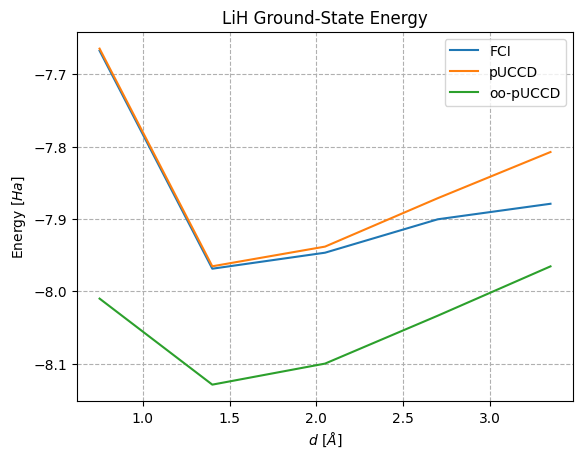

In [16]:
# Plot
method = ['FCI', 'pUCCD', 'oo-pUCCD']

for met in method:  
    plt.plot(arr_distance, arr_ground_energy[met], label=met)

plt.title("LiH Ground-State Energy")
plt.xlabel(r"$d$ $[\AA]$")
plt.ylabel(r"Energy $[Ha]$")
plt.grid(linestyle='--')
plt.legend()
plt.show()